# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


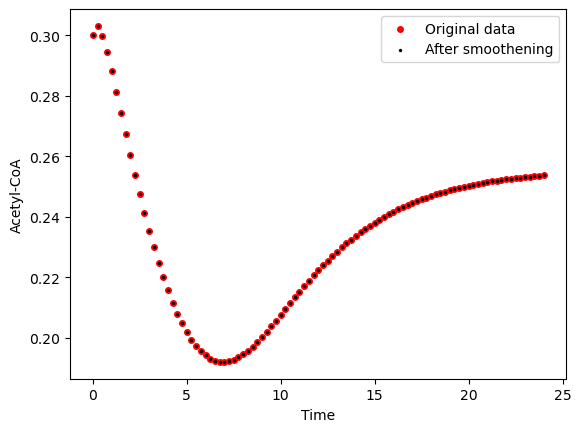

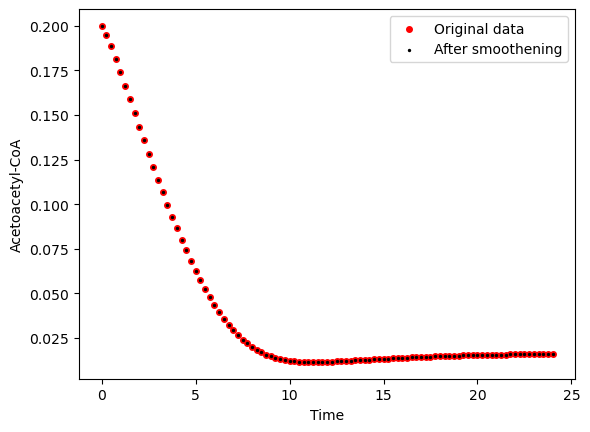

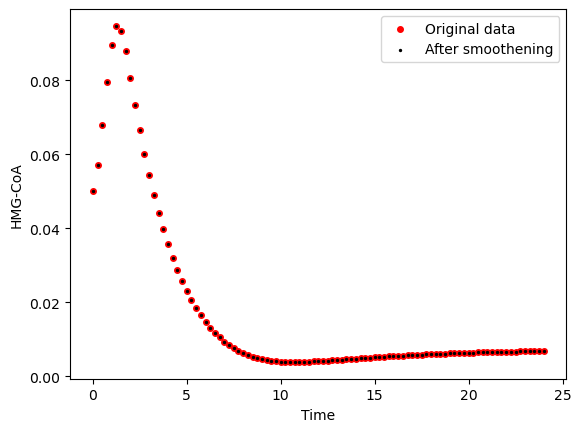

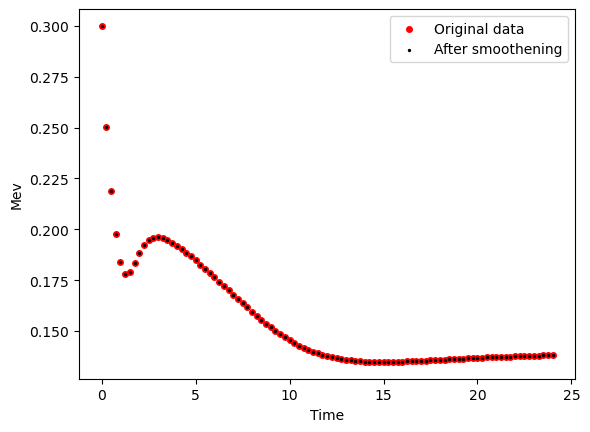

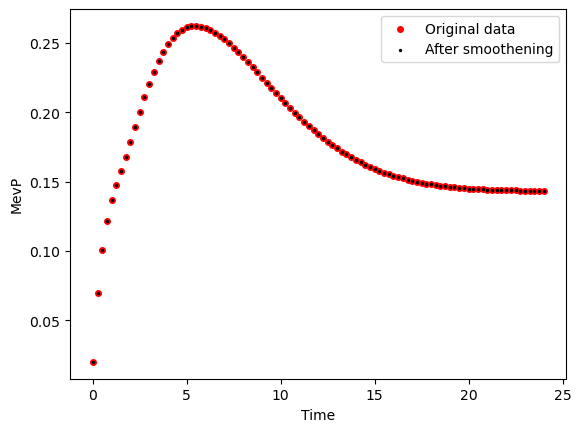

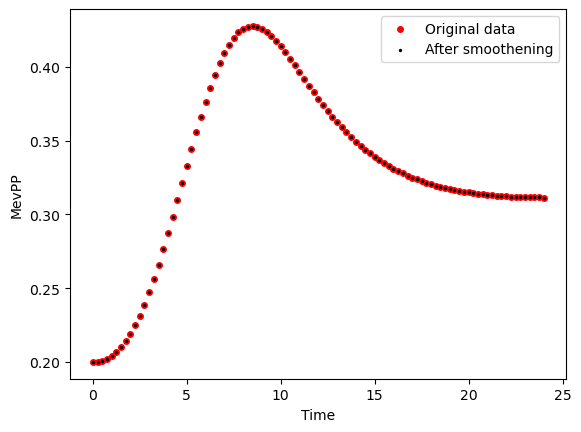

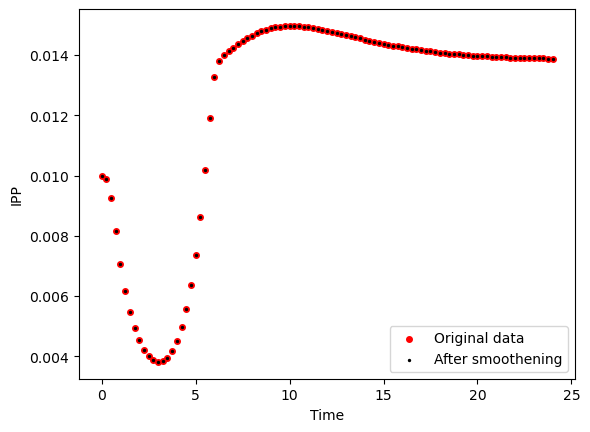

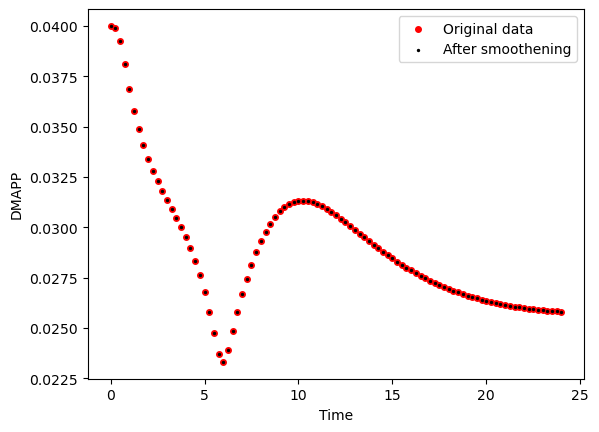

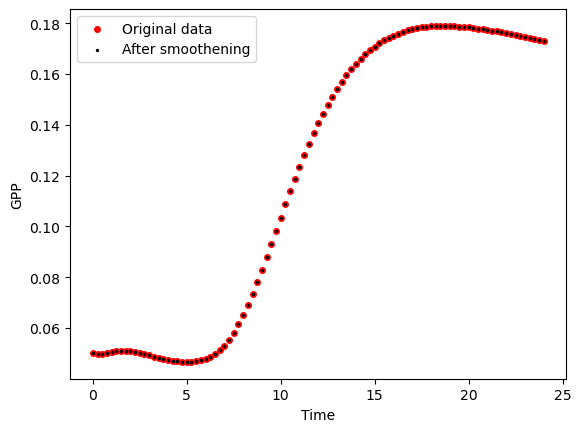

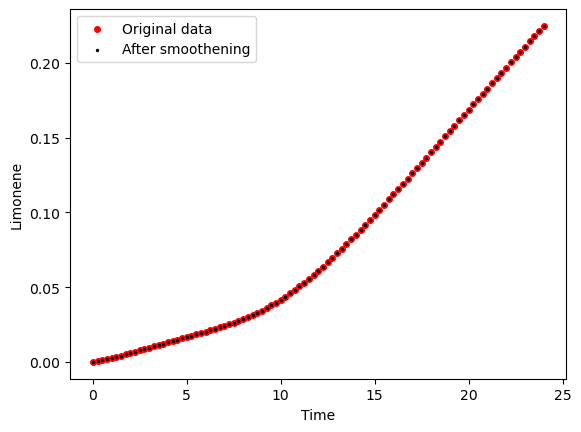

Strain Strain 2


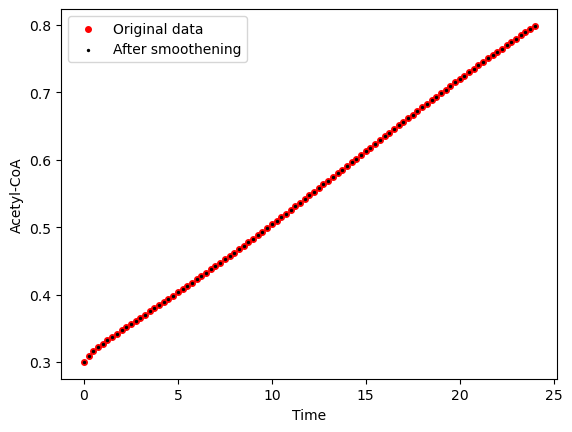

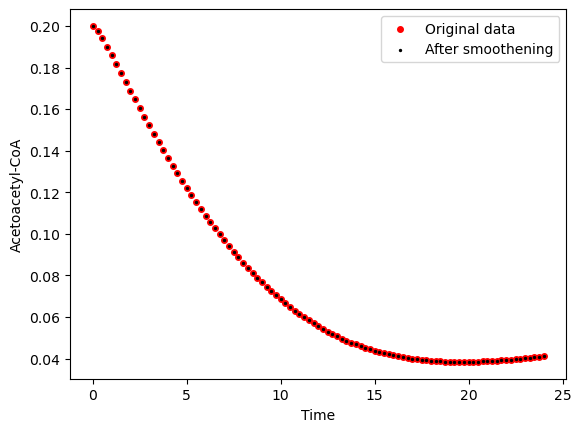

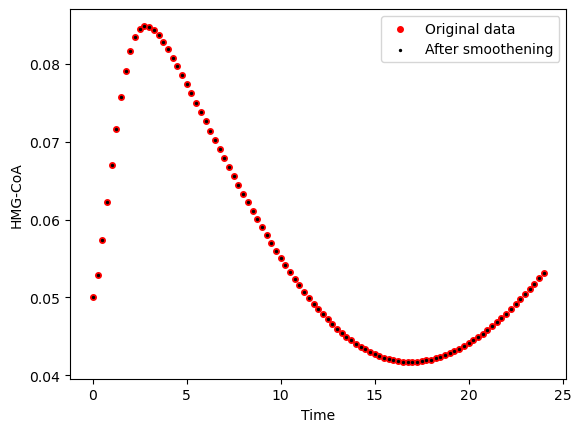

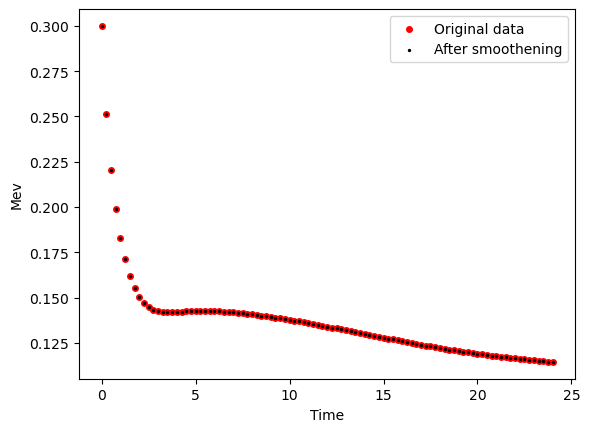

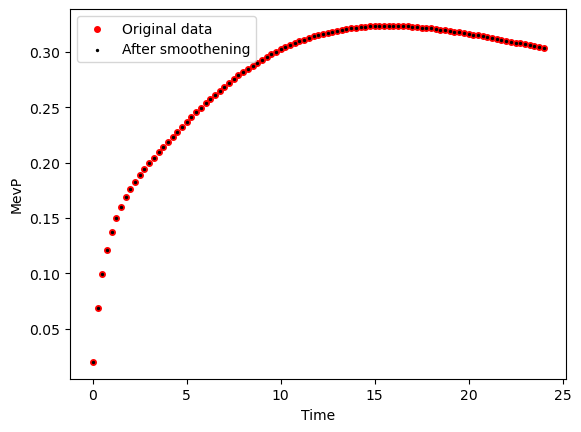

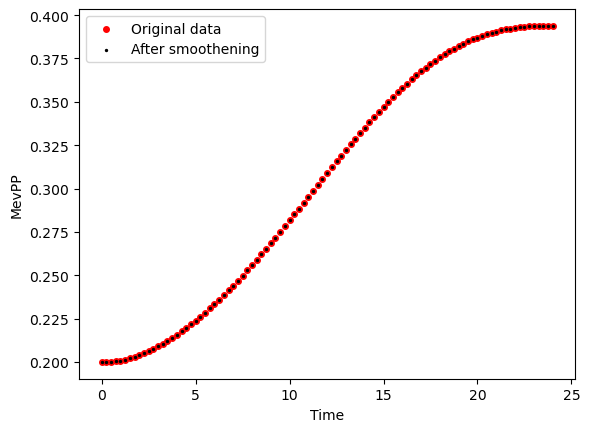

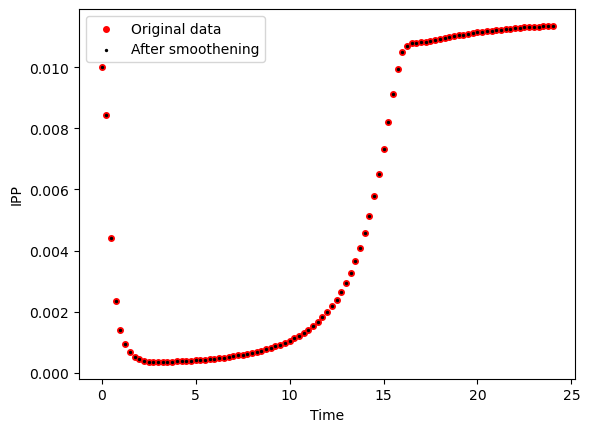

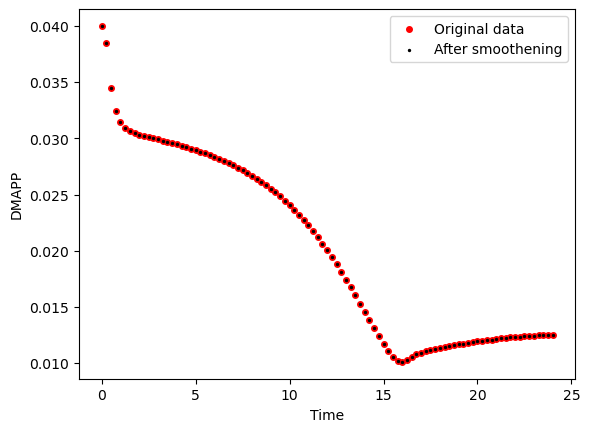

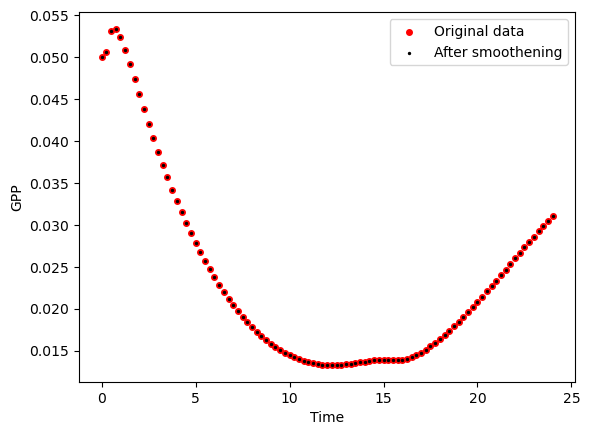

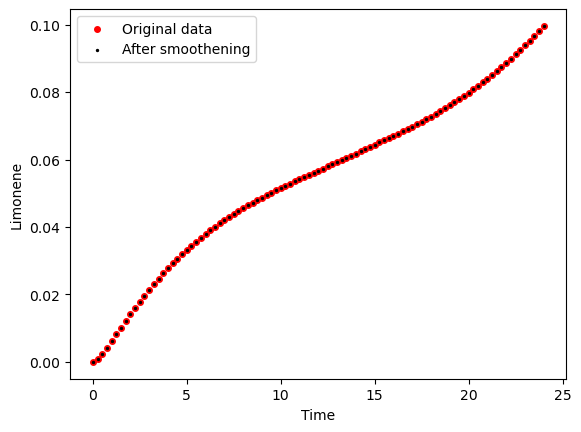

Strain Strain 3


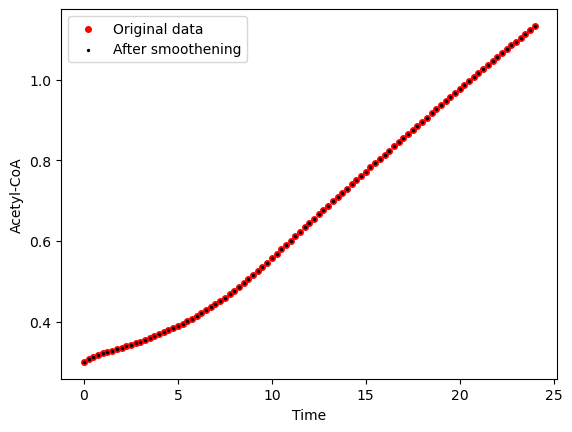

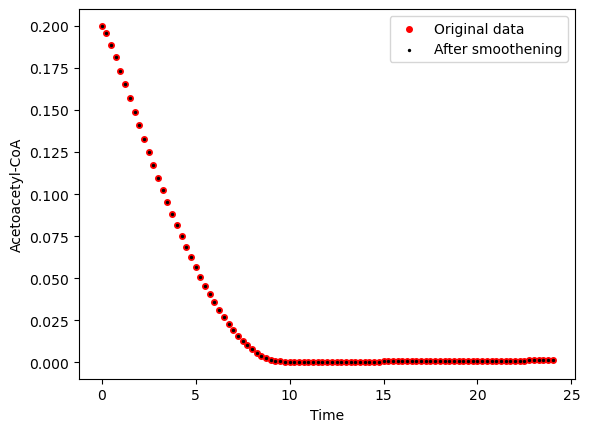

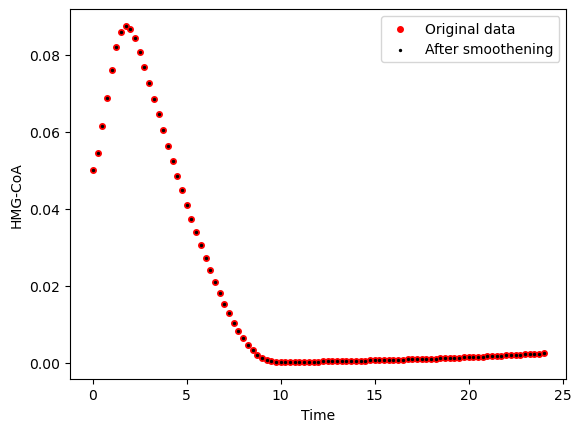

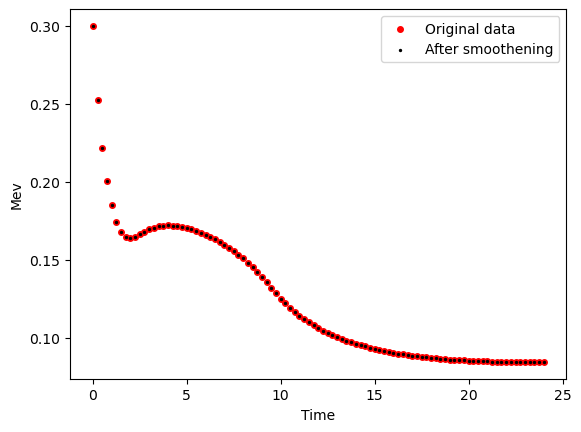

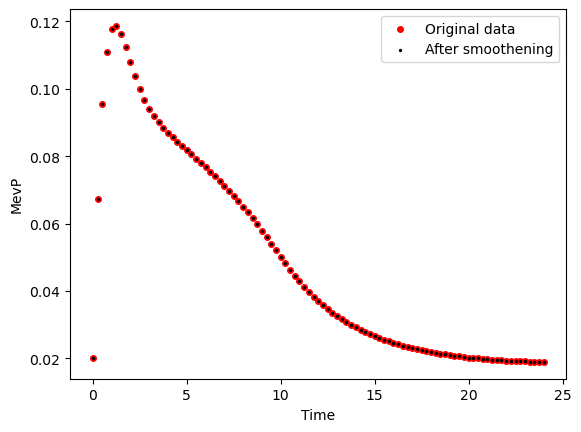

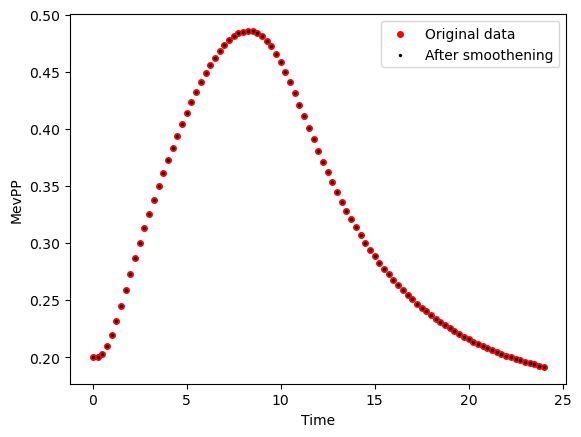

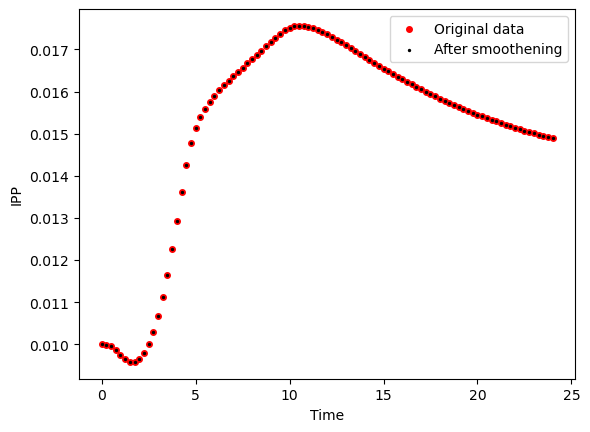

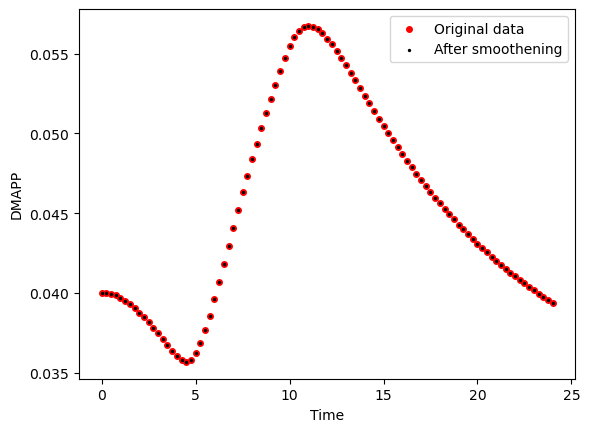

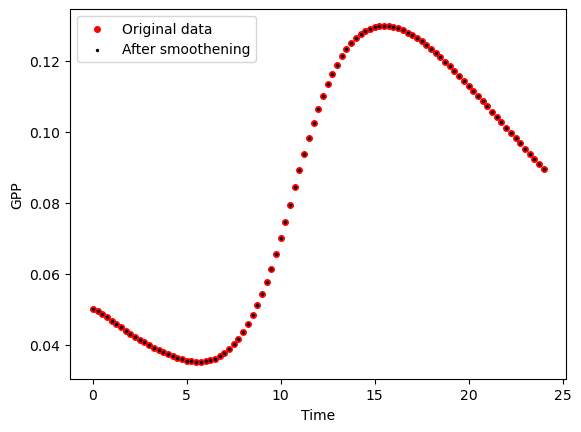

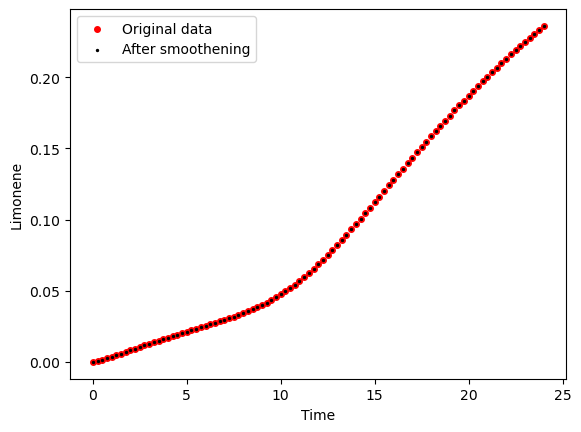

Strain WT


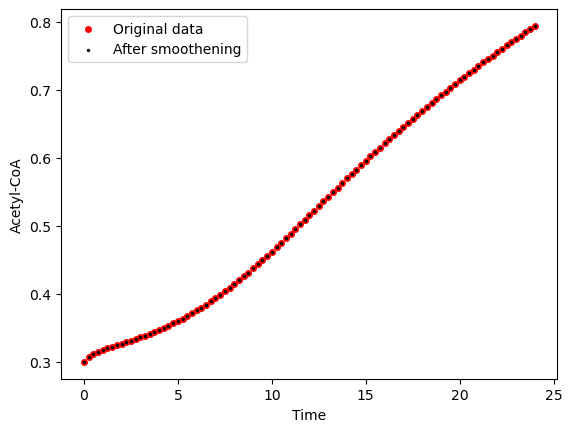

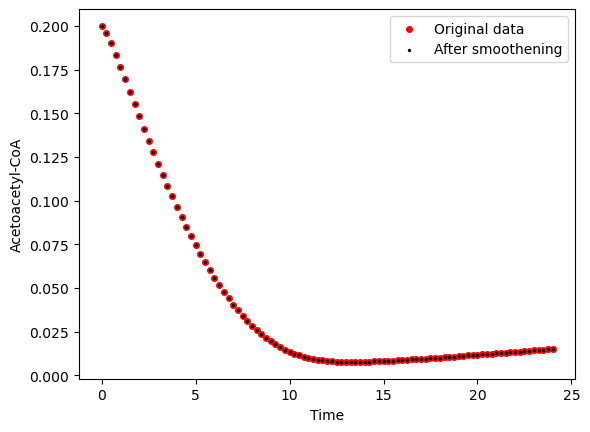

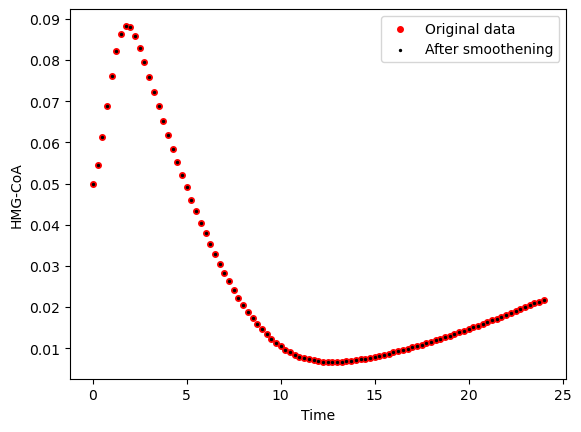

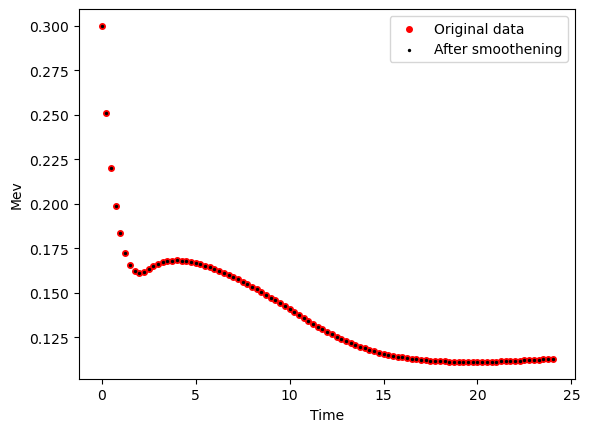

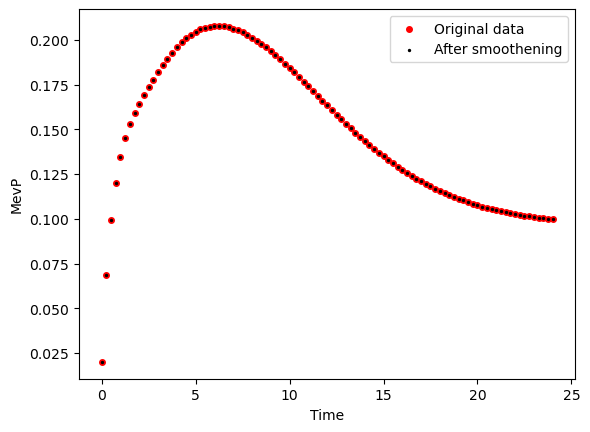

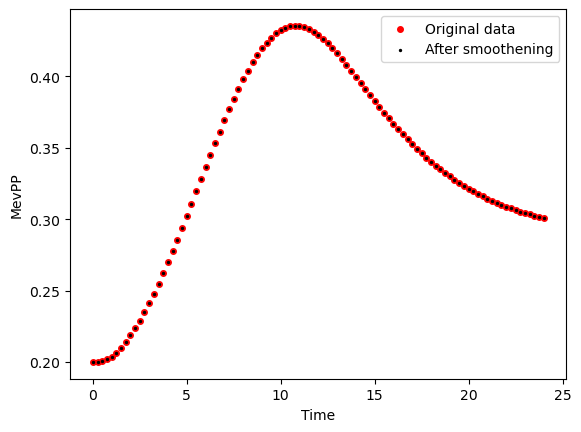

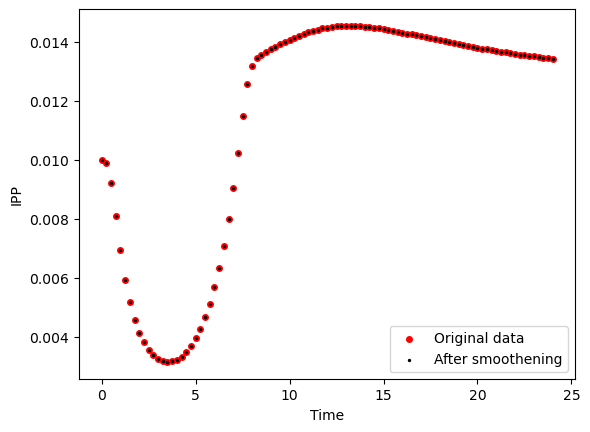

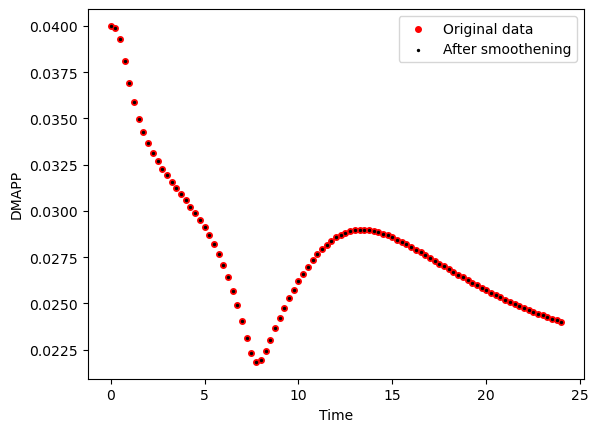

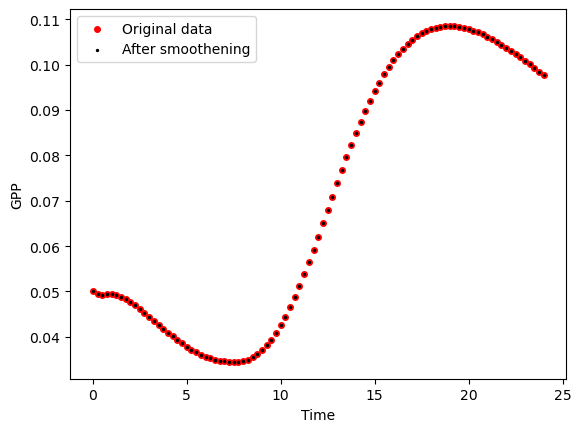

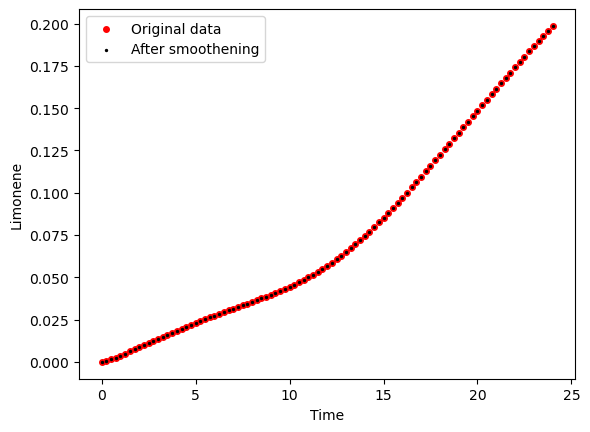

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


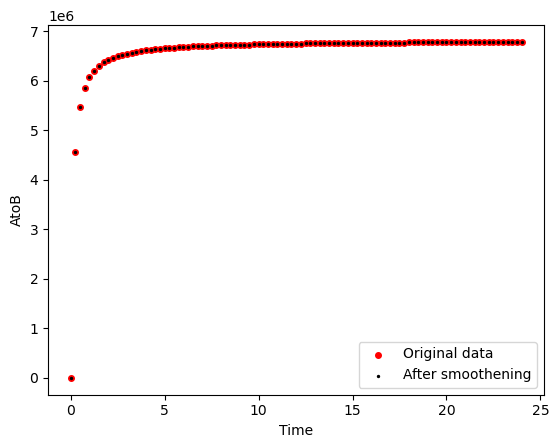

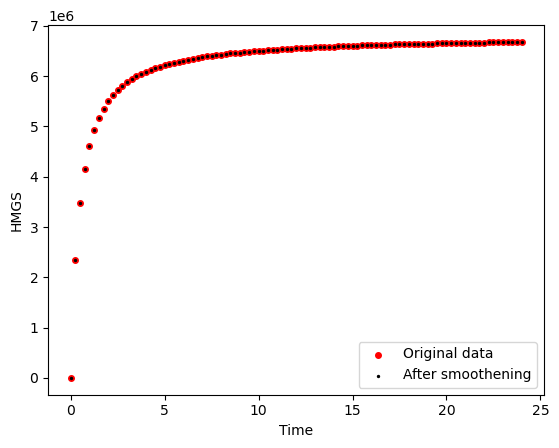

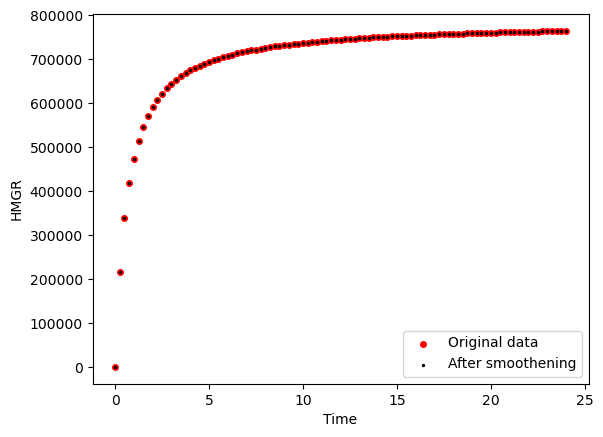

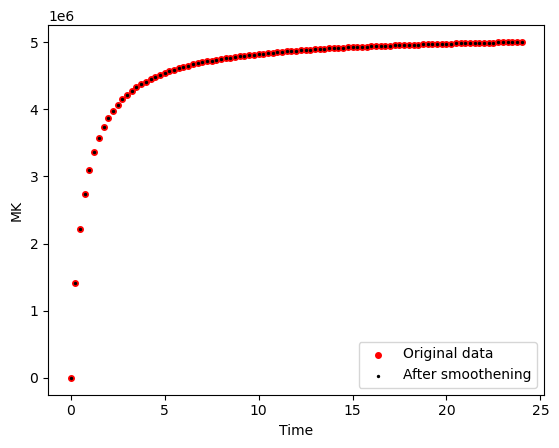

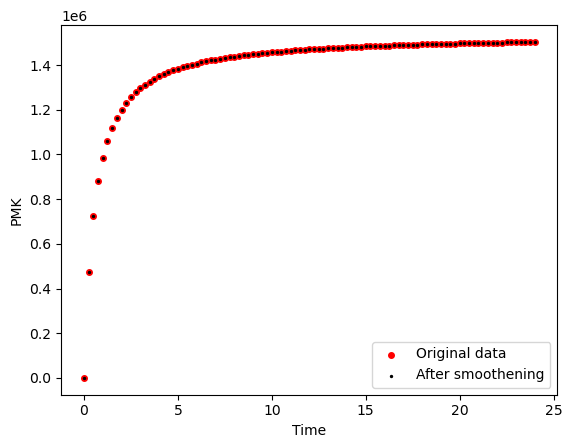

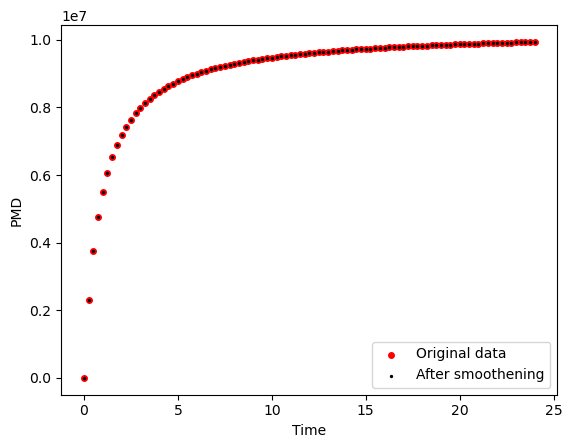

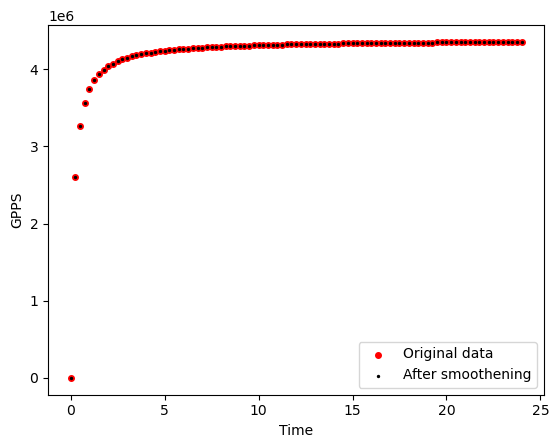

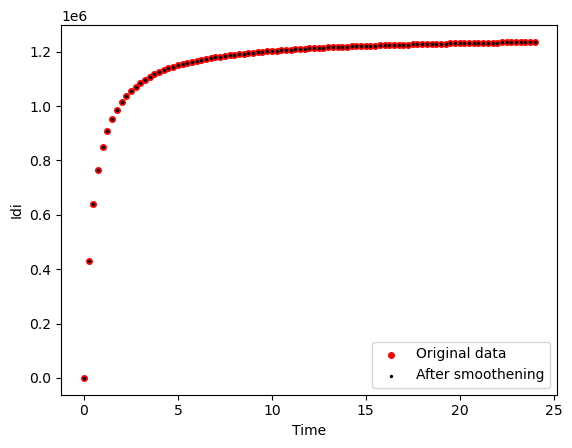

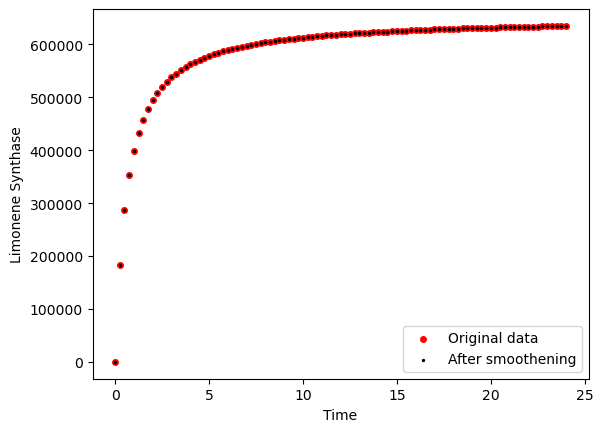

Strain Strain 2


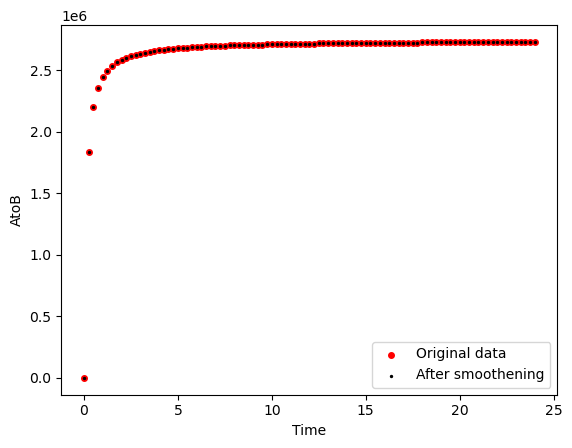

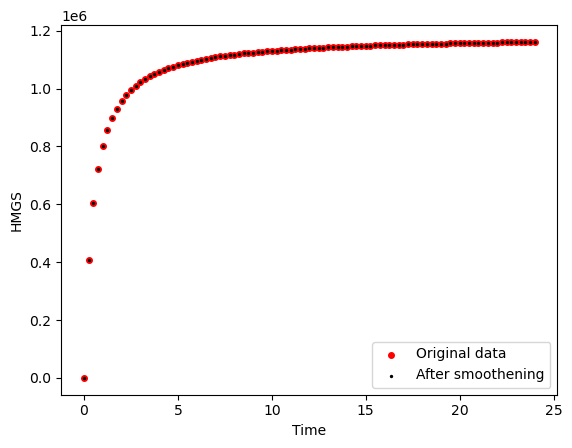

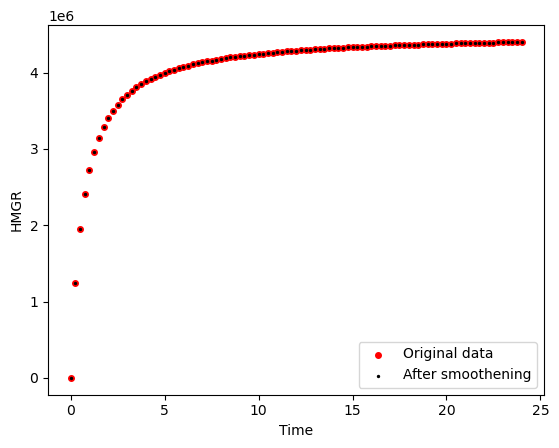

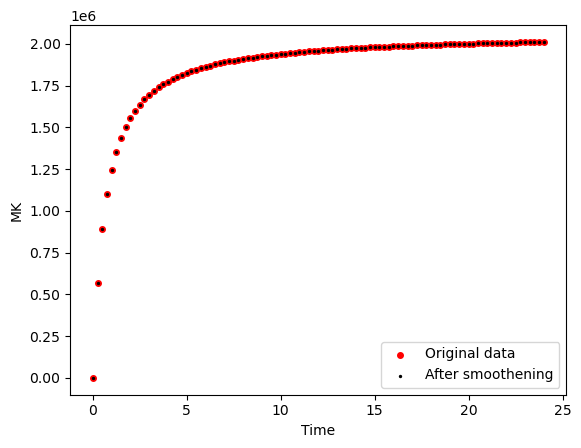

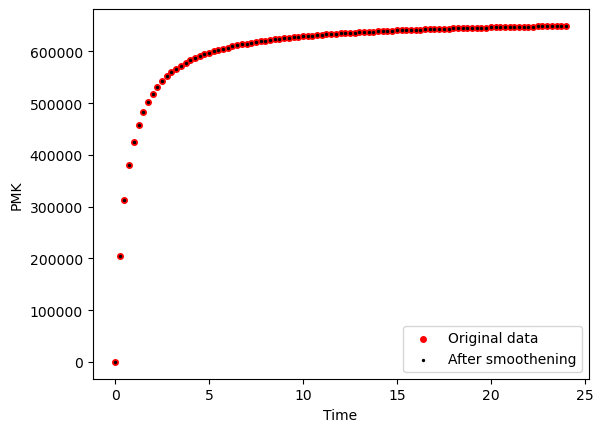

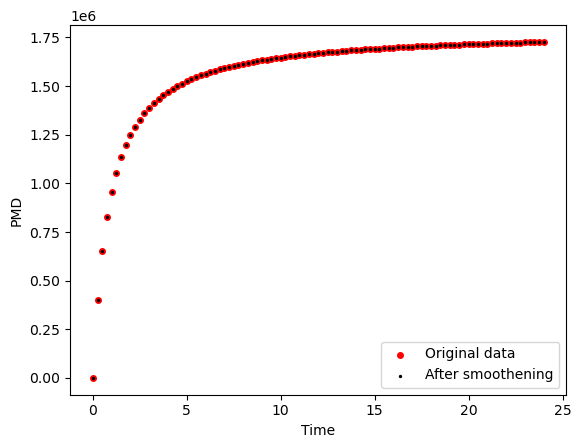

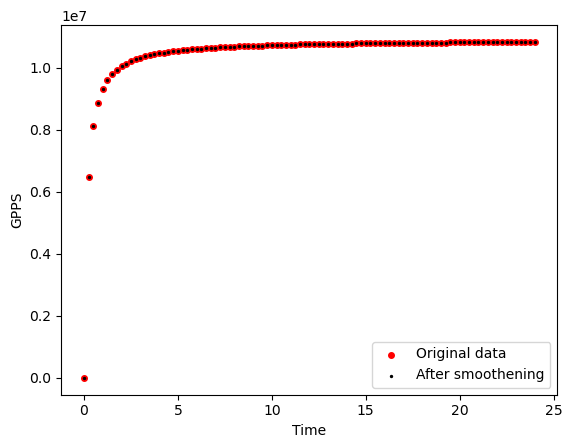

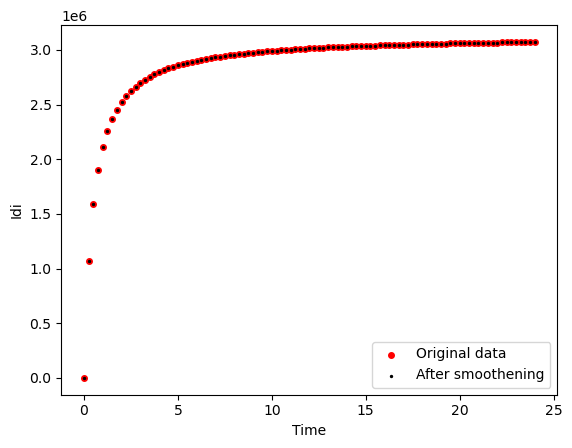

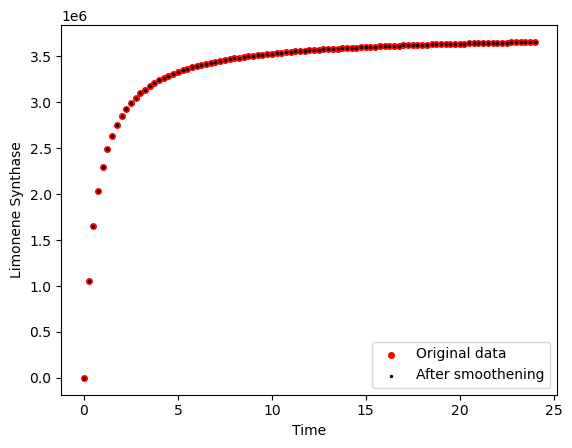

Strain Strain 3


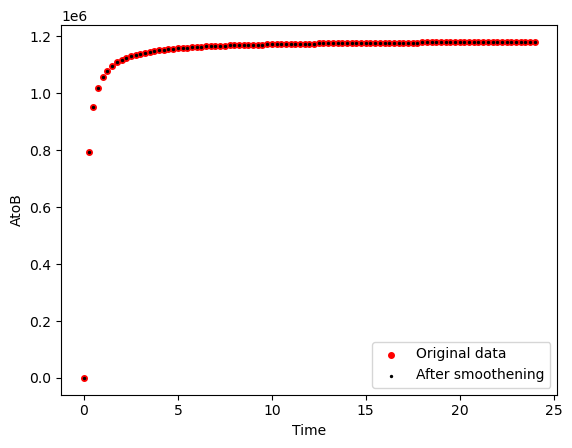

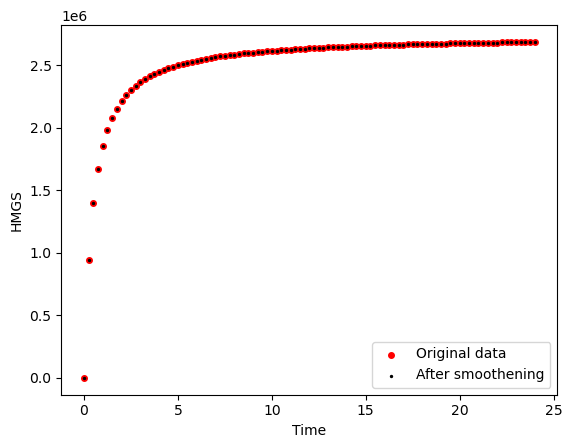

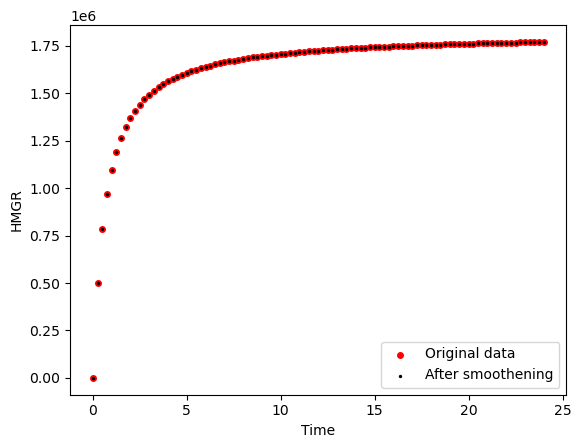

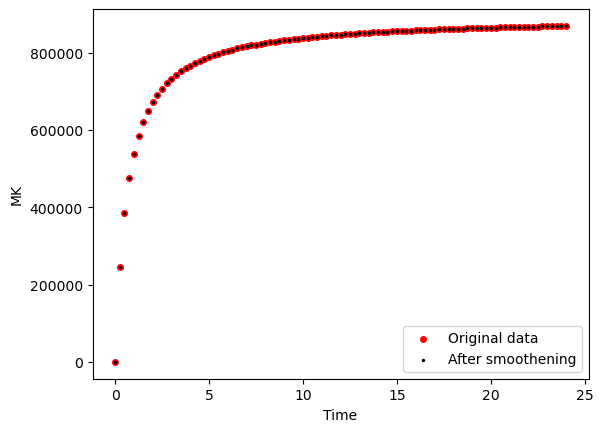

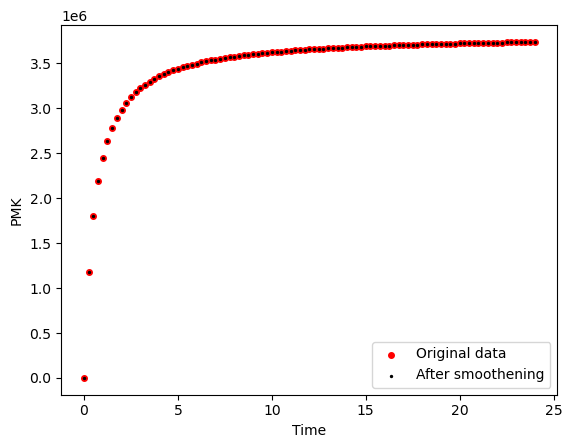

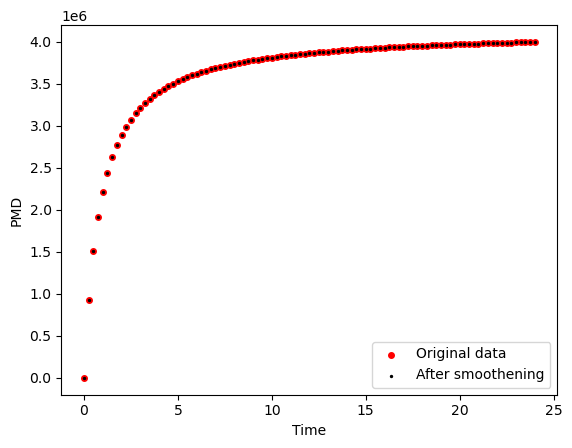

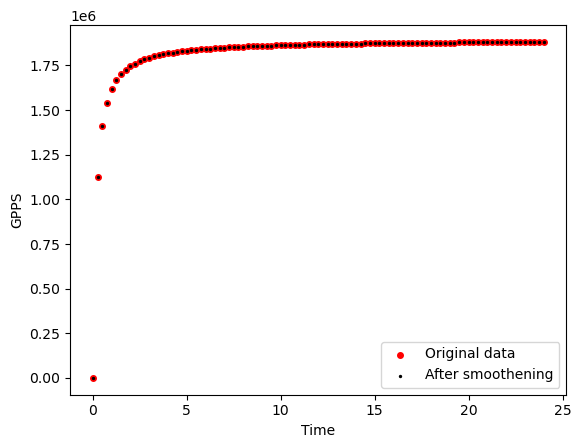

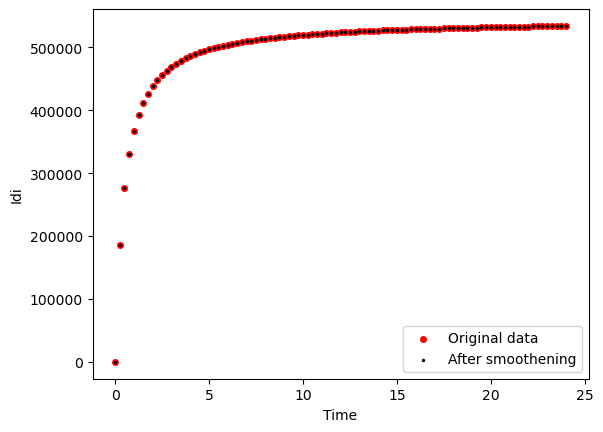

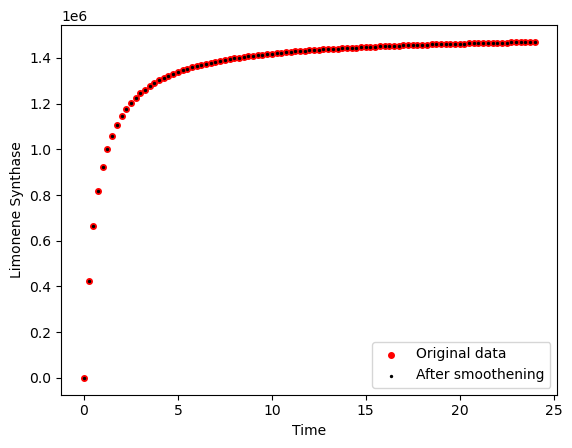

Strain WT


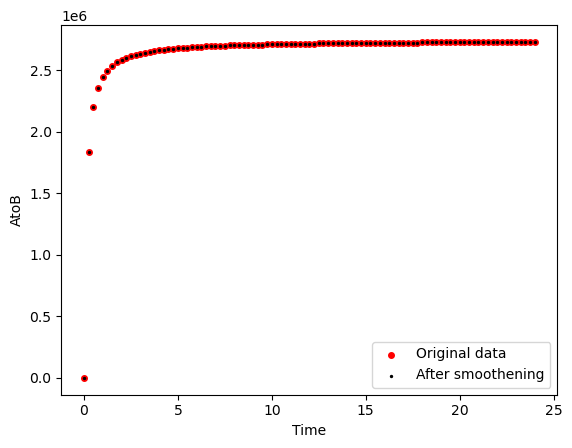

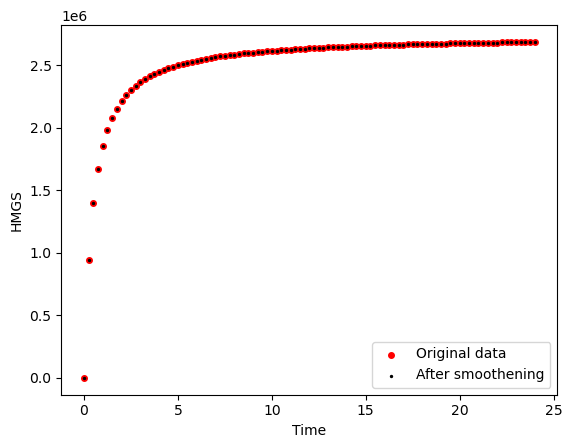

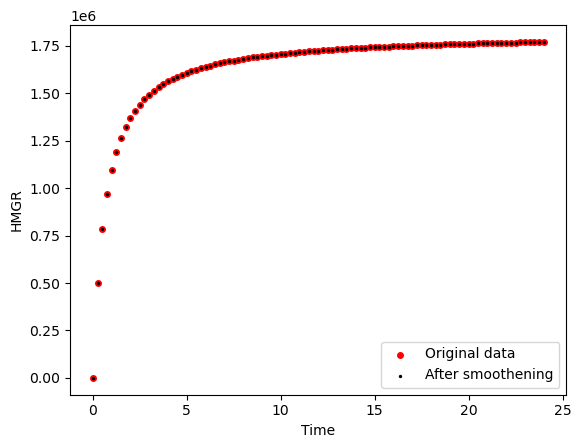

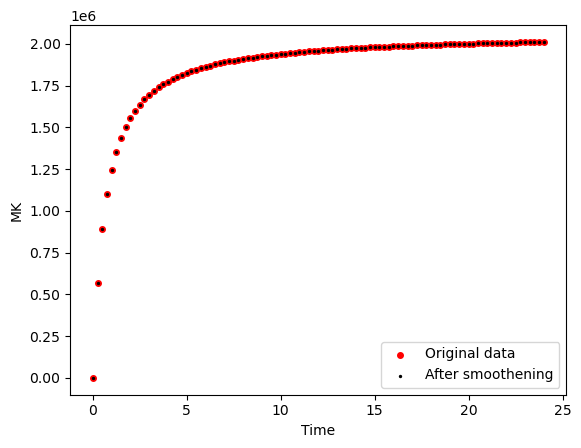

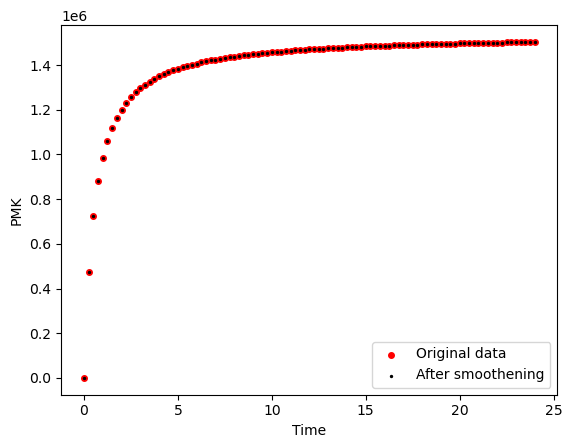

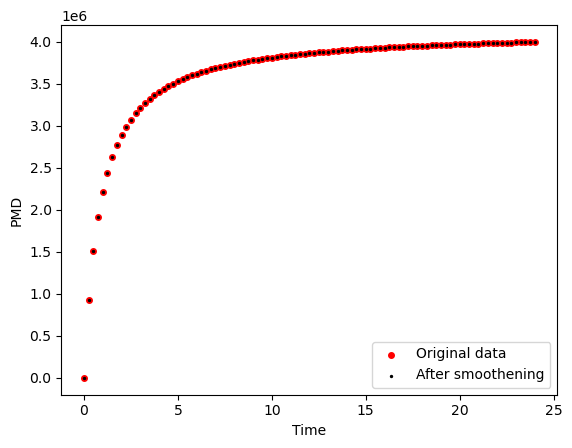

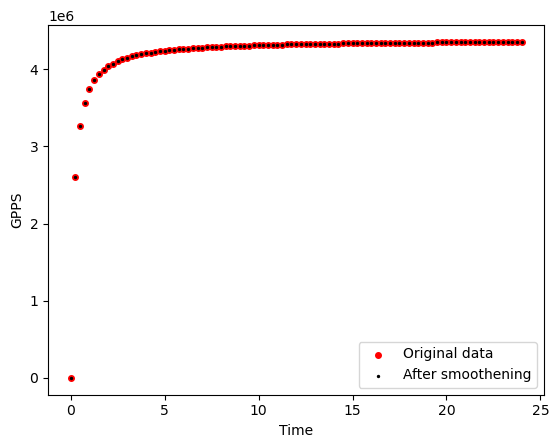

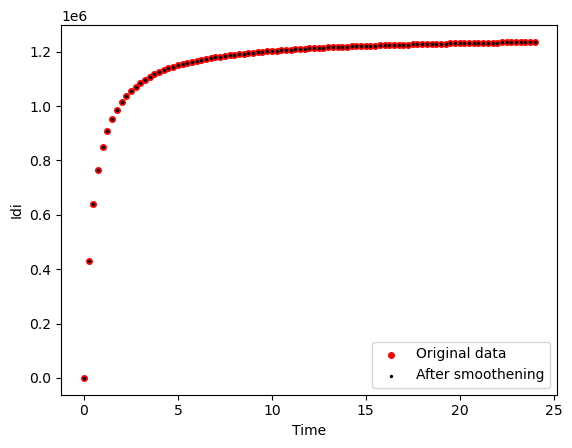

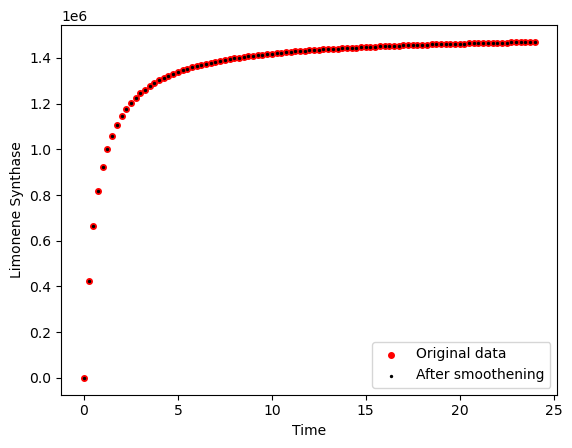

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

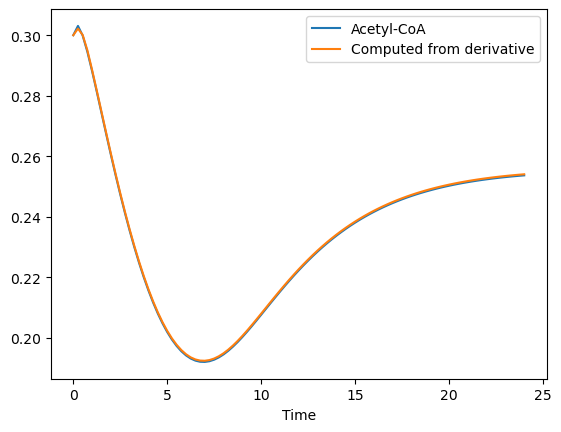

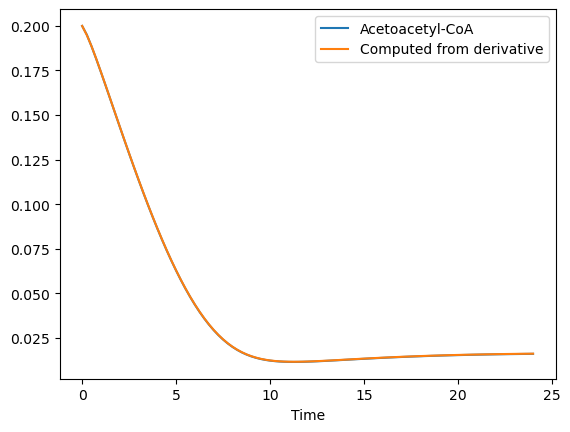

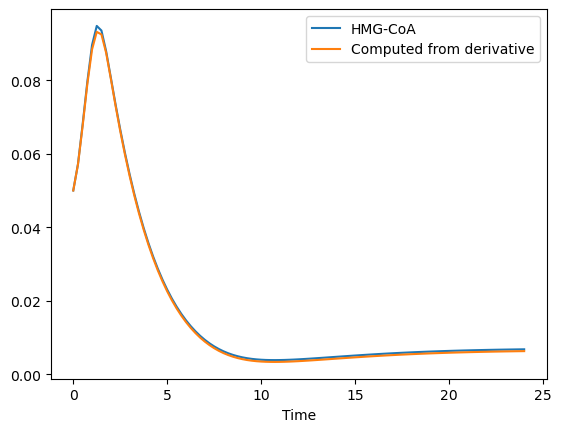

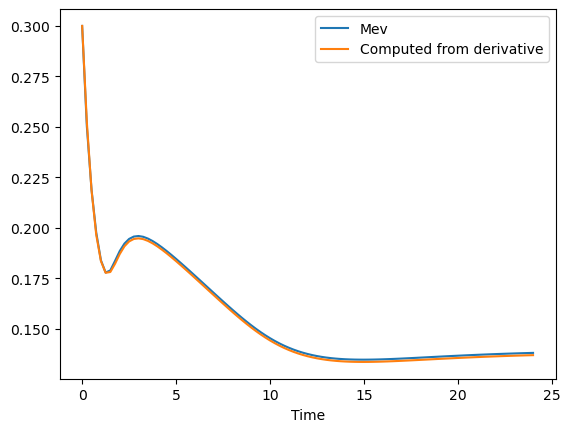

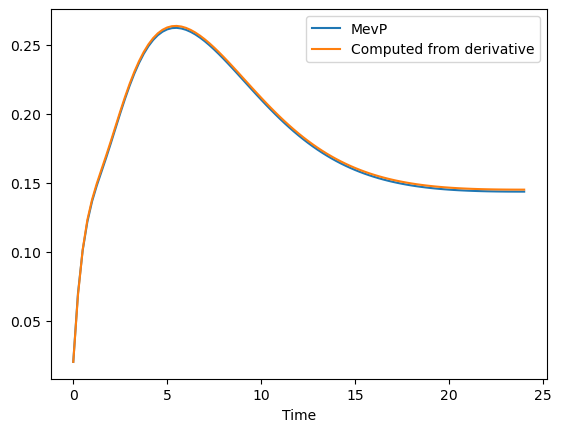

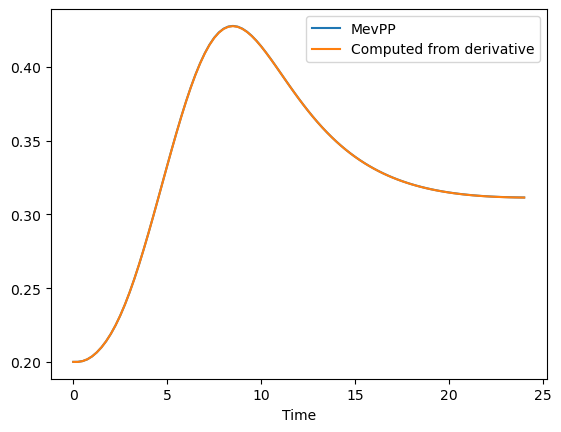

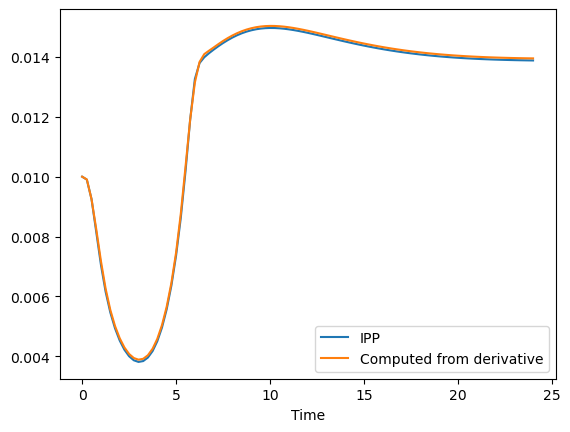

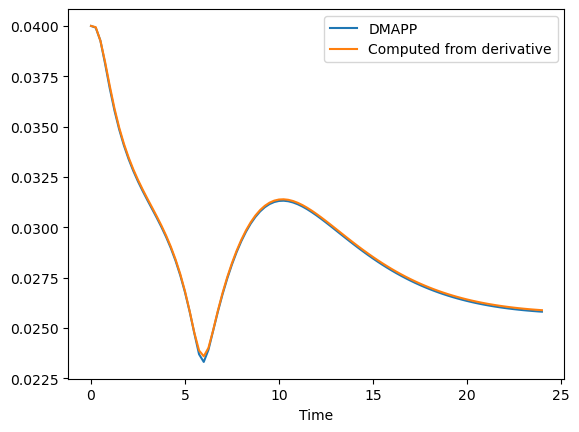

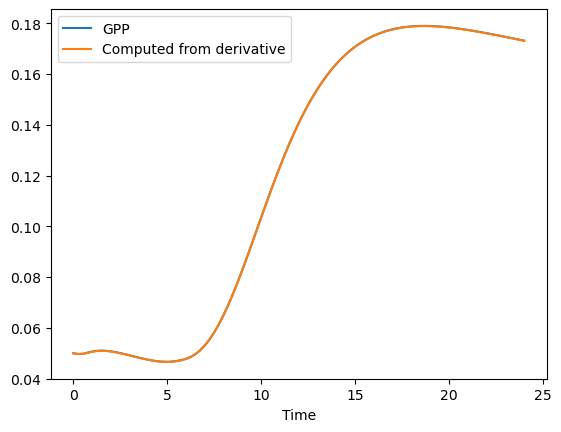

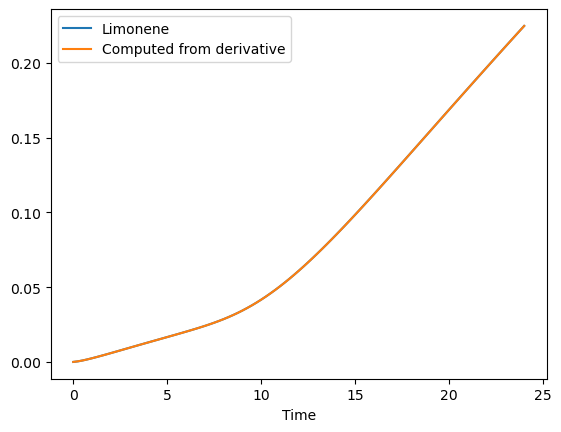

'Time profile from derivative vs. actual profile for Strain 2'

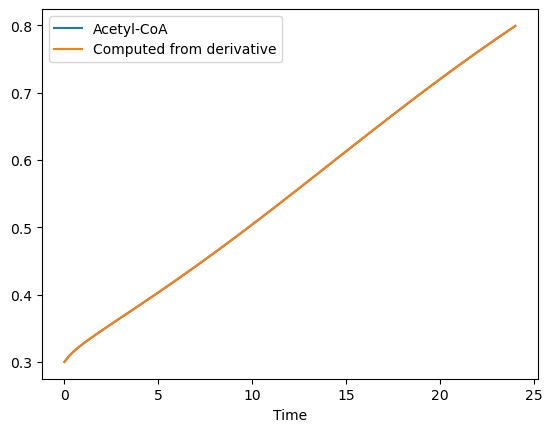

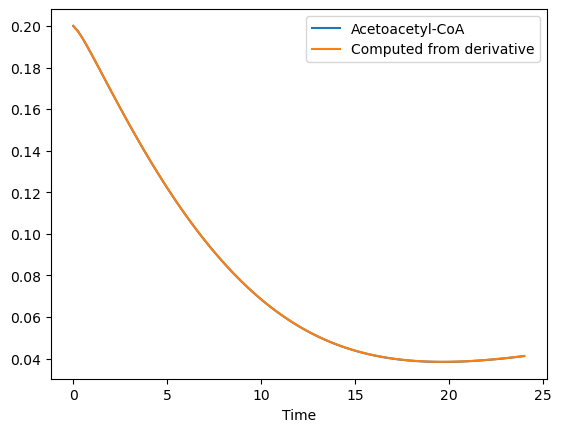

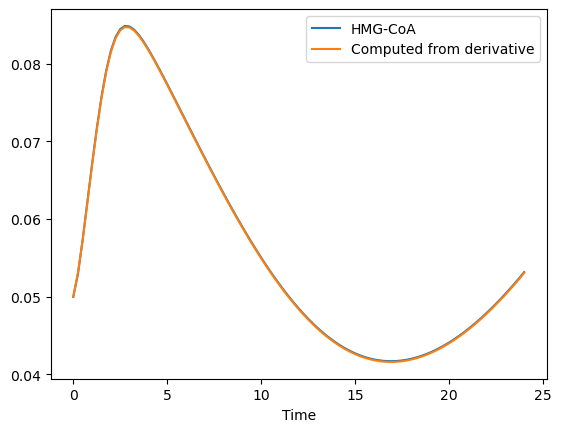

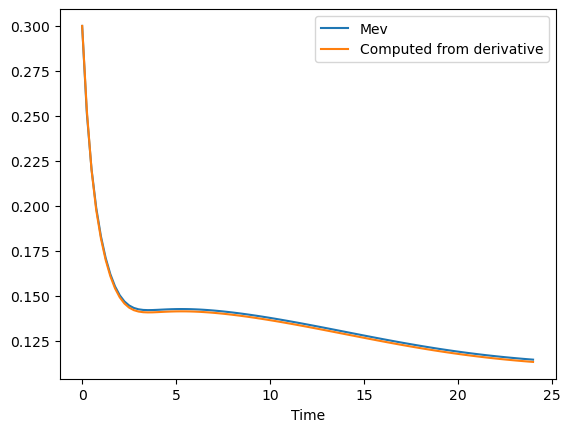

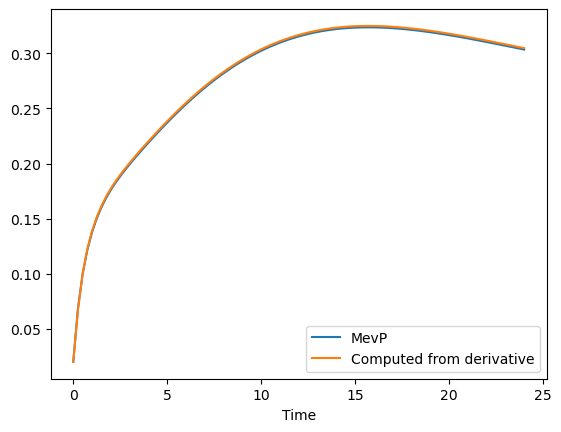

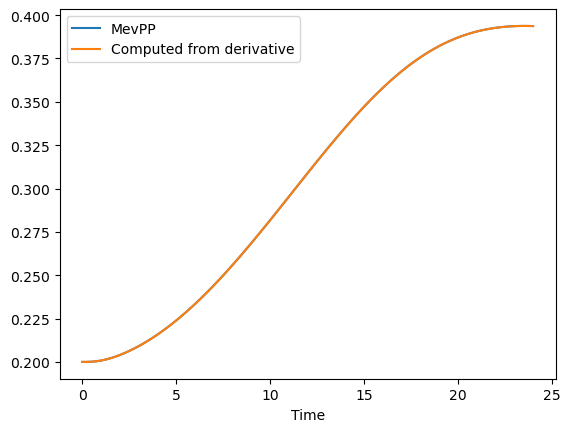

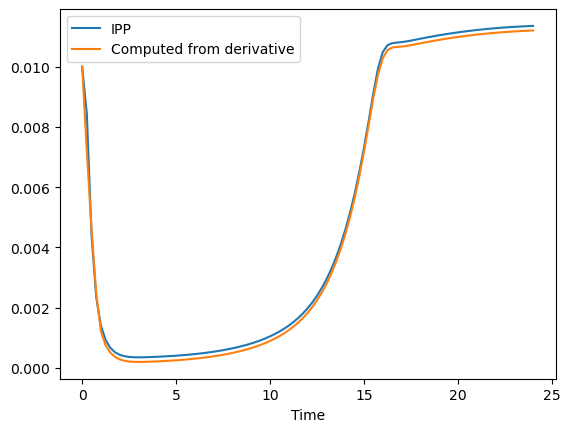

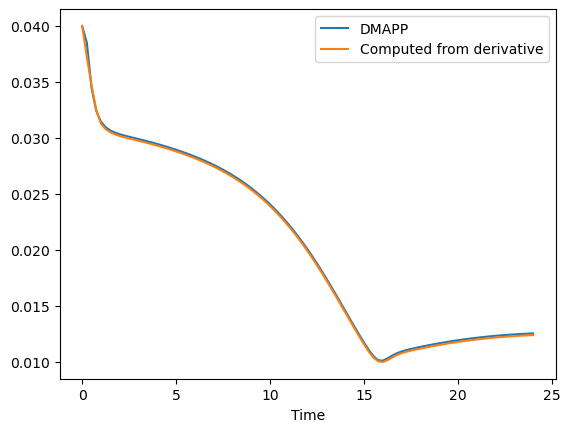

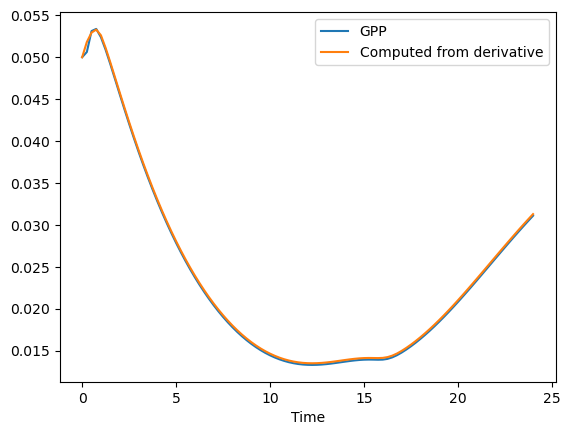

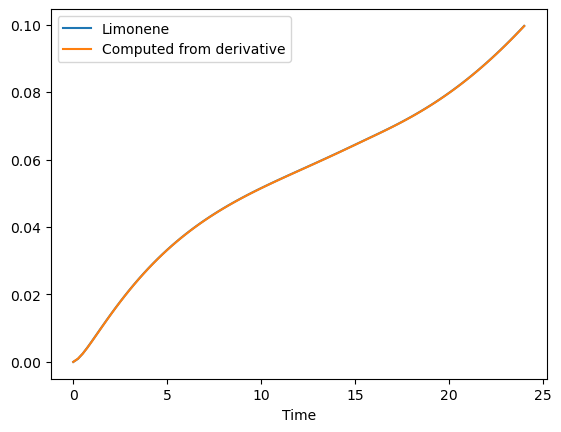

'Time profile from derivative vs. actual profile for Strain 3'

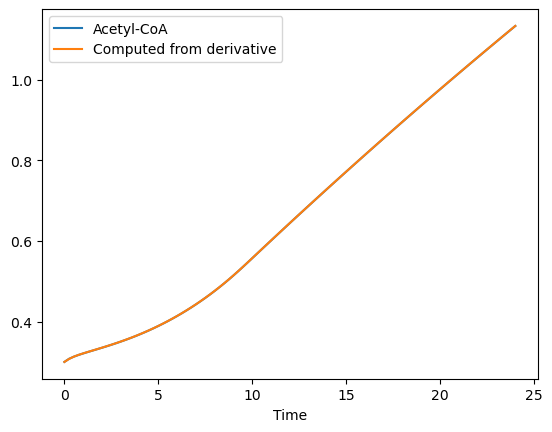

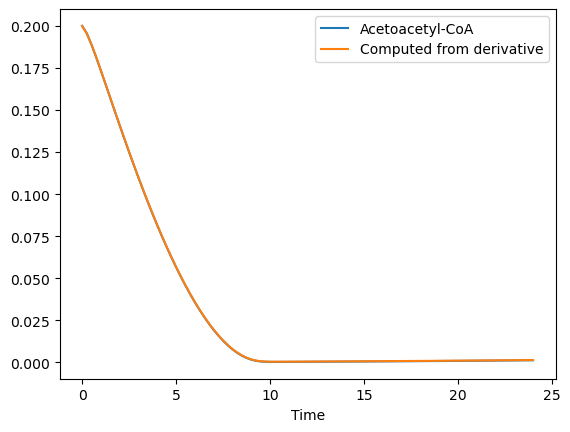

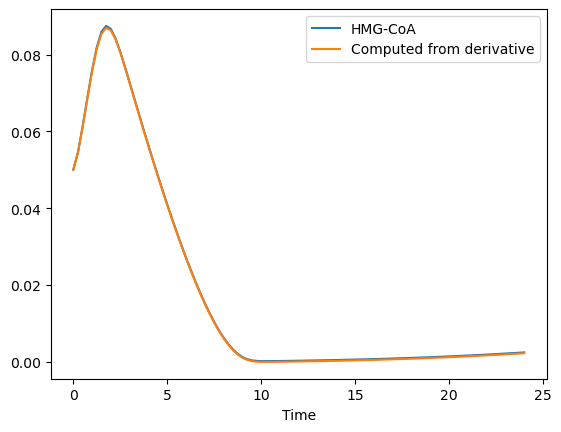

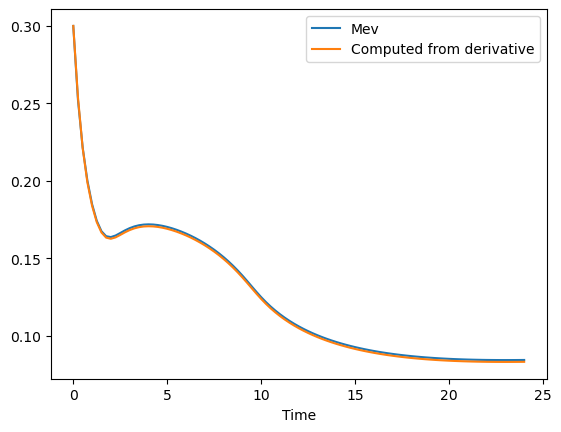

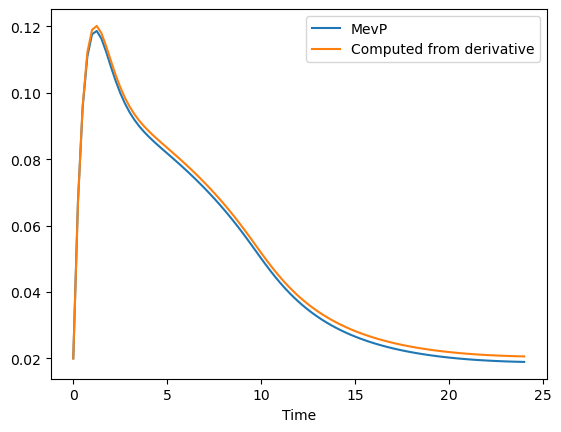

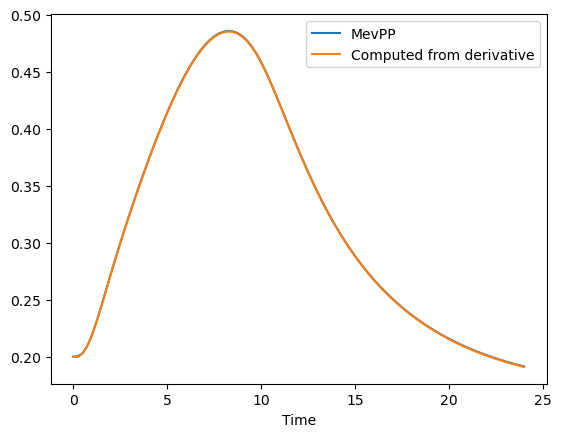

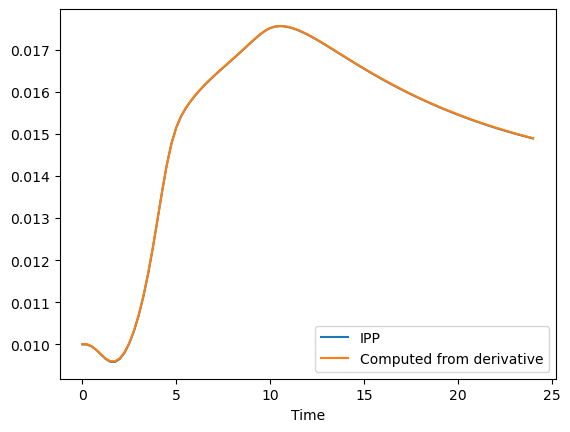

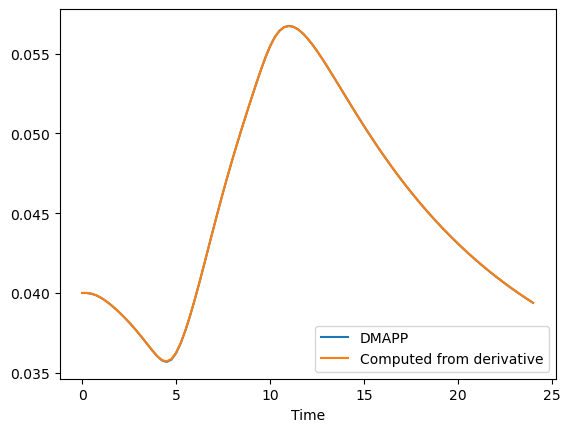

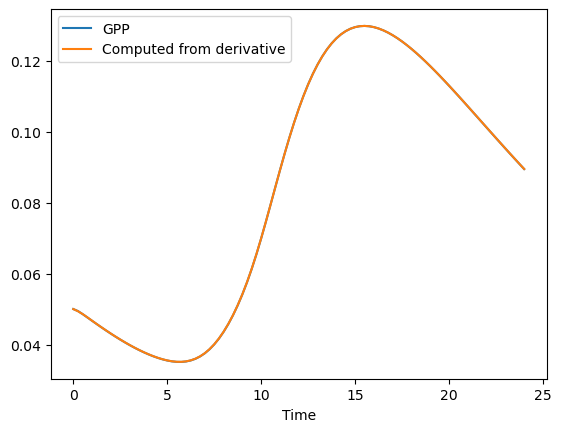

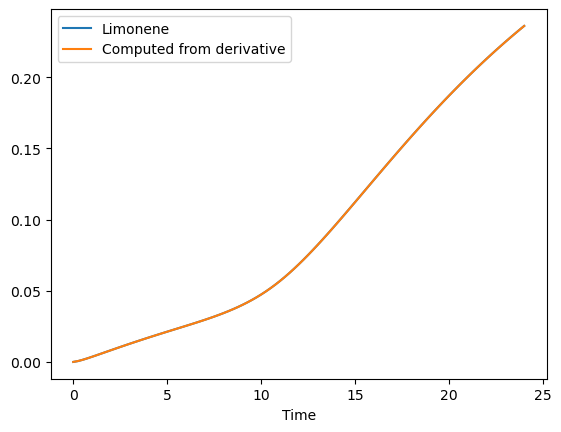

'Time profile from derivative vs. actual profile for WT'

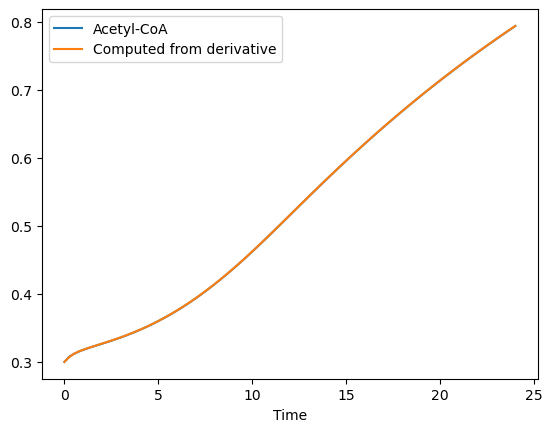

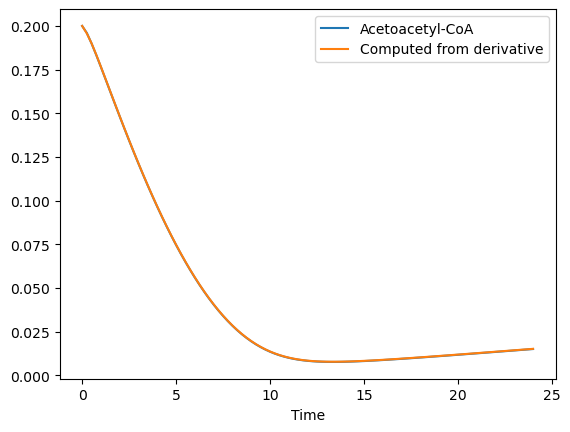

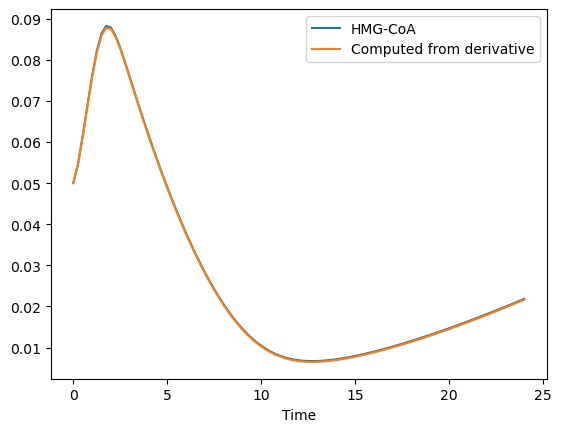

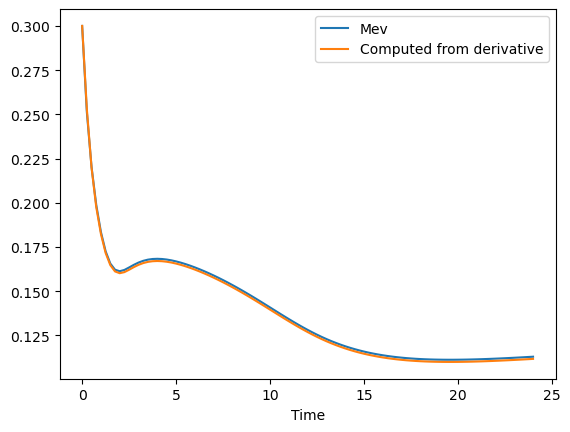

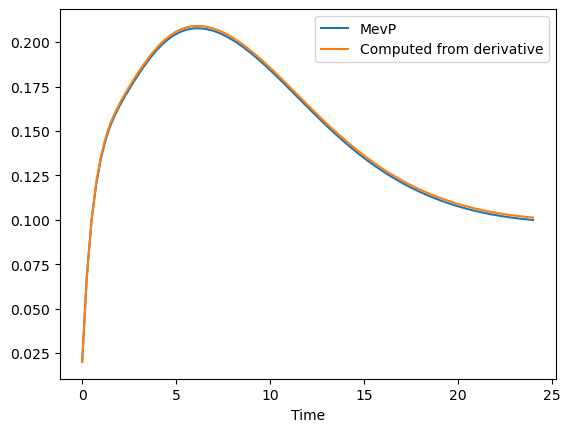

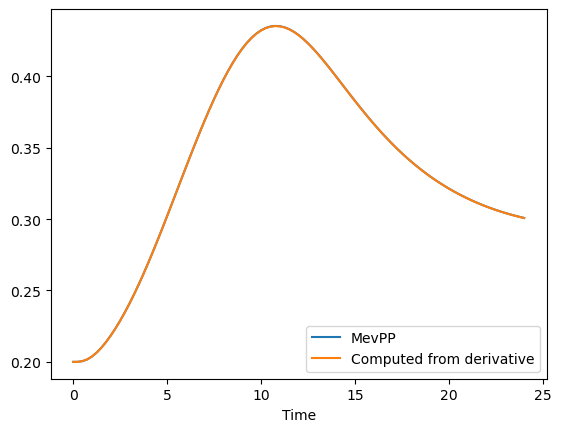

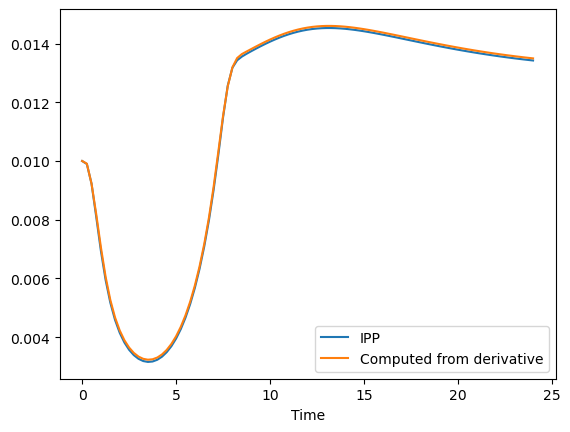

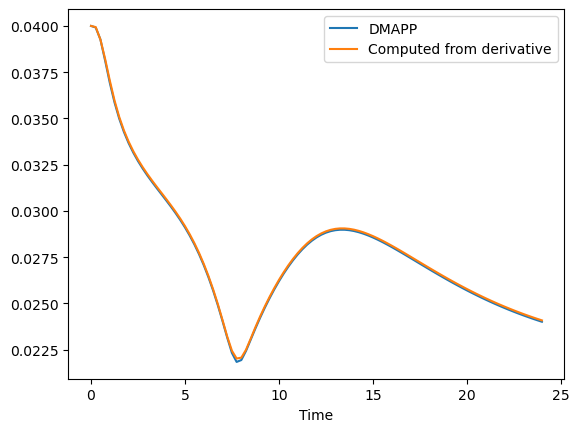

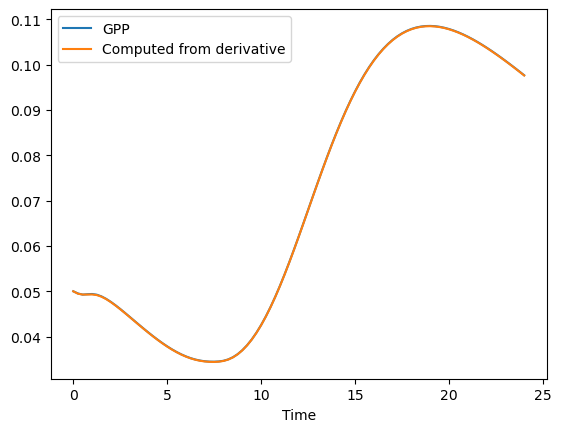

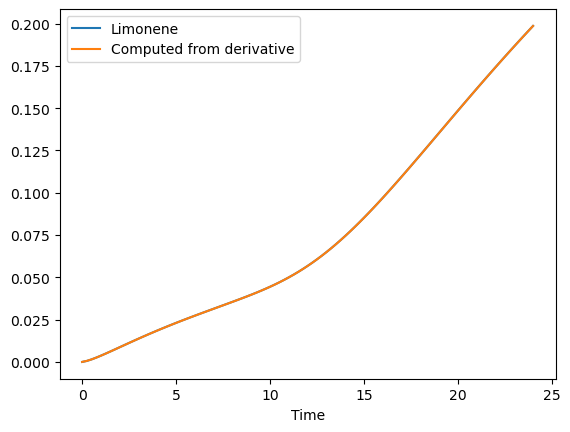

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 8.402592E+191 | 9.187797E+116
     2 |       74 | 1.684193E+115 |  4.076410E+83
     3 |      138 |  6.909674E+90 |  4.798017E+70
     4 |      202 |  1.464635E+80 |  1.063039E+60
     5 |      266 |  3.188423E+73 |  5.648686E+53
     6 |      330 |  3.106210E+65 |  8.118880E+48
     7 |      394 |  1.920033E+64 |  1.272628E+48
     8 |      458 |  4.717378E+57 |  1.287233E+42
     9 |      522 |  2.719053E+54 |  9.582070E+41
    10 |      586 |  1.109200E+55 |  9.582070E+41
    11 |      650 |  3.739221E+49 |  3.107378E+39
    12 |      714 |  1.625552E+46 |  7.147904E+36
    13 |      778 |  1.277625E+43 |  1.345791E+33
    14 |      842 |  4.269750E+40 |  1.286501E+30
    15 |      906 |  2.986136E+37 |  4.562452E+28
    16 |      970 |  2.105369E+33 |  1.077527E+22
    17 |     1034 |  7.729557E+31 |  1.077527E+22
    18 |     1098 |  7.143181E+32 |  4.231869E+21
    19 |     1162 |  3.405

   162 |    10314 |  2.397026E+01 |  1.756594E+01
   163 |    10378 |  2.511450E+01 |  1.756594E+01
   164 |    10442 |  2.353280E+01 |  1.756594E+01
   165 |    10506 |  2.565900E+01 |  1.756594E+01
   166 |    10570 |  2.392311E+01 |  1.756594E+01
   167 |    10634 |  2.526055E+01 |  1.756594E+01
   168 |    10698 |  2.610552E+01 |  1.756594E+01
   169 |    10762 |  2.401102E+01 |  1.756594E+01
   170 |    10826 |  2.320583E+01 |  1.756594E+01
   171 |    10890 |  2.282366E+01 |  1.756594E+01
   172 |    10954 |  2.303681E+01 |  1.756594E+01
   173 |    11018 |  2.252695E+01 |  1.756594E+01
   174 |    11082 |  2.236252E+01 |  1.756594E+01
   175 |    11146 |  2.269332E+01 |  1.756594E+01
   176 |    11210 |  2.252479E+01 |  1.756594E+01
   177 |    11274 |  2.290868E+01 |  1.756594E+01
   178 |    11338 |  2.153861E+01 |  1.756594E+01
   179 |    11402 |  2.152889E+01 |  1.756594E+01
   180 |    11466 |  2.143704E+01 |  1.756594E+01
   181 |    11530 |  2.195635E+01 |  1.756594E+01


   326 |    20810 |  1.766806E+01 |  1.590440E+01
   327 |    20874 |  1.741891E+01 |  1.590440E+01
   328 |    20938 |  1.702059E+01 |  1.526408E+01
   329 |    21002 |  1.720777E+01 |  1.526408E+01
   330 |    21066 |  1.625229E+01 |  1.520999E+01
   331 |    21130 |  1.671992E+01 |  1.520999E+01
   332 |    21194 |  1.671148E+01 |  1.520999E+01
   333 |    21258 |  1.614307E+01 |  1.515506E+01
   334 |    21322 |  1.603586E+01 |  1.483520E+01
   335 |    21386 |  1.630098E+01 |  1.483520E+01
   336 |    21450 |  1.633376E+01 |  1.483520E+01
   337 |    21514 |  1.636120E+01 |  1.483520E+01
   338 |    21578 |  1.640829E+01 |  1.483520E+01
   339 |    21642 |  1.676905E+01 |  1.483520E+01
   340 |    21706 |  1.722320E+01 |  1.483520E+01
   341 |    21770 |  1.676863E+01 |  1.483520E+01
   342 |    21834 |  1.664591E+01 |  1.483520E+01
   343 |    21898 |  1.778567E+01 |  1.483520E+01
   344 |    21962 |  1.746603E+01 |  1.483520E+01
   345 |    22026 |  1.675992E+01 |  1.483520E+01


   490 |    31306 |  1.237778E+01 |  1.213831E+01
   491 |    31370 |  1.238116E+01 |  1.213831E+01
   492 |    31434 |  1.234000E+01 |  1.208074E+01
   493 |    31498 |  1.245365E+01 |  1.208074E+01
   494 |    31562 |  1.233893E+01 |  1.208074E+01
   495 |    31626 |  1.227977E+01 |  1.200683E+01
   496 |    31690 |  1.241949E+01 |  1.200683E+01
   497 |    31754 |  1.233176E+01 |  1.200683E+01
   498 |    31818 |  1.234637E+01 |  1.200571E+01
   499 |    31882 |  1.232579E+01 |  1.200571E+01
   500 |    31946 |  1.229263E+01 |  1.200571E+01
   501 |    32010 |  1.226558E+01 |  1.200571E+01
   502 |    32074 |  1.226566E+01 |  1.200571E+01
   503 |    32138 |  1.225221E+01 |  1.200571E+01
   504 |    32202 |  1.232536E+01 |  1.200571E+01
   505 |    32266 |  1.237208E+01 |  1.200571E+01
   506 |    32330 |  1.234548E+01 |  1.200571E+01
   507 |    32394 |  1.219693E+01 |  1.200571E+01
   508 |    32458 |  1.222124E+01 |  1.200571E+01
   509 |    32522 |  1.221594E+01 |  1.200571E+01


   654 |    41802 |  9.3138601870 |  9.1893808306
   655 |    41866 |  9.3111697547 |  9.1893808306
   656 |    41930 |  9.3257146574 |  9.1893808306
   657 |    41994 |  9.3125901273 |  9.1893808306
   658 |    42058 |  9.3098331587 |  9.1893808306
   659 |    42122 |  9.2928719308 |  9.1893808306
   660 |    42186 |  9.2828817114 |  9.1893808306
   661 |    42250 |  9.2739936641 |  9.1893808306
   662 |    42314 |  9.2794097109 |  9.1893808306
   663 |    42378 |  9.2852755579 |  9.1893808306
   664 |    42442 |  9.2685947845 |  9.1893808306
   665 |    42506 |  9.2288829328 |  9.1893808306
   666 |    42570 |  9.2316484644 |  9.1893808306
   667 |    42634 |  9.2203321155 |  9.1808261384
   668 |    42698 |  9.1698844480 |  8.8909504242
   669 |    42762 |  9.1236657062 |  8.8909504242
   670 |    42826 |  9.0490905138 |  8.8909504242
   671 |    42890 |  9.0577199328 |  8.8444493563
   672 |    42954 |  9.0210344211 |  8.8444493563
   673 |    43018 |  9.0284567298 |  8.8444493563


   818 |    52298 |  7.4522597471 |  7.3597211156
   819 |    52362 |  7.4478205372 |  7.3597211156
   820 |    52426 |  7.4197967547 |  7.3597211156
   821 |    52490 |  7.4198726235 |  7.3587730520
   822 |    52554 |  7.4291439591 |  7.3587730520
   823 |    52618 |  7.4283839207 |  7.3234804949
   824 |    52682 |  7.4020611824 |  7.3234804949
   825 |    52746 |  7.3962841813 |  7.3234804949
   826 |    52810 |  7.3835175177 |  7.3234804949
   827 |    52874 |  7.3615018295 |  7.2523808603
   828 |    52938 |  7.3038844401 |  7.2523808603
   829 |    53002 |  7.2646958912 |  7.2366797950
   830 |    53066 |  7.2675838315 |  7.2366797950
   831 |    53130 |  7.2498713304 |  7.2081512418
   832 |    53194 |  7.2282138199 |  7.1954648011
   833 |    53258 |  7.2285855547 |  7.1786618711
   834 |    53322 |  7.2185385016 |  7.1772619611
   835 |    53386 |  7.2159719435 |  7.1333131425
   836 |    53450 |  7.1748426490 |  7.1333131425
   837 |    53514 |  7.1886370266 |  7.1333131425


   982 |    62794 |  6.1351702123 |  6.1047094309
   983 |    62858 |  6.1238839690 |  6.1047094309
   984 |    62922 |  6.1111314004 |  6.0950439878
   985 |    62986 |  6.1077655098 |  6.0886250162
   986 |    63050 |  6.1062040255 |  6.0886250162
   987 |    63114 |  6.0977122944 |  6.0796317808
   988 |    63178 |  6.0988253365 |  6.0796317808
   989 |    63242 |  6.0995753467 |  6.0789856929
   990 |    63306 |  6.0874539555 |  6.0715642487
   991 |    63370 |  6.0683706730 |  6.0468611638
   992 |    63434 |  6.0628440964 |  6.0468611638
   993 |    63498 |  6.0577023405 |  6.0441900439
   994 |    63562 |  6.0553207109 |  6.0428006376
   995 |    63626 |  6.0411879336 |  6.0215202754
   996 |    63690 |  6.0348143164 |  6.0076682273
   997 |    63754 |  6.0281800103 |  6.0076682273
   998 |    63818 |  6.0262951351 |  6.0076682273
   999 |    63882 |  6.0187059685 |  6.0051273643
  1000 |    63946 |  6.0207243834 |  5.9991349316
  1001 |    64010 |  6.0118401228 |  5.9963865879


  1146 |    73290 |  5.6261651508 |  5.6236754771
  1147 |    73354 |  5.6236179801 |  5.6206773810
  1148 |    73418 |  5.6206735061 |  5.6163450397
  1149 |    73482 |  5.6184072779 |  5.6154052871
  1150 |    73546 |  5.6136850956 |  5.6072568979
  1151 |    73610 |  5.6111412519 |  5.6072568979
  1152 |    73674 |  5.6081468886 |  5.6033755116
  1153 |    73738 |  5.6037817791 |  5.5967089489
  1154 |    73802 |  5.5999537988 |  5.5937509675
  1155 |    73866 |  5.5960611180 |  5.5924809531
  1156 |    73930 |  5.5944516979 |  5.5923852958
  1157 |    73994 |  5.5911218987 |  5.5855863467
  1158 |    74058 |  5.5889719064 |  5.5839924912
  1159 |    74122 |  5.5867562756 |  5.5839924912
  1160 |    74186 |  5.5831564620 |  5.5788200715
  1161 |    74250 |  5.5806105307 |  5.5757001709
  1162 |    74314 |  5.5763485441 |  5.5724960171
  1163 |    74378 |  5.5731940925 |  5.5692679903
  1164 |    74442 |  5.5686617781 |  5.5632756046
  1165 |    74506 |  5.5665223819 |  5.5620256388


  1310 |    83786 |  4.6169987135 |  4.6096403942
  1311 |    83850 |  4.6135774415 |  4.6091672979
  1312 |    83914 |  4.6094213477 |  4.6047476162
  1313 |    83978 |  4.6088091398 |  4.6047476162
  1314 |    84042 |  4.6075711212 |  4.6042292814
  1315 |    84106 |  4.6044341702 |  4.5998376963
  1316 |    84170 |  4.6013557936 |  4.5979247558
  1317 |    84234 |  4.5977601448 |  4.5935629136
  1318 |    84298 |  4.5961617760 |  4.5920681457
  1319 |    84362 |  4.5926841851 |  4.5891084781
  1320 |    84426 |  4.5914024525 |  4.5891084781
  1321 |    84490 |  4.5905746014 |  4.5849279338
  1322 |    84554 |  4.5882901605 |  4.5848294888
  1323 |    84618 |  4.5866802757 |  4.5848294888
  1324 |    84682 |  4.5843158377 |  4.5807331880
  1325 |    84746 |  4.5813653227 |  4.5779320421
  1326 |    84810 |  4.5790462168 |  4.5735401203
  1327 |    84874 |  4.5751995911 |  4.5698921837
  1328 |    84938 |  4.5728143374 |  4.5687293041
  1329 |    85002 |  4.5692304024 |  4.5640810278


  1474 |    94282 |  3.3427004570 |  3.3169734674
  1475 |    94346 |  3.3340836297 |  3.3108209842
  1476 |    94410 |  3.3298425552 |  3.3083384720
  1477 |    94474 |  3.3230844145 |  3.2967045604
  1478 |    94538 |  3.3184661697 |  3.2967045604
  1479 |    94602 |  3.3179594377 |  3.2967045604
  1480 |    94666 |  3.3168433999 |  3.2909929217
  1481 |    94730 |  3.3068297397 |  3.2909929217
  1482 |    94794 |  3.3018206560 |  3.2901087943
  1483 |    94858 |  3.3027071944 |  3.2876420079
  1484 |    94922 |  3.2973611706 |  3.2846355000
  1485 |    94986 |  3.2935933873 |  3.2846355000
  1486 |    95050 |  3.2943952491 |  3.2846355000
  1487 |    95114 |  3.2919308621 |  3.2846355000
  1488 |    95178 |  3.2930967102 |  3.2846355000
  1489 |    95242 |  3.2878598186 |  3.2811011201
  1490 |    95306 |  3.2830571064 |  3.2711485874
  1491 |    95370 |  3.2828255486 |  3.2711485874
  1492 |    95434 |  3.2807258625 |  3.2711485874
  1493 |    95498 |  3.2796765930 |  3.2700287009


  1638 |   104778 |  3.1747727112 |  3.1725578628
  1639 |   104842 |  3.1736468992 |  3.1722506606
  1640 |   104906 |  3.1733056630 |  3.1719763203
  1641 |   104970 |  3.1731371883 |  3.1719350142
  1642 |   105034 |  3.1732828730 |  3.1719350142
  1643 |   105098 |  3.1736653211 |  3.1719350142
  1644 |   105162 |  3.1737157422 |  3.1719350142
  1645 |   105226 |  3.1730714245 |  3.1719350142
  1646 |   105290 |  3.1731789870 |  3.1719350142
  1647 |   105354 |  3.1730906194 |  3.1719350142
  1648 |   105418 |  3.1726899488 |  3.1719350142
  1649 |   105482 |  3.1722473080 |  3.1709021696
  1650 |   105546 |  3.1719979419 |  3.1709021696
  1651 |   105610 |  3.1722599236 |  3.1709021696
  1652 |   105674 |  3.1720404685 |  3.1709021696
  1653 |   105738 |  3.1713318369 |  3.1698222819
  1654 |   105802 |  3.1705139554 |  3.1693223614
  1655 |   105866 |  3.1699629187 |  3.1685712406
  1656 |   105930 |  3.1697543590 |  3.1685712406
  1657 |   105994 |  3.1694705349 |  3.1684564956


  1802 |   115274 |  2.9812672565 |  2.9755707489
  1803 |   115338 |  2.9766170597 |  2.9723741424
  1804 |   115402 |  2.9675238764 |  2.9530780450
  1805 |   115466 |  2.9539661072 |  2.9416031514
  1806 |   115530 |  2.9436415138 |  2.9374751559
  1807 |   115594 |  2.9354017988 |  2.9291060758
  1808 |   115658 |  2.9309391471 |  2.9274980099
  1809 |   115722 |  2.9242057788 |  2.9101742095
  1810 |   115786 |  2.9135387185 |  2.9036843679
  1811 |   115850 |  2.9056309116 |  2.9012190599
  1812 |   115914 |  2.8989730316 |  2.8851613009
  1813 |   115978 |  2.8860560335 |  2.8795429552
  1814 |   116042 |  2.8785126329 |  2.8721176287
  1815 |   116106 |  2.8693883584 |  2.8565576150
  1816 |   116170 |  2.8572966668 |  2.8519494408
  1817 |   116234 |  2.8498240707 |  2.8377974139
  1818 |   116298 |  2.8394257939 |  2.8271436301
  1819 |   116362 |  2.8291737080 |  2.8257580643
  1820 |   116426 |  2.8194109839 |  2.8089239775
  1821 |   116490 |  2.8125922568 |  2.8026968575


  1966 |   125770 |  1.9244525260 |  1.9172683217
  1967 |   125834 |  1.9244034943 |  1.9172683217
  1968 |   125898 |  1.9235143660 |  1.9172683217
  1969 |   125962 |  1.9223507767 |  1.9134157880
  1970 |   126026 |  1.9191512444 |  1.9134157880
  1971 |   126090 |  1.9159918673 |  1.9111624124
  1972 |   126154 |  1.9137523445 |  1.9100986627
  1973 |   126218 |  1.9129551938 |  1.9100986627
  1974 |   126282 |  1.9117291826 |  1.9087964808
  1975 |   126346 |  1.9109371116 |  1.9045948964
  1976 |   126410 |  1.9089075552 |  1.9044598807
  1977 |   126474 |  1.9080675800 |  1.9044598807
  1978 |   126538 |  1.9079761910 |  1.9040714871
  1979 |   126602 |  1.9080893734 |  1.9040714871
  1980 |   126666 |  1.9056800565 |  1.8987693019
  1981 |   126730 |  1.9014552237 |  1.8957264921
  1982 |   126794 |  1.9003324881 |  1.8957264921
  1983 |   126858 |  1.8988886413 |  1.8930534680
  1984 |   126922 |  1.8985269720 |  1.8930534680
  1985 |   126986 |  1.8990826955 |  1.8930534680


  2130 |   136266 |  1.7303413421 |  1.7274856113
  2131 |   136330 |  1.7289910049 |  1.7263711478
  2132 |   136394 |  1.7281379409 |  1.7255202779
  2133 |   136458 |  1.7266378534 |  1.7234047421
  2134 |   136522 |  1.7256762228 |  1.7226662603
  2135 |   136586 |  1.7263882763 |  1.7226662603
  2136 |   136650 |  1.7245766154 |  1.7185322186
  2137 |   136714 |  1.7229447379 |  1.7180425034
  2138 |   136778 |  1.7219216815 |  1.7180425034
  2139 |   136842 |  1.7214214720 |  1.7165184302
  2140 |   136906 |  1.7195634217 |  1.7165184302
  2141 |   136970 |  1.7182386697 |  1.7145564010
  2142 |   137034 |  1.7175163730 |  1.7145564010
  2143 |   137098 |  1.7171230506 |  1.7137844194
  2144 |   137162 |  1.7163363628 |  1.7137844194
  2145 |   137226 |  1.7158414725 |  1.7135707258
  2146 |   137290 |  1.7161435912 |  1.7123294160
  2147 |   137354 |  1.7153582154 |  1.7112423853
  2148 |   137418 |  1.7143262210 |  1.7105032277
  2149 |   137482 |  1.7142266480 |  1.7093843645


  2294 |   146762 |  1.6156938979 |  1.6152385628
  2295 |   146826 |  1.6153246015 |  1.6143693064
  2296 |   146890 |  1.6149274367 |  1.6143693064
  2297 |   146954 |  1.6145783080 |  1.6140854086
  2298 |   147018 |  1.6143771974 |  1.6135811169
  2299 |   147082 |  1.6138741571 |  1.6133791956
  2300 |   147146 |  1.6139552448 |  1.6133791956
  2301 |   147210 |  1.6140210704 |  1.6128133715
  2302 |   147274 |  1.6134348670 |  1.6124598630
  2303 |   147338 |  1.6128339530 |  1.6122649265
  2304 |   147402 |  1.6122728613 |  1.6114882611
  2305 |   147466 |  1.6118651542 |  1.6113904169
  2306 |   147530 |  1.6115582739 |  1.6108686095
  2307 |   147594 |  1.6111580206 |  1.6107295587
  2308 |   147658 |  1.6109103087 |  1.6102935043
  2309 |   147722 |  1.6106749546 |  1.6102935043
  2310 |   147786 |  1.6106977988 |  1.6100175575
  2311 |   147850 |  1.6102660689 |  1.6098674251
  2312 |   147914 |  1.6100993771 |  1.6096477349
  2313 |   147978 |  1.6099123379 |  1.6094641138


  2458 |   157258 |  1.5572095747 |  1.5553817156
  2459 |   157322 |  1.5565194822 |  1.5553817156
  2460 |   157386 |  1.5559512588 |  1.5551449639
  2461 |   157450 |  1.5555480984 |  1.5545996453
  2462 |   157514 |  1.5550540462 |  1.5543113645
  2463 |   157578 |  1.5547153931 |  1.5537842197
  2464 |   157642 |  1.5542056939 |  1.5534339596
  2465 |   157706 |  1.5535408397 |  1.5519202216
  2466 |   157770 |  1.5529381455 |  1.5514958414
  2467 |   157834 |  1.5525176069 |  1.5513824722
  2468 |   157898 |  1.5520653051 |  1.5513824722
  2469 |   157962 |  1.5514307643 |  1.5510670828
  2470 |   158026 |  1.5510367545 |  1.5503757637
  2471 |   158090 |  1.5505151592 |  1.5496496708
  2472 |   158154 |  1.5500220234 |  1.5492885371
  2473 |   158218 |  1.5499029998 |  1.5492885371
  2474 |   158282 |  1.5494081668 |  1.5486116989
  2475 |   158346 |  1.5489791137 |  1.5484351829
  2476 |   158410 |  1.5484943901 |  1.5479496274
  2477 |   158474 |  1.5480447483 |  1.5473859715


  2622 |   167754 |  1.4959362533 |  1.4953379817
  2623 |   167818 |  1.4952921246 |  1.4946915143
  2624 |   167882 |  1.4952156321 |  1.4942787995
  2625 |   167946 |  1.4948753470 |  1.4942787995
  2626 |   168010 |  1.4946204307 |  1.4933881604
  2627 |   168074 |  1.4940436632 |  1.4927225938
  2628 |   168138 |  1.4936619394 |  1.4926632476
  2629 |   168202 |  1.4933357611 |  1.4926632476
  2630 |   168266 |  1.4932514574 |  1.4926632476
  2631 |   168330 |  1.4934493238 |  1.4926632476
  2632 |   168394 |  1.4930677725 |  1.4918968791
  2633 |   168458 |  1.4931805692 |  1.4918968791
  2634 |   168522 |  1.4932104665 |  1.4916541492
  2635 |   168586 |  1.4926214721 |  1.4916541492
  2636 |   168650 |  1.4925722880 |  1.4915880735
  2637 |   168714 |  1.4924889110 |  1.4915880735
  2638 |   168778 |  1.4918984643 |  1.4890010127
  2639 |   168842 |  1.4910821701 |  1.4890010127
  2640 |   168906 |  1.4913531057 |  1.4890010127
  2641 |   168970 |  1.4913594925 |  1.4890010127


  2786 |   178250 |  1.4116064585 |  1.4113388964
  2787 |   178314 |  1.4113672629 |  1.4110591701
  2788 |   178378 |  1.4110325864 |  1.4106261565
  2789 |   178442 |  1.4109218695 |  1.4106261565
  2790 |   178506 |  1.4109520076 |  1.4106261565
  2791 |   178570 |  1.4106221378 |  1.4103380878
  2792 |   178634 |  1.4102853872 |  1.4099995339
  2793 |   178698 |  1.4100072392 |  1.4095330594
  2794 |   178762 |  1.4098599349 |  1.4095330594
  2795 |   178826 |  1.4097269454 |  1.4093415102
  2796 |   178890 |  1.4095883285 |  1.4092335958
  2797 |   178954 |  1.4093348755 |  1.4089962777
  2798 |   179018 |  1.4091506521 |  1.4087572458
  2799 |   179082 |  1.4086303711 |  1.4082041651
  2800 |   179146 |  1.4086319658 |  1.4078040944
  2801 |   179210 |  1.4082985773 |  1.4076611979
  2802 |   179274 |  1.4079425062 |  1.4071343164
  2803 |   179338 |  1.4074649665 |  1.4061850959
  2804 |   179402 |  1.4072135074 |  1.4057954769
  2805 |   179466 |  1.4064840760 |  1.4054032201


  2950 |   188746 |  1.3595386141 |  1.3583433327
  2951 |   188810 |  1.3586336853 |  1.3577818995
  2952 |   188874 |  1.3581011234 |  1.3576596547
  2953 |   188938 |  1.3574189193 |  1.3562349541
  2954 |   189002 |  1.3569356287 |  1.3553460700
  2955 |   189066 |  1.3564101428 |  1.3553460700
  2956 |   189130 |  1.3557205161 |  1.3548963832
  2957 |   189194 |  1.3553004295 |  1.3544983334
  2958 |   189258 |  1.3550730648 |  1.3544983334
  2959 |   189322 |  1.3549118588 |  1.3544983334
  2960 |   189386 |  1.3545342580 |  1.3539469191
  2961 |   189450 |  1.3544420832 |  1.3538448131
  2962 |   189514 |  1.3539242514 |  1.3530261790
  2963 |   189578 |  1.3531606308 |  1.3526031610
  2964 |   189642 |  1.3529753495 |  1.3521096798
  2965 |   189706 |  1.3527667947 |  1.3521096798
  2966 |   189770 |  1.3526943368 |  1.3521096798
  2967 |   189834 |  1.3523114966 |  1.3512993445
  2968 |   189898 |  1.3520783515 |  1.3512993445
  2969 |   189962 |  1.3519264417 |  1.3512993445


  3114 |   199242 |  1.3231212358 |  1.3226437067
  3115 |   199306 |  1.3229354596 |  1.3223023217
  3116 |   199370 |  1.3227715486 |  1.3223023217
  3117 |   199434 |  1.3224179815 |  1.3216701645
  3118 |   199498 |  1.3222833584 |  1.3216701645
  3119 |   199562 |  1.3220367618 |  1.3214915421
  3120 |   199626 |  1.3219209781 |  1.3206368586
  3121 |   199690 |  1.3212990522 |  1.3206368586
  3122 |   199754 |  1.3209608383 |  1.3201256189
  3123 |   199818 |  1.3210037927 |  1.3201256189
  3124 |   199882 |  1.3206598405 |  1.3201256189
  3125 |   199946 |  1.3204063147 |  1.3198666433
  3126 |   200010 |  1.3201086455 |  1.3197280380
  3127 |   200074 |  1.3199431245 |  1.3195472957
  3128 |   200138 |  1.3197260293 |  1.3193435344
  3129 |   200202 |  1.3195359442 |  1.3189667775
  3130 |   200266 |  1.3194439883 |  1.3189667775
  3131 |   200330 |  1.3191147678 |  1.3187232100
  3132 |   200394 |  1.3188751361 |  1.3184981155
  3133 |   200458 |  1.3186968794 |  1.3183824315


  3278 |   209738 |  1.2948452178 |  1.2934570440
  3279 |   209802 |  1.2944614174 |  1.2934570440
  3280 |   209866 |  1.2940469064 |  1.2934108661
  3281 |   209930 |  1.2938225080 |  1.2931765684
  3282 |   209994 |  1.2938886296 |  1.2929441877
  3283 |   210058 |  1.2935332658 |  1.2929441877
  3284 |   210122 |  1.2932449780 |  1.2927062542
  3285 |   210186 |  1.2928875627 |  1.2923086554
  3286 |   210250 |  1.2924198131 |  1.2919069159
  3287 |   210314 |  1.2921460290 |  1.2917466701
  3288 |   210378 |  1.2921293613 |  1.2917466701
  3289 |   210442 |  1.2920774788 |  1.2917466701
  3290 |   210506 |  1.2918502186 |  1.2913765156
  3291 |   210570 |  1.2913691917 |  1.2909137234
  3292 |   210634 |  1.2911992689 |  1.2909137234
  3293 |   210698 |  1.2910282497 |  1.2907693267
  3294 |   210762 |  1.2910360314 |  1.2907617304
  3295 |   210826 |  1.2907063541 |  1.2902771737
  3296 |   210890 |  1.2905265442 |  1.2901857954
  3297 |   210954 |  1.2904744900 |  1.2901857954


  3442 |   220234 |  1.2704749075 |  1.2702116628
  3443 |   220298 |  1.2702458811 |  1.2700123961
  3444 |   220362 |  1.2701658734 |  1.2699997115
  3445 |   220426 |  1.2701000453 |  1.2698516934
  3446 |   220490 |  1.2699013658 |  1.2695945386
  3447 |   220554 |  1.2698186912 |  1.2695945386
  3448 |   220618 |  1.2696615880 |  1.2694113190
  3449 |   220682 |  1.2694877011 |  1.2692802949
  3450 |   220746 |  1.2693384183 |  1.2690984969
  3451 |   220810 |  1.2692564350 |  1.2690435684
  3452 |   220874 |  1.2691478708 |  1.2689938947
  3453 |   220938 |  1.2690675533 |  1.2688227181
  3454 |   221002 |  1.2688947037 |  1.2687708133
  3455 |   221066 |  1.2688141266 |  1.2686601478
  3456 |   221130 |  1.2687496268 |  1.2686342721
  3457 |   221194 |  1.2686356295 |  1.2684269771
  3458 |   221258 |  1.2685248268 |  1.2683395837
  3459 |   221322 |  1.2684282983 |  1.2683083428
  3460 |   221386 |  1.2683496837 |  1.2682178342
  3461 |   221450 |  1.2682010601 |  1.2679848616


  3606 |   230730 |  1.2533106190 |  1.2531263238
  3607 |   230794 |  1.2532236153 |  1.2530319077
  3608 |   230858 |  1.2531304369 |  1.2529706783
  3609 |   230922 |  1.2530170762 |  1.2528358912
  3610 |   230986 |  1.2528960653 |  1.2526159216
  3611 |   231050 |  1.2526995772 |  1.2525066633
  3612 |   231114 |  1.2525710441 |  1.2522982719
  3613 |   231178 |  1.2524210606 |  1.2522302204
  3614 |   231242 |  1.2523471321 |  1.2522213419
  3615 |   231306 |  1.2522918355 |  1.2521946326
  3616 |   231370 |  1.2521600137 |  1.2519930846
  3617 |   231434 |  1.2520021263 |  1.2518002148
  3618 |   231498 |  1.2518400785 |  1.2517024707
  3619 |   231562 |  1.2517601742 |  1.2516865899
  3620 |   231626 |  1.2517292798 |  1.2516555204
  3621 |   231690 |  1.2516015648 |  1.2513437298
  3622 |   231754 |  1.2514173570 |  1.2512068717
  3623 |   231818 |  1.2511061904 |  1.2507472667
  3624 |   231882 |  1.2508814970 |  1.2506622466
  3625 |   231946 |  1.2507174278 |  1.2505563559


  3770 |   241226 |  1.2407092513 |  1.2402988641
  3771 |   241290 |  1.2405387378 |  1.2401926984
  3772 |   241354 |  1.2406712523 |  1.2401926984
  3773 |   241418 |  1.2405005860 |  1.2400973342
  3774 |   241482 |  1.2404149899 |  1.2399886911
  3775 |   241546 |  1.2403471579 |  1.2398984405
  3776 |   241610 |  1.2402174162 |  1.2398739059
  3777 |   241674 |  1.2400465978 |  1.2396931057
  3778 |   241738 |  1.2400682522 |  1.2396931057
  3779 |   241802 |  1.2399970754 |  1.2396931057
  3780 |   241866 |  1.2398518551 |  1.2394637044
  3781 |   241930 |  1.2397450455 |  1.2393007202
  3782 |   241994 |  1.2394772303 |  1.2393007202
  3783 |   242058 |  1.2393833158 |  1.2390299240
  3784 |   242122 |  1.2392741842 |  1.2390299240
  3785 |   242186 |  1.2390418401 |  1.2386300996
  3786 |   242250 |  1.2389632804 |  1.2384769439
  3787 |   242314 |  1.2389628353 |  1.2384769439
  3788 |   242378 |  1.2388376823 |  1.2384769439
  3789 |   242442 |  1.2387239818 |  1.2384571100


  3934 |   251722 |  1.2287679898 |  1.2286977650
  3935 |   251786 |  1.2287389804 |  1.2286977650
  3936 |   251850 |  1.2287526511 |  1.2286782631
  3937 |   251914 |  1.2286891459 |  1.2285770711
  3938 |   251978 |  1.2286534785 |  1.2285770711
  3939 |   252042 |  1.2286027733 |  1.2285267568
  3940 |   252106 |  1.2285450614 |  1.2284892215
  3941 |   252170 |  1.2285061856 |  1.2284466829
  3942 |   252234 |  1.2284442666 |  1.2283795162
  3943 |   252298 |  1.2283951448 |  1.2283339223
  3944 |   252362 |  1.2283544935 |  1.2282989313
  3945 |   252426 |  1.2283211613 |  1.2282857688
  3946 |   252490 |  1.2283088080 |  1.2282857688
  3947 |   252554 |  1.2282996180 |  1.2282559231
  3948 |   252618 |  1.2282920647 |  1.2282483841
  3949 |   252682 |  1.2282447246 |  1.2281608193
  3950 |   252746 |  1.2282275515 |  1.2281463800
  3951 |   252810 |  1.2281973969 |  1.2281463800
  3952 |   252874 |  1.2281348241 |  1.2280404575
  3953 |   252938 |  1.2281058205 |  1.2279784278


  4098 |   262218 |  1.2201044826 |  1.2198224497
  4099 |   262282 |  1.2200314468 |  1.2198224497
  4100 |   262346 |  1.2198751229 |  1.2197288827
  4101 |   262410 |  1.2198369491 |  1.2196796346
  4102 |   262474 |  1.2197112334 |  1.2194544914
  4103 |   262538 |  1.2195457892 |  1.2193405986
  4104 |   262602 |  1.2194327507 |  1.2191809076
  4105 |   262666 |  1.2193309394 |  1.2191776510
  4106 |   262730 |  1.2193251771 |  1.2191024910
  4107 |   262794 |  1.2192734473 |  1.2191024910
  4108 |   262858 |  1.2192192490 |  1.2190015085
  4109 |   262922 |  1.2190846037 |  1.2189303515
  4110 |   262986 |  1.2190072360 |  1.2189105641
  4111 |   263050 |  1.2189435949 |  1.2188059334
  4112 |   263114 |  1.2188780902 |  1.2187749844
  4113 |   263178 |  1.2188016534 |  1.2186035312
  4114 |   263242 |  1.2186627440 |  1.2186007264
  4115 |   263306 |  1.2186193863 |  1.2185358170
  4116 |   263370 |  1.2186051424 |  1.2184293875
  4117 |   263434 |  1.2185236395 |  1.2184293875


  4262 |   272714 |  1.2035665806 |  1.2032719899
  4263 |   272778 |  1.2034510751 |  1.2032581457
  4264 |   272842 |  1.2032970236 |  1.2032227011
  4265 |   272906 |  1.2032113002 |  1.2030678466
  4266 |   272970 |  1.2031791936 |  1.2030633621
  4267 |   273034 |  1.2031830856 |  1.2029665446
  4268 |   273098 |  1.2031150913 |  1.2028550922
  4269 |   273162 |  1.2030128870 |  1.2028550922
  4270 |   273226 |  1.2030004279 |  1.2028550922
  4271 |   273290 |  1.2029809580 |  1.2028550922
  4272 |   273354 |  1.2028950305 |  1.2027768008
  4273 |   273418 |  1.2027832282 |  1.2026735082
  4274 |   273482 |  1.2026990312 |  1.2025243894
  4275 |   273546 |  1.2026269375 |  1.2024869452
  4276 |   273610 |  1.2026057739 |  1.2024869452
  4277 |   273674 |  1.2025654069 |  1.2024141479
  4278 |   273738 |  1.2024862001 |  1.2023094261
  4279 |   273802 |  1.2023809033 |  1.2020525192
  4280 |   273866 |  1.2021694152 |  1.2019672268
  4281 |   273930 |  1.2021184070 |  1.2019672268


  4426 |   283210 |  1.1747065786 |  1.1744865161
  4427 |   283274 |  1.1744488570 |  1.1742573784
  4428 |   283338 |  1.1742634040 |  1.1739054773
  4429 |   283402 |  1.1739881695 |  1.1737192369
  4430 |   283466 |  1.1738217587 |  1.1736971400
  4431 |   283530 |  1.1736715878 |  1.1735594020
  4432 |   283594 |  1.1735824354 |  1.1734033716
  4433 |   283658 |  1.1734543719 |  1.1731541542
  4434 |   283722 |  1.1732789690 |  1.1730467620
  4435 |   283786 |  1.1730864899 |  1.1729003462
  4436 |   283850 |  1.1730393194 |  1.1729003462
  4437 |   283914 |  1.1729936967 |  1.1727392775
  4438 |   283978 |  1.1728920008 |  1.1725986405
  4439 |   284042 |  1.1726443477 |  1.1723329630
  4440 |   284106 |  1.1726067312 |  1.1723329630
  4441 |   284170 |  1.1725285056 |  1.1722310773
  4442 |   284234 |  1.1723329085 |  1.1722069757
  4443 |   284298 |  1.1723464314 |  1.1721122477
  4444 |   284362 |  1.1721162981 |  1.1719368918
  4445 |   284426 |  1.1720976899 |  1.1718277088


  4590 |   293706 |  1.1514855985 |  1.1507557278
  4591 |   293770 |  1.1508440016 |  1.1500382527
  4592 |   293834 |  1.1503188884 |  1.1496660377
  4593 |   293898 |  1.1498675609 |  1.1491747312
  4594 |   293962 |  1.1493321137 |  1.1488218324
  4595 |   294026 |  1.1490555879 |  1.1482975627
  4596 |   294090 |  1.1487170735 |  1.1482975627
  4597 |   294154 |  1.1485755864 |  1.1480926467
  4598 |   294218 |  1.1480544614 |  1.1476903664
  4599 |   294282 |  1.1477691401 |  1.1476051564
  4600 |   294346 |  1.1475171397 |  1.1470677733
  4601 |   294410 |  1.1470866706 |  1.1468456965
  4602 |   294474 |  1.1466120373 |  1.1463307594
  4603 |   294538 |  1.1462231036 |  1.1454273062
  4604 |   294602 |  1.1457309283 |  1.1450730730
  4605 |   294666 |  1.1453566889 |  1.1449235495
  4606 |   294730 |  1.1448396168 |  1.1442652427
  4607 |   294794 |  1.1444656687 |  1.1440304884
  4608 |   294858 |  1.1440714309 |  1.1437800788
  4609 |   294922 |  1.1438843363 |  1.1435808258


  4754 |   304202 |  1.0967845470 |  1.0964566860
  4755 |   304266 |  1.0966875176 |  1.0964566860
  4756 |   304330 |  1.0966352391 |  1.0964566860
  4757 |   304394 |  1.0966081966 |  1.0964566860
  4758 |   304458 |  1.0965320786 |  1.0963791169
  4759 |   304522 |  1.0964482179 |  1.0962722088
  4760 |   304586 |  1.0964115494 |  1.0962514685
  4761 |   304650 |  1.0963719610 |  1.0961179198
  4762 |   304714 |  1.0962834313 |  1.0961179198
  4763 |   304778 |  1.0962578612 |  1.0961179198
  4764 |   304842 |  1.0962614765 |  1.0961179198
  4765 |   304906 |  1.0962088691 |  1.0961156088
  4766 |   304970 |  1.0961467382 |  1.0960579475
  4767 |   305034 |  1.0960885423 |  1.0959722996
  4768 |   305098 |  1.0960949546 |  1.0958960873
  4769 |   305162 |  1.0960039381 |  1.0958795494
  4770 |   305226 |  1.0959832699 |  1.0958385605
  4771 |   305290 |  1.0958968348 |  1.0957417743
  4772 |   305354 |  1.0957903426 |  1.0957060043
  4773 |   305418 |  1.0957232229 |  1.0956408368


  4918 |   314698 |  1.0795595391 |  1.0791280992
  4919 |   314762 |  1.0792220236 |  1.0789360628
  4920 |   314826 |  1.0789187528 |  1.0784820047
  4921 |   314890 |  1.0787479768 |  1.0784820047
  4922 |   314954 |  1.0786348658 |  1.0784101823
  4923 |   315018 |  1.0784795206 |  1.0782207577
  4924 |   315082 |  1.0782479750 |  1.0780060235
  4925 |   315146 |  1.0779962877 |  1.0778644300
  4926 |   315210 |  1.0778212086 |  1.0776440376
  4927 |   315274 |  1.0775258367 |  1.0772317458
  4928 |   315338 |  1.0774603334 |  1.0771604361
  4929 |   315402 |  1.0772639394 |  1.0768998432
  4930 |   315466 |  1.0772501308 |  1.0768998432
  4931 |   315530 |  1.0770828366 |  1.0765359770
  4932 |   315594 |  1.0767156499 |  1.0765209555
  4933 |   315658 |  1.0764568899 |  1.0760916972
  4934 |   315722 |  1.0762504078 |  1.0758528957
  4935 |   315786 |  1.0759726397 |  1.0757177735
  4936 |   315850 |  1.0758534441 |  1.0756527785
  4937 |   315914 |  1.0757774087 |  1.0755274592


  5082 |   325194 |  1.0476981297 |  1.0475391991
  5083 |   325258 |  1.0474409502 |  1.0471275108
  5084 |   325322 |  1.0472865628 |  1.0469900911
  5085 |   325386 |  1.0470899054 |  1.0463349050
  5086 |   325450 |  1.0470091664 |  1.0463349050
  5087 |   325514 |  1.0468848890 |  1.0461769943
  5088 |   325578 |  1.0465970263 |  1.0456875326
  5089 |   325642 |  1.0459437573 |  1.0452145181
  5090 |   325706 |  1.0455195809 |  1.0447342229
  5091 |   325770 |  1.0452120960 |  1.0437136626
  5092 |   325834 |  1.0444431562 |  1.0435320760
  5093 |   325898 |  1.0441594958 |  1.0435320760
  5094 |   325962 |  1.0438596737 |  1.0428344877
  5095 |   326026 |  1.0437742544 |  1.0428344877
  5096 |   326090 |  1.0433865176 |  1.0428344877
  5097 |   326154 |  1.0431810429 |  1.0424964910
  5098 |   326218 |  1.0429000438 |  1.0420816016
  5099 |   326282 |  1.0424149208 |  1.0411026806
  5100 |   326346 |  1.0419689075 |  1.0411026806
  5101 |   326410 |  1.0414780069 |  1.0405826393


  5246 |   335690 |  1.0194380354 |  1.0193486141
  5247 |   335754 |  1.0193940382 |  1.0192824508
  5248 |   335818 |  1.0193366545 |  1.0192390716
  5249 |   335882 |  1.0192613067 |  1.0191652409
  5250 |   335946 |  1.0192496116 |  1.0191652409
  5251 |   336010 |  1.0192112103 |  1.0191652409
  5252 |   336074 |  1.0191704126 |  1.0190145093
  5253 |   336138 |  1.0190918655 |  1.0190145093
  5254 |   336202 |  1.0190353553 |  1.0189182025
  5255 |   336266 |  1.0189871808 |  1.0187728999
  5256 |   336330 |  1.0188736496 |  1.0187386055
  5257 |   336394 |  1.0187119085 |  1.0185766794
  5258 |   336458 |  1.0186532131 |  1.0184710836
  5259 |   336522 |  1.0185727183 |  1.0184431906
  5260 |   336586 |  1.0184867257 |  1.0182700597
  5261 |   336650 |  1.0183508602 |  1.0182389710
  5262 |   336714 |  1.0182583665 |  1.0181458594
  5263 |   336778 |  1.0182300175 |  1.0181458594
  5264 |   336842 |  1.0181295125 |  1.0180194514
  5265 |   336906 |  1.0180434947 |  1.0178596235


  5410 |   346186 |  1.0012059751 |  1.0009976326
  5411 |   346250 |  1.0010636481 |  1.0008555901
  5412 |   346314 |  1.0010916974 |  1.0008183907
  5413 |   346378 |  1.0008303071 |  1.0004053969
  5414 |   346442 |  1.0004804635 |  1.0000960857
  5415 |   346506 |  1.0000743542 |  0.9997164691
  5416 |   346570 |  0.9999320283 |  0.9996894055
  5417 |   346634 |  0.9997509665 |  0.9994882398
  5418 |   346698 |  0.9995842152 |  0.9992747888
  5419 |   346762 |  0.9994698280 |  0.9990717053
  5420 |   346826 |  0.9993084436 |  0.9990434070
  5421 |   346890 |  0.9990680414 |  0.9988494863
  5422 |   346954 |  0.9990435198 |  0.9988382868
  5423 |   347018 |  0.9987805732 |  0.9984328734
  5424 |   347082 |  0.9986291478 |  0.9982679663
  5425 |   347146 |  0.9984883349 |  0.9982679663
  5426 |   347210 |  0.9982948281 |  0.9978879915
  5427 |   347274 |  0.9982297744 |  0.9978879915
  5428 |   347338 |  0.9980275376 |  0.9977754832
  5429 |   347402 |  0.9978811098 |  0.9976607291


  5574 |   356682 |  0.9803348755 |  0.9802060521
  5575 |   356746 |  0.9802883660 |  0.9801564789
  5576 |   356810 |  0.9802824405 |  0.9801564789
  5577 |   356874 |  0.9802630399 |  0.9801226749
  5578 |   356938 |  0.9801910213 |  0.9801146695
  5579 |   357002 |  0.9802055397 |  0.9801146695
  5580 |   357066 |  0.9801558731 |  0.9801019593
  5581 |   357130 |  0.9800928673 |  0.9799864456
  5582 |   357194 |  0.9800402793 |  0.9799829982
  5583 |   357258 |  0.9800117087 |  0.9798499402
  5584 |   357322 |  0.9799087286 |  0.9798410391
  5585 |   357386 |  0.9798611096 |  0.9798212137
  5586 |   357450 |  0.9798756625 |  0.9798022812
  5587 |   357514 |  0.9798320095 |  0.9797545336
  5588 |   357578 |  0.9798558569 |  0.9797545336
  5589 |   357642 |  0.9798566220 |  0.9797545336
  5590 |   357706 |  0.9797842621 |  0.9796963000
  5591 |   357770 |  0.9797219030 |  0.9796692457
  5592 |   357834 |  0.9797092644 |  0.9796641935
  5593 |   357898 |  0.9796842954 |  0.9796368328


  5738 |   367178 |  0.9754773929 |  0.9754115138
  5739 |   367242 |  0.9754396645 |  0.9753841844
  5740 |   367306 |  0.9754063592 |  0.9753706083
  5741 |   367370 |  0.9754351822 |  0.9753161973
  5742 |   367434 |  0.9753865511 |  0.9753161973
  5743 |   367498 |  0.9753717830 |  0.9752095326
  5744 |   367562 |  0.9753229217 |  0.9752095326
  5745 |   367626 |  0.9753286402 |  0.9752095326
  5746 |   367690 |  0.9752766070 |  0.9751807581
  5747 |   367754 |  0.9753099080 |  0.9751806352
  5748 |   367818 |  0.9753076592 |  0.9751806352
  5749 |   367882 |  0.9752932941 |  0.9751806352
  5750 |   367946 |  0.9752885761 |  0.9751806352
  5751 |   368010 |  0.9752422598 |  0.9751551808
  5752 |   368074 |  0.9752242454 |  0.9750575155
  5753 |   368138 |  0.9751906932 |  0.9750355203
  5754 |   368202 |  0.9750987204 |  0.9750295308
  5755 |   368266 |  0.9750756716 |  0.9749802635
  5756 |   368330 |  0.9750395188 |  0.9749064912
  5757 |   368394 |  0.9749587686 |  0.9748910649


  5902 |   377674 |  0.9676589559 |  0.9675742904
  5903 |   377738 |  0.9676221979 |  0.9675431312
  5904 |   377802 |  0.9675701386 |  0.9675198111
  5905 |   377866 |  0.9675340652 |  0.9674126021
  5906 |   377930 |  0.9674740702 |  0.9673792154
  5907 |   377994 |  0.9674488369 |  0.9673792154
  5908 |   378058 |  0.9674365840 |  0.9673723912
  5909 |   378122 |  0.9673966129 |  0.9673572421
  5910 |   378186 |  0.9673639926 |  0.9673199651
  5911 |   378250 |  0.9673371618 |  0.9672739574
  5912 |   378314 |  0.9672918877 |  0.9672321020
  5913 |   378378 |  0.9672430059 |  0.9671336928
  5914 |   378442 |  0.9671592701 |  0.9670720911
  5915 |   378506 |  0.9670889194 |  0.9670163633
  5916 |   378570 |  0.9670432230 |  0.9669980682
  5917 |   378634 |  0.9669973308 |  0.9669299150
  5918 |   378698 |  0.9669255641 |  0.9668749985
  5919 |   378762 |  0.9669192399 |  0.9668317977
  5920 |   378826 |  0.9669034131 |  0.9668226285
  5921 |   378890 |  0.9668667581 |  0.9667647849


  6066 |   388170 |  0.9593360185 |  0.9592421432
  6067 |   388234 |  0.9592595753 |  0.9591021787
  6068 |   388298 |  0.9591905422 |  0.9589708071
  6069 |   388362 |  0.9590824954 |  0.9589708071
  6070 |   388426 |  0.9590457385 |  0.9589395016
  6071 |   388490 |  0.9589720577 |  0.9587757785
  6072 |   388554 |  0.9588164367 |  0.9586404485
  6073 |   388618 |  0.9587078687 |  0.9585617336
  6074 |   388682 |  0.9586230210 |  0.9584246296
  6075 |   388746 |  0.9585831157 |  0.9584246296
  6076 |   388810 |  0.9585293237 |  0.9584246296
  6077 |   388874 |  0.9584124871 |  0.9582083590
  6078 |   388938 |  0.9582792181 |  0.9581876520
  6079 |   389002 |  0.9582325336 |  0.9581559642
  6080 |   389066 |  0.9581874396 |  0.9580626404
  6081 |   389130 |  0.9580748941 |  0.9579320690
  6082 |   389194 |  0.9580139405 |  0.9579320690
  6083 |   389258 |  0.9579261040 |  0.9577908521
  6084 |   389322 |  0.9578659272 |  0.9577832497
  6085 |   389386 |  0.9577329634 |  0.9575273648


  6230 |   398666 |  0.9446322413 |  0.9445389550
  6231 |   398730 |  0.9445914517 |  0.9445031802
  6232 |   398794 |  0.9445410155 |  0.9444791250
  6233 |   398858 |  0.9444586441 |  0.9442884375
  6234 |   398922 |  0.9443964961 |  0.9441966190
  6235 |   398986 |  0.9444168928 |  0.9441966190
  6236 |   399050 |  0.9443656806 |  0.9441868190
  6237 |   399114 |  0.9442811720 |  0.9441476230
  6238 |   399178 |  0.9441773848 |  0.9438308652
  6239 |   399242 |  0.9440523665 |  0.9437725919
  6240 |   399306 |  0.9438968614 |  0.9436612817
  6241 |   399370 |  0.9437673372 |  0.9435476656
  6242 |   399434 |  0.9435306718 |  0.9433463278
  6243 |   399498 |  0.9434812516 |  0.9433029175
  6244 |   399562 |  0.9433571781 |  0.9431892289
  6245 |   399626 |  0.9433159959 |  0.9431498134
  6246 |   399690 |  0.9433012089 |  0.9429511125
  6247 |   399754 |  0.9430507465 |  0.9427769298
  6248 |   399818 |  0.9430899361 |  0.9427769298
  6249 |   399882 |  0.9431060465 |  0.9427362446


  6394 |   409162 |  0.9268021620 |  0.9266656741
  6395 |   409226 |  0.9266305404 |  0.9264041038
  6396 |   409290 |  0.9265367248 |  0.9262647719
  6397 |   409354 |  0.9262849455 |  0.9261672377
  6398 |   409418 |  0.9262124025 |  0.9260072732
  6399 |   409482 |  0.9260760979 |  0.9258128010
  6400 |   409546 |  0.9259172181 |  0.9255564980
  6401 |   409610 |  0.9257123766 |  0.9255264172
  6402 |   409674 |  0.9257303380 |  0.9254227114
  6403 |   409738 |  0.9256764755 |  0.9254227114
  6404 |   409802 |  0.9257181999 |  0.9253733362
  6405 |   409866 |  0.9254738485 |  0.9250606116
  6406 |   409930 |  0.9254672306 |  0.9250606116
  6407 |   409994 |  0.9252221220 |  0.9250377970
  6408 |   410058 |  0.9250550064 |  0.9247543644
  6409 |   410122 |  0.9249778010 |  0.9247543644
  6410 |   410186 |  0.9249575469 |  0.9247152137
  6411 |   410250 |  0.9249444206 |  0.9247152137
  6412 |   410314 |  0.9247895878 |  0.9246488441
  6413 |   410378 |  0.9245787872 |  0.9244863805


  6558 |   419658 |  0.9019895587 |  0.9016595809
  6559 |   419722 |  0.9017275407 |  0.9014004045
  6560 |   419786 |  0.9016602070 |  0.9014004045
  6561 |   419850 |  0.9016234306 |  0.9013369425
  6562 |   419914 |  0.9015613819 |  0.9013369425
  6563 |   419978 |  0.9014637160 |  0.9008806332
  6564 |   420042 |  0.9012719300 |  0.9008806332
  6565 |   420106 |  0.9010954848 |  0.9008430106
  6566 |   420170 |  0.9010873732 |  0.9007632220
  6567 |   420234 |  0.9009375257 |  0.9007593633
  6568 |   420298 |  0.9008405449 |  0.9006996221
  6569 |   420362 |  0.9008305604 |  0.9006668279
  6570 |   420426 |  0.9006823176 |  0.9003101615
  6571 |   420490 |  0.9005081389 |  0.9003040240
  6572 |   420554 |  0.9004536291 |  0.9000899716
  6573 |   420618 |  0.9001007279 |  0.8997050638
  6574 |   420682 |  0.8999090883 |  0.8996116302
  6575 |   420746 |  0.8998034134 |  0.8995876543
  6576 |   420810 |  0.8997332912 |  0.8995225789
  6577 |   420874 |  0.8998222376 |  0.8995225789


  6722 |   430154 |  0.8868673824 |  0.8867282017
  6723 |   430218 |  0.8868231781 |  0.8867282017
  6724 |   430282 |  0.8868103169 |  0.8866475120
  6725 |   430346 |  0.8867313015 |  0.8865992749
  6726 |   430410 |  0.8867147219 |  0.8865992749
  6727 |   430474 |  0.8867135235 |  0.8865992749
  6728 |   430538 |  0.8866921753 |  0.8865973685
  6729 |   430602 |  0.8865873491 |  0.8865103353
  6730 |   430666 |  0.8865868880 |  0.8865103353
  6731 |   430730 |  0.8865603311 |  0.8864796579
  6732 |   430794 |  0.8865339827 |  0.8864524068
  6733 |   430858 |  0.8864611621 |  0.8864288005
  6734 |   430922 |  0.8864393802 |  0.8864040950
  6735 |   430986 |  0.8864403958 |  0.8863824151
  6736 |   431050 |  0.8864378456 |  0.8863824151
  6737 |   431114 |  0.8864180160 |  0.8863824151
  6738 |   431178 |  0.8863959543 |  0.8863544453
  6739 |   431242 |  0.8863648077 |  0.8863238080
  6740 |   431306 |  0.8863544898 |  0.8863133335
  6741 |   431370 |  0.8863492814 |  0.8863095010


  6886 |   440650 |  0.8835771132 |  0.8835284429
  6887 |   440714 |  0.8835604928 |  0.8835248680
  6888 |   440778 |  0.8834930651 |  0.8834048780
  6889 |   440842 |  0.8834307285 |  0.8833497152
  6890 |   440906 |  0.8833797328 |  0.8832737389
  6891 |   440970 |  0.8833195873 |  0.8832691798
  6892 |   441034 |  0.8832918911 |  0.8832544204
  6893 |   441098 |  0.8832865347 |  0.8832430183
  6894 |   441162 |  0.8832573343 |  0.8832120220
  6895 |   441226 |  0.8832189126 |  0.8831476954
  6896 |   441290 |  0.8831821771 |  0.8830868029
  6897 |   441354 |  0.8831407721 |  0.8830673394
  6898 |   441418 |  0.8830913668 |  0.8829800967
  6899 |   441482 |  0.8830270959 |  0.8829800967
  6900 |   441546 |  0.8830002977 |  0.8829144268
  6901 |   441610 |  0.8829421748 |  0.8829023858
  6902 |   441674 |  0.8829277574 |  0.8828932777
  6903 |   441738 |  0.8828943423 |  0.8828569044
  6904 |   441802 |  0.8828817365 |  0.8828415819
  6905 |   441866 |  0.8828502313 |  0.8827519091


  7050 |   451146 |  0.8663518251 |  0.8659413510
  7051 |   451210 |  0.8662606879 |  0.8659413510
  7052 |   451274 |  0.8661900715 |  0.8659413510
  7053 |   451338 |  0.8662009633 |  0.8659413510
  7054 |   451402 |  0.8661096193 |  0.8658322233
  7055 |   451466 |  0.8660043524 |  0.8657035130
  7056 |   451530 |  0.8658087707 |  0.8656336775
  7057 |   451594 |  0.8658052216 |  0.8653840532
  7058 |   451658 |  0.8655793810 |  0.8653840532
  7059 |   451722 |  0.8654761289 |  0.8653123827
  7060 |   451786 |  0.8653815665 |  0.8650488638
  7061 |   451850 |  0.8652875811 |  0.8650204012
  7062 |   451914 |  0.8652239398 |  0.8649935926
  7063 |   451978 |  0.8650717135 |  0.8648861074
  7064 |   452042 |  0.8648716875 |  0.8645959633
  7065 |   452106 |  0.8647679711 |  0.8644205614
  7066 |   452170 |  0.8646494214 |  0.8643988119
  7067 |   452234 |  0.8646040767 |  0.8643988119
  7068 |   452298 |  0.8644834638 |  0.8642571163
  7069 |   452362 |  0.8643582609 |  0.8640982535


  7214 |   461642 |  0.8601704050 |  0.8600455753
  7215 |   461706 |  0.8601149413 |  0.8600455753
  7216 |   461770 |  0.8601349354 |  0.8599907894
  7217 |   461834 |  0.8600146014 |  0.8599184833
  7218 |   461898 |  0.8599632660 |  0.8598791150
  7219 |   461962 |  0.8599540244 |  0.8598160429
  7220 |   462026 |  0.8598994358 |  0.8597767979
  7221 |   462090 |  0.8598751371 |  0.8597767979
  7222 |   462154 |  0.8598349752 |  0.8597275713
  7223 |   462218 |  0.8597834140 |  0.8596435939
  7224 |   462282 |  0.8597418957 |  0.8595243915
  7225 |   462346 |  0.8596524815 |  0.8595243915
  7226 |   462410 |  0.8595574160 |  0.8594971748
  7227 |   462474 |  0.8595096883 |  0.8594320286
  7228 |   462538 |  0.8594865849 |  0.8594125315
  7229 |   462602 |  0.8594710002 |  0.8593710663
  7230 |   462666 |  0.8594353103 |  0.8593710663
  7231 |   462730 |  0.8594347581 |  0.8593444616
  7232 |   462794 |  0.8593690402 |  0.8592851648
  7233 |   462858 |  0.8593558373 |  0.8592851648


  7378 |   472138 |  0.8506427203 |  0.8503703135
  7379 |   472202 |  0.8506387209 |  0.8503703135
  7380 |   472266 |  0.8505745566 |  0.8503327952
  7381 |   472330 |  0.8502871256 |  0.8497932712
  7382 |   472394 |  0.8500798626 |  0.8496226577
  7383 |   472458 |  0.8499131844 |  0.8496226577
  7384 |   472522 |  0.8498349814 |  0.8495312664
  7385 |   472586 |  0.8497533867 |  0.8495312664
  7386 |   472650 |  0.8494473878 |  0.8492974419
  7387 |   472714 |  0.8494398927 |  0.8491866038
  7388 |   472778 |  0.8492453008 |  0.8489639798
  7389 |   472842 |  0.8490428334 |  0.8488203949
  7390 |   472906 |  0.8489138660 |  0.8487677162
  7391 |   472970 |  0.8488389045 |  0.8484467977
  7392 |   473034 |  0.8485967077 |  0.8482343818
  7393 |   473098 |  0.8483731586 |  0.8479258023
  7394 |   473162 |  0.8481841305 |  0.8478045395
  7395 |   473226 |  0.8479494890 |  0.8476504064
  7396 |   473290 |  0.8477729482 |  0.8476504064
  7397 |   473354 |  0.8477184369 |  0.8474226855


  7542 |   482634 |  0.8366006474 |  0.8363857049
  7543 |   482698 |  0.8365056987 |  0.8363176426
  7544 |   482762 |  0.8364733611 |  0.8363176426
  7545 |   482826 |  0.8364753478 |  0.8363176426
  7546 |   482890 |  0.8364687195 |  0.8363176426
  7547 |   482954 |  0.8364046219 |  0.8363176426
  7548 |   483018 |  0.8364049241 |  0.8362929982
  7549 |   483082 |  0.8364037606 |  0.8362929982
  7550 |   483146 |  0.8363601449 |  0.8362010533
  7551 |   483210 |  0.8362858863 |  0.8361664024
  7552 |   483274 |  0.8363729208 |  0.8361664024
  7553 |   483338 |  0.8362971469 |  0.8361147235
  7554 |   483402 |  0.8362208476 |  0.8360183135
  7555 |   483466 |  0.8361486022 |  0.8360183135
  7556 |   483530 |  0.8361209439 |  0.8360183135
  7557 |   483594 |  0.8360932392 |  0.8359742131
  7558 |   483658 |  0.8359904922 |  0.8359364459
  7559 |   483722 |  0.8359437869 |  0.8358948716
  7560 |   483786 |  0.8359371644 |  0.8358805464
  7561 |   483850 |  0.8359150951 |  0.8358000093


  7706 |   493130 |  0.8312288323 |  0.8311654579
  7707 |   493194 |  0.8312213739 |  0.8311623862
  7708 |   493258 |  0.8311734471 |  0.8310965929
  7709 |   493322 |  0.8311260367 |  0.8310965929
  7710 |   493386 |  0.8311238329 |  0.8310718982
  7711 |   493450 |  0.8311229578 |  0.8310718982
  7712 |   493514 |  0.8310882641 |  0.8309931353
  7713 |   493578 |  0.8310585616 |  0.8309925390
  7714 |   493642 |  0.8310312559 |  0.8309563941
  7715 |   493706 |  0.8310096142 |  0.8309563941
  7716 |   493770 |  0.8309982339 |  0.8309122976
  7717 |   493834 |  0.8309795483 |  0.8309122976
  7718 |   493898 |  0.8309593939 |  0.8309071401
  7719 |   493962 |  0.8309341539 |  0.8308848424
  7720 |   494026 |  0.8309230317 |  0.8308587990
  7721 |   494090 |  0.8309028363 |  0.8308561662
  7722 |   494154 |  0.8309040352 |  0.8308561662
  7723 |   494218 |  0.8308950416 |  0.8308239968
  7724 |   494282 |  0.8308863330 |  0.8308239968
  7725 |   494346 |  0.8308544709 |  0.8308037503


  7870 |   503626 |  0.8181734264 |  0.8175328503
  7871 |   503690 |  0.8176597596 |  0.8172781215
  7872 |   503754 |  0.8175173956 |  0.8172351005
  7873 |   503818 |  0.8171710812 |  0.8169526149
  7874 |   503882 |  0.8169387110 |  0.8165723024
  7875 |   503946 |  0.8168481895 |  0.8163986886
  7876 |   504010 |  0.8164334840 |  0.8162199445
  7877 |   504074 |  0.8162939317 |  0.8156498976
  7878 |   504138 |  0.8162010535 |  0.8156023907
  7879 |   504202 |  0.8160909009 |  0.8156023907
  7880 |   504266 |  0.8158679110 |  0.8156023907
  7881 |   504330 |  0.8158148503 |  0.8154092584
  7882 |   504394 |  0.8155255010 |  0.8148250654
  7883 |   504458 |  0.8153885694 |  0.8147455959
  7884 |   504522 |  0.8149936140 |  0.8143981657
  7885 |   504586 |  0.8148905467 |  0.8143981657
  7886 |   504650 |  0.8148925663 |  0.8143981657
  7887 |   504714 |  0.8147466617 |  0.8141626846
  7888 |   504778 |  0.8147313248 |  0.8141626846
  7889 |   504842 |  0.8145969030 |  0.8140044926


  8034 |   514122 |  0.8030521188 |  0.8029107823
  8035 |   514186 |  0.8029626422 |  0.8028798908
  8036 |   514250 |  0.8028618752 |  0.8027571557
  8037 |   514314 |  0.8028325715 |  0.8027347422
  8038 |   514378 |  0.8027511821 |  0.8024854508
  8039 |   514442 |  0.8026335599 |  0.8022198476
  8040 |   514506 |  0.8023793628 |  0.8022198476
  8041 |   514570 |  0.8022714085 |  0.8020774818
  8042 |   514634 |  0.8021135355 |  0.8018211274
  8043 |   514698 |  0.8019503350 |  0.8017723218
  8044 |   514762 |  0.8018528107 |  0.8016236903
  8045 |   514826 |  0.8017653259 |  0.8015378631
  8046 |   514890 |  0.8015806655 |  0.8013787864
  8047 |   514954 |  0.8014248303 |  0.8012559190
  8048 |   515018 |  0.8013715086 |  0.8012559190
  8049 |   515082 |  0.8012809034 |  0.8010068022
  8050 |   515146 |  0.8012060379 |  0.8010068022
  8051 |   515210 |  0.8010842357 |  0.8009056822
  8052 |   515274 |  0.8009948698 |  0.8008781417
  8053 |   515338 |  0.8009144923 |  0.8008628470


  8198 |   524618 |  0.7931338453 |  0.7930826607
  8199 |   524682 |  0.7930882130 |  0.7930273682
  8200 |   524746 |  0.7930390586 |  0.7929820063
  8201 |   524810 |  0.7930267250 |  0.7929656551
  8202 |   524874 |  0.7929579375 |  0.7929123700
  8203 |   524938 |  0.7929361512 |  0.7927906159
  8204 |   525002 |  0.7928935800 |  0.7927125695
  8205 |   525066 |  0.7928010291 |  0.7926746912
  8206 |   525130 |  0.7927106476 |  0.7926219868
  8207 |   525194 |  0.7926435912 |  0.7925631651
  8208 |   525258 |  0.7926112103 |  0.7925428430
  8209 |   525322 |  0.7925509370 |  0.7924446315
  8210 |   525386 |  0.7924902812 |  0.7924007755
  8211 |   525450 |  0.7924339399 |  0.7923648919
  8212 |   525514 |  0.7923922144 |  0.7922528182
  8213 |   525578 |  0.7923517525 |  0.7922440216
  8214 |   525642 |  0.7922729136 |  0.7922191372
  8215 |   525706 |  0.7922406215 |  0.7922056194
  8216 |   525770 |  0.7922160830 |  0.7921781097
  8217 |   525834 |  0.7921813371 |  0.7921051197


  8362 |   535114 |  0.7854509932 |  0.7853215574
  8363 |   535178 |  0.7853815237 |  0.7853096529
  8364 |   535242 |  0.7852936249 |  0.7851555898
  8365 |   535306 |  0.7852024453 |  0.7851412482
  8366 |   535370 |  0.7851312244 |  0.7850267244
  8367 |   535434 |  0.7850206647 |  0.7848490080
  8368 |   535498 |  0.7849336361 |  0.7847647392
  8369 |   535562 |  0.7848530509 |  0.7847276731
  8370 |   535626 |  0.7846725215 |  0.7845245232
  8371 |   535690 |  0.7846189494 |  0.7845245232
  8372 |   535754 |  0.7846005041 |  0.7845245232
  8373 |   535818 |  0.7845736370 |  0.7845245232
  8374 |   535882 |  0.7844872302 |  0.7844141727
  8375 |   535946 |  0.7844231403 |  0.7843286112
  8376 |   536010 |  0.7843771537 |  0.7842881496
  8377 |   536074 |  0.7843470813 |  0.7842791188
  8378 |   536138 |  0.7842783317 |  0.7841918851
  8379 |   536202 |  0.7842066180 |  0.7841603410
  8380 |   536266 |  0.7841419487 |  0.7840622879
  8381 |   536330 |  0.7840596586 |  0.7839856439


  8526 |   545610 |  0.7734416045 |  0.7732918634
  8527 |   545674 |  0.7734403084 |  0.7732918634
  8528 |   545738 |  0.7733865870 |  0.7732862677
  8529 |   545802 |  0.7733649742 |  0.7732625693
  8530 |   545866 |  0.7733124577 |  0.7731887590
  8531 |   545930 |  0.7732521454 |  0.7731668147
  8532 |   545994 |  0.7731779064 |  0.7730778680
  8533 |   546058 |  0.7731029297 |  0.7730287865
  8534 |   546122 |  0.7730846368 |  0.7729601884
  8535 |   546186 |  0.7731119160 |  0.7729601884
  8536 |   546250 |  0.7730654729 |  0.7729601884
  8537 |   546314 |  0.7729350638 |  0.7728671738
  8538 |   546378 |  0.7728937556 |  0.7727932760
  8539 |   546442 |  0.7728372354 |  0.7727564095
  8540 |   546506 |  0.7727659923 |  0.7726750279
  8541 |   546570 |  0.7728127021 |  0.7726750279
  8542 |   546634 |  0.7727647787 |  0.7725845445
  8543 |   546698 |  0.7726864441 |  0.7724262596
  8544 |   546762 |  0.7725925165 |  0.7723723462
  8545 |   546826 |  0.7724975305 |  0.7723369225


  8690 |   556106 |  0.7644000288 |  0.7643030434
  8691 |   556170 |  0.7643474626 |  0.7642517720
  8692 |   556234 |  0.7643272554 |  0.7642372363
  8693 |   556298 |  0.7642914686 |  0.7641660165
  8694 |   556362 |  0.7642573204 |  0.7641660165
  8695 |   556426 |  0.7642102856 |  0.7641217962
  8696 |   556490 |  0.7641616269 |  0.7639666867
  8697 |   556554 |  0.7640819865 |  0.7639567943
  8698 |   556618 |  0.7640938255 |  0.7639567943
  8699 |   556682 |  0.7640439678 |  0.7639171082
  8700 |   556746 |  0.7640609372 |  0.7639171082
  8701 |   556810 |  0.7640640934 |  0.7639171082
  8702 |   556874 |  0.7639628542 |  0.7637515640
  8703 |   556938 |  0.7638619169 |  0.7636862134
  8704 |   557002 |  0.7637624634 |  0.7636862134
  8705 |   557066 |  0.7637579077 |  0.7636103164
  8706 |   557130 |  0.7636350514 |  0.7635321984
  8707 |   557194 |  0.7635159969 |  0.7633124276
  8708 |   557258 |  0.7634500917 |  0.7631741537
  8709 |   557322 |  0.7633203575 |  0.7629952192


  8854 |   566602 |  0.7334983920 |  0.7333211330
  8855 |   566666 |  0.7333484079 |  0.7332550781
  8856 |   566730 |  0.7332840844 |  0.7331075151
  8857 |   566794 |  0.7332315124 |  0.7329866700
  8858 |   566858 |  0.7330953350 |  0.7328888723
  8859 |   566922 |  0.7330438392 |  0.7328888723
  8860 |   566986 |  0.7330304129 |  0.7328250307
  8861 |   567050 |  0.7329780594 |  0.7327723801
  8862 |   567114 |  0.7328753393 |  0.7326003679
  8863 |   567178 |  0.7327221070 |  0.7324616592
  8864 |   567242 |  0.7326051228 |  0.7322168509
  8865 |   567306 |  0.7323683423 |  0.7320046088
  8866 |   567370 |  0.7322799204 |  0.7320046088
  8867 |   567434 |  0.7322116084 |  0.7318647538
  8868 |   567498 |  0.7321430978 |  0.7317978566
  8869 |   567562 |  0.7320620078 |  0.7317978566
  8870 |   567626 |  0.7319161473 |  0.7317631275
  8871 |   567690 |  0.7318819762 |  0.7316767474
  8872 |   567754 |  0.7317649896 |  0.7316408736
  8873 |   567818 |  0.7317840077 |  0.7315435343


  9018 |   577098 |  0.7262305979 |  0.7261889017
  9019 |   577162 |  0.7262050445 |  0.7261597924
  9020 |   577226 |  0.7261788688 |  0.7261519580
  9021 |   577290 |  0.7261310690 |  0.7260947802
  9022 |   577354 |  0.7260712711 |  0.7259659873
  9023 |   577418 |  0.7260181654 |  0.7259633588
  9024 |   577482 |  0.7259654116 |  0.7259190581
  9025 |   577546 |  0.7259240538 |  0.7258743746
  9026 |   577610 |  0.7258927343 |  0.7258652666
  9027 |   577674 |  0.7258686219 |  0.7258529353
  9028 |   577738 |  0.7258499418 |  0.7257781425
  9029 |   577802 |  0.7257944266 |  0.7257629806
  9030 |   577866 |  0.7257591078 |  0.7256856061
  9031 |   577930 |  0.7257046181 |  0.7256737869
  9032 |   577994 |  0.7256817268 |  0.7256530868
  9033 |   578058 |  0.7256679694 |  0.7256296319
  9034 |   578122 |  0.7256469502 |  0.7255857625
  9035 |   578186 |  0.7256120482 |  0.7255115385
  9036 |   578250 |  0.7255564345 |  0.7255011094
  9037 |   578314 |  0.7255110617 |  0.7254374177


  9182 |   587594 |  0.7194044045 |  0.7193226237
  9183 |   587658 |  0.7193559562 |  0.7192758779
  9184 |   587722 |  0.7193000529 |  0.7192443455
  9185 |   587786 |  0.7192585742 |  0.7191489725
  9186 |   587850 |  0.7192596405 |  0.7191489725
  9187 |   587914 |  0.7192434974 |  0.7191112977
  9188 |   587978 |  0.7191801467 |  0.7191112977
  9189 |   588042 |  0.7190851228 |  0.7189991530
  9190 |   588106 |  0.7190193402 |  0.7189312180
  9191 |   588170 |  0.7189872116 |  0.7189096728
  9192 |   588234 |  0.7189384687 |  0.7188647446
  9193 |   588298 |  0.7188723930 |  0.7187996794
  9194 |   588362 |  0.7188253594 |  0.7187379820
  9195 |   588426 |  0.7188207756 |  0.7186952079
  9196 |   588490 |  0.7187351374 |  0.7186952079
  9197 |   588554 |  0.7187221077 |  0.7186594333
  9198 |   588618 |  0.7186741224 |  0.7186161245
  9199 |   588682 |  0.7186237510 |  0.7185966537
  9200 |   588746 |  0.7186048420 |  0.7185756954
  9201 |   588810 |  0.7185639577 |  0.7185009427


  9346 |   598090 |  0.7017554954 |  0.7014963700
  9347 |   598154 |  0.7016024105 |  0.7014039578
  9348 |   598218 |  0.7014671435 |  0.7011086151
  9349 |   598282 |  0.7011880317 |  0.7010185781
  9350 |   598346 |  0.7011003931 |  0.7008559133
  9351 |   598410 |  0.7009838499 |  0.7008559133
  9352 |   598474 |  0.7008484463 |  0.7007005260
  9353 |   598538 |  0.7005971906 |  0.6999220299
  9354 |   598602 |  0.7002972739 |  0.6999187917
  9355 |   598666 |  0.7001780262 |  0.6999187917
  9356 |   598730 |  0.6999319008 |  0.6997300735
  9357 |   598794 |  0.6998198894 |  0.6995327166
  9358 |   598858 |  0.6996763776 |  0.6992638959
  9359 |   598922 |  0.6995867404 |  0.6992063929
  9360 |   598986 |  0.6995245868 |  0.6992063929
  9361 |   599050 |  0.6995933833 |  0.6992063929
  9362 |   599114 |  0.6995451300 |  0.6992063929
  9363 |   599178 |  0.6995354732 |  0.6992063929
  9364 |   599242 |  0.6993404323 |  0.6991945051
  9365 |   599306 |  0.6992336805 |  0.6991284535


  9510 |   608586 |  0.6932965418 |  0.6932598740
  9511 |   608650 |  0.6932560392 |  0.6932387342
  9512 |   608714 |  0.6932269382 |  0.6931906675
  9513 |   608778 |  0.6932063512 |  0.6931789386
  9514 |   608842 |  0.6931890093 |  0.6931557254
  9515 |   608906 |  0.6931688615 |  0.6931339268
  9516 |   608970 |  0.6931505311 |  0.6931325058
  9517 |   609034 |  0.6931247885 |  0.6930817608
  9518 |   609098 |  0.6931062978 |  0.6930717802
  9519 |   609162 |  0.6930960733 |  0.6930470161
  9520 |   609226 |  0.6930674783 |  0.6930014899
  9521 |   609290 |  0.6930287036 |  0.6929733345
  9522 |   609354 |  0.6929979138 |  0.6929650582
  9523 |   609418 |  0.6929805174 |  0.6929304648
  9524 |   609482 |  0.6929417622 |  0.6929135843
  9525 |   609546 |  0.6929103261 |  0.6928671897
  9526 |   609610 |  0.6928933333 |  0.6928245657
  9527 |   609674 |  0.6928635429 |  0.6928216570
  9528 |   609738 |  0.6928294783 |  0.6928064585
  9529 |   609802 |  0.6928118532 |  0.6927794293


  9674 |   619082 |  0.6851764646 |  0.6849450680
  9675 |   619146 |  0.6851076723 |  0.6848220201
  9676 |   619210 |  0.6850451244 |  0.6848220201
  9677 |   619274 |  0.6849978431 |  0.6848131279
  9678 |   619338 |  0.6848864837 |  0.6847833174
  9679 |   619402 |  0.6848286100 |  0.6845606139
  9680 |   619466 |  0.6846809701 |  0.6845006485
  9681 |   619530 |  0.6846275021 |  0.6844594415
  9682 |   619594 |  0.6844199974 |  0.6838844367
  9683 |   619658 |  0.6842490438 |  0.6838844367
  9684 |   619722 |  0.6840998287 |  0.6838496504
  9685 |   619786 |  0.6840266239 |  0.6838496504
  9686 |   619850 |  0.6838854346 |  0.6837940899
  9687 |   619914 |  0.6837973509 |  0.6836523707
  9688 |   619978 |  0.6837635651 |  0.6835655749
  9689 |   620042 |  0.6836392553 |  0.6834961171
  9690 |   620106 |  0.6834031878 |  0.6830600529
  9691 |   620170 |  0.6832763393 |  0.6830600529
  9692 |   620234 |  0.6829815145 |  0.6826442580
  9693 |   620298 |  0.6827911212 |  0.6825618952


  9838 |   629578 |  0.6745223064 |  0.6744082421
  9839 |   629642 |  0.6745197437 |  0.6744073652
  9840 |   629706 |  0.6744623928 |  0.6743972314
  9841 |   629770 |  0.6744197197 |  0.6742838855
  9842 |   629834 |  0.6743657200 |  0.6742838855
  9843 |   629898 |  0.6743644116 |  0.6742838855
  9844 |   629962 |  0.6743561268 |  0.6742838855
  9845 |   630026 |  0.6743010927 |  0.6742309064
  9846 |   630090 |  0.6742694023 |  0.6742293013
  9847 |   630154 |  0.6742589276 |  0.6741964300
  9848 |   630218 |  0.6742389985 |  0.6741901116
  9849 |   630282 |  0.6742196621 |  0.6741328180
  9850 |   630346 |  0.6741688347 |  0.6741038230
  9851 |   630410 |  0.6741076559 |  0.6740145406
  9852 |   630474 |  0.6740923821 |  0.6740145406
  9853 |   630538 |  0.6740708711 |  0.6740088809
  9854 |   630602 |  0.6740168701 |  0.6739180316
  9855 |   630666 |  0.6739881127 |  0.6739180316
  9856 |   630730 |  0.6739559358 |  0.6739180316
  9857 |   630794 |  0.6739615360 |  0.6739029749


 10002 |   640074 |  0.6702904702 |  0.6702363071
 10003 |   640138 |  0.6702482721 |  0.6702251075
 10004 |   640202 |  0.6702343003 |  0.6701743855
 10005 |   640266 |  0.6701978642 |  0.6701507140
 10006 |   640330 |  0.6701189942 |  0.6700477971
 10007 |   640394 |  0.6700744017 |  0.6699825566
 10008 |   640458 |  0.6700306600 |  0.6698934616
 10009 |   640522 |  0.6699850003 |  0.6698934616
 10010 |   640586 |  0.6699484880 |  0.6698503875
 10011 |   640650 |  0.6699144520 |  0.6698388463
 10012 |   640714 |  0.6699110071 |  0.6698388463
 10013 |   640778 |  0.6698971238 |  0.6698388463
 10014 |   640842 |  0.6698881963 |  0.6698388463
 10015 |   640906 |  0.6698842657 |  0.6698388463
 10016 |   640970 |  0.6698655013 |  0.6697550127
 10017 |   641034 |  0.6698383087 |  0.6697550127
 10018 |   641098 |  0.6697884782 |  0.6697174349
 10019 |   641162 |  0.6697717359 |  0.6697071334
 10020 |   641226 |  0.6697396306 |  0.6697047781
 10021 |   641290 |  0.6697091649 |  0.6696782191


 10166 |   650570 |  0.6669034160 |  0.6668412280
 10167 |   650634 |  0.6668925518 |  0.6668290046
 10168 |   650698 |  0.6668520756 |  0.6667843321
 10169 |   650762 |  0.6668142369 |  0.6667486585
 10170 |   650826 |  0.6667781672 |  0.6666956810
 10171 |   650890 |  0.6667418382 |  0.6666773663
 10172 |   650954 |  0.6667370005 |  0.6666773663
 10173 |   651018 |  0.6667197651 |  0.6666773663
 10174 |   651082 |  0.6667189037 |  0.6666604110
 10175 |   651146 |  0.6666862980 |  0.6666604110
 10176 |   651210 |  0.6666708750 |  0.6665369449
 10177 |   651274 |  0.6666301332 |  0.6665369449
 10178 |   651338 |  0.6665611103 |  0.6665045798
 10179 |   651402 |  0.6665375817 |  0.6665045798
 10180 |   651466 |  0.6665232774 |  0.6664396958
 10181 |   651530 |  0.6664982256 |  0.6664396958
 10182 |   651594 |  0.6664836617 |  0.6664396958
 10183 |   651658 |  0.6664754467 |  0.6664191812
 10184 |   651722 |  0.6664406410 |  0.6664109774
 10185 |   651786 |  0.6664098153 |  0.6663638936


 10330 |   661066 |  0.6638986915 |  0.6638576383
 10331 |   661130 |  0.6638824723 |  0.6638576383
 10332 |   661194 |  0.6638696829 |  0.6638303212
 10333 |   661258 |  0.6638496547 |  0.6638271384
 10334 |   661322 |  0.6638303444 |  0.6637768346
 10335 |   661386 |  0.6638189253 |  0.6637768346
 10336 |   661450 |  0.6638047560 |  0.6637768346
 10337 |   661514 |  0.6637985675 |  0.6637768346
 10338 |   661578 |  0.6637835431 |  0.6637599394
 10339 |   661642 |  0.6637643220 |  0.6637546197
 10340 |   661706 |  0.6637598442 |  0.6637255398
 10341 |   661770 |  0.6637414559 |  0.6637254151
 10342 |   661834 |  0.6637304163 |  0.6637045683
 10343 |   661898 |  0.6637250159 |  0.6637045683
 10344 |   661962 |  0.6637177063 |  0.6637045683
 10345 |   662026 |  0.6637051874 |  0.6636867745
 10346 |   662090 |  0.6636990830 |  0.6636863862
 10347 |   662154 |  0.6636975715 |  0.6636774862
 10348 |   662218 |  0.6636898653 |  0.6636726323
 10349 |   662282 |  0.6636840175 |  0.6636667746


 10494 |   671562 |  0.6608794074 |  0.6608158582
 10495 |   671626 |  0.6608565519 |  0.6607520212
 10496 |   671690 |  0.6608226169 |  0.6607520212
 10497 |   671754 |  0.6607743208 |  0.6607520212
 10498 |   671818 |  0.6607707196 |  0.6607520212
 10499 |   671882 |  0.6607832145 |  0.6607342415
 10500 |   671946 |  0.6607635735 |  0.6607079092
 10501 |   672010 |  0.6607188282 |  0.6606531055
 10502 |   672074 |  0.6607023990 |  0.6606531055
 10503 |   672138 |  0.6606769788 |  0.6606391868
 10504 |   672202 |  0.6606611660 |  0.6606210718
 10505 |   672266 |  0.6606550555 |  0.6605653968
 10506 |   672330 |  0.6606132654 |  0.6605653968
 10507 |   672394 |  0.6606187471 |  0.6605653968
 10508 |   672458 |  0.6606071243 |  0.6605653968
 10509 |   672522 |  0.6605963727 |  0.6605653968
 10510 |   672586 |  0.6605919279 |  0.6605419736
 10511 |   672650 |  0.6605526697 |  0.6605073304
 10512 |   672714 |  0.6605413783 |  0.6605073304
 10513 |   672778 |  0.6605395048 |  0.6605073304


 10658 |   682058 |  0.6563785151 |  0.6563363584
 10659 |   682122 |  0.6563653914 |  0.6563363584
 10660 |   682186 |  0.6563442049 |  0.6563116819
 10661 |   682250 |  0.6563201578 |  0.6562621342
 10662 |   682314 |  0.6563090203 |  0.6562621342
 10663 |   682378 |  0.6563011742 |  0.6562621342
 10664 |   682442 |  0.6562632040 |  0.6562245136
 10665 |   682506 |  0.6562364829 |  0.6562111295
 10666 |   682570 |  0.6562280199 |  0.6562111295
 10667 |   682634 |  0.6562232443 |  0.6562036234
 10668 |   682698 |  0.6561984206 |  0.6561415696
 10669 |   682762 |  0.6561798489 |  0.6561415696
 10670 |   682826 |  0.6561578872 |  0.6561286082
 10671 |   682890 |  0.6561363187 |  0.6560627627
 10672 |   682954 |  0.6561114309 |  0.6560627627
 10673 |   683018 |  0.6560641776 |  0.6560244939
 10674 |   683082 |  0.6560443754 |  0.6560145789
 10675 |   683146 |  0.6560399630 |  0.6560145789
 10676 |   683210 |  0.6560317763 |  0.6559994824
 10677 |   683274 |  0.6560246184 |  0.6559959129


 10822 |   692554 |  0.6529514026 |  0.6528307309
 10823 |   692618 |  0.6529336741 |  0.6528307309
 10824 |   692682 |  0.6529080873 |  0.6528307309
 10825 |   692746 |  0.6528979158 |  0.6528307309
 10826 |   692810 |  0.6528924819 |  0.6528290703
 10827 |   692874 |  0.6528858526 |  0.6528290703
 10828 |   692938 |  0.6529042739 |  0.6528224969
 10829 |   693002 |  0.6528922702 |  0.6528167941
 10830 |   693066 |  0.6528383728 |  0.6527413903
 10831 |   693130 |  0.6528194061 |  0.6527413903
 10832 |   693194 |  0.6528074255 |  0.6526979849
 10833 |   693258 |  0.6527733845 |  0.6526568178
 10834 |   693322 |  0.6527403858 |  0.6526568178
 10835 |   693386 |  0.6527073836 |  0.6526471024
 10836 |   693450 |  0.6526567596 |  0.6525661154
 10837 |   693514 |  0.6526353626 |  0.6525204558
 10838 |   693578 |  0.6525814967 |  0.6525178781
 10839 |   693642 |  0.6525675650 |  0.6524865161
 10840 |   693706 |  0.6525579142 |  0.6524865161
 10841 |   693770 |  0.6525692129 |  0.6524865161


 10986 |   703050 |  0.6493010879 |  0.6492008049
 10987 |   703114 |  0.6493031686 |  0.6491600389
 10988 |   703178 |  0.6491959993 |  0.6490836612
 10989 |   703242 |  0.6491345534 |  0.6490836612
 10990 |   703306 |  0.6491049189 |  0.6490499697
 10991 |   703370 |  0.6490609662 |  0.6489513237
 10992 |   703434 |  0.6490029973 |  0.6489513237
 10993 |   703498 |  0.6489829274 |  0.6489196087
 10994 |   703562 |  0.6489306457 |  0.6488791572
 10995 |   703626 |  0.6489006588 |  0.6488528051
 10996 |   703690 |  0.6488684886 |  0.6488017959
 10997 |   703754 |  0.6488608101 |  0.6487964947
 10998 |   703818 |  0.6488406621 |  0.6487908613
 10999 |   703882 |  0.6488144663 |  0.6487322216
 11000 |   703946 |  0.6488015325 |  0.6487182166
 11001 |   704010 |  0.6487948429 |  0.6487121519
 11002 |   704074 |  0.6486906603 |  0.6486069713
 11003 |   704138 |  0.6486343659 |  0.6485038062
 11004 |   704202 |  0.6485996150 |  0.6485038062
 11005 |   704266 |  0.6485097463 |  0.6483718074


 11150 |   713546 |  0.6430788287 |  0.6429689599
 11151 |   713610 |  0.6430918198 |  0.6429689599
 11152 |   713674 |  0.6430714736 |  0.6429689599
 11153 |   713738 |  0.6430023333 |  0.6428985730
 11154 |   713802 |  0.6429352983 |  0.6428333460
 11155 |   713866 |  0.6428904066 |  0.6427785877
 11156 |   713930 |  0.6428811030 |  0.6427785877
 11157 |   713994 |  0.6428455907 |  0.6427533534
 11158 |   714058 |  0.6428454875 |  0.6426351917
 11159 |   714122 |  0.6428162773 |  0.6426351917
 11160 |   714186 |  0.6428274376 |  0.6426351917
 11161 |   714250 |  0.6427211451 |  0.6424847177
 11162 |   714314 |  0.6426862536 |  0.6424083437
 11163 |   714378 |  0.6425997126 |  0.6423699859
 11164 |   714442 |  0.6424190365 |  0.6422957529
 11165 |   714506 |  0.6423876557 |  0.6422511773
 11166 |   714570 |  0.6423404319 |  0.6422297178
 11167 |   714634 |  0.6422850832 |  0.6421556353
 11168 |   714698 |  0.6422180799 |  0.6420567531
 11169 |   714762 |  0.6421727786 |  0.6419497833


 11314 |   724042 |  0.6366943685 |  0.6366678354
 11315 |   724106 |  0.6366874919 |  0.6366674131
 11316 |   724170 |  0.6366747374 |  0.6366270262
 11317 |   724234 |  0.6366484254 |  0.6366111771
 11318 |   724298 |  0.6366186778 |  0.6365775576
 11319 |   724362 |  0.6365949224 |  0.6365672282
 11320 |   724426 |  0.6365858619 |  0.6365568460
 11321 |   724490 |  0.6365629879 |  0.6365142987
 11322 |   724554 |  0.6365230513 |  0.6364912705
 11323 |   724618 |  0.6364852237 |  0.6364611120
 11324 |   724682 |  0.6364633526 |  0.6364361513
 11325 |   724746 |  0.6364370420 |  0.6363911215
 11326 |   724810 |  0.6364048757 |  0.6363607261
 11327 |   724874 |  0.6363729106 |  0.6363379529
 11328 |   724938 |  0.6363536256 |  0.6362776594
 11329 |   725002 |  0.6363190739 |  0.6362536287
 11330 |   725066 |  0.6363266266 |  0.6362536287
 11331 |   725130 |  0.6362917742 |  0.6362439706
 11332 |   725194 |  0.6362578418 |  0.6361385297
 11333 |   725258 |  0.6362347845 |  0.6361385297


 11478 |   734538 |  0.6320424156 |  0.6319243420
 11479 |   734602 |  0.6319593569 |  0.6318802192
 11480 |   734666 |  0.6318879108 |  0.6318400656
 11481 |   734730 |  0.6318646786 |  0.6317879042
 11482 |   734794 |  0.6318354217 |  0.6317640749
 11483 |   734858 |  0.6317947710 |  0.6317466815
 11484 |   734922 |  0.6317846056 |  0.6317331058
 11485 |   734986 |  0.6317090834 |  0.6316454171
 11486 |   735050 |  0.6316462301 |  0.6315585963
 11487 |   735114 |  0.6316011376 |  0.6315585963
 11488 |   735178 |  0.6315609366 |  0.6314999382
 11489 |   735242 |  0.6315095883 |  0.6314448909
 11490 |   735306 |  0.6314861300 |  0.6314192357
 11491 |   735370 |  0.6314709756 |  0.6314192357
 11492 |   735434 |  0.6314526615 |  0.6313543529
 11493 |   735498 |  0.6313948119 |  0.6313034954
 11494 |   735562 |  0.6313230709 |  0.6312483978
 11495 |   735626 |  0.6312650868 |  0.6312343773
 11496 |   735690 |  0.6312248827 |  0.6311668950
 11497 |   735754 |  0.6312019850 |  0.6310809995


 11642 |   745034 |  0.6272651606 |  0.6272089440
 11643 |   745098 |  0.6272442547 |  0.6271962814
 11644 |   745162 |  0.6272245685 |  0.6271903925
 11645 |   745226 |  0.6272092381 |  0.6271364584
 11646 |   745290 |  0.6271844833 |  0.6271317594
 11647 |   745354 |  0.6271394553 |  0.6271068640
 11648 |   745418 |  0.6271271322 |  0.6271068640
 11649 |   745482 |  0.6271244862 |  0.6270738596
 11650 |   745546 |  0.6271032247 |  0.6270738596
 11651 |   745610 |  0.6270991325 |  0.6270738596
 11652 |   745674 |  0.6270869220 |  0.6270490387
 11653 |   745738 |  0.6270628926 |  0.6269819998
 11654 |   745802 |  0.6270076253 |  0.6269753137
 11655 |   745866 |  0.6269903199 |  0.6269668414
 11656 |   745930 |  0.6269863538 |  0.6269572204
 11657 |   745994 |  0.6269813153 |  0.6269442648
 11658 |   746058 |  0.6269797718 |  0.6269442648
 11659 |   746122 |  0.6269725334 |  0.6269034966
 11660 |   746186 |  0.6269397118 |  0.6268944840
 11661 |   746250 |  0.6269276859 |  0.6268944840


 11806 |   755530 |  0.6246835429 |  0.6246253407
 11807 |   755594 |  0.6246075412 |  0.6245650856
 11808 |   755658 |  0.6246192578 |  0.6245650856
 11809 |   755722 |  0.6245537415 |  0.6245147615
 11810 |   755786 |  0.6245019676 |  0.6244088336
 11811 |   755850 |  0.6244533624 |  0.6243964103
 11812 |   755914 |  0.6244245065 |  0.6243786342
 11813 |   755978 |  0.6243992762 |  0.6243690117
 11814 |   756042 |  0.6243803602 |  0.6243052632
 11815 |   756106 |  0.6243430355 |  0.6242213893
 11816 |   756170 |  0.6242687786 |  0.6241406727
 11817 |   756234 |  0.6242004488 |  0.6241406727
 11818 |   756298 |  0.6241692182 |  0.6241308005
 11819 |   756362 |  0.6241027682 |  0.6240314809
 11820 |   756426 |  0.6240671741 |  0.6240162865
 11821 |   756490 |  0.6240412704 |  0.6240162865
 11822 |   756554 |  0.6240098631 |  0.6239824142
 11823 |   756618 |  0.6239964364 |  0.6239461619
 11824 |   756682 |  0.6239527397 |  0.6238309977
 11825 |   756746 |  0.6238820738 |  0.6238134947


 11970 |   766026 |  0.6195994465 |  0.6195778672
 11971 |   766090 |  0.6195770989 |  0.6195574492
 11972 |   766154 |  0.6195645495 |  0.6195432219
 11973 |   766218 |  0.6195508284 |  0.6195179040
 11974 |   766282 |  0.6195400245 |  0.6195179040
 11975 |   766346 |  0.6195290440 |  0.6195140898
 11976 |   766410 |  0.6195157448 |  0.6195003361
 11977 |   766474 |  0.6195117628 |  0.6194931124
 11978 |   766538 |  0.6194984898 |  0.6194882554
 11979 |   766602 |  0.6194945330 |  0.6194689003
 11980 |   766666 |  0.6194871866 |  0.6194686343
 11981 |   766730 |  0.6194760259 |  0.6194661752
 11982 |   766794 |  0.6194716933 |  0.6194616505
 11983 |   766858 |  0.6194714581 |  0.6194546865
 11984 |   766922 |  0.6194598091 |  0.6194513588
 11985 |   766986 |  0.6194565417 |  0.6194469448
 11986 |   767050 |  0.6194447213 |  0.6194263161
 11987 |   767114 |  0.6194363129 |  0.6194091779
 11988 |   767178 |  0.6194264044 |  0.6194079799
 11989 |   767242 |  0.6194202572 |  0.6193996475


 12134 |   776522 |  0.6148616444 |  0.6148014338
 12135 |   776586 |  0.6148407135 |  0.6148014338
 12136 |   776650 |  0.6148044441 |  0.6147259228
 12137 |   776714 |  0.6147352290 |  0.6146446780
 12138 |   776778 |  0.6146861683 |  0.6145362526
 12139 |   776842 |  0.6146439048 |  0.6145362526
 12140 |   776906 |  0.6146187521 |  0.6145362526
 12141 |   776970 |  0.6146330404 |  0.6145362526
 12142 |   777034 |  0.6145626473 |  0.6144016201
 12143 |   777098 |  0.6145502522 |  0.6143934525
 12144 |   777162 |  0.6145724199 |  0.6143934525
 12145 |   777226 |  0.6145468708 |  0.6143917153
 12146 |   777290 |  0.6144799208 |  0.6143741935
 12147 |   777354 |  0.6144893242 |  0.6143741935
 12148 |   777418 |  0.6145108628 |  0.6143741935
 12149 |   777482 |  0.6144965076 |  0.6143741935
 12150 |   777546 |  0.6144618913 |  0.6143457178
 12151 |   777610 |  0.6143830389 |  0.6142749138
 12152 |   777674 |  0.6142742737 |  0.6141380580
 12153 |   777738 |  0.6142049273 |  0.6140655577


 12298 |   787018 |  0.6098002797 |  0.6097743337
 12299 |   787082 |  0.6098056507 |  0.6097725194
 12300 |   787146 |  0.6097912695 |  0.6097424803
 12301 |   787210 |  0.6097834982 |  0.6097424803
 12302 |   787274 |  0.6097553906 |  0.6097176435
 12303 |   787338 |  0.6097567134 |  0.6097165713
 12304 |   787402 |  0.6097250809 |  0.6096673965
 12305 |   787466 |  0.6097090046 |  0.6096523397
 12306 |   787530 |  0.6096596844 |  0.6096121611
 12307 |   787594 |  0.6096597391 |  0.6096070777
 12308 |   787658 |  0.6096241752 |  0.6095755813
 12309 |   787722 |  0.6096108085 |  0.6095736145
 12310 |   787786 |  0.6096123974 |  0.6095653241
 12311 |   787850 |  0.6096004529 |  0.6095602248
 12312 |   787914 |  0.6095886771 |  0.6095360208
 12313 |   787978 |  0.6095772713 |  0.6095360208
 12314 |   788042 |  0.6095936813 |  0.6095360208
 12315 |   788106 |  0.6095677695 |  0.6094980773
 12316 |   788170 |  0.6095559085 |  0.6094980773
 12317 |   788234 |  0.6095469694 |  0.6094980773


 12462 |   797514 |  0.6070860193 |  0.6070269960
 12463 |   797578 |  0.6070887586 |  0.6070269960
 12464 |   797642 |  0.6070807650 |  0.6070269960
 12465 |   797706 |  0.6070358682 |  0.6069844281
 12466 |   797770 |  0.6070138535 |  0.6069388274
 12467 |   797834 |  0.6069943149 |  0.6069388274
 12468 |   797898 |  0.6069869994 |  0.6069235024
 12469 |   797962 |  0.6069740860 |  0.6069235024
 12470 |   798026 |  0.6069595942 |  0.6068805727
 12471 |   798090 |  0.6069412899 |  0.6068365087
 12472 |   798154 |  0.6069176460 |  0.6068365087
 12473 |   798218 |  0.6068852788 |  0.6067445386
 12474 |   798282 |  0.6068396339 |  0.6067445386
 12475 |   798346 |  0.6068610924 |  0.6067445386
 12476 |   798410 |  0.6068400790 |  0.6067445386
 12477 |   798474 |  0.6068278394 |  0.6067445386
 12478 |   798538 |  0.6068237751 |  0.6067206258
 12479 |   798602 |  0.6067704750 |  0.6067004530
 12480 |   798666 |  0.6067522315 |  0.6066460023
 12481 |   798730 |  0.6067001517 |  0.6066184683


 12626 |   808010 |  0.6031065761 |  0.6030786003
 12627 |   808074 |  0.6030979772 |  0.6030562944
 12628 |   808138 |  0.6030934297 |  0.6030562944
 12629 |   808202 |  0.6030789391 |  0.6030419839
 12630 |   808266 |  0.6030707381 |  0.6030407520
 12631 |   808330 |  0.6030534935 |  0.6030092547
 12632 |   808394 |  0.6030487650 |  0.6030092547
 12633 |   808458 |  0.6030178166 |  0.6029830018
 12634 |   808522 |  0.6030093003 |  0.6029830018
 12635 |   808586 |  0.6029918022 |  0.6029576531
 12636 |   808650 |  0.6029526543 |  0.6029277998
 12637 |   808714 |  0.6029344885 |  0.6029037167
 12638 |   808778 |  0.6029034951 |  0.6028465051
 12639 |   808842 |  0.6028680026 |  0.6027713502
 12640 |   808906 |  0.6028353923 |  0.6027713502
 12641 |   808970 |  0.6027978456 |  0.6027532401
 12642 |   809034 |  0.6027869027 |  0.6027304805
 12643 |   809098 |  0.6027607474 |  0.6027217228
 12644 |   809162 |  0.6027348822 |  0.6026289839
 12645 |   809226 |  0.6026570001 |  0.6026044108


 12790 |   818506 |  0.5998589001 |  0.5998425312
 12791 |   818570 |  0.5998431694 |  0.5997674453
 12792 |   818634 |  0.5997941642 |  0.5997354951
 12793 |   818698 |  0.5997598344 |  0.5997109150
 12794 |   818762 |  0.5997291281 |  0.5996816950
 12795 |   818826 |  0.5996981009 |  0.5996524320
 12796 |   818890 |  0.5996756942 |  0.5996121267
 12797 |   818954 |  0.5996528078 |  0.5996020529
 12798 |   819018 |  0.5996300438 |  0.5995956216
 12799 |   819082 |  0.5996119693 |  0.5995729948
 12800 |   819146 |  0.5995775228 |  0.5995478574
 12801 |   819210 |  0.5995603518 |  0.5995385516
 12802 |   819274 |  0.5995465443 |  0.5995220736
 12803 |   819338 |  0.5995388702 |  0.5995056606
 12804 |   819402 |  0.5995152532 |  0.5994584389
 12805 |   819466 |  0.5994821814 |  0.5994223192
 12806 |   819530 |  0.5994432880 |  0.5994074328
 12807 |   819594 |  0.5994211604 |  0.5993597748
 12808 |   819658 |  0.5994132649 |  0.5993597748
 12809 |   819722 |  0.5993851884 |  0.5993575581


 12954 |   829002 |  0.5969344319 |  0.5968780125
 12955 |   829066 |  0.5969079489 |  0.5968499737
 12956 |   829130 |  0.5968805947 |  0.5968282247
 12957 |   829194 |  0.5968713981 |  0.5968282247
 12958 |   829258 |  0.5968827773 |  0.5968282247
 12959 |   829322 |  0.5968579197 |  0.5967927757
 12960 |   829386 |  0.5968433500 |  0.5967518412
 12961 |   829450 |  0.5968434616 |  0.5967518412
 12962 |   829514 |  0.5967857152 |  0.5967205421
 12963 |   829578 |  0.5967361917 |  0.5966808008
 12964 |   829642 |  0.5967263763 |  0.5966734967
 12965 |   829706 |  0.5966848620 |  0.5966216244
 12966 |   829770 |  0.5966387808 |  0.5965743275
 12967 |   829834 |  0.5966149158 |  0.5965606765
 12968 |   829898 |  0.5966038835 |  0.5965488303
 12969 |   829962 |  0.5965917525 |  0.5965301961
 12970 |   830026 |  0.5965708172 |  0.5965301961
 12971 |   830090 |  0.5965428797 |  0.5964822323
 12972 |   830154 |  0.5965143847 |  0.5964700841
 12973 |   830218 |  0.5964995803 |  0.5964538538


 13118 |   839498 |  0.5930271243 |  0.5930127226
 13119 |   839562 |  0.5930030959 |  0.5929099119
 13120 |   839626 |  0.5929335580 |  0.5928396226
 13121 |   839690 |  0.5928856743 |  0.5928396226
 13122 |   839754 |  0.5928496366 |  0.5928311061
 13123 |   839818 |  0.5928204502 |  0.5927705260
 13124 |   839882 |  0.5927961739 |  0.5927472846
 13125 |   839946 |  0.5927701053 |  0.5927227947
 13126 |   840010 |  0.5927576529 |  0.5927227947
 13127 |   840074 |  0.5927253937 |  0.5927013503
 13128 |   840138 |  0.5926974366 |  0.5926662254
 13129 |   840202 |  0.5926869258 |  0.5926585141
 13130 |   840266 |  0.5926621964 |  0.5926337633
 13131 |   840330 |  0.5926449567 |  0.5926044732
 13132 |   840394 |  0.5926334343 |  0.5925884842
 13133 |   840458 |  0.5926175215 |  0.5925884842
 13134 |   840522 |  0.5925954622 |  0.5925635800
 13135 |   840586 |  0.5925843817 |  0.5925578419
 13136 |   840650 |  0.5925651540 |  0.5925138288
 13137 |   840714 |  0.5925343351 |  0.5924913292


 13282 |   849994 |  0.5895518471 |  0.5894949311
 13283 |   850058 |  0.5895266205 |  0.5894750065
 13284 |   850122 |  0.5894952680 |  0.5894444479
 13285 |   850186 |  0.5894585531 |  0.5894289872
 13286 |   850250 |  0.5894297694 |  0.5893909196
 13287 |   850314 |  0.5894117071 |  0.5893609569
 13288 |   850378 |  0.5893869580 |  0.5893583373
 13289 |   850442 |  0.5894073203 |  0.5893583373
 13290 |   850506 |  0.5893823533 |  0.5892947653
 13291 |   850570 |  0.5893536426 |  0.5892212050
 13292 |   850634 |  0.5892555572 |  0.5891113950
 13293 |   850698 |  0.5892430101 |  0.5891113950
 13294 |   850762 |  0.5892210756 |  0.5891039264
 13295 |   850826 |  0.5891653781 |  0.5890952735
 13296 |   850890 |  0.5891105138 |  0.5889834539
 13297 |   850954 |  0.5890802092 |  0.5889290139
 13298 |   851018 |  0.5891057961 |  0.5889290139
 13299 |   851082 |  0.5890899066 |  0.5889290139
 13300 |   851146 |  0.5890093361 |  0.5889226091
 13301 |   851210 |  0.5889302433 |  0.5887925143


 13446 |   860490 |  0.5831123785 |  0.5830454867
 13447 |   860554 |  0.5830572005 |  0.5829875589
 13448 |   860618 |  0.5830006451 |  0.5829402407
 13449 |   860682 |  0.5829664011 |  0.5829132880
 13450 |   860746 |  0.5829472987 |  0.5828758461
 13451 |   860810 |  0.5829178441 |  0.5828674173
 13452 |   860874 |  0.5829383756 |  0.5828376214
 13453 |   860938 |  0.5828825293 |  0.5828376214
 13454 |   861002 |  0.5828832547 |  0.5828226725
 13455 |   861066 |  0.5828315616 |  0.5827855675
 13456 |   861130 |  0.5827882368 |  0.5827462033
 13457 |   861194 |  0.5827658145 |  0.5827337916
 13458 |   861258 |  0.5827430643 |  0.5826829881
 13459 |   861322 |  0.5827292409 |  0.5826829881
 13460 |   861386 |  0.5826958649 |  0.5826492771
 13461 |   861450 |  0.5826764726 |  0.5826082684
 13462 |   861514 |  0.5826501905 |  0.5826080645
 13463 |   861578 |  0.5826237334 |  0.5825351523
 13464 |   861642 |  0.5826127387 |  0.5825351523
 13465 |   861706 |  0.5826161908 |  0.5825351523


 13610 |   870986 |  0.5793902568 |  0.5792354192
 13611 |   871050 |  0.5793399774 |  0.5792354192
 13612 |   871114 |  0.5793172794 |  0.5792354192
 13613 |   871178 |  0.5793114401 |  0.5792354192
 13614 |   871242 |  0.5792687181 |  0.5791889132
 13615 |   871306 |  0.5792719289 |  0.5791889132
 13616 |   871370 |  0.5793017810 |  0.5791830081
 13617 |   871434 |  0.5792437943 |  0.5791192692
 13618 |   871498 |  0.5791763984 |  0.5790784803
 13619 |   871562 |  0.5792024819 |  0.5790784803
 13620 |   871626 |  0.5791419514 |  0.5790745007
 13621 |   871690 |  0.5791182766 |  0.5790397131
 13622 |   871754 |  0.5791133642 |  0.5790397131
 13623 |   871818 |  0.5790996271 |  0.5790397131
 13624 |   871882 |  0.5790848122 |  0.5790325136
 13625 |   871946 |  0.5790374476 |  0.5789834888
 13626 |   872010 |  0.5790503299 |  0.5789834888
 13627 |   872074 |  0.5790100062 |  0.5789744954
 13628 |   872138 |  0.5790169689 |  0.5789741862
 13629 |   872202 |  0.5790157443 |  0.5789715098


 13774 |   881482 |  0.5762975660 |  0.5762654207
 13775 |   881546 |  0.5762915309 |  0.5762554206
 13776 |   881610 |  0.5762860093 |  0.5762471683
 13777 |   881674 |  0.5762419211 |  0.5761726616
 13778 |   881738 |  0.5761795673 |  0.5761227499
 13779 |   881802 |  0.5761541348 |  0.5761227499
 13780 |   881866 |  0.5761502958 |  0.5761162750
 13781 |   881930 |  0.5761398172 |  0.5761162750
 13782 |   881994 |  0.5761109591 |  0.5760722989
 13783 |   882058 |  0.5760931286 |  0.5760499766
 13784 |   882122 |  0.5760703842 |  0.5760295402
 13785 |   882186 |  0.5760321032 |  0.5759478781
 13786 |   882250 |  0.5759938239 |  0.5759478781
 13787 |   882314 |  0.5759961567 |  0.5759478781
 13788 |   882378 |  0.5759848423 |  0.5758951947
 13789 |   882442 |  0.5759515139 |  0.5758601976
 13790 |   882506 |  0.5759188730 |  0.5758601976
 13791 |   882570 |  0.5759362508 |  0.5758601976
 13792 |   882634 |  0.5759109787 |  0.5758601976
 13793 |   882698 |  0.5758887240 |  0.5758541097


 13938 |   891978 |  0.5725388484 |  0.5725189534
 13939 |   892042 |  0.5725310866 |  0.5725060134
 13940 |   892106 |  0.5725160966 |  0.5725034579
 13941 |   892170 |  0.5725070718 |  0.5724856482
 13942 |   892234 |  0.5724960591 |  0.5724821285
 13943 |   892298 |  0.5724864305 |  0.5724545947
 13944 |   892362 |  0.5724631327 |  0.5724367632
 13945 |   892426 |  0.5724516224 |  0.5724331714
 13946 |   892490 |  0.5724408644 |  0.5724210270
 13947 |   892554 |  0.5724290861 |  0.5724068973
 13948 |   892618 |  0.5724159880 |  0.5723867760
 13949 |   892682 |  0.5724104064 |  0.5723811699
 13950 |   892746 |  0.5723969551 |  0.5723802798
 13951 |   892810 |  0.5723891535 |  0.5723566785
 13952 |   892874 |  0.5723777923 |  0.5723566785
 13953 |   892938 |  0.5723665812 |  0.5723555790
 13954 |   893002 |  0.5723551095 |  0.5723383698
 13955 |   893066 |  0.5723441396 |  0.5723173797
 13956 |   893130 |  0.5723330591 |  0.5723107962
 13957 |   893194 |  0.5723215703 |  0.5722956578


 14102 |   902474 |  0.5675300087 |  0.5673924142
 14103 |   902538 |  0.5674642482 |  0.5673172882
 14104 |   902602 |  0.5673495889 |  0.5672748679
 14105 |   902666 |  0.5673501843 |  0.5672204273
 14106 |   902730 |  0.5672816381 |  0.5671465906
 14107 |   902794 |  0.5672680288 |  0.5671465906
 14108 |   902858 |  0.5671975224 |  0.5671054322
 14109 |   902922 |  0.5672169086 |  0.5670797571
 14110 |   902986 |  0.5671519602 |  0.5670510795
 14111 |   903050 |  0.5671307939 |  0.5670182681
 14112 |   903114 |  0.5670758966 |  0.5670173256
 14113 |   903178 |  0.5670237945 |  0.5669161005
 14114 |   903242 |  0.5669557661 |  0.5667641344
 14115 |   903306 |  0.5669451861 |  0.5667638398
 14116 |   903370 |  0.5669493351 |  0.5667638398
 14117 |   903434 |  0.5668288871 |  0.5666949894
 14118 |   903498 |  0.5668191749 |  0.5666949894
 14119 |   903562 |  0.5668873403 |  0.5666949894
 14120 |   903626 |  0.5668345745 |  0.5666949894
 14121 |   903690 |  0.5667692483 |  0.5665480510


 14266 |   912970 |  0.5595377294 |  0.5594545194
 14267 |   913034 |  0.5594403869 |  0.5593390971
 14268 |   913098 |  0.5593944137 |  0.5593250148
 14269 |   913162 |  0.5593616486 |  0.5592117989
 14270 |   913226 |  0.5592447537 |  0.5591338821
 14271 |   913290 |  0.5591601547 |  0.5590652169
 14272 |   913354 |  0.5590980568 |  0.5590251897
 14273 |   913418 |  0.5590687834 |  0.5589838236
 14274 |   913482 |  0.5590359643 |  0.5589808288
 14275 |   913546 |  0.5590101586 |  0.5588473462
 14276 |   913610 |  0.5589616761 |  0.5588473462
 14277 |   913674 |  0.5589422788 |  0.5587806840
 14278 |   913738 |  0.5588810039 |  0.5587383180
 14279 |   913802 |  0.5588604338 |  0.5587324384
 14280 |   913866 |  0.5588016062 |  0.5587225225
 14281 |   913930 |  0.5587354649 |  0.5586613474
 14282 |   913994 |  0.5586783349 |  0.5586388448
 14283 |   914058 |  0.5586114818 |  0.5585720298
 14284 |   914122 |  0.5585529695 |  0.5584587279
 14285 |   914186 |  0.5585163966 |  0.5583600245


 14430 |   923466 |  0.5537968854 |  0.5537550308
 14431 |   923530 |  0.5537701443 |  0.5537179313
 14432 |   923594 |  0.5537377231 |  0.5536924113
 14433 |   923658 |  0.5537167892 |  0.5536432960
 14434 |   923722 |  0.5536985268 |  0.5536350437
 14435 |   923786 |  0.5536733058 |  0.5536175569
 14436 |   923850 |  0.5536593770 |  0.5536175569
 14437 |   923914 |  0.5536406637 |  0.5536060159
 14438 |   923978 |  0.5536102505 |  0.5535798926
 14439 |   924042 |  0.5536058577 |  0.5535798926
 14440 |   924106 |  0.5535840280 |  0.5535421595
 14441 |   924170 |  0.5535645825 |  0.5535009805
 14442 |   924234 |  0.5535349124 |  0.5535009805
 14443 |   924298 |  0.5535144338 |  0.5534733874
 14444 |   924362 |  0.5534675031 |  0.5534033848
 14445 |   924426 |  0.5534200498 |  0.5533645370
 14446 |   924490 |  0.5533811359 |  0.5533275361
 14447 |   924554 |  0.5533595899 |  0.5533138403
 14448 |   924618 |  0.5533236855 |  0.5532870997
 14449 |   924682 |  0.5533247502 |  0.5532870997


 14594 |   933962 |  0.5514646874 |  0.5514440028
 14595 |   934026 |  0.5514410208 |  0.5514264535
 14596 |   934090 |  0.5514116252 |  0.5513727220
 14597 |   934154 |  0.5513789880 |  0.5513286230
 14598 |   934218 |  0.5513478447 |  0.5513074130
 14599 |   934282 |  0.5513129279 |  0.5512843588
 14600 |   934346 |  0.5512738071 |  0.5512361681
 14601 |   934410 |  0.5512346636 |  0.5511984813
 14602 |   934474 |  0.5512072861 |  0.5511730001
 14603 |   934538 |  0.5511704892 |  0.5511330996
 14604 |   934602 |  0.5511460123 |  0.5511079249
 14605 |   934666 |  0.5511204405 |  0.5510763971
 14606 |   934730 |  0.5511018845 |  0.5510763971
 14607 |   934794 |  0.5510822601 |  0.5510416085
 14608 |   934858 |  0.5510736736 |  0.5510416085
 14609 |   934922 |  0.5510547810 |  0.5510071485
 14610 |   934986 |  0.5510240574 |  0.5509973623
 14611 |   935050 |  0.5509859977 |  0.5509631159
 14612 |   935114 |  0.5509585992 |  0.5509091886
 14613 |   935178 |  0.5509348705 |  0.5509030660


 14758 |   944458 |  0.5437256181 |  0.5435919953
 14759 |   944522 |  0.5436919533 |  0.5435919953
 14760 |   944586 |  0.5436549758 |  0.5435064772
 14761 |   944650 |  0.5435323993 |  0.5434810928
 14762 |   944714 |  0.5435298490 |  0.5434810928
 14763 |   944778 |  0.5435063802 |  0.5434319675
 14764 |   944842 |  0.5434442190 |  0.5433721338
 14765 |   944906 |  0.5434134295 |  0.5433721338
 14766 |   944970 |  0.5434073028 |  0.5433634682
 14767 |   945034 |  0.5433791819 |  0.5433252668
 14768 |   945098 |  0.5433416128 |  0.5433139269
 14769 |   945162 |  0.5433102181 |  0.5432852449
 14770 |   945226 |  0.5433002480 |  0.5432741793
 14771 |   945290 |  0.5432737435 |  0.5432409690
 14772 |   945354 |  0.5432810827 |  0.5432409690
 14773 |   945418 |  0.5432752525 |  0.5432289327
 14774 |   945482 |  0.5432499283 |  0.5431700415
 14775 |   945546 |  0.5431945086 |  0.5431522253
 14776 |   945610 |  0.5431601187 |  0.5431245347
 14777 |   945674 |  0.5431246032 |  0.5430713263


 14922 |   954954 |  0.5377780787 |  0.5377284806
 14923 |   955018 |  0.5377575363 |  0.5377084913
 14924 |   955082 |  0.5377442744 |  0.5377084913
 14925 |   955146 |  0.5377156758 |  0.5376677974
 14926 |   955210 |  0.5376868623 |  0.5376493425
 14927 |   955274 |  0.5376692814 |  0.5376276099
 14928 |   955338 |  0.5376511731 |  0.5376165002
 14929 |   955402 |  0.5376311703 |  0.5376011107
 14930 |   955466 |  0.5375913229 |  0.5375520626
 14931 |   955530 |  0.5375622596 |  0.5375038540
 14932 |   955594 |  0.5375315681 |  0.5374942088
 14933 |   955658 |  0.5375007862 |  0.5374859953
 14934 |   955722 |  0.5374722426 |  0.5374449090
 14935 |   955786 |  0.5374546322 |  0.5374317981
 14936 |   955850 |  0.5374441181 |  0.5374316168
 14937 |   955914 |  0.5374366344 |  0.5374219065
 14938 |   955978 |  0.5374254861 |  0.5373988394
 14939 |   956042 |  0.5374072702 |  0.5373741229
 14940 |   956106 |  0.5373925478 |  0.5373607399
 14941 |   956170 |  0.5373887359 |  0.5373607399


 15086 |   965450 |  0.5349672477 |  0.5348943896
 15087 |   965514 |  0.5349163906 |  0.5348604295
 15088 |   965578 |  0.5348748434 |  0.5347880327
 15089 |   965642 |  0.5348533625 |  0.5347520299
 15090 |   965706 |  0.5347894346 |  0.5347411058
 15091 |   965770 |  0.5347393496 |  0.5346867793
 15092 |   965834 |  0.5346947477 |  0.5346704733
 15093 |   965898 |  0.5346641520 |  0.5346027378
 15094 |   965962 |  0.5346233273 |  0.5345349866
 15095 |   966026 |  0.5345449290 |  0.5344670443
 15096 |   966090 |  0.5345264181 |  0.5344670443
 15097 |   966154 |  0.5345128547 |  0.5344670443
 15098 |   966218 |  0.5344580224 |  0.5344053690
 15099 |   966282 |  0.5344225747 |  0.5343532552
 15100 |   966346 |  0.5343859926 |  0.5343532552
 15101 |   966410 |  0.5343513130 |  0.5343149059
 15102 |   966474 |  0.5343239686 |  0.5342669160
 15103 |   966538 |  0.5342971438 |  0.5342657531
 15104 |   966602 |  0.5342568229 |  0.5342234217
 15105 |   966666 |  0.5342383552 |  0.5341826856


 15250 |   975946 |  0.5306496152 |  0.5305655742
 15251 |   976010 |  0.5306040339 |  0.5304964296
 15252 |   976074 |  0.5305999941 |  0.5304964296
 15253 |   976138 |  0.5305875597 |  0.5304964296
 15254 |   976202 |  0.5306011803 |  0.5304964296
 15255 |   976266 |  0.5305384150 |  0.5304445980
 15256 |   976330 |  0.5305108244 |  0.5304445980
 15257 |   976394 |  0.5305008468 |  0.5304197021
 15258 |   976458 |  0.5304939361 |  0.5304197021
 15259 |   976522 |  0.5304882595 |  0.5304197021
 15260 |   976586 |  0.5304901553 |  0.5304197021
 15261 |   976650 |  0.5304602919 |  0.5304197021
 15262 |   976714 |  0.5304504813 |  0.5304058870
 15263 |   976778 |  0.5304436593 |  0.5303973269
 15264 |   976842 |  0.5304303877 |  0.5303854033
 15265 |   976906 |  0.5304110474 |  0.5303638640
 15266 |   976970 |  0.5303895636 |  0.5303308501
 15267 |   977034 |  0.5303593306 |  0.5303308501
 15268 |   977098 |  0.5303589923 |  0.5303273383
 15269 |   977162 |  0.5303292860 |  0.5302604645


 15414 |   986442 |  0.5264235149 |  0.5263686171
 15415 |   986506 |  0.5264232477 |  0.5263686171
 15416 |   986570 |  0.5263970019 |  0.5263577975
 15417 |   986634 |  0.5263717191 |  0.5263314183
 15418 |   986698 |  0.5263591633 |  0.5263039077
 15419 |   986762 |  0.5263571149 |  0.5263039077
 15420 |   986826 |  0.5263487144 |  0.5263039077
 15421 |   986890 |  0.5263196123 |  0.5262752353
 15422 |   986954 |  0.5263154891 |  0.5262752353
 15423 |   987018 |  0.5263086595 |  0.5262748961
 15424 |   987082 |  0.5262859744 |  0.5262512944
 15425 |   987146 |  0.5262583233 |  0.5262220932
 15426 |   987210 |  0.5262406364 |  0.5262104028
 15427 |   987274 |  0.5262375491 |  0.5262029798
 15428 |   987338 |  0.5262160866 |  0.5261878781
 15429 |   987402 |  0.5262082158 |  0.5261874063
 15430 |   987466 |  0.5262134583 |  0.5261722195
 15431 |   987530 |  0.5262166871 |  0.5261722195
 15432 |   987594 |  0.5262074483 |  0.5261349424
 15433 |   987658 |  0.5261878020 |  0.5261349424


 15578 |   996938 |  0.5212336658 |  0.5211447471
 15579 |   997002 |  0.5211944974 |  0.5211428187
 15580 |   997066 |  0.5211893867 |  0.5211420613
 15581 |   997130 |  0.5211832575 |  0.5211006969
 15582 |   997194 |  0.5211515184 |  0.5210285781
 15583 |   997258 |  0.5211237829 |  0.5210285781
 15584 |   997322 |  0.5210801074 |  0.5210285781
 15585 |   997386 |  0.5211061467 |  0.5210285781
 15586 |   997450 |  0.5210644199 |  0.5210031804
 15587 |   997514 |  0.5210298113 |  0.5209554570
 15588 |   997578 |  0.5210239970 |  0.5209554570
 15589 |   997642 |  0.5210016548 |  0.5209554570
 15590 |   997706 |  0.5209865149 |  0.5209249633
 15591 |   997770 |  0.5209671165 |  0.5208862039
 15592 |   997834 |  0.5209513448 |  0.5208687083
 15593 |   997898 |  0.5208825573 |  0.5208104751
 15594 |   997962 |  0.5208522246 |  0.5207869593
 15595 |   998026 |  0.5208090172 |  0.5207717776
 15596 |   998090 |  0.5207940958 |  0.5207538535
 15597 |   998154 |  0.5207714017 |  0.5207011968


 15742 |  1007434 |  0.5189235484 |  0.5188973764
 15743 |  1007498 |  0.5189182095 |  0.5188935717
 15744 |  1007562 |  0.5189034533 |  0.5188805139
 15745 |  1007626 |  0.5188932739 |  0.5188805139
 15746 |  1007690 |  0.5188947773 |  0.5188736640
 15747 |  1007754 |  0.5188858777 |  0.5188630764
 15748 |  1007818 |  0.5188714704 |  0.5188518243
 15749 |  1007882 |  0.5188598792 |  0.5188467431
 15750 |  1007946 |  0.5188485183 |  0.5188375311
 15751 |  1008010 |  0.5188422041 |  0.5188267254
 15752 |  1008074 |  0.5188391778 |  0.5188267254
 15753 |  1008138 |  0.5188353213 |  0.5188119364
 15754 |  1008202 |  0.5188383415 |  0.5188119364
 15755 |  1008266 |  0.5188333156 |  0.5188099382
 15756 |  1008330 |  0.5188237248 |  0.5187900861
 15757 |  1008394 |  0.5188321835 |  0.5187900861
 15758 |  1008458 |  0.5188209170 |  0.5187900861
 15759 |  1008522 |  0.5188169853 |  0.5187898657
 15760 |  1008586 |  0.5188089210 |  0.5187852578
 15761 |  1008650 |  0.5188120244 |  0.5187795711


 15906 |  1017930 |  0.5172060584 |  0.5171987877
 15907 |  1017994 |  0.5171951559 |  0.5171690351
 15908 |  1018058 |  0.5171822835 |  0.5171648966
 15909 |  1018122 |  0.5171698609 |  0.5171611687
 15910 |  1018186 |  0.5171613854 |  0.5171548665
 15911 |  1018250 |  0.5171521844 |  0.5171330530
 15912 |  1018314 |  0.5171404591 |  0.5171283406
 15913 |  1018378 |  0.5171301637 |  0.5171185695
 15914 |  1018442 |  0.5171244375 |  0.5171178444
 15915 |  1018506 |  0.5171216899 |  0.5171162831
 15916 |  1018570 |  0.5171136412 |  0.5171003711
 15917 |  1018634 |  0.5171087730 |  0.5171001179
 15918 |  1018698 |  0.5170945777 |  0.5170762089
 15919 |  1018762 |  0.5170862506 |  0.5170722350
 15920 |  1018826 |  0.5170675200 |  0.5170317523
 15921 |  1018890 |  0.5170442840 |  0.5170311242
 15922 |  1018954 |  0.5170350271 |  0.5170163684
 15923 |  1019018 |  0.5170223271 |  0.5170079830
 15924 |  1019082 |  0.5170094125 |  0.5169898787
 15925 |  1019146 |  0.5169896088 |  0.5169721375


 16070 |  1028426 |  0.5120677154 |  0.5120371121
 16071 |  1028490 |  0.5120373486 |  0.5119735705
 16072 |  1028554 |  0.5120101526 |  0.5119310831
 16073 |  1028618 |  0.5119777577 |  0.5118306887
 16074 |  1028682 |  0.5119307497 |  0.5118306887
 16075 |  1028746 |  0.5118927327 |  0.5118125559
 16076 |  1028810 |  0.5118460035 |  0.5117574015
 16077 |  1028874 |  0.5118108392 |  0.5117342361
 16078 |  1028938 |  0.5118079444 |  0.5117123350
 16079 |  1029002 |  0.5117703078 |  0.5116491126
 16080 |  1029066 |  0.5117108667 |  0.5116128775
 16081 |  1029130 |  0.5116121645 |  0.5115266202
 16082 |  1029194 |  0.5116115611 |  0.5115038919
 16083 |  1029258 |  0.5116077519 |  0.5114110039
 16084 |  1029322 |  0.5115283323 |  0.5114110039
 16085 |  1029386 |  0.5115056805 |  0.5114110039
 16086 |  1029450 |  0.5115033068 |  0.5114110039
 16087 |  1029514 |  0.5114675716 |  0.5114110039
 16088 |  1029578 |  0.5114805132 |  0.5114110039
 16089 |  1029642 |  0.5114069327 |  0.5112733948


 16234 |  1038922 |  0.5088198399 |  0.5087501256
 16235 |  1038986 |  0.5087979483 |  0.5087501256
 16236 |  1039050 |  0.5087700047 |  0.5087058654
 16237 |  1039114 |  0.5086901692 |  0.5086268613
 16238 |  1039178 |  0.5086553865 |  0.5085928811
 16239 |  1039242 |  0.5086357378 |  0.5085279183
 16240 |  1039306 |  0.5086071509 |  0.5085279183
 16241 |  1039370 |  0.5085783208 |  0.5085279183
 16242 |  1039434 |  0.5085497110 |  0.5084934720
 16243 |  1039498 |  0.5085312695 |  0.5084341519
 16244 |  1039562 |  0.5085161460 |  0.5084233422
 16245 |  1039626 |  0.5084537481 |  0.5083926863
 16246 |  1039690 |  0.5084250527 |  0.5083771599
 16247 |  1039754 |  0.5084321127 |  0.5083771599
 16248 |  1039818 |  0.5084393772 |  0.5083771599
 16249 |  1039882 |  0.5084207058 |  0.5083667652
 16250 |  1039946 |  0.5084121654 |  0.5083443668
 16251 |  1040010 |  0.5083946164 |  0.5083408447
 16252 |  1040074 |  0.5083770099 |  0.5083222650
 16253 |  1040138 |  0.5083742163 |  0.5083073011


 16398 |  1049418 |  0.5045557108 |  0.5045203836
 16399 |  1049482 |  0.5044961087 |  0.5044498431
 16400 |  1049546 |  0.5044527324 |  0.5043945609
 16401 |  1049610 |  0.5043944349 |  0.5043326730
 16402 |  1049674 |  0.5043632250 |  0.5043047463
 16403 |  1049738 |  0.5043092256 |  0.5042595868
 16404 |  1049802 |  0.5043002718 |  0.5042453313
 16405 |  1049866 |  0.5042758488 |  0.5042222874
 16406 |  1049930 |  0.5042556637 |  0.5041594641
 16407 |  1049994 |  0.5041932669 |  0.5041388499
 16408 |  1050058 |  0.5041637867 |  0.5040797408
 16409 |  1050122 |  0.5041010525 |  0.5040334824
 16410 |  1050186 |  0.5040505084 |  0.5040040407
 16411 |  1050250 |  0.5039895377 |  0.5039038350
 16412 |  1050314 |  0.5039577653 |  0.5038548549
 16413 |  1050378 |  0.5038934377 |  0.5038548549
 16414 |  1050442 |  0.5038706594 |  0.5038199983
 16415 |  1050506 |  0.5038406700 |  0.5037893614
 16416 |  1050570 |  0.5038041094 |  0.5037215536
 16417 |  1050634 |  0.5037846948 |  0.5037215536


 16562 |  1059914 |  0.5024091904 |  0.5024029603
 16563 |  1059978 |  0.5024092239 |  0.5024029603
 16564 |  1060042 |  0.5024057447 |  0.5023983899
 16565 |  1060106 |  0.5024028421 |  0.5023955428
 16566 |  1060170 |  0.5024006668 |  0.5023935895
 16567 |  1060234 |  0.5023945203 |  0.5023865835
 16568 |  1060298 |  0.5023926237 |  0.5023865835
 16569 |  1060362 |  0.5023876204 |  0.5023845740
 16570 |  1060426 |  0.5023845547 |  0.5023780801
 16571 |  1060490 |  0.5023807529 |  0.5023708827
 16572 |  1060554 |  0.5023792665 |  0.5023708827
 16573 |  1060618 |  0.5023778400 |  0.5023686651
 16574 |  1060682 |  0.5023761174 |  0.5023681214
 16575 |  1060746 |  0.5023726707 |  0.5023621461
 16576 |  1060810 |  0.5023703828 |  0.5023621461
 16577 |  1060874 |  0.5023701064 |  0.5023621461
 16578 |  1060938 |  0.5023689083 |  0.5023621461
 16579 |  1061002 |  0.5023661432 |  0.5023561690
 16580 |  1061066 |  0.5023682984 |  0.5023561690
 16581 |  1061130 |  0.5023649875 |  0.5023561690


 16726 |  1070410 |  0.5010495202 |  0.5010024342
 16727 |  1070474 |  0.5010040087 |  0.5009767952
 16728 |  1070538 |  0.5009671713 |  0.5009369335
 16729 |  1070602 |  0.5009400305 |  0.5008362427
 16730 |  1070666 |  0.5008814682 |  0.5007986021
 16731 |  1070730 |  0.5008417360 |  0.5007986021
 16732 |  1070794 |  0.5008002189 |  0.5007163744
 16733 |  1070858 |  0.5007644836 |  0.5007163744
 16734 |  1070922 |  0.5007312885 |  0.5006360640
 16735 |  1070986 |  0.5006926945 |  0.5006326470
 16736 |  1071050 |  0.5006690784 |  0.5006277465
 16737 |  1071114 |  0.5006597340 |  0.5005962607
 16738 |  1071178 |  0.5006219240 |  0.5005935766
 16739 |  1071242 |  0.5006025779 |  0.5005756187
 16740 |  1071306 |  0.5005769276 |  0.5005195221
 16741 |  1071370 |  0.5005410472 |  0.5005110321
 16742 |  1071434 |  0.5005189437 |  0.5004709702
 16743 |  1071498 |  0.5004829770 |  0.5004462337
 16744 |  1071562 |  0.5004502647 |  0.5004170082
 16745 |  1071626 |  0.5004207099 |  0.5003721362


 16890 |  1080906 |  0.4964313341 |  0.4963747313
 16891 |  1080970 |  0.4964097398 |  0.4963412214
 16892 |  1081034 |  0.4963670683 |  0.4962834484
 16893 |  1081098 |  0.4963700223 |  0.4962834484
 16894 |  1081162 |  0.4963451230 |  0.4962834484
 16895 |  1081226 |  0.4963563153 |  0.4962834484
 16896 |  1081290 |  0.4963313377 |  0.4962382872
 16897 |  1081354 |  0.4963008508 |  0.4962382872
 16898 |  1081418 |  0.4963137369 |  0.4962382872
 16899 |  1081482 |  0.4962994116 |  0.4962382872
 16900 |  1081546 |  0.4962691955 |  0.4962328157
 16901 |  1081610 |  0.4962480692 |  0.4961833457
 16902 |  1081674 |  0.4962059240 |  0.4961796621
 16903 |  1081738 |  0.4961681715 |  0.4961207956
 16904 |  1081802 |  0.4961262815 |  0.4960842613
 16905 |  1081866 |  0.4960916962 |  0.4960678942
 16906 |  1081930 |  0.4960921510 |  0.4960678942
 16907 |  1081994 |  0.4960923992 |  0.4960541818
 16908 |  1082058 |  0.4960878636 |  0.4960219097
 16909 |  1082122 |  0.4960673731 |  0.4960208452


 17054 |  1091402 |  0.4934716130 |  0.4934511085
 17055 |  1091466 |  0.4934532568 |  0.4934382733
 17056 |  1091530 |  0.4934475406 |  0.4934298923
 17057 |  1091594 |  0.4934374381 |  0.4934165922
 17058 |  1091658 |  0.4933954832 |  0.4933795479
 17059 |  1091722 |  0.4933828743 |  0.4933454038
 17060 |  1091786 |  0.4933592554 |  0.4933413455
 17061 |  1091850 |  0.4933559969 |  0.4933368236
 17062 |  1091914 |  0.4933264380 |  0.4933029132
 17063 |  1091978 |  0.4933045644 |  0.4932646594
 17064 |  1092042 |  0.4932837617 |  0.4932594644
 17065 |  1092106 |  0.4932701255 |  0.4932287141
 17066 |  1092170 |  0.4932416181 |  0.4932042556
 17067 |  1092234 |  0.4932066828 |  0.4931759504
 17068 |  1092298 |  0.4932063575 |  0.4931759504
 17069 |  1092362 |  0.4931952325 |  0.4931580354
 17070 |  1092426 |  0.4931737599 |  0.4931415222
 17071 |  1092490 |  0.4931476100 |  0.4931243811
 17072 |  1092554 |  0.4931246986 |  0.4930714114
 17073 |  1092618 |  0.4930961509 |  0.4930275595


 17218 |  1101898 |  0.4858347079 |  0.4857069332
 17219 |  1101962 |  0.4857049783 |  0.4855690040
 17220 |  1102026 |  0.4856270966 |  0.4855558893
 17221 |  1102090 |  0.4856496063 |  0.4855026672
 17222 |  1102154 |  0.4855748957 |  0.4854081082
 17223 |  1102218 |  0.4854959922 |  0.4854011689
 17224 |  1102282 |  0.4854303171 |  0.4852751501
 17225 |  1102346 |  0.4853356394 |  0.4852450670
 17226 |  1102410 |  0.4852935751 |  0.4850934786
 17227 |  1102474 |  0.4851540761 |  0.4849292173
 17228 |  1102538 |  0.4850742685 |  0.4849292173
 17229 |  1102602 |  0.4850666184 |  0.4849292173
 17230 |  1102666 |  0.4849965764 |  0.4849045894
 17231 |  1102730 |  0.4849459973 |  0.4848470068
 17232 |  1102794 |  0.4849228557 |  0.4848470068
 17233 |  1102858 |  0.4849045650 |  0.4847593061
 17234 |  1102922 |  0.4848208676 |  0.4846092240
 17235 |  1102986 |  0.4847754813 |  0.4846092240
 17236 |  1103050 |  0.4847629059 |  0.4846024028
 17237 |  1103114 |  0.4847437993 |  0.4846024028


 17382 |  1112394 |  0.4805767440 |  0.4804792199
 17383 |  1112458 |  0.4805214773 |  0.4804480986
 17384 |  1112522 |  0.4804563462 |  0.4804149454
 17385 |  1112586 |  0.4804187906 |  0.4803449158
 17386 |  1112650 |  0.4803566423 |  0.4802985639
 17387 |  1112714 |  0.4803313480 |  0.4802932075
 17388 |  1112778 |  0.4802837149 |  0.4801986229
 17389 |  1112842 |  0.4802264422 |  0.4801970010
 17390 |  1112906 |  0.4801754449 |  0.4801333640
 17391 |  1112970 |  0.4801154177 |  0.4800623559
 17392 |  1113034 |  0.4800652688 |  0.4800144159
 17393 |  1113098 |  0.4799892980 |  0.4799263631
 17394 |  1113162 |  0.4799034738 |  0.4798659334
 17395 |  1113226 |  0.4798539606 |  0.4797859922
 17396 |  1113290 |  0.4798011270 |  0.4797734170
 17397 |  1113354 |  0.4797137855 |  0.4796502659
 17398 |  1113418 |  0.4796518105 |  0.4795288918
 17399 |  1113482 |  0.4795626795 |  0.4794327108
 17400 |  1113546 |  0.4794842398 |  0.4794142982
 17401 |  1113610 |  0.4793555430 |  0.4790398128


 17546 |  1122890 |  0.4697643675 |  0.4695943779
 17547 |  1122954 |  0.4697576001 |  0.4695486376
 17548 |  1123018 |  0.4696633894 |  0.4694219433
 17549 |  1123082 |  0.4695296321 |  0.4693533708
 17550 |  1123146 |  0.4693800774 |  0.4692234852
 17551 |  1123210 |  0.4694102534 |  0.4692234852
 17552 |  1123274 |  0.4693194566 |  0.4691098151
 17553 |  1123338 |  0.4692131326 |  0.4690836436
 17554 |  1123402 |  0.4692500403 |  0.4690836436
 17555 |  1123466 |  0.4691792612 |  0.4689461207
 17556 |  1123530 |  0.4691346531 |  0.4689264287
 17557 |  1123594 |  0.4690249670 |  0.4688764767
 17558 |  1123658 |  0.4690023157 |  0.4688764767
 17559 |  1123722 |  0.4689563254 |  0.4688020035
 17560 |  1123786 |  0.4689082803 |  0.4688020035
 17561 |  1123850 |  0.4688677903 |  0.4687656952
 17562 |  1123914 |  0.4688481596 |  0.4687464311
 17563 |  1123978 |  0.4688182226 |  0.4686159167
 17564 |  1124042 |  0.4687423722 |  0.4686159167
 17565 |  1124106 |  0.4687515573 |  0.4686159167


 17710 |  1133386 |  0.4649679988 |  0.4649248687
 17711 |  1133450 |  0.4649564301 |  0.4648713420
 17712 |  1133514 |  0.4649349553 |  0.4648282311
 17713 |  1133578 |  0.4649292850 |  0.4648282311
 17714 |  1133642 |  0.4649257169 |  0.4647886088
 17715 |  1133706 |  0.4649107202 |  0.4647886088
 17716 |  1133770 |  0.4648670477 |  0.4647784210
 17717 |  1133834 |  0.4648544106 |  0.4647593809
 17718 |  1133898 |  0.4648246777 |  0.4647593809
 17719 |  1133962 |  0.4647894073 |  0.4647185442
 17720 |  1134026 |  0.4647832588 |  0.4647185442
 17721 |  1134090 |  0.4647900407 |  0.4647185442
 17722 |  1134154 |  0.4647792461 |  0.4647185442
 17723 |  1134218 |  0.4647656843 |  0.4647185442
 17724 |  1134282 |  0.4648056061 |  0.4647185442
 17725 |  1134346 |  0.4647877410 |  0.4647106877
 17726 |  1134410 |  0.4647421391 |  0.4646023136
 17727 |  1134474 |  0.4646628101 |  0.4645278492
 17728 |  1134538 |  0.4646335091 |  0.4645278492
 17729 |  1134602 |  0.4645941051 |  0.4645147829


 17874 |  1143882 |  0.4600561657 |  0.4600188092
 17875 |  1143946 |  0.4600417920 |  0.4599981881
 17876 |  1144010 |  0.4600391080 |  0.4599981881
 17877 |  1144074 |  0.4600149032 |  0.4599970857
 17878 |  1144138 |  0.4600254436 |  0.4599970857
 17879 |  1144202 |  0.4600280580 |  0.4599616843
 17880 |  1144266 |  0.4600017152 |  0.4599616843
 17881 |  1144330 |  0.4599973856 |  0.4599055330
 17882 |  1144394 |  0.4599502781 |  0.4599033639
 17883 |  1144458 |  0.4599120391 |  0.4598750146
 17884 |  1144522 |  0.4598978714 |  0.4598482017
 17885 |  1144586 |  0.4598841442 |  0.4598462472
 17886 |  1144650 |  0.4598733100 |  0.4597883465
 17887 |  1144714 |  0.4598198033 |  0.4597883465
 17888 |  1144778 |  0.4598036442 |  0.4597658406
 17889 |  1144842 |  0.4597938314 |  0.4597524264
 17890 |  1144906 |  0.4597635402 |  0.4597154531
 17891 |  1144970 |  0.4597249066 |  0.4596817216
 17892 |  1145034 |  0.4596927157 |  0.4596351637
 17893 |  1145098 |  0.4596725948 |  0.4596343714


 18038 |  1154378 |  0.4572935463 |  0.4572730042
 18039 |  1154442 |  0.4572966142 |  0.4572730042
 18040 |  1154506 |  0.4572917582 |  0.4572730042
 18041 |  1154570 |  0.4572705137 |  0.4571972560
 18042 |  1154634 |  0.4572447716 |  0.4571785677
 18043 |  1154698 |  0.4572198978 |  0.4571455964
 18044 |  1154762 |  0.4572105858 |  0.4571455964
 18045 |  1154826 |  0.4571890127 |  0.4571455964
 18046 |  1154890 |  0.4571653223 |  0.4571351037
 18047 |  1154954 |  0.4571463304 |  0.4570985912
 18048 |  1155018 |  0.4571291514 |  0.4570736947
 18049 |  1155082 |  0.4571267411 |  0.4570736947
 18050 |  1155146 |  0.4571238722 |  0.4570736947
 18051 |  1155210 |  0.4571239558 |  0.4570736947
 18052 |  1155274 |  0.4571088906 |  0.4570470359
 18053 |  1155338 |  0.4570814679 |  0.4570296513
 18054 |  1155402 |  0.4570589417 |  0.4569965212
 18055 |  1155466 |  0.4570231071 |  0.4569948806
 18056 |  1155530 |  0.4570249619 |  0.4569903391
 18057 |  1155594 |  0.4570198177 |  0.4569809306


 18202 |  1164874 |  0.4539516274 |  0.4539077163
 18203 |  1164938 |  0.4539473013 |  0.4539077163
 18204 |  1165002 |  0.4539351173 |  0.4538514632
 18205 |  1165066 |  0.4539094665 |  0.4538514632
 18206 |  1165130 |  0.4538970590 |  0.4538514632
 18207 |  1165194 |  0.4538502117 |  0.4537997112
 18208 |  1165258 |  0.4538039885 |  0.4537758810
 18209 |  1165322 |  0.4537915318 |  0.4537343479
 18210 |  1165386 |  0.4537766526 |  0.4537343479
 18211 |  1165450 |  0.4537436885 |  0.4537009368
 18212 |  1165514 |  0.4537352994 |  0.4536591700
 18213 |  1165578 |  0.4537214407 |  0.4536591700
 18214 |  1165642 |  0.4536747505 |  0.4536314331
 18215 |  1165706 |  0.4536471898 |  0.4535796905
 18216 |  1165770 |  0.4535738776 |  0.4535231648
 18217 |  1165834 |  0.4535829291 |  0.4535231648
 18218 |  1165898 |  0.4535213710 |  0.4534350229
 18219 |  1165962 |  0.4534851618 |  0.4533317245
 18220 |  1166026 |  0.4534246999 |  0.4533119567
 18221 |  1166090 |  0.4533699324 |  0.4532945384


 18366 |  1175370 |  0.4508739735 |  0.4508471416
 18367 |  1175434 |  0.4508608141 |  0.4508177510
 18368 |  1175498 |  0.4508515273 |  0.4508177510
 18369 |  1175562 |  0.4508465673 |  0.4508169726
 18370 |  1175626 |  0.4508355018 |  0.4508020436
 18371 |  1175690 |  0.4508235147 |  0.4508020436
 18372 |  1175754 |  0.4508230655 |  0.4508020436
 18373 |  1175818 |  0.4508191786 |  0.4507887894
 18374 |  1175882 |  0.4508071489 |  0.4507887894
 18375 |  1175946 |  0.4508013004 |  0.4507752385
 18376 |  1176010 |  0.4507930404 |  0.4507752385
 18377 |  1176074 |  0.4507982610 |  0.4507752385
 18378 |  1176138 |  0.4508009817 |  0.4507729199
 18379 |  1176202 |  0.4507850225 |  0.4507328241
 18380 |  1176266 |  0.4507587780 |  0.4507283279
 18381 |  1176330 |  0.4507408861 |  0.4507173195
 18382 |  1176394 |  0.4507225148 |  0.4507046425
 18383 |  1176458 |  0.4507035916 |  0.4506917946
 18384 |  1176522 |  0.4506966395 |  0.4506796506
 18385 |  1176586 |  0.4506933090 |  0.4506796506


 18530 |  1185866 |  0.4485825543 |  0.4484946816
 18531 |  1185930 |  0.4484961920 |  0.4483592452
 18532 |  1185994 |  0.4484500806 |  0.4483592452
 18533 |  1186058 |  0.4484220382 |  0.4483380910
 18534 |  1186122 |  0.4483828597 |  0.4483196636
 18535 |  1186186 |  0.4483244741 |  0.4483056741
 18536 |  1186250 |  0.4483082152 |  0.4482351779
 18537 |  1186314 |  0.4482384804 |  0.4481805039
 18538 |  1186378 |  0.4482036799 |  0.4481783526
 18539 |  1186442 |  0.4481812014 |  0.4481531036
 18540 |  1186506 |  0.4481459628 |  0.4481007429
 18541 |  1186570 |  0.4481122868 |  0.4480395010
 18542 |  1186634 |  0.4480612624 |  0.4479831490
 18543 |  1186698 |  0.4480408211 |  0.4479831490
 18544 |  1186762 |  0.4480067171 |  0.4479624247
 18545 |  1186826 |  0.4479791064 |  0.4479323155
 18546 |  1186890 |  0.4479435787 |  0.4479176622
 18547 |  1186954 |  0.4479229371 |  0.4478734823
 18548 |  1187018 |  0.4479042396 |  0.4478391963
 18549 |  1187082 |  0.4478550282 |  0.4478267810


 18694 |  1196362 |  0.4455620453 |  0.4455564260
 18695 |  1196426 |  0.4455598363 |  0.4455551156
 18696 |  1196490 |  0.4455595397 |  0.4455551156
 18697 |  1196554 |  0.4455574831 |  0.4455468388
 18698 |  1196618 |  0.4455519492 |  0.4455463943
 18699 |  1196682 |  0.4455431252 |  0.4455286121
 18700 |  1196746 |  0.4455319316 |  0.4455175987
 18701 |  1196810 |  0.4455240489 |  0.4455175054
 18702 |  1196874 |  0.4455151203 |  0.4455017264
 18703 |  1196938 |  0.4455103920 |  0.4454976616
 18704 |  1197002 |  0.4455058255 |  0.4454952266
 18705 |  1197066 |  0.4455040141 |  0.4454811849
 18706 |  1197130 |  0.4454905706 |  0.4454791286
 18707 |  1197194 |  0.4454815744 |  0.4454769166
 18708 |  1197258 |  0.4454724363 |  0.4454636704
 18709 |  1197322 |  0.4454634345 |  0.4454455505
 18710 |  1197386 |  0.4454575105 |  0.4454455505
 18711 |  1197450 |  0.4454568513 |  0.4454455505
 18712 |  1197514 |  0.4454516200 |  0.4454438859
 18713 |  1197578 |  0.4454522615 |  0.4454155876


 18858 |  1206858 |  0.4440687122 |  0.4440377013
 18859 |  1206922 |  0.4440601233 |  0.4440375113
 18860 |  1206986 |  0.4440436509 |  0.4440199493
 18861 |  1207050 |  0.4440313253 |  0.4440091635
 18862 |  1207114 |  0.4440268140 |  0.4439883813
 18863 |  1207178 |  0.4440199513 |  0.4439883813
 18864 |  1207242 |  0.4440003697 |  0.4439787993
 18865 |  1207306 |  0.4439955054 |  0.4439701537
 18866 |  1207370 |  0.4439804680 |  0.4439662306
 18867 |  1207434 |  0.4439737714 |  0.4439575140
 18868 |  1207498 |  0.4439746291 |  0.4439422047
 18869 |  1207562 |  0.4439715383 |  0.4439422047
 18870 |  1207626 |  0.4439542428 |  0.4439208708
 18871 |  1207690 |  0.4439387450 |  0.4439095231
 18872 |  1207754 |  0.4439272932 |  0.4439095231
 18873 |  1207818 |  0.4439220923 |  0.4439012061
 18874 |  1207882 |  0.4439172059 |  0.4438912049
 18875 |  1207946 |  0.4439155156 |  0.4438688782
 18876 |  1208010 |  0.4439040318 |  0.4438688782
 18877 |  1208074 |  0.4438892145 |  0.4438671569


 19022 |  1217354 |  0.4424961978 |  0.4424635247
 19023 |  1217418 |  0.4424760704 |  0.4424572038
 19024 |  1217482 |  0.4424651334 |  0.4424351776
 19025 |  1217546 |  0.4424562135 |  0.4424351776
 19026 |  1217610 |  0.4424515213 |  0.4424350647
 19027 |  1217674 |  0.4424501098 |  0.4424145967
 19028 |  1217738 |  0.4424247967 |  0.4423923716
 19029 |  1217802 |  0.4424240028 |  0.4423923716
 19030 |  1217866 |  0.4424061001 |  0.4423720108
 19031 |  1217930 |  0.4424009871 |  0.4423720108
 19032 |  1217994 |  0.4423939440 |  0.4423620891
 19033 |  1218058 |  0.4423816115 |  0.4423562792
 19034 |  1218122 |  0.4423835563 |  0.4423562792
 19035 |  1218186 |  0.4423696565 |  0.4423457478
 19036 |  1218250 |  0.4423600652 |  0.4423457478
 19037 |  1218314 |  0.4423520871 |  0.4423231303
 19038 |  1218378 |  0.4423464788 |  0.4423231303
 19039 |  1218442 |  0.4423386442 |  0.4423228294
 19040 |  1218506 |  0.4423377289 |  0.4423228294
 19041 |  1218570 |  0.4423257520 |  0.4423059656


 19186 |  1227850 |  0.4414168697 |  0.4414052918
 19187 |  1227914 |  0.4414099122 |  0.4414007020
 19188 |  1227978 |  0.4414063469 |  0.4413888890
 19189 |  1228042 |  0.4413967073 |  0.4413872861
 19190 |  1228106 |  0.4413922995 |  0.4413784203
 19191 |  1228170 |  0.4413863663 |  0.4413784203
 19192 |  1228234 |  0.4413842603 |  0.4413702591
 19193 |  1228298 |  0.4413784280 |  0.4413643599
 19194 |  1228362 |  0.4413760834 |  0.4413643599
 19195 |  1228426 |  0.4413650033 |  0.4413556649
 19196 |  1228490 |  0.4413535959 |  0.4413432001
 19197 |  1228554 |  0.4413418682 |  0.4413348156
 19198 |  1228618 |  0.4413377612 |  0.4413311524
 19199 |  1228682 |  0.4413350433 |  0.4413187604
 19200 |  1228746 |  0.4413225925 |  0.4413143248
 19201 |  1228810 |  0.4413115508 |  0.4412967041
 19202 |  1228874 |  0.4412986650 |  0.4412852776
 19203 |  1228938 |  0.4412843938 |  0.4412739229
 19204 |  1229002 |  0.4412729556 |  0.4412499774
 19205 |  1229066 |  0.4412627619 |  0.4412447615


 19350 |  1238346 |  0.4390030910 |  0.4389873055
 19351 |  1238410 |  0.4389836601 |  0.4389537293
 19352 |  1238474 |  0.4389850146 |  0.4389537293
 19353 |  1238538 |  0.4389920444 |  0.4389536851
 19354 |  1238602 |  0.4389548788 |  0.4389176340
 19355 |  1238666 |  0.4389450851 |  0.4389150509
 19356 |  1238730 |  0.4389449855 |  0.4389108453
 19357 |  1238794 |  0.4389378765 |  0.4388826161
 19358 |  1238858 |  0.4389138373 |  0.4388538965
 19359 |  1238922 |  0.4388876979 |  0.4388439923
 19360 |  1238986 |  0.4388565631 |  0.4388243314
 19361 |  1239050 |  0.4388608192 |  0.4388243314
 19362 |  1239114 |  0.4388269791 |  0.4387976210
 19363 |  1239178 |  0.4387997595 |  0.4387745251
 19364 |  1239242 |  0.4387798788 |  0.4387212749
 19365 |  1239306 |  0.4387702165 |  0.4387212749
 19366 |  1239370 |  0.4387439780 |  0.4387117278
 19367 |  1239434 |  0.4387165740 |  0.4386657384
 19368 |  1239498 |  0.4386926767 |  0.4386600261
 19369 |  1239562 |  0.4386852781 |  0.4386419679


 19514 |  1248842 |  0.4363803335 |  0.4363191495
 19515 |  1248906 |  0.4363488064 |  0.4363161738
 19516 |  1248970 |  0.4363279020 |  0.4362980047
 19517 |  1249034 |  0.4363095676 |  0.4362343931
 19518 |  1249098 |  0.4362835048 |  0.4362343931
 19519 |  1249162 |  0.4362376782 |  0.4361994850
 19520 |  1249226 |  0.4362208347 |  0.4361787280
 19521 |  1249290 |  0.4362031446 |  0.4361749642
 19522 |  1249354 |  0.4361848880 |  0.4361255057
 19523 |  1249418 |  0.4361552543 |  0.4361255057
 19524 |  1249482 |  0.4361398122 |  0.4361037919
 19525 |  1249546 |  0.4361125505 |  0.4360852018
 19526 |  1249610 |  0.4361043428 |  0.4359753793
 19527 |  1249674 |  0.4360464298 |  0.4359753793
 19528 |  1249738 |  0.4360081391 |  0.4359649874
 19529 |  1249802 |  0.4360009114 |  0.4359649874
 19530 |  1249866 |  0.4359658777 |  0.4359395631
 19531 |  1249930 |  0.4359280290 |  0.4358627153
 19532 |  1249994 |  0.4358977942 |  0.4358540224
 19533 |  1250058 |  0.4358702195 |  0.4358063393


 19678 |  1259338 |  0.4326902343 |  0.4326605723
 19679 |  1259402 |  0.4326825199 |  0.4326605723
 19680 |  1259466 |  0.4326849146 |  0.4326475081
 19681 |  1259530 |  0.4326676294 |  0.4326451198
 19682 |  1259594 |  0.4326647289 |  0.4326451198
 19683 |  1259658 |  0.4326639941 |  0.4326411159
 19684 |  1259722 |  0.4326479626 |  0.4326060855
 19685 |  1259786 |  0.4326273618 |  0.4326060855
 19686 |  1259850 |  0.4326166947 |  0.4325788202
 19687 |  1259914 |  0.4326036917 |  0.4325549459
 19688 |  1259978 |  0.4325873063 |  0.4325549459
 19689 |  1260042 |  0.4325557163 |  0.4325195588
 19690 |  1260106 |  0.4325454095 |  0.4325177886
 19691 |  1260170 |  0.4325447198 |  0.4325177886
 19692 |  1260234 |  0.4325295378 |  0.4325070391
 19693 |  1260298 |  0.4325029393 |  0.4324818683
 19694 |  1260362 |  0.4324958788 |  0.4324725645
 19695 |  1260426 |  0.4324683996 |  0.4324476300
 19696 |  1260490 |  0.4324473308 |  0.4324118217
 19697 |  1260554 |  0.4324330650 |  0.4323730385


 19842 |  1269834 |  0.4307731461 |  0.4307549474
 19843 |  1269898 |  0.4307534733 |  0.4306900386
 19844 |  1269962 |  0.4307129209 |  0.4306737264
 19845 |  1270026 |  0.4306823551 |  0.4306423028
 19846 |  1270090 |  0.4306728336 |  0.4306403076
 19847 |  1270154 |  0.4306586636 |  0.4306378283
 19848 |  1270218 |  0.4306414044 |  0.4306228455
 19849 |  1270282 |  0.4306300861 |  0.4306009577
 19850 |  1270346 |  0.4306194173 |  0.4305918988
 19851 |  1270410 |  0.4306011437 |  0.4305758220
 19852 |  1270474 |  0.4305979605 |  0.4305758220
 19853 |  1270538 |  0.4305726119 |  0.4305511041
 19854 |  1270602 |  0.4305516894 |  0.4305180889
 19855 |  1270666 |  0.4305357206 |  0.4305152690
 19856 |  1270730 |  0.4305243303 |  0.4305065021
 19857 |  1270794 |  0.4305068086 |  0.4304635637
 19858 |  1270858 |  0.4304789486 |  0.4304541258
 19859 |  1270922 |  0.4304411927 |  0.4303744144
 19860 |  1270986 |  0.4304125235 |  0.4303744144
 19861 |  1271050 |  0.4303926152 |  0.4303384683


 20006 |  1280330 |  0.4260878381 |  0.4259619356
 20007 |  1280394 |  0.4260210929 |  0.4259289375
 20008 |  1280458 |  0.4259824584 |  0.4258611260
 20009 |  1280522 |  0.4259559748 |  0.4258611260
 20010 |  1280586 |  0.4259678755 |  0.4258611260
 20011 |  1280650 |  0.4259615239 |  0.4258611260
 20012 |  1280714 |  0.4259693565 |  0.4257807650
 20013 |  1280778 |  0.4258378628 |  0.4257378112
 20014 |  1280842 |  0.4258157033 |  0.4257378112
 20015 |  1280906 |  0.4257452912 |  0.4256003025
 20016 |  1280970 |  0.4256585116 |  0.4255097190
 20017 |  1281034 |  0.4255996247 |  0.4254919449
 20018 |  1281098 |  0.4255091533 |  0.4254103982
 20019 |  1281162 |  0.4255207549 |  0.4254103982
 20020 |  1281226 |  0.4254626457 |  0.4253246502
 20021 |  1281290 |  0.4253965470 |  0.4253246502
 20022 |  1281354 |  0.4253027301 |  0.4252047416
 20023 |  1281418 |  0.4252884652 |  0.4252047416
 20024 |  1281482 |  0.4252170102 |  0.4250911227
 20025 |  1281546 |  0.4251642285 |  0.4250911227


 20170 |  1290826 |  0.4213893169 |  0.4213560526
 20171 |  1290890 |  0.4213756196 |  0.4213533646
 20172 |  1290954 |  0.4213592414 |  0.4213496650
 20173 |  1291018 |  0.4213528356 |  0.4213163066
 20174 |  1291082 |  0.4213409126 |  0.4213163066
 20175 |  1291146 |  0.4213303649 |  0.4212923588
 20176 |  1291210 |  0.4213207184 |  0.4212923588
 20177 |  1291274 |  0.4213005611 |  0.4212679749
 20178 |  1291338 |  0.4212853533 |  0.4212616073
 20179 |  1291402 |  0.4212830041 |  0.4212548356
 20180 |  1291466 |  0.4212650840 |  0.4212386868
 20181 |  1291530 |  0.4212473849 |  0.4212154805
 20182 |  1291594 |  0.4212239282 |  0.4212046397
 20183 |  1291658 |  0.4212248459 |  0.4212046397
 20184 |  1291722 |  0.4212040904 |  0.4211890879
 20185 |  1291786 |  0.4211971167 |  0.4211657173
 20186 |  1291850 |  0.4211831754 |  0.4211611003
 20187 |  1291914 |  0.4211606442 |  0.4211392008
 20188 |  1291978 |  0.4211476580 |  0.4211284698
 20189 |  1292042 |  0.4211373437 |  0.4211228398


 20334 |  1301322 |  0.4158530853 |  0.4156218768
 20335 |  1301386 |  0.4157984123 |  0.4156202247
 20336 |  1301450 |  0.4158320694 |  0.4156202247
 20337 |  1301514 |  0.4157235860 |  0.4155495564
 20338 |  1301578 |  0.4156797744 |  0.4155175971
 20339 |  1301642 |  0.4155907428 |  0.4154710509
 20340 |  1301706 |  0.4155214273 |  0.4154565992
 20341 |  1301770 |  0.4154497038 |  0.4152608684
 20342 |  1301834 |  0.4153385937 |  0.4151764945
 20343 |  1301898 |  0.4153370732 |  0.4151764945
 20344 |  1301962 |  0.4152918245 |  0.4151558521
 20345 |  1302026 |  0.4152249903 |  0.4150995882
 20346 |  1302090 |  0.4152661090 |  0.4150995882
 20347 |  1302154 |  0.4152057064 |  0.4150066210
 20348 |  1302218 |  0.4151844873 |  0.4150066210
 20349 |  1302282 |  0.4151727818 |  0.4150066210
 20350 |  1302346 |  0.4152065251 |  0.4150066210
 20351 |  1302410 |  0.4152570527 |  0.4149959821
 20352 |  1302474 |  0.4151456818 |  0.4149959821
 20353 |  1302538 |  0.4151066828 |  0.4149492185


 20498 |  1311818 |  0.4118922251 |  0.4118800361
 20499 |  1311882 |  0.4118877025 |  0.4118800361
 20500 |  1311946 |  0.4118881006 |  0.4118781794
 20501 |  1312010 |  0.4118854252 |  0.4118775183
 20502 |  1312074 |  0.4118773488 |  0.4118653754
 20503 |  1312138 |  0.4118734277 |  0.4118582266
 20504 |  1312202 |  0.4118627679 |  0.4118544839
 20505 |  1312266 |  0.4118562573 |  0.4118473035
 20506 |  1312330 |  0.4118539618 |  0.4118371810
 20507 |  1312394 |  0.4118538489 |  0.4118371810
 20508 |  1312458 |  0.4118506208 |  0.4118371810
 20509 |  1312522 |  0.4118460141 |  0.4118325111
 20510 |  1312586 |  0.4118421681 |  0.4118262033
 20511 |  1312650 |  0.4118423981 |  0.4118262033
 20512 |  1312714 |  0.4118401055 |  0.4118262033
 20513 |  1312778 |  0.4118311414 |  0.4118224678
 20514 |  1312842 |  0.4118183818 |  0.4117919172
 20515 |  1312906 |  0.4118042067 |  0.4117851973
 20516 |  1312970 |  0.4117987335 |  0.4117851973
 20517 |  1313034 |  0.4117969782 |  0.4117851973


 20662 |  1322314 |  0.4097110040 |  0.4096745316
 20663 |  1322378 |  0.4096964533 |  0.4096745316
 20664 |  1322442 |  0.4096741852 |  0.4096417927
 20665 |  1322506 |  0.4096624909 |  0.4096394902
 20666 |  1322570 |  0.4096401053 |  0.4096112816
 20667 |  1322634 |  0.4096330868 |  0.4096029398
 20668 |  1322698 |  0.4096131558 |  0.4095742958
 20669 |  1322762 |  0.4096007865 |  0.4095484628
 20670 |  1322826 |  0.4095680349 |  0.4095388915
 20671 |  1322890 |  0.4095689598 |  0.4095386439
 20672 |  1322954 |  0.4095430670 |  0.4095136715
 20673 |  1323018 |  0.4095217772 |  0.4094861756
 20674 |  1323082 |  0.4095080708 |  0.4094861756
 20675 |  1323146 |  0.4095111294 |  0.4094828772
 20676 |  1323210 |  0.4095100265 |  0.4094777579
 20677 |  1323274 |  0.4095151579 |  0.4094777579
 20678 |  1323338 |  0.4094746624 |  0.4094448393
 20679 |  1323402 |  0.4094731927 |  0.4094370546
 20680 |  1323466 |  0.4094617433 |  0.4094272672
 20681 |  1323530 |  0.4094558793 |  0.4094269175


 20826 |  1332810 |  0.4076021364 |  0.4075905683
 20827 |  1332874 |  0.4075992001 |  0.4075829859
 20828 |  1332938 |  0.4075972953 |  0.4075829859
 20829 |  1333002 |  0.4075981309 |  0.4075803143
 20830 |  1333066 |  0.4075915714 |  0.4075803143
 20831 |  1333130 |  0.4075771439 |  0.4075623149
 20832 |  1333194 |  0.4075756224 |  0.4075618391
 20833 |  1333258 |  0.4075738966 |  0.4075554464
 20834 |  1333322 |  0.4075616648 |  0.4075489132
 20835 |  1333386 |  0.4075609892 |  0.4075470757
 20836 |  1333450 |  0.4075516034 |  0.4075374497
 20837 |  1333514 |  0.4075454197 |  0.4075287275
 20838 |  1333578 |  0.4075383114 |  0.4075287275
 20839 |  1333642 |  0.4075326629 |  0.4075222184
 20840 |  1333706 |  0.4075182054 |  0.4075062600
 20841 |  1333770 |  0.4075070942 |  0.4074917113
 20842 |  1333834 |  0.4074930265 |  0.4074880762
 20843 |  1333898 |  0.4074897074 |  0.4074841550
 20844 |  1333962 |  0.4074828205 |  0.4074611290
 20845 |  1334026 |  0.4074689077 |  0.4074351172


 20990 |  1343306 |  0.4042850687 |  0.4041778461
 20991 |  1343370 |  0.4041949102 |  0.4041654739
 20992 |  1343434 |  0.4041780820 |  0.4041210291
 20993 |  1343498 |  0.4041759655 |  0.4041210291
 20994 |  1343562 |  0.4041568269 |  0.4040812414
 20995 |  1343626 |  0.4041054635 |  0.4040447728
 20996 |  1343690 |  0.4040804086 |  0.4040447728
 20997 |  1343754 |  0.4040563555 |  0.4040016308
 20998 |  1343818 |  0.4040219819 |  0.4039438711
 20999 |  1343882 |  0.4040075495 |  0.4039389096
 21000 |  1343946 |  0.4039630066 |  0.4039225033
 21001 |  1344010 |  0.4039582967 |  0.4039144000
 21002 |  1344074 |  0.4039408833 |  0.4039144000
 21003 |  1344138 |  0.4039433680 |  0.4039054804
 21004 |  1344202 |  0.4039412516 |  0.4038954718
 21005 |  1344266 |  0.4039108847 |  0.4038620602
 21006 |  1344330 |  0.4038808983 |  0.4038285250
 21007 |  1344394 |  0.4038404688 |  0.4038008898
 21008 |  1344458 |  0.4038287754 |  0.4038008898
 21009 |  1344522 |  0.4038211526 |  0.4037983615


 21154 |  1353802 |  0.4012860571 |  0.4012613439
 21155 |  1353866 |  0.4012634031 |  0.4012424430
 21156 |  1353930 |  0.4012493028 |  0.4012263883
 21157 |  1353994 |  0.4012377971 |  0.4012263883
 21158 |  1354058 |  0.4012244150 |  0.4012115863
 21159 |  1354122 |  0.4012102168 |  0.4011831357
 21160 |  1354186 |  0.4011960459 |  0.4011696807
 21161 |  1354250 |  0.4011784716 |  0.4011542682
 21162 |  1354314 |  0.4011578469 |  0.4011435723
 21163 |  1354378 |  0.4011464369 |  0.4011278626
 21164 |  1354442 |  0.4011301387 |  0.4011159479
 21165 |  1354506 |  0.4011239463 |  0.4011027267
 21166 |  1354570 |  0.4011223919 |  0.4010934659
 21167 |  1354634 |  0.4011177882 |  0.4010934659
 21168 |  1354698 |  0.4011090451 |  0.4010854908
 21169 |  1354762 |  0.4011040992 |  0.4010803508
 21170 |  1354826 |  0.4010905007 |  0.4010800841
 21171 |  1354890 |  0.4010766675 |  0.4010525391
 21172 |  1354954 |  0.4010618428 |  0.4010450303
 21173 |  1355018 |  0.4010477867 |  0.4010350789


 21318 |  1364298 |  0.3996240838 |  0.3995972976
 21319 |  1364362 |  0.3996193098 |  0.3995972976
 21320 |  1364426 |  0.3996191396 |  0.3995972976
 21321 |  1364490 |  0.3996149509 |  0.3995967186
 21322 |  1364554 |  0.3996064767 |  0.3995931893
 21323 |  1364618 |  0.3995924882 |  0.3995805808
 21324 |  1364682 |  0.3995881024 |  0.3995795110
 21325 |  1364746 |  0.3995843080 |  0.3995657361
 21326 |  1364810 |  0.3995721491 |  0.3995554532
 21327 |  1364874 |  0.3995566304 |  0.3995321979
 21328 |  1364938 |  0.3995472883 |  0.3995310986
 21329 |  1365002 |  0.3995444021 |  0.3995310986
 21330 |  1365066 |  0.3995323043 |  0.3995115509
 21331 |  1365130 |  0.3995276618 |  0.3995115509
 21332 |  1365194 |  0.3995263393 |  0.3995115509
 21333 |  1365258 |  0.3995284206 |  0.3995011549
 21334 |  1365322 |  0.3995234016 |  0.3995011549
 21335 |  1365386 |  0.3995125407 |  0.3994937678
 21336 |  1365450 |  0.3994998638 |  0.3994771307
 21337 |  1365514 |  0.3994815204 |  0.3994656815


 21482 |  1374794 |  0.3981187168 |  0.3980781539
 21483 |  1374858 |  0.3981250923 |  0.3980781539
 21484 |  1374922 |  0.3981412358 |  0.3980781539
 21485 |  1374986 |  0.3981065040 |  0.3980781539
 21486 |  1375050 |  0.3981108415 |  0.3980522025
 21487 |  1375114 |  0.3980912246 |  0.3980522025
 21488 |  1375178 |  0.3980787933 |  0.3980488196
 21489 |  1375242 |  0.3980717350 |  0.3980470898
 21490 |  1375306 |  0.3980628286 |  0.3980282559
 21491 |  1375370 |  0.3980692335 |  0.3980282559
 21492 |  1375434 |  0.3980438893 |  0.3980059145
 21493 |  1375498 |  0.3980350574 |  0.3979780241
 21494 |  1375562 |  0.3980400561 |  0.3979780241
 21495 |  1375626 |  0.3980237625 |  0.3979763909
 21496 |  1375690 |  0.3980132037 |  0.3979763909
 21497 |  1375754 |  0.3979970104 |  0.3979691144
 21498 |  1375818 |  0.3979769245 |  0.3979530013
 21499 |  1375882 |  0.3979765390 |  0.3979506888
 21500 |  1375946 |  0.3979439281 |  0.3979230556
 21501 |  1376010 |  0.3979489691 |  0.3979102621


 21646 |  1385290 |  0.3962663755 |  0.3962199302
 21647 |  1385354 |  0.3962506639 |  0.3962199302
 21648 |  1385418 |  0.3962548537 |  0.3962199302
 21649 |  1385482 |  0.3962431043 |  0.3961937646
 21650 |  1385546 |  0.3962246450 |  0.3961884517
 21651 |  1385610 |  0.3962205665 |  0.3961842697
 21652 |  1385674 |  0.3962138670 |  0.3961842697
 21653 |  1385738 |  0.3961909401 |  0.3961574265
 21654 |  1385802 |  0.3961793068 |  0.3961464125
 21655 |  1385866 |  0.3961703550 |  0.3961464125
 21656 |  1385930 |  0.3961672040 |  0.3961464125
 21657 |  1385994 |  0.3961601923 |  0.3961111030
 21658 |  1386058 |  0.3961406357 |  0.3961111030
 21659 |  1386122 |  0.3961158225 |  0.3960654103
 21660 |  1386186 |  0.3960953926 |  0.3960586418
 21661 |  1386250 |  0.3960944429 |  0.3960586418
 21662 |  1386314 |  0.3960940031 |  0.3960533047
 21663 |  1386378 |  0.3960600405 |  0.3960328646
 21664 |  1386442 |  0.3960566416 |  0.3960264786
 21665 |  1386506 |  0.3960554978 |  0.3960244697


 21810 |  1395786 |  0.3933976801 |  0.3933323849
 21811 |  1395850 |  0.3933717116 |  0.3933323849
 21812 |  1395914 |  0.3933522150 |  0.3933323849
 21813 |  1395978 |  0.3933323675 |  0.3932892759
 21814 |  1396042 |  0.3933100903 |  0.3932492756
 21815 |  1396106 |  0.3933227893 |  0.3932492756
 21816 |  1396170 |  0.3932927968 |  0.3932451260
 21817 |  1396234 |  0.3932841418 |  0.3932130461
 21818 |  1396298 |  0.3932481850 |  0.3931329332
 21819 |  1396362 |  0.3932068758 |  0.3931329332
 21820 |  1396426 |  0.3931556691 |  0.3930478578
 21821 |  1396490 |  0.3931078204 |  0.3930299075
 21822 |  1396554 |  0.3930723624 |  0.3930254069
 21823 |  1396618 |  0.3930437921 |  0.3930192979
 21824 |  1396682 |  0.3930342374 |  0.3929885854
 21825 |  1396746 |  0.3930045445 |  0.3929583370
 21826 |  1396810 |  0.3929680805 |  0.3929098081
 21827 |  1396874 |  0.3929378879 |  0.3929081162
 21828 |  1396938 |  0.3929170548 |  0.3928788980
 21829 |  1397002 |  0.3929018524 |  0.3928702333


 21974 |  1406282 |  0.3912362712 |  0.3912088343
 21975 |  1406346 |  0.3912277093 |  0.3912088343
 21976 |  1406410 |  0.3912188956 |  0.3912045345
 21977 |  1406474 |  0.3912208915 |  0.3912016179
 21978 |  1406538 |  0.3912250037 |  0.3912016179
 21979 |  1406602 |  0.3912110192 |  0.3911979157
 21980 |  1406666 |  0.3912095918 |  0.3911872449
 21981 |  1406730 |  0.3912153972 |  0.3911872449
 21982 |  1406794 |  0.3912082638 |  0.3911872449
 21983 |  1406858 |  0.3912147964 |  0.3911827603
 21984 |  1406922 |  0.3912214357 |  0.3911649770
 21985 |  1406986 |  0.3912058721 |  0.3911649770
 21986 |  1407050 |  0.3912018592 |  0.3911649770
 21987 |  1407114 |  0.3911954436 |  0.3911493948
 21988 |  1407178 |  0.3911738286 |  0.3911410010
 21989 |  1407242 |  0.3911673349 |  0.3911410010
 21990 |  1407306 |  0.3911624718 |  0.3911410010
 21991 |  1407370 |  0.3911571044 |  0.3911224745
 21992 |  1407434 |  0.3911442633 |  0.3911224745
 21993 |  1407498 |  0.3911545160 |  0.3911224745


 22138 |  1416778 |  0.3891501550 |  0.3891081842
 22139 |  1416842 |  0.3891479936 |  0.3891081842
 22140 |  1416906 |  0.3891432959 |  0.3890690060
 22141 |  1416970 |  0.3891151572 |  0.3890690060
 22142 |  1417034 |  0.3890989864 |  0.3890633887
 22143 |  1417098 |  0.3890759218 |  0.3890157316
 22144 |  1417162 |  0.3890546732 |  0.3890157316
 22145 |  1417226 |  0.3890488444 |  0.3890157316
 22146 |  1417290 |  0.3890251819 |  0.3889810654
 22147 |  1417354 |  0.3890244949 |  0.3889810654
 22148 |  1417418 |  0.3890150827 |  0.3889810654
 22149 |  1417482 |  0.3890088112 |  0.3889810654
 22150 |  1417546 |  0.3889884531 |  0.3889623613
 22151 |  1417610 |  0.3889792289 |  0.3889616691
 22152 |  1417674 |  0.3889717913 |  0.3889357544
 22153 |  1417738 |  0.3889644541 |  0.3889357544
 22154 |  1417802 |  0.3889504501 |  0.3889285602
 22155 |  1417866 |  0.3889395358 |  0.3888997736
 22156 |  1417930 |  0.3889311747 |  0.3888997736
 22157 |  1417994 |  0.3889278504 |  0.3888997736


 22302 |  1427274 |  0.3881793044 |  0.3881647544
 22303 |  1427338 |  0.3881760818 |  0.3881563961
 22304 |  1427402 |  0.3881665585 |  0.3881563961
 22305 |  1427466 |  0.3881595509 |  0.3881462223
 22306 |  1427530 |  0.3881522816 |  0.3881379659
 22307 |  1427594 |  0.3881449149 |  0.3881253506
 22308 |  1427658 |  0.3881336910 |  0.3881177975
 22309 |  1427722 |  0.3881240077 |  0.3881107634
 22310 |  1427786 |  0.3881074746 |  0.3880855088
 22311 |  1427850 |  0.3880921011 |  0.3880765826
 22312 |  1427914 |  0.3880819994 |  0.3880733209
 22313 |  1427978 |  0.3880725551 |  0.3880541162
 22314 |  1428042 |  0.3880552818 |  0.3880359380
 22315 |  1428106 |  0.3880385818 |  0.3880203969
 22316 |  1428170 |  0.3880351240 |  0.3880071532
 22317 |  1428234 |  0.3880275869 |  0.3880032680
 22318 |  1428298 |  0.3880115882 |  0.3879854391
 22319 |  1428362 |  0.3880032334 |  0.3879854391
 22320 |  1428426 |  0.3879918115 |  0.3879843083
 22321 |  1428490 |  0.3879792194 |  0.3879625590


 22466 |  1437770 |  0.3868637458 |  0.3868520714
 22467 |  1437834 |  0.3868620193 |  0.3868483454
 22468 |  1437898 |  0.3868662889 |  0.3868483454
 22469 |  1437962 |  0.3868631662 |  0.3868354675
 22470 |  1438026 |  0.3868510805 |  0.3868354675
 22471 |  1438090 |  0.3868509912 |  0.3868354675
 22472 |  1438154 |  0.3868414698 |  0.3868255607
 22473 |  1438218 |  0.3868379566 |  0.3868149101
 22474 |  1438282 |  0.3868219666 |  0.3868106172
 22475 |  1438346 |  0.3868216199 |  0.3868049231
 22476 |  1438410 |  0.3868174855 |  0.3868021155
 22477 |  1438474 |  0.3868085791 |  0.3867826638
 22478 |  1438538 |  0.3868069620 |  0.3867826638
 22479 |  1438602 |  0.3868019773 |  0.3867799094
 22480 |  1438666 |  0.3867953976 |  0.3867756461
 22481 |  1438730 |  0.3867894994 |  0.3867733776
 22482 |  1438794 |  0.3867845582 |  0.3867708681
 22483 |  1438858 |  0.3867805355 |  0.3867678994
 22484 |  1438922 |  0.3867728256 |  0.3867581715
 22485 |  1438986 |  0.3867654732 |  0.3867571896


 22630 |  1448266 |  0.3862424879 |  0.3862355455
 22631 |  1448330 |  0.3862381063 |  0.3862293916
 22632 |  1448394 |  0.3862362147 |  0.3862293916
 22633 |  1448458 |  0.3862319870 |  0.3862259450
 22634 |  1448522 |  0.3862283329 |  0.3862246491
 22635 |  1448586 |  0.3862251989 |  0.3862234106
 22636 |  1448650 |  0.3862226020 |  0.3862175370
 22637 |  1448714 |  0.3862175816 |  0.3862109785
 22638 |  1448778 |  0.3862118624 |  0.3862063013
 22639 |  1448842 |  0.3862088090 |  0.3862036524
 22640 |  1448906 |  0.3862049700 |  0.3862000858
 22641 |  1448970 |  0.3862011166 |  0.3861968356
 22642 |  1449034 |  0.3861954888 |  0.3861903694
 22643 |  1449098 |  0.3861922791 |  0.3861903694
 22644 |  1449162 |  0.3861903186 |  0.3861868848
 22645 |  1449226 |  0.3861864288 |  0.3861786834
 22646 |  1449290 |  0.3861822083 |  0.3861780945
 22647 |  1449354 |  0.3861772672 |  0.3861699085
 22648 |  1449418 |  0.3861722860 |  0.3861650208
 22649 |  1449482 |  0.3861668835 |  0.3861616999


 22794 |  1458762 |  0.3848177793 |  0.3847797648
 22795 |  1458826 |  0.3848008269 |  0.3847725907
 22796 |  1458890 |  0.3847902868 |  0.3847607792
 22797 |  1458954 |  0.3847542455 |  0.3847138626
 22798 |  1459018 |  0.3847327523 |  0.3846918383
 22799 |  1459082 |  0.3847137601 |  0.3846865676
 22800 |  1459146 |  0.3847151916 |  0.3846865676
 22801 |  1459210 |  0.3846999422 |  0.3846638822
 22802 |  1459274 |  0.3846800794 |  0.3846506972
 22803 |  1459338 |  0.3846685454 |  0.3846506972
 22804 |  1459402 |  0.3846601221 |  0.3846448775
 22805 |  1459466 |  0.3846554871 |  0.3846448775
 22806 |  1459530 |  0.3846481565 |  0.3846247434
 22807 |  1459594 |  0.3846262131 |  0.3846000206
 22808 |  1459658 |  0.3846107027 |  0.3846000206
 22809 |  1459722 |  0.3846046972 |  0.3845880449
 22810 |  1459786 |  0.3845894391 |  0.3845679426
 22811 |  1459850 |  0.3845685042 |  0.3845567799
 22812 |  1459914 |  0.3845650943 |  0.3845529160
 22813 |  1459978 |  0.3845513478 |  0.3845214779


 22958 |  1469258 |  0.3830034894 |  0.3829962558
 22959 |  1469322 |  0.3830052971 |  0.3829962558
 22960 |  1469386 |  0.3829934261 |  0.3829654482
 22961 |  1469450 |  0.3829782315 |  0.3829533232
 22962 |  1469514 |  0.3829679077 |  0.3829408206
 22963 |  1469578 |  0.3829574465 |  0.3829408206
 22964 |  1469642 |  0.3829430343 |  0.3829329488
 22965 |  1469706 |  0.3829379300 |  0.3829139758
 22966 |  1469770 |  0.3829291198 |  0.3829139758
 22967 |  1469834 |  0.3829230119 |  0.3829139758
 22968 |  1469898 |  0.3829254626 |  0.3829139758
 22969 |  1469962 |  0.3829177220 |  0.3828986475
 22970 |  1470026 |  0.3829124717 |  0.3828986475
 22971 |  1470090 |  0.3829030200 |  0.3828852854
 22972 |  1470154 |  0.3828855593 |  0.3828618885
 22973 |  1470218 |  0.3828712601 |  0.3828597253
 22974 |  1470282 |  0.3828654569 |  0.3828533494
 22975 |  1470346 |  0.3828555775 |  0.3828449586
 22976 |  1470410 |  0.3828523661 |  0.3828437383
 22977 |  1470474 |  0.3828512845 |  0.3828437383


 23122 |  1479754 |  0.3818329739 |  0.3818227531
 23123 |  1479818 |  0.3818242155 |  0.3818201059
 23124 |  1479882 |  0.3818213814 |  0.3818085998
 23125 |  1479946 |  0.3818176936 |  0.3818085998
 23126 |  1480010 |  0.3818144902 |  0.3818042130
 23127 |  1480074 |  0.3818101534 |  0.3817978954
 23128 |  1480138 |  0.3818065356 |  0.3817944336
 23129 |  1480202 |  0.3818002950 |  0.3817944240
 23130 |  1480266 |  0.3817984022 |  0.3817893641
 23131 |  1480330 |  0.3817929616 |  0.3817811329
 23132 |  1480394 |  0.3817828468 |  0.3817663056
 23133 |  1480458 |  0.3817749917 |  0.3817607463
 23134 |  1480522 |  0.3817629739 |  0.3817448949
 23135 |  1480586 |  0.3817496908 |  0.3817401214
 23136 |  1480650 |  0.3817418366 |  0.3817391505
 23137 |  1480714 |  0.3817364486 |  0.3817228313
 23138 |  1480778 |  0.3817286536 |  0.3817152162
 23139 |  1480842 |  0.3817205082 |  0.3817142398
 23140 |  1480906 |  0.3817157750 |  0.3817091383
 23141 |  1480970 |  0.3817131077 |  0.3817029204


 23286 |  1490250 |  0.3807379063 |  0.3807247432
 23287 |  1490314 |  0.3807321953 |  0.3807203998
 23288 |  1490378 |  0.3807234695 |  0.3807098662
 23289 |  1490442 |  0.3807197645 |  0.3807069629
 23290 |  1490506 |  0.3807105107 |  0.3807023714
 23291 |  1490570 |  0.3807045801 |  0.3806992489
 23292 |  1490634 |  0.3806958726 |  0.3806877860
 23293 |  1490698 |  0.3806942225 |  0.3806877860
 23294 |  1490762 |  0.3806914797 |  0.3806828881
 23295 |  1490826 |  0.3806787623 |  0.3806657376
 23296 |  1490890 |  0.3806674503 |  0.3806631044
 23297 |  1490954 |  0.3806596632 |  0.3806470026
 23298 |  1491018 |  0.3806572175 |  0.3806444515
 23299 |  1491082 |  0.3806522355 |  0.3806411028
 23300 |  1491146 |  0.3806414398 |  0.3806335768
 23301 |  1491210 |  0.3806374332 |  0.3806062641
 23302 |  1491274 |  0.3806280266 |  0.3806062641
 23303 |  1491338 |  0.3806175933 |  0.3805996989
 23304 |  1491402 |  0.3806064894 |  0.3805942573
 23305 |  1491466 |  0.3805907162 |  0.3805694706


 23450 |  1500746 |  0.3793895057 |  0.3793654085
 23451 |  1500810 |  0.3793763216 |  0.3793546886
 23452 |  1500874 |  0.3793633231 |  0.3793379737
 23453 |  1500938 |  0.3793517788 |  0.3793379737
 23454 |  1501002 |  0.3793443570 |  0.3793270498
 23455 |  1501066 |  0.3793370209 |  0.3793208732
 23456 |  1501130 |  0.3793314562 |  0.3793171179
 23457 |  1501194 |  0.3793247765 |  0.3793159401
 23458 |  1501258 |  0.3793211764 |  0.3793101882
 23459 |  1501322 |  0.3793115359 |  0.3792831216
 23460 |  1501386 |  0.3793107880 |  0.3792831216
 23461 |  1501450 |  0.3793040674 |  0.3792823910
 23462 |  1501514 |  0.3792938919 |  0.3792657739
 23463 |  1501578 |  0.3792836686 |  0.3792657739
 23464 |  1501642 |  0.3792698559 |  0.3792496170
 23465 |  1501706 |  0.3792676273 |  0.3792496170
 23466 |  1501770 |  0.3792633373 |  0.3792496170
 23467 |  1501834 |  0.3792631529 |  0.3792473603
 23468 |  1501898 |  0.3792596432 |  0.3792425270
 23469 |  1501962 |  0.3792553472 |  0.3792343238


 23614 |  1511242 |  0.3787470366 |  0.3787390918
 23615 |  1511306 |  0.3787424751 |  0.3787365671
 23616 |  1511370 |  0.3787399588 |  0.3787365671
 23617 |  1511434 |  0.3787386407 |  0.3787347608
 23618 |  1511498 |  0.3787366667 |  0.3787331861
 23619 |  1511562 |  0.3787341027 |  0.3787290490
 23620 |  1511626 |  0.3787282676 |  0.3787198550
 23621 |  1511690 |  0.3787246068 |  0.3787180591
 23622 |  1511754 |  0.3787196730 |  0.3787147171
 23623 |  1511818 |  0.3787181334 |  0.3787131890
 23624 |  1511882 |  0.3787165748 |  0.3787110730
 23625 |  1511946 |  0.3787153734 |  0.3787110730
 23626 |  1512010 |  0.3787129998 |  0.3787107879
 23627 |  1512074 |  0.3787096726 |  0.3787049397
 23628 |  1512138 |  0.3787068212 |  0.3787028399
 23629 |  1512202 |  0.3787058791 |  0.3787026624
 23630 |  1512266 |  0.3787033338 |  0.3787011966
 23631 |  1512330 |  0.3787019562 |  0.3787005752
 23632 |  1512394 |  0.3787021370 |  0.3787005752
 23633 |  1512458 |  0.3787009719 |  0.3786996853


 23778 |  1521738 |  0.3780026090 |  0.3779948003
 23779 |  1521802 |  0.3779956673 |  0.3779881300
 23780 |  1521866 |  0.3779920661 |  0.3779846386
 23781 |  1521930 |  0.3779865995 |  0.3779764665
 23782 |  1521994 |  0.3779815616 |  0.3779688168
 23783 |  1522058 |  0.3779694368 |  0.3779562911
 23784 |  1522122 |  0.3779636938 |  0.3779423922
 23785 |  1522186 |  0.3779554444 |  0.3779423922
 23786 |  1522250 |  0.3779476797 |  0.3779390347
 23787 |  1522314 |  0.3779430721 |  0.3779371471
 23788 |  1522378 |  0.3779397076 |  0.3779275569
 23789 |  1522442 |  0.3779329874 |  0.3779229894
 23790 |  1522506 |  0.3779272064 |  0.3779110021
 23791 |  1522570 |  0.3779156409 |  0.3779068083
 23792 |  1522634 |  0.3779093412 |  0.3778974643
 23793 |  1522698 |  0.3779030290 |  0.3778934185
 23794 |  1522762 |  0.3779013938 |  0.3778934185
 23795 |  1522826 |  0.3778971065 |  0.3778932915
 23796 |  1522890 |  0.3778937866 |  0.3778853253
 23797 |  1522954 |  0.3778903565 |  0.3778829230


 23942 |  1532234 |  0.3769191708 |  0.3768923627
 23943 |  1532298 |  0.3769038266 |  0.3768778750
 23944 |  1532362 |  0.3768850843 |  0.3768569699
 23945 |  1532426 |  0.3768589296 |  0.3768263585
 23946 |  1532490 |  0.3768492370 |  0.3767996740
 23947 |  1532554 |  0.3768453085 |  0.3767986357
 23948 |  1532618 |  0.3768257562 |  0.3767957459
 23949 |  1532682 |  0.3768087485 |  0.3767927634
 23950 |  1532746 |  0.3767876349 |  0.3767692701
 23951 |  1532810 |  0.3767868863 |  0.3767692701
 23952 |  1532874 |  0.3767849825 |  0.3767510840
 23953 |  1532938 |  0.3767729775 |  0.3767510840
 23954 |  1533002 |  0.3767681615 |  0.3767480382
 23955 |  1533066 |  0.3767458223 |  0.3767271396
 23956 |  1533130 |  0.3767443068 |  0.3767271396
 23957 |  1533194 |  0.3767230497 |  0.3766893452
 23958 |  1533258 |  0.3767170542 |  0.3766893452
 23959 |  1533322 |  0.3767120479 |  0.3766893452
 23960 |  1533386 |  0.3767064619 |  0.3766893452
 23961 |  1533450 |  0.3767059051 |  0.3766790457


 24106 |  1542730 |  0.3762437356 |  0.3762373470
 24107 |  1542794 |  0.3762423782 |  0.3762365505
 24108 |  1542858 |  0.3762402275 |  0.3762339729
 24109 |  1542922 |  0.3762373578 |  0.3762316176
 24110 |  1542986 |  0.3762314766 |  0.3762191208
 24111 |  1543050 |  0.3762248100 |  0.3762191208
 24112 |  1543114 |  0.3762199995 |  0.3762150144
 24113 |  1543178 |  0.3762180815 |  0.3762142631
 24114 |  1543242 |  0.3762162304 |  0.3762093808
 24115 |  1543306 |  0.3762116873 |  0.3762023607
 24116 |  1543370 |  0.3762068427 |  0.3762005698
 24117 |  1543434 |  0.3762065870 |  0.3762005698
 24118 |  1543498 |  0.3762015805 |  0.3761965063
 24119 |  1543562 |  0.3761969659 |  0.3761895493
 24120 |  1543626 |  0.3761947976 |  0.3761865896
 24121 |  1543690 |  0.3761876455 |  0.3761800633
 24122 |  1543754 |  0.3761821801 |  0.3761774449
 24123 |  1543818 |  0.3761778115 |  0.3761710732
 24124 |  1543882 |  0.3761720547 |  0.3761677784
 24125 |  1543946 |  0.3761701099 |  0.3761600615


 24270 |  1553226 |  0.3747140301 |  0.3747022762
 24271 |  1553290 |  0.3747063577 |  0.3746909259
 24272 |  1553354 |  0.3746947698 |  0.3746743955
 24273 |  1553418 |  0.3746820530 |  0.3746639771
 24274 |  1553482 |  0.3746750423 |  0.3746615062
 24275 |  1553546 |  0.3746657566 |  0.3746459198
 24276 |  1553610 |  0.3746629696 |  0.3746459198
 24277 |  1553674 |  0.3746578658 |  0.3746459198
 24278 |  1553738 |  0.3746524599 |  0.3746392693
 24279 |  1553802 |  0.3746510029 |  0.3746341283
 24280 |  1553866 |  0.3746432543 |  0.3746218103
 24281 |  1553930 |  0.3746232220 |  0.3746000919
 24282 |  1553994 |  0.3746053661 |  0.3745719981
 24283 |  1554058 |  0.3745899031 |  0.3745719981
 24284 |  1554122 |  0.3745753903 |  0.3745460892
 24285 |  1554186 |  0.3745627400 |  0.3745424565
 24286 |  1554250 |  0.3745540994 |  0.3745390789
 24287 |  1554314 |  0.3745517844 |  0.3745361089
 24288 |  1554378 |  0.3745410849 |  0.3745176535
 24289 |  1554442 |  0.3745360522 |  0.3745176535


 24434 |  1563722 |  0.3732082095 |  0.3731985591
 24435 |  1563786 |  0.3732006100 |  0.3731859329
 24436 |  1563850 |  0.3731932938 |  0.3731811869
 24437 |  1563914 |  0.3731873775 |  0.3731764951
 24438 |  1563978 |  0.3731812763 |  0.3731718403
 24439 |  1564042 |  0.3731758213 |  0.3731486360
 24440 |  1564106 |  0.3731673034 |  0.3731486360
 24441 |  1564170 |  0.3731581831 |  0.3731426208
 24442 |  1564234 |  0.3731479047 |  0.3731361701
 24443 |  1564298 |  0.3731383298 |  0.3731295810
 24444 |  1564362 |  0.3731324405 |  0.3731247304
 24445 |  1564426 |  0.3731280971 |  0.3731091826
 24446 |  1564490 |  0.3731187751 |  0.3731077139
 24447 |  1564554 |  0.3731159748 |  0.3730997176
 24448 |  1564618 |  0.3731146563 |  0.3730997176
 24449 |  1564682 |  0.3731152010 |  0.3730997176
 24450 |  1564746 |  0.3731034106 |  0.3730851519
 24451 |  1564810 |  0.3730969221 |  0.3730719118
 24452 |  1564874 |  0.3730813158 |  0.3730637754
 24453 |  1564938 |  0.3730761923 |  0.3730627356


 24598 |  1574218 |  0.3723296463 |  0.3723232042
 24599 |  1574282 |  0.3723272175 |  0.3723211760
 24600 |  1574346 |  0.3723279751 |  0.3723203490
 24601 |  1574410 |  0.3723243837 |  0.3723177222
 24602 |  1574474 |  0.3723231397 |  0.3723158349
 24603 |  1574538 |  0.3723188158 |  0.3723121954
 24604 |  1574602 |  0.3723152873 |  0.3723121954
 24605 |  1574666 |  0.3723126261 |  0.3723092945
 24606 |  1574730 |  0.3723095326 |  0.3723053321
 24607 |  1574794 |  0.3723055222 |  0.3723022507
 24608 |  1574858 |  0.3723036643 |  0.3723013106
 24609 |  1574922 |  0.3723014395 |  0.3722989618
 24610 |  1574986 |  0.3722989640 |  0.3722915292
 24611 |  1575050 |  0.3722954770 |  0.3722899881
 24612 |  1575114 |  0.3722924698 |  0.3722897170
 24613 |  1575178 |  0.3722890503 |  0.3722841237
 24614 |  1575242 |  0.3722846939 |  0.3722816330
 24615 |  1575306 |  0.3722837546 |  0.3722786760
 24616 |  1575370 |  0.3722807217 |  0.3722783934
 24617 |  1575434 |  0.3722775738 |  0.3722725945


 24762 |  1584714 |  0.3715975411 |  0.3715866150
 24763 |  1584778 |  0.3715960308 |  0.3715866150
 24764 |  1584842 |  0.3715888103 |  0.3715816132
 24765 |  1584906 |  0.3715830753 |  0.3715779375
 24766 |  1584970 |  0.3715825222 |  0.3715772755
 24767 |  1585034 |  0.3715804530 |  0.3715724769
 24768 |  1585098 |  0.3715812757 |  0.3715724769
 24769 |  1585162 |  0.3715768854 |  0.3715702041
 24770 |  1585226 |  0.3715706997 |  0.3715532827
 24771 |  1585290 |  0.3715609880 |  0.3715459999
 24772 |  1585354 |  0.3715590137 |  0.3715459999
 24773 |  1585418 |  0.3715541715 |  0.3715434604
 24774 |  1585482 |  0.3715496702 |  0.3715386898
 24775 |  1585546 |  0.3715418912 |  0.3715208323
 24776 |  1585610 |  0.3715349743 |  0.3715117438
 24777 |  1585674 |  0.3715270607 |  0.3715015532
 24778 |  1585738 |  0.3715192488 |  0.3715015532
 24779 |  1585802 |  0.3715100483 |  0.3714860871
 24780 |  1585866 |  0.3715015349 |  0.3714824227
 24781 |  1585930 |  0.3714971208 |  0.3714824227


 24926 |  1595210 |  0.3705278864 |  0.3705148177
 24927 |  1595274 |  0.3705215433 |  0.3705002355
 24928 |  1595338 |  0.3705149998 |  0.3704820950
 24929 |  1595402 |  0.3704977210 |  0.3704820950
 24930 |  1595466 |  0.3704851578 |  0.3704517082
 24931 |  1595530 |  0.3704682277 |  0.3704424241
 24932 |  1595594 |  0.3704484406 |  0.3704198744
 24933 |  1595658 |  0.3704397020 |  0.3704187323
 24934 |  1595722 |  0.3704274876 |  0.3704072313
 24935 |  1595786 |  0.3704174770 |  0.3704041989
 24936 |  1595850 |  0.3704153728 |  0.3704006412
 24937 |  1595914 |  0.3704089498 |  0.3703836300
 24938 |  1595978 |  0.3703899292 |  0.3703647880
 24939 |  1596042 |  0.3703801393 |  0.3703566660
 24940 |  1596106 |  0.3703682670 |  0.3703544253
 24941 |  1596170 |  0.3703597429 |  0.3703457726
 24942 |  1596234 |  0.3703444020 |  0.3703285058
 24943 |  1596298 |  0.3703356061 |  0.3703105262
 24944 |  1596362 |  0.3703181020 |  0.3702866235
 24945 |  1596426 |  0.3703184310 |  0.3702866235


 25090 |  1605706 |  0.3688566008 |  0.3688389880
 25091 |  1605770 |  0.3688585469 |  0.3688386905
 25092 |  1605834 |  0.3688531899 |  0.3688373690
 25093 |  1605898 |  0.3688422890 |  0.3688164825
 25094 |  1605962 |  0.3688409235 |  0.3688164825
 25095 |  1606026 |  0.3688396005 |  0.3688164825
 25096 |  1606090 |  0.3688414275 |  0.3688164825
 25097 |  1606154 |  0.3688312442 |  0.3687929974
 25098 |  1606218 |  0.3688255942 |  0.3687920803
 25099 |  1606282 |  0.3688118133 |  0.3687680491
 25100 |  1606346 |  0.3687842769 |  0.3687434981
 25101 |  1606410 |  0.3687710942 |  0.3687294601
 25102 |  1606474 |  0.3687710674 |  0.3686886839
 25103 |  1606538 |  0.3687295847 |  0.3686886839
 25104 |  1606602 |  0.3687137203 |  0.3686886839
 25105 |  1606666 |  0.3687192722 |  0.3686814674
 25106 |  1606730 |  0.3687225594 |  0.3686814674
 25107 |  1606794 |  0.3687184168 |  0.3686766623
 25108 |  1606858 |  0.3686939931 |  0.3686436170
 25109 |  1606922 |  0.3686671933 |  0.3686021565


 25254 |  1616202 |  0.3659940906 |  0.3659817971
 25255 |  1616266 |  0.3659827520 |  0.3659629169
 25256 |  1616330 |  0.3659791172 |  0.3659629169
 25257 |  1616394 |  0.3659750201 |  0.3659629169
 25258 |  1616458 |  0.3659667077 |  0.3659598943
 25259 |  1616522 |  0.3659616316 |  0.3659493826
 25260 |  1616586 |  0.3659541770 |  0.3659336948
 25261 |  1616650 |  0.3659476656 |  0.3659307596
 25262 |  1616714 |  0.3659411529 |  0.3659294549
 25263 |  1616778 |  0.3659352654 |  0.3659067897
 25264 |  1616842 |  0.3659266301 |  0.3659047191
 25265 |  1616906 |  0.3659200021 |  0.3659047191
 25266 |  1616970 |  0.3659092354 |  0.3658991200
 25267 |  1617034 |  0.3659039901 |  0.3658932765
 25268 |  1617098 |  0.3658995028 |  0.3658932765
 25269 |  1617162 |  0.3658983755 |  0.3658916909
 25270 |  1617226 |  0.3658958457 |  0.3658837861
 25271 |  1617290 |  0.3658904307 |  0.3658822499
 25272 |  1617354 |  0.3658887699 |  0.3658816929
 25273 |  1617418 |  0.3658822730 |  0.3658715260


 25418 |  1626698 |  0.3651469115 |  0.3651324994
 25419 |  1626762 |  0.3651360227 |  0.3651198133
 25420 |  1626826 |  0.3651264677 |  0.3651141189
 25421 |  1626890 |  0.3651196074 |  0.3651092169
 25422 |  1626954 |  0.3651143768 |  0.3651043060
 25423 |  1627018 |  0.3651071265 |  0.3650926674
 25424 |  1627082 |  0.3650965325 |  0.3650818170
 25425 |  1627146 |  0.3650915970 |  0.3650818170
 25426 |  1627210 |  0.3650806656 |  0.3650546608
 25427 |  1627274 |  0.3650635191 |  0.3650529459
 25428 |  1627338 |  0.3650560556 |  0.3650476834
 25429 |  1627402 |  0.3650516649 |  0.3650456887
 25430 |  1627466 |  0.3650431183 |  0.3650340587
 25431 |  1627530 |  0.3650352329 |  0.3650256079
 25432 |  1627594 |  0.3650271149 |  0.3650147748
 25433 |  1627658 |  0.3650199555 |  0.3650138844
 25434 |  1627722 |  0.3650131113 |  0.3650084896
 25435 |  1627786 |  0.3650048765 |  0.3649944028
 25436 |  1627850 |  0.3649975957 |  0.3649878012
 25437 |  1627914 |  0.3649913984 |  0.3649765833


 25582 |  1637194 |  0.3643065515 |  0.3642925525
 25583 |  1637258 |  0.3642984089 |  0.3642898161
 25584 |  1637322 |  0.3642882663 |  0.3642679544
 25585 |  1637386 |  0.3642807498 |  0.3642679544
 25586 |  1637450 |  0.3642620134 |  0.3642414843
 25587 |  1637514 |  0.3642534860 |  0.3642414843
 25588 |  1637578 |  0.3642517224 |  0.3642414843
 25589 |  1637642 |  0.3642478834 |  0.3642346261
 25590 |  1637706 |  0.3642402949 |  0.3642241479
 25591 |  1637770 |  0.3642281172 |  0.3642113740
 25592 |  1637834 |  0.3642305406 |  0.3642113740
 25593 |  1637898 |  0.3642198992 |  0.3642025361
 25594 |  1637962 |  0.3642094848 |  0.3641869317
 25595 |  1638026 |  0.3642001384 |  0.3641744665
 25596 |  1638090 |  0.3641979176 |  0.3641744665
 25597 |  1638154 |  0.3641930622 |  0.3641578571
 25598 |  1638218 |  0.3641734461 |  0.3641578571
 25599 |  1638282 |  0.3641722538 |  0.3641551426
 25600 |  1638346 |  0.3641649309 |  0.3641290779
 25601 |  1638410 |  0.3641553853 |  0.3641290779


 25746 |  1647690 |  0.3630054760 |  0.3629931933
 25747 |  1647754 |  0.3629996294 |  0.3629840305
 25748 |  1647818 |  0.3629952843 |  0.3629773169
 25749 |  1647882 |  0.3629854066 |  0.3629715786
 25750 |  1647946 |  0.3629809910 |  0.3629715786
 25751 |  1648010 |  0.3629703668 |  0.3629531060
 25752 |  1648074 |  0.3629622676 |  0.3629494456
 25753 |  1648138 |  0.3629567157 |  0.3629450593
 25754 |  1648202 |  0.3629559134 |  0.3629345598
 25755 |  1648266 |  0.3629481468 |  0.3629318556
 25756 |  1648330 |  0.3629430856 |  0.3629205999
 25757 |  1648394 |  0.3629392223 |  0.3629205999
 25758 |  1648458 |  0.3629360334 |  0.3629147253
 25759 |  1648522 |  0.3629237384 |  0.3628952433
 25760 |  1648586 |  0.3629069038 |  0.3628870564
 25761 |  1648650 |  0.3628978233 |  0.3628870200
 25762 |  1648714 |  0.3628932994 |  0.3628785845
 25763 |  1648778 |  0.3628836036 |  0.3628556550
 25764 |  1648842 |  0.3628687957 |  0.3628497702
 25765 |  1648906 |  0.3628587186 |  0.3628454748


 25910 |  1658186 |  0.3618591837 |  0.3618342172
 25911 |  1658250 |  0.3618446684 |  0.3618321897
 25912 |  1658314 |  0.3618420053 |  0.3618321897
 25913 |  1658378 |  0.3618327081 |  0.3618018292
 25914 |  1658442 |  0.3618284157 |  0.3617908506
 25915 |  1658506 |  0.3618104446 |  0.3617908506
 25916 |  1658570 |  0.3618107057 |  0.3617908506
 25917 |  1658634 |  0.3618173985 |  0.3617908506
 25918 |  1658698 |  0.3618174053 |  0.3617908506
 25919 |  1658762 |  0.3618084473 |  0.3617839587
 25920 |  1658826 |  0.3617987208 |  0.3617617884
 25921 |  1658890 |  0.3617944072 |  0.3617617884
 25922 |  1658954 |  0.3617782437 |  0.3617581515
 25923 |  1659018 |  0.3617526721 |  0.3617268229
 25924 |  1659082 |  0.3617479266 |  0.3617268229
 25925 |  1659146 |  0.3617495278 |  0.3617244310
 25926 |  1659210 |  0.3617356556 |  0.3617032395
 25927 |  1659274 |  0.3617095045 |  0.3616912975
 25928 |  1659338 |  0.3617023994 |  0.3616720619
 25929 |  1659402 |  0.3617000533 |  0.3616720619


 26074 |  1668682 |  0.3602757831 |  0.3602409669
 26075 |  1668746 |  0.3602606599 |  0.3602271846
 26076 |  1668810 |  0.3602497310 |  0.3602271846
 26077 |  1668874 |  0.3602362237 |  0.3602149859
 26078 |  1668938 |  0.3602131031 |  0.3601915165
 26079 |  1669002 |  0.3602035227 |  0.3601762723
 26080 |  1669066 |  0.3601936521 |  0.3601666943
 26081 |  1669130 |  0.3601770909 |  0.3601548189
 26082 |  1669194 |  0.3601734979 |  0.3601463462
 26083 |  1669258 |  0.3601717279 |  0.3601463462
 26084 |  1669322 |  0.3601602665 |  0.3601194007
 26085 |  1669386 |  0.3601477341 |  0.3601131537
 26086 |  1669450 |  0.3601488569 |  0.3601057467
 26087 |  1669514 |  0.3601396731 |  0.3601057467
 26088 |  1669578 |  0.3601254831 |  0.3601015508
 26089 |  1669642 |  0.3601239101 |  0.3601015508
 26090 |  1669706 |  0.3601266227 |  0.3600723338
 26091 |  1669770 |  0.3600890918 |  0.3600381919
 26092 |  1669834 |  0.3600749049 |  0.3600381919
 26093 |  1669898 |  0.3600639894 |  0.3600213498


 26238 |  1679178 |  0.3584628252 |  0.3584419957
 26239 |  1679242 |  0.3584554387 |  0.3584353926
 26240 |  1679306 |  0.3584433013 |  0.3584296167
 26241 |  1679370 |  0.3584361354 |  0.3584209748
 26242 |  1679434 |  0.3584305552 |  0.3584201396
 26243 |  1679498 |  0.3584178640 |  0.3584066637
 26244 |  1679562 |  0.3584170460 |  0.3584066637
 26245 |  1679626 |  0.3584137227 |  0.3583984139
 26246 |  1679690 |  0.3584111989 |  0.3583903549
 26247 |  1679754 |  0.3584001006 |  0.3583837488
 26248 |  1679818 |  0.3583916550 |  0.3583570515
 26249 |  1679882 |  0.3583854029 |  0.3583570515
 26250 |  1679946 |  0.3583873231 |  0.3583570515
 26251 |  1680010 |  0.3583720178 |  0.3583487262
 26252 |  1680074 |  0.3583568691 |  0.3583302333
 26253 |  1680138 |  0.3583459481 |  0.3583233203
 26254 |  1680202 |  0.3583304843 |  0.3583106524
 26255 |  1680266 |  0.3583315643 |  0.3583106524
 26256 |  1680330 |  0.3583279908 |  0.3582896245
 26257 |  1680394 |  0.3583099245 |  0.3582896245


 26402 |  1689674 |  0.3566798872 |  0.3566756849
 26403 |  1689738 |  0.3566774237 |  0.3566719489
 26404 |  1689802 |  0.3566707412 |  0.3566625023
 26405 |  1689866 |  0.3566651729 |  0.3566543127
 26406 |  1689930 |  0.3566560545 |  0.3566386055
 26407 |  1689994 |  0.3566407154 |  0.3566250375
 26408 |  1690058 |  0.3566328333 |  0.3566231634
 26409 |  1690122 |  0.3566246407 |  0.3566202286
 26410 |  1690186 |  0.3566168462 |  0.3566117201
 26411 |  1690250 |  0.3566106789 |  0.3565998813
 26412 |  1690314 |  0.3566063144 |  0.3565998813
 26413 |  1690378 |  0.3566023755 |  0.3565943190
 26414 |  1690442 |  0.3565957333 |  0.3565825448
 26415 |  1690506 |  0.3565863495 |  0.3565812726
 26416 |  1690570 |  0.3565817823 |  0.3565753242
 26417 |  1690634 |  0.3565755657 |  0.3565674021
 26418 |  1690698 |  0.3565714386 |  0.3565630909
 26419 |  1690762 |  0.3565666538 |  0.3565596976
 26420 |  1690826 |  0.3565590708 |  0.3565539799
 26421 |  1690890 |  0.3565573173 |  0.3565499735


 26566 |  1700170 |  0.3559261596 |  0.3559125961
 26567 |  1700234 |  0.3559203549 |  0.3559113073
 26568 |  1700298 |  0.3559185450 |  0.3559050214
 26569 |  1700362 |  0.3559120957 |  0.3558991598
 26570 |  1700426 |  0.3559058910 |  0.3558955233
 26571 |  1700490 |  0.3559107155 |  0.3558955233
 26572 |  1700554 |  0.3559087155 |  0.3558955233
 26573 |  1700618 |  0.3559041445 |  0.3558948667
 26574 |  1700682 |  0.3558964102 |  0.3558900847
 26575 |  1700746 |  0.3558978061 |  0.3558886346
 26576 |  1700810 |  0.3558926846 |  0.3558787158
 26577 |  1700874 |  0.3558878459 |  0.3558707456
 26578 |  1700938 |  0.3558751961 |  0.3558532795
 26579 |  1701002 |  0.3558690269 |  0.3558532795
 26580 |  1701066 |  0.3558523715 |  0.3558425165
 26581 |  1701130 |  0.3558420311 |  0.3558310384
 26582 |  1701194 |  0.3558353643 |  0.3558310265
 26583 |  1701258 |  0.3558311417 |  0.3558209399
 26584 |  1701322 |  0.3558241126 |  0.3558140805
 26585 |  1701386 |  0.3558179069 |  0.3557981289


 26730 |  1710666 |  0.3550230925 |  0.3550155825
 26731 |  1710730 |  0.3550231436 |  0.3550153618
 26732 |  1710794 |  0.3550191101 |  0.3550138407
 26733 |  1710858 |  0.3550188960 |  0.3550138407
 26734 |  1710922 |  0.3550167995 |  0.3550111017
 26735 |  1710986 |  0.3550145265 |  0.3550106608
 26736 |  1711050 |  0.3550098108 |  0.3550003520
 26737 |  1711114 |  0.3550027203 |  0.3549973500
 26738 |  1711178 |  0.3549969967 |  0.3549870044
 26739 |  1711242 |  0.3549932830 |  0.3549867846
 26740 |  1711306 |  0.3549915377 |  0.3549853060
 26741 |  1711370 |  0.3549906640 |  0.3549853060
 26742 |  1711434 |  0.3549862737 |  0.3549827334
 26743 |  1711498 |  0.3549855686 |  0.3549827314
 26744 |  1711562 |  0.3549850903 |  0.3549827314
 26745 |  1711626 |  0.3549847040 |  0.3549793462
 26746 |  1711690 |  0.3549801460 |  0.3549783050
 26747 |  1711754 |  0.3549784099 |  0.3549734101
 26748 |  1711818 |  0.3549748746 |  0.3549702656
 26749 |  1711882 |  0.3549727756 |  0.3549701634


 26894 |  1721162 |  0.3543609028 |  0.3543516724
 26895 |  1721226 |  0.3543563168 |  0.3543515181
 26896 |  1721290 |  0.3543544300 |  0.3543458246
 26897 |  1721354 |  0.3543500353 |  0.3543411210
 26898 |  1721418 |  0.3543460428 |  0.3543377806
 26899 |  1721482 |  0.3543443447 |  0.3543302669
 26900 |  1721546 |  0.3543421970 |  0.3543302669
 26901 |  1721610 |  0.3543373377 |  0.3543224608
 26902 |  1721674 |  0.3543370578 |  0.3543190207
 26903 |  1721738 |  0.3543306529 |  0.3543148568
 26904 |  1721802 |  0.3543178084 |  0.3543040005
 26905 |  1721866 |  0.3543050785 |  0.3542905481
 26906 |  1721930 |  0.3542907457 |  0.3542656413
 26907 |  1721994 |  0.3542828957 |  0.3542650851
 26908 |  1722058 |  0.3542765483 |  0.3542604270
 26909 |  1722122 |  0.3542686451 |  0.3542595573
 26910 |  1722186 |  0.3542639282 |  0.3542542699
 26911 |  1722250 |  0.3542596052 |  0.3542537169
 26912 |  1722314 |  0.3542585561 |  0.3542474645
 26913 |  1722378 |  0.3542538447 |  0.3542474645


 27058 |  1731658 |  0.3534083077 |  0.3533990931
 27059 |  1731722 |  0.3534059734 |  0.3533950498
 27060 |  1731786 |  0.3534029807 |  0.3533950498
 27061 |  1731850 |  0.3534016037 |  0.3533950498
 27062 |  1731914 |  0.3534001621 |  0.3533941157
 27063 |  1731978 |  0.3533968878 |  0.3533917751
 27064 |  1732042 |  0.3533964841 |  0.3533815677
 27065 |  1732106 |  0.3533914842 |  0.3533815677
 27066 |  1732170 |  0.3533868808 |  0.3533815677
 27067 |  1732234 |  0.3533854932 |  0.3533772712
 27068 |  1732298 |  0.3533816969 |  0.3533750938
 27069 |  1732362 |  0.3533787497 |  0.3533684044
 27070 |  1732426 |  0.3533732061 |  0.3533684044
 27071 |  1732490 |  0.3533752640 |  0.3533684044
 27072 |  1732554 |  0.3533711269 |  0.3533662893
 27073 |  1732618 |  0.3533687828 |  0.3533657376
 27074 |  1732682 |  0.3533673147 |  0.3533605157
 27075 |  1732746 |  0.3533670968 |  0.3533605157
 27076 |  1732810 |  0.3533676335 |  0.3533605157
 27077 |  1732874 |  0.3533653560 |  0.3533593147


 27222 |  1742154 |  0.3528227007 |  0.3528187649
 27223 |  1742218 |  0.3528222912 |  0.3528187649
 27224 |  1742282 |  0.3528203891 |  0.3528170164
 27225 |  1742346 |  0.3528176314 |  0.3528125054
 27226 |  1742410 |  0.3528154058 |  0.3528091650
 27227 |  1742474 |  0.3528148511 |  0.3528091650
 27228 |  1742538 |  0.3528103974 |  0.3528046280
 27229 |  1742602 |  0.3528078488 |  0.3528020571
 27230 |  1742666 |  0.3528018525 |  0.3527953473
 27231 |  1742730 |  0.3528002419 |  0.3527953473
 27232 |  1742794 |  0.3527968333 |  0.3527887939
 27233 |  1742858 |  0.3527930550 |  0.3527887939
 27234 |  1742922 |  0.3527883938 |  0.3527838739
 27235 |  1742986 |  0.3527865177 |  0.3527830637
 27236 |  1743050 |  0.3527836569 |  0.3527811573
 27237 |  1743114 |  0.3527816457 |  0.3527784018
 27238 |  1743178 |  0.3527782403 |  0.3527711408
 27239 |  1743242 |  0.3527762713 |  0.3527705061
 27240 |  1743306 |  0.3527711171 |  0.3527663282
 27241 |  1743370 |  0.3527681905 |  0.3527617006


 27386 |  1752650 |  0.3519684253 |  0.3519507720
 27387 |  1752714 |  0.3519619622 |  0.3519507720
 27388 |  1752778 |  0.3519574074 |  0.3519462224
 27389 |  1752842 |  0.3519529979 |  0.3519444196
 27390 |  1752906 |  0.3519506429 |  0.3519409409
 27391 |  1752970 |  0.3519424990 |  0.3519341936
 27392 |  1753034 |  0.3519361948 |  0.3519243782
 27393 |  1753098 |  0.3519292971 |  0.3519242902
 27394 |  1753162 |  0.3519239052 |  0.3519163115
 27395 |  1753226 |  0.3519155442 |  0.3518990072
 27396 |  1753290 |  0.3519051066 |  0.3518963523
 27397 |  1753354 |  0.3518957366 |  0.3518870396
 27398 |  1753418 |  0.3518887455 |  0.3518807565
 27399 |  1753482 |  0.3518830845 |  0.3518797816
 27400 |  1753546 |  0.3518745955 |  0.3518693034
 27401 |  1753610 |  0.3518691760 |  0.3518677629
 27402 |  1753674 |  0.3518654686 |  0.3518612465
 27403 |  1753738 |  0.3518593927 |  0.3518530673
 27404 |  1753802 |  0.3518534136 |  0.3518461272
 27405 |  1753866 |  0.3518466499 |  0.3518374828


 27550 |  1763146 |  0.3501535392 |  0.3501356147
 27551 |  1763210 |  0.3501480630 |  0.3501270114
 27552 |  1763274 |  0.3501293688 |  0.3500971920
 27553 |  1763338 |  0.3501074048 |  0.3500875034
 27554 |  1763402 |  0.3501004406 |  0.3500825517
 27555 |  1763466 |  0.3500833928 |  0.3500736272
 27556 |  1763530 |  0.3500793017 |  0.3500631044
 27557 |  1763594 |  0.3500810852 |  0.3500631044
 27558 |  1763658 |  0.3500764706 |  0.3500621460
 27559 |  1763722 |  0.3500627812 |  0.3500348453
 27560 |  1763786 |  0.3500594824 |  0.3500348453
 27561 |  1763850 |  0.3500441242 |  0.3500127535
 27562 |  1763914 |  0.3500306136 |  0.3500127535
 27563 |  1763978 |  0.3500262557 |  0.3500127535
 27564 |  1764042 |  0.3500192214 |  0.3499887264
 27565 |  1764106 |  0.3500092242 |  0.3499887264
 27566 |  1764170 |  0.3500079962 |  0.3499722044
 27567 |  1764234 |  0.3499893180 |  0.3499622754
 27568 |  1764298 |  0.3499860206 |  0.3499474551
 27569 |  1764362 |  0.3499592635 |  0.3499406969


 27714 |  1773642 |  0.3486070101 |  0.3485729796
 27715 |  1773706 |  0.3485969542 |  0.3485498095
 27716 |  1773770 |  0.3485815332 |  0.3485431281
 27717 |  1773834 |  0.3485720836 |  0.3485027806
 27718 |  1773898 |  0.3485381781 |  0.3484797880
 27719 |  1773962 |  0.3484976126 |  0.3484461323
 27720 |  1774026 |  0.3484739513 |  0.3484461323
 27721 |  1774090 |  0.3484730304 |  0.3484344234
 27722 |  1774154 |  0.3484715430 |  0.3484344234
 27723 |  1774218 |  0.3484609748 |  0.3484210322
 27724 |  1774282 |  0.3484412440 |  0.3484210322
 27725 |  1774346 |  0.3484223486 |  0.3483908009
 27726 |  1774410 |  0.3484179883 |  0.3483837917
 27727 |  1774474 |  0.3484035787 |  0.3483830796
 27728 |  1774538 |  0.3483820926 |  0.3483690818
 27729 |  1774602 |  0.3483728561 |  0.3483558590
 27730 |  1774666 |  0.3483538839 |  0.3483189140
 27731 |  1774730 |  0.3483452471 |  0.3483047518
 27732 |  1774794 |  0.3483227291 |  0.3482578138
 27733 |  1774858 |  0.3482852052 |  0.3482361387


 27878 |  1784138 |  0.3469639964 |  0.3469564606
 27879 |  1784202 |  0.3469612335 |  0.3469488669
 27880 |  1784266 |  0.3469574962 |  0.3469405354
 27881 |  1784330 |  0.3469538952 |  0.3469405354
 27882 |  1784394 |  0.3469567951 |  0.3469405354
 27883 |  1784458 |  0.3469490027 |  0.3469393780
 27884 |  1784522 |  0.3469436686 |  0.3469372616
 27885 |  1784586 |  0.3469426783 |  0.3469332750
 27886 |  1784650 |  0.3469397510 |  0.3469253014
 27887 |  1784714 |  0.3469338358 |  0.3469216099
 27888 |  1784778 |  0.3469365258 |  0.3469193547
 27889 |  1784842 |  0.3469309568 |  0.3469193547
 27890 |  1784906 |  0.3469256114 |  0.3469058455
 27891 |  1784970 |  0.3469177545 |  0.3469030917
 27892 |  1785034 |  0.3469101571 |  0.3468948902
 27893 |  1785098 |  0.3469021856 |  0.3468837714
 27894 |  1785162 |  0.3469026096 |  0.3468837714
 27895 |  1785226 |  0.3468943670 |  0.3468796396
 27896 |  1785290 |  0.3468846326 |  0.3468737897
 27897 |  1785354 |  0.3468817990 |  0.3468737897


 28042 |  1794634 |  0.3457447510 |  0.3457353066
 28043 |  1794698 |  0.3457439829 |  0.3457353066
 28044 |  1794762 |  0.3457408809 |  0.3457264663
 28045 |  1794826 |  0.3457365770 |  0.3457264663
 28046 |  1794890 |  0.3457325264 |  0.3457173024
 28047 |  1794954 |  0.3457269109 |  0.3457173024
 28048 |  1795018 |  0.3457134909 |  0.3456942407
 28049 |  1795082 |  0.3457021690 |  0.3456866712
 28050 |  1795146 |  0.3456934051 |  0.3456696958
 28051 |  1795210 |  0.3456788927 |  0.3456673363
 28052 |  1795274 |  0.3456692277 |  0.3456494300
 28053 |  1795338 |  0.3456611937 |  0.3456494300
 28054 |  1795402 |  0.3456487836 |  0.3456264479
 28055 |  1795466 |  0.3456415001 |  0.3456264479
 28056 |  1795530 |  0.3456348135 |  0.3456234268
 28057 |  1795594 |  0.3456302670 |  0.3456133640
 28058 |  1795658 |  0.3456171744 |  0.3456076241
 28059 |  1795722 |  0.3456091011 |  0.3455930454
 28060 |  1795786 |  0.3456041704 |  0.3455909453
 28061 |  1795850 |  0.3455998986 |  0.3455774564


 28206 |  1805130 |  0.3437677474 |  0.3437523328
 28207 |  1805194 |  0.3437612944 |  0.3437512800
 28208 |  1805258 |  0.3437547744 |  0.3437429898
 28209 |  1805322 |  0.3437469214 |  0.3437245983
 28210 |  1805386 |  0.3437418061 |  0.3437221480
 28211 |  1805450 |  0.3437365276 |  0.3437189427
 28212 |  1805514 |  0.3437300412 |  0.3437087364
 28213 |  1805578 |  0.3437148694 |  0.3437050068
 28214 |  1805642 |  0.3437087267 |  0.3436874663
 28215 |  1805706 |  0.3437026520 |  0.3436870804
 28216 |  1805770 |  0.3436877345 |  0.3436777499
 28217 |  1805834 |  0.3436773459 |  0.3436560573
 28218 |  1805898 |  0.3436693938 |  0.3436501948
 28219 |  1805962 |  0.3436612969 |  0.3436358388
 28220 |  1806026 |  0.3436490618 |  0.3436219620
 28221 |  1806090 |  0.3436352114 |  0.3436219620
 28222 |  1806154 |  0.3436273012 |  0.3436175113
 28223 |  1806218 |  0.3436227514 |  0.3436143065
 28224 |  1806282 |  0.3436183858 |  0.3435923591
 28225 |  1806346 |  0.3436097131 |  0.3435906456


 28370 |  1815626 |  0.3417707857 |  0.3417580049
 28371 |  1815690 |  0.3417643927 |  0.3417488157
 28372 |  1815754 |  0.3417693130 |  0.3417488157
 28373 |  1815818 |  0.3417654646 |  0.3417467674
 28374 |  1815882 |  0.3417615534 |  0.3417186579
 28375 |  1815946 |  0.3417535437 |  0.3417186579
 28376 |  1816010 |  0.3417463246 |  0.3417085628
 28377 |  1816074 |  0.3417313864 |  0.3417043220
 28378 |  1816138 |  0.3417181802 |  0.3416999949
 28379 |  1816202 |  0.3417110353 |  0.3416948322
 28380 |  1816266 |  0.3417061765 |  0.3416932236
 28381 |  1816330 |  0.3416986971 |  0.3416753142
 28382 |  1816394 |  0.3416919870 |  0.3416679143
 28383 |  1816458 |  0.3416887449 |  0.3416679143
 28384 |  1816522 |  0.3416825158 |  0.3416615820
 28385 |  1816586 |  0.3416840458 |  0.3416615820
 28386 |  1816650 |  0.3416829066 |  0.3416555719
 28387 |  1816714 |  0.3416739777 |  0.3416555719
 28388 |  1816778 |  0.3416684837 |  0.3416475924
 28389 |  1816842 |  0.3416647525 |  0.3416475924


 28534 |  1826122 |  0.3411534354 |  0.3411449567
 28535 |  1826186 |  0.3411496728 |  0.3411381517
 28536 |  1826250 |  0.3411475295 |  0.3411381517
 28537 |  1826314 |  0.3411455402 |  0.3411345216
 28538 |  1826378 |  0.3411429923 |  0.3411336979
 28539 |  1826442 |  0.3411403684 |  0.3411248620
 28540 |  1826506 |  0.3411275907 |  0.3411094388
 28541 |  1826570 |  0.3411165122 |  0.3410965503
 28542 |  1826634 |  0.3411094021 |  0.3410965503
 28543 |  1826698 |  0.3411066612 |  0.3410965503
 28544 |  1826762 |  0.3411092828 |  0.3410965503
 28545 |  1826826 |  0.3411041503 |  0.3410931822
 28546 |  1826890 |  0.3411075826 |  0.3410931822
 28547 |  1826954 |  0.3411021902 |  0.3410889967
 28548 |  1827018 |  0.3410913719 |  0.3410776539
 28549 |  1827082 |  0.3410850437 |  0.3410721208
 28550 |  1827146 |  0.3410828454 |  0.3410721208
 28551 |  1827210 |  0.3410776428 |  0.3410668334
 28552 |  1827274 |  0.3410735207 |  0.3410657265
 28553 |  1827338 |  0.3410744754 |  0.3410657265


 28698 |  1836618 |  0.3403499160 |  0.3403407315
 28699 |  1836682 |  0.3403504246 |  0.3403407315
 28700 |  1836746 |  0.3403462226 |  0.3403381202
 28701 |  1836810 |  0.3403354626 |  0.3403201384
 28702 |  1836874 |  0.3403305677 |  0.3403141964
 28703 |  1836938 |  0.3403245293 |  0.3403141964
 28704 |  1837002 |  0.3403208836 |  0.3403136985
 28705 |  1837066 |  0.3403198414 |  0.3403121542
 28706 |  1837130 |  0.3403152320 |  0.3403006904
 28707 |  1837194 |  0.3403071140 |  0.3402938180
 28708 |  1837258 |  0.3402990764 |  0.3402881070
 28709 |  1837322 |  0.3402953562 |  0.3402871710
 28710 |  1837386 |  0.3402904773 |  0.3402861684
 28711 |  1837450 |  0.3402883977 |  0.3402813664
 28712 |  1837514 |  0.3402823988 |  0.3402781941
 28713 |  1837578 |  0.3402795526 |  0.3402751234
 28714 |  1837642 |  0.3402749926 |  0.3402660572
 28715 |  1837706 |  0.3402697325 |  0.3402660572
 28716 |  1837770 |  0.3402674865 |  0.3402616484
 28717 |  1837834 |  0.3402621406 |  0.3402573137


 28862 |  1847114 |  0.3397293011 |  0.3397204152
 28863 |  1847178 |  0.3397297266 |  0.3397204152
 28864 |  1847242 |  0.3397245444 |  0.3397174781
 28865 |  1847306 |  0.3397241239 |  0.3397174781
 28866 |  1847370 |  0.3397199510 |  0.3397137158
 28867 |  1847434 |  0.3397188704 |  0.3397125780
 28868 |  1847498 |  0.3397160285 |  0.3397107550
 28869 |  1847562 |  0.3397155608 |  0.3397107550
 28870 |  1847626 |  0.3397101886 |  0.3397042756
 28871 |  1847690 |  0.3397073710 |  0.3397033799
 28872 |  1847754 |  0.3397054853 |  0.3397022316
 28873 |  1847818 |  0.3397034127 |  0.3397000841
 28874 |  1847882 |  0.3397048222 |  0.3397000841
 28875 |  1847946 |  0.3397033646 |  0.3396964402
 28876 |  1848010 |  0.3396993933 |  0.3396920963
 28877 |  1848074 |  0.3396986696 |  0.3396920963
 28878 |  1848138 |  0.3396953032 |  0.3396905320
 28879 |  1848202 |  0.3396919450 |  0.3396873600
 28880 |  1848266 |  0.3396878610 |  0.3396854597
 28881 |  1848330 |  0.3396855039 |  0.3396827819


 29026 |  1857610 |  0.3391816202 |  0.3391688488
 29027 |  1857674 |  0.3391769304 |  0.3391639940
 29028 |  1857738 |  0.3391700827 |  0.3391561484
 29029 |  1857802 |  0.3391651946 |  0.3391561484
 29030 |  1857866 |  0.3391640799 |  0.3391532539
 29031 |  1857930 |  0.3391605185 |  0.3391507782
 29032 |  1857994 |  0.3391579008 |  0.3391475121
 29033 |  1858058 |  0.3391531783 |  0.3391429328
 29034 |  1858122 |  0.3391500347 |  0.3391429328
 29035 |  1858186 |  0.3391468122 |  0.3391329279
 29036 |  1858250 |  0.3391414921 |  0.3391329279
 29037 |  1858314 |  0.3391390167 |  0.3391304893
 29038 |  1858378 |  0.3391356643 |  0.3391274935
 29039 |  1858442 |  0.3391291786 |  0.3391229820
 29040 |  1858506 |  0.3391266497 |  0.3391229820
 29041 |  1858570 |  0.3391239575 |  0.3391192406
 29042 |  1858634 |  0.3391206164 |  0.3391156057
 29043 |  1858698 |  0.3391189650 |  0.3391156057
 29044 |  1858762 |  0.3391174615 |  0.3391135674
 29045 |  1858826 |  0.3391157518 |  0.3391127795


 29190 |  1868106 |  0.3385846717 |  0.3385818408
 29191 |  1868170 |  0.3385812484 |  0.3385755023
 29192 |  1868234 |  0.3385749695 |  0.3385631195
 29193 |  1868298 |  0.3385695735 |  0.3385616898
 29194 |  1868362 |  0.3385642254 |  0.3385563669
 29195 |  1868426 |  0.3385539473 |  0.3385415343
 29196 |  1868490 |  0.3385495554 |  0.3385370820
 29197 |  1868554 |  0.3385409327 |  0.3385339613
 29198 |  1868618 |  0.3385391042 |  0.3385206524
 29199 |  1868682 |  0.3385300028 |  0.3385085807
 29200 |  1868746 |  0.3385189231 |  0.3384916783
 29201 |  1868810 |  0.3385030541 |  0.3384916783
 29202 |  1868874 |  0.3384977324 |  0.3384881433
 29203 |  1868938 |  0.3384925104 |  0.3384824882
 29204 |  1869002 |  0.3384872696 |  0.3384758492
 29205 |  1869066 |  0.3384791275 |  0.3384658393
 29206 |  1869130 |  0.3384705334 |  0.3384608541
 29207 |  1869194 |  0.3384640026 |  0.3384550194
 29208 |  1869258 |  0.3384566204 |  0.3384427538
 29209 |  1869322 |  0.3384508431 |  0.3384412344


 29354 |  1878602 |  0.3376792949 |  0.3376676856
 29355 |  1878666 |  0.3376750756 |  0.3376676856
 29356 |  1878730 |  0.3376734837 |  0.3376664942
 29357 |  1878794 |  0.3376692513 |  0.3376622602
 29358 |  1878858 |  0.3376674754 |  0.3376622602
 29359 |  1878922 |  0.3376637200 |  0.3376607493
 29360 |  1878986 |  0.3376561951 |  0.3376436078
 29361 |  1879050 |  0.3376493257 |  0.3376417114
 29362 |  1879114 |  0.3376474958 |  0.3376386860
 29363 |  1879178 |  0.3376439221 |  0.3376380766
 29364 |  1879242 |  0.3376444848 |  0.3376380766
 29365 |  1879306 |  0.3376379808 |  0.3376235160
 29366 |  1879370 |  0.3376331768 |  0.3376235160
 29367 |  1879434 |  0.3376283973 |  0.3376226834
 29368 |  1879498 |  0.3376272022 |  0.3376174350
 29369 |  1879562 |  0.3376228402 |  0.3376151312
 29370 |  1879626 |  0.3376211520 |  0.3376151312
 29371 |  1879690 |  0.3376203272 |  0.3376042447
 29372 |  1879754 |  0.3376136912 |  0.3376042447
 29373 |  1879818 |  0.3376144501 |  0.3376042447


 29518 |  1889098 |  0.3370759831 |  0.3370668951
 29519 |  1889162 |  0.3370677722 |  0.3370620344
 29520 |  1889226 |  0.3370615451 |  0.3370535825
 29521 |  1889290 |  0.3370562729 |  0.3370471014
 29522 |  1889354 |  0.3370501050 |  0.3370457525
 29523 |  1889418 |  0.3370454727 |  0.3370404035
 29524 |  1889482 |  0.3370397697 |  0.3370325075
 29525 |  1889546 |  0.3370334223 |  0.3370240356
 29526 |  1889610 |  0.3370267197 |  0.3370199164
 29527 |  1889674 |  0.3370214189 |  0.3370145232
 29528 |  1889738 |  0.3370162144 |  0.3370091316
 29529 |  1889802 |  0.3370102925 |  0.3370035565
 29530 |  1889866 |  0.3370037268 |  0.3369973162
 29531 |  1889930 |  0.3369977872 |  0.3369901851
 29532 |  1889994 |  0.3369945964 |  0.3369901851
 29533 |  1890058 |  0.3369919640 |  0.3369874421
 29534 |  1890122 |  0.3369856764 |  0.3369763200
 29535 |  1890186 |  0.3369805212 |  0.3369749516
 29536 |  1890250 |  0.3369751485 |  0.3369699363
 29537 |  1890314 |  0.3369695427 |  0.3369657322


 29682 |  1899594 |  0.3359601146 |  0.3359506267
 29683 |  1899658 |  0.3359502356 |  0.3359394673
 29684 |  1899722 |  0.3359474448 |  0.3359354383
 29685 |  1899786 |  0.3359438916 |  0.3359354383
 29686 |  1899850 |  0.3359416876 |  0.3359335650
 29687 |  1899914 |  0.3359397861 |  0.3359320207
 29688 |  1899978 |  0.3359363522 |  0.3359257113
 29689 |  1900042 |  0.3359285251 |  0.3359184357
 29690 |  1900106 |  0.3359229110 |  0.3359184357
 29691 |  1900170 |  0.3359198747 |  0.3359140074
 29692 |  1900234 |  0.3359191263 |  0.3359140074
 29693 |  1900298 |  0.3359165147 |  0.3359096888
 29694 |  1900362 |  0.3359088623 |  0.3359053747
 29695 |  1900426 |  0.3359057449 |  0.3359013317
 29696 |  1900490 |  0.3359029752 |  0.3358958939
 29697 |  1900554 |  0.3359008929 |  0.3358937566
 29698 |  1900618 |  0.3359021537 |  0.3358937566
 29699 |  1900682 |  0.3358984980 |  0.3358823086
 29700 |  1900746 |  0.3358928369 |  0.3358823086
 29701 |  1900810 |  0.3358913352 |  0.3358823086


 29846 |  1910090 |  0.3352385367 |  0.3352311993
 29847 |  1910154 |  0.3352372231 |  0.3352286958
 29848 |  1910218 |  0.3352361712 |  0.3352286958
 29849 |  1910282 |  0.3352282219 |  0.3352199963
 29850 |  1910346 |  0.3352231493 |  0.3352155703
 29851 |  1910410 |  0.3352209348 |  0.3352122778
 29852 |  1910474 |  0.3352142678 |  0.3352006432
 29853 |  1910538 |  0.3352061554 |  0.3351912338
 29854 |  1910602 |  0.3351983829 |  0.3351858052
 29855 |  1910666 |  0.3351887604 |  0.3351767189
 29856 |  1910730 |  0.3351844774 |  0.3351753561
 29857 |  1910794 |  0.3351798196 |  0.3351703664
 29858 |  1910858 |  0.3351773858 |  0.3351684499
 29859 |  1910922 |  0.3351699020 |  0.3351555510
 29860 |  1910986 |  0.3351598354 |  0.3351516289
 29861 |  1911050 |  0.3351577151 |  0.3351497160
 29862 |  1911114 |  0.3351551195 |  0.3351441622
 29863 |  1911178 |  0.3351509916 |  0.3351384313
 29864 |  1911242 |  0.3351479242 |  0.3351384313
 29865 |  1911306 |  0.3351399042 |  0.3351313516


 30010 |  1920586 |  0.3337103915 |  0.3336536502
 30011 |  1920650 |  0.3336937267 |  0.3336536502
 30012 |  1920714 |  0.3336768806 |  0.3336528907
 30013 |  1920778 |  0.3336673239 |  0.3336340084
 30014 |  1920842 |  0.3336492841 |  0.3336062750
 30015 |  1920906 |  0.3336382040 |  0.3336062750
 30016 |  1920970 |  0.3336429898 |  0.3336035141
 30017 |  1921034 |  0.3336203853 |  0.3335962539
 30018 |  1921098 |  0.3336033200 |  0.3335800295
 30019 |  1921162 |  0.3335886001 |  0.3335634990
 30020 |  1921226 |  0.3335794242 |  0.3335567520
 30021 |  1921290 |  0.3335425172 |  0.3335048563
 30022 |  1921354 |  0.3335462416 |  0.3335048563
 30023 |  1921418 |  0.3335350501 |  0.3334956648
 30024 |  1921482 |  0.3335312439 |  0.3334945405
 30025 |  1921546 |  0.3335307877 |  0.3334942180
 30026 |  1921610 |  0.3335080890 |  0.3334787367
 30027 |  1921674 |  0.3335023008 |  0.3334787367
 30028 |  1921738 |  0.3334966389 |  0.3334739575
 30029 |  1921802 |  0.3335058485 |  0.3334739575


 30174 |  1931082 |  0.3327153388 |  0.3327111744
 30175 |  1931146 |  0.3327139761 |  0.3327049832
 30176 |  1931210 |  0.3327116544 |  0.3327049832
 30177 |  1931274 |  0.3327111657 |  0.3327049832
 30178 |  1931338 |  0.3327102726 |  0.3327047727
 30179 |  1931402 |  0.3327098322 |  0.3327013390
 30180 |  1931466 |  0.3327094744 |  0.3327013390
 30181 |  1931530 |  0.3327054454 |  0.3326996667
 30182 |  1931594 |  0.3327039853 |  0.3326993382
 30183 |  1931658 |  0.3327027931 |  0.3326976503
 30184 |  1931722 |  0.3326995799 |  0.3326965722
 30185 |  1931786 |  0.3326951589 |  0.3326903901
 30186 |  1931850 |  0.3326911567 |  0.3326868274
 30187 |  1931914 |  0.3326875931 |  0.3326847443
 30188 |  1931978 |  0.3326865087 |  0.3326843510
 30189 |  1932042 |  0.3326861168 |  0.3326833767
 30190 |  1932106 |  0.3326858272 |  0.3326833767
 30191 |  1932170 |  0.3326860912 |  0.3326833767
 30192 |  1932234 |  0.3326865801 |  0.3326826536
 30193 |  1932298 |  0.3326846644 |  0.3326823728


 30338 |  1941578 |  0.3324719586 |  0.3324680353
 30339 |  1941642 |  0.3324694594 |  0.3324680353
 30340 |  1941706 |  0.3324691269 |  0.3324649119
 30341 |  1941770 |  0.3324661012 |  0.3324628803
 30342 |  1941834 |  0.3324649774 |  0.3324600660
 30343 |  1941898 |  0.3324636620 |  0.3324574096
 30344 |  1941962 |  0.3324592423 |  0.3324535554
 30345 |  1942026 |  0.3324553257 |  0.3324522756
 30346 |  1942090 |  0.3324508367 |  0.3324455664
 30347 |  1942154 |  0.3324490911 |  0.3324437838
 30348 |  1942218 |  0.3324459797 |  0.3324417296
 30349 |  1942282 |  0.3324437453 |  0.3324413387
 30350 |  1942346 |  0.3324414075 |  0.3324400765
 30351 |  1942410 |  0.3324391723 |  0.3324349957
 30352 |  1942474 |  0.3324366786 |  0.3324308680
 30353 |  1942538 |  0.3324328258 |  0.3324270219
 30354 |  1942602 |  0.3324320958 |  0.3324268486
 30355 |  1942666 |  0.3324288525 |  0.3324252849
 30356 |  1942730 |  0.3324266215 |  0.3324223528
 30357 |  1942794 |  0.3324268924 |  0.3324223528


 30502 |  1952074 |  0.3317915513 |  0.3317657308
 30503 |  1952138 |  0.3317808086 |  0.3317657308
 30504 |  1952202 |  0.3317763797 |  0.3317614440
 30505 |  1952266 |  0.3317684419 |  0.3317581229
 30506 |  1952330 |  0.3317630526 |  0.3317559480
 30507 |  1952394 |  0.3317583686 |  0.3317413596
 30508 |  1952458 |  0.3317520140 |  0.3317413596
 30509 |  1952522 |  0.3317426480 |  0.3317308449
 30510 |  1952586 |  0.3317361617 |  0.3317246384
 30511 |  1952650 |  0.3317255761 |  0.3317045667
 30512 |  1952714 |  0.3317166593 |  0.3317045667
 30513 |  1952778 |  0.3317156107 |  0.3317041986
 30514 |  1952842 |  0.3317114820 |  0.3317002039
 30515 |  1952906 |  0.3317027043 |  0.3316929405
 30516 |  1952970 |  0.3316937474 |  0.3316837604
 30517 |  1953034 |  0.3316867365 |  0.3316703495
 30518 |  1953098 |  0.3316787224 |  0.3316662155
 30519 |  1953162 |  0.3316733888 |  0.3316659642
 30520 |  1953226 |  0.3316664230 |  0.3316522821
 30521 |  1953290 |  0.3316610534 |  0.3316522821


 30666 |  1962570 |  0.3312006340 |  0.3311950716
 30667 |  1962634 |  0.3311968991 |  0.3311935925
 30668 |  1962698 |  0.3311924351 |  0.3311879061
 30669 |  1962762 |  0.3311911127 |  0.3311873440
 30670 |  1962826 |  0.3311858879 |  0.3311805833
 30671 |  1962890 |  0.3311814134 |  0.3311771086
 30672 |  1962954 |  0.3311764422 |  0.3311728623
 30673 |  1963018 |  0.3311727500 |  0.3311699582
 30674 |  1963082 |  0.3311703977 |  0.3311686723
 30675 |  1963146 |  0.3311701012 |  0.3311664156
 30676 |  1963210 |  0.3311674089 |  0.3311646802
 30677 |  1963274 |  0.3311657235 |  0.3311615856
 30678 |  1963338 |  0.3311645238 |  0.3311591125
 30679 |  1963402 |  0.3311620626 |  0.3311560710
 30680 |  1963466 |  0.3311574518 |  0.3311534895
 30681 |  1963530 |  0.3311552111 |  0.3311529174
 30682 |  1963594 |  0.3311527916 |  0.3311471202
 30683 |  1963658 |  0.3311487162 |  0.3311454609
 30684 |  1963722 |  0.3311488187 |  0.3311436783
 30685 |  1963786 |  0.3311487124 |  0.3311436783


 30830 |  1973066 |  0.3307173556 |  0.3307076325
 30831 |  1973130 |  0.3307116275 |  0.3307064101
 30832 |  1973194 |  0.3307038873 |  0.3306965227
 30833 |  1973258 |  0.3306986210 |  0.3306959331
 30834 |  1973322 |  0.3306963007 |  0.3306936651
 30835 |  1973386 |  0.3306920622 |  0.3306845044
 30836 |  1973450 |  0.3306890334 |  0.3306830945
 30837 |  1973514 |  0.3306848566 |  0.3306827243
 30838 |  1973578 |  0.3306829570 |  0.3306788492
 30839 |  1973642 |  0.3306768361 |  0.3306714606
 30840 |  1973706 |  0.3306735257 |  0.3306631756
 30841 |  1973770 |  0.3306665743 |  0.3306593284
 30842 |  1973834 |  0.3306597506 |  0.3306552016
 30843 |  1973898 |  0.3306591902 |  0.3306538627
 30844 |  1973962 |  0.3306560007 |  0.3306468379
 30845 |  1974026 |  0.3306543835 |  0.3306468379
 30846 |  1974090 |  0.3306515898 |  0.3306412677
 30847 |  1974154 |  0.3306495342 |  0.3306412677
 30848 |  1974218 |  0.3306456101 |  0.3306385026
 30849 |  1974282 |  0.3306445563 |  0.3306385026


 30994 |  1983562 |  0.3299306222 |  0.3299267235
 30995 |  1983626 |  0.3299278265 |  0.3299226129
 30996 |  1983690 |  0.3299244840 |  0.3299205400
 30997 |  1983754 |  0.3299224843 |  0.3299129934
 30998 |  1983818 |  0.3299141947 |  0.3299078736
 30999 |  1983882 |  0.3299079692 |  0.3299057798
 31000 |  1983946 |  0.3299056515 |  0.3299028335
 31001 |  1984010 |  0.3299045633 |  0.3298997226
 31002 |  1984074 |  0.3299021650 |  0.3298986137
 31003 |  1984138 |  0.3299002011 |  0.3298938245
 31004 |  1984202 |  0.3298975280 |  0.3298927752
 31005 |  1984266 |  0.3298929488 |  0.3298892838
 31006 |  1984330 |  0.3298914076 |  0.3298892838
 31007 |  1984394 |  0.3298892581 |  0.3298855266
 31008 |  1984458 |  0.3298850285 |  0.3298815534
 31009 |  1984522 |  0.3298806564 |  0.3298746034
 31010 |  1984586 |  0.3298763255 |  0.3298665432
 31011 |  1984650 |  0.3298693856 |  0.3298638520
 31012 |  1984714 |  0.3298653693 |  0.3298573053
 31013 |  1984778 |  0.3298611218 |  0.3298534432


 31158 |  1994058 |  0.3289902648 |  0.3289825777
 31159 |  1994122 |  0.3289877661 |  0.3289776191
 31160 |  1994186 |  0.3289779176 |  0.3289595329
 31161 |  1994250 |  0.3289663692 |  0.3289595329
 31162 |  1994314 |  0.3289635043 |  0.3289595329
 31163 |  1994378 |  0.3289566201 |  0.3289493873
 31164 |  1994442 |  0.3289538845 |  0.3289493873
 31165 |  1994506 |  0.3289500222 |  0.3289405429
 31166 |  1994570 |  0.3289445856 |  0.3289397089
 31167 |  1994634 |  0.3289418820 |  0.3289341311
 31168 |  1994698 |  0.3289335466 |  0.3289276497
 31169 |  1994762 |  0.3289299035 |  0.3289207237
 31170 |  1994826 |  0.3289256031 |  0.3289139664
 31171 |  1994890 |  0.3289166357 |  0.3289031578
 31172 |  1994954 |  0.3289089559 |  0.3288987593
 31173 |  1995018 |  0.3288981325 |  0.3288925154
 31174 |  1995082 |  0.3288929006 |  0.3288880947
 31175 |  1995146 |  0.3288883541 |  0.3288811598
 31176 |  1995210 |  0.3288811394 |  0.3288722036
 31177 |  1995274 |  0.3288750491 |  0.3288632436


 31322 |  2004554 |  0.3280996816 |  0.3280912885
 31323 |  2004618 |  0.3280892764 |  0.3280670889
 31324 |  2004682 |  0.3280765059 |  0.3280614554
 31325 |  2004746 |  0.3280766702 |  0.3280614554
 31326 |  2004810 |  0.3280677404 |  0.3280471603
 31327 |  2004874 |  0.3280557424 |  0.3280438111
 31328 |  2004938 |  0.3280466908 |  0.3280208202
 31329 |  2005002 |  0.3280407825 |  0.3280085634
 31330 |  2005066 |  0.3280309962 |  0.3280033083
 31331 |  2005130 |  0.3280217370 |  0.3280017397
 31332 |  2005194 |  0.3280094219 |  0.3279934883
 31333 |  2005258 |  0.3279908712 |  0.3279755824
 31334 |  2005322 |  0.3279884169 |  0.3279555576
 31335 |  2005386 |  0.3279697794 |  0.3279489936
 31336 |  2005450 |  0.3279575327 |  0.3279483849
 31337 |  2005514 |  0.3279515717 |  0.3279414610
 31338 |  2005578 |  0.3279585872 |  0.3279414610
 31339 |  2005642 |  0.3279517517 |  0.3279344398
 31340 |  2005706 |  0.3279574246 |  0.3279194974
 31341 |  2005770 |  0.3279501802 |  0.3279053511


 31486 |  2015050 |  0.3263449391 |  0.3263167909
 31487 |  2015114 |  0.3263289635 |  0.3262871726
 31488 |  2015178 |  0.3263152566 |  0.3262871726
 31489 |  2015242 |  0.3263064754 |  0.3262871726
 31490 |  2015306 |  0.3263048280 |  0.3262871726
 31491 |  2015370 |  0.3263137708 |  0.3262871726
 31492 |  2015434 |  0.3263036715 |  0.3262772855
 31493 |  2015498 |  0.3263002858 |  0.3262717677
 31494 |  2015562 |  0.3262981926 |  0.3262717677
 31495 |  2015626 |  0.3262917187 |  0.3262684005
 31496 |  2015690 |  0.3262936703 |  0.3262684005
 31497 |  2015754 |  0.3262778912 |  0.3262541068
 31498 |  2015818 |  0.3262668232 |  0.3262376685
 31499 |  2015882 |  0.3262575007 |  0.3262376685
 31500 |  2015946 |  0.3262417323 |  0.3262253968
 31501 |  2016010 |  0.3262287109 |  0.3262120150
 31502 |  2016074 |  0.3262204814 |  0.3261987507
 31503 |  2016138 |  0.3262182702 |  0.3261987507
 31504 |  2016202 |  0.3262158733 |  0.3261987507
 31505 |  2016266 |  0.3262088207 |  0.3261987507


 31650 |  2025546 |  0.3251924446 |  0.3251662543
 31651 |  2025610 |  0.3251847459 |  0.3251662543
 31652 |  2025674 |  0.3251758374 |  0.3251391679
 31653 |  2025738 |  0.3251601186 |  0.3251391679
 31654 |  2025802 |  0.3251553804 |  0.3251308176
 31655 |  2025866 |  0.3251456538 |  0.3251177063
 31656 |  2025930 |  0.3251491434 |  0.3251177063
 31657 |  2025994 |  0.3251458438 |  0.3251177063
 31658 |  2026058 |  0.3251430941 |  0.3251177063
 31659 |  2026122 |  0.3251381015 |  0.3251177063
 31660 |  2026186 |  0.3251333639 |  0.3251177063
 31661 |  2026250 |  0.3251235551 |  0.3250958826
 31662 |  2026314 |  0.3251177313 |  0.3250927862
 31663 |  2026378 |  0.3251062307 |  0.3250749378
 31664 |  2026442 |  0.3251025662 |  0.3250749378
 31665 |  2026506 |  0.3251045936 |  0.3250749378
 31666 |  2026570 |  0.3250923337 |  0.3250721984
 31667 |  2026634 |  0.3250767670 |  0.3250498952
 31668 |  2026698 |  0.3250666226 |  0.3250437539
 31669 |  2026762 |  0.3250549580 |  0.3250349994


 31814 |  2036042 |  0.3240291796 |  0.3239949675
 31815 |  2036106 |  0.3240197493 |  0.3239949675
 31816 |  2036170 |  0.3240059716 |  0.3239910370
 31817 |  2036234 |  0.3239984172 |  0.3239763048
 31818 |  2036298 |  0.3239882505 |  0.3239742552
 31819 |  2036362 |  0.3239741904 |  0.3239672203
 31820 |  2036426 |  0.3239704820 |  0.3239496026
 31821 |  2036490 |  0.3239616979 |  0.3239432112
 31822 |  2036554 |  0.3239656827 |  0.3239432112
 31823 |  2036618 |  0.3239572740 |  0.3239432112
 31824 |  2036682 |  0.3239531787 |  0.3239336410
 31825 |  2036746 |  0.3239455297 |  0.3239314444
 31826 |  2036810 |  0.3239547425 |  0.3239314444
 31827 |  2036874 |  0.3239465563 |  0.3239264252
 31828 |  2036938 |  0.3239328499 |  0.3239088450
 31829 |  2037002 |  0.3239272358 |  0.3239080872
 31830 |  2037066 |  0.3239223658 |  0.3239071116
 31831 |  2037130 |  0.3238977582 |  0.3238856513
 31832 |  2037194 |  0.3238919306 |  0.3238635320
 31833 |  2037258 |  0.3238782336 |  0.3238538863


 31978 |  2046538 |  0.3229631540 |  0.3229456531
 31979 |  2046602 |  0.3229576496 |  0.3229456531
 31980 |  2046666 |  0.3229595978 |  0.3229456531
 31981 |  2046730 |  0.3229546025 |  0.3229387345
 31982 |  2046794 |  0.3229496251 |  0.3229387345
 31983 |  2046858 |  0.3229416012 |  0.3229333527
 31984 |  2046922 |  0.3229330727 |  0.3229287619
 31985 |  2046986 |  0.3229312430 |  0.3229233171
 31986 |  2047050 |  0.3229305000 |  0.3229233171
 31987 |  2047114 |  0.3229243512 |  0.3229179753
 31988 |  2047178 |  0.3229201832 |  0.3229122948
 31989 |  2047242 |  0.3229156925 |  0.3229100378
 31990 |  2047306 |  0.3229084347 |  0.3228960765
 31991 |  2047370 |  0.3228995798 |  0.3228913598
 31992 |  2047434 |  0.3228900480 |  0.3228772980
 31993 |  2047498 |  0.3228826011 |  0.3228744562
 31994 |  2047562 |  0.3228787922 |  0.3228737177
 31995 |  2047626 |  0.3228699565 |  0.3228632514
 31996 |  2047690 |  0.3228709083 |  0.3228580285
 31997 |  2047754 |  0.3228687796 |  0.3228538284


 32142 |  2057034 |  0.3223534866 |  0.3223477359
 32143 |  2057098 |  0.3223511266 |  0.3223462735
 32144 |  2057162 |  0.3223493101 |  0.3223440498
 32145 |  2057226 |  0.3223458100 |  0.3223416787
 32146 |  2057290 |  0.3223434756 |  0.3223401055
 32147 |  2057354 |  0.3223398365 |  0.3223340136
 32148 |  2057418 |  0.3223375957 |  0.3223340136
 32149 |  2057482 |  0.3223362054 |  0.3223296497
 32150 |  2057546 |  0.3223327359 |  0.3223232863
 32151 |  2057610 |  0.3223302597 |  0.3223232863
 32152 |  2057674 |  0.3223298288 |  0.3223232863
 32153 |  2057738 |  0.3223268533 |  0.3223171618
 32154 |  2057802 |  0.3223253007 |  0.3223171618
 32155 |  2057866 |  0.3223239564 |  0.3223165320
 32156 |  2057930 |  0.3223202825 |  0.3223162986
 32157 |  2057994 |  0.3223189195 |  0.3223131055
 32158 |  2058058 |  0.3223191142 |  0.3223094881
 32159 |  2058122 |  0.3223137138 |  0.3223068407
 32160 |  2058186 |  0.3223116501 |  0.3223024387
 32161 |  2058250 |  0.3223096664 |  0.3222991635


 32306 |  2067530 |  0.3216909181 |  0.3216839777
 32307 |  2067594 |  0.3216876684 |  0.3216832564
 32308 |  2067658 |  0.3216847434 |  0.3216765714
 32309 |  2067722 |  0.3216779942 |  0.3216627145
 32310 |  2067786 |  0.3216760384 |  0.3216627145
 32311 |  2067850 |  0.3216721179 |  0.3216627145
 32312 |  2067914 |  0.3216707537 |  0.3216609603
 32313 |  2067978 |  0.3216679448 |  0.3216609603
 32314 |  2068042 |  0.3216670517 |  0.3216601422
 32315 |  2068106 |  0.3216624013 |  0.3216519399
 32316 |  2068170 |  0.3216600767 |  0.3216519399
 32317 |  2068234 |  0.3216551706 |  0.3216519399
 32318 |  2068298 |  0.3216523803 |  0.3216456674
 32319 |  2068362 |  0.3216484741 |  0.3216426063
 32320 |  2068426 |  0.3216482912 |  0.3216387991
 32321 |  2068490 |  0.3216453605 |  0.3216387991
 32322 |  2068554 |  0.3216398123 |  0.3216309763
 32323 |  2068618 |  0.3216374105 |  0.3216305097
 32324 |  2068682 |  0.3216339477 |  0.3216271817
 32325 |  2068746 |  0.3216322018 |  0.3216196587


 32470 |  2078026 |  0.3209472794 |  0.3209409055
 32471 |  2078090 |  0.3209438811 |  0.3209387300
 32472 |  2078154 |  0.3209403878 |  0.3209307704
 32473 |  2078218 |  0.3209372650 |  0.3209307704
 32474 |  2078282 |  0.3209330790 |  0.3209202839
 32475 |  2078346 |  0.3209284738 |  0.3209168318
 32476 |  2078410 |  0.3209254568 |  0.3209156173
 32477 |  2078474 |  0.3209207150 |  0.3209131475
 32478 |  2078538 |  0.3209147519 |  0.3209080007
 32479 |  2078602 |  0.3209058488 |  0.3209002226
 32480 |  2078666 |  0.3209013834 |  0.3208946891
 32481 |  2078730 |  0.3208979599 |  0.3208932456
 32482 |  2078794 |  0.3208962541 |  0.3208920489
 32483 |  2078858 |  0.3208988077 |  0.3208920489
 32484 |  2078922 |  0.3208963813 |  0.3208906603
 32485 |  2078986 |  0.3208960076 |  0.3208846565
 32486 |  2079050 |  0.3208905451 |  0.3208745313
 32487 |  2079114 |  0.3208843239 |  0.3208745313
 32488 |  2079178 |  0.3208800084 |  0.3208704237
 32489 |  2079242 |  0.3208754670 |  0.3208682134


 32634 |  2088522 |  0.3200690630 |  0.3200619694
 32635 |  2088586 |  0.3200623972 |  0.3200506267
 32636 |  2088650 |  0.3200541543 |  0.3200410855
 32637 |  2088714 |  0.3200468563 |  0.3200309736
 32638 |  2088778 |  0.3200416230 |  0.3200309736
 32639 |  2088842 |  0.3200347654 |  0.3200168072
 32640 |  2088906 |  0.3200328703 |  0.3200168072
 32641 |  2088970 |  0.3200288663 |  0.3200168072
 32642 |  2089034 |  0.3200222569 |  0.3199988473
 32643 |  2089098 |  0.3200072646 |  0.3199950979
 32644 |  2089162 |  0.3200021096 |  0.3199903582
 32645 |  2089226 |  0.3199958121 |  0.3199900598
 32646 |  2089290 |  0.3199944979 |  0.3199900598
 32647 |  2089354 |  0.3199892774 |  0.3199792763
 32648 |  2089418 |  0.3199856678 |  0.3199686551
 32649 |  2089482 |  0.3199789534 |  0.3199658030
 32650 |  2089546 |  0.3199743744 |  0.3199624365
 32651 |  2089610 |  0.3199652782 |  0.3199501997
 32652 |  2089674 |  0.3199644232 |  0.3199501997
 32653 |  2089738 |  0.3199531585 |  0.3199467706


 32798 |  2099018 |  0.3193181644 |  0.3193127829
 32799 |  2099082 |  0.3193133600 |  0.3193061352
 32800 |  2099146 |  0.3193104268 |  0.3193020161
 32801 |  2099210 |  0.3193039845 |  0.3192966192
 32802 |  2099274 |  0.3192953616 |  0.3192860839
 32803 |  2099338 |  0.3192900802 |  0.3192801888
 32804 |  2099402 |  0.3192843408 |  0.3192801888
 32805 |  2099466 |  0.3192805872 |  0.3192674257
 32806 |  2099530 |  0.3192755149 |  0.3192538365
 32807 |  2099594 |  0.3192664386 |  0.3192470766
 32808 |  2099658 |  0.3192555307 |  0.3192462227
 32809 |  2099722 |  0.3192457906 |  0.3192314534
 32810 |  2099786 |  0.3192409210 |  0.3192314534
 32811 |  2099850 |  0.3192322921 |  0.3192253692
 32812 |  2099914 |  0.3192250756 |  0.3192184681
 32813 |  2099978 |  0.3192206269 |  0.3192109829
 32814 |  2100042 |  0.3192046509 |  0.3191987111
 32815 |  2100106 |  0.3191967856 |  0.3191705218
 32816 |  2100170 |  0.3191796945 |  0.3191677935
 32817 |  2100234 |  0.3191711720 |  0.3191605450


 32962 |  2109514 |  0.3175098707 |  0.3174843461
 32963 |  2109578 |  0.3174970497 |  0.3174706785
 32964 |  2109642 |  0.3174871415 |  0.3174706785
 32965 |  2109706 |  0.3174669567 |  0.3174502121
 32966 |  2109770 |  0.3174592169 |  0.3174302028
 32967 |  2109834 |  0.3174480030 |  0.3174105407
 32968 |  2109898 |  0.3174329043 |  0.3174105407
 32969 |  2109962 |  0.3174126795 |  0.3173749207
 32970 |  2110026 |  0.3173977370 |  0.3173677921
 32971 |  2110090 |  0.3173834592 |  0.3173385693
 32972 |  2110154 |  0.3173558052 |  0.3173335225
 32973 |  2110218 |  0.3173432385 |  0.3173259165
 32974 |  2110282 |  0.3173296225 |  0.3173069907
 32975 |  2110346 |  0.3173112762 |  0.3172669259
 32976 |  2110410 |  0.3172919538 |  0.3172669259
 32977 |  2110474 |  0.3172665826 |  0.3172335938
 32978 |  2110538 |  0.3172435909 |  0.3172019167
 32979 |  2110602 |  0.3172261167 |  0.3171971112
 32980 |  2110666 |  0.3172159201 |  0.3171971112
 32981 |  2110730 |  0.3172015364 |  0.3171677372


 33126 |  2120010 |  0.3162237886 |  0.3162074334
 33127 |  2120074 |  0.3162132091 |  0.3161987959
 33128 |  2120138 |  0.3162030658 |  0.3161785562
 33129 |  2120202 |  0.3161915756 |  0.3161713005
 33130 |  2120266 |  0.3161818745 |  0.3161676763
 33131 |  2120330 |  0.3161684799 |  0.3161439855
 33132 |  2120394 |  0.3161601897 |  0.3161439855
 33133 |  2120458 |  0.3161585955 |  0.3161369255
 33134 |  2120522 |  0.3161546431 |  0.3161369255
 33135 |  2120586 |  0.3161410456 |  0.3161238711
 33136 |  2120650 |  0.3161365794 |  0.3161222249
 33137 |  2120714 |  0.3161359751 |  0.3161162987
 33138 |  2120778 |  0.3161241135 |  0.3161162987
 33139 |  2120842 |  0.3161181346 |  0.3161010522
 33140 |  2120906 |  0.3161170161 |  0.3160947890
 33141 |  2120970 |  0.3161041307 |  0.3160838405
 33142 |  2121034 |  0.3160953084 |  0.3160717132
 33143 |  2121098 |  0.3160886122 |  0.3160717132
 33144 |  2121162 |  0.3160811435 |  0.3160590582
 33145 |  2121226 |  0.3160745254 |  0.3160590582


 33290 |  2130506 |  0.3155359309 |  0.3155326187
 33291 |  2130570 |  0.3155348645 |  0.3155272971
 33292 |  2130634 |  0.3155334812 |  0.3155272971
 33293 |  2130698 |  0.3155318631 |  0.3155272971
 33294 |  2130762 |  0.3155300815 |  0.3155243713
 33295 |  2130826 |  0.3155295694 |  0.3155238907
 33296 |  2130890 |  0.3155300337 |  0.3155238907
 33297 |  2130954 |  0.3155262404 |  0.3155194415
 33298 |  2131018 |  0.3155243391 |  0.3155169125
 33299 |  2131082 |  0.3155227176 |  0.3155169125
 33300 |  2131146 |  0.3155210843 |  0.3155143052
 33301 |  2131210 |  0.3155156538 |  0.3155048922
 33302 |  2131274 |  0.3155106793 |  0.3155025715
 33303 |  2131338 |  0.3155056007 |  0.3155021391
 33304 |  2131402 |  0.3155012107 |  0.3154987034
 33305 |  2131466 |  0.3155003169 |  0.3154942351
 33306 |  2131530 |  0.3154964865 |  0.3154932508
 33307 |  2131594 |  0.3154953388 |  0.3154885313
 33308 |  2131658 |  0.3154952457 |  0.3154885313
 33309 |  2131722 |  0.3154948222 |  0.3154885313


 33454 |  2141002 |  0.3150685282 |  0.3150594684
 33455 |  2141066 |  0.3150630259 |  0.3150571988
 33456 |  2141130 |  0.3150626873 |  0.3150544751
 33457 |  2141194 |  0.3150551390 |  0.3150485631
 33458 |  2141258 |  0.3150564839 |  0.3150485631
 33459 |  2141322 |  0.3150606925 |  0.3150480362
 33460 |  2141386 |  0.3150518352 |  0.3150447692
 33461 |  2141450 |  0.3150501051 |  0.3150349970
 33462 |  2141514 |  0.3150460877 |  0.3150303686
 33463 |  2141578 |  0.3150390291 |  0.3150294411
 33464 |  2141642 |  0.3150392984 |  0.3150294411
 33465 |  2141706 |  0.3150407748 |  0.3150294411
 33466 |  2141770 |  0.3150347918 |  0.3150269617
 33467 |  2141834 |  0.3150310942 |  0.3150235675
 33468 |  2141898 |  0.3150289532 |  0.3150235675
 33469 |  2141962 |  0.3150269510 |  0.3150161889
 33470 |  2142026 |  0.3150185215 |  0.3150113604
 33471 |  2142090 |  0.3150134857 |  0.3149987751
 33472 |  2142154 |  0.3150095468 |  0.3149983615
 33473 |  2142218 |  0.3150086052 |  0.3149951122


 33618 |  2151498 |  0.3144174574 |  0.3144147740
 33619 |  2151562 |  0.3144146704 |  0.3144107221
 33620 |  2151626 |  0.3144104095 |  0.3144058336
 33621 |  2151690 |  0.3144077799 |  0.3144029306
 33622 |  2151754 |  0.3144060031 |  0.3144029306
 33623 |  2151818 |  0.3144035922 |  0.3143971528
 33624 |  2151882 |  0.3144006511 |  0.3143971528
 33625 |  2151946 |  0.3143979280 |  0.3143936771
 33626 |  2152010 |  0.3143950722 |  0.3143901257
 33627 |  2152074 |  0.3143924513 |  0.3143877880
 33628 |  2152138 |  0.3143910473 |  0.3143845613
 33629 |  2152202 |  0.3143886618 |  0.3143845613
 33630 |  2152266 |  0.3143862272 |  0.3143798187
 33631 |  2152330 |  0.3143816548 |  0.3143765058
 33632 |  2152394 |  0.3143770821 |  0.3143745966
 33633 |  2152458 |  0.3143721473 |  0.3143670104
 33634 |  2152522 |  0.3143698191 |  0.3143657619
 33635 |  2152586 |  0.3143662588 |  0.3143592047
 33636 |  2152650 |  0.3143637816 |  0.3143577317
 33637 |  2152714 |  0.3143609807 |  0.3143567946


 33782 |  2161994 |  0.3140186258 |  0.3140126882
 33783 |  2162058 |  0.3140148083 |  0.3140062625
 33784 |  2162122 |  0.3140103740 |  0.3140048476
 33785 |  2162186 |  0.3140078941 |  0.3139968841
 33786 |  2162250 |  0.3140017750 |  0.3139897451
 33787 |  2162314 |  0.3139978458 |  0.3139870282
 33788 |  2162378 |  0.3139963030 |  0.3139858300
 33789 |  2162442 |  0.3139919126 |  0.3139850437
 33790 |  2162506 |  0.3139893538 |  0.3139848178
 33791 |  2162570 |  0.3139817793 |  0.3139771750
 33792 |  2162634 |  0.3139788792 |  0.3139718974
 33793 |  2162698 |  0.3139715802 |  0.3139554800
 33794 |  2162762 |  0.3139609482 |  0.3139532118
 33795 |  2162826 |  0.3139553880 |  0.3139463707
 33796 |  2162890 |  0.3139476506 |  0.3139360768
 33797 |  2162954 |  0.3139338163 |  0.3139235865
 33798 |  2163018 |  0.3139261791 |  0.3139220036
 33799 |  2163082 |  0.3139228207 |  0.3139160000
 33800 |  2163146 |  0.3139217342 |  0.3139095758
 33801 |  2163210 |  0.3139159871 |  0.3139024086


 33946 |  2172490 |  0.3134144592 |  0.3134079844
 33947 |  2172554 |  0.3134102325 |  0.3134057598
 33948 |  2172618 |  0.3134070351 |  0.3133996580
 33949 |  2172682 |  0.3134036859 |  0.3133996580
 33950 |  2172746 |  0.3134013801 |  0.3133993844
 33951 |  2172810 |  0.3134004810 |  0.3133945363
 33952 |  2172874 |  0.3133972370 |  0.3133928750
 33953 |  2172938 |  0.3133973921 |  0.3133928750
 33954 |  2173002 |  0.3133947525 |  0.3133909448
 33955 |  2173066 |  0.3133897173 |  0.3133815431
 33956 |  2173130 |  0.3133864779 |  0.3133815431
 33957 |  2173194 |  0.3133835641 |  0.3133755676
 33958 |  2173258 |  0.3133801867 |  0.3133755676
 33959 |  2173322 |  0.3133777244 |  0.3133742866
 33960 |  2173386 |  0.3133746848 |  0.3133707888
 33961 |  2173450 |  0.3133736018 |  0.3133674788
 33962 |  2173514 |  0.3133715059 |  0.3133671095
 33963 |  2173578 |  0.3133695601 |  0.3133654520
 33964 |  2173642 |  0.3133681303 |  0.3133644832
 33965 |  2173706 |  0.3133672929 |  0.3133644832


 34110 |  2182986 |  0.3127270208 |  0.3127219482
 34111 |  2183050 |  0.3127246399 |  0.3127142873
 34112 |  2183114 |  0.3127180686 |  0.3127135305
 34113 |  2183178 |  0.3127105422 |  0.3126976230
 34114 |  2183242 |  0.3127023412 |  0.3126968187
 34115 |  2183306 |  0.3126967328 |  0.3126864800
 34116 |  2183370 |  0.3126901122 |  0.3126849505
 34117 |  2183434 |  0.3126851497 |  0.3126745611
 34118 |  2183498 |  0.3126788214 |  0.3126692017
 34119 |  2183562 |  0.3126745123 |  0.3126664614
 34120 |  2183626 |  0.3126687478 |  0.3126632770
 34121 |  2183690 |  0.3126611410 |  0.3126469775
 34122 |  2183754 |  0.3126558067 |  0.3126469775
 34123 |  2183818 |  0.3126500024 |  0.3126309058
 34124 |  2183882 |  0.3126452081 |  0.3126309058
 34125 |  2183946 |  0.3126407430 |  0.3126300998
 34126 |  2184010 |  0.3126365882 |  0.3126300998
 34127 |  2184074 |  0.3126318293 |  0.3126268045
 34128 |  2184138 |  0.3126235105 |  0.3126132993
 34129 |  2184202 |  0.3126168499 |  0.3126067160


 34274 |  2193482 |  0.3119780944 |  0.3119628079
 34275 |  2193546 |  0.3119719946 |  0.3119520030
 34276 |  2193610 |  0.3119636556 |  0.3119469077
 34277 |  2193674 |  0.3119535679 |  0.3119272475
 34278 |  2193738 |  0.3119496677 |  0.3119259456
 34279 |  2193802 |  0.3119459822 |  0.3119258888
 34280 |  2193866 |  0.3119409068 |  0.3119258888
 34281 |  2193930 |  0.3119363884 |  0.3119186730
 34282 |  2193994 |  0.3119316424 |  0.3119186730
 34283 |  2194058 |  0.3119315276 |  0.3119107827
 34284 |  2194122 |  0.3119337309 |  0.3119107827
 34285 |  2194186 |  0.3119266179 |  0.3119091701
 34286 |  2194250 |  0.3119235224 |  0.3119091701
 34287 |  2194314 |  0.3119219682 |  0.3119008365
 34288 |  2194378 |  0.3119153267 |  0.3118970652
 34289 |  2194442 |  0.3118991089 |  0.3118764381
 34290 |  2194506 |  0.3118899774 |  0.3118644438
 34291 |  2194570 |  0.3118779907 |  0.3118621934
 34292 |  2194634 |  0.3118718773 |  0.3118527487
 34293 |  2194698 |  0.3118671398 |  0.3118490773


 34438 |  2203978 |  0.3112736330 |  0.3112541472
 34439 |  2204042 |  0.3112715203 |  0.3112541472
 34440 |  2204106 |  0.3112657706 |  0.3112496537
 34441 |  2204170 |  0.3112565264 |  0.3112464481
 34442 |  2204234 |  0.3112546708 |  0.3112445915
 34443 |  2204298 |  0.3112505875 |  0.3112428058
 34444 |  2204362 |  0.3112442829 |  0.3112373607
 34445 |  2204426 |  0.3112421911 |  0.3112363799
 34446 |  2204490 |  0.3112411717 |  0.3112363799
 34447 |  2204554 |  0.3112377732 |  0.3112302256
 34448 |  2204618 |  0.3112304088 |  0.3112230079
 34449 |  2204682 |  0.3112297549 |  0.3112181780
 34450 |  2204746 |  0.3112261579 |  0.3112177325
 34451 |  2204810 |  0.3112229898 |  0.3112103169
 34452 |  2204874 |  0.3112144659 |  0.3112102701
 34453 |  2204938 |  0.3112132243 |  0.3112056016
 34454 |  2205002 |  0.3112068595 |  0.3111953323
 34455 |  2205066 |  0.3112035790 |  0.3111953323
 34456 |  2205130 |  0.3112009724 |  0.3111898131
 34457 |  2205194 |  0.3111975323 |  0.3111897441


 34602 |  2214474 |  0.3105123237 |  0.3105036929
 34603 |  2214538 |  0.3105139214 |  0.3105036929
 34604 |  2214602 |  0.3105101565 |  0.3105005111
 34605 |  2214666 |  0.3105033037 |  0.3104967987
 34606 |  2214730 |  0.3105043471 |  0.3104967987
 34607 |  2214794 |  0.3104989044 |  0.3104881169
 34608 |  2214858 |  0.3104946798 |  0.3104770383
 34609 |  2214922 |  0.3104892473 |  0.3104770383
 34610 |  2214986 |  0.3104865837 |  0.3104746121
 34611 |  2215050 |  0.3104810137 |  0.3104656991
 34612 |  2215114 |  0.3104761578 |  0.3104656991
 34613 |  2215178 |  0.3104705850 |  0.3104598346
 34614 |  2215242 |  0.3104697879 |  0.3104567341
 34615 |  2215306 |  0.3104684147 |  0.3104545850
 34616 |  2215370 |  0.3104652354 |  0.3104545850
 34617 |  2215434 |  0.3104621756 |  0.3104445607
 34618 |  2215498 |  0.3104542541 |  0.3104412111
 34619 |  2215562 |  0.3104458374 |  0.3104278010
 34620 |  2215626 |  0.3104419382 |  0.3104198962
 34621 |  2215690 |  0.3104238574 |  0.3104103098


 34766 |  2224970 |  0.3099197380 |  0.3099142141
 34767 |  2225034 |  0.3099192566 |  0.3099142141
 34768 |  2225098 |  0.3099173679 |  0.3099142141
 34769 |  2225162 |  0.3099145872 |  0.3099041491
 34770 |  2225226 |  0.3099071016 |  0.3098976521
 34771 |  2225290 |  0.3099032443 |  0.3098973652
 34772 |  2225354 |  0.3099026213 |  0.3098937881
 34773 |  2225418 |  0.3099012217 |  0.3098937881
 34774 |  2225482 |  0.3098983545 |  0.3098912172
 34775 |  2225546 |  0.3098961674 |  0.3098912172
 34776 |  2225610 |  0.3098941398 |  0.3098880521
 34777 |  2225674 |  0.3098911154 |  0.3098869952
 34778 |  2225738 |  0.3098891532 |  0.3098841840
 34779 |  2225802 |  0.3098873656 |  0.3098841840
 34780 |  2225866 |  0.3098866995 |  0.3098841840
 34781 |  2225930 |  0.3098851734 |  0.3098818312
 34782 |  2225994 |  0.3098849246 |  0.3098818312
 34783 |  2226058 |  0.3098826738 |  0.3098710659
 34784 |  2226122 |  0.3098762208 |  0.3098680794
 34785 |  2226186 |  0.3098718374 |  0.3098636933


 34930 |  2235466 |  0.3093390702 |  0.3093342673
 34931 |  2235530 |  0.3093355165 |  0.3093257371
 34932 |  2235594 |  0.3093320092 |  0.3093182976
 34933 |  2235658 |  0.3093219985 |  0.3093120320
 34934 |  2235722 |  0.3093156829 |  0.3093073248
 34935 |  2235786 |  0.3093148458 |  0.3093066244
 34936 |  2235850 |  0.3093069406 |  0.3092977505
 34937 |  2235914 |  0.3093024528 |  0.3092918013
 34938 |  2235978 |  0.3092974650 |  0.3092897302
 34939 |  2236042 |  0.3092951962 |  0.3092850587
 34940 |  2236106 |  0.3092908135 |  0.3092767267
 34941 |  2236170 |  0.3092843816 |  0.3092720667
 34942 |  2236234 |  0.3092703962 |  0.3092576165
 34943 |  2236298 |  0.3092679066 |  0.3092522545
 34944 |  2236362 |  0.3092552489 |  0.3092428482
 34945 |  2236426 |  0.3092460934 |  0.3092334707
 34946 |  2236490 |  0.3092360387 |  0.3092249982
 34947 |  2236554 |  0.3092326604 |  0.3092173494
 34948 |  2236618 |  0.3092217041 |  0.3092044543
 34949 |  2236682 |  0.3092100110 |  0.3091994498


 35094 |  2245962 |  0.3084275972 |  0.3084165903
 35095 |  2246026 |  0.3084217447 |  0.3084157416
 35096 |  2246090 |  0.3084136594 |  0.3084055111
 35097 |  2246154 |  0.3084129392 |  0.3084055111
 35098 |  2246218 |  0.3084104675 |  0.3084041421
 35099 |  2246282 |  0.3084073348 |  0.3084037326
 35100 |  2246346 |  0.3084029424 |  0.3083973888
 35101 |  2246410 |  0.3084018134 |  0.3083973888
 35102 |  2246474 |  0.3083984051 |  0.3083933694
 35103 |  2246538 |  0.3083960988 |  0.3083841003
 35104 |  2246602 |  0.3083900015 |  0.3083841003
 35105 |  2246666 |  0.3083890390 |  0.3083834432
 35106 |  2246730 |  0.3083861855 |  0.3083823677
 35107 |  2246794 |  0.3083817282 |  0.3083732411
 35108 |  2246858 |  0.3083783523 |  0.3083732411
 35109 |  2246922 |  0.3083778517 |  0.3083731051
 35110 |  2246986 |  0.3083774181 |  0.3083720983
 35111 |  2247050 |  0.3083746315 |  0.3083688296
 35112 |  2247114 |  0.3083714368 |  0.3083621493
 35113 |  2247178 |  0.3083674772 |  0.3083621493


 35258 |  2256458 |  0.3075766820 |  0.3075617115
 35259 |  2256522 |  0.3075700120 |  0.3075576804
 35260 |  2256586 |  0.3075566829 |  0.3075454172
 35261 |  2256650 |  0.3075454714 |  0.3075363605
 35262 |  2256714 |  0.3075441563 |  0.3075341901
 35263 |  2256778 |  0.3075416522 |  0.3075234003
 35264 |  2256842 |  0.3075305225 |  0.3075124598
 35265 |  2256906 |  0.3075189073 |  0.3075085972
 35266 |  2256970 |  0.3075110923 |  0.3074981710
 35267 |  2257034 |  0.3075100488 |  0.3074981710
 35268 |  2257098 |  0.3075029745 |  0.3074850599
 35269 |  2257162 |  0.3074906231 |  0.3074804426
 35270 |  2257226 |  0.3074914562 |  0.3074732188
 35271 |  2257290 |  0.3074818448 |  0.3074619319
 35272 |  2257354 |  0.3074717258 |  0.3074556020
 35273 |  2257418 |  0.3074677621 |  0.3074556020
 35274 |  2257482 |  0.3074531281 |  0.3074336003
 35275 |  2257546 |  0.3074400427 |  0.3074215543
 35276 |  2257610 |  0.3074286123 |  0.3074215543
 35277 |  2257674 |  0.3074265946 |  0.3074070430


 35422 |  2266954 |  0.3070448962 |  0.3070407517
 35423 |  2267018 |  0.3070426008 |  0.3070393242
 35424 |  2267082 |  0.3070422095 |  0.3070369514
 35425 |  2267146 |  0.3070390594 |  0.3070351675
 35426 |  2267210 |  0.3070381439 |  0.3070351675
 35427 |  2267274 |  0.3070411645 |  0.3070351675
 35428 |  2267338 |  0.3070367417 |  0.3070330576
 35429 |  2267402 |  0.3070344893 |  0.3070256348
 35430 |  2267466 |  0.3070301181 |  0.3070245850
 35431 |  2267530 |  0.3070266115 |  0.3070221357
 35432 |  2267594 |  0.3070249083 |  0.3070188302
 35433 |  2267658 |  0.3070214545 |  0.3070155184
 35434 |  2267722 |  0.3070178984 |  0.3070122219
 35435 |  2267786 |  0.3070171775 |  0.3070122219
 35436 |  2267850 |  0.3070148565 |  0.3070116694
 35437 |  2267914 |  0.3070141475 |  0.3070056431
 35438 |  2267978 |  0.3070085786 |  0.3070019770
 35439 |  2268042 |  0.3070064202 |  0.3070018499
 35440 |  2268106 |  0.3070038739 |  0.3069981199
 35441 |  2268170 |  0.3070034820 |  0.3069915885


 35586 |  2277450 |  0.3067317988 |  0.3067289151
 35587 |  2277514 |  0.3067296500 |  0.3067270208
 35588 |  2277578 |  0.3067285386 |  0.3067258624
 35589 |  2277642 |  0.3067273611 |  0.3067222060
 35590 |  2277706 |  0.3067279418 |  0.3067219358
 35591 |  2277770 |  0.3067249777 |  0.3067219358
 35592 |  2277834 |  0.3067249705 |  0.3067219358
 35593 |  2277898 |  0.3067244470 |  0.3067189416
 35594 |  2277962 |  0.3067205695 |  0.3067158637
 35595 |  2278026 |  0.3067186730 |  0.3067135655
 35596 |  2278090 |  0.3067172246 |  0.3067135655
 35597 |  2278154 |  0.3067179323 |  0.3067135655
 35598 |  2278218 |  0.3067187633 |  0.3067135655
 35599 |  2278282 |  0.3067172656 |  0.3067114603
 35600 |  2278346 |  0.3067176097 |  0.3067114603
 35601 |  2278410 |  0.3067154429 |  0.3067114603
 35602 |  2278474 |  0.3067168508 |  0.3067114603
 35603 |  2278538 |  0.3067158974 |  0.3067114603
 35604 |  2278602 |  0.3067135284 |  0.3067084453
 35605 |  2278666 |  0.3067123535 |  0.3067084400


 35750 |  2287946 |  0.3064516263 |  0.3064495454
 35751 |  2288010 |  0.3064510043 |  0.3064449331
 35752 |  2288074 |  0.3064496261 |  0.3064449331
 35753 |  2288138 |  0.3064474737 |  0.3064445744
 35754 |  2288202 |  0.3064464590 |  0.3064442137
 35755 |  2288266 |  0.3064463701 |  0.3064423293
 35756 |  2288330 |  0.3064444031 |  0.3064415354
 35757 |  2288394 |  0.3064447589 |  0.3064413828
 35758 |  2288458 |  0.3064418900 |  0.3064386437
 35759 |  2288522 |  0.3064411932 |  0.3064386437
 35760 |  2288586 |  0.3064404186 |  0.3064368029
 35761 |  2288650 |  0.3064380770 |  0.3064326720
 35762 |  2288714 |  0.3064347732 |  0.3064308906
 35763 |  2288778 |  0.3064336714 |  0.3064266269
 35764 |  2288842 |  0.3064301222 |  0.3064264278
 35765 |  2288906 |  0.3064291152 |  0.3064264278
 35766 |  2288970 |  0.3064286535 |  0.3064255638
 35767 |  2289034 |  0.3064277494 |  0.3064233205
 35768 |  2289098 |  0.3064270349 |  0.3064233205
 35769 |  2289162 |  0.3064261006 |  0.3064233205


 35914 |  2298442 |  0.3061793061 |  0.3061748618
 35915 |  2298506 |  0.3061803357 |  0.3061699752
 35916 |  2298570 |  0.3061757262 |  0.3061699752
 35917 |  2298634 |  0.3061709692 |  0.3061662994
 35918 |  2298698 |  0.3061663377 |  0.3061624369
 35919 |  2298762 |  0.3061631248 |  0.3061575765
 35920 |  2298826 |  0.3061628944 |  0.3061552392
 35921 |  2298890 |  0.3061588198 |  0.3061552392
 35922 |  2298954 |  0.3061583513 |  0.3061542288
 35923 |  2299018 |  0.3061553210 |  0.3061515285
 35924 |  2299082 |  0.3061518321 |  0.3061483226
 35925 |  2299146 |  0.3061507566 |  0.3061468658
 35926 |  2299210 |  0.3061504304 |  0.3061447081
 35927 |  2299274 |  0.3061475314 |  0.3061408386
 35928 |  2299338 |  0.3061476816 |  0.3061371661
 35929 |  2299402 |  0.3061429179 |  0.3061369333
 35930 |  2299466 |  0.3061391659 |  0.3061354730
 35931 |  2299530 |  0.3061366312 |  0.3061304801
 35932 |  2299594 |  0.3061361665 |  0.3061304801
 35933 |  2299658 |  0.3061384863 |  0.3061304801


 36078 |  2308938 |  0.3055944448 |  0.3055886326
 36079 |  2309002 |  0.3055937887 |  0.3055886326
 36080 |  2309066 |  0.3055952417 |  0.3055886326
 36081 |  2309130 |  0.3055886491 |  0.3055854861
 36082 |  2309194 |  0.3055818364 |  0.3055723963
 36083 |  2309258 |  0.3055788203 |  0.3055721138
 36084 |  2309322 |  0.3055747081 |  0.3055702598
 36085 |  2309386 |  0.3055675626 |  0.3055611970
 36086 |  2309450 |  0.3055660485 |  0.3055559587
 36087 |  2309514 |  0.3055611208 |  0.3055473884
 36088 |  2309578 |  0.3055534668 |  0.3055408210
 36089 |  2309642 |  0.3055508164 |  0.3055408210
 36090 |  2309706 |  0.3055486517 |  0.3055403589
 36091 |  2309770 |  0.3055494982 |  0.3055401153
 36092 |  2309834 |  0.3055491842 |  0.3055401153
 36093 |  2309898 |  0.3055481366 |  0.3055394029
 36094 |  2309962 |  0.3055429536 |  0.3055394029
 36095 |  2310026 |  0.3055371721 |  0.3055310274
 36096 |  2310090 |  0.3055366202 |  0.3055298010
 36097 |  2310154 |  0.3055357682 |  0.3055269776


 36242 |  2319434 |  0.3051742201 |  0.3051691271
 36243 |  2319498 |  0.3051738914 |  0.3051691271
 36244 |  2319562 |  0.3051720911 |  0.3051620991
 36245 |  2319626 |  0.3051677856 |  0.3051604712
 36246 |  2319690 |  0.3051671922 |  0.3051604712
 36247 |  2319754 |  0.3051597284 |  0.3051535473
 36248 |  2319818 |  0.3051568724 |  0.3051510521
 36249 |  2319882 |  0.3051568197 |  0.3051455438
 36250 |  2319946 |  0.3051524072 |  0.3051455438
 36251 |  2320010 |  0.3051494541 |  0.3051455438
 36252 |  2320074 |  0.3051460396 |  0.3051434575
 36253 |  2320138 |  0.3051443063 |  0.3051391995
 36254 |  2320202 |  0.3051426243 |  0.3051329480
 36255 |  2320266 |  0.3051380732 |  0.3051311198
 36256 |  2320330 |  0.3051345151 |  0.3051311198
 36257 |  2320394 |  0.3051325909 |  0.3051287650
 36258 |  2320458 |  0.3051282252 |  0.3051222095
 36259 |  2320522 |  0.3051271013 |  0.3051203450
 36260 |  2320586 |  0.3051249154 |  0.3051155928
 36261 |  2320650 |  0.3051193374 |  0.3051155928


 36406 |  2329930 |  0.3043246638 |  0.3043072761
 36407 |  2329994 |  0.3043144792 |  0.3042943970
 36408 |  2330058 |  0.3043027507 |  0.3042885885
 36409 |  2330122 |  0.3042955469 |  0.3042808085
 36410 |  2330186 |  0.3042902679 |  0.3042754360
 36411 |  2330250 |  0.3042862730 |  0.3042754360
 36412 |  2330314 |  0.3042834176 |  0.3042695344
 36413 |  2330378 |  0.3042806705 |  0.3042633016
 36414 |  2330442 |  0.3042761909 |  0.3042548255
 36415 |  2330506 |  0.3042645185 |  0.3042548255
 36416 |  2330570 |  0.3042681951 |  0.3042548255
 36417 |  2330634 |  0.3042623263 |  0.3042505673
 36418 |  2330698 |  0.3042560671 |  0.3042448494
 36419 |  2330762 |  0.3042583719 |  0.3042448494
 36420 |  2330826 |  0.3042512668 |  0.3042401649
 36421 |  2330890 |  0.3042464944 |  0.3042356536
 36422 |  2330954 |  0.3042429919 |  0.3042356536
 36423 |  2331018 |  0.3042426751 |  0.3042302366
 36424 |  2331082 |  0.3042431284 |  0.3042302366
 36425 |  2331146 |  0.3042395287 |  0.3042302366


 36570 |  2340426 |  0.3037249660 |  0.3037199755
 36571 |  2340490 |  0.3037222141 |  0.3037199755
 36572 |  2340554 |  0.3037188502 |  0.3037080416
 36573 |  2340618 |  0.3037132181 |  0.3037080416
 36574 |  2340682 |  0.3037104156 |  0.3037053919
 36575 |  2340746 |  0.3037036988 |  0.3036955975
 36576 |  2340810 |  0.3037013980 |  0.3036955975
 36577 |  2340874 |  0.3036957857 |  0.3036836430
 36578 |  2340938 |  0.3036930599 |  0.3036830140
 36579 |  2341002 |  0.3036847714 |  0.3036795809
 36580 |  2341066 |  0.3036838081 |  0.3036771150
 36581 |  2341130 |  0.3036825056 |  0.3036771150
 36582 |  2341194 |  0.3036779160 |  0.3036744989
 36583 |  2341258 |  0.3036766105 |  0.3036681834
 36584 |  2341322 |  0.3036746453 |  0.3036681834
 36585 |  2341386 |  0.3036744286 |  0.3036656564
 36586 |  2341450 |  0.3036736768 |  0.3036637727
 36587 |  2341514 |  0.3036718004 |  0.3036637727
 36588 |  2341578 |  0.3036698765 |  0.3036637727
 36589 |  2341642 |  0.3036678592 |  0.3036588788


 36734 |  2350922 |  0.3030110147 |  0.3029985617
 36735 |  2350986 |  0.3030042071 |  0.3029935458
 36736 |  2351050 |  0.3029983491 |  0.3029817098
 36737 |  2351114 |  0.3029925106 |  0.3029816738
 36738 |  2351178 |  0.3029801048 |  0.3029696217
 36739 |  2351242 |  0.3029751743 |  0.3029680705
 36740 |  2351306 |  0.3029740525 |  0.3029662978
 36741 |  2351370 |  0.3029724069 |  0.3029662978
 36742 |  2351434 |  0.3029687817 |  0.3029561036
 36743 |  2351498 |  0.3029646231 |  0.3029561036
 36744 |  2351562 |  0.3029633225 |  0.3029561036
 36745 |  2351626 |  0.3029573658 |  0.3029520504
 36746 |  2351690 |  0.3029544996 |  0.3029497936
 36747 |  2351754 |  0.3029523490 |  0.3029445538
 36748 |  2351818 |  0.3029490349 |  0.3029365310
 36749 |  2351882 |  0.3029407007 |  0.3029272018
 36750 |  2351946 |  0.3029325593 |  0.3029224940
 36751 |  2352010 |  0.3029289815 |  0.3029191857
 36752 |  2352074 |  0.3029261478 |  0.3029122237
 36753 |  2352138 |  0.3029201581 |  0.3029000213


 36898 |  2361418 |  0.3021916955 |  0.3021755114
 36899 |  2361482 |  0.3021832976 |  0.3021568462
 36900 |  2361546 |  0.3021780816 |  0.3021568462
 36901 |  2361610 |  0.3021728540 |  0.3021567735
 36902 |  2361674 |  0.3021567355 |  0.3021153731
 36903 |  2361738 |  0.3021403734 |  0.3021153731
 36904 |  2361802 |  0.3021312165 |  0.3021132589
 36905 |  2361866 |  0.3021240390 |  0.3021065756
 36906 |  2361930 |  0.3021219456 |  0.3021065756
 36907 |  2361994 |  0.3021213831 |  0.3021019607
 36908 |  2362058 |  0.3021079695 |  0.3020844514
 36909 |  2362122 |  0.3020936979 |  0.3020809266
 36910 |  2362186 |  0.3020918980 |  0.3020809266
 36911 |  2362250 |  0.3020862677 |  0.3020750373
 36912 |  2362314 |  0.3020867391 |  0.3020683432
 36913 |  2362378 |  0.3020819038 |  0.3020683432
 36914 |  2362442 |  0.3020838293 |  0.3020683432
 36915 |  2362506 |  0.3020785328 |  0.3020644424
 36916 |  2362570 |  0.3020706701 |  0.3020416048
 36917 |  2362634 |  0.3020496008 |  0.3020382788


 37062 |  2371914 |  0.3015940209 |  0.3015875156
 37063 |  2371978 |  0.3015913278 |  0.3015841989
 37064 |  2372042 |  0.3015884911 |  0.3015796070
 37065 |  2372106 |  0.3015846483 |  0.3015777828
 37066 |  2372170 |  0.3015844845 |  0.3015754877
 37067 |  2372234 |  0.3015826217 |  0.3015745352
 37068 |  2372298 |  0.3015825380 |  0.3015732244
 37069 |  2372362 |  0.3015825198 |  0.3015732244
 37070 |  2372426 |  0.3015774244 |  0.3015716117
 37071 |  2372490 |  0.3015763444 |  0.3015686130
 37072 |  2372554 |  0.3015747420 |  0.3015657308
 37073 |  2372618 |  0.3015708769 |  0.3015626566
 37074 |  2372682 |  0.3015675034 |  0.3015592524
 37075 |  2372746 |  0.3015649611 |  0.3015568481
 37076 |  2372810 |  0.3015628153 |  0.3015568481
 37077 |  2372874 |  0.3015616996 |  0.3015547117
 37078 |  2372938 |  0.3015581835 |  0.3015519731
 37079 |  2373002 |  0.3015562671 |  0.3015460795
 37080 |  2373066 |  0.3015537229 |  0.3015460795
 37081 |  2373130 |  0.3015531493 |  0.3015460795


 37226 |  2382410 |  0.3010691539 |  0.3010656084
 37227 |  2382474 |  0.3010608597 |  0.3010547986
 37228 |  2382538 |  0.3010615804 |  0.3010482987
 37229 |  2382602 |  0.3010518483 |  0.3010409934
 37230 |  2382666 |  0.3010523070 |  0.3010409934
 37231 |  2382730 |  0.3010464991 |  0.3010378210
 37232 |  2382794 |  0.3010450560 |  0.3010341731
 37233 |  2382858 |  0.3010394658 |  0.3010177047
 37234 |  2382922 |  0.3010345068 |  0.3010177047
 37235 |  2382986 |  0.3010274741 |  0.3010148839
 37236 |  2383050 |  0.3010163653 |  0.3010073493
 37237 |  2383114 |  0.3010087797 |  0.3009952121
 37238 |  2383178 |  0.3009988571 |  0.3009884556
 37239 |  2383242 |  0.3009911052 |  0.3009794814
 37240 |  2383306 |  0.3009856106 |  0.3009754620
 37241 |  2383370 |  0.3009764256 |  0.3009620766
 37242 |  2383434 |  0.3009757193 |  0.3009620766
 37243 |  2383498 |  0.3009718299 |  0.3009620766
 37244 |  2383562 |  0.3009687199 |  0.3009564906
 37245 |  2383626 |  0.3009609392 |  0.3009465578


 37390 |  2392906 |  0.3004101258 |  0.3004026213
 37391 |  2392970 |  0.3004037144 |  0.3003926546
 37392 |  2393034 |  0.3003987456 |  0.3003899215
 37393 |  2393098 |  0.3003953283 |  0.3003895617
 37394 |  2393162 |  0.3003920746 |  0.3003894710
 37395 |  2393226 |  0.3003898649 |  0.3003809816
 37396 |  2393290 |  0.3003879525 |  0.3003729853
 37397 |  2393354 |  0.3003785127 |  0.3003700917
 37398 |  2393418 |  0.3003734821 |  0.3003700917
 37399 |  2393482 |  0.3003700101 |  0.3003638008
 37400 |  2393546 |  0.3003668434 |  0.3003637860
 37401 |  2393610 |  0.3003644463 |  0.3003614637
 37402 |  2393674 |  0.3003606077 |  0.3003566228
 37403 |  2393738 |  0.3003564946 |  0.3003500480
 37404 |  2393802 |  0.3003546566 |  0.3003491626
 37405 |  2393866 |  0.3003526105 |  0.3003485700
 37406 |  2393930 |  0.3003514135 |  0.3003480129
 37407 |  2393994 |  0.3003475748 |  0.3003427467
 37408 |  2394058 |  0.3003431619 |  0.3003364305
 37409 |  2394122 |  0.3003398316 |  0.3003319127


 37554 |  2403402 |  0.2995723613 |  0.2995608585
 37555 |  2403466 |  0.2995609210 |  0.2995497115
 37556 |  2403530 |  0.2995527100 |  0.2995463827
 37557 |  2403594 |  0.2995485924 |  0.2995336733
 37558 |  2403658 |  0.2995431906 |  0.2995335373
 37559 |  2403722 |  0.2995360336 |  0.2995251427
 37560 |  2403786 |  0.2995300923 |  0.2995102754
 37561 |  2403850 |  0.2995186529 |  0.2995055332
 37562 |  2403914 |  0.2995135824 |  0.2994926017
 37563 |  2403978 |  0.2995038212 |  0.2994840007
 37564 |  2404042 |  0.2994981080 |  0.2994840007
 37565 |  2404106 |  0.2994862167 |  0.2994717868
 37566 |  2404170 |  0.2994780835 |  0.2994706002
 37567 |  2404234 |  0.2994767601 |  0.2994636885
 37568 |  2404298 |  0.2994740341 |  0.2994636885
 37569 |  2404362 |  0.2994736382 |  0.2994587027
 37570 |  2404426 |  0.2994656893 |  0.2994525070
 37571 |  2404490 |  0.2994579083 |  0.2994525070
 37572 |  2404554 |  0.2994562780 |  0.2994487701
 37573 |  2404618 |  0.2994506430 |  0.2994418883


 37718 |  2413898 |  0.2989175479 |  0.2989046344
 37719 |  2413962 |  0.2989126238 |  0.2989046344
 37720 |  2414026 |  0.2989100248 |  0.2989046103
 37721 |  2414090 |  0.2989093680 |  0.2989010306
 37722 |  2414154 |  0.2989062482 |  0.2989010306
 37723 |  2414218 |  0.2989043318 |  0.2988996700
 37724 |  2414282 |  0.2989013299 |  0.2988929805
 37725 |  2414346 |  0.2988966817 |  0.2988929380
 37726 |  2414410 |  0.2988953472 |  0.2988826318
 37727 |  2414474 |  0.2988876187 |  0.2988787261
 37728 |  2414538 |  0.2988811458 |  0.2988713616
 37729 |  2414602 |  0.2988771997 |  0.2988685187
 37730 |  2414666 |  0.2988725812 |  0.2988634292
 37731 |  2414730 |  0.2988628737 |  0.2988570784
 37732 |  2414794 |  0.2988568888 |  0.2988527440
 37733 |  2414858 |  0.2988532897 |  0.2988481360
 37734 |  2414922 |  0.2988488590 |  0.2988426841
 37735 |  2414986 |  0.2988425234 |  0.2988334852
 37736 |  2415050 |  0.2988373409 |  0.2988218073
 37737 |  2415114 |  0.2988240204 |  0.2988145877


 37882 |  2424394 |  0.2981905505 |  0.2981418874
 37883 |  2424458 |  0.2981736474 |  0.2981025560
 37884 |  2424522 |  0.2981597180 |  0.2981025560
 37885 |  2424586 |  0.2981542152 |  0.2981025560
 37886 |  2424650 |  0.2981367142 |  0.2981025560
 37887 |  2424714 |  0.2981282032 |  0.2980949861
 37888 |  2424778 |  0.2981311932 |  0.2980949861
 37889 |  2424842 |  0.2981272819 |  0.2980859401
 37890 |  2424906 |  0.2981011658 |  0.2980723822
 37891 |  2424970 |  0.2980793143 |  0.2980386688
 37892 |  2425034 |  0.2980556902 |  0.2980368637
 37893 |  2425098 |  0.2980419898 |  0.2980051730
 37894 |  2425162 |  0.2980306697 |  0.2980051730
 37895 |  2425226 |  0.2980267299 |  0.2980051730
 37896 |  2425290 |  0.2980352999 |  0.2980051730
 37897 |  2425354 |  0.2980233582 |  0.2980051730
 37898 |  2425418 |  0.2980033428 |  0.2979802303
 37899 |  2425482 |  0.2979950706 |  0.2979713378
 37900 |  2425546 |  0.2979896714 |  0.2979713378
 37901 |  2425610 |  0.2979801733 |  0.2979649133


 38046 |  2434890 |  0.2973739663 |  0.2973713961
 38047 |  2434954 |  0.2973724527 |  0.2973695095
 38048 |  2435018 |  0.2973706021 |  0.2973683730
 38049 |  2435082 |  0.2973704642 |  0.2973666302
 38050 |  2435146 |  0.2973691455 |  0.2973666302
 38051 |  2435210 |  0.2973674408 |  0.2973619609
 38052 |  2435274 |  0.2973647775 |  0.2973619609
 38053 |  2435338 |  0.2973631560 |  0.2973611077
 38054 |  2435402 |  0.2973632645 |  0.2973604920
 38055 |  2435466 |  0.2973624019 |  0.2973604920
 38056 |  2435530 |  0.2973604384 |  0.2973580890
 38057 |  2435594 |  0.2973584203 |  0.2973564826
 38058 |  2435658 |  0.2973563228 |  0.2973533437
 38059 |  2435722 |  0.2973542877 |  0.2973495792
 38060 |  2435786 |  0.2973518169 |  0.2973495792
 38061 |  2435850 |  0.2973503330 |  0.2973474156
 38062 |  2435914 |  0.2973469404 |  0.2973438060
 38063 |  2435978 |  0.2973441115 |  0.2973393032
 38064 |  2436042 |  0.2973443961 |  0.2973369400
 38065 |  2436106 |  0.2973394693 |  0.2973347064


 38210 |  2445386 |  0.2967798578 |  0.2967705186
 38211 |  2445450 |  0.2967744334 |  0.2967705186
 38212 |  2445514 |  0.2967716913 |  0.2967693854
 38213 |  2445578 |  0.2967691403 |  0.2967658035
 38214 |  2445642 |  0.2967677592 |  0.2967623995
 38215 |  2445706 |  0.2967627883 |  0.2967591656
 38216 |  2445770 |  0.2967601899 |  0.2967553085
 38217 |  2445834 |  0.2967557075 |  0.2967527922
 38218 |  2445898 |  0.2967499996 |  0.2967401006
 38219 |  2445962 |  0.2967413741 |  0.2967337207
 38220 |  2446026 |  0.2967382062 |  0.2967305835
 38221 |  2446090 |  0.2967373075 |  0.2967305835
 38222 |  2446154 |  0.2967325501 |  0.2967298229
 38223 |  2446218 |  0.2967286238 |  0.2967187271
 38224 |  2446282 |  0.2967248544 |  0.2967175443
 38225 |  2446346 |  0.2967206490 |  0.2967133416
 38226 |  2446410 |  0.2967169491 |  0.2967103117
 38227 |  2446474 |  0.2967138315 |  0.2967087991
 38228 |  2446538 |  0.2967124442 |  0.2967084593
 38229 |  2446602 |  0.2967063641 |  0.2967012828


 38374 |  2455882 |  0.2957901916 |  0.2957686527
 38375 |  2455946 |  0.2957814885 |  0.2957675852
 38376 |  2456010 |  0.2957807846 |  0.2957643437
 38377 |  2456074 |  0.2957708065 |  0.2957586110
 38378 |  2456138 |  0.2957601064 |  0.2957434064
 38379 |  2456202 |  0.2957517679 |  0.2957294709
 38380 |  2456266 |  0.2957399087 |  0.2957294709
 38381 |  2456330 |  0.2957326757 |  0.2957257517
 38382 |  2456394 |  0.2957326382 |  0.2957021184
 38383 |  2456458 |  0.2957260654 |  0.2957021184
 38384 |  2456522 |  0.2957165083 |  0.2957021184
 38385 |  2456586 |  0.2957145524 |  0.2957021184
 38386 |  2456650 |  0.2957125069 |  0.2956888042
 38387 |  2456714 |  0.2957001988 |  0.2956812698
 38388 |  2456778 |  0.2956907803 |  0.2956805502
 38389 |  2456842 |  0.2956829279 |  0.2956730468
 38390 |  2456906 |  0.2956829419 |  0.2956684006
 38391 |  2456970 |  0.2956773497 |  0.2956684006
 38392 |  2457034 |  0.2956769819 |  0.2956619621
 38393 |  2457098 |  0.2956738117 |  0.2956619621


 38538 |  2466378 |  0.2952171304 |  0.2952122112
 38539 |  2466442 |  0.2952137980 |  0.2952090951
 38540 |  2466506 |  0.2952110974 |  0.2952049688
 38541 |  2466570 |  0.2952070233 |  0.2952037391
 38542 |  2466634 |  0.2952036140 |  0.2951949989
 38543 |  2466698 |  0.2951992882 |  0.2951915778
 38544 |  2466762 |  0.2951968218 |  0.2951915778
 38545 |  2466826 |  0.2951942162 |  0.2951886368
 38546 |  2466890 |  0.2951888198 |  0.2951843838
 38547 |  2466954 |  0.2951857051 |  0.2951790024
 38548 |  2467018 |  0.2951827658 |  0.2951714300
 38549 |  2467082 |  0.2951781360 |  0.2951658159
 38550 |  2467146 |  0.2951714236 |  0.2951622588
 38551 |  2467210 |  0.2951686514 |  0.2951622588
 38552 |  2467274 |  0.2951667364 |  0.2951622588
 38553 |  2467338 |  0.2951655436 |  0.2951608691
 38554 |  2467402 |  0.2951644111 |  0.2951608691
 38555 |  2467466 |  0.2951625425 |  0.2951605399
 38556 |  2467530 |  0.2951619060 |  0.2951591772
 38557 |  2467594 |  0.2951597854 |  0.2951560180


 38702 |  2476874 |  0.2946860479 |  0.2946633697
 38703 |  2476938 |  0.2946809476 |  0.2946633697
 38704 |  2477002 |  0.2946846691 |  0.2946633697
 38705 |  2477066 |  0.2946835033 |  0.2946633697
 38706 |  2477130 |  0.2946795306 |  0.2946633697
 38707 |  2477194 |  0.2946799049 |  0.2946593381
 38708 |  2477258 |  0.2946766214 |  0.2946593381
 38709 |  2477322 |  0.2946718438 |  0.2946593381
 38710 |  2477386 |  0.2946671726 |  0.2946534366
 38711 |  2477450 |  0.2946619188 |  0.2946448847
 38712 |  2477514 |  0.2946572371 |  0.2946414099
 38713 |  2477578 |  0.2946563702 |  0.2946414099
 38714 |  2477642 |  0.2946553722 |  0.2946414099
 38715 |  2477706 |  0.2946562872 |  0.2946414099
 38716 |  2477770 |  0.2946494940 |  0.2946414099
 38717 |  2477834 |  0.2946491629 |  0.2946414099
 38718 |  2477898 |  0.2946468822 |  0.2946364054
 38719 |  2477962 |  0.2946431886 |  0.2946364054
 38720 |  2478026 |  0.2946357840 |  0.2946305573
 38721 |  2478090 |  0.2946306801 |  0.2946179380


 38866 |  2487370 |  0.2939177625 |  0.2939003272
 38867 |  2487434 |  0.2939071734 |  0.2938878209
 38868 |  2487498 |  0.2938948061 |  0.2938797327
 38869 |  2487562 |  0.2938873995 |  0.2938783356
 38870 |  2487626 |  0.2938811956 |  0.2938741683
 38871 |  2487690 |  0.2938763154 |  0.2938672916
 38872 |  2487754 |  0.2938706268 |  0.2938592197
 38873 |  2487818 |  0.2938609780 |  0.2938453696
 38874 |  2487882 |  0.2938581239 |  0.2938322876
 38875 |  2487946 |  0.2938497975 |  0.2938322876
 38876 |  2488010 |  0.2938511262 |  0.2938322876
 38877 |  2488074 |  0.2938560976 |  0.2938322876
 38878 |  2488138 |  0.2938487806 |  0.2938322876
 38879 |  2488202 |  0.2938420427 |  0.2938241235
 38880 |  2488266 |  0.2938342792 |  0.2938226482
 38881 |  2488330 |  0.2938275200 |  0.2938151056
 38882 |  2488394 |  0.2938194407 |  0.2937954376
 38883 |  2488458 |  0.2938066405 |  0.2937878127
 38884 |  2488522 |  0.2938062301 |  0.2937834039
 38885 |  2488586 |  0.2938006881 |  0.2937834039


 39030 |  2497866 |  0.2930174968 |  0.2929974881
 39031 |  2497930 |  0.2930142510 |  0.2929926877
 39032 |  2497994 |  0.2930098401 |  0.2929900699
 39033 |  2498058 |  0.2929989000 |  0.2929849985
 39034 |  2498122 |  0.2929986963 |  0.2929808162
 39035 |  2498186 |  0.2929900863 |  0.2929794708
 39036 |  2498250 |  0.2929998865 |  0.2929794708
 39037 |  2498314 |  0.2929822339 |  0.2929692789
 39038 |  2498378 |  0.2929783820 |  0.2929631326
 39039 |  2498442 |  0.2929770543 |  0.2929622757
 39040 |  2498506 |  0.2929839843 |  0.2929622757
 39041 |  2498570 |  0.2929824254 |  0.2929543544
 39042 |  2498634 |  0.2929765988 |  0.2929514721
 39043 |  2498698 |  0.2929745269 |  0.2929514721
 39044 |  2498762 |  0.2929540910 |  0.2929374014
 39045 |  2498826 |  0.2929368784 |  0.2929235114
 39046 |  2498890 |  0.2929349531 |  0.2929174921
 39047 |  2498954 |  0.2929301790 |  0.2929124529
 39048 |  2499018 |  0.2929256561 |  0.2929094601
 39049 |  2499082 |  0.2929148796 |  0.2928992828


 39194 |  2508362 |  0.2922632942 |  0.2922589094
 39195 |  2508426 |  0.2922645135 |  0.2922556024
 39196 |  2508490 |  0.2922603647 |  0.2922498598
 39197 |  2508554 |  0.2922582222 |  0.2922498598
 39198 |  2508618 |  0.2922560983 |  0.2922498598
 39199 |  2508682 |  0.2922549898 |  0.2922480373
 39200 |  2508746 |  0.2922528987 |  0.2922457116
 39201 |  2508810 |  0.2922465607 |  0.2922347320
 39202 |  2508874 |  0.2922385719 |  0.2922311323
 39203 |  2508938 |  0.2922349901 |  0.2922275868
 39204 |  2509002 |  0.2922289244 |  0.2922230320
 39205 |  2509066 |  0.2922270902 |  0.2922224939
 39206 |  2509130 |  0.2922257500 |  0.2922207454
 39207 |  2509194 |  0.2922248477 |  0.2922207454
 39208 |  2509258 |  0.2922231176 |  0.2922186560
 39209 |  2509322 |  0.2922202603 |  0.2922168169
 39210 |  2509386 |  0.2922173224 |  0.2922130888
 39211 |  2509450 |  0.2922148658 |  0.2922098964
 39212 |  2509514 |  0.2922119413 |  0.2922092328
 39213 |  2509578 |  0.2922104228 |  0.2922082007


 39358 |  2518858 |  0.2918335863 |  0.2918288741
 39359 |  2518922 |  0.2918316273 |  0.2918282450
 39360 |  2518986 |  0.2918284964 |  0.2918223573
 39361 |  2519050 |  0.2918229403 |  0.2918179054
 39362 |  2519114 |  0.2918228100 |  0.2918179054
 39363 |  2519178 |  0.2918213205 |  0.2918179054
 39364 |  2519242 |  0.2918173430 |  0.2918128563
 39365 |  2519306 |  0.2918148510 |  0.2918106397
 39366 |  2519370 |  0.2918143479 |  0.2918100934
 39367 |  2519434 |  0.2918091108 |  0.2918060816
 39368 |  2519498 |  0.2918063176 |  0.2918031340
 39369 |  2519562 |  0.2918061426 |  0.2917991207
 39370 |  2519626 |  0.2918032130 |  0.2917991207
 39371 |  2519690 |  0.2918018421 |  0.2917985712
 39372 |  2519754 |  0.2917996639 |  0.2917982944
 39373 |  2519818 |  0.2917981915 |  0.2917962420
 39374 |  2519882 |  0.2917959347 |  0.2917927819
 39375 |  2519946 |  0.2917956514 |  0.2917927819
 39376 |  2520010 |  0.2917924876 |  0.2917903097
 39377 |  2520074 |  0.2917906994 |  0.2917861985


 39522 |  2529354 |  0.2913225719 |  0.2913190641
 39523 |  2529418 |  0.2913179849 |  0.2913150802
 39524 |  2529482 |  0.2913166506 |  0.2913132976
 39525 |  2529546 |  0.2913089451 |  0.2913008678
 39526 |  2529610 |  0.2913039091 |  0.2913008678
 39527 |  2529674 |  0.2912994441 |  0.2912972394
 39528 |  2529738 |  0.2912952337 |  0.2912883860
 39529 |  2529802 |  0.2912905257 |  0.2912857984
 39530 |  2529866 |  0.2912858444 |  0.2912816954
 39531 |  2529930 |  0.2912827755 |  0.2912746738
 39532 |  2529994 |  0.2912798910 |  0.2912746738
 39533 |  2530058 |  0.2912741619 |  0.2912689323
 39534 |  2530122 |  0.2912685851 |  0.2912630250
 39535 |  2530186 |  0.2912628781 |  0.2912597204
 39536 |  2530250 |  0.2912589063 |  0.2912534115
 39537 |  2530314 |  0.2912522380 |  0.2912405817
 39538 |  2530378 |  0.2912433068 |  0.2912348551
 39539 |  2530442 |  0.2912352311 |  0.2912287519
 39540 |  2530506 |  0.2912294467 |  0.2912225361
 39541 |  2530570 |  0.2912248944 |  0.2912202219


 39686 |  2539850 |  0.2902505502 |  0.2902113286
 39687 |  2539914 |  0.2902511903 |  0.2902113286
 39688 |  2539978 |  0.2902528111 |  0.2902113286
 39689 |  2540042 |  0.2902391110 |  0.2902084731
 39690 |  2540106 |  0.2902406069 |  0.2902084731
 39691 |  2540170 |  0.2902328956 |  0.2902079519
 39692 |  2540234 |  0.2902284532 |  0.2902061154
 39693 |  2540298 |  0.2902292127 |  0.2902061154
 39694 |  2540362 |  0.2902190497 |  0.2901892633
 39695 |  2540426 |  0.2902106929 |  0.2901892633
 39696 |  2540490 |  0.2902074586 |  0.2901892633
 39697 |  2540554 |  0.2902057114 |  0.2901857270
 39698 |  2540618 |  0.2901991634 |  0.2901857270
 39699 |  2540682 |  0.2901975766 |  0.2901762834
 39700 |  2540746 |  0.2901883895 |  0.2901762834
 39701 |  2540810 |  0.2901924003 |  0.2901760544
 39702 |  2540874 |  0.2901911169 |  0.2901630414
 39703 |  2540938 |  0.2901907409 |  0.2901630414
 39704 |  2541002 |  0.2901870384 |  0.2901630414
 39705 |  2541066 |  0.2901866317 |  0.2901630414


 39850 |  2550346 |  0.2898980842 |  0.2898942811
 39851 |  2550410 |  0.2898965992 |  0.2898918470
 39852 |  2550474 |  0.2898954266 |  0.2898885030
 39853 |  2550538 |  0.2898917273 |  0.2898885030
 39854 |  2550602 |  0.2898894045 |  0.2898843585
 39855 |  2550666 |  0.2898870525 |  0.2898843585
 39856 |  2550730 |  0.2898864903 |  0.2898843585
 39857 |  2550794 |  0.2898865068 |  0.2898835211
 39858 |  2550858 |  0.2898854912 |  0.2898824248
 39859 |  2550922 |  0.2898838943 |  0.2898815158
 39860 |  2550986 |  0.2898824075 |  0.2898775572
 39861 |  2551050 |  0.2898815113 |  0.2898775572
 39862 |  2551114 |  0.2898805358 |  0.2898775572
 39863 |  2551178 |  0.2898789213 |  0.2898760298
 39864 |  2551242 |  0.2898777752 |  0.2898760298
 39865 |  2551306 |  0.2898767007 |  0.2898731541
 39866 |  2551370 |  0.2898747598 |  0.2898718138
 39867 |  2551434 |  0.2898746869 |  0.2898718138
 39868 |  2551498 |  0.2898737220 |  0.2898716709
 39869 |  2551562 |  0.2898742503 |  0.2898716709


 40014 |  2560842 |  0.2895140231 |  0.2895117355
 40015 |  2560906 |  0.2895136570 |  0.2895080989
 40016 |  2560970 |  0.2895133126 |  0.2895079157
 40017 |  2561034 |  0.2895090300 |  0.2895056999
 40018 |  2561098 |  0.2895083427 |  0.2895056999
 40019 |  2561162 |  0.2895066919 |  0.2895042668
 40020 |  2561226 |  0.2895057147 |  0.2895039945
 40021 |  2561290 |  0.2895048500 |  0.2895020072
 40022 |  2561354 |  0.2895040788 |  0.2895013038
 40023 |  2561418 |  0.2895030983 |  0.2895011578
 40024 |  2561482 |  0.2895021041 |  0.2895003049
 40025 |  2561546 |  0.2895005169 |  0.2894990458
 40026 |  2561610 |  0.2894986517 |  0.2894942979
 40027 |  2561674 |  0.2894959870 |  0.2894937263
 40028 |  2561738 |  0.2894954284 |  0.2894935496
 40029 |  2561802 |  0.2894956047 |  0.2894935496
 40030 |  2561866 |  0.2894940427 |  0.2894929578
 40031 |  2561930 |  0.2894925072 |  0.2894901495
 40032 |  2561994 |  0.2894916607 |  0.2894895622
 40033 |  2562058 |  0.2894907075 |  0.2894876443


 40178 |  2571338 |  0.2891287519 |  0.2891254743
 40179 |  2571402 |  0.2891248085 |  0.2891223576
 40180 |  2571466 |  0.2891260731 |  0.2891219410
 40181 |  2571530 |  0.2891214515 |  0.2891000330
 40182 |  2571594 |  0.2891091575 |  0.2890969004
 40183 |  2571658 |  0.2891031908 |  0.2890927130
 40184 |  2571722 |  0.2890964695 |  0.2890900047
 40185 |  2571786 |  0.2890920562 |  0.2890866146
 40186 |  2571850 |  0.2890891438 |  0.2890850857
 40187 |  2571914 |  0.2890855469 |  0.2890800225
 40188 |  2571978 |  0.2890835200 |  0.2890795204
 40189 |  2572042 |  0.2890806834 |  0.2890767432
 40190 |  2572106 |  0.2890808652 |  0.2890763477
 40191 |  2572170 |  0.2890794170 |  0.2890763477
 40192 |  2572234 |  0.2890775378 |  0.2890731715
 40193 |  2572298 |  0.2890746812 |  0.2890694549
 40194 |  2572362 |  0.2890725729 |  0.2890678801
 40195 |  2572426 |  0.2890724027 |  0.2890660210
 40196 |  2572490 |  0.2890708405 |  0.2890660210
 40197 |  2572554 |  0.2890687965 |  0.2890614720


 40342 |  2581834 |  0.2880563773 |  0.2880468736
 40343 |  2581898 |  0.2880493858 |  0.2880379057
 40344 |  2581962 |  0.2880405528 |  0.2880313839
 40345 |  2582026 |  0.2880306263 |  0.2880206887
 40346 |  2582090 |  0.2880219859 |  0.2880190707
 40347 |  2582154 |  0.2880140497 |  0.2880058178
 40348 |  2582218 |  0.2880093528 |  0.2879930174
 40349 |  2582282 |  0.2880019660 |  0.2879930174
 40350 |  2582346 |  0.2879954221 |  0.2879835820
 40351 |  2582410 |  0.2879904898 |  0.2879789442
 40352 |  2582474 |  0.2879795265 |  0.2879641775
 40353 |  2582538 |  0.2879702277 |  0.2879542887
 40354 |  2582602 |  0.2879605861 |  0.2879411653
 40355 |  2582666 |  0.2879553932 |  0.2879411653
 40356 |  2582730 |  0.2879443230 |  0.2879291603
 40357 |  2582794 |  0.2879277012 |  0.2879057610
 40358 |  2582858 |  0.2879138529 |  0.2879054919
 40359 |  2582922 |  0.2879066307 |  0.2878946919
 40360 |  2582986 |  0.2878922735 |  0.2878832807
 40361 |  2583050 |  0.2878857308 |  0.2878779530


 40506 |  2592330 |  0.2872615115 |  0.2872589323
 40507 |  2592394 |  0.2872612872 |  0.2872548823
 40508 |  2592458 |  0.2872596199 |  0.2872544010
 40509 |  2592522 |  0.2872562851 |  0.2872517136
 40510 |  2592586 |  0.2872540826 |  0.2872494056
 40511 |  2592650 |  0.2872525166 |  0.2872487640
 40512 |  2592714 |  0.2872519827 |  0.2872476772
 40513 |  2592778 |  0.2872501509 |  0.2872460295
 40514 |  2592842 |  0.2872489957 |  0.2872460295
 40515 |  2592906 |  0.2872492387 |  0.2872422231
 40516 |  2592970 |  0.2872500932 |  0.2872422231
 40517 |  2593034 |  0.2872464985 |  0.2872403917
 40518 |  2593098 |  0.2872438128 |  0.2872403917
 40519 |  2593162 |  0.2872420425 |  0.2872383231
 40520 |  2593226 |  0.2872408624 |  0.2872366717
 40521 |  2593290 |  0.2872398546 |  0.2872366717
 40522 |  2593354 |  0.2872400735 |  0.2872364248
 40523 |  2593418 |  0.2872407998 |  0.2872364248
 40524 |  2593482 |  0.2872406264 |  0.2872364248
 40525 |  2593546 |  0.2872380808 |  0.2872335192


 40670 |  2602826 |  0.2869184333 |  0.2869149369
 40671 |  2602890 |  0.2869157642 |  0.2869134724
 40672 |  2602954 |  0.2869145206 |  0.2869121263
 40673 |  2603018 |  0.2869130247 |  0.2869117472
 40674 |  2603082 |  0.2869116429 |  0.2869084323
 40675 |  2603146 |  0.2869087100 |  0.2869062513
 40676 |  2603210 |  0.2869059324 |  0.2869037861
 40677 |  2603274 |  0.2869025725 |  0.2868986349
 40678 |  2603338 |  0.2869000959 |  0.2868976706
 40679 |  2603402 |  0.2868969147 |  0.2868924143
 40680 |  2603466 |  0.2868948681 |  0.2868924143
 40681 |  2603530 |  0.2868924939 |  0.2868901042
 40682 |  2603594 |  0.2868900712 |  0.2868861486
 40683 |  2603658 |  0.2868873860 |  0.2868828603
 40684 |  2603722 |  0.2868840324 |  0.2868816523
 40685 |  2603786 |  0.2868816709 |  0.2868791247
 40686 |  2603850 |  0.2868806455 |  0.2868776420
 40687 |  2603914 |  0.2868791854 |  0.2868735831
 40688 |  2603978 |  0.2868757669 |  0.2868723237
 40689 |  2604042 |  0.2868715671 |  0.2868682082


 40834 |  2613322 |  0.2864883864 |  0.2864705338
 40835 |  2613386 |  0.2864846930 |  0.2864705338
 40836 |  2613450 |  0.2864791422 |  0.2864705338
 40837 |  2613514 |  0.2864740996 |  0.2864663370
 40838 |  2613578 |  0.2864738299 |  0.2864663370
 40839 |  2613642 |  0.2864729180 |  0.2864654794
 40840 |  2613706 |  0.2864694796 |  0.2864636693
 40841 |  2613770 |  0.2864662047 |  0.2864604960
 40842 |  2613834 |  0.2864624253 |  0.2864574234
 40843 |  2613898 |  0.2864570480 |  0.2864500012
 40844 |  2613962 |  0.2864536969 |  0.2864499520
 40845 |  2614026 |  0.2864509296 |  0.2864404217
 40846 |  2614090 |  0.2864464979 |  0.2864393981
 40847 |  2614154 |  0.2864416445 |  0.2864366346
 40848 |  2614218 |  0.2864367193 |  0.2864260949
 40849 |  2614282 |  0.2864311961 |  0.2864248214
 40850 |  2614346 |  0.2864282262 |  0.2864204777
 40851 |  2614410 |  0.2864228354 |  0.2864129979
 40852 |  2614474 |  0.2864158736 |  0.2864080188
 40853 |  2614538 |  0.2864095537 |  0.2863944290


 40998 |  2623818 |  0.2861123097 |  0.2861086932
 40999 |  2623882 |  0.2861115384 |  0.2861086932
 41000 |  2623946 |  0.2861100071 |  0.2861074144
 41001 |  2624010 |  0.2861094962 |  0.2861074144
 41002 |  2624074 |  0.2861056368 |  0.2860997863
 41003 |  2624138 |  0.2861046219 |  0.2860997863
 41004 |  2624202 |  0.2861025989 |  0.2860997863
 41005 |  2624266 |  0.2861041500 |  0.2860976084
 41006 |  2624330 |  0.2861015515 |  0.2860957561
 41007 |  2624394 |  0.2860968868 |  0.2860886376
 41008 |  2624458 |  0.2860942892 |  0.2860865955
 41009 |  2624522 |  0.2860927494 |  0.2860865955
 41010 |  2624586 |  0.2860911097 |  0.2860865955
 41011 |  2624650 |  0.2860883503 |  0.2860854080
 41012 |  2624714 |  0.2860871317 |  0.2860833838
 41013 |  2624778 |  0.2860850962 |  0.2860821167
 41014 |  2624842 |  0.2860869458 |  0.2860809413
 41015 |  2624906 |  0.2860844003 |  0.2860809413
 41016 |  2624970 |  0.2860841179 |  0.2860788567
 41017 |  2625034 |  0.2860827119 |  0.2860765709


 41162 |  2634314 |  0.2858800377 |  0.2858779996
 41163 |  2634378 |  0.2858789922 |  0.2858762803
 41164 |  2634442 |  0.2858772650 |  0.2858746536
 41165 |  2634506 |  0.2858764532 |  0.2858729130
 41166 |  2634570 |  0.2858750660 |  0.2858729130
 41167 |  2634634 |  0.2858733918 |  0.2858691029
 41168 |  2634698 |  0.2858722463 |  0.2858691029
 41169 |  2634762 |  0.2858705535 |  0.2858669565
 41170 |  2634826 |  0.2858690226 |  0.2858641901
 41171 |  2634890 |  0.2858670340 |  0.2858641901
 41172 |  2634954 |  0.2858652375 |  0.2858617268
 41173 |  2635018 |  0.2858636136 |  0.2858602804
 41174 |  2635082 |  0.2858615825 |  0.2858599699
 41175 |  2635146 |  0.2858608441 |  0.2858595416
 41176 |  2635210 |  0.2858599756 |  0.2858541482
 41177 |  2635274 |  0.2858569874 |  0.2858527242
 41178 |  2635338 |  0.2858552320 |  0.2858527242
 41179 |  2635402 |  0.2858541778 |  0.2858490018
 41180 |  2635466 |  0.2858518208 |  0.2858470708
 41181 |  2635530 |  0.2858500919 |  0.2858470708


 41326 |  2644810 |  0.2855997142 |  0.2855975638
 41327 |  2644874 |  0.2855967521 |  0.2855940388
 41328 |  2644938 |  0.2855953242 |  0.2855922779
 41329 |  2645002 |  0.2855943080 |  0.2855922779
 41330 |  2645066 |  0.2855926542 |  0.2855906818
 41331 |  2645130 |  0.2855886384 |  0.2855849273
 41332 |  2645194 |  0.2855856875 |  0.2855814092
 41333 |  2645258 |  0.2855834376 |  0.2855779487
 41334 |  2645322 |  0.2855791219 |  0.2855747479
 41335 |  2645386 |  0.2855758642 |  0.2855722086
 41336 |  2645450 |  0.2855734983 |  0.2855706004
 41337 |  2645514 |  0.2855721384 |  0.2855690853
 41338 |  2645578 |  0.2855706115 |  0.2855682070
 41339 |  2645642 |  0.2855696979 |  0.2855654337
 41340 |  2645706 |  0.2855670890 |  0.2855640386
 41341 |  2645770 |  0.2855644449 |  0.2855621059
 41342 |  2645834 |  0.2855617464 |  0.2855592564
 41343 |  2645898 |  0.2855598492 |  0.2855551535
 41344 |  2645962 |  0.2855579181 |  0.2855551535
 41345 |  2646026 |  0.2855570467 |  0.2855534224


 41490 |  2655306 |  0.2851219282 |  0.2851102080
 41491 |  2655370 |  0.2851164923 |  0.2851060979
 41492 |  2655434 |  0.2851095526 |  0.2850988048
 41493 |  2655498 |  0.2851015469 |  0.2850765344
 41494 |  2655562 |  0.2850887942 |  0.2850756561
 41495 |  2655626 |  0.2850805130 |  0.2850684353
 41496 |  2655690 |  0.2850706030 |  0.2850626171
 41497 |  2655754 |  0.2850637707 |  0.2850468297
 41498 |  2655818 |  0.2850577456 |  0.2850468297
 41499 |  2655882 |  0.2850503392 |  0.2850361373
 41500 |  2655946 |  0.2850435276 |  0.2850303805
 41501 |  2656010 |  0.2850376391 |  0.2850283760
 41502 |  2656074 |  0.2850310112 |  0.2850149907
 41503 |  2656138 |  0.2850229713 |  0.2850149907
 41504 |  2656202 |  0.2850178552 |  0.2850124923
 41505 |  2656266 |  0.2850141138 |  0.2850067657
 41506 |  2656330 |  0.2850132757 |  0.2849958992
 41507 |  2656394 |  0.2850009403 |  0.2849806690
 41508 |  2656458 |  0.2849957442 |  0.2849806690
 41509 |  2656522 |  0.2849957025 |  0.2849806690


 41654 |  2665802 |  0.2843238129 |  0.2843091210
 41655 |  2665866 |  0.2843203956 |  0.2843091210
 41656 |  2665930 |  0.2843136139 |  0.2842973505
 41657 |  2665994 |  0.2843047588 |  0.2842879748
 41658 |  2666058 |  0.2843010178 |  0.2842879748
 41659 |  2666122 |  0.2842953755 |  0.2842785375
 41660 |  2666186 |  0.2842870216 |  0.2842680971
 41661 |  2666250 |  0.2842770361 |  0.2842643417
 41662 |  2666314 |  0.2842699358 |  0.2842527938
 41663 |  2666378 |  0.2842615697 |  0.2842504975
 41664 |  2666442 |  0.2842602384 |  0.2842504975
 41665 |  2666506 |  0.2842505719 |  0.2842431268
 41666 |  2666570 |  0.2842481114 |  0.2842431268
 41667 |  2666634 |  0.2842442316 |  0.2842280194
 41668 |  2666698 |  0.2842467744 |  0.2842280194
 41669 |  2666762 |  0.2842430556 |  0.2842244711
 41670 |  2666826 |  0.2842315045 |  0.2842177630
 41671 |  2666890 |  0.2842276482 |  0.2842177630
 41672 |  2666954 |  0.2842220689 |  0.2842149767
 41673 |  2667018 |  0.2842222057 |  0.2842149767


 41818 |  2676298 |  0.2838656505 |  0.2838627041
 41819 |  2676362 |  0.2838636180 |  0.2838614594
 41820 |  2676426 |  0.2838615693 |  0.2838597295
 41821 |  2676490 |  0.2838604199 |  0.2838588080
 41822 |  2676554 |  0.2838577822 |  0.2838546800
 41823 |  2676618 |  0.2838558366 |  0.2838533240
 41824 |  2676682 |  0.2838531126 |  0.2838488714
 41825 |  2676746 |  0.2838510662 |  0.2838479272
 41826 |  2676810 |  0.2838485293 |  0.2838429306
 41827 |  2676874 |  0.2838446611 |  0.2838404462
 41828 |  2676938 |  0.2838430585 |  0.2838392382
 41829 |  2677002 |  0.2838418659 |  0.2838386993
 41830 |  2677066 |  0.2838392430 |  0.2838375290
 41831 |  2677130 |  0.2838385059 |  0.2838332007
 41832 |  2677194 |  0.2838360790 |  0.2838283054
 41833 |  2677258 |  0.2838316787 |  0.2838264653
 41834 |  2677322 |  0.2838278276 |  0.2838245393
 41835 |  2677386 |  0.2838252830 |  0.2838210883
 41836 |  2677450 |  0.2838221802 |  0.2838171550
 41837 |  2677514 |  0.2838188425 |  0.2838159441


 41982 |  2686794 |  0.2833731190 |  0.2833689439
 41983 |  2686858 |  0.2833716912 |  0.2833674299
 41984 |  2686922 |  0.2833687902 |  0.2833650159
 41985 |  2686986 |  0.2833662111 |  0.2833622758
 41986 |  2687050 |  0.2833616653 |  0.2833536896
 41987 |  2687114 |  0.2833583342 |  0.2833536896
 41988 |  2687178 |  0.2833575001 |  0.2833482214
 41989 |  2687242 |  0.2833509481 |  0.2833422737
 41990 |  2687306 |  0.2833454163 |  0.2833421217
 41991 |  2687370 |  0.2833413935 |  0.2833343274
 41992 |  2687434 |  0.2833367992 |  0.2833258022
 41993 |  2687498 |  0.2833320988 |  0.2833238411
 41994 |  2687562 |  0.2833283630 |  0.2833238411
 41995 |  2687626 |  0.2833246985 |  0.2833203962
 41996 |  2687690 |  0.2833227827 |  0.2833156870
 41997 |  2687754 |  0.2833202359 |  0.2833156870
 41998 |  2687818 |  0.2833144127 |  0.2833068652
 41999 |  2687882 |  0.2833111240 |  0.2833027231
 42000 |  2687946 |  0.2833036293 |  0.2832883213
 42001 |  2688010 |  0.2832943330 |  0.2832882640


 42146 |  2697290 |  0.2825794061 |  0.2825615187
 42147 |  2697354 |  0.2825800798 |  0.2825615187
 42148 |  2697418 |  0.2825732633 |  0.2825574699
 42149 |  2697482 |  0.2825746681 |  0.2825574699
 42150 |  2697546 |  0.2825736101 |  0.2825552140
 42151 |  2697610 |  0.2825729583 |  0.2825552140
 42152 |  2697674 |  0.2825682618 |  0.2825552140
 42153 |  2697738 |  0.2825687835 |  0.2825505373
 42154 |  2697802 |  0.2825590544 |  0.2825447947
 42155 |  2697866 |  0.2825562335 |  0.2825323623
 42156 |  2697930 |  0.2825538490 |  0.2825323623
 42157 |  2697994 |  0.2825485123 |  0.2825275401
 42158 |  2698058 |  0.2825446389 |  0.2825275401
 42159 |  2698122 |  0.2825385324 |  0.2825275401
 42160 |  2698186 |  0.2825315121 |  0.2825174470
 42161 |  2698250 |  0.2825310903 |  0.2825174470
 42162 |  2698314 |  0.2825331566 |  0.2825174470
 42163 |  2698378 |  0.2825317037 |  0.2825174470
 42164 |  2698442 |  0.2825294284 |  0.2825103503
 42165 |  2698506 |  0.2825331946 |  0.2825103503


 42310 |  2707786 |  0.2821485247 |  0.2821471164
 42311 |  2707850 |  0.2821490970 |  0.2821471164
 42312 |  2707914 |  0.2821474750 |  0.2821444177
 42313 |  2707978 |  0.2821458342 |  0.2821444177
 42314 |  2708042 |  0.2821437915 |  0.2821417752
 42315 |  2708106 |  0.2821424708 |  0.2821388335
 42316 |  2708170 |  0.2821407806 |  0.2821386311
 42317 |  2708234 |  0.2821393576 |  0.2821372160
 42318 |  2708298 |  0.2821375810 |  0.2821354334
 42319 |  2708362 |  0.2821376368 |  0.2821341611
 42320 |  2708426 |  0.2821353232 |  0.2821310487
 42321 |  2708490 |  0.2821323662 |  0.2821296249
 42322 |  2708554 |  0.2821304098 |  0.2821271841
 42323 |  2708618 |  0.2821286061 |  0.2821261306
 42324 |  2708682 |  0.2821261901 |  0.2821245125
 42325 |  2708746 |  0.2821254305 |  0.2821240376
 42326 |  2708810 |  0.2821237215 |  0.2821207971
 42327 |  2708874 |  0.2821218682 |  0.2821175388
 42328 |  2708938 |  0.2821189394 |  0.2821162190
 42329 |  2709002 |  0.2821165792 |  0.2821142232


 42474 |  2718282 |  0.2816629169 |  0.2816549880
 42475 |  2718346 |  0.2816591444 |  0.2816549880
 42476 |  2718410 |  0.2816565953 |  0.2816513549
 42477 |  2718474 |  0.2816557470 |  0.2816513549
 42478 |  2718538 |  0.2816526875 |  0.2816475477
 42479 |  2718602 |  0.2816486299 |  0.2816435071
 42480 |  2718666 |  0.2816466456 |  0.2816350706
 42481 |  2718730 |  0.2816432060 |  0.2816324494
 42482 |  2718794 |  0.2816432717 |  0.2816324494
 42483 |  2718858 |  0.2816376599 |  0.2816272215
 42484 |  2718922 |  0.2816347323 |  0.2816258460
 42485 |  2718986 |  0.2816302061 |  0.2816188797
 42486 |  2719050 |  0.2816252788 |  0.2816165182
 42487 |  2719114 |  0.2816240133 |  0.2816165182
 42488 |  2719178 |  0.2816195559 |  0.2816131000
 42489 |  2719242 |  0.2816144036 |  0.2816057234
 42490 |  2719306 |  0.2816093777 |  0.2815960988
 42491 |  2719370 |  0.2816060486 |  0.2815960988
 42492 |  2719434 |  0.2816012144 |  0.2815953733
 42493 |  2719498 |  0.2815997058 |  0.2815919028


 42638 |  2728778 |  0.2812609381 |  0.2812522724
 42639 |  2728842 |  0.2812576798 |  0.2812499658
 42640 |  2728906 |  0.2812525821 |  0.2812407726
 42641 |  2728970 |  0.2812446421 |  0.2812347774
 42642 |  2729034 |  0.2812439814 |  0.2812313589
 42643 |  2729098 |  0.2812415173 |  0.2812313589
 42644 |  2729162 |  0.2812354347 |  0.2812270344
 42645 |  2729226 |  0.2812274757 |  0.2812131018
 42646 |  2729290 |  0.2812228267 |  0.2812131018
 42647 |  2729354 |  0.2812245017 |  0.2812125160
 42648 |  2729418 |  0.2812225055 |  0.2812115459
 42649 |  2729482 |  0.2812156673 |  0.2812016444
 42650 |  2729546 |  0.2812143095 |  0.2811952760
 42651 |  2729610 |  0.2812119206 |  0.2811952760
 42652 |  2729674 |  0.2812031784 |  0.2811924942
 42653 |  2729738 |  0.2811997527 |  0.2811814891
 42654 |  2729802 |  0.2811926090 |  0.2811638655
 42655 |  2729866 |  0.2811803430 |  0.2811621960
 42656 |  2729930 |  0.2811710638 |  0.2811613070
 42657 |  2729994 |  0.2811665781 |  0.2811548445


 42802 |  2739274 |  0.2807560970 |  0.2807493701
 42803 |  2739338 |  0.2807521364 |  0.2807469749
 42804 |  2739402 |  0.2807480565 |  0.2807324520
 42805 |  2739466 |  0.2807459150 |  0.2807324520
 42806 |  2739530 |  0.2807393933 |  0.2807314532
 42807 |  2739594 |  0.2807360468 |  0.2807266796
 42808 |  2739658 |  0.2807332101 |  0.2807266796
 42809 |  2739722 |  0.2807320363 |  0.2807224581
 42810 |  2739786 |  0.2807321643 |  0.2807224581
 42811 |  2739850 |  0.2807312170 |  0.2807224581
 42812 |  2739914 |  0.2807295529 |  0.2807216867
 42813 |  2739978 |  0.2807262218 |  0.2807177894
 42814 |  2740042 |  0.2807231763 |  0.2807126694
 42815 |  2740106 |  0.2807199419 |  0.2807075880
 42816 |  2740170 |  0.2807129206 |  0.2807056708
 42817 |  2740234 |  0.2807119402 |  0.2807047034
 42818 |  2740298 |  0.2807078270 |  0.2806922690
 42819 |  2740362 |  0.2807039003 |  0.2806922690
 42820 |  2740426 |  0.2806996793 |  0.2806904069
 42821 |  2740490 |  0.2806948520 |  0.2806888357


 42966 |  2749770 |  0.2804431458 |  0.2804379917
 42967 |  2749834 |  0.2804390916 |  0.2804375448
 42968 |  2749898 |  0.2804370674 |  0.2804337766
 42969 |  2749962 |  0.2804356443 |  0.2804331041
 42970 |  2750026 |  0.2804336064 |  0.2804314029
 42971 |  2750090 |  0.2804308389 |  0.2804282615
 42972 |  2750154 |  0.2804282018 |  0.2804256832
 42973 |  2750218 |  0.2804275915 |  0.2804251861
 42974 |  2750282 |  0.2804263356 |  0.2804240558
 42975 |  2750346 |  0.2804244494 |  0.2804207931
 42976 |  2750410 |  0.2804223983 |  0.2804191467
 42977 |  2750474 |  0.2804201146 |  0.2804168448
 42978 |  2750538 |  0.2804179181 |  0.2804143336
 42979 |  2750602 |  0.2804157409 |  0.2804120708
 42980 |  2750666 |  0.2804150951 |  0.2804120708
 42981 |  2750730 |  0.2804145023 |  0.2804119391
 42982 |  2750794 |  0.2804122811 |  0.2804094677
 42983 |  2750858 |  0.2804095623 |  0.2804059070
 42984 |  2750922 |  0.2804057429 |  0.2804029231
 42985 |  2750986 |  0.2804053953 |  0.2804011804


 43130 |  2760266 |  0.2799698673 |  0.2799556429
 43131 |  2760330 |  0.2799653619 |  0.2799546459
 43132 |  2760394 |  0.2799619550 |  0.2799539485
 43133 |  2760458 |  0.2799586740 |  0.2799388038
 43134 |  2760522 |  0.2799468472 |  0.2799388038
 43135 |  2760586 |  0.2799543102 |  0.2799388038
 43136 |  2760650 |  0.2799522173 |  0.2799388038
 43137 |  2760714 |  0.2799561630 |  0.2799388038
 43138 |  2760778 |  0.2799446779 |  0.2799291862
 43139 |  2760842 |  0.2799379566 |  0.2799220769
 43140 |  2760906 |  0.2799383957 |  0.2799220769
 43141 |  2760970 |  0.2799374104 |  0.2799220769
 43142 |  2761034 |  0.2799383762 |  0.2799220769
 43143 |  2761098 |  0.2799302104 |  0.2799045106
 43144 |  2761162 |  0.2799268801 |  0.2799045106
 43145 |  2761226 |  0.2799103069 |  0.2798947958
 43146 |  2761290 |  0.2799069633 |  0.2798947958
 43147 |  2761354 |  0.2798983034 |  0.2798884039
 43148 |  2761418 |  0.2798904233 |  0.2798774426
 43149 |  2761482 |  0.2798903555 |  0.2798774426


 43294 |  2770762 |  0.2791175794 |  0.2790963764
 43295 |  2770826 |  0.2791039805 |  0.2790849634
 43296 |  2770890 |  0.2790992323 |  0.2790731647
 43297 |  2770954 |  0.2790853989 |  0.2790698614
 43298 |  2771018 |  0.2790776085 |  0.2790698614
 43299 |  2771082 |  0.2790647666 |  0.2790592535
 43300 |  2771146 |  0.2790645192 |  0.2790561723
 43301 |  2771210 |  0.2790611278 |  0.2790469739
 43302 |  2771274 |  0.2790533297 |  0.2790426757
 43303 |  2771338 |  0.2790499065 |  0.2790392075
 43304 |  2771402 |  0.2790375187 |  0.2790224673
 43305 |  2771466 |  0.2790225873 |  0.2790053600
 43306 |  2771530 |  0.2790164324 |  0.2790053600
 43307 |  2771594 |  0.2790152882 |  0.2790053600
 43308 |  2771658 |  0.2790060059 |  0.2789984579
 43309 |  2771722 |  0.2790027432 |  0.2789895791
 43310 |  2771786 |  0.2790044737 |  0.2789867153
 43311 |  2771850 |  0.2789977528 |  0.2789849012
 43312 |  2771914 |  0.2789905611 |  0.2789813130
 43313 |  2771978 |  0.2789867403 |  0.2789796235


 43458 |  2781258 |  0.2783948082 |  0.2783870437
 43459 |  2781322 |  0.2783900505 |  0.2783856986
 43460 |  2781386 |  0.2783888221 |  0.2783825653
 43461 |  2781450 |  0.2783858543 |  0.2783825653
 43462 |  2781514 |  0.2783832596 |  0.2783791478
 43463 |  2781578 |  0.2783792343 |  0.2783751035
 43464 |  2781642 |  0.2783771377 |  0.2783723187
 43465 |  2781706 |  0.2783765191 |  0.2783720864
 43466 |  2781770 |  0.2783715097 |  0.2783668169
 43467 |  2781834 |  0.2783664919 |  0.2783621725
 43468 |  2781898 |  0.2783643262 |  0.2783573266
 43469 |  2781962 |  0.2783573174 |  0.2783533182
 43470 |  2782026 |  0.2783545299 |  0.2783474148
 43471 |  2782090 |  0.2783503341 |  0.2783455912
 43472 |  2782154 |  0.2783460722 |  0.2783432751
 43473 |  2782218 |  0.2783428163 |  0.2783395554
 43474 |  2782282 |  0.2783416473 |  0.2783384371
 43475 |  2782346 |  0.2783385527 |  0.2783346143
 43476 |  2782410 |  0.2783372516 |  0.2783274183
 43477 |  2782474 |  0.2783332151 |  0.2783274183


 43622 |  2791754 |  0.2778132752 |  0.2778078140
 43623 |  2791818 |  0.2778139151 |  0.2778078140
 43624 |  2791882 |  0.2778096313 |  0.2778013167
 43625 |  2791946 |  0.2778053646 |  0.2778013167
 43626 |  2792010 |  0.2778063009 |  0.2778013167
 43627 |  2792074 |  0.2778076614 |  0.2778013167
 43628 |  2792138 |  0.2778046026 |  0.2778008069
 43629 |  2792202 |  0.2778020970 |  0.2777993222
 43630 |  2792266 |  0.2778002300 |  0.2777969685
 43631 |  2792330 |  0.2778007108 |  0.2777969685
 43632 |  2792394 |  0.2777991804 |  0.2777953938
 43633 |  2792458 |  0.2777965667 |  0.2777928546
 43634 |  2792522 |  0.2777930574 |  0.2777889370
 43635 |  2792586 |  0.2777889777 |  0.2777837458
 43636 |  2792650 |  0.2777864031 |  0.2777837458
 43637 |  2792714 |  0.2777836846 |  0.2777812497
 43638 |  2792778 |  0.2777828546 |  0.2777769250
 43639 |  2792842 |  0.2777809968 |  0.2777763685
 43640 |  2792906 |  0.2777762051 |  0.2777698931
 43641 |  2792970 |  0.2777740686 |  0.2777671465


 43786 |  2802250 |  0.2772356980 |  0.2772282985
 43787 |  2802314 |  0.2772307625 |  0.2772207904
 43788 |  2802378 |  0.2772254911 |  0.2772207904
 43789 |  2802442 |  0.2772247506 |  0.2772181744
 43790 |  2802506 |  0.2772205383 |  0.2772151364
 43791 |  2802570 |  0.2772175522 |  0.2772094013
 43792 |  2802634 |  0.2772143870 |  0.2772093596
 43793 |  2802698 |  0.2772113077 |  0.2772076857
 43794 |  2802762 |  0.2772085482 |  0.2772055302
 43795 |  2802826 |  0.2772056061 |  0.2772017432
 43796 |  2802890 |  0.2772031082 |  0.2771994509
 43797 |  2802954 |  0.2772016772 |  0.2771994495
 43798 |  2803018 |  0.2771989777 |  0.2771931986
 43799 |  2803082 |  0.2771943001 |  0.2771910543
 43800 |  2803146 |  0.2771920400 |  0.2771874217
 43801 |  2803210 |  0.2771915585 |  0.2771874217
 43802 |  2803274 |  0.2771915645 |  0.2771874217
 43803 |  2803338 |  0.2771903283 |  0.2771874217
 43804 |  2803402 |  0.2771870821 |  0.2771785991
 43805 |  2803466 |  0.2771855548 |  0.2771785991


 43950 |  2812746 |  0.2765937123 |  0.2765681883
 43951 |  2812810 |  0.2765785963 |  0.2765639088
 43952 |  2812874 |  0.2765704842 |  0.2765625889
 43953 |  2812938 |  0.2765593587 |  0.2765508697
 43954 |  2813002 |  0.2765632478 |  0.2765505568
 43955 |  2813066 |  0.2765540154 |  0.2765233016
 43956 |  2813130 |  0.2765433353 |  0.2765233016
 43957 |  2813194 |  0.2765343656 |  0.2765233016
 43958 |  2813258 |  0.2765209564 |  0.2765113626
 43959 |  2813322 |  0.2765146037 |  0.2765052928
 43960 |  2813386 |  0.2765133679 |  0.2765025621
 43961 |  2813450 |  0.2765006550 |  0.2764893291
 43962 |  2813514 |  0.2764903777 |  0.2764805817
 43963 |  2813578 |  0.2764837162 |  0.2764760360
 43964 |  2813642 |  0.2764746000 |  0.2764573119
 43965 |  2813706 |  0.2764613777 |  0.2764496940
 43966 |  2813770 |  0.2764520748 |  0.2764367200
 43967 |  2813834 |  0.2764479909 |  0.2764347855
 43968 |  2813898 |  0.2764357070 |  0.2764117145
 43969 |  2813962 |  0.2764300113 |  0.2764117145


 44114 |  2823242 |  0.2757537412 |  0.2757471590
 44115 |  2823306 |  0.2757505613 |  0.2757442992
 44116 |  2823370 |  0.2757495680 |  0.2757396850
 44117 |  2823434 |  0.2757433737 |  0.2757368724
 44118 |  2823498 |  0.2757430337 |  0.2757313159
 44119 |  2823562 |  0.2757387912 |  0.2757235564
 44120 |  2823626 |  0.2757324888 |  0.2757235564
 44121 |  2823690 |  0.2757225251 |  0.2757168166
 44122 |  2823754 |  0.2757156520 |  0.2757095637
 44123 |  2823818 |  0.2757141444 |  0.2757059063
 44124 |  2823882 |  0.2757094084 |  0.2756972333
 44125 |  2823946 |  0.2757026109 |  0.2756956428
 44126 |  2824010 |  0.2756971049 |  0.2756906636
 44127 |  2824074 |  0.2756932131 |  0.2756790011
 44128 |  2824138 |  0.2756840529 |  0.2756772749
 44129 |  2824202 |  0.2756763930 |  0.2756702461
 44130 |  2824266 |  0.2756721766 |  0.2756673952
 44131 |  2824330 |  0.2756687060 |  0.2756607127
 44132 |  2824394 |  0.2756645368 |  0.2756601556
 44133 |  2824458 |  0.2756600363 |  0.2756532537


 44278 |  2833738 |  0.2752212712 |  0.2752185034
 44279 |  2833802 |  0.2752206733 |  0.2752163297
 44280 |  2833866 |  0.2752186084 |  0.2752163297
 44281 |  2833930 |  0.2752165972 |  0.2752122862
 44282 |  2833994 |  0.2752138355 |  0.2752105282
 44283 |  2834058 |  0.2752119290 |  0.2752086388
 44284 |  2834122 |  0.2752084702 |  0.2752057211
 44285 |  2834186 |  0.2752064657 |  0.2752026875
 44286 |  2834250 |  0.2752038268 |  0.2751980711
 44287 |  2834314 |  0.2752013235 |  0.2751962469
 44288 |  2834378 |  0.2751974453 |  0.2751910477
 44289 |  2834442 |  0.2751936351 |  0.2751902670
 44290 |  2834506 |  0.2751910533 |  0.2751883018
 44291 |  2834570 |  0.2751887937 |  0.2751848915
 44292 |  2834634 |  0.2751850470 |  0.2751818320
 44293 |  2834698 |  0.2751817038 |  0.2751768385
 44294 |  2834762 |  0.2751793711 |  0.2751767398
 44295 |  2834826 |  0.2751786990 |  0.2751764264
 44296 |  2834890 |  0.2751768793 |  0.2751745259
 44297 |  2834954 |  0.2751757035 |  0.2751726345


 44442 |  2844234 |  0.2745742727 |  0.2745535481
 44443 |  2844298 |  0.2745624009 |  0.2745474258
 44444 |  2844362 |  0.2745546374 |  0.2745393206
 44445 |  2844426 |  0.2745520580 |  0.2745393206
 44446 |  2844490 |  0.2745417275 |  0.2745133971
 44447 |  2844554 |  0.2745220579 |  0.2745022444
 44448 |  2844618 |  0.2745134797 |  0.2744823861
 44449 |  2844682 |  0.2745057243 |  0.2744788693
 44450 |  2844746 |  0.2744985927 |  0.2744788693
 44451 |  2844810 |  0.2744904610 |  0.2744788693
 44452 |  2844874 |  0.2744816181 |  0.2744648730
 44453 |  2844938 |  0.2744666898 |  0.2744069687
 44454 |  2845002 |  0.2744388757 |  0.2744069687
 44455 |  2845066 |  0.2744318517 |  0.2744069687
 44456 |  2845130 |  0.2744196158 |  0.2744009397
 44457 |  2845194 |  0.2744135675 |  0.2743929217
 44458 |  2845258 |  0.2744035324 |  0.2743905240
 44459 |  2845322 |  0.2743930296 |  0.2743686841
 44460 |  2845386 |  0.2743839072 |  0.2743686841
 44461 |  2845450 |  0.2743820060 |  0.2743686841


 44606 |  2854730 |  0.2737134979 |  0.2737073883
 44607 |  2854794 |  0.2737088655 |  0.2737034615
 44608 |  2854858 |  0.2737059678 |  0.2736984388
 44609 |  2854922 |  0.2737001635 |  0.2736967132
 44610 |  2854986 |  0.2736982402 |  0.2736902954
 44611 |  2855050 |  0.2736961286 |  0.2736882511
 44612 |  2855114 |  0.2736909610 |  0.2736809326
 44613 |  2855178 |  0.2736852528 |  0.2736809326
 44614 |  2855242 |  0.2736832992 |  0.2736712817
 44615 |  2855306 |  0.2736790805 |  0.2736712817
 44616 |  2855370 |  0.2736745354 |  0.2736699480
 44617 |  2855434 |  0.2736707160 |  0.2736629850
 44618 |  2855498 |  0.2736661626 |  0.2736629850
 44619 |  2855562 |  0.2736617745 |  0.2736557075
 44620 |  2855626 |  0.2736609625 |  0.2736557075
 44621 |  2855690 |  0.2736599829 |  0.2736557075
 44622 |  2855754 |  0.2736576633 |  0.2736525349
 44623 |  2855818 |  0.2736566986 |  0.2736525349
 44624 |  2855882 |  0.2736533997 |  0.2736482404
 44625 |  2855946 |  0.2736504871 |  0.2736444973


 44770 |  2865226 |  0.2732936127 |  0.2732912971
 44771 |  2865290 |  0.2732909744 |  0.2732873564
 44772 |  2865354 |  0.2732898450 |  0.2732860785
 44773 |  2865418 |  0.2732883332 |  0.2732823752
 44774 |  2865482 |  0.2732843654 |  0.2732815963
 44775 |  2865546 |  0.2732833552 |  0.2732809617
 44776 |  2865610 |  0.2732814119 |  0.2732790100
 44777 |  2865674 |  0.2732798118 |  0.2732769166
 44778 |  2865738 |  0.2732782706 |  0.2732755155
 44779 |  2865802 |  0.2732772279 |  0.2732727041
 44780 |  2865866 |  0.2732752993 |  0.2732726926
 44781 |  2865930 |  0.2732758603 |  0.2732726926
 44782 |  2865994 |  0.2732734173 |  0.2732702506
 44783 |  2866058 |  0.2732724061 |  0.2732695518
 44784 |  2866122 |  0.2732700813 |  0.2732667304
 44785 |  2866186 |  0.2732687301 |  0.2732647246
 44786 |  2866250 |  0.2732672652 |  0.2732635106
 44787 |  2866314 |  0.2732649970 |  0.2732627517
 44788 |  2866378 |  0.2732633063 |  0.2732593368
 44789 |  2866442 |  0.2732611595 |  0.2732585696


 44934 |  2875722 |  0.2727767632 |  0.2727710624
 44935 |  2875786 |  0.2727756953 |  0.2727710624
 44936 |  2875850 |  0.2727740801 |  0.2727704694
 44937 |  2875914 |  0.2727738380 |  0.2727693931
 44938 |  2875978 |  0.2727698200 |  0.2727657478
 44939 |  2876042 |  0.2727693719 |  0.2727648289
 44940 |  2876106 |  0.2727674273 |  0.2727605840
 44941 |  2876170 |  0.2727648183 |  0.2727578386
 44942 |  2876234 |  0.2727602202 |  0.2727545404
 44943 |  2876298 |  0.2727561263 |  0.2727534031
 44944 |  2876362 |  0.2727525819 |  0.2727473121
 44945 |  2876426 |  0.2727497611 |  0.2727459320
 44946 |  2876490 |  0.2727489379 |  0.2727436125
 44947 |  2876554 |  0.2727460863 |  0.2727394007
 44948 |  2876618 |  0.2727453592 |  0.2727394007
 44949 |  2876682 |  0.2727438157 |  0.2727394007
 44950 |  2876746 |  0.2727398167 |  0.2727339724
 44951 |  2876810 |  0.2727384545 |  0.2727303705
 44952 |  2876874 |  0.2727402243 |  0.2727303705
 44953 |  2876938 |  0.2727374050 |  0.2727294098


 45098 |  2886218 |  0.2721885341 |  0.2721656562
 45099 |  2886282 |  0.2721776485 |  0.2721615846
 45100 |  2886346 |  0.2721739602 |  0.2721615846
 45101 |  2886410 |  0.2721695637 |  0.2721615846
 45102 |  2886474 |  0.2721656335 |  0.2721575868
 45103 |  2886538 |  0.2721617577 |  0.2721438101
 45104 |  2886602 |  0.2721608768 |  0.2721438101
 45105 |  2886666 |  0.2721486272 |  0.2721329217
 45106 |  2886730 |  0.2721395521 |  0.2721213496
 45107 |  2886794 |  0.2721332796 |  0.2721213496
 45108 |  2886858 |  0.2721275986 |  0.2721213464
 45109 |  2886922 |  0.2721233700 |  0.2721163547
 45110 |  2886986 |  0.2721139186 |  0.2720977515
 45111 |  2887050 |  0.2721047983 |  0.2720866427
 45112 |  2887114 |  0.2720967344 |  0.2720833723
 45113 |  2887178 |  0.2720926548 |  0.2720821911
 45114 |  2887242 |  0.2720792767 |  0.2720688832
 45115 |  2887306 |  0.2720757494 |  0.2720688832
 45116 |  2887370 |  0.2720699880 |  0.2720653964
 45117 |  2887434 |  0.2720608712 |  0.2720527566


 45262 |  2896714 |  0.2716285574 |  0.2716260380
 45263 |  2896778 |  0.2716265957 |  0.2716209095
 45264 |  2896842 |  0.2716240756 |  0.2716144132
 45265 |  2896906 |  0.2716194928 |  0.2716126476
 45266 |  2896970 |  0.2716174192 |  0.2716104426
 45267 |  2897034 |  0.2716134841 |  0.2716098546
 45268 |  2897098 |  0.2716127149 |  0.2716098546
 45269 |  2897162 |  0.2716117232 |  0.2716041121
 45270 |  2897226 |  0.2716075515 |  0.2716008014
 45271 |  2897290 |  0.2716038238 |  0.2716008014
 45272 |  2897354 |  0.2716030012 |  0.2715984578
 45273 |  2897418 |  0.2716005597 |  0.2715954109
 45274 |  2897482 |  0.2716008733 |  0.2715954109
 45275 |  2897546 |  0.2716007742 |  0.2715954109
 45276 |  2897610 |  0.2715976024 |  0.2715928561
 45277 |  2897674 |  0.2715952989 |  0.2715922272
 45278 |  2897738 |  0.2715895648 |  0.2715864276
 45279 |  2897802 |  0.2715884122 |  0.2715851787
 45280 |  2897866 |  0.2715871279 |  0.2715835875
 45281 |  2897930 |  0.2715853153 |  0.2715810801


 45426 |  2907210 |  0.2712045248 |  0.2711987695
 45427 |  2907274 |  0.2712005080 |  0.2711953845
 45428 |  2907338 |  0.2711995212 |  0.2711953845
 45429 |  2907402 |  0.2711990480 |  0.2711953845
 45430 |  2907466 |  0.2711976419 |  0.2711936545
 45431 |  2907530 |  0.2711965633 |  0.2711904220
 45432 |  2907594 |  0.2711942034 |  0.2711800776
 45433 |  2907658 |  0.2711940108 |  0.2711800776
 45434 |  2907722 |  0.2711922287 |  0.2711800776
 45435 |  2907786 |  0.2711861318 |  0.2711716161
 45436 |  2907850 |  0.2711800952 |  0.2711683542
 45437 |  2907914 |  0.2711782665 |  0.2711683542
 45438 |  2907978 |  0.2711737679 |  0.2711636212
 45439 |  2908042 |  0.2711686154 |  0.2711583806
 45440 |  2908106 |  0.2711647389 |  0.2711422822
 45441 |  2908170 |  0.2711559290 |  0.2711422822
 45442 |  2908234 |  0.2711506099 |  0.2711422822
 45443 |  2908298 |  0.2711501325 |  0.2711376886
 45444 |  2908362 |  0.2711477412 |  0.2711376886
 45445 |  2908426 |  0.2711442689 |  0.2711371910


 45590 |  2917706 |  0.2707558022 |  0.2707464074
 45591 |  2917770 |  0.2707538303 |  0.2707464074
 45592 |  2917834 |  0.2707518017 |  0.2707457531
 45593 |  2917898 |  0.2707454286 |  0.2707324129
 45594 |  2917962 |  0.2707392633 |  0.2707291756
 45595 |  2918026 |  0.2707293483 |  0.2707175381
 45596 |  2918090 |  0.2707277276 |  0.2707157865
 45597 |  2918154 |  0.2707216601 |  0.2707157865
 45598 |  2918218 |  0.2707199849 |  0.2707152080
 45599 |  2918282 |  0.2707206671 |  0.2707037631
 45600 |  2918346 |  0.2707156861 |  0.2707013377
 45601 |  2918410 |  0.2707112611 |  0.2706965456
 45602 |  2918474 |  0.2707108404 |  0.2706965456
 45603 |  2918538 |  0.2707047717 |  0.2706923054
 45604 |  2918602 |  0.2706973124 |  0.2706915222
 45605 |  2918666 |  0.2706940178 |  0.2706784507
 45606 |  2918730 |  0.2706875783 |  0.2706784507
 45607 |  2918794 |  0.2706853791 |  0.2706784507
 45608 |  2918858 |  0.2706843261 |  0.2706756688
 45609 |  2918922 |  0.2706822433 |  0.2706750099


 45754 |  2928202 |  0.2702727111 |  0.2702640871
 45755 |  2928266 |  0.2702685713 |  0.2702589293
 45756 |  2928330 |  0.2702642654 |  0.2702576417
 45757 |  2928394 |  0.2702551201 |  0.2702483541
 45758 |  2928458 |  0.2702528698 |  0.2702449651
 45759 |  2928522 |  0.2702469681 |  0.2702417102
 45760 |  2928586 |  0.2702429045 |  0.2702347938
 45761 |  2928650 |  0.2702368865 |  0.2702309659
 45762 |  2928714 |  0.2702314348 |  0.2702261737
 45763 |  2928778 |  0.2702306036 |  0.2702244703
 45764 |  2928842 |  0.2702293272 |  0.2702244703
 45765 |  2928906 |  0.2702260020 |  0.2702186247
 45766 |  2928970 |  0.2702230851 |  0.2702078335
 45767 |  2929034 |  0.2702195059 |  0.2702078335
 45768 |  2929098 |  0.2702156131 |  0.2702059700
 45769 |  2929162 |  0.2702114470 |  0.2702016716
 45770 |  2929226 |  0.2702052291 |  0.2701950600
 45771 |  2929290 |  0.2702014357 |  0.2701950600
 45772 |  2929354 |  0.2702002096 |  0.2701927407
 45773 |  2929418 |  0.2701935366 |  0.2701861952


 45918 |  2938698 |  0.2697349926 |  0.2697332457
 45919 |  2938762 |  0.2697343913 |  0.2697312780
 45920 |  2938826 |  0.2697331676 |  0.2697311404
 45921 |  2938890 |  0.2697312342 |  0.2697288788
 45922 |  2938954 |  0.2697284862 |  0.2697228619
 45923 |  2939018 |  0.2697261233 |  0.2697151455
 45924 |  2939082 |  0.2697186817 |  0.2697147347
 45925 |  2939146 |  0.2697164867 |  0.2697134989
 45926 |  2939210 |  0.2697146770 |  0.2697114461
 45927 |  2939274 |  0.2697135360 |  0.2697114461
 45928 |  2939338 |  0.2697124905 |  0.2697089180
 45929 |  2939402 |  0.2697115491 |  0.2697089180
 45930 |  2939466 |  0.2697100590 |  0.2697062584
 45931 |  2939530 |  0.2697091656 |  0.2697060718
 45932 |  2939594 |  0.2697086468 |  0.2697060718
 45933 |  2939658 |  0.2697069231 |  0.2697041637
 45934 |  2939722 |  0.2697054557 |  0.2697030631
 45935 |  2939786 |  0.2697053547 |  0.2697019160
 45936 |  2939850 |  0.2697029726 |  0.2696990723
 45937 |  2939914 |  0.2697002293 |  0.2696979601


 46082 |  2949194 |  0.2692661523 |  0.2692631920
 46083 |  2949258 |  0.2692629751 |  0.2692605085
 46084 |  2949322 |  0.2692615934 |  0.2692565708
 46085 |  2949386 |  0.2692598467 |  0.2692565708
 46086 |  2949450 |  0.2692590421 |  0.2692565708
 46087 |  2949514 |  0.2692552069 |  0.2692534097
 46088 |  2949578 |  0.2692531770 |  0.2692474293
 46089 |  2949642 |  0.2692507148 |  0.2692474293
 46090 |  2949706 |  0.2692485723 |  0.2692447701
 46091 |  2949770 |  0.2692464112 |  0.2692438490
 46092 |  2949834 |  0.2692419551 |  0.2692380144
 46093 |  2949898 |  0.2692407446 |  0.2692363327
 46094 |  2949962 |  0.2692360592 |  0.2692339533
 46095 |  2950026 |  0.2692345727 |  0.2692306522
 46096 |  2950090 |  0.2692324071 |  0.2692302357
 46097 |  2950154 |  0.2692317666 |  0.2692294974
 46098 |  2950218 |  0.2692299853 |  0.2692257072
 46099 |  2950282 |  0.2692282040 |  0.2692240418
 46100 |  2950346 |  0.2692247150 |  0.2692192444
 46101 |  2950410 |  0.2692216332 |  0.2692184048


 46246 |  2959690 |  0.2689460248 |  0.2689435068
 46247 |  2959754 |  0.2689446610 |  0.2689424506
 46248 |  2959818 |  0.2689442628 |  0.2689424506
 46249 |  2959882 |  0.2689428264 |  0.2689408241
 46250 |  2959946 |  0.2689409917 |  0.2689403484
 46251 |  2960010 |  0.2689404322 |  0.2689398199
 46252 |  2960074 |  0.2689400740 |  0.2689386487
 46253 |  2960138 |  0.2689385655 |  0.2689372908
 46254 |  2960202 |  0.2689379611 |  0.2689370703
 46255 |  2960266 |  0.2689367493 |  0.2689358774
 46256 |  2960330 |  0.2689364120 |  0.2689352018
 46257 |  2960394 |  0.2689349860 |  0.2689329353
 46258 |  2960458 |  0.2689339592 |  0.2689329353
 46259 |  2960522 |  0.2689331499 |  0.2689309224
 46260 |  2960586 |  0.2689324257 |  0.2689309224
 46261 |  2960650 |  0.2689313062 |  0.2689293564
 46262 |  2960714 |  0.2689300279 |  0.2689283320
 46263 |  2960778 |  0.2689285038 |  0.2689262623
 46264 |  2960842 |  0.2689261249 |  0.2689250980
 46265 |  2960906 |  0.2689248156 |  0.2689224386


 46410 |  2970186 |  0.2687861628 |  0.2687846514
 46411 |  2970250 |  0.2687857709 |  0.2687846514
 46412 |  2970314 |  0.2687852395 |  0.2687845513
 46413 |  2970378 |  0.2687847764 |  0.2687841790
 46414 |  2970442 |  0.2687843602 |  0.2687833005
 46415 |  2970506 |  0.2687837197 |  0.2687822513
 46416 |  2970570 |  0.2687829603 |  0.2687822200
 46417 |  2970634 |  0.2687826848 |  0.2687816234
 46418 |  2970698 |  0.2687820072 |  0.2687815268
 46419 |  2970762 |  0.2687816404 |  0.2687809722
 46420 |  2970826 |  0.2687808838 |  0.2687801309
 46421 |  2970890 |  0.2687802693 |  0.2687797789
 46422 |  2970954 |  0.2687800247 |  0.2687794481
 46423 |  2971018 |  0.2687796034 |  0.2687789451
 46424 |  2971082 |  0.2687790701 |  0.2687785335
 46425 |  2971146 |  0.2687785855 |  0.2687779380
 46426 |  2971210 |  0.2687783054 |  0.2687772336
 46427 |  2971274 |  0.2687778939 |  0.2687768628
 46428 |  2971338 |  0.2687775798 |  0.2687767118
 46429 |  2971402 |  0.2687769014 |  0.2687759156


 46574 |  2980682 |  0.2685270616 |  0.2685177319
 46575 |  2980746 |  0.2685209703 |  0.2685137350
 46576 |  2980810 |  0.2685159323 |  0.2685049105
 46577 |  2980874 |  0.2685158123 |  0.2685049105
 46578 |  2980938 |  0.2685104882 |  0.2685012175
 46579 |  2981002 |  0.2685045502 |  0.2684959376
 46580 |  2981066 |  0.2685014308 |  0.2684939283
 46581 |  2981130 |  0.2685019894 |  0.2684938119
 46582 |  2981194 |  0.2685025216 |  0.2684937682
 46583 |  2981258 |  0.2685010444 |  0.2684923770
 46584 |  2981322 |  0.2684954309 |  0.2684868113
 46585 |  2981386 |  0.2684971843 |  0.2684868113
 46586 |  2981450 |  0.2684960629 |  0.2684868113
 46587 |  2981514 |  0.2684946569 |  0.2684824880
 46588 |  2981578 |  0.2684918585 |  0.2684824880
 46589 |  2981642 |  0.2684853383 |  0.2684788899
 46590 |  2981706 |  0.2684841319 |  0.2684749969
 46591 |  2981770 |  0.2684827798 |  0.2684749969
 46592 |  2981834 |  0.2684810504 |  0.2684709451
 46593 |  2981898 |  0.2684799156 |  0.2684658237


 46738 |  2991178 |  0.2681642495 |  0.2681620623
 46739 |  2991242 |  0.2681630831 |  0.2681619177
 46740 |  2991306 |  0.2681622015 |  0.2681578273
 46741 |  2991370 |  0.2681621429 |  0.2681573337
 46742 |  2991434 |  0.2681595424 |  0.2681569662
 46743 |  2991498 |  0.2681568020 |  0.2681545877
 46744 |  2991562 |  0.2681554853 |  0.2681524842
 46745 |  2991626 |  0.2681545895 |  0.2681518072
 46746 |  2991690 |  0.2681518480 |  0.2681491952
 46747 |  2991754 |  0.2681486404 |  0.2681454781
 46748 |  2991818 |  0.2681457301 |  0.2681424378
 46749 |  2991882 |  0.2681436469 |  0.2681419722
 46750 |  2991946 |  0.2681421005 |  0.2681404849
 46751 |  2992010 |  0.2681408200 |  0.2681379832
 46752 |  2992074 |  0.2681391266 |  0.2681379832
 46753 |  2992138 |  0.2681359950 |  0.2681350847
 46754 |  2992202 |  0.2681346005 |  0.2681326290
 46755 |  2992266 |  0.2681338289 |  0.2681320599
 46756 |  2992330 |  0.2681325609 |  0.2681310282
 46757 |  2992394 |  0.2681318531 |  0.2681293153


 46902 |  3001674 |  0.2677332592 |  0.2677273880
 46903 |  3001738 |  0.2677320594 |  0.2677273880
 46904 |  3001802 |  0.2677322927 |  0.2677234991
 46905 |  3001866 |  0.2677283293 |  0.2677214347
 46906 |  3001930 |  0.2677296937 |  0.2677189897
 46907 |  3001994 |  0.2677229430 |  0.2677083074
 46908 |  3002058 |  0.2677173997 |  0.2677083074
 46909 |  3002122 |  0.2677170702 |  0.2677083074
 46910 |  3002186 |  0.2677170952 |  0.2677083074
 46911 |  3002250 |  0.2677166483 |  0.2677083074
 46912 |  3002314 |  0.2677151157 |  0.2677076426
 46913 |  3002378 |  0.2677122886 |  0.2677054378
 46914 |  3002442 |  0.2677132808 |  0.2677054378
 46915 |  3002506 |  0.2677085547 |  0.2676998747
 46916 |  3002570 |  0.2677058693 |  0.2676998747
 46917 |  3002634 |  0.2677044790 |  0.2676998747
 46918 |  3002698 |  0.2677042747 |  0.2676990334
 46919 |  3002762 |  0.2677019368 |  0.2676990334
 46920 |  3002826 |  0.2676986633 |  0.2676945192
 46921 |  3002890 |  0.2676969788 |  0.2676937951


 47066 |  3012170 |  0.2674159331 |  0.2674131834
 47067 |  3012234 |  0.2674143147 |  0.2674079428
 47068 |  3012298 |  0.2674100826 |  0.2674067221
 47069 |  3012362 |  0.2674088998 |  0.2674067221
 47070 |  3012426 |  0.2674086088 |  0.2674067221
 47071 |  3012490 |  0.2674067493 |  0.2674037268
 47072 |  3012554 |  0.2674050667 |  0.2674021967
 47073 |  3012618 |  0.2674034710 |  0.2674021967
 47074 |  3012682 |  0.2674028223 |  0.2674006809
 47075 |  3012746 |  0.2674021584 |  0.2673995910
 47076 |  3012810 |  0.2673999701 |  0.2673968922
 47077 |  3012874 |  0.2673983097 |  0.2673968922
 47078 |  3012938 |  0.2673974761 |  0.2673961476
 47079 |  3013002 |  0.2673961763 |  0.2673952111
 47080 |  3013066 |  0.2673950717 |  0.2673936562
 47081 |  3013130 |  0.2673945039 |  0.2673925786
 47082 |  3013194 |  0.2673931479 |  0.2673915790
 47083 |  3013258 |  0.2673911381 |  0.2673903358
 47084 |  3013322 |  0.2673906235 |  0.2673902869
 47085 |  3013386 |  0.2673899994 |  0.2673888893


 47230 |  3022666 |  0.2670211390 |  0.2670144559
 47231 |  3022730 |  0.2670151225 |  0.2670066860
 47232 |  3022794 |  0.2670083343 |  0.2670019079
 47233 |  3022858 |  0.2670026893 |  0.2669997167
 47234 |  3022922 |  0.2669980977 |  0.2669946285
 47235 |  3022986 |  0.2669954713 |  0.2669919981
 47236 |  3023050 |  0.2669947057 |  0.2669919981
 47237 |  3023114 |  0.2669915522 |  0.2669895676
 47238 |  3023178 |  0.2669884657 |  0.2669856636
 47239 |  3023242 |  0.2669849677 |  0.2669831607
 47240 |  3023306 |  0.2669819325 |  0.2669794283
 47241 |  3023370 |  0.2669772245 |  0.2669717108
 47242 |  3023434 |  0.2669729841 |  0.2669697785
 47243 |  3023498 |  0.2669711827 |  0.2669674736
 47244 |  3023562 |  0.2669671758 |  0.2669611646
 47245 |  3023626 |  0.2669640463 |  0.2669588204
 47246 |  3023690 |  0.2669612451 |  0.2669583451
 47247 |  3023754 |  0.2669598539 |  0.2669560107
 47248 |  3023818 |  0.2669578202 |  0.2669547540
 47249 |  3023882 |  0.2669547975 |  0.2669509069


 47394 |  3033162 |  0.2663960256 |  0.2663882467
 47395 |  3033226 |  0.2663951116 |  0.2663874271
 47396 |  3033290 |  0.2663911076 |  0.2663833794
 47397 |  3033354 |  0.2663874176 |  0.2663805570
 47398 |  3033418 |  0.2663855847 |  0.2663777194
 47399 |  3033482 |  0.2663860578 |  0.2663777194
 47400 |  3033546 |  0.2663862922 |  0.2663777194
 47401 |  3033610 |  0.2663850087 |  0.2663777194
 47402 |  3033674 |  0.2663809229 |  0.2663777194
 47403 |  3033738 |  0.2663790214 |  0.2663732399
 47404 |  3033802 |  0.2663767717 |  0.2663713513
 47405 |  3033866 |  0.2663771213 |  0.2663709004
 47406 |  3033930 |  0.2663799214 |  0.2663707134
 47407 |  3033994 |  0.2663786867 |  0.2663675410
 47408 |  3034058 |  0.2663739609 |  0.2663666777
 47409 |  3034122 |  0.2663699527 |  0.2663643743
 47410 |  3034186 |  0.2663704088 |  0.2663592439
 47411 |  3034250 |  0.2663682372 |  0.2663592439
 47412 |  3034314 |  0.2663639807 |  0.2663561759
 47413 |  3034378 |  0.2663637030 |  0.2663561759


 47558 |  3043658 |  0.2657902106 |  0.2657791306
 47559 |  3043722 |  0.2657845525 |  0.2657790797
 47560 |  3043786 |  0.2657831662 |  0.2657790782
 47561 |  3043850 |  0.2657793618 |  0.2657735637
 47562 |  3043914 |  0.2657764683 |  0.2657602778
 47563 |  3043978 |  0.2657688661 |  0.2657586385
 47564 |  3044042 |  0.2657690425 |  0.2657586385
 47565 |  3044106 |  0.2657653473 |  0.2657586385
 47566 |  3044170 |  0.2657633619 |  0.2657491540
 47567 |  3044234 |  0.2657672363 |  0.2657491540
 47568 |  3044298 |  0.2657611768 |  0.2657468604
 47569 |  3044362 |  0.2657553656 |  0.2657468604
 47570 |  3044426 |  0.2657522913 |  0.2657375562
 47571 |  3044490 |  0.2657483575 |  0.2657311021
 47572 |  3044554 |  0.2657428203 |  0.2657262486
 47573 |  3044618 |  0.2657420896 |  0.2657262486
 47574 |  3044682 |  0.2657339821 |  0.2657244113
 47575 |  3044746 |  0.2657232227 |  0.2657159325
 47576 |  3044810 |  0.2657273347 |  0.2657159325
 47577 |  3044874 |  0.2657286028 |  0.2657114398


 47722 |  3054154 |  0.2653979880 |  0.2653966182
 47723 |  3054218 |  0.2653962059 |  0.2653949166
 47724 |  3054282 |  0.2653957651 |  0.2653940803
 47725 |  3054346 |  0.2653950606 |  0.2653936471
 47726 |  3054410 |  0.2653939665 |  0.2653933494
 47727 |  3054474 |  0.2653931391 |  0.2653912055
 47728 |  3054538 |  0.2653920493 |  0.2653887734
 47729 |  3054602 |  0.2653909557 |  0.2653887734
 47730 |  3054666 |  0.2653903756 |  0.2653879874
 47731 |  3054730 |  0.2653891268 |  0.2653876817
 47732 |  3054794 |  0.2653881146 |  0.2653858144
 47733 |  3054858 |  0.2653870310 |  0.2653845124
 47734 |  3054922 |  0.2653870841 |  0.2653845124
 47735 |  3054986 |  0.2653882248 |  0.2653845124
 47736 |  3055050 |  0.2653881097 |  0.2653845124
 47737 |  3055114 |  0.2653869778 |  0.2653845124
 47738 |  3055178 |  0.2653854156 |  0.2653836527
 47739 |  3055242 |  0.2653837114 |  0.2653819433
 47740 |  3055306 |  0.2653826319 |  0.2653805903
 47741 |  3055370 |  0.2653815690 |  0.2653802722


 47886 |  3064650 |  0.2651271444 |  0.2651200213
 47887 |  3064714 |  0.2651217776 |  0.2651150329
 47888 |  3064778 |  0.2651165781 |  0.2651073704
 47889 |  3064842 |  0.2651123131 |  0.2651044511
 47890 |  3064906 |  0.2651096480 |  0.2651034831
 47891 |  3064970 |  0.2651072411 |  0.2650992301
 47892 |  3065034 |  0.2650986096 |  0.2650905701
 47893 |  3065098 |  0.2650930599 |  0.2650840371
 47894 |  3065162 |  0.2650844472 |  0.2650794276
 47895 |  3065226 |  0.2650809118 |  0.2650760244
 47896 |  3065290 |  0.2650781789 |  0.2650713630
 47897 |  3065354 |  0.2650735019 |  0.2650695642
 47898 |  3065418 |  0.2650688917 |  0.2650658504
 47899 |  3065482 |  0.2650670388 |  0.2650634218
 47900 |  3065546 |  0.2650669088 |  0.2650622977
 47901 |  3065610 |  0.2650606574 |  0.2650539600
 47902 |  3065674 |  0.2650556281 |  0.2650451573
 47903 |  3065738 |  0.2650480683 |  0.2650451573
 47904 |  3065802 |  0.2650377435 |  0.2650200480
 47905 |  3065866 |  0.2650258423 |  0.2650114802


 48050 |  3075146 |  0.2642118359 |  0.2641965793
 48051 |  3075210 |  0.2642062636 |  0.2641952311
 48052 |  3075274 |  0.2641984415 |  0.2641824839
 48053 |  3075338 |  0.2641993391 |  0.2641824839
 48054 |  3075402 |  0.2641933600 |  0.2641800037
 48055 |  3075466 |  0.2641952229 |  0.2641753230
 48056 |  3075530 |  0.2641939052 |  0.2641728010
 48057 |  3075594 |  0.2641895878 |  0.2641728010
 48058 |  3075658 |  0.2641843751 |  0.2641728010
 48059 |  3075722 |  0.2641803502 |  0.2641669382
 48060 |  3075786 |  0.2641810217 |  0.2641589631
 48061 |  3075850 |  0.2641784366 |  0.2641568899
 48062 |  3075914 |  0.2641706885 |  0.2641568899
 48063 |  3075978 |  0.2641696454 |  0.2641568899
 48064 |  3076042 |  0.2641686011 |  0.2641523063
 48065 |  3076106 |  0.2641699619 |  0.2641523063
 48066 |  3076170 |  0.2641599199 |  0.2641415985
 48067 |  3076234 |  0.2641593332 |  0.2641415985
 48068 |  3076298 |  0.2641627971 |  0.2641415985
 48069 |  3076362 |  0.2641593763 |  0.2641396708


 48214 |  3085642 |  0.2639049367 |  0.2639009515
 48215 |  3085706 |  0.2639023733 |  0.2638998683
 48216 |  3085770 |  0.2639010097 |  0.2638981079
 48217 |  3085834 |  0.2639004959 |  0.2638967950
 48218 |  3085898 |  0.2638991995 |  0.2638967950
 48219 |  3085962 |  0.2638978984 |  0.2638941260
 48220 |  3086026 |  0.2638980380 |  0.2638941260
 48221 |  3086090 |  0.2638949248 |  0.2638899262
 48222 |  3086154 |  0.2638933667 |  0.2638899262
 48223 |  3086218 |  0.2638913537 |  0.2638867705
 48224 |  3086282 |  0.2638892453 |  0.2638858887
 48225 |  3086346 |  0.2638863402 |  0.2638825996
 48226 |  3086410 |  0.2638842995 |  0.2638809766
 48227 |  3086474 |  0.2638822167 |  0.2638787996
 48228 |  3086538 |  0.2638817230 |  0.2638781790
 48229 |  3086602 |  0.2638809415 |  0.2638777627
 48230 |  3086666 |  0.2638810376 |  0.2638750222
 48231 |  3086730 |  0.2638795830 |  0.2638750222
 48232 |  3086794 |  0.2638780914 |  0.2638727637
 48233 |  3086858 |  0.2638759679 |  0.2638722171


 48378 |  3096138 |  0.2636339457 |  0.2636307584
 48379 |  3096202 |  0.2636318415 |  0.2636280936
 48380 |  3096266 |  0.2636290960 |  0.2636254375
 48381 |  3096330 |  0.2636278270 |  0.2636254375
 48382 |  3096394 |  0.2636259758 |  0.2636225500
 48383 |  3096458 |  0.2636235398 |  0.2636211382
 48384 |  3096522 |  0.2636236015 |  0.2636203787
 48385 |  3096586 |  0.2636221956 |  0.2636198496
 48386 |  3096650 |  0.2636211292 |  0.2636190731
 48387 |  3096714 |  0.2636209677 |  0.2636190731
 48388 |  3096778 |  0.2636186280 |  0.2636142354
 48389 |  3096842 |  0.2636165131 |  0.2636141251
 48390 |  3096906 |  0.2636141459 |  0.2636117162
 48391 |  3096970 |  0.2636129916 |  0.2636109630
 48392 |  3097034 |  0.2636122333 |  0.2636094494
 48393 |  3097098 |  0.2636107466 |  0.2636082126
 48394 |  3097162 |  0.2636097512 |  0.2636075155
 48395 |  3097226 |  0.2636086144 |  0.2636067032
 48396 |  3097290 |  0.2636061713 |  0.2636043900
 48397 |  3097354 |  0.2636053683 |  0.2636030440


 48542 |  3106634 |  0.2630653139 |  0.2630420573
 48543 |  3106698 |  0.2630556630 |  0.2630400507
 48544 |  3106762 |  0.2630513513 |  0.2630326815
 48545 |  3106826 |  0.2630402737 |  0.2630233439
 48546 |  3106890 |  0.2630320607 |  0.2630205547
 48547 |  3106954 |  0.2630340582 |  0.2630205547
 48548 |  3107018 |  0.2630277284 |  0.2629923344
 48549 |  3107082 |  0.2630183774 |  0.2629923344
 48550 |  3107146 |  0.2630157603 |  0.2629923344
 48551 |  3107210 |  0.2630087026 |  0.2629834768
 48552 |  3107274 |  0.2630084141 |  0.2629834768
 48553 |  3107338 |  0.2629992004 |  0.2629834768
 48554 |  3107402 |  0.2629880412 |  0.2629778163
 48555 |  3107466 |  0.2629844011 |  0.2629771608
 48556 |  3107530 |  0.2629869104 |  0.2629604170
 48557 |  3107594 |  0.2629722452 |  0.2629551378
 48558 |  3107658 |  0.2629581148 |  0.2629367017
 48559 |  3107722 |  0.2629499613 |  0.2629367017
 48560 |  3107786 |  0.2629470099 |  0.2629367017
 48561 |  3107850 |  0.2629477427 |  0.2629345110


 48706 |  3117130 |  0.2626240286 |  0.2626171544
 48707 |  3117194 |  0.2626219378 |  0.2626168780
 48708 |  3117258 |  0.2626205709 |  0.2626139690
 48709 |  3117322 |  0.2626170244 |  0.2626106761
 48710 |  3117386 |  0.2626172431 |  0.2626106761
 48711 |  3117450 |  0.2626168833 |  0.2626106761
 48712 |  3117514 |  0.2626137553 |  0.2626058179
 48713 |  3117578 |  0.2626113540 |  0.2626025159
 48714 |  3117642 |  0.2626101227 |  0.2625974359
 48715 |  3117706 |  0.2626071696 |  0.2625974359
 48716 |  3117770 |  0.2626103973 |  0.2625974359
 48717 |  3117834 |  0.2626078132 |  0.2625974359
 48718 |  3117898 |  0.2626061989 |  0.2625974359
 48719 |  3117962 |  0.2626055011 |  0.2625974359
 48720 |  3118026 |  0.2626012877 |  0.2625960693
 48721 |  3118090 |  0.2626014246 |  0.2625955733
 48722 |  3118154 |  0.2625991751 |  0.2625945146
 48723 |  3118218 |  0.2625966701 |  0.2625899709
 48724 |  3118282 |  0.2625906710 |  0.2625839511
 48725 |  3118346 |  0.2625923589 |  0.2625839511


 48870 |  3127626 |  0.2621456761 |  0.2621368985
 48871 |  3127690 |  0.2621438407 |  0.2621308444
 48872 |  3127754 |  0.2621439077 |  0.2621284735
 48873 |  3127818 |  0.2621394608 |  0.2621284735
 48874 |  3127882 |  0.2621371104 |  0.2621282884
 48875 |  3127946 |  0.2621360280 |  0.2621221568
 48876 |  3128010 |  0.2621356151 |  0.2621171941
 48877 |  3128074 |  0.2621301314 |  0.2621171941
 48878 |  3128138 |  0.2621216360 |  0.2621144277
 48879 |  3128202 |  0.2621159521 |  0.2621001943
 48880 |  3128266 |  0.2621093366 |  0.2621001943
 48881 |  3128330 |  0.2621037811 |  0.2620985702
 48882 |  3128394 |  0.2621031907 |  0.2620956906
 48883 |  3128458 |  0.2621050997 |  0.2620956906
 48884 |  3128522 |  0.2621041581 |  0.2620956906
 48885 |  3128586 |  0.2621006237 |  0.2620945373
 48886 |  3128650 |  0.2620922792 |  0.2620883255
 48887 |  3128714 |  0.2620903782 |  0.2620823983
 48888 |  3128778 |  0.2620867264 |  0.2620767913
 48889 |  3128842 |  0.2620881140 |  0.2620767913


 49034 |  3138122 |  0.2617617690 |  0.2617571433
 49035 |  3138186 |  0.2617572694 |  0.2617549964
 49036 |  3138250 |  0.2617562630 |  0.2617534614
 49037 |  3138314 |  0.2617545618 |  0.2617495427
 49038 |  3138378 |  0.2617514179 |  0.2617492105
 49039 |  3138442 |  0.2617493915 |  0.2617461913
 49040 |  3138506 |  0.2617487099 |  0.2617440775
 49041 |  3138570 |  0.2617457532 |  0.2617422551
 49042 |  3138634 |  0.2617445328 |  0.2617420613
 49043 |  3138698 |  0.2617434740 |  0.2617404587
 49044 |  3138762 |  0.2617413874 |  0.2617392571
 49045 |  3138826 |  0.2617388369 |  0.2617357910
 49046 |  3138890 |  0.2617378268 |  0.2617331424
 49047 |  3138954 |  0.2617356914 |  0.2617328047
 49048 |  3139018 |  0.2617319805 |  0.2617249938
 49049 |  3139082 |  0.2617281991 |  0.2617249938
 49050 |  3139146 |  0.2617262858 |  0.2617202148
 49051 |  3139210 |  0.2617215847 |  0.2617119403
 49052 |  3139274 |  0.2617169488 |  0.2617084024
 49053 |  3139338 |  0.2617120964 |  0.2617063094


 49198 |  3148618 |  0.2613804400 |  0.2613772793
 49199 |  3148682 |  0.2613815217 |  0.2613772793
 49200 |  3148746 |  0.2613777377 |  0.2613760791
 49201 |  3148810 |  0.2613779813 |  0.2613705952
 49202 |  3148874 |  0.2613783146 |  0.2613705952
 49203 |  3148938 |  0.2613740115 |  0.2613694172
 49204 |  3149002 |  0.2613710363 |  0.2613630626
 49205 |  3149066 |  0.2613670969 |  0.2613626575
 49206 |  3149130 |  0.2613682031 |  0.2613626575
 49207 |  3149194 |  0.2613645860 |  0.2613605219
 49208 |  3149258 |  0.2613638473 |  0.2613605219
 49209 |  3149322 |  0.2613617024 |  0.2613564051
 49210 |  3149386 |  0.2613577102 |  0.2613526663
 49211 |  3149450 |  0.2613549108 |  0.2613500270
 49212 |  3149514 |  0.2613515493 |  0.2613467136
 49213 |  3149578 |  0.2613508829 |  0.2613435351
 49214 |  3149642 |  0.2613495177 |  0.2613435351
 49215 |  3149706 |  0.2613466723 |  0.2613427184
 49216 |  3149770 |  0.2613444443 |  0.2613385882
 49217 |  3149834 |  0.2613464011 |  0.2613371554


 49362 |  3159114 |  0.2609196022 |  0.2609147280
 49363 |  3159178 |  0.2609157260 |  0.2609122698
 49364 |  3159242 |  0.2609129879 |  0.2609095149
 49365 |  3159306 |  0.2609108534 |  0.2609053614
 49366 |  3159370 |  0.2609087292 |  0.2608979693
 49367 |  3159434 |  0.2609048106 |  0.2608979693
 49368 |  3159498 |  0.2609041598 |  0.2608979693
 49369 |  3159562 |  0.2609025907 |  0.2608979693
 49370 |  3159626 |  0.2608996293 |  0.2608958807
 49371 |  3159690 |  0.2608968601 |  0.2608939019
 49372 |  3159754 |  0.2608940953 |  0.2608905899
 49373 |  3159818 |  0.2608947664 |  0.2608905899
 49374 |  3159882 |  0.2608948511 |  0.2608905899
 49375 |  3159946 |  0.2608901673 |  0.2608826663
 49376 |  3160010 |  0.2608874191 |  0.2608810511
 49377 |  3160074 |  0.2608853756 |  0.2608810511
 49378 |  3160138 |  0.2608838279 |  0.2608737093
 49379 |  3160202 |  0.2608816908 |  0.2608737093
 49380 |  3160266 |  0.2608835400 |  0.2608737093
 49381 |  3160330 |  0.2608842927 |  0.2608737093


 49526 |  3169610 |  0.2603684978 |  0.2603647521
 49527 |  3169674 |  0.2603665122 |  0.2603637352
 49528 |  3169738 |  0.2603634836 |  0.2603590319
 49529 |  3169802 |  0.2603623832 |  0.2603545207
 49530 |  3169866 |  0.2603605417 |  0.2603532518
 49531 |  3169930 |  0.2603572369 |  0.2603524946
 49532 |  3169994 |  0.2603571132 |  0.2603500462
 49533 |  3170058 |  0.2603549988 |  0.2603456201
 49534 |  3170122 |  0.2603506637 |  0.2603374125
 49535 |  3170186 |  0.2603432416 |  0.2603313845
 49536 |  3170250 |  0.2603362226 |  0.2603296411
 49537 |  3170314 |  0.2603306157 |  0.2603246326
 49538 |  3170378 |  0.2603265961 |  0.2603195836
 49539 |  3170442 |  0.2603219003 |  0.2603129661
 49540 |  3170506 |  0.2603178069 |  0.2603109661
 49541 |  3170570 |  0.2603105078 |  0.2603047900
 49542 |  3170634 |  0.2603042242 |  0.2603001080
 49543 |  3170698 |  0.2603008293 |  0.2602926773
 49544 |  3170762 |  0.2603000107 |  0.2602926773
 49545 |  3170826 |  0.2602975380 |  0.2602915166


 49690 |  3180106 |  0.2599356549 |  0.2599329410
 49691 |  3180170 |  0.2599361628 |  0.2599329410
 49692 |  3180234 |  0.2599357998 |  0.2599329410
 49693 |  3180298 |  0.2599362206 |  0.2599329410
 49694 |  3180362 |  0.2599349967 |  0.2599309491
 49695 |  3180426 |  0.2599338746 |  0.2599304472
 49696 |  3180490 |  0.2599336146 |  0.2599299546
 49697 |  3180554 |  0.2599311667 |  0.2599273076
 49698 |  3180618 |  0.2599289343 |  0.2599251737
 49699 |  3180682 |  0.2599277317 |  0.2599228411
 49700 |  3180746 |  0.2599250223 |  0.2599207365
 49701 |  3180810 |  0.2599232145 |  0.2599204626
 49702 |  3180874 |  0.2599224662 |  0.2599192375
 49703 |  3180938 |  0.2599213039 |  0.2599149357
 49704 |  3181002 |  0.2599208526 |  0.2599149357
 49705 |  3181066 |  0.2599171390 |  0.2599098707
 49706 |  3181130 |  0.2599152644 |  0.2599098707
 49707 |  3181194 |  0.2599102077 |  0.2599035995
 49708 |  3181258 |  0.2599063344 |  0.2599035995
 49709 |  3181322 |  0.2599028795 |  0.2599008951


 49854 |  3190602 |  0.2595382333 |  0.2595307425
 49855 |  3190666 |  0.2595364960 |  0.2595306777
 49856 |  3190730 |  0.2595324795 |  0.2595225376
 49857 |  3190794 |  0.2595276667 |  0.2595225376
 49858 |  3190858 |  0.2595267605 |  0.2595196705
 49859 |  3190922 |  0.2595246141 |  0.2595196705
 49860 |  3190986 |  0.2595210940 |  0.2595165965
 49861 |  3191050 |  0.2595188709 |  0.2595156246
 49862 |  3191114 |  0.2595157182 |  0.2595071062
 49863 |  3191178 |  0.2595122438 |  0.2595071062
 49864 |  3191242 |  0.2595094446 |  0.2595056953
 49865 |  3191306 |  0.2595083169 |  0.2595056953
 49866 |  3191370 |  0.2595069585 |  0.2595037411
 49867 |  3191434 |  0.2595059338 |  0.2595018814
 49868 |  3191498 |  0.2595047340 |  0.2595018814
 49869 |  3191562 |  0.2595026989 |  0.2594970760
 49870 |  3191626 |  0.2595017486 |  0.2594970760
 49871 |  3191690 |  0.2595006150 |  0.2594970760
 49872 |  3191754 |  0.2594996292 |  0.2594970760
 49873 |  3191818 |  0.2594970130 |  0.2594953585


 50018 |  3201098 |  0.2591406591 |  0.2591371056
 50019 |  3201162 |  0.2591389466 |  0.2591364231
 50020 |  3201226 |  0.2591367103 |  0.2591338150
 50021 |  3201290 |  0.2591378235 |  0.2591338150
 50022 |  3201354 |  0.2591364565 |  0.2591310777
 50023 |  3201418 |  0.2591361468 |  0.2591310434
 50024 |  3201482 |  0.2591325451 |  0.2591285612
 50025 |  3201546 |  0.2591302492 |  0.2591254906
 50026 |  3201610 |  0.2591280535 |  0.2591214160
 50027 |  3201674 |  0.2591265219 |  0.2591214160
 50028 |  3201738 |  0.2591234564 |  0.2591206522
 50029 |  3201802 |  0.2591207117 |  0.2591175538
 50030 |  3201866 |  0.2591195329 |  0.2591156356
 50031 |  3201930 |  0.2591178868 |  0.2591156356
 50032 |  3201994 |  0.2591141862 |  0.2591107088
 50033 |  3202058 |  0.2591129071 |  0.2591091239
 50034 |  3202122 |  0.2591100062 |  0.2591049363
 50035 |  3202186 |  0.2591080417 |  0.2591010007
 50036 |  3202250 |  0.2591056125 |  0.2590995114
 50037 |  3202314 |  0.2591001602 |  0.2590963475


 50182 |  3211594 |  0.2587187786 |  0.2587113212
 50183 |  3211658 |  0.2587115313 |  0.2587011140
 50184 |  3211722 |  0.2587046354 |  0.2586955424
 50185 |  3211786 |  0.2586955028 |  0.2586776500
 50186 |  3211850 |  0.2586884993 |  0.2586776500
 50187 |  3211914 |  0.2586797697 |  0.2586739071
 50188 |  3211978 |  0.2586727847 |  0.2586570555
 50189 |  3212042 |  0.2586566666 |  0.2586440736
 50190 |  3212106 |  0.2586500240 |  0.2586435830
 50191 |  3212170 |  0.2586425518 |  0.2586372579
 50192 |  3212234 |  0.2586406763 |  0.2586358291
 50193 |  3212298 |  0.2586346058 |  0.2586258743
 50194 |  3212362 |  0.2586261122 |  0.2586145122
 50195 |  3212426 |  0.2586186353 |  0.2586084310
 50196 |  3212490 |  0.2586112107 |  0.2586080025
 50197 |  3212554 |  0.2586071958 |  0.2586031389
 50198 |  3212618 |  0.2586034418 |  0.2585973000
 50199 |  3212682 |  0.2585983194 |  0.2585941965
 50200 |  3212746 |  0.2585954915 |  0.2585902247
 50201 |  3212810 |  0.2585925965 |  0.2585868147


 50346 |  3222090 |  0.2581428479 |  0.2581361551
 50347 |  3222154 |  0.2581430365 |  0.2581359604
 50348 |  3222218 |  0.2581412283 |  0.2581359604
 50349 |  3222282 |  0.2581415577 |  0.2581357670
 50350 |  3222346 |  0.2581397541 |  0.2581357670
 50351 |  3222410 |  0.2581397223 |  0.2581357601
 50352 |  3222474 |  0.2581409352 |  0.2581357601
 50353 |  3222538 |  0.2581373880 |  0.2581328561
 50354 |  3222602 |  0.2581330526 |  0.2581281831
 50355 |  3222666 |  0.2581306668 |  0.2581269567
 50356 |  3222730 |  0.2581305895 |  0.2581269567
 50357 |  3222794 |  0.2581277987 |  0.2581209156
 50358 |  3222858 |  0.2581255328 |  0.2581207509
 50359 |  3222922 |  0.2581239972 |  0.2581207509
 50360 |  3222986 |  0.2581218355 |  0.2581190150
 50361 |  3223050 |  0.2581186590 |  0.2581117660
 50362 |  3223114 |  0.2581154717 |  0.2581117660
 50363 |  3223178 |  0.2581135346 |  0.2581104772
 50364 |  3223242 |  0.2581129465 |  0.2581104772
 50365 |  3223306 |  0.2581125008 |  0.2581099294


 50510 |  3232586 |  0.2579467583 |  0.2579428470
 50511 |  3232650 |  0.2579442641 |  0.2579421184
 50512 |  3232714 |  0.2579431025 |  0.2579404866
 50513 |  3232778 |  0.2579420394 |  0.2579394581
 50514 |  3232842 |  0.2579417463 |  0.2579394581
 50515 |  3232906 |  0.2579399270 |  0.2579371711
 50516 |  3232970 |  0.2579368508 |  0.2579328600
 50517 |  3233034 |  0.2579341313 |  0.2579323312
 50518 |  3233098 |  0.2579324087 |  0.2579313352
 50519 |  3233162 |  0.2579303237 |  0.2579241901
 50520 |  3233226 |  0.2579264227 |  0.2579235638
 50521 |  3233290 |  0.2579240622 |  0.2579220534
 50522 |  3233354 |  0.2579218317 |  0.2579194695
 50523 |  3233418 |  0.2579188996 |  0.2579136659
 50524 |  3233482 |  0.2579149298 |  0.2579121685
 50525 |  3233546 |  0.2579135866 |  0.2579114365
 50526 |  3233610 |  0.2579118663 |  0.2579078701
 50527 |  3233674 |  0.2579105329 |  0.2579078701
 50528 |  3233738 |  0.2579084467 |  0.2579060920
 50529 |  3233802 |  0.2579063905 |  0.2579027183


 50674 |  3243082 |  0.2576329447 |  0.2576302602
 50675 |  3243146 |  0.2576321176 |  0.2576298121
 50676 |  3243210 |  0.2576301425 |  0.2576274968
 50677 |  3243274 |  0.2576283355 |  0.2576240156
 50678 |  3243338 |  0.2576269508 |  0.2576240156
 50679 |  3243402 |  0.2576259526 |  0.2576225070
 50680 |  3243466 |  0.2576249891 |  0.2576197517
 50681 |  3243530 |  0.2576215298 |  0.2576163065
 50682 |  3243594 |  0.2576213022 |  0.2576163065
 50683 |  3243658 |  0.2576196904 |  0.2576149633
 50684 |  3243722 |  0.2576162993 |  0.2576124763
 50685 |  3243786 |  0.2576128540 |  0.2576070606
 50686 |  3243850 |  0.2576091737 |  0.2576057463
 50687 |  3243914 |  0.2576077688 |  0.2576041714
 50688 |  3243978 |  0.2576058992 |  0.2576031676
 50689 |  3244042 |  0.2576048396 |  0.2575986893
 50690 |  3244106 |  0.2576036164 |  0.2575986893
 50691 |  3244170 |  0.2576028792 |  0.2575986210
 50692 |  3244234 |  0.2576028705 |  0.2575986210
 50693 |  3244298 |  0.2576020539 |  0.2575980821


 50838 |  3253578 |  0.2573216148 |  0.2573169374
 50839 |  3253642 |  0.2573170021 |  0.2573137951
 50840 |  3253706 |  0.2573148733 |  0.2573114171
 50841 |  3253770 |  0.2573137249 |  0.2573104693
 50842 |  3253834 |  0.2573137363 |  0.2573104693
 50843 |  3253898 |  0.2573124162 |  0.2573100935
 50844 |  3253962 |  0.2573113973 |  0.2573079535
 50845 |  3254026 |  0.2573099744 |  0.2573064443
 50846 |  3254090 |  0.2573081074 |  0.2573041583
 50847 |  3254154 |  0.2573046678 |  0.2572991891
 50848 |  3254218 |  0.2573025896 |  0.2572963959
 50849 |  3254282 |  0.2572986730 |  0.2572931377
 50850 |  3254346 |  0.2572955405 |  0.2572909568
 50851 |  3254410 |  0.2572929980 |  0.2572909568
 50852 |  3254474 |  0.2572921524 |  0.2572899333
 50853 |  3254538 |  0.2572908464 |  0.2572889413
 50854 |  3254602 |  0.2572869517 |  0.2572830747
 50855 |  3254666 |  0.2572845645 |  0.2572801452
 50856 |  3254730 |  0.2572810503 |  0.2572769603
 50857 |  3254794 |  0.2572773593 |  0.2572713068


 51002 |  3264074 |  0.2566086627 |  0.2565922979
 51003 |  3264138 |  0.2566069169 |  0.2565922979
 51004 |  3264202 |  0.2566008031 |  0.2565912529
 51005 |  3264266 |  0.2565939034 |  0.2565778652
 51006 |  3264330 |  0.2565973735 |  0.2565778652
 51007 |  3264394 |  0.2565961970 |  0.2565735831
 51008 |  3264458 |  0.2565896583 |  0.2565723648
 51009 |  3264522 |  0.2565834440 |  0.2565723648
 51010 |  3264586 |  0.2565817895 |  0.2565723648
 51011 |  3264650 |  0.2565810241 |  0.2565723648
 51012 |  3264714 |  0.2565708907 |  0.2565579279
 51013 |  3264778 |  0.2565705723 |  0.2565579279
 51014 |  3264842 |  0.2565702736 |  0.2565566800
 51015 |  3264906 |  0.2565693727 |  0.2565566800
 51016 |  3264970 |  0.2565613716 |  0.2565566800
 51017 |  3265034 |  0.2565567807 |  0.2565528802
 51018 |  3265098 |  0.2565541725 |  0.2565494474
 51019 |  3265162 |  0.2565535267 |  0.2565473206
 51020 |  3265226 |  0.2565480097 |  0.2565449242
 51021 |  3265290 |  0.2565458475 |  0.2565421342


 51166 |  3274570 |  0.2562876742 |  0.2562855350
 51167 |  3274634 |  0.2562871479 |  0.2562841850
 51168 |  3274698 |  0.2562857079 |  0.2562839710
 51169 |  3274762 |  0.2562845780 |  0.2562820492
 51170 |  3274826 |  0.2562846984 |  0.2562803738
 51171 |  3274890 |  0.2562838641 |  0.2562794651
 51172 |  3274954 |  0.2562822273 |  0.2562785559
 51173 |  3275018 |  0.2562818251 |  0.2562785559
 51174 |  3275082 |  0.2562802443 |  0.2562767987
 51175 |  3275146 |  0.2562788319 |  0.2562767987
 51176 |  3275210 |  0.2562799640 |  0.2562747758
 51177 |  3275274 |  0.2562786174 |  0.2562747758
 51178 |  3275338 |  0.2562759520 |  0.2562735100
 51179 |  3275402 |  0.2562751064 |  0.2562733004
 51180 |  3275466 |  0.2562743216 |  0.2562723315
 51181 |  3275530 |  0.2562731921 |  0.2562694847
 51182 |  3275594 |  0.2562718761 |  0.2562689343
 51183 |  3275658 |  0.2562706664 |  0.2562681058
 51184 |  3275722 |  0.2562686746 |  0.2562670801
 51185 |  3275786 |  0.2562692066 |  0.2562670801


 51330 |  3285066 |  0.2561032517 |  0.2561003181
 51331 |  3285130 |  0.2561022210 |  0.2560996574
 51332 |  3285194 |  0.2560984951 |  0.2560951279
 51333 |  3285258 |  0.2560967913 |  0.2560923710
 51334 |  3285322 |  0.2560928646 |  0.2560920904
 51335 |  3285386 |  0.2560910466 |  0.2560850392
 51336 |  3285450 |  0.2560901025 |  0.2560850392
 51337 |  3285514 |  0.2560874301 |  0.2560850392
 51338 |  3285578 |  0.2560843976 |  0.2560816455
 51339 |  3285642 |  0.2560840857 |  0.2560816455
 51340 |  3285706 |  0.2560833052 |  0.2560790581
 51341 |  3285770 |  0.2560831869 |  0.2560790581
 51342 |  3285834 |  0.2560822727 |  0.2560788542
 51343 |  3285898 |  0.2560814894 |  0.2560761670
 51344 |  3285962 |  0.2560797431 |  0.2560761670
 51345 |  3286026 |  0.2560765216 |  0.2560716995
 51346 |  3286090 |  0.2560749067 |  0.2560710948
 51347 |  3286154 |  0.2560737147 |  0.2560702722
 51348 |  3286218 |  0.2560711196 |  0.2560677344
 51349 |  3286282 |  0.2560692824 |  0.2560662492


 51494 |  3295562 |  0.2558024521 |  0.2557993504
 51495 |  3295626 |  0.2558006731 |  0.2557960035
 51496 |  3295690 |  0.2557996948 |  0.2557933436
 51497 |  3295754 |  0.2557999565 |  0.2557933436
 51498 |  3295818 |  0.2557982169 |  0.2557933436
 51499 |  3295882 |  0.2557968058 |  0.2557919178
 51500 |  3295946 |  0.2557954774 |  0.2557919178
 51501 |  3296010 |  0.2557964751 |  0.2557893698
 51502 |  3296074 |  0.2557939760 |  0.2557893698
 51503 |  3296138 |  0.2557909850 |  0.2557870972
 51504 |  3296202 |  0.2557892788 |  0.2557823601
 51505 |  3296266 |  0.2557867613 |  0.2557818898
 51506 |  3296330 |  0.2557836698 |  0.2557793254
 51507 |  3296394 |  0.2557814761 |  0.2557768201
 51508 |  3296458 |  0.2557789900 |  0.2557744454
 51509 |  3296522 |  0.2557798766 |  0.2557744454
 51510 |  3296586 |  0.2557793285 |  0.2557744454
 51511 |  3296650 |  0.2557754043 |  0.2557724526
 51512 |  3296714 |  0.2557740755 |  0.2557724516
 51513 |  3296778 |  0.2557725855 |  0.2557710083


 51658 |  3306058 |  0.2555310180 |  0.2555257619
 51659 |  3306122 |  0.2555287606 |  0.2555249805
 51660 |  3306186 |  0.2555275906 |  0.2555238349
 51661 |  3306250 |  0.2555255848 |  0.2555196545
 51662 |  3306314 |  0.2555212924 |  0.2555138148
 51663 |  3306378 |  0.2555176460 |  0.2555138148
 51664 |  3306442 |  0.2555188367 |  0.2555138148
 51665 |  3306506 |  0.2555160517 |  0.2555116503
 51666 |  3306570 |  0.2555130390 |  0.2555062684
 51667 |  3306634 |  0.2555123106 |  0.2555062684
 51668 |  3306698 |  0.2555093576 |  0.2555055739
 51669 |  3306762 |  0.2555060088 |  0.2555031313
 51670 |  3306826 |  0.2555056652 |  0.2555025172
 51671 |  3306890 |  0.2555050009 |  0.2555017778
 51672 |  3306954 |  0.2555041864 |  0.2555002887
 51673 |  3307018 |  0.2555033897 |  0.2555002887
 51674 |  3307082 |  0.2555025001 |  0.2554989582
 51675 |  3307146 |  0.2555015075 |  0.2554986782
 51676 |  3307210 |  0.2555001073 |  0.2554964423
 51677 |  3307274 |  0.2554972010 |  0.2554954131


 51822 |  3316554 |  0.2552052366 |  0.2552022221
 51823 |  3316618 |  0.2552034928 |  0.2551979953
 51824 |  3316682 |  0.2552017277 |  0.2551979953
 51825 |  3316746 |  0.2551997163 |  0.2551964026
 51826 |  3316810 |  0.2551986060 |  0.2551953237
 51827 |  3316874 |  0.2551968663 |  0.2551953237
 51828 |  3316938 |  0.2551942529 |  0.2551877236
 51829 |  3317002 |  0.2551903154 |  0.2551855592
 51830 |  3317066 |  0.2551878000 |  0.2551853281
 51831 |  3317130 |  0.2551880789 |  0.2551853281
 51832 |  3317194 |  0.2551885453 |  0.2551839842
 51833 |  3317258 |  0.2551854662 |  0.2551816804
 51834 |  3317322 |  0.2551833680 |  0.2551792189
 51835 |  3317386 |  0.2551789382 |  0.2551726172
 51836 |  3317450 |  0.2551753338 |  0.2551709699
 51837 |  3317514 |  0.2551732225 |  0.2551709699
 51838 |  3317578 |  0.2551723916 |  0.2551709699
 51839 |  3317642 |  0.2551719060 |  0.2551690844
 51840 |  3317706 |  0.2551708393 |  0.2551679880
 51841 |  3317770 |  0.2551698165 |  0.2551669698


 51986 |  3327050 |  0.2549286741 |  0.2549262755
 51987 |  3327114 |  0.2549263206 |  0.2549246462
 51988 |  3327178 |  0.2549244797 |  0.2549216129
 51989 |  3327242 |  0.2549247967 |  0.2549216129
 51990 |  3327306 |  0.2549231327 |  0.2549190336
 51991 |  3327370 |  0.2549218340 |  0.2549190336
 51992 |  3327434 |  0.2549204937 |  0.2549154345
 51993 |  3327498 |  0.2549201457 |  0.2549154345
 51994 |  3327562 |  0.2549195780 |  0.2549154345
 51995 |  3327626 |  0.2549160964 |  0.2549078186
 51996 |  3327690 |  0.2549111942 |  0.2549067013
 51997 |  3327754 |  0.2549084220 |  0.2549049215
 51998 |  3327818 |  0.2549067348 |  0.2548998834
 51999 |  3327882 |  0.2549020328 |  0.2548937745
 52000 |  3327946 |  0.2548966124 |  0.2548898653
 52001 |  3328010 |  0.2548915044 |  0.2548881103
 52002 |  3328074 |  0.2548886294 |  0.2548869599
 52003 |  3328138 |  0.2548869958 |  0.2548825645
 52004 |  3328202 |  0.2548840146 |  0.2548783893
 52005 |  3328266 |  0.2548835294 |  0.2548783893


 52150 |  3337546 |  0.2546120944 |  0.2546078474
 52151 |  3337610 |  0.2546118158 |  0.2546078474
 52152 |  3337674 |  0.2546114408 |  0.2546068808
 52153 |  3337738 |  0.2546091741 |  0.2546058093
 52154 |  3337802 |  0.2546083564 |  0.2546052249
 52155 |  3337866 |  0.2546100644 |  0.2546052249
 52156 |  3337930 |  0.2546079570 |  0.2546052249
 52157 |  3337994 |  0.2546071642 |  0.2546042976
 52158 |  3338058 |  0.2546047060 |  0.2545977283
 52159 |  3338122 |  0.2546016536 |  0.2545975995
 52160 |  3338186 |  0.2546017300 |  0.2545964919
 52161 |  3338250 |  0.2545964427 |  0.2545929504
 52162 |  3338314 |  0.2545949612 |  0.2545910610
 52163 |  3338378 |  0.2545929870 |  0.2545892740
 52164 |  3338442 |  0.2545943413 |  0.2545892740
 52165 |  3338506 |  0.2545928302 |  0.2545871098
 52166 |  3338570 |  0.2545930632 |  0.2545871098
 52167 |  3338634 |  0.2545875913 |  0.2545832177
 52168 |  3338698 |  0.2545877747 |  0.2545832177
 52169 |  3338762 |  0.2545861555 |  0.2545790655


 52314 |  3348042 |  0.2538186245 |  0.2538041682
 52315 |  3348106 |  0.2538171696 |  0.2538041682
 52316 |  3348170 |  0.2538199789 |  0.2537968129
 52317 |  3348234 |  0.2538175574 |  0.2537968129
 52318 |  3348298 |  0.2538087918 |  0.2537968129
 52319 |  3348362 |  0.2538071923 |  0.2537947613
 52320 |  3348426 |  0.2538094178 |  0.2537916642
 52321 |  3348490 |  0.2538097372 |  0.2537916642
 52322 |  3348554 |  0.2538102878 |  0.2537916642
 52323 |  3348618 |  0.2538034930 |  0.2537895715
 52324 |  3348682 |  0.2538045131 |  0.2537871181
 52325 |  3348746 |  0.2538045769 |  0.2537871181
 52326 |  3348810 |  0.2537978842 |  0.2537871181
 52327 |  3348874 |  0.2537999068 |  0.2537841764
 52328 |  3348938 |  0.2537972874 |  0.2537826264
 52329 |  3349002 |  0.2537869170 |  0.2537716336
 52330 |  3349066 |  0.2537829035 |  0.2537628272
 52331 |  3349130 |  0.2537780386 |  0.2537602353
 52332 |  3349194 |  0.2537726882 |  0.2537574177
 52333 |  3349258 |  0.2537674755 |  0.2537391898


 52478 |  3358538 |  0.2533329647 |  0.2533299174
 52479 |  3358602 |  0.2533347881 |  0.2533299174
 52480 |  3358666 |  0.2533318883 |  0.2533275642
 52481 |  3358730 |  0.2533279580 |  0.2533207061
 52482 |  3358794 |  0.2533255618 |  0.2533207061
 52483 |  3358858 |  0.2533205634 |  0.2533060272
 52484 |  3358922 |  0.2533110323 |  0.2533049474
 52485 |  3358986 |  0.2533046244 |  0.2533023192
 52486 |  3359050 |  0.2533021824 |  0.2532967806
 52487 |  3359114 |  0.2532989081 |  0.2532939717
 52488 |  3359178 |  0.2532946804 |  0.2532884756
 52489 |  3359242 |  0.2532917568 |  0.2532881032
 52490 |  3359306 |  0.2532914088 |  0.2532881032
 52491 |  3359370 |  0.2532902673 |  0.2532832178
 52492 |  3359434 |  0.2532874178 |  0.2532832178
 52493 |  3359498 |  0.2532837340 |  0.2532762873
 52494 |  3359562 |  0.2532790110 |  0.2532722603
 52495 |  3359626 |  0.2532781637 |  0.2532722603
 52496 |  3359690 |  0.2532772832 |  0.2532668491
 52497 |  3359754 |  0.2532721543 |  0.2532620690


 52642 |  3369034 |  0.2528759060 |  0.2528673928
 52643 |  3369098 |  0.2528726865 |  0.2528660133
 52644 |  3369162 |  0.2528691872 |  0.2528660133
 52645 |  3369226 |  0.2528663040 |  0.2528609160
 52646 |  3369290 |  0.2528646596 |  0.2528578046
 52647 |  3369354 |  0.2528624561 |  0.2528578046
 52648 |  3369418 |  0.2528595632 |  0.2528488698
 52649 |  3369482 |  0.2528571368 |  0.2528488698
 52650 |  3369546 |  0.2528527682 |  0.2528488698
 52651 |  3369610 |  0.2528522577 |  0.2528441112
 52652 |  3369674 |  0.2528458371 |  0.2528341608
 52653 |  3369738 |  0.2528406770 |  0.2528341608
 52654 |  3369802 |  0.2528340014 |  0.2528255718
 52655 |  3369866 |  0.2528293813 |  0.2528222233
 52656 |  3369930 |  0.2528271747 |  0.2528222233
 52657 |  3369994 |  0.2528250972 |  0.2528222233
 52658 |  3370058 |  0.2528270420 |  0.2528222233
 52659 |  3370122 |  0.2528285560 |  0.2528222233
 52660 |  3370186 |  0.2528275716 |  0.2528222233
 52661 |  3370250 |  0.2528268951 |  0.2528222233


 52806 |  3379530 |  0.2524343761 |  0.2524297441
 52807 |  3379594 |  0.2524319946 |  0.2524257038
 52808 |  3379658 |  0.2524280106 |  0.2524240092
 52809 |  3379722 |  0.2524240364 |  0.2524141766
 52810 |  3379786 |  0.2524193866 |  0.2524116696
 52811 |  3379850 |  0.2524175169 |  0.2524100545
 52812 |  3379914 |  0.2524143073 |  0.2524012244
 52813 |  3379978 |  0.2524080742 |  0.2524012244
 52814 |  3380042 |  0.2524059279 |  0.2524000149
 52815 |  3380106 |  0.2524059900 |  0.2524000149
 52816 |  3380170 |  0.2524101546 |  0.2524000149
 52817 |  3380234 |  0.2524076766 |  0.2523924061
 52818 |  3380298 |  0.2524044725 |  0.2523924061
 52819 |  3380362 |  0.2523977492 |  0.2523909133
 52820 |  3380426 |  0.2523979925 |  0.2523909133
 52821 |  3380490 |  0.2523954724 |  0.2523886222
 52822 |  3380554 |  0.2523908252 |  0.2523836772
 52823 |  3380618 |  0.2523897774 |  0.2523801904
 52824 |  3380682 |  0.2523884885 |  0.2523801904
 52825 |  3380746 |  0.2523836717 |  0.2523764887


 52970 |  3390026 |  0.2520063966 |  0.2520015900
 52971 |  3390090 |  0.2520073180 |  0.2520015900
 52972 |  3390154 |  0.2520073177 |  0.2520015900
 52973 |  3390218 |  0.2520037580 |  0.2519995761
 52974 |  3390282 |  0.2519990724 |  0.2519938649
 52975 |  3390346 |  0.2519984096 |  0.2519938649
 52976 |  3390410 |  0.2519944667 |  0.2519826482
 52977 |  3390474 |  0.2519875185 |  0.2519810624
 52978 |  3390538 |  0.2519854892 |  0.2519810624
 52979 |  3390602 |  0.2519851204 |  0.2519777483
 52980 |  3390666 |  0.2519809710 |  0.2519745090
 52981 |  3390730 |  0.2519787377 |  0.2519733701
 52982 |  3390794 |  0.2519771034 |  0.2519733701
 52983 |  3390858 |  0.2519741699 |  0.2519689294
 52984 |  3390922 |  0.2519705647 |  0.2519622782
 52985 |  3390986 |  0.2519681622 |  0.2519604919
 52986 |  3391050 |  0.2519661231 |  0.2519598466
 52987 |  3391114 |  0.2519635332 |  0.2519598466
 52988 |  3391178 |  0.2519596932 |  0.2519547688
 52989 |  3391242 |  0.2519566377 |  0.2519522088


 53134 |  3400522 |  0.2514779936 |  0.2514681229
 53135 |  3400586 |  0.2514755331 |  0.2514681229
 53136 |  3400650 |  0.2514708094 |  0.2514596583
 53137 |  3400714 |  0.2514666431 |  0.2514593753
 53138 |  3400778 |  0.2514653155 |  0.2514581474
 53139 |  3400842 |  0.2514635300 |  0.2514581474
 53140 |  3400906 |  0.2514613756 |  0.2514562663
 53141 |  3400970 |  0.2514583003 |  0.2514532463
 53142 |  3401034 |  0.2514576510 |  0.2514532463
 53143 |  3401098 |  0.2514575316 |  0.2514532463
 53144 |  3401162 |  0.2514535507 |  0.2514489064
 53145 |  3401226 |  0.2514526039 |  0.2514489064
 53146 |  3401290 |  0.2514504098 |  0.2514468609
 53147 |  3401354 |  0.2514486643 |  0.2514468609
 53148 |  3401418 |  0.2514484664 |  0.2514445099
 53149 |  3401482 |  0.2514454388 |  0.2514398072
 53150 |  3401546 |  0.2514404154 |  0.2514369524
 53151 |  3401610 |  0.2514374555 |  0.2514334735
 53152 |  3401674 |  0.2514349483 |  0.2514304188
 53153 |  3401738 |  0.2514338399 |  0.2514300126


 53298 |  3411018 |  0.2511843504 |  0.2511782397
 53299 |  3411082 |  0.2511793875 |  0.2511751368
 53300 |  3411146 |  0.2511766349 |  0.2511724126
 53301 |  3411210 |  0.2511731943 |  0.2511663252
 53302 |  3411274 |  0.2511694100 |  0.2511614959
 53303 |  3411338 |  0.2511646217 |  0.2511569136
 53304 |  3411402 |  0.2511600038 |  0.2511535262
 53305 |  3411466 |  0.2511572555 |  0.2511535262
 53306 |  3411530 |  0.2511547219 |  0.2511505242
 53307 |  3411594 |  0.2511520107 |  0.2511489328
 53308 |  3411658 |  0.2511503807 |  0.2511468113
 53309 |  3411722 |  0.2511470603 |  0.2511431457
 53310 |  3411786 |  0.2511458513 |  0.2511404718
 53311 |  3411850 |  0.2511446162 |  0.2511404718
 53312 |  3411914 |  0.2511383847 |  0.2511342575
 53313 |  3411978 |  0.2511375033 |  0.2511342575
 53314 |  3412042 |  0.2511345054 |  0.2511311736
 53315 |  3412106 |  0.2511299371 |  0.2511243432
 53316 |  3412170 |  0.2511243475 |  0.2511198333
 53317 |  3412234 |  0.2511208357 |  0.2511179134


 53462 |  3421514 |  0.2507603047 |  0.2507528730
 53463 |  3421578 |  0.2507542368 |  0.2507490057
 53464 |  3421642 |  0.2507513971 |  0.2507455376
 53465 |  3421706 |  0.2507496795 |  0.2507455376
 53466 |  3421770 |  0.2507484188 |  0.2507445943
 53467 |  3421834 |  0.2507454349 |  0.2507424345
 53468 |  3421898 |  0.2507422969 |  0.2507406951
 53469 |  3421962 |  0.2507421102 |  0.2507406951
 53470 |  3422026 |  0.2507400923 |  0.2507327913
 53471 |  3422090 |  0.2507351993 |  0.2507278410
 53472 |  3422154 |  0.2507302289 |  0.2507242445
 53473 |  3422218 |  0.2507288470 |  0.2507230686
 53474 |  3422282 |  0.2507259187 |  0.2507209255
 53475 |  3422346 |  0.2507224234 |  0.2507153287
 53476 |  3422410 |  0.2507193884 |  0.2507153287
 53477 |  3422474 |  0.2507176153 |  0.2507092603
 53478 |  3422538 |  0.2507123180 |  0.2507081538
 53479 |  3422602 |  0.2507089534 |  0.2507048673
 53480 |  3422666 |  0.2507067074 |  0.2507031799
 53481 |  3422730 |  0.2507039979 |  0.2506993855


 53626 |  3432010 |  0.2501828452 |  0.2501796529
 53627 |  3432074 |  0.2501782212 |  0.2501699646
 53628 |  3432138 |  0.2501750228 |  0.2501673817
 53629 |  3432202 |  0.2501741638 |  0.2501673817
 53630 |  3432266 |  0.2501692487 |  0.2501639391
 53631 |  3432330 |  0.2501652911 |  0.2501528002
 53632 |  3432394 |  0.2501594623 |  0.2501521753
 53633 |  3432458 |  0.2501532515 |  0.2501488757
 53634 |  3432522 |  0.2501511317 |  0.2501475075
 53635 |  3432586 |  0.2501515962 |  0.2501475075
 53636 |  3432650 |  0.2501521424 |  0.2501444288
 53637 |  3432714 |  0.2501478957 |  0.2501412803
 53638 |  3432778 |  0.2501460609 |  0.2501406104
 53639 |  3432842 |  0.2501427223 |  0.2501394426
 53640 |  3432906 |  0.2501418553 |  0.2501394426
 53641 |  3432970 |  0.2501402726 |  0.2501365705
 53642 |  3433034 |  0.2501394303 |  0.2501355333
 53643 |  3433098 |  0.2501366792 |  0.2501311505
 53644 |  3433162 |  0.2501344362 |  0.2501301136
 53645 |  3433226 |  0.2501333632 |  0.2501287085


 53790 |  3442506 |  0.2497253909 |  0.2497194081
 53791 |  3442570 |  0.2497203217 |  0.2497088365
 53792 |  3442634 |  0.2497115812 |  0.2497025958
 53793 |  3442698 |  0.2497071753 |  0.2497017724
 53794 |  3442762 |  0.2497045047 |  0.2496999143
 53795 |  3442826 |  0.2497037992 |  0.2496901153
 53796 |  3442890 |  0.2496972390 |  0.2496808803
 53797 |  3442954 |  0.2496926435 |  0.2496808803
 53798 |  3443018 |  0.2496935975 |  0.2496808803
 53799 |  3443082 |  0.2496895153 |  0.2496791000
 53800 |  3443146 |  0.2496876537 |  0.2496791000
 53801 |  3443210 |  0.2496820402 |  0.2496657777
 53802 |  3443274 |  0.2496735248 |  0.2496595375
 53803 |  3443338 |  0.2496685594 |  0.2496513973
 53804 |  3443402 |  0.2496660906 |  0.2496513973
 53805 |  3443466 |  0.2496625030 |  0.2496513541
 53806 |  3443530 |  0.2496595257 |  0.2496494482
 53807 |  3443594 |  0.2496558452 |  0.2496377108
 53808 |  3443658 |  0.2496495787 |  0.2496377108
 53809 |  3443722 |  0.2496435094 |  0.2496329009


 53954 |  3453002 |  0.2490562224 |  0.2490520117
 53955 |  3453066 |  0.2490564608 |  0.2490520117
 53956 |  3453130 |  0.2490533331 |  0.2490474263
 53957 |  3453194 |  0.2490518777 |  0.2490389924
 53958 |  3453258 |  0.2490477683 |  0.2490345174
 53959 |  3453322 |  0.2490446710 |  0.2490345174
 53960 |  3453386 |  0.2490428013 |  0.2490345174
 53961 |  3453450 |  0.2490425157 |  0.2490343264
 53962 |  3453514 |  0.2490413802 |  0.2490343264
 53963 |  3453578 |  0.2490418647 |  0.2490343264
 53964 |  3453642 |  0.2490409858 |  0.2490343264
 53965 |  3453706 |  0.2490387803 |  0.2490293263
 53966 |  3453770 |  0.2490370511 |  0.2490246203
 53967 |  3453834 |  0.2490376214 |  0.2490246203
 53968 |  3453898 |  0.2490329723 |  0.2490208532
 53969 |  3453962 |  0.2490293322 |  0.2490208532
 53970 |  3454026 |  0.2490256072 |  0.2490194336
 53971 |  3454090 |  0.2490237842 |  0.2490194336
 53972 |  3454154 |  0.2490240748 |  0.2490190043
 53973 |  3454218 |  0.2490208534 |  0.2490174659


 54118 |  3463498 |  0.2486966549 |  0.2486924637
 54119 |  3463562 |  0.2486957179 |  0.2486924637
 54120 |  3463626 |  0.2486946184 |  0.2486924637
 54121 |  3463690 |  0.2486921753 |  0.2486890485
 54122 |  3463754 |  0.2486905860 |  0.2486872513
 54123 |  3463818 |  0.2486887166 |  0.2486826667
 54124 |  3463882 |  0.2486845898 |  0.2486822594
 54125 |  3463946 |  0.2486824684 |  0.2486804545
 54126 |  3464010 |  0.2486820473 |  0.2486798836
 54127 |  3464074 |  0.2486805001 |  0.2486761873
 54128 |  3464138 |  0.2486789235 |  0.2486761873
 54129 |  3464202 |  0.2486766340 |  0.2486734260
 54130 |  3464266 |  0.2486743329 |  0.2486718285
 54131 |  3464330 |  0.2486713305 |  0.2486688311
 54132 |  3464394 |  0.2486700797 |  0.2486632572
 54133 |  3464458 |  0.2486684709 |  0.2486632572
 54134 |  3464522 |  0.2486684349 |  0.2486630563
 54135 |  3464586 |  0.2486684347 |  0.2486630563
 54136 |  3464650 |  0.2486655395 |  0.2486630215
 54137 |  3464714 |  0.2486649861 |  0.2486630215


 54282 |  3473994 |  0.2484383826 |  0.2484360215
 54283 |  3474058 |  0.2484377299 |  0.2484360215
 54284 |  3474122 |  0.2484371972 |  0.2484342255
 54285 |  3474186 |  0.2484361410 |  0.2484340822
 54286 |  3474250 |  0.2484345895 |  0.2484316527
 54287 |  3474314 |  0.2484319930 |  0.2484304123
 54288 |  3474378 |  0.2484304740 |  0.2484290496
 54289 |  3474442 |  0.2484299487 |  0.2484290496
 54290 |  3474506 |  0.2484290279 |  0.2484276559
 54291 |  3474570 |  0.2484275865 |  0.2484268152
 54292 |  3474634 |  0.2484270539 |  0.2484250150
 54293 |  3474698 |  0.2484265785 |  0.2484248114
 54294 |  3474762 |  0.2484246581 |  0.2484219111
 54295 |  3474826 |  0.2484228227 |  0.2484205082
 54296 |  3474890 |  0.2484209845 |  0.2484186624
 54297 |  3474954 |  0.2484191943 |  0.2484173985
 54298 |  3475018 |  0.2484183070 |  0.2484166262
 54299 |  3475082 |  0.2484157756 |  0.2484138718
 54300 |  3475146 |  0.2484149780 |  0.2484138718
 54301 |  3475210 |  0.2484137267 |  0.2484105091


 54446 |  3484490 |  0.2479941020 |  0.2479847420
 54447 |  3484554 |  0.2479990696 |  0.2479847420
 54448 |  3484618 |  0.2479984898 |  0.2479847420
 54449 |  3484682 |  0.2479949180 |  0.2479847420
 54450 |  3484746 |  0.2479952929 |  0.2479847420
 54451 |  3484810 |  0.2479937002 |  0.2479847420
 54452 |  3484874 |  0.2479894843 |  0.2479817565
 54453 |  3484938 |  0.2479872717 |  0.2479791965
 54454 |  3485002 |  0.2479825778 |  0.2479791965
 54455 |  3485066 |  0.2479823956 |  0.2479791965
 54456 |  3485130 |  0.2479789508 |  0.2479730667
 54457 |  3485194 |  0.2479769567 |  0.2479722289
 54458 |  3485258 |  0.2479731770 |  0.2479687403
 54459 |  3485322 |  0.2479705898 |  0.2479611676
 54460 |  3485386 |  0.2479686608 |  0.2479611676
 54461 |  3485450 |  0.2479679272 |  0.2479611676
 54462 |  3485514 |  0.2479672201 |  0.2479611676
 54463 |  3485578 |  0.2479642727 |  0.2479610780
 54464 |  3485642 |  0.2479615940 |  0.2479577416
 54465 |  3485706 |  0.2479580623 |  0.2479535679


 54610 |  3494986 |  0.2477150556 |  0.2477086223
 54611 |  3495050 |  0.2477119902 |  0.2477082164
 54612 |  3495114 |  0.2477116144 |  0.2477067141
 54613 |  3495178 |  0.2477118053 |  0.2477067141
 54614 |  3495242 |  0.2477120395 |  0.2477063496
 54615 |  3495306 |  0.2477088769 |  0.2477052208
 54616 |  3495370 |  0.2477070299 |  0.2477029736
 54617 |  3495434 |  0.2477060591 |  0.2477029736
 54618 |  3495498 |  0.2477059759 |  0.2477025585
 54619 |  3495562 |  0.2477040150 |  0.2476968618
 54620 |  3495626 |  0.2477012497 |  0.2476968618
 54621 |  3495690 |  0.2476995626 |  0.2476958134
 54622 |  3495754 |  0.2476967210 |  0.2476922180
 54623 |  3495818 |  0.2476943539 |  0.2476896218
 54624 |  3495882 |  0.2476932158 |  0.2476896218
 54625 |  3495946 |  0.2476922500 |  0.2476801514
 54626 |  3496010 |  0.2476884422 |  0.2476784636
 54627 |  3496074 |  0.2476861622 |  0.2476784636
 54628 |  3496138 |  0.2476827381 |  0.2476757562
 54629 |  3496202 |  0.2476812474 |  0.2476715456


 54774 |  3505482 |  0.2473230624 |  0.2473178291
 54775 |  3505546 |  0.2473225369 |  0.2473178291
 54776 |  3505610 |  0.2473219250 |  0.2473171065
 54777 |  3505674 |  0.2473218926 |  0.2473152825
 54778 |  3505738 |  0.2473218497 |  0.2473150040
 54779 |  3505802 |  0.2473182690 |  0.2473139994
 54780 |  3505866 |  0.2473142230 |  0.2473109087
 54781 |  3505930 |  0.2473134721 |  0.2473096368
 54782 |  3505994 |  0.2473112357 |  0.2473075414
 54783 |  3506058 |  0.2473091119 |  0.2473028992
 54784 |  3506122 |  0.2473075875 |  0.2473028447
 54785 |  3506186 |  0.2473056463 |  0.2473028447
 54786 |  3506250 |  0.2473056274 |  0.2473021001
 54787 |  3506314 |  0.2473023795 |  0.2472952271
 54788 |  3506378 |  0.2472994410 |  0.2472952271
 54789 |  3506442 |  0.2472971308 |  0.2472893066
 54790 |  3506506 |  0.2472928825 |  0.2472888566
 54791 |  3506570 |  0.2472911618 |  0.2472853454
 54792 |  3506634 |  0.2472921092 |  0.2472853454
 54793 |  3506698 |  0.2472910267 |  0.2472818156


 54938 |  3515978 |  0.2471195315 |  0.2471166333
 54939 |  3516042 |  0.2471178987 |  0.2471129948
 54940 |  3516106 |  0.2471181867 |  0.2471129948
 54941 |  3516170 |  0.2471188003 |  0.2471129948
 54942 |  3516234 |  0.2471152692 |  0.2471121238
 54943 |  3516298 |  0.2471149577 |  0.2471106529
 54944 |  3516362 |  0.2471130032 |  0.2471063429
 54945 |  3516426 |  0.2471114464 |  0.2471063429
 54946 |  3516490 |  0.2471068443 |  0.2471037203
 54947 |  3516554 |  0.2471049236 |  0.2470998655
 54948 |  3516618 |  0.2471023315 |  0.2470995221
 54949 |  3516682 |  0.2471011994 |  0.2470964268
 54950 |  3516746 |  0.2470984655 |  0.2470910595
 54951 |  3516810 |  0.2470953455 |  0.2470892317
 54952 |  3516874 |  0.2470902671 |  0.2470874129
 54953 |  3516938 |  0.2470896353 |  0.2470861133
 54954 |  3517002 |  0.2470876521 |  0.2470841326
 54955 |  3517066 |  0.2470839909 |  0.2470796234
 54956 |  3517130 |  0.2470811794 |  0.2470778247
 54957 |  3517194 |  0.2470794773 |  0.2470737213


 55102 |  3526474 |  0.2468263626 |  0.2468237902
 55103 |  3526538 |  0.2468255588 |  0.2468237902
 55104 |  3526602 |  0.2468217472 |  0.2468146221
 55105 |  3526666 |  0.2468177752 |  0.2468116993
 55106 |  3526730 |  0.2468144455 |  0.2468116993
 55107 |  3526794 |  0.2468142181 |  0.2468089080
 55108 |  3526858 |  0.2468124189 |  0.2468048477
 55109 |  3526922 |  0.2468105740 |  0.2468041044
 55110 |  3526986 |  0.2468092556 |  0.2468041044
 55111 |  3527050 |  0.2468058062 |  0.2468004669
 55112 |  3527114 |  0.2468012365 |  0.2467944999
 55113 |  3527178 |  0.2467980456 |  0.2467924354
 55114 |  3527242 |  0.2467957680 |  0.2467918790
 55115 |  3527306 |  0.2467925097 |  0.2467839566
 55116 |  3527370 |  0.2467891049 |  0.2467831933
 55117 |  3527434 |  0.2467867459 |  0.2467812341
 55118 |  3527498 |  0.2467836591 |  0.2467783488
 55119 |  3527562 |  0.2467824581 |  0.2467771039
 55120 |  3527626 |  0.2467809503 |  0.2467771039
 55121 |  3527690 |  0.2467773958 |  0.2467725135


 55266 |  3536970 |  0.2464276456 |  0.2464233966
 55267 |  3537034 |  0.2464254111 |  0.2464207853
 55268 |  3537098 |  0.2464229028 |  0.2464204544
 55269 |  3537162 |  0.2464206737 |  0.2464187134
 55270 |  3537226 |  0.2464190530 |  0.2464176107
 55271 |  3537290 |  0.2464172312 |  0.2464145629
 55272 |  3537354 |  0.2464165568 |  0.2464145629
 55273 |  3537418 |  0.2464148888 |  0.2464107017
 55274 |  3537482 |  0.2464135103 |  0.2464102801
 55275 |  3537546 |  0.2464096743 |  0.2464057304
 55276 |  3537610 |  0.2464077204 |  0.2464041624
 55277 |  3537674 |  0.2464044127 |  0.2464023133
 55278 |  3537738 |  0.2464029357 |  0.2464011328
 55279 |  3537802 |  0.2464020336 |  0.2463985336
 55280 |  3537866 |  0.2464001600 |  0.2463959450
 55281 |  3537930 |  0.2463973229 |  0.2463947000
 55282 |  3537994 |  0.2463956535 |  0.2463914911
 55283 |  3538058 |  0.2463924591 |  0.2463893253
 55284 |  3538122 |  0.2463907213 |  0.2463855307
 55285 |  3538186 |  0.2463876414 |  0.2463851079


 55430 |  3547466 |  0.2461724509 |  0.2461698725
 55431 |  3547530 |  0.2461709268 |  0.2461662250
 55432 |  3547594 |  0.2461679337 |  0.2461645187
 55433 |  3547658 |  0.2461663829 |  0.2461629504
 55434 |  3547722 |  0.2461644350 |  0.2461625482
 55435 |  3547786 |  0.2461639013 |  0.2461619181
 55436 |  3547850 |  0.2461622647 |  0.2461609115
 55437 |  3547914 |  0.2461612339 |  0.2461593207
 55438 |  3547978 |  0.2461599808 |  0.2461576248
 55439 |  3548042 |  0.2461592058 |  0.2461568252
 55440 |  3548106 |  0.2461558462 |  0.2461531372
 55441 |  3548170 |  0.2461550739 |  0.2461531372
 55442 |  3548234 |  0.2461531675 |  0.2461515241
 55443 |  3548298 |  0.2461520678 |  0.2461508591
 55444 |  3548362 |  0.2461503883 |  0.2461480924
 55445 |  3548426 |  0.2461489837 |  0.2461464970
 55446 |  3548490 |  0.2461479763 |  0.2461455499
 55447 |  3548554 |  0.2461466716 |  0.2461452555
 55448 |  3548618 |  0.2461455056 |  0.2461439728
 55449 |  3548682 |  0.2461439960 |  0.2461417777


 55594 |  3557962 |  0.2458602583 |  0.2458577389
 55595 |  3558026 |  0.2458583882 |  0.2458567302
 55596 |  3558090 |  0.2458563033 |  0.2458529606
 55597 |  3558154 |  0.2458539793 |  0.2458512798
 55598 |  3558218 |  0.2458525821 |  0.2458477924
 55599 |  3558282 |  0.2458514632 |  0.2458467068
 55600 |  3558346 |  0.2458483758 |  0.2458455080
 55601 |  3558410 |  0.2458471782 |  0.2458455080
 55602 |  3558474 |  0.2458456284 |  0.2458429458
 55603 |  3558538 |  0.2458449458 |  0.2458429458
 55604 |  3558602 |  0.2458437284 |  0.2458422153
 55605 |  3558666 |  0.2458427930 |  0.2458403051
 55606 |  3558730 |  0.2458420485 |  0.2458403051
 55607 |  3558794 |  0.2458415857 |  0.2458402773
 55608 |  3558858 |  0.2458407784 |  0.2458385729
 55609 |  3558922 |  0.2458401082 |  0.2458369830
 55610 |  3558986 |  0.2458385811 |  0.2458368087
 55611 |  3559050 |  0.2458372863 |  0.2458358626
 55612 |  3559114 |  0.2458367232 |  0.2458332685
 55613 |  3559178 |  0.2458343509 |  0.2458317523


 55758 |  3568458 |  0.2456253367 |  0.2456239323
 55759 |  3568522 |  0.2456245246 |  0.2456232214
 55760 |  3568586 |  0.2456245358 |  0.2456232214
 55761 |  3568650 |  0.2456238926 |  0.2456216876
 55762 |  3568714 |  0.2456225562 |  0.2456206328
 55763 |  3568778 |  0.2456216565 |  0.2456199378
 55764 |  3568842 |  0.2456203085 |  0.2456186791
 55765 |  3568906 |  0.2456195725 |  0.2456181779
 55766 |  3568970 |  0.2456197040 |  0.2456180380
 55767 |  3569034 |  0.2456188439 |  0.2456180380
 55768 |  3569098 |  0.2456180577 |  0.2456174144
 55769 |  3569162 |  0.2456177219 |  0.2456139042
 55770 |  3569226 |  0.2456166626 |  0.2456139042
 55771 |  3569290 |  0.2456157298 |  0.2456135545
 55772 |  3569354 |  0.2456139177 |  0.2456116590
 55773 |  3569418 |  0.2456134502 |  0.2456116260
 55774 |  3569482 |  0.2456122030 |  0.2456108127
 55775 |  3569546 |  0.2456119418 |  0.2456102422
 55776 |  3569610 |  0.2456112603 |  0.2456083925
 55777 |  3569674 |  0.2456089708 |  0.2456074887


 55922 |  3578954 |  0.2454033601 |  0.2454009275
 55923 |  3579018 |  0.2454028687 |  0.2454009275
 55924 |  3579082 |  0.2454019284 |  0.2453997633
 55925 |  3579146 |  0.2454000697 |  0.2453982611
 55926 |  3579210 |  0.2453986390 |  0.2453970707
 55927 |  3579274 |  0.2453978378 |  0.2453968953
 55928 |  3579338 |  0.2453971522 |  0.2453948462
 55929 |  3579402 |  0.2453958862 |  0.2453934659
 55930 |  3579466 |  0.2453948866 |  0.2453934659
 55931 |  3579530 |  0.2453934520 |  0.2453921332
 55932 |  3579594 |  0.2453918754 |  0.2453903756
 55933 |  3579658 |  0.2453912929 |  0.2453899401
 55934 |  3579722 |  0.2453898793 |  0.2453880053
 55935 |  3579786 |  0.2453889288 |  0.2453855017
 55936 |  3579850 |  0.2453874025 |  0.2453855017
 55937 |  3579914 |  0.2453869846 |  0.2453853745
 55938 |  3579978 |  0.2453862365 |  0.2453834164
 55939 |  3580042 |  0.2453856114 |  0.2453834164
 55940 |  3580106 |  0.2453848100 |  0.2453825918
 55941 |  3580170 |  0.2453833047 |  0.2453813581


 56086 |  3589450 |  0.2452277215 |  0.2452268286
 56087 |  3589514 |  0.2452268732 |  0.2452248653
 56088 |  3589578 |  0.2452263675 |  0.2452248653
 56089 |  3589642 |  0.2452255377 |  0.2452216408
 56090 |  3589706 |  0.2452240440 |  0.2452216408
 56091 |  3589770 |  0.2452225763 |  0.2452215609
 56092 |  3589834 |  0.2452213769 |  0.2452203959
 56093 |  3589898 |  0.2452200451 |  0.2452190426
 56094 |  3589962 |  0.2452199287 |  0.2452160519
 56095 |  3590026 |  0.2452173873 |  0.2452152953
 56096 |  3590090 |  0.2452149030 |  0.2452132303
 56097 |  3590154 |  0.2452146895 |  0.2452132303
 56098 |  3590218 |  0.2452140617 |  0.2452116172
 56099 |  3590282 |  0.2452128982 |  0.2452110843
 56100 |  3590346 |  0.2452120906 |  0.2452105410
 56101 |  3590410 |  0.2452116021 |  0.2452093506
 56102 |  3590474 |  0.2452102784 |  0.2452078934
 56103 |  3590538 |  0.2452094095 |  0.2452077894
 56104 |  3590602 |  0.2452087597 |  0.2452067549
 56105 |  3590666 |  0.2452078066 |  0.2452047732


 56250 |  3599946 |  0.2450334495 |  0.2450299209
 56251 |  3600010 |  0.2450316636 |  0.2450275409
 56252 |  3600074 |  0.2450286861 |  0.2450250964
 56253 |  3600138 |  0.2450275816 |  0.2450245469
 56254 |  3600202 |  0.2450276000 |  0.2450237459
 56255 |  3600266 |  0.2450266011 |  0.2450228767
 56256 |  3600330 |  0.2450254384 |  0.2450228767
 56257 |  3600394 |  0.2450243518 |  0.2450199524
 56258 |  3600458 |  0.2450219745 |  0.2450180674
 56259 |  3600522 |  0.2450213625 |  0.2450175391
 56260 |  3600586 |  0.2450216990 |  0.2450175391
 56261 |  3600650 |  0.2450206809 |  0.2450175391
 56262 |  3600714 |  0.2450187352 |  0.2450155160
 56263 |  3600778 |  0.2450177337 |  0.2450155160
 56264 |  3600842 |  0.2450171882 |  0.2450102731
 56265 |  3600906 |  0.2450137561 |  0.2450102731
 56266 |  3600970 |  0.2450131623 |  0.2450102731
 56267 |  3601034 |  0.2450120145 |  0.2450102731
 56268 |  3601098 |  0.2450107579 |  0.2450096297
 56269 |  3601162 |  0.2450091800 |  0.2450058664


 56414 |  3610442 |  0.2446585390 |  0.2446543851
 56415 |  3610506 |  0.2446574955 |  0.2446543851
 56416 |  3610570 |  0.2446533914 |  0.2446486077
 56417 |  3610634 |  0.2446500428 |  0.2446466794
 56418 |  3610698 |  0.2446497349 |  0.2446449495
 56419 |  3610762 |  0.2446464093 |  0.2446419558
 56420 |  3610826 |  0.2446447602 |  0.2446408759
 56421 |  3610890 |  0.2446433077 |  0.2446380847
 56422 |  3610954 |  0.2446411661 |  0.2446380847
 56423 |  3611018 |  0.2446389069 |  0.2446355744
 56424 |  3611082 |  0.2446357531 |  0.2446330999
 56425 |  3611146 |  0.2446327889 |  0.2446291583
 56426 |  3611210 |  0.2446312755 |  0.2446291583
 56427 |  3611274 |  0.2446299947 |  0.2446289741
 56428 |  3611338 |  0.2446283543 |  0.2446234075
 56429 |  3611402 |  0.2446248991 |  0.2446234075
 56430 |  3611466 |  0.2446230811 |  0.2446223012
 56431 |  3611530 |  0.2446211695 |  0.2446197826
 56432 |  3611594 |  0.2446199525 |  0.2446162432
 56433 |  3611658 |  0.2446173310 |  0.2446142764


 56578 |  3620938 |  0.2443650513 |  0.2443638219
 56579 |  3621002 |  0.2443643748 |  0.2443625255
 56580 |  3621066 |  0.2443630892 |  0.2443606223
 56581 |  3621130 |  0.2443628794 |  0.2443606223
 56582 |  3621194 |  0.2443630258 |  0.2443606223
 56583 |  3621258 |  0.2443610764 |  0.2443584818
 56584 |  3621322 |  0.2443600691 |  0.2443584818
 56585 |  3621386 |  0.2443602180 |  0.2443584818
 56586 |  3621450 |  0.2443587435 |  0.2443562782
 56587 |  3621514 |  0.2443580921 |  0.2443562782
 56588 |  3621578 |  0.2443566512 |  0.2443552308
 56589 |  3621642 |  0.2443560288 |  0.2443535560
 56590 |  3621706 |  0.2443552499 |  0.2443535560
 56591 |  3621770 |  0.2443541786 |  0.2443522408
 56592 |  3621834 |  0.2443529748 |  0.2443511081
 56593 |  3621898 |  0.2443515534 |  0.2443501469
 56594 |  3621962 |  0.2443512523 |  0.2443499086
 56595 |  3622026 |  0.2443509308 |  0.2443499086
 56596 |  3622090 |  0.2443500472 |  0.2443495458
 56597 |  3622154 |  0.2443496376 |  0.2443486039


 56742 |  3631434 |  0.2441766101 |  0.2441746743
 56743 |  3631498 |  0.2441758806 |  0.2441722087
 56744 |  3631562 |  0.2441744418 |  0.2441722087
 56745 |  3631626 |  0.2441732019 |  0.2441693904
 56746 |  3631690 |  0.2441721753 |  0.2441693904
 56747 |  3631754 |  0.2441710393 |  0.2441681157
 56748 |  3631818 |  0.2441697601 |  0.2441681117
 56749 |  3631882 |  0.2441685703 |  0.2441664471
 56750 |  3631946 |  0.2441682330 |  0.2441661781
 56751 |  3632010 |  0.2441672226 |  0.2441628860
 56752 |  3632074 |  0.2441655135 |  0.2441612462
 56753 |  3632138 |  0.2441635263 |  0.2441612462
 56754 |  3632202 |  0.2441631433 |  0.2441612462
 56755 |  3632266 |  0.2441621009 |  0.2441602518
 56756 |  3632330 |  0.2441622727 |  0.2441601608
 56757 |  3632394 |  0.2441609361 |  0.2441587261
 56758 |  3632458 |  0.2441593751 |  0.2441576539
 56759 |  3632522 |  0.2441587308 |  0.2441576539
 56760 |  3632586 |  0.2441584127 |  0.2441560721
 56761 |  3632650 |  0.2441573537 |  0.2441548264


 56906 |  3641930 |  0.2439015270 |  0.2438974564
 56907 |  3641994 |  0.2438985807 |  0.2438971398
 56908 |  3642058 |  0.2438964058 |  0.2438919540
 56909 |  3642122 |  0.2438962974 |  0.2438919540
 56910 |  3642186 |  0.2438957009 |  0.2438919540
 56911 |  3642250 |  0.2438953046 |  0.2438907544
 56912 |  3642314 |  0.2438921248 |  0.2438849358
 56913 |  3642378 |  0.2438900209 |  0.2438849358
 56914 |  3642442 |  0.2438864022 |  0.2438807967
 56915 |  3642506 |  0.2438838324 |  0.2438807967
 56916 |  3642570 |  0.2438818074 |  0.2438764729
 56917 |  3642634 |  0.2438823454 |  0.2438764729
 56918 |  3642698 |  0.2438804582 |  0.2438764729
 56919 |  3642762 |  0.2438804466 |  0.2438764729
 56920 |  3642826 |  0.2438793117 |  0.2438755418
 56921 |  3642890 |  0.2438762364 |  0.2438708433
 56922 |  3642954 |  0.2438746234 |  0.2438708433
 56923 |  3643018 |  0.2438729108 |  0.2438689444
 56924 |  3643082 |  0.2438721808 |  0.2438688053
 56925 |  3643146 |  0.2438722496 |  0.2438679394


 57070 |  3652426 |  0.2436168502 |  0.2436149387
 57071 |  3652490 |  0.2436144966 |  0.2436130243
 57072 |  3652554 |  0.2436149501 |  0.2436130243
 57073 |  3652618 |  0.2436149585 |  0.2436128699
 57074 |  3652682 |  0.2436141505 |  0.2436126369
 57075 |  3652746 |  0.2436122763 |  0.2436104750
 57076 |  3652810 |  0.2436108680 |  0.2436090367
 57077 |  3652874 |  0.2436085272 |  0.2436060757
 57078 |  3652938 |  0.2436083642 |  0.2436045731
 57079 |  3653002 |  0.2436061456 |  0.2436023389
 57080 |  3653066 |  0.2436045646 |  0.2435995555
 57081 |  3653130 |  0.2436033085 |  0.2435979222
 57082 |  3653194 |  0.2436003255 |  0.2435976578
 57083 |  3653258 |  0.2435971798 |  0.2435931967
 57084 |  3653322 |  0.2435953392 |  0.2435917414
 57085 |  3653386 |  0.2435930057 |  0.2435885115
 57086 |  3653450 |  0.2435913991 |  0.2435885115
 57087 |  3653514 |  0.2435899051 |  0.2435843706
 57088 |  3653578 |  0.2435881343 |  0.2435843706
 57089 |  3653642 |  0.2435880535 |  0.2435828126


 57234 |  3662922 |  0.2434138493 |  0.2434105886
 57235 |  3662986 |  0.2434132587 |  0.2434079348
 57236 |  3663050 |  0.2434109180 |  0.2434074123
 57237 |  3663114 |  0.2434088728 |  0.2434025753
 57238 |  3663178 |  0.2434047698 |  0.2434014631
 57239 |  3663242 |  0.2434022519 |  0.2433980854
 57240 |  3663306 |  0.2433990278 |  0.2433964784
 57241 |  3663370 |  0.2433974061 |  0.2433960533
 57242 |  3663434 |  0.2433963258 |  0.2433927924
 57243 |  3663498 |  0.2433947511 |  0.2433921437
 57244 |  3663562 |  0.2433936991 |  0.2433921290
 57245 |  3663626 |  0.2433935255 |  0.2433907848
 57246 |  3663690 |  0.2433921352 |  0.2433893139
 57247 |  3663754 |  0.2433911723 |  0.2433890102
 57248 |  3663818 |  0.2433895321 |  0.2433880839
 57249 |  3663882 |  0.2433888690 |  0.2433875842
 57250 |  3663946 |  0.2433877601 |  0.2433862866
 57251 |  3664010 |  0.2433853621 |  0.2433822469
 57252 |  3664074 |  0.2433839505 |  0.2433821863
 57253 |  3664138 |  0.2433833797 |  0.2433787170


 57398 |  3673418 |  0.2431401016 |  0.2431358738
 57399 |  3673482 |  0.2431374585 |  0.2431358738
 57400 |  3673546 |  0.2431360607 |  0.2431341792
 57401 |  3673610 |  0.2431340211 |  0.2431325282
 57402 |  3673674 |  0.2431338791 |  0.2431314192
 57403 |  3673738 |  0.2431330942 |  0.2431299855
 57404 |  3673802 |  0.2431318204 |  0.2431295674
 57405 |  3673866 |  0.2431304658 |  0.2431270514
 57406 |  3673930 |  0.2431285508 |  0.2431245303
 57407 |  3673994 |  0.2431255941 |  0.2431239237
 57408 |  3674058 |  0.2431256633 |  0.2431239237
 57409 |  3674122 |  0.2431250676 |  0.2431220146
 57410 |  3674186 |  0.2431229327 |  0.2431209275
 57411 |  3674250 |  0.2431209714 |  0.2431194751
 57412 |  3674314 |  0.2431200219 |  0.2431189156
 57413 |  3674378 |  0.2431198535 |  0.2431182054
 57414 |  3674442 |  0.2431181815 |  0.2431145409
 57415 |  3674506 |  0.2431154761 |  0.2431137804
 57416 |  3674570 |  0.2431138788 |  0.2431126148
 57417 |  3674634 |  0.2431137150 |  0.2431107978


 57562 |  3683914 |  0.2427954364 |  0.2427918844
 57563 |  3683978 |  0.2427925910 |  0.2427865463
 57564 |  3684042 |  0.2427902430 |  0.2427838335
 57565 |  3684106 |  0.2427860254 |  0.2427801901
 57566 |  3684170 |  0.2427846109 |  0.2427801901
 57567 |  3684234 |  0.2427839781 |  0.2427780583
 57568 |  3684298 |  0.2427812602 |  0.2427766067
 57569 |  3684362 |  0.2427775795 |  0.2427686707
 57570 |  3684426 |  0.2427690742 |  0.2427633837
 57571 |  3684490 |  0.2427673116 |  0.2427626391
 57572 |  3684554 |  0.2427644582 |  0.2427566100
 57573 |  3684618 |  0.2427621456 |  0.2427566100
 57574 |  3684682 |  0.2427593636 |  0.2427554929
 57575 |  3684746 |  0.2427561528 |  0.2427491203
 57576 |  3684810 |  0.2427508822 |  0.2427405294
 57577 |  3684874 |  0.2427456475 |  0.2427405294
 57578 |  3684938 |  0.2427420539 |  0.2427385587
 57579 |  3685002 |  0.2427387453 |  0.2427354379
 57580 |  3685066 |  0.2427359180 |  0.2427342133
 57581 |  3685130 |  0.2427361458 |  0.2427336596


 57726 |  3694410 |  0.2424993735 |  0.2424962726
 57727 |  3694474 |  0.2424984773 |  0.2424959998
 57728 |  3694538 |  0.2424985302 |  0.2424959998
 57729 |  3694602 |  0.2424973600 |  0.2424959998
 57730 |  3694666 |  0.2424969345 |  0.2424946084
 57731 |  3694730 |  0.2424951830 |  0.2424920602
 57732 |  3694794 |  0.2424929701 |  0.2424910318
 57733 |  3694858 |  0.2424921093 |  0.2424899769
 57734 |  3694922 |  0.2424916720 |  0.2424899769
 57735 |  3694986 |  0.2424917063 |  0.2424898577
 57736 |  3695050 |  0.2424909099 |  0.2424888030
 57737 |  3695114 |  0.2424892533 |  0.2424859173
 57738 |  3695178 |  0.2424887779 |  0.2424859173
 57739 |  3695242 |  0.2424874404 |  0.2424859173
 57740 |  3695306 |  0.2424860404 |  0.2424836357
 57741 |  3695370 |  0.2424854320 |  0.2424836357
 57742 |  3695434 |  0.2424833794 |  0.2424812743
 57743 |  3695498 |  0.2424825064 |  0.2424785957
 57744 |  3695562 |  0.2424820461 |  0.2424785957
 57745 |  3695626 |  0.2424812728 |  0.2424785957


 57890 |  3704906 |  0.2423714186 |  0.2423699460
 57891 |  3704970 |  0.2423702314 |  0.2423682875
 57892 |  3705034 |  0.2423690853 |  0.2423665360
 57893 |  3705098 |  0.2423683500 |  0.2423665360
 57894 |  3705162 |  0.2423673652 |  0.2423665360
 57895 |  3705226 |  0.2423668285 |  0.2423656816
 57896 |  3705290 |  0.2423663664 |  0.2423645398
 57897 |  3705354 |  0.2423647027 |  0.2423637208
 57898 |  3705418 |  0.2423641917 |  0.2423633047
 57899 |  3705482 |  0.2423633405 |  0.2423623083
 57900 |  3705546 |  0.2423624820 |  0.2423595591
 57901 |  3705610 |  0.2423611943 |  0.2423595591
 57902 |  3705674 |  0.2423608319 |  0.2423595573
 57903 |  3705738 |  0.2423593064 |  0.2423555722
 57904 |  3705802 |  0.2423573587 |  0.2423539144
 57905 |  3705866 |  0.2423552688 |  0.2423535296
 57906 |  3705930 |  0.2423551139 |  0.2423530092
 57907 |  3705994 |  0.2423542642 |  0.2423519185
 57908 |  3706058 |  0.2423532249 |  0.2423501473
 57909 |  3706122 |  0.2423522077 |  0.2423492627


 58054 |  3715402 |  0.2421919327 |  0.2421887269
 58055 |  3715466 |  0.2421907206 |  0.2421867370
 58056 |  3715530 |  0.2421884594 |  0.2421849590
 58057 |  3715594 |  0.2421870876 |  0.2421840738
 58058 |  3715658 |  0.2421871879 |  0.2421840738
 58059 |  3715722 |  0.2421855547 |  0.2421830701
 58060 |  3715786 |  0.2421850791 |  0.2421829251
 58061 |  3715850 |  0.2421844382 |  0.2421826359
 58062 |  3715914 |  0.2421833058 |  0.2421791257
 58063 |  3715978 |  0.2421822663 |  0.2421791257
 58064 |  3716042 |  0.2421813304 |  0.2421790460
 58065 |  3716106 |  0.2421797362 |  0.2421772160
 58066 |  3716170 |  0.2421786385 |  0.2421769216
 58067 |  3716234 |  0.2421785518 |  0.2421757736
 58068 |  3716298 |  0.2421767729 |  0.2421718413
 58069 |  3716362 |  0.2421742962 |  0.2421707747
 58070 |  3716426 |  0.2421734740 |  0.2421696841
 58071 |  3716490 |  0.2421721150 |  0.2421696841
 58072 |  3716554 |  0.2421699293 |  0.2421668002
 58073 |  3716618 |  0.2421702132 |  0.2421668002


 58218 |  3725898 |  0.2419399779 |  0.2419348554
 58219 |  3725962 |  0.2419381057 |  0.2419348554
 58220 |  3726026 |  0.2419347914 |  0.2419315018
 58221 |  3726090 |  0.2419333514 |  0.2419302450
 58222 |  3726154 |  0.2419326851 |  0.2419292397
 58223 |  3726218 |  0.2419310867 |  0.2419285502
 58224 |  3726282 |  0.2419294520 |  0.2419274123
 58225 |  3726346 |  0.2419290351 |  0.2419247983
 58226 |  3726410 |  0.2419266449 |  0.2419223515
 58227 |  3726474 |  0.2419241249 |  0.2419197707
 58228 |  3726538 |  0.2419229312 |  0.2419197707
 58229 |  3726602 |  0.2419221659 |  0.2419184672
 58230 |  3726666 |  0.2419219086 |  0.2419158112
 58231 |  3726730 |  0.2419204213 |  0.2419158112
 58232 |  3726794 |  0.2419191243 |  0.2419158112
 58233 |  3726858 |  0.2419186390 |  0.2419106627
 58234 |  3726922 |  0.2419164812 |  0.2419106627
 58235 |  3726986 |  0.2419142576 |  0.2419104560
 58236 |  3727050 |  0.2419143900 |  0.2419104560
 58237 |  3727114 |  0.2419121205 |  0.2419081318


 58382 |  3736394 |  0.2417319513 |  0.2417304413
 58383 |  3736458 |  0.2417313145 |  0.2417288383
 58384 |  3736522 |  0.2417294436 |  0.2417283630
 58385 |  3736586 |  0.2417290907 |  0.2417256982
 58386 |  3736650 |  0.2417269445 |  0.2417246988
 58387 |  3736714 |  0.2417259761 |  0.2417238860
 58388 |  3736778 |  0.2417254206 |  0.2417238860
 58389 |  3736842 |  0.2417236808 |  0.2417220267
 58390 |  3736906 |  0.2417228662 |  0.2417218655
 58391 |  3736970 |  0.2417215665 |  0.2417196784
 58392 |  3737034 |  0.2417211168 |  0.2417196784
 58393 |  3737098 |  0.2417202654 |  0.2417192080
 58394 |  3737162 |  0.2417189430 |  0.2417171455
 58395 |  3737226 |  0.2417174246 |  0.2417155137
 58396 |  3737290 |  0.2417159464 |  0.2417142616
 58397 |  3737354 |  0.2417152568 |  0.2417131680
 58398 |  3737418 |  0.2417140359 |  0.2417126257
 58399 |  3737482 |  0.2417133275 |  0.2417112770
 58400 |  3737546 |  0.2417119355 |  0.2417102700
 58401 |  3737610 |  0.2417110707 |  0.2417084415


 58546 |  3746890 |  0.2414936878 |  0.2414888880
 58547 |  3746954 |  0.2414916059 |  0.2414888880
 58548 |  3747018 |  0.2414884906 |  0.2414857612
 58549 |  3747082 |  0.2414871621 |  0.2414836030
 58550 |  3747146 |  0.2414852161 |  0.2414835628
 58551 |  3747210 |  0.2414842603 |  0.2414818899
 58552 |  3747274 |  0.2414829112 |  0.2414771664
 58553 |  3747338 |  0.2414801284 |  0.2414771664
 58554 |  3747402 |  0.2414777187 |  0.2414754449
 58555 |  3747466 |  0.2414737299 |  0.2414683150
 58556 |  3747530 |  0.2414712895 |  0.2414675851
 58557 |  3747594 |  0.2414681688 |  0.2414653549
 58558 |  3747658 |  0.2414650439 |  0.2414625319
 58559 |  3747722 |  0.2414638926 |  0.2414602293
 58560 |  3747786 |  0.2414622305 |  0.2414565118
 58561 |  3747850 |  0.2414594327 |  0.2414548168
 58562 |  3747914 |  0.2414568743 |  0.2414548168
 58563 |  3747978 |  0.2414552861 |  0.2414475159
 58564 |  3748042 |  0.2414499597 |  0.2414465584
 58565 |  3748106 |  0.2414466479 |  0.2414435341


 58710 |  3757386 |  0.2412019929 |  0.2411981673
 58711 |  3757450 |  0.2412014483 |  0.2411981673
 58712 |  3757514 |  0.2412000206 |  0.2411939910
 58713 |  3757578 |  0.2411967595 |  0.2411926905
 58714 |  3757642 |  0.2411940882 |  0.2411904360
 58715 |  3757706 |  0.2411938744 |  0.2411902293
 58716 |  3757770 |  0.2411898197 |  0.2411858235
 58717 |  3757834 |  0.2411886859 |  0.2411821659
 58718 |  3757898 |  0.2411865135 |  0.2411821659
 58719 |  3757962 |  0.2411844809 |  0.2411812284
 58720 |  3758026 |  0.2411828167 |  0.2411808000
 58721 |  3758090 |  0.2411825214 |  0.2411808000
 58722 |  3758154 |  0.2411816796 |  0.2411783867
 58723 |  3758218 |  0.2411810523 |  0.2411783867
 58724 |  3758282 |  0.2411807506 |  0.2411783867
 58725 |  3758346 |  0.2411800354 |  0.2411783867
 58726 |  3758410 |  0.2411792815 |  0.2411776594
 58727 |  3758474 |  0.2411780170 |  0.2411761458
 58728 |  3758538 |  0.2411768318 |  0.2411747474
 58729 |  3758602 |  0.2411755741 |  0.2411741936


 58874 |  3767882 |  0.2409394548 |  0.2409377674
 58875 |  3767946 |  0.2409370029 |  0.2409335402
 58876 |  3768010 |  0.2409354890 |  0.2409321494
 58877 |  3768074 |  0.2409334105 |  0.2409309304
 58878 |  3768138 |  0.2409317762 |  0.2409304014
 58879 |  3768202 |  0.2409308704 |  0.2409281283
 58880 |  3768266 |  0.2409301808 |  0.2409278333
 58881 |  3768330 |  0.2409291844 |  0.2409268091
 58882 |  3768394 |  0.2409284119 |  0.2409268091
 58883 |  3768458 |  0.2409274669 |  0.2409261899
 58884 |  3768522 |  0.2409271072 |  0.2409232460
 58885 |  3768586 |  0.2409258445 |  0.2409232460
 58886 |  3768650 |  0.2409250765 |  0.2409232244
 58887 |  3768714 |  0.2409233516 |  0.2409222072
 58888 |  3768778 |  0.2409223027 |  0.2409201158
 58889 |  3768842 |  0.2409211340 |  0.2409174696
 58890 |  3768906 |  0.2409205261 |  0.2409163699
 58891 |  3768970 |  0.2409188340 |  0.2409159631
 58892 |  3769034 |  0.2409181629 |  0.2409138952
 58893 |  3769098 |  0.2409153341 |  0.2409116559


 59038 |  3778378 |  0.2407118948 |  0.2407096531
 59039 |  3778442 |  0.2407097495 |  0.2407067629
 59040 |  3778506 |  0.2407081388 |  0.2407058517
 59041 |  3778570 |  0.2407074459 |  0.2407049800
 59042 |  3778634 |  0.2407054672 |  0.2407013906
 59043 |  3778698 |  0.2407032157 |  0.2407013906
 59044 |  3778762 |  0.2407010919 |  0.2406979794
 59045 |  3778826 |  0.2406993579 |  0.2406972350
 59046 |  3778890 |  0.2406978676 |  0.2406945278
 59047 |  3778954 |  0.2406965495 |  0.2406945278
 59048 |  3779018 |  0.2406949401 |  0.2406913242
 59049 |  3779082 |  0.2406917843 |  0.2406894035
 59050 |  3779146 |  0.2406905969 |  0.2406869580
 59051 |  3779210 |  0.2406898785 |  0.2406869365
 59052 |  3779274 |  0.2406885945 |  0.2406862883
 59053 |  3779338 |  0.2406864429 |  0.2406847885
 59054 |  3779402 |  0.2406846428 |  0.2406811744
 59055 |  3779466 |  0.2406837325 |  0.2406807444
 59056 |  3779530 |  0.2406813137 |  0.2406798576
 59057 |  3779594 |  0.2406806229 |  0.2406786728


 59202 |  3788874 |  0.2403868170 |  0.2403836279
 59203 |  3788938 |  0.2403855944 |  0.2403817335
 59204 |  3789002 |  0.2403851591 |  0.2403817335
 59205 |  3789066 |  0.2403840649 |  0.2403809784
 59206 |  3789130 |  0.2403829146 |  0.2403796047
 59207 |  3789194 |  0.2403811789 |  0.2403777731
 59208 |  3789258 |  0.2403824636 |  0.2403764967
 59209 |  3789322 |  0.2403806048 |  0.2403764967
 59210 |  3789386 |  0.2403799095 |  0.2403764967
 59211 |  3789450 |  0.2403776812 |  0.2403695136
 59212 |  3789514 |  0.2403753583 |  0.2403695136
 59213 |  3789578 |  0.2403740422 |  0.2403695136
 59214 |  3789642 |  0.2403720498 |  0.2403691640
 59215 |  3789706 |  0.2403712456 |  0.2403660566
 59216 |  3789770 |  0.2403703477 |  0.2403627482
 59217 |  3789834 |  0.2403690575 |  0.2403627482
 59218 |  3789898 |  0.2403689685 |  0.2403627482
 59219 |  3789962 |  0.2403667878 |  0.2403605878
 59220 |  3790026 |  0.2403652746 |  0.2403605878
 59221 |  3790090 |  0.2403650961 |  0.2403594821


 59366 |  3799370 |  0.2400975209 |  0.2400948297
 59367 |  3799434 |  0.2400968638 |  0.2400945440
 59368 |  3799498 |  0.2400956259 |  0.2400932816
 59369 |  3799562 |  0.2400945886 |  0.2400896342
 59370 |  3799626 |  0.2400938165 |  0.2400874060
 59371 |  3799690 |  0.2400930557 |  0.2400874060
 59372 |  3799754 |  0.2400918648 |  0.2400867503
 59373 |  3799818 |  0.2400913028 |  0.2400867503
 59374 |  3799882 |  0.2400910922 |  0.2400867503
 59375 |  3799946 |  0.2400901371 |  0.2400818246
 59376 |  3800010 |  0.2400910230 |  0.2400818246
 59377 |  3800074 |  0.2400896995 |  0.2400808126
 59378 |  3800138 |  0.2400865199 |  0.2400796254
 59379 |  3800202 |  0.2400840573 |  0.2400727586
 59380 |  3800266 |  0.2400813375 |  0.2400727586
 59381 |  3800330 |  0.2400782734 |  0.2400685909
 59382 |  3800394 |  0.2400723836 |  0.2400608836
 59383 |  3800458 |  0.2400678124 |  0.2400601825
 59384 |  3800522 |  0.2400658481 |  0.2400601825
 59385 |  3800586 |  0.2400645210 |  0.2400601825


 59530 |  3809866 |  0.2398090009 |  0.2397963228
 59531 |  3809930 |  0.2398117658 |  0.2397963228
 59532 |  3809994 |  0.2398002406 |  0.2397813111
 59533 |  3810058 |  0.2397967070 |  0.2397813111
 59534 |  3810122 |  0.2397920184 |  0.2397761649
 59535 |  3810186 |  0.2397849142 |  0.2397716086
 59536 |  3810250 |  0.2397847538 |  0.2397716086
 59537 |  3810314 |  0.2397844303 |  0.2397716086
 59538 |  3810378 |  0.2397831545 |  0.2397696723
 59539 |  3810442 |  0.2397790118 |  0.2397645133
 59540 |  3810506 |  0.2397737411 |  0.2397594678
 59541 |  3810570 |  0.2397709307 |  0.2397585544
 59542 |  3810634 |  0.2397636957 |  0.2397542977
 59543 |  3810698 |  0.2397600999 |  0.2397492981
 59544 |  3810762 |  0.2397583317 |  0.2397492981
 59545 |  3810826 |  0.2397566735 |  0.2397492981
 59546 |  3810890 |  0.2397540106 |  0.2397415490
 59547 |  3810954 |  0.2397479371 |  0.2397381033
 59548 |  3811018 |  0.2397463339 |  0.2397369057
 59549 |  3811082 |  0.2397424137 |  0.2397279630


 59694 |  3820362 |  0.2395577035 |  0.2395552673
 59695 |  3820426 |  0.2395567030 |  0.2395538679
 59696 |  3820490 |  0.2395552259 |  0.2395530735
 59697 |  3820554 |  0.2395539358 |  0.2395515073
 59698 |  3820618 |  0.2395534608 |  0.2395503116
 59699 |  3820682 |  0.2395521405 |  0.2395492413
 59700 |  3820746 |  0.2395499401 |  0.2395436683
 59701 |  3820810 |  0.2395460520 |  0.2395413228
 59702 |  3820874 |  0.2395453321 |  0.2395413228
 59703 |  3820938 |  0.2395440789 |  0.2395413228
 59704 |  3821002 |  0.2395435466 |  0.2395396539
 59705 |  3821066 |  0.2395423334 |  0.2395372866
 59706 |  3821130 |  0.2395423111 |  0.2395372866
 59707 |  3821194 |  0.2395401539 |  0.2395370060
 59708 |  3821258 |  0.2395388947 |  0.2395357032
 59709 |  3821322 |  0.2395362305 |  0.2395337515
 59710 |  3821386 |  0.2395355640 |  0.2395322638
 59711 |  3821450 |  0.2395352328 |  0.2395290151
 59712 |  3821514 |  0.2395323723 |  0.2395249370
 59713 |  3821578 |  0.2395285064 |  0.2395249370


 59858 |  3830858 |  0.2393218752 |  0.2393191618
 59859 |  3830922 |  0.2393193876 |  0.2393172080
 59860 |  3830986 |  0.2393177132 |  0.2393158753
 59861 |  3831050 |  0.2393163558 |  0.2393142078
 59862 |  3831114 |  0.2393149543 |  0.2393130896
 59863 |  3831178 |  0.2393135092 |  0.2393113505
 59864 |  3831242 |  0.2393120142 |  0.2393080131
 59865 |  3831306 |  0.2393090773 |  0.2393039320
 59866 |  3831370 |  0.2393076299 |  0.2393035974
 59867 |  3831434 |  0.2393044914 |  0.2393010505
 59868 |  3831498 |  0.2393019901 |  0.2392958581
 59869 |  3831562 |  0.2392989273 |  0.2392958581
 59870 |  3831626 |  0.2392971564 |  0.2392949595
 59871 |  3831690 |  0.2392963780 |  0.2392933874
 59872 |  3831754 |  0.2392936596 |  0.2392878153
 59873 |  3831818 |  0.2392899602 |  0.2392855382
 59874 |  3831882 |  0.2392889629 |  0.2392855382
 59875 |  3831946 |  0.2392867197 |  0.2392829252
 59876 |  3832010 |  0.2392842194 |  0.2392795553
 59877 |  3832074 |  0.2392818493 |  0.2392795553


 60022 |  3841354 |  0.2389869503 |  0.2389846802
 60023 |  3841418 |  0.2389879795 |  0.2389833377
 60024 |  3841482 |  0.2389861650 |  0.2389827664
 60025 |  3841546 |  0.2389839720 |  0.2389804541
 60026 |  3841610 |  0.2389817997 |  0.2389770963
 60027 |  3841674 |  0.2389811964 |  0.2389770963
 60028 |  3841738 |  0.2389787437 |  0.2389730568
 60029 |  3841802 |  0.2389783118 |  0.2389730568
 60030 |  3841866 |  0.2389754139 |  0.2389716319
 60031 |  3841930 |  0.2389751474 |  0.2389701603
 60032 |  3841994 |  0.2389734869 |  0.2389701603
 60033 |  3842058 |  0.2389709630 |  0.2389655195
 60034 |  3842122 |  0.2389671390 |  0.2389625275
 60035 |  3842186 |  0.2389673385 |  0.2389625275
 60036 |  3842250 |  0.2389644876 |  0.2389563195
 60037 |  3842314 |  0.2389610549 |  0.2389536624
 60038 |  3842378 |  0.2389595256 |  0.2389509935
 60039 |  3842442 |  0.2389546959 |  0.2389481608
 60040 |  3842506 |  0.2389507122 |  0.2389451593
 60041 |  3842570 |  0.2389481377 |  0.2389408912


 60186 |  3851850 |  0.2386475804 |  0.2386437144
 60187 |  3851914 |  0.2386443735 |  0.2386374190
 60188 |  3851978 |  0.2386400247 |  0.2386365460
 60189 |  3852042 |  0.2386357595 |  0.2386294436
 60190 |  3852106 |  0.2386320732 |  0.2386271123
 60191 |  3852170 |  0.2386285304 |  0.2386262683
 60192 |  3852234 |  0.2386265449 |  0.2386210871
 60193 |  3852298 |  0.2386241742 |  0.2386153696
 60194 |  3852362 |  0.2386194266 |  0.2386153696
 60195 |  3852426 |  0.2386162816 |  0.2386137361
 60196 |  3852490 |  0.2386137828 |  0.2386100346
 60197 |  3852554 |  0.2386107155 |  0.2386086354
 60198 |  3852618 |  0.2386089664 |  0.2386069281
 60199 |  3852682 |  0.2386101415 |  0.2386064903
 60200 |  3852746 |  0.2386061079 |  0.2386035150
 60201 |  3852810 |  0.2386034342 |  0.2386005100
 60202 |  3852874 |  0.2386003342 |  0.2385939285
 60203 |  3852938 |  0.2385970130 |  0.2385939285
 60204 |  3853002 |  0.2385931998 |  0.2385858179
 60205 |  3853066 |  0.2385899515 |  0.2385854260


 60350 |  3862346 |  0.2382050453 |  0.2381987890
 60351 |  3862410 |  0.2382042790 |  0.2381970112
 60352 |  3862474 |  0.2382018470 |  0.2381933382
 60353 |  3862538 |  0.2381998784 |  0.2381933382
 60354 |  3862602 |  0.2381944827 |  0.2381891674
 60355 |  3862666 |  0.2381863162 |  0.2381806441
 60356 |  3862730 |  0.2381768699 |  0.2381702757
 60357 |  3862794 |  0.2381710700 |  0.2381620991
 60358 |  3862858 |  0.2381666459 |  0.2381595590
 60359 |  3862922 |  0.2381615935 |  0.2381574239
 60360 |  3862986 |  0.2381536726 |  0.2381462154
 60361 |  3863050 |  0.2381468605 |  0.2381358868
 60362 |  3863114 |  0.2381441597 |  0.2381358868
 60363 |  3863178 |  0.2381362934 |  0.2381263852
 60364 |  3863242 |  0.2381352031 |  0.2381263852
 60365 |  3863306 |  0.2381280297 |  0.2381075329
 60366 |  3863370 |  0.2381206983 |  0.2381075329
 60367 |  3863434 |  0.2381145186 |  0.2381075329
 60368 |  3863498 |  0.2381097739 |  0.2381027898
 60369 |  3863562 |  0.2381055469 |  0.2380980574


 60514 |  3872842 |  0.2373796064 |  0.2373645785
 60515 |  3872906 |  0.2373788064 |  0.2373645785
 60516 |  3872970 |  0.2373758934 |  0.2373645785
 60517 |  3873034 |  0.2373710539 |  0.2373579292
 60518 |  3873098 |  0.2373636412 |  0.2373501247
 60519 |  3873162 |  0.2373515365 |  0.2373456783
 60520 |  3873226 |  0.2373510475 |  0.2373402844
 60521 |  3873290 |  0.2373429745 |  0.2373280176
 60522 |  3873354 |  0.2373389727 |  0.2373268158
 60523 |  3873418 |  0.2373279252 |  0.2373121893
 60524 |  3873482 |  0.2373145111 |  0.2373050500
 60525 |  3873546 |  0.2373092729 |  0.2372998576
 60526 |  3873610 |  0.2373040414 |  0.2372911984
 60527 |  3873674 |  0.2373024263 |  0.2372838152
 60528 |  3873738 |  0.2373005810 |  0.2372838152
 60529 |  3873802 |  0.2373005358 |  0.2372832977
 60530 |  3873866 |  0.2372914850 |  0.2372831918
 60531 |  3873930 |  0.2372908265 |  0.2372831918
 60532 |  3873994 |  0.2372942643 |  0.2372809691
 60533 |  3874058 |  0.2372854565 |  0.2372785520


 60678 |  3883338 |  0.2369125954 |  0.2369090394
 60679 |  3883402 |  0.2369107364 |  0.2369054424
 60680 |  3883466 |  0.2369056841 |  0.2369013199
 60681 |  3883530 |  0.2369019478 |  0.2368981340
 60682 |  3883594 |  0.2368990920 |  0.2368909946
 60683 |  3883658 |  0.2368949494 |  0.2368857540
 60684 |  3883722 |  0.2368953866 |  0.2368857540
 60685 |  3883786 |  0.2368933343 |  0.2368857540
 60686 |  3883850 |  0.2368944761 |  0.2368857540
 60687 |  3883914 |  0.2368898755 |  0.2368835292
 60688 |  3883978 |  0.2368839946 |  0.2368772374
 60689 |  3884042 |  0.2368791777 |  0.2368750110
 60690 |  3884106 |  0.2368775533 |  0.2368727292
 60691 |  3884170 |  0.2368752182 |  0.2368697327
 60692 |  3884234 |  0.2368721801 |  0.2368669352
 60693 |  3884298 |  0.2368717614 |  0.2368647315
 60694 |  3884362 |  0.2368692774 |  0.2368647315
 60695 |  3884426 |  0.2368653384 |  0.2368571540
 60696 |  3884490 |  0.2368603576 |  0.2368540411
 60697 |  3884554 |  0.2368573844 |  0.2368540411


 60842 |  3893834 |  0.2365269109 |  0.2365230650
 60843 |  3893898 |  0.2365232335 |  0.2365200742
 60844 |  3893962 |  0.2365219617 |  0.2365197726
 60845 |  3894026 |  0.2365209987 |  0.2365197726
 60846 |  3894090 |  0.2365199815 |  0.2365184471
 60847 |  3894154 |  0.2365186699 |  0.2365159654
 60848 |  3894218 |  0.2365181978 |  0.2365159654
 60849 |  3894282 |  0.2365162907 |  0.2365119824
 60850 |  3894346 |  0.2365149005 |  0.2365119824
 60851 |  3894410 |  0.2365128404 |  0.2365032347
 60852 |  3894474 |  0.2365068098 |  0.2365025418
 60853 |  3894538 |  0.2365028211 |  0.2365009290
 60854 |  3894602 |  0.2365008196 |  0.2364953224
 60855 |  3894666 |  0.2364978805 |  0.2364940908
 60856 |  3894730 |  0.2364951784 |  0.2364910107
 60857 |  3894794 |  0.2364921552 |  0.2364883639
 60858 |  3894858 |  0.2364903077 |  0.2364866157
 60859 |  3894922 |  0.2364890818 |  0.2364862646
 60860 |  3894986 |  0.2364893511 |  0.2364862646
 60861 |  3895050 |  0.2364878632 |  0.2364841728


 61006 |  3904330 |  0.2361962986 |  0.2361927855
 61007 |  3904394 |  0.2361946888 |  0.2361927368
 61008 |  3904458 |  0.2361947226 |  0.2361899324
 61009 |  3904522 |  0.2361914746 |  0.2361884833
 61010 |  3904586 |  0.2361911882 |  0.2361861226
 61011 |  3904650 |  0.2361881707 |  0.2361835588
 61012 |  3904714 |  0.2361869851 |  0.2361827862
 61013 |  3904778 |  0.2361842147 |  0.2361782711
 61014 |  3904842 |  0.2361817762 |  0.2361782711
 61015 |  3904906 |  0.2361788648 |  0.2361768359
 61016 |  3904970 |  0.2361774825 |  0.2361714561
 61017 |  3905034 |  0.2361753618 |  0.2361714561
 61018 |  3905098 |  0.2361737035 |  0.2361705388
 61019 |  3905162 |  0.2361719091 |  0.2361669534
 61020 |  3905226 |  0.2361689826 |  0.2361668924
 61021 |  3905290 |  0.2361664016 |  0.2361630799
 61022 |  3905354 |  0.2361642580 |  0.2361611680
 61023 |  3905418 |  0.2361618586 |  0.2361594969
 61024 |  3905482 |  0.2361604731 |  0.2361576794
 61025 |  3905546 |  0.2361591766 |  0.2361567453


 61170 |  3914826 |  0.2358785058 |  0.2358765288
 61171 |  3914890 |  0.2358783796 |  0.2358762598
 61172 |  3914954 |  0.2358780028 |  0.2358759085
 61173 |  3915018 |  0.2358776173 |  0.2358746057
 61174 |  3915082 |  0.2358760290 |  0.2358727899
 61175 |  3915146 |  0.2358737280 |  0.2358713695
 61176 |  3915210 |  0.2358723135 |  0.2358689386
 61177 |  3915274 |  0.2358685917 |  0.2358650608
 61178 |  3915338 |  0.2358667606 |  0.2358647771
 61179 |  3915402 |  0.2358657089 |  0.2358632495
 61180 |  3915466 |  0.2358638828 |  0.2358626371
 61181 |  3915530 |  0.2358627554 |  0.2358611676
 61182 |  3915594 |  0.2358615059 |  0.2358590098
 61183 |  3915658 |  0.2358596523 |  0.2358549314
 61184 |  3915722 |  0.2358562418 |  0.2358525841
 61185 |  3915786 |  0.2358549525 |  0.2358508356
 61186 |  3915850 |  0.2358542903 |  0.2358508356
 61187 |  3915914 |  0.2358527259 |  0.2358490530
 61188 |  3915978 |  0.2358504088 |  0.2358473882
 61189 |  3916042 |  0.2358495726 |  0.2358473882


 61334 |  3925322 |  0.2354972443 |  0.2354943517
 61335 |  3925386 |  0.2354971489 |  0.2354943517
 61336 |  3925450 |  0.2354952149 |  0.2354909816
 61337 |  3925514 |  0.2354926858 |  0.2354873284
 61338 |  3925578 |  0.2354899200 |  0.2354844628
 61339 |  3925642 |  0.2354899893 |  0.2354844628
 61340 |  3925706 |  0.2354888126 |  0.2354840134
 61341 |  3925770 |  0.2354841264 |  0.2354787118
 61342 |  3925834 |  0.2354830183 |  0.2354787118
 61343 |  3925898 |  0.2354811076 |  0.2354783099
 61344 |  3925962 |  0.2354809609 |  0.2354777075
 61345 |  3926026 |  0.2354755972 |  0.2354725355
 61346 |  3926090 |  0.2354709635 |  0.2354623206
 61347 |  3926154 |  0.2354683538 |  0.2354623206
 61348 |  3926218 |  0.2354653442 |  0.2354617475
 61349 |  3926282 |  0.2354598554 |  0.2354523270
 61350 |  3926346 |  0.2354549373 |  0.2354465723
 61351 |  3926410 |  0.2354496034 |  0.2354465723
 61352 |  3926474 |  0.2354458969 |  0.2354384504
 61353 |  3926538 |  0.2354432242 |  0.2354364639


 61498 |  3935818 |  0.2351406296 |  0.2351379006
 61499 |  3935882 |  0.2351406766 |  0.2351366456
 61500 |  3935946 |  0.2351383230 |  0.2351338085
 61501 |  3936010 |  0.2351346239 |  0.2351320680
 61502 |  3936074 |  0.2351345006 |  0.2351312330
 61503 |  3936138 |  0.2351336846 |  0.2351312330
 61504 |  3936202 |  0.2351335046 |  0.2351312330
 61505 |  3936266 |  0.2351322364 |  0.2351305789
 61506 |  3936330 |  0.2351290725 |  0.2351264933
 61507 |  3936394 |  0.2351272974 |  0.2351245091
 61508 |  3936458 |  0.2351260989 |  0.2351242586
 61509 |  3936522 |  0.2351256787 |  0.2351236327
 61510 |  3936586 |  0.2351242122 |  0.2351201249
 61511 |  3936650 |  0.2351223346 |  0.2351187381
 61512 |  3936714 |  0.2351197623 |  0.2351180394
 61513 |  3936778 |  0.2351173302 |  0.2351140973
 61514 |  3936842 |  0.2351158680 |  0.2351113344
 61515 |  3936906 |  0.2351134989 |  0.2351100849
 61516 |  3936970 |  0.2351120626 |  0.2351094441
 61517 |  3937034 |  0.2351094837 |  0.2351071293


 61662 |  3946314 |  0.2348937383 |  0.2348892590
 61663 |  3946378 |  0.2348916559 |  0.2348861752
 61664 |  3946442 |  0.2348889459 |  0.2348859105
 61665 |  3946506 |  0.2348868824 |  0.2348829051
 61666 |  3946570 |  0.2348866046 |  0.2348829051
 61667 |  3946634 |  0.2348843517 |  0.2348794117
 61668 |  3946698 |  0.2348826700 |  0.2348788511
 61669 |  3946762 |  0.2348800248 |  0.2348765858
 61670 |  3946826 |  0.2348801654 |  0.2348737454
 61671 |  3946890 |  0.2348795756 |  0.2348709445
 61672 |  3946954 |  0.2348768435 |  0.2348706390
 61673 |  3947018 |  0.2348746546 |  0.2348706390
 61674 |  3947082 |  0.2348710852 |  0.2348652807
 61675 |  3947146 |  0.2348673158 |  0.2348620763
 61676 |  3947210 |  0.2348650579 |  0.2348609568
 61677 |  3947274 |  0.2348633575 |  0.2348603349
 61678 |  3947338 |  0.2348606647 |  0.2348573589
 61679 |  3947402 |  0.2348594698 |  0.2348558897
 61680 |  3947466 |  0.2348581301 |  0.2348540519
 61681 |  3947530 |  0.2348553151 |  0.2348533718


 61826 |  3956810 |  0.2345905430 |  0.2345882162
 61827 |  3956874 |  0.2345876800 |  0.2345855716
 61828 |  3956938 |  0.2345856569 |  0.2345826235
 61829 |  3957002 |  0.2345825215 |  0.2345796744
 61830 |  3957066 |  0.2345791499 |  0.2345738735
 61831 |  3957130 |  0.2345746738 |  0.2345721474
 61832 |  3957194 |  0.2345715041 |  0.2345685083
 61833 |  3957258 |  0.2345692838 |  0.2345657081
 61834 |  3957322 |  0.2345640532 |  0.2345582551
 61835 |  3957386 |  0.2345582890 |  0.2345525252
 61836 |  3957450 |  0.2345548325 |  0.2345519059
 61837 |  3957514 |  0.2345512037 |  0.2345463632
 61838 |  3957578 |  0.2345463935 |  0.2345434857
 61839 |  3957642 |  0.2345448411 |  0.2345429594
 61840 |  3957706 |  0.2345423255 |  0.2345346110
 61841 |  3957770 |  0.2345403890 |  0.2345346110
 61842 |  3957834 |  0.2345355189 |  0.2345295737
 61843 |  3957898 |  0.2345324584 |  0.2345263566
 61844 |  3957962 |  0.2345287344 |  0.2345230249
 61845 |  3958026 |  0.2345258410 |  0.2345197399


 61990 |  3967306 |  0.2341865805 |  0.2341813472
 61991 |  3967370 |  0.2341832694 |  0.2341766637
 61992 |  3967434 |  0.2341794688 |  0.2341747748
 61993 |  3967498 |  0.2341758982 |  0.2341726594
 61994 |  3967562 |  0.2341737212 |  0.2341703544
 61995 |  3967626 |  0.2341715464 |  0.2341671452
 61996 |  3967690 |  0.2341686594 |  0.2341616157
 61997 |  3967754 |  0.2341638518 |  0.2341613724
 61998 |  3967818 |  0.2341619635 |  0.2341585630
 61999 |  3967882 |  0.2341602558 |  0.2341570622
 62000 |  3967946 |  0.2341588100 |  0.2341545919
 62001 |  3968010 |  0.2341576687 |  0.2341545919
 62002 |  3968074 |  0.2341570818 |  0.2341512495
 62003 |  3968138 |  0.2341561418 |  0.2341512495
 62004 |  3968202 |  0.2341549965 |  0.2341505036
 62005 |  3968266 |  0.2341531743 |  0.2341485348
 62006 |  3968330 |  0.2341500340 |  0.2341440617
 62007 |  3968394 |  0.2341479832 |  0.2341440617
 62008 |  3968458 |  0.2341459773 |  0.2341440617
 62009 |  3968522 |  0.2341465855 |  0.2341411360


 62154 |  3977802 |  0.2336551432 |  0.2336510873
 62155 |  3977866 |  0.2336535544 |  0.2336457713
 62156 |  3977930 |  0.2336486770 |  0.2336371395
 62157 |  3977994 |  0.2336500276 |  0.2336330164
 62158 |  3978058 |  0.2336466066 |  0.2336324386
 62159 |  3978122 |  0.2336412070 |  0.2336324386
 62160 |  3978186 |  0.2336343576 |  0.2336234967
 62161 |  3978250 |  0.2336316796 |  0.2336234967
 62162 |  3978314 |  0.2336251852 |  0.2336127011
 62163 |  3978378 |  0.2336227501 |  0.2336127011
 62164 |  3978442 |  0.2336225056 |  0.2336127011
 62165 |  3978506 |  0.2336185293 |  0.2336103423
 62166 |  3978570 |  0.2336156716 |  0.2336076524
 62167 |  3978634 |  0.2336085170 |  0.2336031676
 62168 |  3978698 |  0.2336047900 |  0.2335926907
 62169 |  3978762 |  0.2336039132 |  0.2335926907
 62170 |  3978826 |  0.2335995264 |  0.2335926907
 62171 |  3978890 |  0.2336002811 |  0.2335892486
 62172 |  3978954 |  0.2335991549 |  0.2335892486
 62173 |  3979018 |  0.2335993172 |  0.2335867143


 62318 |  3988298 |  0.2332658258 |  0.2332631969
 62319 |  3988362 |  0.2332646462 |  0.2332629755
 62320 |  3988426 |  0.2332614781 |  0.2332580195
 62321 |  3988490 |  0.2332578221 |  0.2332542237
 62322 |  3988554 |  0.2332557556 |  0.2332529882
 62323 |  3988618 |  0.2332521578 |  0.2332488748
 62324 |  3988682 |  0.2332482739 |  0.2332426302
 62325 |  3988746 |  0.2332450166 |  0.2332411298
 62326 |  3988810 |  0.2332429224 |  0.2332398077
 62327 |  3988874 |  0.2332399781 |  0.2332336184
 62328 |  3988938 |  0.2332357321 |  0.2332324637
 62329 |  3989002 |  0.2332338999 |  0.2332308316
 62330 |  3989066 |  0.2332332315 |  0.2332306299
 62331 |  3989130 |  0.2332301930 |  0.2332254116
 62332 |  3989194 |  0.2332297784 |  0.2332254116
 62333 |  3989258 |  0.2332281972 |  0.2332235862
 62334 |  3989322 |  0.2332253731 |  0.2332208426
 62335 |  3989386 |  0.2332256700 |  0.2332208426
 62336 |  3989450 |  0.2332237683 |  0.2332179535
 62337 |  3989514 |  0.2332165177 |  0.2332105057


 62482 |  3998794 |  0.2329935292 |  0.2329915970
 62483 |  3998858 |  0.2329915050 |  0.2329895761
 62484 |  3998922 |  0.2329892109 |  0.2329857284
 62485 |  3998986 |  0.2329868812 |  0.2329854769
 62486 |  3999050 |  0.2329863744 |  0.2329849865
 62487 |  3999114 |  0.2329853755 |  0.2329846153
 62488 |  3999178 |  0.2329836832 |  0.2329825488
 62489 |  3999242 |  0.2329817999 |  0.2329782465
 62490 |  3999306 |  0.2329801178 |  0.2329774617
 62491 |  3999370 |  0.2329794208 |  0.2329762487
 62492 |  3999434 |  0.2329783641 |  0.2329735451
 62493 |  3999498 |  0.2329749409 |  0.2329716552
 62494 |  3999562 |  0.2329735986 |  0.2329714034
 62495 |  3999626 |  0.2329729743 |  0.2329713003
 62496 |  3999690 |  0.2329724085 |  0.2329693981
 62497 |  3999754 |  0.2329722519 |  0.2329687657
 62498 |  3999818 |  0.2329688951 |  0.2329637597
 62499 |  3999882 |  0.2329655277 |  0.2329594634
 62500 |  3999946 |  0.2329615526 |  0.2329567960
 62501 |  4000010 |  0.2329597362 |  0.2329567960


 62646 |  4009290 |  0.2325637177 |  0.2325547901
 62647 |  4009354 |  0.2325596494 |  0.2325511676
 62648 |  4009418 |  0.2325523283 |  0.2325374798
 62649 |  4009482 |  0.2325376490 |  0.2325303560
 62650 |  4009546 |  0.2325305287 |  0.2325131478
 62651 |  4009610 |  0.2325235012 |  0.2325034620
 62652 |  4009674 |  0.2325187560 |  0.2325012749
 62653 |  4009738 |  0.2325143579 |  0.2325012749
 62654 |  4009802 |  0.2325045842 |  0.2324951958
 62655 |  4009866 |  0.2324982254 |  0.2324918489
 62656 |  4009930 |  0.2324904917 |  0.2324783670
 62657 |  4009994 |  0.2324806898 |  0.2324753771
 62658 |  4010058 |  0.2324776880 |  0.2324744366
 62659 |  4010122 |  0.2324743946 |  0.2324691344
 62660 |  4010186 |  0.2324730779 |  0.2324691344
 62661 |  4010250 |  0.2324660941 |  0.2324559698
 62662 |  4010314 |  0.2324589160 |  0.2324490681
 62663 |  4010378 |  0.2324510498 |  0.2324419826
 62664 |  4010442 |  0.2324480415 |  0.2324335275
 62665 |  4010506 |  0.2324401706 |  0.2324233975


 62810 |  4019786 |  0.2317459434 |  0.2317336793
 62811 |  4019850 |  0.2317401499 |  0.2317336793
 62812 |  4019914 |  0.2317364553 |  0.2317266243
 62813 |  4019978 |  0.2317379746 |  0.2317266243
 62814 |  4020042 |  0.2317347766 |  0.2317266243
 62815 |  4020106 |  0.2317313996 |  0.2317259787
 62816 |  4020170 |  0.2317321751 |  0.2317236424
 62817 |  4020234 |  0.2317288143 |  0.2317214554
 62818 |  4020298 |  0.2317244590 |  0.2317139568
 62819 |  4020362 |  0.2317176964 |  0.2317139568
 62820 |  4020426 |  0.2317145379 |  0.2317100805
 62821 |  4020490 |  0.2317101250 |  0.2317001713
 62822 |  4020554 |  0.2317037967 |  0.2316958520
 62823 |  4020618 |  0.2316990444 |  0.2316884141
 62824 |  4020682 |  0.2316957688 |  0.2316884141
 62825 |  4020746 |  0.2316933245 |  0.2316819230
 62826 |  4020810 |  0.2316889538 |  0.2316819230
 62827 |  4020874 |  0.2316850554 |  0.2316779989
 62828 |  4020938 |  0.2316812511 |  0.2316743946
 62829 |  4021002 |  0.2316773924 |  0.2316650579


 62974 |  4030282 |  0.2312836302 |  0.2312783058
 62975 |  4030346 |  0.2312799855 |  0.2312751214
 62976 |  4030410 |  0.2312790766 |  0.2312721770
 62977 |  4030474 |  0.2312754747 |  0.2312685394
 62978 |  4030538 |  0.2312741684 |  0.2312685394
 62979 |  4030602 |  0.2312725200 |  0.2312685394
 62980 |  4030666 |  0.2312704816 |  0.2312635227
 62981 |  4030730 |  0.2312696236 |  0.2312635227
 62982 |  4030794 |  0.2312655266 |  0.2312616297
 62983 |  4030858 |  0.2312641082 |  0.2312564938
 62984 |  4030922 |  0.2312627687 |  0.2312559437
 62985 |  4030986 |  0.2312619023 |  0.2312555450
 62986 |  4031050 |  0.2312602063 |  0.2312540935
 62987 |  4031114 |  0.2312590728 |  0.2312532499
 62988 |  4031178 |  0.2312584376 |  0.2312497143
 62989 |  4031242 |  0.2312550265 |  0.2312460432
 62990 |  4031306 |  0.2312463590 |  0.2312369918
 62991 |  4031370 |  0.2312424293 |  0.2312359358
 62992 |  4031434 |  0.2312412583 |  0.2312346604
 62993 |  4031498 |  0.2312392126 |  0.2312310324


 63138 |  4040778 |  0.2309159879 |  0.2308997690
 63139 |  4040842 |  0.2309099848 |  0.2308997690
 63140 |  4040906 |  0.2309065565 |  0.2308914318
 63141 |  4040970 |  0.2309013064 |  0.2308914318
 63142 |  4041034 |  0.2308965528 |  0.2308904913
 63143 |  4041098 |  0.2308935005 |  0.2308845611
 63144 |  4041162 |  0.2308943623 |  0.2308845611
 63145 |  4041226 |  0.2308896776 |  0.2308766507
 63146 |  4041290 |  0.2308825493 |  0.2308742795
 63147 |  4041354 |  0.2308781785 |  0.2308714659
 63148 |  4041418 |  0.2308768121 |  0.2308700205
 63149 |  4041482 |  0.2308737932 |  0.2308689180
 63150 |  4041546 |  0.2308730617 |  0.2308655929
 63151 |  4041610 |  0.2308722066 |  0.2308655929
 63152 |  4041674 |  0.2308740642 |  0.2308655929
 63153 |  4041738 |  0.2308736154 |  0.2308646418
 63154 |  4041802 |  0.2308694339 |  0.2308646418
 63155 |  4041866 |  0.2308646554 |  0.2308579062
 63156 |  4041930 |  0.2308611715 |  0.2308579062
 63157 |  4041994 |  0.2308578540 |  0.2308493212


 63302 |  4051274 |  0.2305999863 |  0.2305973877
 63303 |  4051338 |  0.2305981487 |  0.2305938050
 63304 |  4051402 |  0.2305960049 |  0.2305932714
 63305 |  4051466 |  0.2305945209 |  0.2305909511
 63306 |  4051530 |  0.2305931111 |  0.2305909511
 63307 |  4051594 |  0.2305915843 |  0.2305892144
 63308 |  4051658 |  0.2305904164 |  0.2305876280
 63309 |  4051722 |  0.2305888185 |  0.2305863642
 63310 |  4051786 |  0.2305879035 |  0.2305857678
 63311 |  4051850 |  0.2305867931 |  0.2305851488
 63312 |  4051914 |  0.2305856455 |  0.2305837733
 63313 |  4051978 |  0.2305835683 |  0.2305818483
 63314 |  4052042 |  0.2305830805 |  0.2305799708
 63315 |  4052106 |  0.2305824631 |  0.2305790270
 63316 |  4052170 |  0.2305796492 |  0.2305755481
 63317 |  4052234 |  0.2305780594 |  0.2305724978
 63318 |  4052298 |  0.2305760895 |  0.2305724978
 63319 |  4052362 |  0.2305731329 |  0.2305712823
 63320 |  4052426 |  0.2305732106 |  0.2305708438
 63321 |  4052490 |  0.2305716801 |  0.2305696537


 63466 |  4061770 |  0.2304360914 |  0.2304341822
 63467 |  4061834 |  0.2304351080 |  0.2304337257
 63468 |  4061898 |  0.2304334065 |  0.2304302158
 63469 |  4061962 |  0.2304320439 |  0.2304302158
 63470 |  4062026 |  0.2304314695 |  0.2304288633
 63471 |  4062090 |  0.2304315705 |  0.2304288633
 63472 |  4062154 |  0.2304305173 |  0.2304280401
 63473 |  4062218 |  0.2304289596 |  0.2304265242
 63474 |  4062282 |  0.2304279886 |  0.2304237827
 63475 |  4062346 |  0.2304266976 |  0.2304237827
 63476 |  4062410 |  0.2304252770 |  0.2304230075
 63477 |  4062474 |  0.2304247103 |  0.2304220039
 63478 |  4062538 |  0.2304246106 |  0.2304183234
 63479 |  4062602 |  0.2304204792 |  0.2304177909
 63480 |  4062666 |  0.2304184365 |  0.2304159720
 63481 |  4062730 |  0.2304170313 |  0.2304150502
 63482 |  4062794 |  0.2304165514 |  0.2304140199
 63483 |  4062858 |  0.2304150655 |  0.2304136223
 63484 |  4062922 |  0.2304140622 |  0.2304116213
 63485 |  4062986 |  0.2304138283 |  0.2304116125


 63630 |  4072266 |  0.2302131067 |  0.2302096179
 63631 |  4072330 |  0.2302126905 |  0.2302096179
 63632 |  4072394 |  0.2302102291 |  0.2302056289
 63633 |  4072458 |  0.2302075383 |  0.2302050715
 63634 |  4072522 |  0.2302065829 |  0.2302045797
 63635 |  4072586 |  0.2302053573 |  0.2302016970
 63636 |  4072650 |  0.2302038601 |  0.2302000605
 63637 |  4072714 |  0.2302008769 |  0.2301988228
 63638 |  4072778 |  0.2301992891 |  0.2301967734
 63639 |  4072842 |  0.2301983313 |  0.2301964200
 63640 |  4072906 |  0.2301968657 |  0.2301947616
 63641 |  4072970 |  0.2301962136 |  0.2301947616
 63642 |  4073034 |  0.2301956129 |  0.2301935116
 63643 |  4073098 |  0.2301935872 |  0.2301905301
 63644 |  4073162 |  0.2301921486 |  0.2301901368
 63645 |  4073226 |  0.2301919096 |  0.2301891644
 63646 |  4073290 |  0.2301898561 |  0.2301853565
 63647 |  4073354 |  0.2301883233 |  0.2301852237
 63648 |  4073418 |  0.2301878278 |  0.2301844864
 63649 |  4073482 |  0.2301860165 |  0.2301819541


 63794 |  4082762 |  0.2299186086 |  0.2299173470
 63795 |  4082826 |  0.2299180366 |  0.2299160303
 63796 |  4082890 |  0.2299170031 |  0.2299160112
 63797 |  4082954 |  0.2299166595 |  0.2299152837
 63798 |  4083018 |  0.2299162694 |  0.2299150090
 63799 |  4083082 |  0.2299162635 |  0.2299150090
 63800 |  4083146 |  0.2299152774 |  0.2299145117
 63801 |  4083210 |  0.2299148187 |  0.2299139129
 63802 |  4083274 |  0.2299140592 |  0.2299133068
 63803 |  4083338 |  0.2299136736 |  0.2299123533
 63804 |  4083402 |  0.2299134826 |  0.2299117667
 63805 |  4083466 |  0.2299138329 |  0.2299117667
 63806 |  4083530 |  0.2299134692 |  0.2299106820
 63807 |  4083594 |  0.2299135482 |  0.2299106131
 63808 |  4083658 |  0.2299115214 |  0.2299096228
 63809 |  4083722 |  0.2299108656 |  0.2299091306
 63810 |  4083786 |  0.2299095549 |  0.2299087197
 63811 |  4083850 |  0.2299089905 |  0.2299083790
 63812 |  4083914 |  0.2299088590 |  0.2299065795
 63813 |  4083978 |  0.2299072994 |  0.2299042203


 63958 |  4093258 |  0.2297902612 |  0.2297886011
 63959 |  4093322 |  0.2297887130 |  0.2297877828
 63960 |  4093386 |  0.2297871229 |  0.2297857473
 63961 |  4093450 |  0.2297855670 |  0.2297839752
 63962 |  4093514 |  0.2297834130 |  0.2297818212
 63963 |  4093578 |  0.2297822349 |  0.2297812892
 63964 |  4093642 |  0.2297813504 |  0.2297799065
 63965 |  4093706 |  0.2297806999 |  0.2297799065
 63966 |  4093770 |  0.2297802060 |  0.2297795456
 63967 |  4093834 |  0.2297791538 |  0.2297783960
 63968 |  4093898 |  0.2297778647 |  0.2297763934
 63969 |  4093962 |  0.2297768628 |  0.2297756312
 63970 |  4094026 |  0.2297766481 |  0.2297756312
 63971 |  4094090 |  0.2297759935 |  0.2297744454
 63972 |  4094154 |  0.2297750766 |  0.2297740163
 63973 |  4094218 |  0.2297742564 |  0.2297734225
 63974 |  4094282 |  0.2297725840 |  0.2297719382
 63975 |  4094346 |  0.2297712781 |  0.2297702187
 63976 |  4094410 |  0.2297703487 |  0.2297697505
 63977 |  4094474 |  0.2297696119 |  0.2297686070


 64122 |  4103754 |  0.2294954479 |  0.2294928118
 64123 |  4103818 |  0.2294938779 |  0.2294921439
 64124 |  4103882 |  0.2294930446 |  0.2294910447
 64125 |  4103946 |  0.2294916039 |  0.2294905002
 64126 |  4104010 |  0.2294903439 |  0.2294882079
 64127 |  4104074 |  0.2294884020 |  0.2294865522
 64128 |  4104138 |  0.2294857743 |  0.2294815021
 64129 |  4104202 |  0.2294821128 |  0.2294779160
 64130 |  4104266 |  0.2294802088 |  0.2294736468
 64131 |  4104330 |  0.2294747731 |  0.2294690399
 64132 |  4104394 |  0.2294723808 |  0.2294690399
 64133 |  4104458 |  0.2294686623 |  0.2294640221
 64134 |  4104522 |  0.2294633419 |  0.2294550833
 64135 |  4104586 |  0.2294556040 |  0.2294519613
 64136 |  4104650 |  0.2294513294 |  0.2294467071
 64137 |  4104714 |  0.2294422481 |  0.2294329821
 64138 |  4104778 |  0.2294385305 |  0.2294322649
 64139 |  4104842 |  0.2294342696 |  0.2294306224
 64140 |  4104906 |  0.2294301121 |  0.2294251326
 64141 |  4104970 |  0.2294257343 |  0.2294204655


 64286 |  4114250 |  0.2291094072 |  0.2291060060
 64287 |  4114314 |  0.2291091548 |  0.2291060060
 64288 |  4114378 |  0.2291091230 |  0.2291058038
 64289 |  4114442 |  0.2291097317 |  0.2291058038
 64290 |  4114506 |  0.2291103946 |  0.2291058038
 64291 |  4114570 |  0.2291093258 |  0.2291048611
 64292 |  4114634 |  0.2291051801 |  0.2290956426
 64293 |  4114698 |  0.2291043779 |  0.2290956426
 64294 |  4114762 |  0.2291041142 |  0.2290956426
 64295 |  4114826 |  0.2291001691 |  0.2290956426
 64296 |  4114890 |  0.2290976757 |  0.2290923288
 64297 |  4114954 |  0.2290971063 |  0.2290923288
 64298 |  4115018 |  0.2290953939 |  0.2290902652
 64299 |  4115082 |  0.2290940508 |  0.2290882785
 64300 |  4115146 |  0.2290908736 |  0.2290857346
 64301 |  4115210 |  0.2290875584 |  0.2290819587
 64302 |  4115274 |  0.2290867502 |  0.2290808043
 64303 |  4115338 |  0.2290844069 |  0.2290793897
 64304 |  4115402 |  0.2290812288 |  0.2290757664
 64305 |  4115466 |  0.2290797322 |  0.2290727497


 64450 |  4124746 |  0.2287797799 |  0.2287768436
 64451 |  4124810 |  0.2287791886 |  0.2287768436
 64452 |  4124874 |  0.2287769046 |  0.2287732861
 64453 |  4124938 |  0.2287742783 |  0.2287719880
 64454 |  4125002 |  0.2287726503 |  0.2287699321
 64455 |  4125066 |  0.2287712499 |  0.2287652108
 64456 |  4125130 |  0.2287671823 |  0.2287633671
 64457 |  4125194 |  0.2287645727 |  0.2287617615
 64458 |  4125258 |  0.2287640409 |  0.2287617615
 64459 |  4125322 |  0.2287634413 |  0.2287594373
 64460 |  4125386 |  0.2287605245 |  0.2287578101
 64461 |  4125450 |  0.2287577954 |  0.2287534992
 64462 |  4125514 |  0.2287566262 |  0.2287511863
 64463 |  4125578 |  0.2287569940 |  0.2287511863
 64464 |  4125642 |  0.2287561093 |  0.2287511863
 64465 |  4125706 |  0.2287540372 |  0.2287487366
 64466 |  4125770 |  0.2287526427 |  0.2287487366
 64467 |  4125834 |  0.2287526107 |  0.2287487366
 64468 |  4125898 |  0.2287530257 |  0.2287448809
 64469 |  4125962 |  0.2287512718 |  0.2287448809


 64614 |  4135242 |  0.2285294558 |  0.2285271973
 64615 |  4135306 |  0.2285291338 |  0.2285271973
 64616 |  4135370 |  0.2285278967 |  0.2285264214
 64617 |  4135434 |  0.2285279789 |  0.2285259158
 64618 |  4135498 |  0.2285280745 |  0.2285259158
 64619 |  4135562 |  0.2285278875 |  0.2285259158
 64620 |  4135626 |  0.2285268528 |  0.2285238126
 64621 |  4135690 |  0.2285253309 |  0.2285215062
 64622 |  4135754 |  0.2285253603 |  0.2285215062
 64623 |  4135818 |  0.2285255316 |  0.2285215062
 64624 |  4135882 |  0.2285255686 |  0.2285215062
 64625 |  4135946 |  0.2285238944 |  0.2285215062
 64626 |  4136010 |  0.2285220906 |  0.2285181591
 64627 |  4136074 |  0.2285207018 |  0.2285181591
 64628 |  4136138 |  0.2285199227 |  0.2285178998
 64629 |  4136202 |  0.2285183651 |  0.2285127683
 64630 |  4136266 |  0.2285161466 |  0.2285127683
 64631 |  4136330 |  0.2285153223 |  0.2285127109
 64632 |  4136394 |  0.2285141136 |  0.2285095070
 64633 |  4136458 |  0.2285130229 |  0.2285095070


 64778 |  4145738 |  0.2283960430 |  0.2283938725
 64779 |  4145802 |  0.2283964845 |  0.2283936634
 64780 |  4145866 |  0.2283950622 |  0.2283927328
 64781 |  4145930 |  0.2283925176 |  0.2283899889
 64782 |  4145994 |  0.2283902693 |  0.2283882220
 64783 |  4146058 |  0.2283891242 |  0.2283863959
 64784 |  4146122 |  0.2283882119 |  0.2283863959
 64785 |  4146186 |  0.2283878594 |  0.2283863959
 64786 |  4146250 |  0.2283871955 |  0.2283845943
 64787 |  4146314 |  0.2283850440 |  0.2283823267
 64788 |  4146378 |  0.2283837343 |  0.2283817834
 64789 |  4146442 |  0.2283836602 |  0.2283812548
 64790 |  4146506 |  0.2283821518 |  0.2283789765
 64791 |  4146570 |  0.2283808134 |  0.2283776278
 64792 |  4146634 |  0.2283795042 |  0.2283762957
 64793 |  4146698 |  0.2283801180 |  0.2283762957
 64794 |  4146762 |  0.2283787293 |  0.2283762957
 64795 |  4146826 |  0.2283778909 |  0.2283743848
 64796 |  4146890 |  0.2283766280 |  0.2283731168
 64797 |  4146954 |  0.2283753991 |  0.2283731168


 64942 |  4156234 |  0.2282213478 |  0.2282174347
 64943 |  4156298 |  0.2282187835 |  0.2282168537
 64944 |  4156362 |  0.2282169246 |  0.2282121099
 64945 |  4156426 |  0.2282153179 |  0.2282113131
 64946 |  4156490 |  0.2282131739 |  0.2282061132
 64947 |  4156554 |  0.2282099116 |  0.2282036955
 64948 |  4156618 |  0.2282062268 |  0.2282016390
 64949 |  4156682 |  0.2282048506 |  0.2282016390
 64950 |  4156746 |  0.2282040122 |  0.2282008574
 64951 |  4156810 |  0.2282015720 |  0.2281969191
 64952 |  4156874 |  0.2281998026 |  0.2281969191
 64953 |  4156938 |  0.2282004352 |  0.2281967487
 64954 |  4157002 |  0.2281993223 |  0.2281967487
 64955 |  4157066 |  0.2281986711 |  0.2281966695
 64956 |  4157130 |  0.2281970395 |  0.2281950193
 64957 |  4157194 |  0.2281956053 |  0.2281930810
 64958 |  4157258 |  0.2281956684 |  0.2281923549
 64959 |  4157322 |  0.2281941753 |  0.2281893517
 64960 |  4157386 |  0.2281928818 |  0.2281893517
 64961 |  4157450 |  0.2281902734 |  0.2281873924


 65106 |  4166730 |  0.2280663901 |  0.2280635834
 65107 |  4166794 |  0.2280655959 |  0.2280635834
 65108 |  4166858 |  0.2280662022 |  0.2280635834
 65109 |  4166922 |  0.2280636611 |  0.2280599963
 65110 |  4166986 |  0.2280619651 |  0.2280596938
 65111 |  4167050 |  0.2280608767 |  0.2280596938
 65112 |  4167114 |  0.2280606990 |  0.2280590098
 65113 |  4167178 |  0.2280595370 |  0.2280579279
 65114 |  4167242 |  0.2280587691 |  0.2280575656
 65115 |  4167306 |  0.2280583732 |  0.2280574210
 65116 |  4167370 |  0.2280581248 |  0.2280570689
 65117 |  4167434 |  0.2280574795 |  0.2280563366
 65118 |  4167498 |  0.2280574185 |  0.2280562554
 65119 |  4167562 |  0.2280569537 |  0.2280544916
 65120 |  4167626 |  0.2280558791 |  0.2280544916
 65121 |  4167690 |  0.2280555488 |  0.2280544916
 65122 |  4167754 |  0.2280558386 |  0.2280537356
 65123 |  4167818 |  0.2280548777 |  0.2280536773
 65124 |  4167882 |  0.2280542299 |  0.2280518641
 65125 |  4167946 |  0.2280536069 |  0.2280518641


 65270 |  4177226 |  0.2278942622 |  0.2278911285
 65271 |  4177290 |  0.2278921621 |  0.2278889347
 65272 |  4177354 |  0.2278906785 |  0.2278879606
 65273 |  4177418 |  0.2278882441 |  0.2278860243
 65274 |  4177482 |  0.2278874622 |  0.2278860243
 65275 |  4177546 |  0.2278862683 |  0.2278850302
 65276 |  4177610 |  0.2278860661 |  0.2278838553
 65277 |  4177674 |  0.2278847377 |  0.2278828809
 65278 |  4177738 |  0.2278834639 |  0.2278792303
 65279 |  4177802 |  0.2278821735 |  0.2278792303
 65280 |  4177866 |  0.2278802389 |  0.2278783177
 65281 |  4177930 |  0.2278793186 |  0.2278778438
 65282 |  4177994 |  0.2278780749 |  0.2278767526
 65283 |  4178058 |  0.2278776118 |  0.2278750936
 65284 |  4178122 |  0.2278768646 |  0.2278750784
 65285 |  4178186 |  0.2278760172 |  0.2278750170
 65286 |  4178250 |  0.2278743291 |  0.2278716920
 65287 |  4178314 |  0.2278728946 |  0.2278709221
 65288 |  4178378 |  0.2278719853 |  0.2278689030
 65289 |  4178442 |  0.2278701592 |  0.2278685954


 65434 |  4187722 |  0.2276572794 |  0.2276541275
 65435 |  4187786 |  0.2276552392 |  0.2276489065
 65436 |  4187850 |  0.2276553211 |  0.2276489065
 65437 |  4187914 |  0.2276518901 |  0.2276476283
 65438 |  4187978 |  0.2276484991 |  0.2276453389
 65439 |  4188042 |  0.2276459272 |  0.2276431629
 65440 |  4188106 |  0.2276463534 |  0.2276419491
 65441 |  4188170 |  0.2276450823 |  0.2276415367
 65442 |  4188234 |  0.2276441016 |  0.2276405350
 65443 |  4188298 |  0.2276423937 |  0.2276400395
 65444 |  4188362 |  0.2276400013 |  0.2276369555
 65445 |  4188426 |  0.2276401130 |  0.2276369555
 65446 |  4188490 |  0.2276393074 |  0.2276338126
 65447 |  4188554 |  0.2276377073 |  0.2276338126
 65448 |  4188618 |  0.2276355998 |  0.2276330497
 65449 |  4188682 |  0.2276338536 |  0.2276322212
 65450 |  4188746 |  0.2276324120 |  0.2276292998
 65451 |  4188810 |  0.2276306016 |  0.2276287041
 65452 |  4188874 |  0.2276295885 |  0.2276252083
 65453 |  4188938 |  0.2276281865 |  0.2276245570


 65598 |  4198218 |  0.2274550315 |  0.2274502033
 65599 |  4198282 |  0.2274541914 |  0.2274502033
 65600 |  4198346 |  0.2274538268 |  0.2274485378
 65601 |  4198410 |  0.2274530228 |  0.2274485378
 65602 |  4198474 |  0.2274503702 |  0.2274451061
 65603 |  4198538 |  0.2274490055 |  0.2274451061
 65604 |  4198602 |  0.2274466880 |  0.2274433188
 65605 |  4198666 |  0.2274460093 |  0.2274433188
 65606 |  4198730 |  0.2274456316 |  0.2274427454
 65607 |  4198794 |  0.2274458477 |  0.2274427454
 65608 |  4198858 |  0.2274451885 |  0.2274427454
 65609 |  4198922 |  0.2274445449 |  0.2274425376
 65610 |  4198986 |  0.2274446572 |  0.2274414369
 65611 |  4199050 |  0.2274428914 |  0.2274407503
 65612 |  4199114 |  0.2274425596 |  0.2274407503
 65613 |  4199178 |  0.2274403863 |  0.2274370738
 65614 |  4199242 |  0.2274387713 |  0.2274367885
 65615 |  4199306 |  0.2274376406 |  0.2274350184
 65616 |  4199370 |  0.2274374929 |  0.2274350184
 65617 |  4199434 |  0.2274359945 |  0.2274326644


 65762 |  4208714 |  0.2271829311 |  0.2271805035
 65763 |  4208778 |  0.2271819258 |  0.2271805035
 65764 |  4208842 |  0.2271804139 |  0.2271789101
 65765 |  4208906 |  0.2271797611 |  0.2271785319
 65766 |  4208970 |  0.2271789981 |  0.2271764590
 65767 |  4209034 |  0.2271779044 |  0.2271760424
 65768 |  4209098 |  0.2271772127 |  0.2271752302
 65769 |  4209162 |  0.2271761444 |  0.2271743572
 65770 |  4209226 |  0.2271750418 |  0.2271713430
 65771 |  4209290 |  0.2271736550 |  0.2271713430
 65772 |  4209354 |  0.2271723977 |  0.2271700201
 65773 |  4209418 |  0.2271717974 |  0.2271694920
 65774 |  4209482 |  0.2271703116 |  0.2271694920
 65775 |  4209546 |  0.2271691039 |  0.2271669396
 65776 |  4209610 |  0.2271683156 |  0.2271654417
 65777 |  4209674 |  0.2271676752 |  0.2271654417
 65778 |  4209738 |  0.2271671444 |  0.2271643669
 65779 |  4209802 |  0.2271666875 |  0.2271634969
 65780 |  4209866 |  0.2271647862 |  0.2271606334
 65781 |  4209930 |  0.2271622414 |  0.2271592643


 65926 |  4219210 |  0.2268951495 |  0.2268905050
 65927 |  4219274 |  0.2268914715 |  0.2268811926
 65928 |  4219338 |  0.2268871911 |  0.2268811926
 65929 |  4219402 |  0.2268865612 |  0.2268790194
 65930 |  4219466 |  0.2268812248 |  0.2268732324
 65931 |  4219530 |  0.2268777350 |  0.2268717180
 65932 |  4219594 |  0.2268768280 |  0.2268717180
 65933 |  4219658 |  0.2268757142 |  0.2268706132
 65934 |  4219722 |  0.2268706590 |  0.2268670074
 65935 |  4219786 |  0.2268711486 |  0.2268656967
 65936 |  4219850 |  0.2268690191 |  0.2268656967
 65937 |  4219914 |  0.2268656589 |  0.2268606827
 65938 |  4219978 |  0.2268639662 |  0.2268600838
 65939 |  4220042 |  0.2268597400 |  0.2268534924
 65940 |  4220106 |  0.2268572598 |  0.2268533749
 65941 |  4220170 |  0.2268556986 |  0.2268516143
 65942 |  4220234 |  0.2268543372 |  0.2268509757
 65943 |  4220298 |  0.2268525527 |  0.2268487252
 65944 |  4220362 |  0.2268502119 |  0.2268440427
 65945 |  4220426 |  0.2268487491 |  0.2268440427


 66090 |  4229706 |  0.2266187981 |  0.2266157267
 66091 |  4229770 |  0.2266183888 |  0.2266145724
 66092 |  4229834 |  0.2266182689 |  0.2266145724
 66093 |  4229898 |  0.2266158419 |  0.2266123098
 66094 |  4229962 |  0.2266142988 |  0.2266104904
 66095 |  4230026 |  0.2266115314 |  0.2266082463
 66096 |  4230090 |  0.2266094558 |  0.2266046082
 66097 |  4230154 |  0.2266062007 |  0.2266030123
 66098 |  4230218 |  0.2266070244 |  0.2266030123
 66099 |  4230282 |  0.2266061218 |  0.2266024517
 66100 |  4230346 |  0.2266026098 |  0.2265954070
 66101 |  4230410 |  0.2266004110 |  0.2265954070
 66102 |  4230474 |  0.2265998977 |  0.2265946378
 66103 |  4230538 |  0.2265974723 |  0.2265929366
 66104 |  4230602 |  0.2265928087 |  0.2265897875
 66105 |  4230666 |  0.2265933689 |  0.2265889292
 66106 |  4230730 |  0.2265937996 |  0.2265863056
 66107 |  4230794 |  0.2265890032 |  0.2265836055
 66108 |  4230858 |  0.2265867822 |  0.2265809525
 66109 |  4230922 |  0.2265835376 |  0.2265788414


 66254 |  4240202 |  0.2263862403 |  0.2263840743
 66255 |  4240266 |  0.2263851836 |  0.2263834975
 66256 |  4240330 |  0.2263840533 |  0.2263821708
 66257 |  4240394 |  0.2263832510 |  0.2263821501
 66258 |  4240458 |  0.2263832607 |  0.2263804631
 66259 |  4240522 |  0.2263817230 |  0.2263787953
 66260 |  4240586 |  0.2263805082 |  0.2263769436
 66261 |  4240650 |  0.2263794807 |  0.2263769436
 66262 |  4240714 |  0.2263787310 |  0.2263755707
 66263 |  4240778 |  0.2263764444 |  0.2263740902
 66264 |  4240842 |  0.2263758069 |  0.2263731770
 66265 |  4240906 |  0.2263744547 |  0.2263705396
 66266 |  4240970 |  0.2263730251 |  0.2263696742
 66267 |  4241034 |  0.2263714706 |  0.2263696742
 66268 |  4241098 |  0.2263706753 |  0.2263684237
 66269 |  4241162 |  0.2263698579 |  0.2263679104
 66270 |  4241226 |  0.2263695017 |  0.2263672792
 66271 |  4241290 |  0.2263689704 |  0.2263670664
 66272 |  4241354 |  0.2263679469 |  0.2263656370
 66273 |  4241418 |  0.2263664678 |  0.2263642449


 66418 |  4250698 |  0.2262427709 |  0.2262397852
 66419 |  4250762 |  0.2262414131 |  0.2262397852
 66420 |  4250826 |  0.2262398033 |  0.2262351037
 66421 |  4250890 |  0.2262374388 |  0.2262336932
 66422 |  4250954 |  0.2262345264 |  0.2262307510
 66423 |  4251018 |  0.2262333996 |  0.2262307510
 66424 |  4251082 |  0.2262332848 |  0.2262297855
 66425 |  4251146 |  0.2262324769 |  0.2262254824
 66426 |  4251210 |  0.2262291943 |  0.2262254824
 66427 |  4251274 |  0.2262287330 |  0.2262254824
 66428 |  4251338 |  0.2262285327 |  0.2262252178
 66429 |  4251402 |  0.2262292747 |  0.2262217758
 66430 |  4251466 |  0.2262260157 |  0.2262217758
 66431 |  4251530 |  0.2262253226 |  0.2262217758
 66432 |  4251594 |  0.2262235436 |  0.2262199198
 66433 |  4251658 |  0.2262209867 |  0.2262167446
 66434 |  4251722 |  0.2262199050 |  0.2262167446
 66435 |  4251786 |  0.2262194425 |  0.2262167446
 66436 |  4251850 |  0.2262154364 |  0.2262078278
 66437 |  4251914 |  0.2262105900 |  0.2262059513


 66582 |  4261194 |  0.2259334441 |  0.2259287022
 66583 |  4261258 |  0.2259322809 |  0.2259274355
 66584 |  4261322 |  0.2259311405 |  0.2259252276
 66585 |  4261386 |  0.2259271907 |  0.2259241051
 66586 |  4261450 |  0.2259259982 |  0.2259182393
 66587 |  4261514 |  0.2259232081 |  0.2259182393
 66588 |  4261578 |  0.2259199722 |  0.2259168177
 66589 |  4261642 |  0.2259192907 |  0.2259157980
 66590 |  4261706 |  0.2259162629 |  0.2259124655
 66591 |  4261770 |  0.2259140354 |  0.2259113966
 66592 |  4261834 |  0.2259130234 |  0.2259106082
 66593 |  4261898 |  0.2259121852 |  0.2259087199
 66594 |  4261962 |  0.2259115009 |  0.2259087199
 66595 |  4262026 |  0.2259107589 |  0.2259076323
 66596 |  4262090 |  0.2259084045 |  0.2259022264
 66597 |  4262154 |  0.2259061308 |  0.2259022264
 66598 |  4262218 |  0.2259018282 |  0.2258963956
 66599 |  4262282 |  0.2258999731 |  0.2258963956
 66600 |  4262346 |  0.2258984739 |  0.2258939591
 66601 |  4262410 |  0.2258987319 |  0.2258939591


 66746 |  4271690 |  0.2257384707 |  0.2257372299
 66747 |  4271754 |  0.2257370811 |  0.2257331910
 66748 |  4271818 |  0.2257365097 |  0.2257331910
 66749 |  4271882 |  0.2257358245 |  0.2257331910
 66750 |  4271946 |  0.2257340306 |  0.2257323206
 66751 |  4272010 |  0.2257327741 |  0.2257307723
 66752 |  4272074 |  0.2257320460 |  0.2257293315
 66753 |  4272138 |  0.2257324023 |  0.2257293315
 66754 |  4272202 |  0.2257309021 |  0.2257284879
 66755 |  4272266 |  0.2257313107 |  0.2257284879
 66756 |  4272330 |  0.2257290308 |  0.2257274947
 66757 |  4272394 |  0.2257278925 |  0.2257257399
 66758 |  4272458 |  0.2257277022 |  0.2257240644
 66759 |  4272522 |  0.2257261835 |  0.2257222126
 66760 |  4272586 |  0.2257227825 |  0.2257193834
 66761 |  4272650 |  0.2257204054 |  0.2257180631
 66762 |  4272714 |  0.2257196396 |  0.2257180631
 66763 |  4272778 |  0.2257186007 |  0.2257173535
 66764 |  4272842 |  0.2257173826 |  0.2257144430
 66765 |  4272906 |  0.2257155159 |  0.2257141353


 66910 |  4282186 |  0.2255193576 |  0.2255183931
 66911 |  4282250 |  0.2255184969 |  0.2255163508
 66912 |  4282314 |  0.2255183755 |  0.2255163508
 66913 |  4282378 |  0.2255164015 |  0.2255147555
 66914 |  4282442 |  0.2255153086 |  0.2255134550
 66915 |  4282506 |  0.2255138358 |  0.2255107600
 66916 |  4282570 |  0.2255117566 |  0.2255100953
 66917 |  4282634 |  0.2255104528 |  0.2255092611
 66918 |  4282698 |  0.2255095521 |  0.2255085163
 66919 |  4282762 |  0.2255086712 |  0.2255071198
 66920 |  4282826 |  0.2255081830 |  0.2255061442
 66921 |  4282890 |  0.2255070195 |  0.2255058967
 66922 |  4282954 |  0.2255062092 |  0.2255051281
 66923 |  4283018 |  0.2255051828 |  0.2255034748
 66924 |  4283082 |  0.2255040866 |  0.2255028941
 66925 |  4283146 |  0.2255033030 |  0.2255016883
 66926 |  4283210 |  0.2255021978 |  0.2255013412
 66927 |  4283274 |  0.2255016185 |  0.2254993987
 66928 |  4283338 |  0.2254998983 |  0.2254988738
 66929 |  4283402 |  0.2254990446 |  0.2254964346


 67074 |  4292682 |  0.2253460104 |  0.2253404898
 67075 |  4292746 |  0.2253443647 |  0.2253386688
 67076 |  4292810 |  0.2253404347 |  0.2253323679
 67077 |  4292874 |  0.2253371488 |  0.2253323679
 67078 |  4292938 |  0.2253366601 |  0.2253323679
 67079 |  4293002 |  0.2253362346 |  0.2253307536
 67080 |  4293066 |  0.2253355825 |  0.2253307536
 67081 |  4293130 |  0.2253357268 |  0.2253307536
 67082 |  4293194 |  0.2253333766 |  0.2253228773
 67083 |  4293258 |  0.2253292278 |  0.2253228773
 67084 |  4293322 |  0.2253246480 |  0.2253196479
 67085 |  4293386 |  0.2253237043 |  0.2253175545
 67086 |  4293450 |  0.2253220691 |  0.2253137782
 67087 |  4293514 |  0.2253204181 |  0.2253137782
 67088 |  4293578 |  0.2253186443 |  0.2253137782
 67089 |  4293642 |  0.2253160558 |  0.2253092420
 67090 |  4293706 |  0.2253120804 |  0.2253091769
 67091 |  4293770 |  0.2253120258 |  0.2253091769
 67092 |  4293834 |  0.2253134266 |  0.2253083729
 67093 |  4293898 |  0.2253113604 |  0.2253056675


 67238 |  4303178 |  0.2251174108 |  0.2251112972
 67239 |  4303242 |  0.2251130453 |  0.2251101946
 67240 |  4303306 |  0.2251121119 |  0.2251097585
 67241 |  4303370 |  0.2251128499 |  0.2251061351
 67242 |  4303434 |  0.2251100987 |  0.2251052962
 67243 |  4303498 |  0.2251075855 |  0.2251052962
 67244 |  4303562 |  0.2251077293 |  0.2251052962
 67245 |  4303626 |  0.2251081442 |  0.2251052962
 67246 |  4303690 |  0.2251074435 |  0.2251044388
 67247 |  4303754 |  0.2251104665 |  0.2251044388
 67248 |  4303818 |  0.2251087227 |  0.2251044388
 67249 |  4303882 |  0.2251086320 |  0.2251044388
 67250 |  4303946 |  0.2251069142 |  0.2251036023
 67251 |  4304010 |  0.2251074969 |  0.2251026066
 67252 |  4304074 |  0.2251051266 |  0.2251025193
 67253 |  4304138 |  0.2251041080 |  0.2251015093
 67254 |  4304202 |  0.2251025902 |  0.2251006936
 67255 |  4304266 |  0.2251015871 |  0.2250987012
 67256 |  4304330 |  0.2251018204 |  0.2250982722
 67257 |  4304394 |  0.2250999503 |  0.2250970911


 67402 |  4313674 |  0.2249525800 |  0.2249505870
 67403 |  4313738 |  0.2249526561 |  0.2249505870
 67404 |  4313802 |  0.2249515258 |  0.2249493388
 67405 |  4313866 |  0.2249515061 |  0.2249484723
 67406 |  4313930 |  0.2249503396 |  0.2249481143
 67407 |  4313994 |  0.2249502786 |  0.2249477798
 67408 |  4314058 |  0.2249480802 |  0.2249462513
 67409 |  4314122 |  0.2249477712 |  0.2249455233
 67410 |  4314186 |  0.2249476724 |  0.2249455233
 67411 |  4314250 |  0.2249491078 |  0.2249455233
 67412 |  4314314 |  0.2249464245 |  0.2249434686
 67413 |  4314378 |  0.2249448507 |  0.2249424870
 67414 |  4314442 |  0.2249427658 |  0.2249403596
 67415 |  4314506 |  0.2249412975 |  0.2249374342
 67416 |  4314570 |  0.2249405622 |  0.2249374342
 67417 |  4314634 |  0.2249394525 |  0.2249346038
 67418 |  4314698 |  0.2249398347 |  0.2249346038
 67419 |  4314762 |  0.2249408428 |  0.2249346038
 67420 |  4314826 |  0.2249380798 |  0.2249346038
 67421 |  4314890 |  0.2249379845 |  0.2249310014


 67566 |  4324170 |  0.2246789809 |  0.2246771011
 67567 |  4324234 |  0.2246790829 |  0.2246756546
 67568 |  4324298 |  0.2246777354 |  0.2246753014
 67569 |  4324362 |  0.2246768747 |  0.2246742236
 67570 |  4324426 |  0.2246752396 |  0.2246700653
 67571 |  4324490 |  0.2246724205 |  0.2246692787
 67572 |  4324554 |  0.2246714903 |  0.2246692787
 67573 |  4324618 |  0.2246702216 |  0.2246686534
 67574 |  4324682 |  0.2246684018 |  0.2246675794
 67575 |  4324746 |  0.2246654095 |  0.2246614661
 67576 |  4324810 |  0.2246638930 |  0.2246614661
 67577 |  4324874 |  0.2246622756 |  0.2246600776
 67578 |  4324938 |  0.2246610463 |  0.2246589485
 67579 |  4325002 |  0.2246602861 |  0.2246568756
 67580 |  4325066 |  0.2246590947 |  0.2246568274
 67581 |  4325130 |  0.2246580118 |  0.2246553533
 67582 |  4325194 |  0.2246569689 |  0.2246544077
 67583 |  4325258 |  0.2246560690 |  0.2246542421
 67584 |  4325322 |  0.2246546569 |  0.2246539688
 67585 |  4325386 |  0.2246541359 |  0.2246521203


 67730 |  4334666 |  0.2245083369 |  0.2245063187
 67731 |  4334730 |  0.2245076954 |  0.2245054284
 67732 |  4334794 |  0.2245068129 |  0.2245041795
 67733 |  4334858 |  0.2245052075 |  0.2245031853
 67734 |  4334922 |  0.2245045012 |  0.2245031853
 67735 |  4334986 |  0.2245034092 |  0.2245024364
 67736 |  4335050 |  0.2245028534 |  0.2245016146
 67737 |  4335114 |  0.2245027496 |  0.2245013233
 67738 |  4335178 |  0.2245021487 |  0.2245011525
 67739 |  4335242 |  0.2245018244 |  0.2244993623
 67740 |  4335306 |  0.2245011448 |  0.2244993623
 67741 |  4335370 |  0.2244995915 |  0.2244975326
 67742 |  4335434 |  0.2244992271 |  0.2244975326
 67743 |  4335498 |  0.2244989123 |  0.2244969044
 67744 |  4335562 |  0.2244977615 |  0.2244952912
 67745 |  4335626 |  0.2244973804 |  0.2244952912
 67746 |  4335690 |  0.2244963601 |  0.2244946086
 67747 |  4335754 |  0.2244948299 |  0.2244924636
 67748 |  4335818 |  0.2244935096 |  0.2244922849
 67749 |  4335882 |  0.2244929638 |  0.2244900692


 67894 |  4345162 |  0.2242561201 |  0.2242517588
 67895 |  4345226 |  0.2242579447 |  0.2242493959
 67896 |  4345290 |  0.2242550414 |  0.2242493959
 67897 |  4345354 |  0.2242537695 |  0.2242493959
 67898 |  4345418 |  0.2242538312 |  0.2242493959
 67899 |  4345482 |  0.2242547565 |  0.2242493959
 67900 |  4345546 |  0.2242507944 |  0.2242447083
 67901 |  4345610 |  0.2242459251 |  0.2242407713
 67902 |  4345674 |  0.2242434171 |  0.2242368476
 67903 |  4345738 |  0.2242413802 |  0.2242368476
 67904 |  4345802 |  0.2242390024 |  0.2242346311
 67905 |  4345866 |  0.2242372438 |  0.2242338138
 67906 |  4345930 |  0.2242353147 |  0.2242313047
 67907 |  4345994 |  0.2242338950 |  0.2242300374
 67908 |  4346058 |  0.2242334900 |  0.2242300374
 67909 |  4346122 |  0.2242315691 |  0.2242296450
 67910 |  4346186 |  0.2242305716 |  0.2242269770
 67911 |  4346250 |  0.2242284309 |  0.2242238578
 67912 |  4346314 |  0.2242259374 |  0.2242229144
 67913 |  4346378 |  0.2242213841 |  0.2242165142


 68058 |  4355658 |  0.2238870182 |  0.2238823185
 68059 |  4355722 |  0.2238828790 |  0.2238806722
 68060 |  4355786 |  0.2238802353 |  0.2238765205
 68061 |  4355850 |  0.2238789587 |  0.2238704020
 68062 |  4355914 |  0.2238759273 |  0.2238704020
 68063 |  4355978 |  0.2238738036 |  0.2238643953
 68064 |  4356042 |  0.2238706207 |  0.2238627734
 68065 |  4356106 |  0.2238684427 |  0.2238627734
 68066 |  4356170 |  0.2238650758 |  0.2238620176
 68067 |  4356234 |  0.2238627053 |  0.2238595085
 68068 |  4356298 |  0.2238616401 |  0.2238537654
 68069 |  4356362 |  0.2238567038 |  0.2238527815
 68070 |  4356426 |  0.2238548588 |  0.2238518353
 68071 |  4356490 |  0.2238519980 |  0.2238467460
 68072 |  4356554 |  0.2238493517 |  0.2238437733
 68073 |  4356618 |  0.2238469306 |  0.2238431290
 68074 |  4356682 |  0.2238460711 |  0.2238431290
 68075 |  4356746 |  0.2238459750 |  0.2238431290
 68076 |  4356810 |  0.2238427259 |  0.2238355123
 68077 |  4356874 |  0.2238420154 |  0.2238355123


 68222 |  4366154 |  0.2229085342 |  0.2228833806
 68223 |  4366218 |  0.2228998771 |  0.2228625031
 68224 |  4366282 |  0.2228848361 |  0.2228589001
 68225 |  4366346 |  0.2228784477 |  0.2228534914
 68226 |  4366410 |  0.2228705362 |  0.2228390903
 68227 |  4366474 |  0.2228580179 |  0.2228390903
 68228 |  4366538 |  0.2228545645 |  0.2228352296
 68229 |  4366602 |  0.2228465060 |  0.2228340698
 68230 |  4366666 |  0.2228366938 |  0.2228239947
 68231 |  4366730 |  0.2228331156 |  0.2228239947
 68232 |  4366794 |  0.2228303744 |  0.2228126218
 68233 |  4366858 |  0.2228252492 |  0.2228121311
 68234 |  4366922 |  0.2228248317 |  0.2228042679
 68235 |  4366986 |  0.2228173482 |  0.2228042679
 68236 |  4367050 |  0.2228139944 |  0.2228042679
 68237 |  4367114 |  0.2228081985 |  0.2228005781
 68238 |  4367178 |  0.2228064362 |  0.2228005781
 68239 |  4367242 |  0.2228056079 |  0.2227969858
 68240 |  4367306 |  0.2228026282 |  0.2227969858
 68241 |  4367370 |  0.2228015509 |  0.2227916364


 68386 |  4376650 |  0.2223452410 |  0.2223356418
 68387 |  4376714 |  0.2223496530 |  0.2223304684
 68388 |  4376778 |  0.2223431557 |  0.2223261637
 68389 |  4376842 |  0.2223379249 |  0.2223208615
 68390 |  4376906 |  0.2223393747 |  0.2223208615
 68391 |  4376970 |  0.2223315970 |  0.2223164838
 68392 |  4377034 |  0.2223284724 |  0.2223164838
 68393 |  4377098 |  0.2223251028 |  0.2223161978
 68394 |  4377162 |  0.2223244886 |  0.2223028128
 68395 |  4377226 |  0.2223314827 |  0.2223028128
 68396 |  4377290 |  0.2223224271 |  0.2223028128
 68397 |  4377354 |  0.2223204798 |  0.2223028128
 68398 |  4377418 |  0.2223131333 |  0.2222954898
 68399 |  4377482 |  0.2223115913 |  0.2222777381
 68400 |  4377546 |  0.2223021273 |  0.2222777381
 68401 |  4377610 |  0.2222986613 |  0.2222777381
 68402 |  4377674 |  0.2222940521 |  0.2222725027
 68403 |  4377738 |  0.2222834058 |  0.2222626980
 68404 |  4377802 |  0.2222761441 |  0.2222626980
 68405 |  4377866 |  0.2222742927 |  0.2222552165


 68550 |  4387146 |  0.2219432207 |  0.2219407738
 68551 |  4387210 |  0.2219424255 |  0.2219389604
 68552 |  4387274 |  0.2219414477 |  0.2219389604
 68553 |  4387338 |  0.2219402567 |  0.2219365169
 68554 |  4387402 |  0.2219391902 |  0.2219357830
 68555 |  4387466 |  0.2219373400 |  0.2219354192
 68556 |  4387530 |  0.2219359291 |  0.2219336983
 68557 |  4387594 |  0.2219354725 |  0.2219336983
 68558 |  4387658 |  0.2219341666 |  0.2219318476
 68559 |  4387722 |  0.2219332929 |  0.2219314564
 68560 |  4387786 |  0.2219320655 |  0.2219295449
 68561 |  4387850 |  0.2219305796 |  0.2219273253
 68562 |  4387914 |  0.2219299208 |  0.2219273253
 68563 |  4387978 |  0.2219290118 |  0.2219261120
 68564 |  4388042 |  0.2219267193 |  0.2219259083
 68565 |  4388106 |  0.2219257308 |  0.2219239415
 68566 |  4388170 |  0.2219253123 |  0.2219228990
 68567 |  4388234 |  0.2219250431 |  0.2219228990
 68568 |  4388298 |  0.2219237293 |  0.2219206614
 68569 |  4388362 |  0.2219230151 |  0.2219197328


 68714 |  4397642 |  0.2215695286 |  0.2215606928
 68715 |  4397706 |  0.2215649635 |  0.2215560056
 68716 |  4397770 |  0.2215612751 |  0.2215560056
 68717 |  4397834 |  0.2215602130 |  0.2215554723
 68718 |  4397898 |  0.2215576934 |  0.2215538232
 68719 |  4397962 |  0.2215560041 |  0.2215517003
 68720 |  4398026 |  0.2215540025 |  0.2215509756
 68721 |  4398090 |  0.2215499583 |  0.2215442917
 68722 |  4398154 |  0.2215471426 |  0.2215415623
 68723 |  4398218 |  0.2215441900 |  0.2215409406
 68724 |  4398282 |  0.2215415497 |  0.2215366038
 68725 |  4398346 |  0.2215385025 |  0.2215317647
 68726 |  4398410 |  0.2215373119 |  0.2215305926
 68727 |  4398474 |  0.2215331303 |  0.2215248806
 68728 |  4398538 |  0.2215306538 |  0.2215242248
 68729 |  4398602 |  0.2215293540 |  0.2215238112
 68730 |  4398666 |  0.2215257874 |  0.2215187228
 68731 |  4398730 |  0.2215198551 |  0.2215154568
 68732 |  4398794 |  0.2215166308 |  0.2215096432
 68733 |  4398858 |  0.2215143195 |  0.2215096432


 68878 |  4408138 |  0.2212873226 |  0.2212830219
 68879 |  4408202 |  0.2212863244 |  0.2212830219
 68880 |  4408266 |  0.2212846295 |  0.2212811510
 68881 |  4408330 |  0.2212843730 |  0.2212811510
 68882 |  4408394 |  0.2212850950 |  0.2212811510
 68883 |  4408458 |  0.2212838986 |  0.2212786016
 68884 |  4408522 |  0.2212824872 |  0.2212786016
 68885 |  4408586 |  0.2212816824 |  0.2212770928
 68886 |  4408650 |  0.2212799192 |  0.2212768910
 68887 |  4408714 |  0.2212762371 |  0.2212746518
 68888 |  4408778 |  0.2212757156 |  0.2212727338
 68889 |  4408842 |  0.2212747592 |  0.2212686329
 68890 |  4408906 |  0.2212733671 |  0.2212684423
 68891 |  4408970 |  0.2212724572 |  0.2212684423
 68892 |  4409034 |  0.2212731778 |  0.2212684423
 68893 |  4409098 |  0.2212727432 |  0.2212667706
 68894 |  4409162 |  0.2212708543 |  0.2212646504
 68895 |  4409226 |  0.2212688885 |  0.2212646504
 68896 |  4409290 |  0.2212681779 |  0.2212646504
 68897 |  4409354 |  0.2212667053 |  0.2212607538


 69042 |  4418634 |  0.2210349611 |  0.2210328420
 69043 |  4418698 |  0.2210347008 |  0.2210328420
 69044 |  4418762 |  0.2210333950 |  0.2210317119
 69045 |  4418826 |  0.2210324426 |  0.2210314950
 69046 |  4418890 |  0.2210322272 |  0.2210295024
 69047 |  4418954 |  0.2210309199 |  0.2210279931
 69048 |  4419018 |  0.2210300762 |  0.2210279931
 69049 |  4419082 |  0.2210276421 |  0.2210249346
 69050 |  4419146 |  0.2210255215 |  0.2210226322
 69051 |  4419210 |  0.2210238451 |  0.2210193174
 69052 |  4419274 |  0.2210203580 |  0.2210182442
 69053 |  4419338 |  0.2210185291 |  0.2210130915
 69054 |  4419402 |  0.2210141294 |  0.2210110659
 69055 |  4419466 |  0.2210119957 |  0.2210066645
 69056 |  4419530 |  0.2210085696 |  0.2210066645
 69057 |  4419594 |  0.2210075566 |  0.2210038220
 69058 |  4419658 |  0.2210061019 |  0.2210038220
 69059 |  4419722 |  0.2210049254 |  0.2210024568
 69060 |  4419786 |  0.2210036693 |  0.2210011929
 69061 |  4419850 |  0.2210002885 |  0.2209975850


 69206 |  4429130 |  0.2206146222 |  0.2206055453
 69207 |  4429194 |  0.2206091914 |  0.2206050040
 69208 |  4429258 |  0.2206076754 |  0.2206039286
 69209 |  4429322 |  0.2206063337 |  0.2206024323
 69210 |  4429386 |  0.2206030134 |  0.2205943665
 69211 |  4429450 |  0.2206013324 |  0.2205943665
 69212 |  4429514 |  0.2205984751 |  0.2205889822
 69213 |  4429578 |  0.2205934054 |  0.2205889822
 69214 |  4429642 |  0.2205875947 |  0.2205826364
 69215 |  4429706 |  0.2205836609 |  0.2205748481
 69216 |  4429770 |  0.2205759426 |  0.2205725977
 69217 |  4429834 |  0.2205714498 |  0.2205626500
 69218 |  4429898 |  0.2205652292 |  0.2205580644
 69219 |  4429962 |  0.2205643548 |  0.2205580644
 69220 |  4430026 |  0.2205635831 |  0.2205576947
 69221 |  4430090 |  0.2205594390 |  0.2205542022
 69222 |  4430154 |  0.2205571722 |  0.2205527006
 69223 |  4430218 |  0.2205554768 |  0.2205499479
 69224 |  4430282 |  0.2205534029 |  0.2205485519
 69225 |  4430346 |  0.2205539822 |  0.2205482071


 69370 |  4439626 |  0.2203351759 |  0.2203274392
 69371 |  4439690 |  0.2203319838 |  0.2203270719
 69372 |  4439754 |  0.2203301649 |  0.2203265542
 69373 |  4439818 |  0.2203285223 |  0.2203260685
 69374 |  4439882 |  0.2203277655 |  0.2203230919
 69375 |  4439946 |  0.2203262030 |  0.2203207862
 69376 |  4440010 |  0.2203274216 |  0.2203203002
 69377 |  4440074 |  0.2203266999 |  0.2203179413
 69378 |  4440138 |  0.2203259089 |  0.2203179413
 69379 |  4440202 |  0.2203196924 |  0.2203142465
 69380 |  4440266 |  0.2203186304 |  0.2203142465
 69381 |  4440330 |  0.2203181916 |  0.2203142465
 69382 |  4440394 |  0.2203184700 |  0.2203131652
 69383 |  4440458 |  0.2203174988 |  0.2203131652
 69384 |  4440522 |  0.2203157744 |  0.2203131652
 69385 |  4440586 |  0.2203132632 |  0.2203108585
 69386 |  4440650 |  0.2203123329 |  0.2203092645
 69387 |  4440714 |  0.2203106955 |  0.2203053269
 69388 |  4440778 |  0.2203090913 |  0.2203050157
 69389 |  4440842 |  0.2203073406 |  0.2203029211


 69534 |  4450122 |  0.2201195259 |  0.2201182928
 69535 |  4450186 |  0.2201191799 |  0.2201176239
 69536 |  4450250 |  0.2201178797 |  0.2201145172
 69537 |  4450314 |  0.2201136070 |  0.2201096544
 69538 |  4450378 |  0.2201112525 |  0.2201075152
 69539 |  4450442 |  0.2201086870 |  0.2201068115
 69540 |  4450506 |  0.2201072587 |  0.2201051588
 69541 |  4450570 |  0.2201060684 |  0.2201034605
 69542 |  4450634 |  0.2201046718 |  0.2201033647
 69543 |  4450698 |  0.2201040834 |  0.2201011759
 69544 |  4450762 |  0.2201036194 |  0.2201011759
 69545 |  4450826 |  0.2201029945 |  0.2201008112
 69546 |  4450890 |  0.2201027656 |  0.2201008112
 69547 |  4450954 |  0.2201025745 |  0.2201006293
 69548 |  4451018 |  0.2201009362 |  0.2200987676
 69549 |  4451082 |  0.2200997346 |  0.2200987676
 69550 |  4451146 |  0.2200990251 |  0.2200978025
 69551 |  4451210 |  0.2200980201 |  0.2200968200
 69552 |  4451274 |  0.2200965771 |  0.2200951996
 69553 |  4451338 |  0.2200954684 |  0.2200929698


 69698 |  4460618 |  0.2198746122 |  0.2198710617
 69699 |  4460682 |  0.2198736468 |  0.2198703513
 69700 |  4460746 |  0.2198714200 |  0.2198694449
 69701 |  4460810 |  0.2198701136 |  0.2198678285
 69702 |  4460874 |  0.2198695653 |  0.2198678285
 69703 |  4460938 |  0.2198683795 |  0.2198670566
 69704 |  4461002 |  0.2198683371 |  0.2198657457
 69705 |  4461066 |  0.2198666074 |  0.2198644714
 69706 |  4461130 |  0.2198644164 |  0.2198624121
 69707 |  4461194 |  0.2198634922 |  0.2198612644
 69708 |  4461258 |  0.2198618261 |  0.2198591308
 69709 |  4461322 |  0.2198613235 |  0.2198573644
 69710 |  4461386 |  0.2198600592 |  0.2198567563
 69711 |  4461450 |  0.2198589429 |  0.2198567563
 69712 |  4461514 |  0.2198575920 |  0.2198560747
 69713 |  4461578 |  0.2198576415 |  0.2198544835
 69714 |  4461642 |  0.2198563404 |  0.2198537510
 69715 |  4461706 |  0.2198539141 |  0.2198500554
 69716 |  4461770 |  0.2198531100 |  0.2198500554
 69717 |  4461834 |  0.2198525854 |  0.2198488454


 69862 |  4471114 |  0.2196059439 |  0.2196012296
 69863 |  4471178 |  0.2196018846 |  0.2195987050
 69864 |  4471242 |  0.2196011705 |  0.2195966813
 69865 |  4471306 |  0.2195969047 |  0.2195935284
 69866 |  4471370 |  0.2195937029 |  0.2195891458
 69867 |  4471434 |  0.2195909547 |  0.2195873003
 69868 |  4471498 |  0.2195881475 |  0.2195860847
 69869 |  4471562 |  0.2195846686 |  0.2195818876
 69870 |  4471626 |  0.2195823029 |  0.2195793040
 69871 |  4471690 |  0.2195790826 |  0.2195750093
 69872 |  4471754 |  0.2195766654 |  0.2195745366
 69873 |  4471818 |  0.2195759287 |  0.2195734943
 69874 |  4471882 |  0.2195737730 |  0.2195697197
 69875 |  4471946 |  0.2195708151 |  0.2195657839
 69876 |  4472010 |  0.2195671020 |  0.2195635993
 69877 |  4472074 |  0.2195640786 |  0.2195610770
 69878 |  4472138 |  0.2195627018 |  0.2195590728
 69879 |  4472202 |  0.2195623501 |  0.2195590728
 69880 |  4472266 |  0.2195608918 |  0.2195590728
 69881 |  4472330 |  0.2195593596 |  0.2195566426


 70026 |  4481610 |  0.2192978132 |  0.2192935261
 70027 |  4481674 |  0.2192950257 |  0.2192850561
 70028 |  4481738 |  0.2192924635 |  0.2192850561
 70029 |  4481802 |  0.2192901476 |  0.2192847549
 70030 |  4481866 |  0.2192872927 |  0.2192817014
 70031 |  4481930 |  0.2192868418 |  0.2192815374
 70032 |  4481994 |  0.2192828234 |  0.2192775166
 70033 |  4482058 |  0.2192806317 |  0.2192771376
 70034 |  4482122 |  0.2192790256 |  0.2192771376
 70035 |  4482186 |  0.2192786219 |  0.2192752121
 70036 |  4482250 |  0.2192778479 |  0.2192697570
 70037 |  4482314 |  0.2192756030 |  0.2192697570
 70038 |  4482378 |  0.2192756627 |  0.2192697570
 70039 |  4482442 |  0.2192753669 |  0.2192697570
 70040 |  4482506 |  0.2192735885 |  0.2192672334
 70041 |  4482570 |  0.2192705814 |  0.2192658931
 70042 |  4482634 |  0.2192665473 |  0.2192611069
 70043 |  4482698 |  0.2192637716 |  0.2192602256
 70044 |  4482762 |  0.2192628199 |  0.2192565511
 70045 |  4482826 |  0.2192619229 |  0.2192565511


 70190 |  4492106 |  0.2190769377 |  0.2190755799
 70191 |  4492170 |  0.2190759191 |  0.2190734497
 70192 |  4492234 |  0.2190750372 |  0.2190717303
 70193 |  4492298 |  0.2190743101 |  0.2190717303
 70194 |  4492362 |  0.2190724814 |  0.2190711705
 70195 |  4492426 |  0.2190725341 |  0.2190706172
 70196 |  4492490 |  0.2190709493 |  0.2190682363
 70197 |  4492554 |  0.2190688063 |  0.2190660830
 70198 |  4492618 |  0.2190676578 |  0.2190659646
 70199 |  4492682 |  0.2190667084 |  0.2190657165
 70200 |  4492746 |  0.2190643286 |  0.2190634266
 70201 |  4492810 |  0.2190620556 |  0.2190580596
 70202 |  4492874 |  0.2190597483 |  0.2190571773
 70203 |  4492938 |  0.2190587432 |  0.2190554981
 70204 |  4493002 |  0.2190574461 |  0.2190554981
 70205 |  4493066 |  0.2190557526 |  0.2190539491
 70206 |  4493130 |  0.2190550022 |  0.2190528271
 70207 |  4493194 |  0.2190540053 |  0.2190518098
 70208 |  4493258 |  0.2190532520 |  0.2190505531
 70209 |  4493322 |  0.2190511890 |  0.2190489116


 70354 |  4502602 |  0.2188604608 |  0.2188580923
 70355 |  4502666 |  0.2188601720 |  0.2188580923
 70356 |  4502730 |  0.2188601974 |  0.2188572394
 70357 |  4502794 |  0.2188590868 |  0.2188567339
 70358 |  4502858 |  0.2188583162 |  0.2188554365
 70359 |  4502922 |  0.2188581844 |  0.2188554365
 70360 |  4502986 |  0.2188580820 |  0.2188554365
 70361 |  4503050 |  0.2188568299 |  0.2188542077
 70362 |  4503114 |  0.2188552193 |  0.2188542077
 70363 |  4503178 |  0.2188548026 |  0.2188522249
 70364 |  4503242 |  0.2188531299 |  0.2188503519
 70365 |  4503306 |  0.2188509430 |  0.2188490473
 70366 |  4503370 |  0.2188502103 |  0.2188482389
 70367 |  4503434 |  0.2188497925 |  0.2188480355
 70368 |  4503498 |  0.2188490237 |  0.2188478957
 70369 |  4503562 |  0.2188485119 |  0.2188476069
 70370 |  4503626 |  0.2188479151 |  0.2188467957
 70371 |  4503690 |  0.2188471665 |  0.2188450991
 70372 |  4503754 |  0.2188464173 |  0.2188431539
 70373 |  4503818 |  0.2188450065 |  0.2188431539


 70518 |  4513098 |  0.2186554231 |  0.2186539025
 70519 |  4513162 |  0.2186545829 |  0.2186511875
 70520 |  4513226 |  0.2186535716 |  0.2186479225
 70521 |  4513290 |  0.2186508958 |  0.2186470775
 70522 |  4513354 |  0.2186513250 |  0.2186470775
 70523 |  4513418 |  0.2186503355 |  0.2186470775
 70524 |  4513482 |  0.2186478565 |  0.2186430150
 70525 |  4513546 |  0.2186459624 |  0.2186430150
 70526 |  4513610 |  0.2186454420 |  0.2186428515
 70527 |  4513674 |  0.2186452556 |  0.2186428515
 70528 |  4513738 |  0.2186431192 |  0.2186371511
 70529 |  4513802 |  0.2186418243 |  0.2186371511
 70530 |  4513866 |  0.2186403384 |  0.2186368508
 70531 |  4513930 |  0.2186414038 |  0.2186368508
 70532 |  4513994 |  0.2186379005 |  0.2186327744
 70533 |  4514058 |  0.2186373537 |  0.2186307004
 70534 |  4514122 |  0.2186350914 |  0.2186247127
 70535 |  4514186 |  0.2186293535 |  0.2186180365
 70536 |  4514250 |  0.2186230138 |  0.2186180365
 70537 |  4514314 |  0.2186205510 |  0.2186172235


 70682 |  4523594 |  0.2183818694 |  0.2183773969
 70683 |  4523658 |  0.2183787959 |  0.2183753971
 70684 |  4523722 |  0.2183768120 |  0.2183746436
 70685 |  4523786 |  0.2183751995 |  0.2183698675
 70686 |  4523850 |  0.2183741384 |  0.2183698675
 70687 |  4523914 |  0.2183716942 |  0.2183686705
 70688 |  4523978 |  0.2183692548 |  0.2183650952
 70689 |  4524042 |  0.2183680878 |  0.2183650952
 70690 |  4524106 |  0.2183676794 |  0.2183650952
 70691 |  4524170 |  0.2183676650 |  0.2183650952
 70692 |  4524234 |  0.2183675285 |  0.2183650952
 70693 |  4524298 |  0.2183670801 |  0.2183635417
 70694 |  4524362 |  0.2183653772 |  0.2183628012
 70695 |  4524426 |  0.2183633469 |  0.2183601988
 70696 |  4524490 |  0.2183619911 |  0.2183593012
 70697 |  4524554 |  0.2183618458 |  0.2183593012
 70698 |  4524618 |  0.2183613231 |  0.2183583839
 70699 |  4524682 |  0.2183597892 |  0.2183578230
 70700 |  4524746 |  0.2183597043 |  0.2183570062
 70701 |  4524810 |  0.2183597568 |  0.2183570062


 70846 |  4534090 |  0.2181398108 |  0.2181342592
 70847 |  4534154 |  0.2181387617 |  0.2181293357
 70848 |  4534218 |  0.2181380166 |  0.2181293357
 70849 |  4534282 |  0.2181347636 |  0.2181276532
 70850 |  4534346 |  0.2181337223 |  0.2181276532
 70851 |  4534410 |  0.2181311745 |  0.2181212708
 70852 |  4534474 |  0.2181261014 |  0.2181188071
 70853 |  4534538 |  0.2181234036 |  0.2181188071
 70854 |  4534602 |  0.2181243457 |  0.2181188071
 70855 |  4534666 |  0.2181222274 |  0.2181165556
 70856 |  4534730 |  0.2181175805 |  0.2181129633
 70857 |  4534794 |  0.2181147431 |  0.2181116601
 70858 |  4534858 |  0.2181148056 |  0.2181074801
 70859 |  4534922 |  0.2181117270 |  0.2181074801
 70860 |  4534986 |  0.2181119182 |  0.2181074801
 70861 |  4535050 |  0.2181105327 |  0.2181047149
 70862 |  4535114 |  0.2181085159 |  0.2181045872
 70863 |  4535178 |  0.2181072006 |  0.2180957961
 70864 |  4535242 |  0.2181021730 |  0.2180957961
 70865 |  4535306 |  0.2181000981 |  0.2180955355


 71010 |  4544586 |  0.2178497989 |  0.2178465169
 71011 |  4544650 |  0.2178482746 |  0.2178428543
 71012 |  4544714 |  0.2178462325 |  0.2178416837
 71013 |  4544778 |  0.2178435994 |  0.2178410402
 71014 |  4544842 |  0.2178416997 |  0.2178406261
 71015 |  4544906 |  0.2178394906 |  0.2178346664
 71016 |  4544970 |  0.2178397812 |  0.2178345630
 71017 |  4545034 |  0.2178387165 |  0.2178345630
 71018 |  4545098 |  0.2178373924 |  0.2178340374
 71019 |  4545162 |  0.2178352417 |  0.2178326764
 71020 |  4545226 |  0.2178336780 |  0.2178292243
 71021 |  4545290 |  0.2178317359 |  0.2178280144
 71022 |  4545354 |  0.2178315820 |  0.2178280144
 71023 |  4545418 |  0.2178302444 |  0.2178279049
 71024 |  4545482 |  0.2178303331 |  0.2178277095
 71025 |  4545546 |  0.2178284007 |  0.2178229503
 71026 |  4545610 |  0.2178270095 |  0.2178221972
 71027 |  4545674 |  0.2178243453 |  0.2178188366
 71028 |  4545738 |  0.2178229897 |  0.2178155903
 71029 |  4545802 |  0.2178202534 |  0.2178155903


 71174 |  4555082 |  0.2175566255 |  0.2175533866
 71175 |  4555146 |  0.2175528623 |  0.2175478850
 71176 |  4555210 |  0.2175516990 |  0.2175456932
 71177 |  4555274 |  0.2175482813 |  0.2175444689
 71178 |  4555338 |  0.2175473439 |  0.2175444689
 71179 |  4555402 |  0.2175458522 |  0.2175440502
 71180 |  4555466 |  0.2175440975 |  0.2175403066
 71181 |  4555530 |  0.2175398802 |  0.2175368347
 71182 |  4555594 |  0.2175364913 |  0.2175331665
 71183 |  4555658 |  0.2175357527 |  0.2175331665
 71184 |  4555722 |  0.2175339009 |  0.2175322392
 71185 |  4555786 |  0.2175316565 |  0.2175295959
 71186 |  4555850 |  0.2175299486 |  0.2175276462
 71187 |  4555914 |  0.2175285274 |  0.2175233542
 71188 |  4555978 |  0.2175282515 |  0.2175233542
 71189 |  4556042 |  0.2175271320 |  0.2175233542
 71190 |  4556106 |  0.2175235312 |  0.2175185415
 71191 |  4556170 |  0.2175203406 |  0.2175149486
 71192 |  4556234 |  0.2175193840 |  0.2175118766
 71193 |  4556298 |  0.2175162302 |  0.2175117244


 71338 |  4565578 |  0.2173017757 |  0.2172982539
 71339 |  4565642 |  0.2173025174 |  0.2172982539
 71340 |  4565706 |  0.2173007141 |  0.2172968225
 71341 |  4565770 |  0.2172997687 |  0.2172963489
 71342 |  4565834 |  0.2172995984 |  0.2172963489
 71343 |  4565898 |  0.2172982267 |  0.2172957662
 71344 |  4565962 |  0.2172971533 |  0.2172933906
 71345 |  4566026 |  0.2172958710 |  0.2172925392
 71346 |  4566090 |  0.2172945578 |  0.2172911652
 71347 |  4566154 |  0.2172934537 |  0.2172910670
 71348 |  4566218 |  0.2172931024 |  0.2172876935
 71349 |  4566282 |  0.2172919480 |  0.2172876935
 71350 |  4566346 |  0.2172904005 |  0.2172869390
 71351 |  4566410 |  0.2172888185 |  0.2172848929
 71352 |  4566474 |  0.2172880633 |  0.2172844768
 71353 |  4566538 |  0.2172880664 |  0.2172844768
 71354 |  4566602 |  0.2172870783 |  0.2172834894
 71355 |  4566666 |  0.2172859615 |  0.2172834894
 71356 |  4566730 |  0.2172842932 |  0.2172801652
 71357 |  4566794 |  0.2172828353 |  0.2172798393


 71502 |  4576074 |  0.2171248689 |  0.2171241467
 71503 |  4576138 |  0.2171242424 |  0.2171234456
 71504 |  4576202 |  0.2171235261 |  0.2171231523
 71505 |  4576266 |  0.2171234423 |  0.2171219555
 71506 |  4576330 |  0.2171227212 |  0.2171215417
 71507 |  4576394 |  0.2171220090 |  0.2171206924
 71508 |  4576458 |  0.2171212206 |  0.2171198712
 71509 |  4576522 |  0.2171206593 |  0.2171198712
 71510 |  4576586 |  0.2171202535 |  0.2171190094
 71511 |  4576650 |  0.2171191457 |  0.2171182748
 71512 |  4576714 |  0.2171182078 |  0.2171167388
 71513 |  4576778 |  0.2171170785 |  0.2171160238
 71514 |  4576842 |  0.2171160361 |  0.2171141448
 71515 |  4576906 |  0.2171152393 |  0.2171134492
 71516 |  4576970 |  0.2171140268 |  0.2171129546
 71517 |  4577034 |  0.2171134327 |  0.2171119511
 71518 |  4577098 |  0.2171128925 |  0.2171119511
 71519 |  4577162 |  0.2171120113 |  0.2171109801
 71520 |  4577226 |  0.2171114348 |  0.2171102078
 71521 |  4577290 |  0.2171105631 |  0.2171099600


 71666 |  4586570 |  0.2169533618 |  0.2169521095
 71667 |  4586634 |  0.2169531957 |  0.2169517625
 71668 |  4586698 |  0.2169529279 |  0.2169516895
 71669 |  4586762 |  0.2169514955 |  0.2169502308
 71670 |  4586826 |  0.2169499243 |  0.2169470850
 71671 |  4586890 |  0.2169490172 |  0.2169470850
 71672 |  4586954 |  0.2169479211 |  0.2169460729
 71673 |  4587018 |  0.2169456371 |  0.2169406467
 71674 |  4587082 |  0.2169439527 |  0.2169406467
 71675 |  4587146 |  0.2169418372 |  0.2169396459
 71676 |  4587210 |  0.2169393674 |  0.2169370292
 71677 |  4587274 |  0.2169387459 |  0.2169364278
 71678 |  4587338 |  0.2169375585 |  0.2169344678
 71679 |  4587402 |  0.2169365721 |  0.2169331100
 71680 |  4587466 |  0.2169340850 |  0.2169317227
 71681 |  4587530 |  0.2169318517 |  0.2169302425
 71682 |  4587594 |  0.2169306769 |  0.2169289088
 71683 |  4587658 |  0.2169281404 |  0.2169231908
 71684 |  4587722 |  0.2169268096 |  0.2169231576
 71685 |  4587786 |  0.2169242078 |  0.2169210295


 71830 |  4597066 |  0.2166360801 |  0.2166349057
 71831 |  4597130 |  0.2166348124 |  0.2166329523
 71832 |  4597194 |  0.2166341490 |  0.2166323779
 71833 |  4597258 |  0.2166324468 |  0.2166310099
 71834 |  4597322 |  0.2166308812 |  0.2166274346
 71835 |  4597386 |  0.2166288683 |  0.2166264669
 71836 |  4597450 |  0.2166267426 |  0.2166253486
 71837 |  4597514 |  0.2166264522 |  0.2166238882
 71838 |  4597578 |  0.2166244281 |  0.2166227374
 71839 |  4597642 |  0.2166239115 |  0.2166227022
 71840 |  4597706 |  0.2166230703 |  0.2166222525
 71841 |  4597770 |  0.2166222194 |  0.2166204072
 71842 |  4597834 |  0.2166210620 |  0.2166192999
 71843 |  4597898 |  0.2166189796 |  0.2166174887
 71844 |  4597962 |  0.2166175696 |  0.2166156359
 71845 |  4598026 |  0.2166165239 |  0.2166148496
 71846 |  4598090 |  0.2166162321 |  0.2166123374
 71847 |  4598154 |  0.2166145037 |  0.2166119947
 71848 |  4598218 |  0.2166117514 |  0.2166091860
 71849 |  4598282 |  0.2166099320 |  0.2166065161


 71994 |  4607562 |  0.2159552243 |  0.2159522211
 71995 |  4607626 |  0.2159531173 |  0.2159478821
 71996 |  4607690 |  0.2159469295 |  0.2159405289
 71997 |  4607754 |  0.2159440213 |  0.2159330467
 71998 |  4607818 |  0.2159408264 |  0.2159274362
 71999 |  4607882 |  0.2159377042 |  0.2159274362
 72000 |  4607946 |  0.2159311362 |  0.2159266867
 72001 |  4608010 |  0.2159262879 |  0.2159096902
 72002 |  4608074 |  0.2159224716 |  0.2159096902
 72003 |  4608138 |  0.2159181923 |  0.2159096902
 72004 |  4608202 |  0.2159165077 |  0.2159083121
 72005 |  4608266 |  0.2159150001 |  0.2159041010
 72006 |  4608330 |  0.2159078121 |  0.2159017034
 72007 |  4608394 |  0.2159084294 |  0.2159017034
 72008 |  4608458 |  0.2159085447 |  0.2159017034
 72009 |  4608522 |  0.2159058242 |  0.2158945081
 72010 |  4608586 |  0.2159014410 |  0.2158945081
 72011 |  4608650 |  0.2159000911 |  0.2158893227
 72012 |  4608714 |  0.2158996010 |  0.2158893227
 72013 |  4608778 |  0.2158970254 |  0.2158880473


 72158 |  4618058 |  0.2155568461 |  0.2155523329
 72159 |  4618122 |  0.2155563215 |  0.2155498268
 72160 |  4618186 |  0.2155529411 |  0.2155482860
 72161 |  4618250 |  0.2155492729 |  0.2155382322
 72162 |  4618314 |  0.2155430741 |  0.2155382322
 72163 |  4618378 |  0.2155409082 |  0.2155366250
 72164 |  4618442 |  0.2155367949 |  0.2155341337
 72165 |  4618506 |  0.2155353391 |  0.2155336448
 72166 |  4618570 |  0.2155323892 |  0.2155288323
 72167 |  4618634 |  0.2155300219 |  0.2155271910
 72168 |  4618698 |  0.2155273991 |  0.2155242810
 72169 |  4618762 |  0.2155231212 |  0.2155206382
 72170 |  4618826 |  0.2155215587 |  0.2155183212
 72171 |  4618890 |  0.2155179504 |  0.2155150257
 72172 |  4618954 |  0.2155157291 |  0.2155115446
 72173 |  4619018 |  0.2155146884 |  0.2155115446
 72174 |  4619082 |  0.2155119977 |  0.2155041756
 72175 |  4619146 |  0.2155085865 |  0.2155040936
 72176 |  4619210 |  0.2155061675 |  0.2155040936
 72177 |  4619274 |  0.2155035670 |  0.2155002651


 72322 |  4628554 |  0.2152025671 |  0.2151987271
 72323 |  4628618 |  0.2152032786 |  0.2151960966
 72324 |  4628682 |  0.2152034587 |  0.2151960966
 72325 |  4628746 |  0.2152046879 |  0.2151960966
 72326 |  4628810 |  0.2152042983 |  0.2151960966
 72327 |  4628874 |  0.2152026463 |  0.2151957071
 72328 |  4628938 |  0.2151993839 |  0.2151948449
 72329 |  4629002 |  0.2151949321 |  0.2151887290
 72330 |  4629066 |  0.2151908266 |  0.2151866230
 72331 |  4629130 |  0.2151890765 |  0.2151819910
 72332 |  4629194 |  0.2151863895 |  0.2151812205
 72333 |  4629258 |  0.2151840212 |  0.2151811477
 72334 |  4629322 |  0.2151829331 |  0.2151802454
 72335 |  4629386 |  0.2151823344 |  0.2151789596
 72336 |  4629450 |  0.2151822701 |  0.2151788672
 72337 |  4629514 |  0.2151786654 |  0.2151706156
 72338 |  4629578 |  0.2151749727 |  0.2151706156
 72339 |  4629642 |  0.2151725974 |  0.2151705114
 72340 |  4629706 |  0.2151719837 |  0.2151654858
 72341 |  4629770 |  0.2151699149 |  0.2151654858


 72486 |  4639050 |  0.2150048727 |  0.2150033216
 72487 |  4639114 |  0.2150036206 |  0.2150026586
 72488 |  4639178 |  0.2150028340 |  0.2150017804
 72489 |  4639242 |  0.2150021911 |  0.2150009580
 72490 |  4639306 |  0.2150017192 |  0.2150008456
 72491 |  4639370 |  0.2150014222 |  0.2150004546
 72492 |  4639434 |  0.2150010768 |  0.2149990010
 72493 |  4639498 |  0.2150005826 |  0.2149990010
 72494 |  4639562 |  0.2150000341 |  0.2149979395
 72495 |  4639626 |  0.2149993959 |  0.2149961450
 72496 |  4639690 |  0.2149974954 |  0.2149961120
 72497 |  4639754 |  0.2149971932 |  0.2149955266
 72498 |  4639818 |  0.2149962735 |  0.2149947454
 72499 |  4639882 |  0.2149955859 |  0.2149945632
 72500 |  4639946 |  0.2149957150 |  0.2149945632
 72501 |  4640010 |  0.2149959366 |  0.2149945632
 72502 |  4640074 |  0.2149953994 |  0.2149935845
 72503 |  4640138 |  0.2149940726 |  0.2149912179
 72504 |  4640202 |  0.2149937904 |  0.2149912179
 72505 |  4640266 |  0.2149932269 |  0.2149908692


 72650 |  4649546 |  0.2148788801 |  0.2148776486
 72651 |  4649610 |  0.2148786926 |  0.2148776486
 72652 |  4649674 |  0.2148779186 |  0.2148768062
 72653 |  4649738 |  0.2148772117 |  0.2148767177
 72654 |  4649802 |  0.2148761348 |  0.2148748429
 72655 |  4649866 |  0.2148758504 |  0.2148748429
 72656 |  4649930 |  0.2148750288 |  0.2148736561
 72657 |  4649994 |  0.2148745885 |  0.2148736561
 72658 |  4650058 |  0.2148737583 |  0.2148724907
 72659 |  4650122 |  0.2148730596 |  0.2148717072
 72660 |  4650186 |  0.2148725577 |  0.2148705228
 72661 |  4650250 |  0.2148711760 |  0.2148687065
 72662 |  4650314 |  0.2148702263 |  0.2148687065
 72663 |  4650378 |  0.2148693172 |  0.2148673635
 72664 |  4650442 |  0.2148681261 |  0.2148669515
 72665 |  4650506 |  0.2148670644 |  0.2148663164
 72666 |  4650570 |  0.2148665645 |  0.2148651699
 72667 |  4650634 |  0.2148654111 |  0.2148645451
 72668 |  4650698 |  0.2148647724 |  0.2148637178
 72669 |  4650762 |  0.2148637857 |  0.2148628730


 72814 |  4660042 |  0.2147528468 |  0.2147523001
 72815 |  4660106 |  0.2147521738 |  0.2147513268
 72816 |  4660170 |  0.2147519333 |  0.2147501519
 72817 |  4660234 |  0.2147513260 |  0.2147498399
 72818 |  4660298 |  0.2147505582 |  0.2147498399
 72819 |  4660362 |  0.2147499533 |  0.2147484066
 72820 |  4660426 |  0.2147490940 |  0.2147471715
 72821 |  4660490 |  0.2147478595 |  0.2147465892
 72822 |  4660554 |  0.2147471393 |  0.2147454717
 72823 |  4660618 |  0.2147465065 |  0.2147453465
 72824 |  4660682 |  0.2147461569 |  0.2147453465
 72825 |  4660746 |  0.2147453231 |  0.2147436883
 72826 |  4660810 |  0.2147450399 |  0.2147436883
 72827 |  4660874 |  0.2147447582 |  0.2147426593
 72828 |  4660938 |  0.2147445384 |  0.2147426593
 72829 |  4661002 |  0.2147433344 |  0.2147420601
 72830 |  4661066 |  0.2147425938 |  0.2147409584
 72831 |  4661130 |  0.2147425113 |  0.2147407772
 72832 |  4661194 |  0.2147417469 |  0.2147407772
 72833 |  4661258 |  0.2147412798 |  0.2147395854


 72978 |  4670538 |  0.2146159302 |  0.2146139717
 72979 |  4670602 |  0.2146145633 |  0.2146126142
 72980 |  4670666 |  0.2146137777 |  0.2146111932
 72981 |  4670730 |  0.2146128658 |  0.2146110533
 72982 |  4670794 |  0.2146113927 |  0.2146100008
 72983 |  4670858 |  0.2146106713 |  0.2146085699
 72984 |  4670922 |  0.2146089095 |  0.2146080837
 72985 |  4670986 |  0.2146082466 |  0.2146067090
 72986 |  4671050 |  0.2146075372 |  0.2146050701
 72987 |  4671114 |  0.2146056768 |  0.2146033713
 72988 |  4671178 |  0.2146028616 |  0.2145999279
 72989 |  4671242 |  0.2146022339 |  0.2145999279
 72990 |  4671306 |  0.2146014919 |  0.2145968140
 72991 |  4671370 |  0.2145997062 |  0.2145968140
 72992 |  4671434 |  0.2145983975 |  0.2145931382
 72993 |  4671498 |  0.2145965192 |  0.2145931382
 72994 |  4671562 |  0.2145952474 |  0.2145920211
 72995 |  4671626 |  0.2145923601 |  0.2145899031
 72996 |  4671690 |  0.2145918218 |  0.2145899031
 72997 |  4671754 |  0.2145905668 |  0.2145865720


 73142 |  4681034 |  0.2141869637 |  0.2141813112
 73143 |  4681098 |  0.2141853627 |  0.2141787597
 73144 |  4681162 |  0.2141837434 |  0.2141787597
 73145 |  4681226 |  0.2141805645 |  0.2141767790
 73146 |  4681290 |  0.2141773264 |  0.2141746163
 73147 |  4681354 |  0.2141767455 |  0.2141718972
 73148 |  4681418 |  0.2141738023 |  0.2141690440
 73149 |  4681482 |  0.2141717740 |  0.2141661790
 73150 |  4681546 |  0.2141699758 |  0.2141661790
 73151 |  4681610 |  0.2141687719 |  0.2141657391
 73152 |  4681674 |  0.2141656764 |  0.2141626452
 73153 |  4681738 |  0.2141642845 |  0.2141610133
 73154 |  4681802 |  0.2141626357 |  0.2141592598
 73155 |  4681866 |  0.2141600695 |  0.2141566706
 73156 |  4681930 |  0.2141574868 |  0.2141551000
 73157 |  4681994 |  0.2141561814 |  0.2141525498
 73158 |  4682058 |  0.2141544322 |  0.2141509527
 73159 |  4682122 |  0.2141525337 |  0.2141497373
 73160 |  4682186 |  0.2141517209 |  0.2141497373
 73161 |  4682250 |  0.2141505945 |  0.2141467682


 73306 |  4691530 |  0.2139272710 |  0.2139226744
 73307 |  4691594 |  0.2139259690 |  0.2139226744
 73308 |  4691658 |  0.2139238370 |  0.2139217318
 73309 |  4691722 |  0.2139229030 |  0.2139213057
 73310 |  4691786 |  0.2139210600 |  0.2139188236
 73311 |  4691850 |  0.2139201923 |  0.2139181274
 73312 |  4691914 |  0.2139190233 |  0.2139161367
 73313 |  4691978 |  0.2139176142 |  0.2139131968
 73314 |  4692042 |  0.2139162927 |  0.2139131968
 73315 |  4692106 |  0.2139164274 |  0.2139131968
 73316 |  4692170 |  0.2139147230 |  0.2139114504
 73317 |  4692234 |  0.2139143837 |  0.2139114504
 73318 |  4692298 |  0.2139128099 |  0.2139114504
 73319 |  4692362 |  0.2139127562 |  0.2139106281
 73320 |  4692426 |  0.2139124532 |  0.2139106281
 73321 |  4692490 |  0.2139122041 |  0.2139106281
 73322 |  4692554 |  0.2139118852 |  0.2139098742
 73323 |  4692618 |  0.2139098155 |  0.2139064024
 73324 |  4692682 |  0.2139090982 |  0.2139047153
 73325 |  4692746 |  0.2139079237 |  0.2139047153


 73470 |  4702026 |  0.2138169480 |  0.2138160483
 73471 |  4702090 |  0.2138164887 |  0.2138158736
 73472 |  4702154 |  0.2138158886 |  0.2138152843
 73473 |  4702218 |  0.2138151615 |  0.2138144971
 73474 |  4702282 |  0.2138149632 |  0.2138140659
 73475 |  4702346 |  0.2138144925 |  0.2138132748
 73476 |  4702410 |  0.2138141193 |  0.2138130886
 73477 |  4702474 |  0.2138133329 |  0.2138129018
 73478 |  4702538 |  0.2138130126 |  0.2138120588
 73479 |  4702602 |  0.2138119726 |  0.2138107015
 73480 |  4702666 |  0.2138111322 |  0.2138102669
 73481 |  4702730 |  0.2138106102 |  0.2138100592
 73482 |  4702794 |  0.2138104269 |  0.2138100389
 73483 |  4702858 |  0.2138097690 |  0.2138089697
 73484 |  4702922 |  0.2138093195 |  0.2138088032
 73485 |  4702986 |  0.2138091513 |  0.2138075369
 73486 |  4703050 |  0.2138084211 |  0.2138070529
 73487 |  4703114 |  0.2138079710 |  0.2138070529
 73488 |  4703178 |  0.2138077448 |  0.2138070529
 73489 |  4703242 |  0.2138070888 |  0.2138063944


 73634 |  4712522 |  0.2136888102 |  0.2136880425
 73635 |  4712586 |  0.2136877125 |  0.2136865835
 73636 |  4712650 |  0.2136867284 |  0.2136846137
 73637 |  4712714 |  0.2136854020 |  0.2136832651
 73638 |  4712778 |  0.2136845923 |  0.2136830125
 73639 |  4712842 |  0.2136836521 |  0.2136829015
 73640 |  4712906 |  0.2136830548 |  0.2136817632
 73641 |  4712970 |  0.2136819630 |  0.2136813951
 73642 |  4713034 |  0.2136812878 |  0.2136804337
 73643 |  4713098 |  0.2136805289 |  0.2136792330
 73644 |  4713162 |  0.2136799320 |  0.2136790564
 73645 |  4713226 |  0.2136792104 |  0.2136781440
 73646 |  4713290 |  0.2136785000 |  0.2136778652
 73647 |  4713354 |  0.2136778882 |  0.2136773760
 73648 |  4713418 |  0.2136775615 |  0.2136769534
 73649 |  4713482 |  0.2136771648 |  0.2136765683
 73650 |  4713546 |  0.2136765836 |  0.2136754569
 73651 |  4713610 |  0.2136759338 |  0.2136750520
 73652 |  4713674 |  0.2136741648 |  0.2136729812
 73653 |  4713738 |  0.2136731362 |  0.2136724031


 73798 |  4723018 |  0.2135262431 |  0.2135208555
 73799 |  4723082 |  0.2135243665 |  0.2135208555
 73800 |  4723146 |  0.2135242399 |  0.2135169419
 73801 |  4723210 |  0.2135203831 |  0.2135104297
 73802 |  4723274 |  0.2135152414 |  0.2135026207
 73803 |  4723338 |  0.2135072079 |  0.2134985696
 73804 |  4723402 |  0.2135015199 |  0.2134977524
 73805 |  4723466 |  0.2134988666 |  0.2134926507
 73806 |  4723530 |  0.2134948159 |  0.2134919181
 73807 |  4723594 |  0.2134921752 |  0.2134867495
 73808 |  4723658 |  0.2134868356 |  0.2134805084
 73809 |  4723722 |  0.2134819485 |  0.2134766114
 73810 |  4723786 |  0.2134820824 |  0.2134766114
 73811 |  4723850 |  0.2134777350 |  0.2134660716
 73812 |  4723914 |  0.2134704202 |  0.2134646564
 73813 |  4723978 |  0.2134666671 |  0.2134634135
 73814 |  4724042 |  0.2134647022 |  0.2134572719
 73815 |  4724106 |  0.2134623625 |  0.2134572719
 73816 |  4724170 |  0.2134589520 |  0.2134520051
 73817 |  4724234 |  0.2134561373 |  0.2134505771


 73962 |  4733514 |  0.2132384969 |  0.2132365195
 73963 |  4733578 |  0.2132375817 |  0.2132362572
 73964 |  4733642 |  0.2132363511 |  0.2132346870
 73965 |  4733706 |  0.2132360231 |  0.2132344170
 73966 |  4733770 |  0.2132354902 |  0.2132335510
 73967 |  4733834 |  0.2132341832 |  0.2132325135
 73968 |  4733898 |  0.2132333230 |  0.2132317945
 73969 |  4733962 |  0.2132326555 |  0.2132317945
 73970 |  4734026 |  0.2132318569 |  0.2132305567
 73971 |  4734090 |  0.2132312035 |  0.2132291154
 73972 |  4734154 |  0.2132307150 |  0.2132281729
 73973 |  4734218 |  0.2132296178 |  0.2132278759
 73974 |  4734282 |  0.2132275602 |  0.2132239594
 73975 |  4734346 |  0.2132254753 |  0.2132239594
 73976 |  4734410 |  0.2132248322 |  0.2132232936
 73977 |  4734474 |  0.2132239837 |  0.2132221517
 73978 |  4734538 |  0.2132233874 |  0.2132218881
 73979 |  4734602 |  0.2132227058 |  0.2132213948
 73980 |  4734666 |  0.2132224728 |  0.2132210405
 73981 |  4734730 |  0.2132217371 |  0.2132198048


 74126 |  4744010 |  0.2130799059 |  0.2130701100
 74127 |  4744074 |  0.2130776920 |  0.2130692189
 74128 |  4744138 |  0.2130758873 |  0.2130692189
 74129 |  4744202 |  0.2130761211 |  0.2130692189
 74130 |  4744266 |  0.2130753850 |  0.2130689801
 74131 |  4744330 |  0.2130731432 |  0.2130671857
 74132 |  4744394 |  0.2130711240 |  0.2130661372
 74133 |  4744458 |  0.2130724635 |  0.2130641012
 74134 |  4744522 |  0.2130713777 |  0.2130614498
 74135 |  4744586 |  0.2130662998 |  0.2130574951
 74136 |  4744650 |  0.2130676336 |  0.2130574951
 74137 |  4744714 |  0.2130645578 |  0.2130574951
 74138 |  4744778 |  0.2130609415 |  0.2130557608
 74139 |  4744842 |  0.2130590335 |  0.2130554251
 74140 |  4744906 |  0.2130605910 |  0.2130554251
 74141 |  4744970 |  0.2130596829 |  0.2130554251
 74142 |  4745034 |  0.2130596222 |  0.2130554251
 74143 |  4745098 |  0.2130579205 |  0.2130534216
 74144 |  4745162 |  0.2130571373 |  0.2130484505
 74145 |  4745226 |  0.2130569806 |  0.2130484505


 74290 |  4754506 |  0.2128450958 |  0.2128420038
 74291 |  4754570 |  0.2128427812 |  0.2128392252
 74292 |  4754634 |  0.2128425311 |  0.2128379870
 74293 |  4754698 |  0.2128399122 |  0.2128370997
 74294 |  4754762 |  0.2128401335 |  0.2128361316
 74295 |  4754826 |  0.2128394978 |  0.2128337136
 74296 |  4754890 |  0.2128381940 |  0.2128337136
 74297 |  4754954 |  0.2128375063 |  0.2128337136
 74298 |  4755018 |  0.2128373024 |  0.2128337136
 74299 |  4755082 |  0.2128375311 |  0.2128337136
 74300 |  4755146 |  0.2128378310 |  0.2128337136
 74301 |  4755210 |  0.2128372154 |  0.2128318846
 74302 |  4755274 |  0.2128333475 |  0.2128318167
 74303 |  4755338 |  0.2128331136 |  0.2128296868
 74304 |  4755402 |  0.2128319580 |  0.2128296868
 74305 |  4755466 |  0.2128311122 |  0.2128258987
 74306 |  4755530 |  0.2128298956 |  0.2128258987
 74307 |  4755594 |  0.2128290724 |  0.2128258987
 74308 |  4755658 |  0.2128286843 |  0.2128255488
 74309 |  4755722 |  0.2128271752 |  0.2128237874


 74454 |  4765002 |  0.2126323492 |  0.2126290175
 74455 |  4765066 |  0.2126320684 |  0.2126290175
 74456 |  4765130 |  0.2126305435 |  0.2126290142
 74457 |  4765194 |  0.2126304375 |  0.2126283787
 74458 |  4765258 |  0.2126287673 |  0.2126269542
 74459 |  4765322 |  0.2126273062 |  0.2126257977
 74460 |  4765386 |  0.2126267973 |  0.2126243640
 74461 |  4765450 |  0.2126255120 |  0.2126215386
 74462 |  4765514 |  0.2126243016 |  0.2126213109
 74463 |  4765578 |  0.2126231600 |  0.2126188015
 74464 |  4765642 |  0.2126212380 |  0.2126187398
 74465 |  4765706 |  0.2126193623 |  0.2126184048
 74466 |  4765770 |  0.2126188861 |  0.2126178408
 74467 |  4765834 |  0.2126178072 |  0.2126169153
 74468 |  4765898 |  0.2126171216 |  0.2126154631
 74469 |  4765962 |  0.2126161642 |  0.2126148456
 74470 |  4766026 |  0.2126152291 |  0.2126118677
 74471 |  4766090 |  0.2126140030 |  0.2126117957
 74472 |  4766154 |  0.2126124026 |  0.2126104858
 74473 |  4766218 |  0.2126100101 |  0.2126088157


 74618 |  4775498 |  0.2123936296 |  0.2123859338
 74619 |  4775562 |  0.2123919525 |  0.2123859338
 74620 |  4775626 |  0.2123890909 |  0.2123859230
 74621 |  4775690 |  0.2123859245 |  0.2123802027
 74622 |  4775754 |  0.2123865521 |  0.2123802027
 74623 |  4775818 |  0.2123856504 |  0.2123802027
 74624 |  4775882 |  0.2123838600 |  0.2123802027
 74625 |  4775946 |  0.2123825718 |  0.2123792320
 74626 |  4776010 |  0.2123823495 |  0.2123792320
 74627 |  4776074 |  0.2123824727 |  0.2123792320
 74628 |  4776138 |  0.2123822281 |  0.2123773592
 74629 |  4776202 |  0.2123801850 |  0.2123764559
 74630 |  4776266 |  0.2123767438 |  0.2123711336
 74631 |  4776330 |  0.2123742626 |  0.2123711336
 74632 |  4776394 |  0.2123727834 |  0.2123667235
 74633 |  4776458 |  0.2123713310 |  0.2123662891
 74634 |  4776522 |  0.2123692975 |  0.2123662891
 74635 |  4776586 |  0.2123669333 |  0.2123652452
 74636 |  4776650 |  0.2123658756 |  0.2123619757
 74637 |  4776714 |  0.2123632294 |  0.2123608425


 74782 |  4785994 |  0.2122370353 |  0.2122359847
 74783 |  4786058 |  0.2122362765 |  0.2122357737
 74784 |  4786122 |  0.2122358043 |  0.2122345748
 74785 |  4786186 |  0.2122347250 |  0.2122313613
 74786 |  4786250 |  0.2122320089 |  0.2122302996
 74787 |  4786314 |  0.2122309293 |  0.2122302134
 74788 |  4786378 |  0.2122311045 |  0.2122302134
 74789 |  4786442 |  0.2122304849 |  0.2122288706
 74790 |  4786506 |  0.2122297176 |  0.2122270865
 74791 |  4786570 |  0.2122285430 |  0.2122268821
 74792 |  4786634 |  0.2122278241 |  0.2122268821
 74793 |  4786698 |  0.2122273352 |  0.2122261002
 74794 |  4786762 |  0.2122266780 |  0.2122251165
 74795 |  4786826 |  0.2122259809 |  0.2122249996
 74796 |  4786890 |  0.2122250118 |  0.2122242388
 74797 |  4786954 |  0.2122241776 |  0.2122232781
 74798 |  4787018 |  0.2122236065 |  0.2122228919
 74799 |  4787082 |  0.2122233119 |  0.2122223366
 74800 |  4787146 |  0.2122225159 |  0.2122215239
 74801 |  4787210 |  0.2122214835 |  0.2122206620


 74946 |  4796490 |  0.2121392319 |  0.2121362766
 74947 |  4796554 |  0.2121385428 |  0.2121361130
 74948 |  4796618 |  0.2121395635 |  0.2121361130
 74949 |  4796682 |  0.2121378956 |  0.2121319112
 74950 |  4796746 |  0.2121374403 |  0.2121319112
 74951 |  4796810 |  0.2121379134 |  0.2121319112
 74952 |  4796874 |  0.2121373084 |  0.2121319006
 74953 |  4796938 |  0.2121361246 |  0.2121313472
 74954 |  4797002 |  0.2121356748 |  0.2121310745
 74955 |  4797066 |  0.2121343271 |  0.2121310745
 74956 |  4797130 |  0.2121349432 |  0.2121305344
 74957 |  4797194 |  0.2121350908 |  0.2121305344
 74958 |  4797258 |  0.2121345158 |  0.2121301939
 74959 |  4797322 |  0.2121362413 |  0.2121301939
 74960 |  4797386 |  0.2121357211 |  0.2121279522
 74961 |  4797450 |  0.2121329599 |  0.2121276328
 74962 |  4797514 |  0.2121337641 |  0.2121276328
 74963 |  4797578 |  0.2121325386 |  0.2121276328
 74964 |  4797642 |  0.2121301925 |  0.2121239749
 74965 |  4797706 |  0.2121290868 |  0.2121239749


 75110 |  4806986 |  0.2120130908 |  0.2120118884
 75111 |  4807050 |  0.2120133437 |  0.2120118884
 75112 |  4807114 |  0.2120130345 |  0.2120111165
 75113 |  4807178 |  0.2120118967 |  0.2120099721
 75114 |  4807242 |  0.2120099026 |  0.2120083014
 75115 |  4807306 |  0.2120089896 |  0.2120076567
 75116 |  4807370 |  0.2120082738 |  0.2120075051
 75117 |  4807434 |  0.2120082764 |  0.2120058653
 75118 |  4807498 |  0.2120074358 |  0.2120058653
 75119 |  4807562 |  0.2120067372 |  0.2120033306
 75120 |  4807626 |  0.2120058309 |  0.2120033306
 75121 |  4807690 |  0.2120046106 |  0.2120025730
 75122 |  4807754 |  0.2120044501 |  0.2120002835
 75123 |  4807818 |  0.2120031387 |  0.2120002835
 75124 |  4807882 |  0.2120017710 |  0.2119988433
 75125 |  4807946 |  0.2119999059 |  0.2119980809
 75126 |  4808010 |  0.2119993441 |  0.2119977783
 75127 |  4808074 |  0.2119996025 |  0.2119977155
 75128 |  4808138 |  0.2119992370 |  0.2119959904
 75129 |  4808202 |  0.2119990335 |  0.2119959904


 75274 |  4817482 |  0.2119134888 |  0.2119131155
 75275 |  4817546 |  0.2119129232 |  0.2119122595
 75276 |  4817610 |  0.2119125556 |  0.2119119894
 75277 |  4817674 |  0.2119121054 |  0.2119113368
 75278 |  4817738 |  0.2119115757 |  0.2119112773
 75279 |  4817802 |  0.2119112572 |  0.2119109789
 75280 |  4817866 |  0.2119110854 |  0.2119105076
 75281 |  4817930 |  0.2119106154 |  0.2119102109
 75282 |  4817994 |  0.2119103365 |  0.2119097326
 75283 |  4818058 |  0.2119102102 |  0.2119091057
 75284 |  4818122 |  0.2119094574 |  0.2119089173
 75285 |  4818186 |  0.2119086553 |  0.2119077479
 75286 |  4818250 |  0.2119079626 |  0.2119067473
 75287 |  4818314 |  0.2119070053 |  0.2119064287
 75288 |  4818378 |  0.2119064990 |  0.2119058858
 75289 |  4818442 |  0.2119059665 |  0.2119054231
 75290 |  4818506 |  0.2119054169 |  0.2119050181
 75291 |  4818570 |  0.2119044726 |  0.2119036528
 75292 |  4818634 |  0.2119037261 |  0.2119029258
 75293 |  4818698 |  0.2119026528 |  0.2118993119


 75438 |  4827978 |  0.2117280391 |  0.2117271127
 75439 |  4828042 |  0.2117275973 |  0.2117262660
 75440 |  4828106 |  0.2117278308 |  0.2117262660
 75441 |  4828170 |  0.2117277258 |  0.2117258080
 75442 |  4828234 |  0.2117271578 |  0.2117257479
 75443 |  4828298 |  0.2117262478 |  0.2117246135
 75444 |  4828362 |  0.2117262658 |  0.2117241087
 75445 |  4828426 |  0.2117253670 |  0.2117241087
 75446 |  4828490 |  0.2117257102 |  0.2117241087
 75447 |  4828554 |  0.2117254524 |  0.2117240591
 75448 |  4828618 |  0.2117235803 |  0.2117185659
 75449 |  4828682 |  0.2117221543 |  0.2117185659
 75450 |  4828746 |  0.2117205673 |  0.2117183574
 75451 |  4828810 |  0.2117205219 |  0.2117183574
 75452 |  4828874 |  0.2117203428 |  0.2117183574
 75453 |  4828938 |  0.2117197187 |  0.2117173521
 75454 |  4829002 |  0.2117187505 |  0.2117173521
 75455 |  4829066 |  0.2117183424 |  0.2117167703
 75456 |  4829130 |  0.2117181218 |  0.2117154238
 75457 |  4829194 |  0.2117165616 |  0.2117148529


 75602 |  4838474 |  0.2116147139 |  0.2116107031
 75603 |  4838538 |  0.2116119627 |  0.2116079512
 75604 |  4838602 |  0.2116086595 |  0.2116057955
 75605 |  4838666 |  0.2116046647 |  0.2116026550
 75606 |  4838730 |  0.2116002826 |  0.2115957516
 75607 |  4838794 |  0.2115970066 |  0.2115936553
 75608 |  4838858 |  0.2115927023 |  0.2115879781
 75609 |  4838922 |  0.2115900909 |  0.2115860009
 75610 |  4838986 |  0.2115897274 |  0.2115860009
 75611 |  4839050 |  0.2115873024 |  0.2115831847
 75612 |  4839114 |  0.2115816175 |  0.2115767396
 75613 |  4839178 |  0.2115798799 |  0.2115767396
 75614 |  4839242 |  0.2115788184 |  0.2115767396
 75615 |  4839306 |  0.2115757926 |  0.2115734078
 75616 |  4839370 |  0.2115746350 |  0.2115718206
 75617 |  4839434 |  0.2115719807 |  0.2115694908
 75618 |  4839498 |  0.2115705966 |  0.2115682250
 75619 |  4839562 |  0.2115682994 |  0.2115671301
 75620 |  4839626 |  0.2115661987 |  0.2115641573
 75621 |  4839690 |  0.2115636620 |  0.2115566948


 75766 |  4848970 |  0.2111923238 |  0.2111905923
 75767 |  4849034 |  0.2111884501 |  0.2111844651
 75768 |  4849098 |  0.2111866846 |  0.2111834604
 75769 |  4849162 |  0.2111843049 |  0.2111799484
 75770 |  4849226 |  0.2111811907 |  0.2111749313
 75771 |  4849290 |  0.2111786155 |  0.2111749313
 75772 |  4849354 |  0.2111767676 |  0.2111746690
 75773 |  4849418 |  0.2111760396 |  0.2111730517
 75774 |  4849482 |  0.2111738929 |  0.2111696074
 75775 |  4849546 |  0.2111709840 |  0.2111669907
 75776 |  4849610 |  0.2111688159 |  0.2111638988
 75777 |  4849674 |  0.2111680899 |  0.2111596151
 75778 |  4849738 |  0.2111657691 |  0.2111596151
 75779 |  4849802 |  0.2111618382 |  0.2111596151
 75780 |  4849866 |  0.2111583626 |  0.2111486665
 75781 |  4849930 |  0.2111552064 |  0.2111486665
 75782 |  4849994 |  0.2111510452 |  0.2111480385
 75783 |  4850058 |  0.2111473173 |  0.2111406565
 75784 |  4850122 |  0.2111438116 |  0.2111356428
 75785 |  4850186 |  0.2111402442 |  0.2111307384


 75930 |  4859466 |  0.2108111791 |  0.2108050660
 75931 |  4859530 |  0.2108097607 |  0.2108050660
 75932 |  4859594 |  0.2108053133 |  0.2108019614
 75933 |  4859658 |  0.2108035855 |  0.2108006055
 75934 |  4859722 |  0.2108019210 |  0.2107982092
 75935 |  4859786 |  0.2107993798 |  0.2107960542
 75936 |  4859850 |  0.2107978945 |  0.2107956962
 75937 |  4859914 |  0.2107972479 |  0.2107934951
 75938 |  4859978 |  0.2107958493 |  0.2107921981
 75939 |  4860042 |  0.2107949977 |  0.2107918373
 75940 |  4860106 |  0.2107929452 |  0.2107901006
 75941 |  4860170 |  0.2107919864 |  0.2107901006
 75942 |  4860234 |  0.2107911161 |  0.2107879156
 75943 |  4860298 |  0.2107907408 |  0.2107866138
 75944 |  4860362 |  0.2107875547 |  0.2107837340
 75945 |  4860426 |  0.2107868545 |  0.2107837340
 75946 |  4860490 |  0.2107858546 |  0.2107824883
 75947 |  4860554 |  0.2107843057 |  0.2107824883
 75948 |  4860618 |  0.2107835748 |  0.2107794689
 75949 |  4860682 |  0.2107828889 |  0.2107793138


 76094 |  4869962 |  0.2106456474 |  0.2106432329
 76095 |  4870026 |  0.2106448240 |  0.2106432329
 76096 |  4870090 |  0.2106451467 |  0.2106428671
 76097 |  4870154 |  0.2106446723 |  0.2106428671
 76098 |  4870218 |  0.2106440262 |  0.2106422863
 76099 |  4870282 |  0.2106432271 |  0.2106405986
 76100 |  4870346 |  0.2106415005 |  0.2106396583
 76101 |  4870410 |  0.2106411276 |  0.2106393321
 76102 |  4870474 |  0.2106405582 |  0.2106390572
 76103 |  4870538 |  0.2106397068 |  0.2106385044
 76104 |  4870602 |  0.2106391614 |  0.2106376537
 76105 |  4870666 |  0.2106387133 |  0.2106372751
 76106 |  4870730 |  0.2106381574 |  0.2106365751
 76107 |  4870794 |  0.2106378689 |  0.2106365751
 76108 |  4870858 |  0.2106372201 |  0.2106363303
 76109 |  4870922 |  0.2106362027 |  0.2106341445
 76110 |  4870986 |  0.2106356619 |  0.2106341445
 76111 |  4871050 |  0.2106344179 |  0.2106333088
 76112 |  4871114 |  0.2106342203 |  0.2106332121
 76113 |  4871178 |  0.2106333098 |  0.2106295965


 76258 |  4880458 |  0.2104446740 |  0.2104385218
 76259 |  4880522 |  0.2104415498 |  0.2104379515
 76260 |  4880586 |  0.2104407635 |  0.2104379515
 76261 |  4880650 |  0.2104359024 |  0.2104301444
 76262 |  4880714 |  0.2104352266 |  0.2104282535
 76263 |  4880778 |  0.2104292544 |  0.2104214997
 76264 |  4880842 |  0.2104258044 |  0.2104197204
 76265 |  4880906 |  0.2104189091 |  0.2104171592
 76266 |  4880970 |  0.2104165686 |  0.2104137678
 76267 |  4881034 |  0.2104157926 |  0.2104129851
 76268 |  4881098 |  0.2104149117 |  0.2104096896
 76269 |  4881162 |  0.2104114438 |  0.2104054864
 76270 |  4881226 |  0.2104087870 |  0.2104053189
 76271 |  4881290 |  0.2104046844 |  0.2103982058
 76272 |  4881354 |  0.2104003889 |  0.2103948031
 76273 |  4881418 |  0.2103977871 |  0.2103948031
 76274 |  4881482 |  0.2103952479 |  0.2103936616
 76275 |  4881546 |  0.2103934850 |  0.2103888423
 76276 |  4881610 |  0.2103906351 |  0.2103864672
 76277 |  4881674 |  0.2103877943 |  0.2103857691


 76422 |  4890954 |  0.2101367904 |  0.2101355840
 76423 |  4891018 |  0.2101354842 |  0.2101328269
 76424 |  4891082 |  0.2101340017 |  0.2101325068
 76425 |  4891146 |  0.2101330762 |  0.2101313156
 76426 |  4891210 |  0.2101323607 |  0.2101298663
 76427 |  4891274 |  0.2101318052 |  0.2101296457
 76428 |  4891338 |  0.2101305921 |  0.2101295388
 76429 |  4891402 |  0.2101299799 |  0.2101269380
 76430 |  4891466 |  0.2101286432 |  0.2101269380
 76431 |  4891530 |  0.2101277571 |  0.2101259386
 76432 |  4891594 |  0.2101271758 |  0.2101259386
 76433 |  4891658 |  0.2101274698 |  0.2101246586
 76434 |  4891722 |  0.2101262695 |  0.2101240985
 76435 |  4891786 |  0.2101251162 |  0.2101226295
 76436 |  4891850 |  0.2101244385 |  0.2101216774
 76437 |  4891914 |  0.2101239269 |  0.2101216774
 76438 |  4891978 |  0.2101229622 |  0.2101205786
 76439 |  4892042 |  0.2101219074 |  0.2101195537
 76440 |  4892106 |  0.2101207678 |  0.2101195537
 76441 |  4892170 |  0.2101193084 |  0.2101183581


 76586 |  4901450 |  0.2099371911 |  0.2099346628
 76587 |  4901514 |  0.2099358607 |  0.2099318260
 76588 |  4901578 |  0.2099353422 |  0.2099309146
 76589 |  4901642 |  0.2099341425 |  0.2099309146
 76590 |  4901706 |  0.2099323280 |  0.2099288626
 76591 |  4901770 |  0.2099311493 |  0.2099278571
 76592 |  4901834 |  0.2099298740 |  0.2099278571
 76593 |  4901898 |  0.2099302398 |  0.2099277266
 76594 |  4901962 |  0.2099293661 |  0.2099267127
 76595 |  4902026 |  0.2099291378 |  0.2099245897
 76596 |  4902090 |  0.2099263038 |  0.2099235127
 76597 |  4902154 |  0.2099260538 |  0.2099224965
 76598 |  4902218 |  0.2099243453 |  0.2099211562
 76599 |  4902282 |  0.2099225441 |  0.2099207348
 76600 |  4902346 |  0.2099208469 |  0.2099171474
 76601 |  4902410 |  0.2099191161 |  0.2099171474
 76602 |  4902474 |  0.2099199651 |  0.2099171474
 76603 |  4902538 |  0.2099197211 |  0.2099170873
 76604 |  4902602 |  0.2099198731 |  0.2099168072
 76605 |  4902666 |  0.2099198911 |  0.2099168072


 76750 |  4911946 |  0.2097993760 |  0.2097977381
 76751 |  4912010 |  0.2097990624 |  0.2097977381
 76752 |  4912074 |  0.2097981934 |  0.2097967536
 76753 |  4912138 |  0.2097973078 |  0.2097959599
 76754 |  4912202 |  0.2097965241 |  0.2097955045
 76755 |  4912266 |  0.2097964281 |  0.2097955045
 76756 |  4912330 |  0.2097955504 |  0.2097943991
 76757 |  4912394 |  0.2097948264 |  0.2097939555
 76758 |  4912458 |  0.2097946241 |  0.2097935955
 76759 |  4912522 |  0.2097944001 |  0.2097935955
 76760 |  4912586 |  0.2097940785 |  0.2097928046
 76761 |  4912650 |  0.2097939745 |  0.2097928046
 76762 |  4912714 |  0.2097926695 |  0.2097898540
 76763 |  4912778 |  0.2097921671 |  0.2097898540
 76764 |  4912842 |  0.2097917736 |  0.2097898540
 76765 |  4912906 |  0.2097915792 |  0.2097887972
 76766 |  4912970 |  0.2097897619 |  0.2097877306
 76767 |  4913034 |  0.2097890099 |  0.2097873787
 76768 |  4913098 |  0.2097876465 |  0.2097852768
 76769 |  4913162 |  0.2097856261 |  0.2097842095


 76914 |  4922442 |  0.2096314571 |  0.2096293171
 76915 |  4922506 |  0.2096305670 |  0.2096292051
 76916 |  4922570 |  0.2096299553 |  0.2096262725
 76917 |  4922634 |  0.2096285668 |  0.2096254200
 76918 |  4922698 |  0.2096277403 |  0.2096250946
 76919 |  4922762 |  0.2096270463 |  0.2096239885
 76920 |  4922826 |  0.2096246453 |  0.2096223270
 76921 |  4922890 |  0.2096232751 |  0.2096214011
 76922 |  4922954 |  0.2096207434 |  0.2096176254
 76923 |  4923018 |  0.2096192958 |  0.2096176254
 76924 |  4923082 |  0.2096179887 |  0.2096160833
 76925 |  4923146 |  0.2096166468 |  0.2096150662
 76926 |  4923210 |  0.2096157973 |  0.2096141606
 76927 |  4923274 |  0.2096148372 |  0.2096122390
 76928 |  4923338 |  0.2096130191 |  0.2096116919
 76929 |  4923402 |  0.2096119354 |  0.2096093883
 76930 |  4923466 |  0.2096105850 |  0.2096089460
 76931 |  4923530 |  0.2096092609 |  0.2096082313
 76932 |  4923594 |  0.2096085704 |  0.2096067685
 76933 |  4923658 |  0.2096072603 |  0.2096058613


 77078 |  4932938 |  0.2094380211 |  0.2094363737
 77079 |  4933002 |  0.2094378361 |  0.2094363737
 77080 |  4933066 |  0.2094371289 |  0.2094357420
 77081 |  4933130 |  0.2094375035 |  0.2094351549
 77082 |  4933194 |  0.2094363526 |  0.2094350559
 77083 |  4933258 |  0.2094344667 |  0.2094285577
 77084 |  4933322 |  0.2094329953 |  0.2094285577
 77085 |  4933386 |  0.2094315270 |  0.2094285577
 77086 |  4933450 |  0.2094293994 |  0.2094259708
 77087 |  4933514 |  0.2094262633 |  0.2094171839
 77088 |  4933578 |  0.2094215504 |  0.2094171839
 77089 |  4933642 |  0.2094195383 |  0.2094140850
 77090 |  4933706 |  0.2094172411 |  0.2094140850
 77091 |  4933770 |  0.2094154254 |  0.2094140850
 77092 |  4933834 |  0.2094109247 |  0.2094082218
 77093 |  4933898 |  0.2094091585 |  0.2094060554
 77094 |  4933962 |  0.2094063582 |  0.2094040093
 77095 |  4934026 |  0.2094068970 |  0.2094040093
 77096 |  4934090 |  0.2094044251 |  0.2094005110
 77097 |  4934154 |  0.2093999403 |  0.2093948540


 77242 |  4943434 |  0.2092658157 |  0.2092647823
 77243 |  4943498 |  0.2092644564 |  0.2092638522
 77244 |  4943562 |  0.2092639954 |  0.2092631682
 77245 |  4943626 |  0.2092634616 |  0.2092619782
 77246 |  4943690 |  0.2092621834 |  0.2092604988
 77247 |  4943754 |  0.2092612123 |  0.2092593641
 77248 |  4943818 |  0.2092595750 |  0.2092578281
 77249 |  4943882 |  0.2092591769 |  0.2092575208
 77250 |  4943946 |  0.2092580560 |  0.2092570674
 77251 |  4944010 |  0.2092583008 |  0.2092567721
 77252 |  4944074 |  0.2092576396 |  0.2092567494
 77253 |  4944138 |  0.2092564486 |  0.2092550757
 77254 |  4944202 |  0.2092551029 |  0.2092541500
 77255 |  4944266 |  0.2092541167 |  0.2092513507
 77256 |  4944330 |  0.2092531408 |  0.2092513507
 77257 |  4944394 |  0.2092517860 |  0.2092487498
 77258 |  4944458 |  0.2092502933 |  0.2092487498
 77259 |  4944522 |  0.2092504703 |  0.2092482965
 77260 |  4944586 |  0.2092493277 |  0.2092445480
 77261 |  4944650 |  0.2092468813 |  0.2092428261


 77406 |  4953930 |  0.2088935810 |  0.2088913051
 77407 |  4953994 |  0.2088939325 |  0.2088913051
 77408 |  4954058 |  0.2088924421 |  0.2088911336
 77409 |  4954122 |  0.2088917472 |  0.2088890414
 77410 |  4954186 |  0.2088897238 |  0.2088865308
 77411 |  4954250 |  0.2088866028 |  0.2088788436
 77412 |  4954314 |  0.2088822281 |  0.2088788436
 77413 |  4954378 |  0.2088816928 |  0.2088788436
 77414 |  4954442 |  0.2088805795 |  0.2088748457
 77415 |  4954506 |  0.2088771088 |  0.2088708241
 77416 |  4954570 |  0.2088732919 |  0.2088707022
 77417 |  4954634 |  0.2088727779 |  0.2088692441
 77418 |  4954698 |  0.2088721667 |  0.2088678916
 77419 |  4954762 |  0.2088716795 |  0.2088673723
 77420 |  4954826 |  0.2088672095 |  0.2088623055
 77421 |  4954890 |  0.2088662257 |  0.2088623055
 77422 |  4954954 |  0.2088636635 |  0.2088609593
 77423 |  4955018 |  0.2088623256 |  0.2088574381
 77424 |  4955082 |  0.2088621602 |  0.2088574381
 77425 |  4955146 |  0.2088584554 |  0.2088558972


 77570 |  4964426 |  0.2085348509 |  0.2085323214
 77571 |  4964490 |  0.2085335919 |  0.2085317192
 77572 |  4964554 |  0.2085325968 |  0.2085297084
 77573 |  4964618 |  0.2085301379 |  0.2085275724
 77574 |  4964682 |  0.2085300875 |  0.2085264910
 77575 |  4964746 |  0.2085281972 |  0.2085244269
 77576 |  4964810 |  0.2085260657 |  0.2085244269
 77577 |  4964874 |  0.2085241594 |  0.2085212956
 77578 |  4964938 |  0.2085231585 |  0.2085212956
 77579 |  4965002 |  0.2085221594 |  0.2085202725
 77580 |  4965066 |  0.2085213535 |  0.2085193077
 77581 |  4965130 |  0.2085198636 |  0.2085166092
 77582 |  4965194 |  0.2085173396 |  0.2085153913
 77583 |  4965258 |  0.2085159249 |  0.2085133233
 77584 |  4965322 |  0.2085143635 |  0.2085117357
 77585 |  4965386 |  0.2085128719 |  0.2085115367
 77586 |  4965450 |  0.2085132199 |  0.2085115367
 77587 |  4965514 |  0.2085125846 |  0.2085109247
 77588 |  4965578 |  0.2085112429 |  0.2085096960
 77589 |  4965642 |  0.2085111867 |  0.2085096960


 77734 |  4974922 |  0.2084258634 |  0.2084248896
 77735 |  4974986 |  0.2084253360 |  0.2084240609
 77736 |  4975050 |  0.2084249741 |  0.2084237837
 77737 |  4975114 |  0.2084250373 |  0.2084237837
 77738 |  4975178 |  0.2084244284 |  0.2084227254
 77739 |  4975242 |  0.2084240265 |  0.2084225386
 77740 |  4975306 |  0.2084231570 |  0.2084224073
 77741 |  4975370 |  0.2084230699 |  0.2084221682
 77742 |  4975434 |  0.2084223402 |  0.2084215100
 77743 |  4975498 |  0.2084215338 |  0.2084209518
 77744 |  4975562 |  0.2084209377 |  0.2084191795
 77745 |  4975626 |  0.2084203202 |  0.2084191795
 77746 |  4975690 |  0.2084197205 |  0.2084182462
 77747 |  4975754 |  0.2084193760 |  0.2084181635
 77748 |  4975818 |  0.2084186192 |  0.2084174869
 77749 |  4975882 |  0.2084177733 |  0.2084169078
 77750 |  4975946 |  0.2084173678 |  0.2084162708
 77751 |  4976010 |  0.2084166994 |  0.2084160057
 77752 |  4976074 |  0.2084157664 |  0.2084143750
 77753 |  4976138 |  0.2084145716 |  0.2084127301


 77898 |  4985418 |  0.2082558540 |  0.2082531057
 77899 |  4985482 |  0.2082536891 |  0.2082521822
 77900 |  4985546 |  0.2082534450 |  0.2082520840
 77901 |  4985610 |  0.2082528140 |  0.2082517853
 77902 |  4985674 |  0.2082528223 |  0.2082517853
 77903 |  4985738 |  0.2082514271 |  0.2082489563
 77904 |  4985802 |  0.2082505740 |  0.2082489563
 77905 |  4985866 |  0.2082506304 |  0.2082481304
 77906 |  4985930 |  0.2082488155 |  0.2082449089
 77907 |  4985994 |  0.2082467793 |  0.2082421247
 77908 |  4986058 |  0.2082441508 |  0.2082421247
 77909 |  4986122 |  0.2082443168 |  0.2082408934
 77910 |  4986186 |  0.2082411850 |  0.2082390954
 77911 |  4986250 |  0.2082411687 |  0.2082382363
 77912 |  4986314 |  0.2082399684 |  0.2082368439
 77913 |  4986378 |  0.2082378163 |  0.2082366272
 77914 |  4986442 |  0.2082380893 |  0.2082354558
 77915 |  4986506 |  0.2082382858 |  0.2082354558
 77916 |  4986570 |  0.2082364998 |  0.2082340701
 77917 |  4986634 |  0.2082353510 |  0.2082339175


 78062 |  4995914 |  0.2080478485 |  0.2080438488
 78063 |  4995978 |  0.2080463070 |  0.2080423442
 78064 |  4996042 |  0.2080446114 |  0.2080423442
 78065 |  4996106 |  0.2080445693 |  0.2080410579
 78066 |  4996170 |  0.2080433919 |  0.2080406128
 78067 |  4996234 |  0.2080428833 |  0.2080397553
 78068 |  4996298 |  0.2080410844 |  0.2080342191
 78069 |  4996362 |  0.2080374920 |  0.2080312051
 78070 |  4996426 |  0.2080349539 |  0.2080312051
 78071 |  4996490 |  0.2080351744 |  0.2080312051
 78072 |  4996554 |  0.2080348910 |  0.2080312051
 78073 |  4996618 |  0.2080347502 |  0.2080312051
 78074 |  4996682 |  0.2080358838 |  0.2080312051
 78075 |  4996746 |  0.2080369298 |  0.2080312051
 78076 |  4996810 |  0.2080343342 |  0.2080306211
 78077 |  4996874 |  0.2080326386 |  0.2080266456
 78078 |  4996938 |  0.2080337750 |  0.2080266456
 78079 |  4997002 |  0.2080305854 |  0.2080263388
 78080 |  4997066 |  0.2080280409 |  0.2080263388
 78081 |  4997130 |  0.2080274548 |  0.2080258264


 78226 |  5006410 |  0.2079401965 |  0.2079393025
 78227 |  5006474 |  0.2079398692 |  0.2079388109
 78228 |  5006538 |  0.2079391364 |  0.2079383978
 78229 |  5006602 |  0.2079387595 |  0.2079372341
 78230 |  5006666 |  0.2079377808 |  0.2079372341
 78231 |  5006730 |  0.2079372872 |  0.2079362952
 78232 |  5006794 |  0.2079369633 |  0.2079362952
 78233 |  5006858 |  0.2079366044 |  0.2079361389
 78234 |  5006922 |  0.2079360082 |  0.2079351624
 78235 |  5006986 |  0.2079355468 |  0.2079344271
 78236 |  5007050 |  0.2079348875 |  0.2079344271
 78237 |  5007114 |  0.2079343775 |  0.2079337303
 78238 |  5007178 |  0.2079340147 |  0.2079334032
 78239 |  5007242 |  0.2079337021 |  0.2079326406
 78240 |  5007306 |  0.2079328200 |  0.2079323055
 78241 |  5007370 |  0.2079322643 |  0.2079316649
 78242 |  5007434 |  0.2079320229 |  0.2079303902
 78243 |  5007498 |  0.2079310852 |  0.2079301403
 78244 |  5007562 |  0.2079306687 |  0.2079296445
 78245 |  5007626 |  0.2079299132 |  0.2079289876


 78390 |  5016906 |  0.2078482663 |  0.2078462878
 78391 |  5016970 |  0.2078479256 |  0.2078462878
 78392 |  5017034 |  0.2078468555 |  0.2078444091
 78393 |  5017098 |  0.2078448444 |  0.2078422733
 78394 |  5017162 |  0.2078437263 |  0.2078419366
 78395 |  5017226 |  0.2078421771 |  0.2078387580
 78396 |  5017290 |  0.2078410635 |  0.2078386992
 78397 |  5017354 |  0.2078396643 |  0.2078367622
 78398 |  5017418 |  0.2078381079 |  0.2078345118
 78399 |  5017482 |  0.2078358325 |  0.2078342404
 78400 |  5017546 |  0.2078349266 |  0.2078336431
 78401 |  5017610 |  0.2078339790 |  0.2078318007
 78402 |  5017674 |  0.2078326120 |  0.2078292639
 78403 |  5017738 |  0.2078315237 |  0.2078284908
 78404 |  5017802 |  0.2078304773 |  0.2078284908
 78405 |  5017866 |  0.2078302280 |  0.2078283636
 78406 |  5017930 |  0.2078286377 |  0.2078263925
 78407 |  5017994 |  0.2078273546 |  0.2078246720
 78408 |  5018058 |  0.2078257880 |  0.2078246720
 78409 |  5018122 |  0.2078256481 |  0.2078242669


 78554 |  5027402 |  0.2077251225 |  0.2077238371
 78555 |  5027466 |  0.2077243951 |  0.2077237207
 78556 |  5027530 |  0.2077231583 |  0.2077220223
 78557 |  5027594 |  0.2077222734 |  0.2077208065
 78558 |  5027658 |  0.2077213495 |  0.2077191673
 78559 |  5027722 |  0.2077204234 |  0.2077191673
 78560 |  5027786 |  0.2077200430 |  0.2077185701
 78561 |  5027850 |  0.2077193499 |  0.2077179697
 78562 |  5027914 |  0.2077184620 |  0.2077165000
 78563 |  5027978 |  0.2077176024 |  0.2077158978
 78564 |  5028042 |  0.2077171774 |  0.2077158978
 78565 |  5028106 |  0.2077161782 |  0.2077146796
 78566 |  5028170 |  0.2077147949 |  0.2077121573
 78567 |  5028234 |  0.2077139056 |  0.2077121573
 78568 |  5028298 |  0.2077129111 |  0.2077119324
 78569 |  5028362 |  0.2077130412 |  0.2077114958
 78570 |  5028426 |  0.2077120293 |  0.2077097262
 78571 |  5028490 |  0.2077102889 |  0.2077093677
 78572 |  5028554 |  0.2077093496 |  0.2077070640
 78573 |  5028618 |  0.2077082506 |  0.2077066332


 78718 |  5037898 |  0.2075982879 |  0.2075971646
 78719 |  5037962 |  0.2075978535 |  0.2075969143
 78720 |  5038026 |  0.2075978128 |  0.2075969143
 78721 |  5038090 |  0.2075980562 |  0.2075969143
 78722 |  5038154 |  0.2075973035 |  0.2075962841
 78723 |  5038218 |  0.2075968979 |  0.2075952654
 78724 |  5038282 |  0.2075956928 |  0.2075934205
 78725 |  5038346 |  0.2075938531 |  0.2075928837
 78726 |  5038410 |  0.2075933599 |  0.2075916969
 78727 |  5038474 |  0.2075925114 |  0.2075916162
 78728 |  5038538 |  0.2075921990 |  0.2075914561
 78729 |  5038602 |  0.2075912928 |  0.2075905079
 78730 |  5038666 |  0.2075906635 |  0.2075896110
 78731 |  5038730 |  0.2075903595 |  0.2075893646
 78732 |  5038794 |  0.2075894533 |  0.2075885700
 78733 |  5038858 |  0.2075888963 |  0.2075881573
 78734 |  5038922 |  0.2075888199 |  0.2075880043
 78735 |  5038986 |  0.2075878870 |  0.2075873081
 78736 |  5039050 |  0.2075872495 |  0.2075850262
 78737 |  5039114 |  0.2075863069 |  0.2075849822


 78882 |  5048394 |  0.2074252830 |  0.2074226962
 78883 |  5048458 |  0.2074246473 |  0.2074224723
 78884 |  5048522 |  0.2074239324 |  0.2074223539
 78885 |  5048586 |  0.2074234822 |  0.2074223539
 78886 |  5048650 |  0.2074233841 |  0.2074215937
 78887 |  5048714 |  0.2074220005 |  0.2074197495
 78888 |  5048778 |  0.2074207582 |  0.2074186231
 78889 |  5048842 |  0.2074196133 |  0.2074175348
 78890 |  5048906 |  0.2074179149 |  0.2074164672
 78891 |  5048970 |  0.2074178257 |  0.2074161142
 78892 |  5049034 |  0.2074165231 |  0.2074135360
 78893 |  5049098 |  0.2074147139 |  0.2074106893
 78894 |  5049162 |  0.2074132194 |  0.2074106893
 78895 |  5049226 |  0.2074128310 |  0.2074106668
 78896 |  5049290 |  0.2074119710 |  0.2074106668
 78897 |  5049354 |  0.2074109921 |  0.2074092961
 78898 |  5049418 |  0.2074097929 |  0.2074076204
 78899 |  5049482 |  0.2074078061 |  0.2074064937
 78900 |  5049546 |  0.2074077237 |  0.2074056041
 78901 |  5049610 |  0.2074067495 |  0.2074048120


 79046 |  5058890 |  0.2072904653 |  0.2072898215
 79047 |  5058954 |  0.2072896609 |  0.2072872986
 79048 |  5059018 |  0.2072886889 |  0.2072865332
 79049 |  5059082 |  0.2072877375 |  0.2072858273
 79050 |  5059146 |  0.2072868482 |  0.2072845339
 79051 |  5059210 |  0.2072855919 |  0.2072843253
 79052 |  5059274 |  0.2072847343 |  0.2072833580
 79053 |  5059338 |  0.2072834684 |  0.2072828560
 79054 |  5059402 |  0.2072829485 |  0.2072818929
 79055 |  5059466 |  0.2072826934 |  0.2072817311
 79056 |  5059530 |  0.2072818022 |  0.2072807462
 79057 |  5059594 |  0.2072820223 |  0.2072807462
 79058 |  5059658 |  0.2072817500 |  0.2072807462
 79059 |  5059722 |  0.2072813483 |  0.2072794372
 79060 |  5059786 |  0.2072797503 |  0.2072782491
 79061 |  5059850 |  0.2072791844 |  0.2072781305
 79062 |  5059914 |  0.2072783969 |  0.2072771047
 79063 |  5059978 |  0.2072776358 |  0.2072769939
 79064 |  5060042 |  0.2072776317 |  0.2072766129
 79065 |  5060106 |  0.2072772015 |  0.2072755279


 79210 |  5069386 |  0.2071706107 |  0.2071695380
 79211 |  5069450 |  0.2071701682 |  0.2071695380
 79212 |  5069514 |  0.2071696028 |  0.2071688424
 79213 |  5069578 |  0.2071688253 |  0.2071676932
 79214 |  5069642 |  0.2071680096 |  0.2071676812
 79215 |  5069706 |  0.2071673915 |  0.2071664503
 79216 |  5069770 |  0.2071665024 |  0.2071659064
 79217 |  5069834 |  0.2071662206 |  0.2071656377
 79218 |  5069898 |  0.2071657471 |  0.2071650700
 79219 |  5069962 |  0.2071652805 |  0.2071642256
 79220 |  5070026 |  0.2071648155 |  0.2071640065
 79221 |  5070090 |  0.2071642845 |  0.2071635244
 79222 |  5070154 |  0.2071638698 |  0.2071635244
 79223 |  5070218 |  0.2071630719 |  0.2071624671
 79224 |  5070282 |  0.2071629635 |  0.2071624213
 79225 |  5070346 |  0.2071626079 |  0.2071616224
 79226 |  5070410 |  0.2071620082 |  0.2071612008
 79227 |  5070474 |  0.2071615189 |  0.2071611175
 79228 |  5070538 |  0.2071611288 |  0.2071605567
 79229 |  5070602 |  0.2071605179 |  0.2071601965


 79374 |  5079882 |  0.2070187934 |  0.2070116759
 79375 |  5079946 |  0.2070171352 |  0.2070116759
 79376 |  5080010 |  0.2070150973 |  0.2070091953
 79377 |  5080074 |  0.2070138527 |  0.2070087321
 79378 |  5080138 |  0.2070120148 |  0.2070085685
 79379 |  5080202 |  0.2070113266 |  0.2070066848
 79380 |  5080266 |  0.2070100426 |  0.2070065008
 79381 |  5080330 |  0.2070075443 |  0.2070058231
 79382 |  5080394 |  0.2070067927 |  0.2070042538
 79383 |  5080458 |  0.2070073909 |  0.2070042538
 79384 |  5080522 |  0.2070065087 |  0.2070042538
 79385 |  5080586 |  0.2070073099 |  0.2070040652
 79386 |  5080650 |  0.2070044884 |  0.2070001734
 79387 |  5080714 |  0.2070036323 |  0.2070001401
 79388 |  5080778 |  0.2070018368 |  0.2069989355
 79389 |  5080842 |  0.2070019991 |  0.2069985940
 79390 |  5080906 |  0.2070001797 |  0.2069976149
 79391 |  5080970 |  0.2069985677 |  0.2069960978
 79392 |  5081034 |  0.2069986135 |  0.2069960978
 79393 |  5081098 |  0.2069959969 |  0.2069906828


 79538 |  5090378 |  0.2067974528 |  0.2067953234
 79539 |  5090442 |  0.2067979747 |  0.2067950637
 79540 |  5090506 |  0.2067970537 |  0.2067947833
 79541 |  5090570 |  0.2067953803 |  0.2067922438
 79542 |  5090634 |  0.2067929231 |  0.2067897065
 79543 |  5090698 |  0.2067903689 |  0.2067865720
 79544 |  5090762 |  0.2067886970 |  0.2067865720
 79545 |  5090826 |  0.2067865209 |  0.2067842962
 79546 |  5090890 |  0.2067852462 |  0.2067831918
 79547 |  5090954 |  0.2067840040 |  0.2067810401
 79548 |  5091018 |  0.2067828161 |  0.2067809873
 79549 |  5091082 |  0.2067819916 |  0.2067807377
 79550 |  5091146 |  0.2067808751 |  0.2067771683
 79551 |  5091210 |  0.2067800582 |  0.2067771683
 79552 |  5091274 |  0.2067771151 |  0.2067756367
 79553 |  5091338 |  0.2067765200 |  0.2067734630
 79554 |  5091402 |  0.2067750351 |  0.2067729064
 79555 |  5091466 |  0.2067738749 |  0.2067729064
 79556 |  5091530 |  0.2067740441 |  0.2067720988
 79557 |  5091594 |  0.2067731216 |  0.2067720988


 79702 |  5100874 |  0.2065843438 |  0.2065809883
 79703 |  5100938 |  0.2065839510 |  0.2065809883
 79704 |  5101002 |  0.2065828766 |  0.2065799052
 79705 |  5101066 |  0.2065823000 |  0.2065795775
 79706 |  5101130 |  0.2065809432 |  0.2065788461
 79707 |  5101194 |  0.2065783594 |  0.2065755881
 79708 |  5101258 |  0.2065773644 |  0.2065748518
 79709 |  5101322 |  0.2065733696 |  0.2065691712
 79710 |  5101386 |  0.2065732094 |  0.2065691712
 79711 |  5101450 |  0.2065730569 |  0.2065691712
 79712 |  5101514 |  0.2065734566 |  0.2065691712
 79713 |  5101578 |  0.2065725441 |  0.2065691712
 79714 |  5101642 |  0.2065732125 |  0.2065691712
 79715 |  5101706 |  0.2065728293 |  0.2065691712
 79716 |  5101770 |  0.2065707557 |  0.2065684664
 79717 |  5101834 |  0.2065685675 |  0.2065656455
 79718 |  5101898 |  0.2065679986 |  0.2065656455
 79719 |  5101962 |  0.2065665858 |  0.2065651647
 79720 |  5102026 |  0.2065664673 |  0.2065644890
 79721 |  5102090 |  0.2065658847 |  0.2065628834


 79866 |  5111370 |  0.2064289279 |  0.2064272833
 79867 |  5111434 |  0.2064276256 |  0.2064261655
 79868 |  5111498 |  0.2064261746 |  0.2064235891
 79869 |  5111562 |  0.2064256456 |  0.2064235891
 79870 |  5111626 |  0.2064254881 |  0.2064233345
 79871 |  5111690 |  0.2064243573 |  0.2064223270
 79872 |  5111754 |  0.2064240279 |  0.2064214453
 79873 |  5111818 |  0.2064225547 |  0.2064206229
 79874 |  5111882 |  0.2064220355 |  0.2064193674
 79875 |  5111946 |  0.2064207306 |  0.2064176322
 79876 |  5112010 |  0.2064194561 |  0.2064157522
 79877 |  5112074 |  0.2064197140 |  0.2064157522
 79878 |  5112138 |  0.2064188422 |  0.2064157522
 79879 |  5112202 |  0.2064175983 |  0.2064142112
 79880 |  5112266 |  0.2064140048 |  0.2064111724
 79881 |  5112330 |  0.2064138739 |  0.2064109089
 79882 |  5112394 |  0.2064134211 |  0.2064096786
 79883 |  5112458 |  0.2064116195 |  0.2064086467
 79884 |  5112522 |  0.2064115609 |  0.2064076530
 79885 |  5112586 |  0.2064091505 |  0.2064056061


 80030 |  5121866 |  0.2062438478 |  0.2062422918
 80031 |  5121930 |  0.2062429420 |  0.2062411002
 80032 |  5121994 |  0.2062426137 |  0.2062404757
 80033 |  5122058 |  0.2062422592 |  0.2062404757
 80034 |  5122122 |  0.2062420335 |  0.2062380180
 80035 |  5122186 |  0.2062401188 |  0.2062372956
 80036 |  5122250 |  0.2062391336 |  0.2062361377
 80037 |  5122314 |  0.2062377297 |  0.2062347701
 80038 |  5122378 |  0.2062360982 |  0.2062333800
 80039 |  5122442 |  0.2062340751 |  0.2062318824
 80040 |  5122506 |  0.2062337463 |  0.2062318824
 80041 |  5122570 |  0.2062332552 |  0.2062313486
 80042 |  5122634 |  0.2062325680 |  0.2062313486
 80043 |  5122698 |  0.2062315718 |  0.2062304949
 80044 |  5122762 |  0.2062303958 |  0.2062284929
 80045 |  5122826 |  0.2062299304 |  0.2062282695
 80046 |  5122890 |  0.2062287746 |  0.2062264741
 80047 |  5122954 |  0.2062265327 |  0.2062235106
 80048 |  5123018 |  0.2062258962 |  0.2062231149
 80049 |  5123082 |  0.2062244501 |  0.2062216881


 80194 |  5132362 |  0.2060793903 |  0.2060768312
 80195 |  5132426 |  0.2060791306 |  0.2060768312
 80196 |  5132490 |  0.2060781650 |  0.2060758215
 80197 |  5132554 |  0.2060773322 |  0.2060741015
 80198 |  5132618 |  0.2060758688 |  0.2060741015
 80199 |  5132682 |  0.2060749261 |  0.2060734673
 80200 |  5132746 |  0.2060751353 |  0.2060734673
 80201 |  5132810 |  0.2060739140 |  0.2060711626
 80202 |  5132874 |  0.2060736696 |  0.2060709785
 80203 |  5132938 |  0.2060722572 |  0.2060703543
 80204 |  5133002 |  0.2060709441 |  0.2060681650
 80205 |  5133066 |  0.2060697445 |  0.2060681650
 80206 |  5133130 |  0.2060690400 |  0.2060674487
 80207 |  5133194 |  0.2060682596 |  0.2060657392
 80208 |  5133258 |  0.2060673520 |  0.2060657392
 80209 |  5133322 |  0.2060675489 |  0.2060657392
 80210 |  5133386 |  0.2060669199 |  0.2060657392
 80211 |  5133450 |  0.2060655765 |  0.2060632744
 80212 |  5133514 |  0.2060645309 |  0.2060624288
 80213 |  5133578 |  0.2060624476 |  0.2060614446


 80358 |  5142858 |  0.2058976274 |  0.2058946109
 80359 |  5142922 |  0.2058991690 |  0.2058946109
 80360 |  5142986 |  0.2058982322 |  0.2058945843
 80361 |  5143050 |  0.2058974105 |  0.2058931912
 80362 |  5143114 |  0.2058943242 |  0.2058884452
 80363 |  5143178 |  0.2058923725 |  0.2058884452
 80364 |  5143242 |  0.2058896965 |  0.2058854576
 80365 |  5143306 |  0.2058885438 |  0.2058850536
 80366 |  5143370 |  0.2058883763 |  0.2058828006
 80367 |  5143434 |  0.2058857490 |  0.2058814118
 80368 |  5143498 |  0.2058841517 |  0.2058776500
 80369 |  5143562 |  0.2058830209 |  0.2058776500
 80370 |  5143626 |  0.2058762470 |  0.2058674673
 80371 |  5143690 |  0.2058712136 |  0.2058665031
 80372 |  5143754 |  0.2058708871 |  0.2058665031
 80373 |  5143818 |  0.2058710380 |  0.2058662342
 80374 |  5143882 |  0.2058693396 |  0.2058647606
 80375 |  5143946 |  0.2058654570 |  0.2058529901
 80376 |  5144010 |  0.2058587923 |  0.2058523640
 80377 |  5144074 |  0.2058553321 |  0.2058486800


 80522 |  5153354 |  0.2055803462 |  0.2055765771
 80523 |  5153418 |  0.2055802586 |  0.2055765771
 80524 |  5153482 |  0.2055784526 |  0.2055741842
 80525 |  5153546 |  0.2055762012 |  0.2055710203
 80526 |  5153610 |  0.2055749914 |  0.2055710203
 80527 |  5153674 |  0.2055730042 |  0.2055709256
 80528 |  5153738 |  0.2055707481 |  0.2055676604
 80529 |  5153802 |  0.2055699507 |  0.2055676604
 80530 |  5153866 |  0.2055687163 |  0.2055670498
 80531 |  5153930 |  0.2055674272 |  0.2055644437
 80532 |  5153994 |  0.2055662366 |  0.2055632664
 80533 |  5154058 |  0.2055657831 |  0.2055632664
 80534 |  5154122 |  0.2055643196 |  0.2055629571
 80535 |  5154186 |  0.2055644026 |  0.2055622552
 80536 |  5154250 |  0.2055623509 |  0.2055603818
 80537 |  5154314 |  0.2055619598 |  0.2055586890
 80538 |  5154378 |  0.2055601442 |  0.2055567593
 80539 |  5154442 |  0.2055599682 |  0.2055567593
 80540 |  5154506 |  0.2055606422 |  0.2055567593
 80541 |  5154570 |  0.2055599022 |  0.2055567593


 80686 |  5163850 |  0.2054033392 |  0.2054012076
 80687 |  5163914 |  0.2054025802 |  0.2054010862
 80688 |  5163978 |  0.2054027888 |  0.2054007861
 80689 |  5164042 |  0.2054020951 |  0.2053997465
 80690 |  5164106 |  0.2054003796 |  0.2053983104
 80691 |  5164170 |  0.2053991185 |  0.2053956628
 80692 |  5164234 |  0.2053985653 |  0.2053956628
 80693 |  5164298 |  0.2053968744 |  0.2053937678
 80694 |  5164362 |  0.2053958420 |  0.2053932998
 80695 |  5164426 |  0.2053953325 |  0.2053932998
 80696 |  5164490 |  0.2053937716 |  0.2053924544
 80697 |  5164554 |  0.2053939456 |  0.2053924544
 80698 |  5164618 |  0.2053935262 |  0.2053921968
 80699 |  5164682 |  0.2053936163 |  0.2053921968
 80700 |  5164746 |  0.2053927217 |  0.2053917863
 80701 |  5164810 |  0.2053918693 |  0.2053873959
 80702 |  5164874 |  0.2053897596 |  0.2053862391
 80703 |  5164938 |  0.2053884907 |  0.2053856281
 80704 |  5165002 |  0.2053882366 |  0.2053856281
 80705 |  5165066 |  0.2053874079 |  0.2053851817


 80850 |  5174346 |  0.2052552974 |  0.2052541293
 80851 |  5174410 |  0.2052539467 |  0.2052525785
 80852 |  5174474 |  0.2052526124 |  0.2052507776
 80853 |  5174538 |  0.2052520208 |  0.2052507776
 80854 |  5174602 |  0.2052502139 |  0.2052479033
 80855 |  5174666 |  0.2052483466 |  0.2052465486
 80856 |  5174730 |  0.2052467339 |  0.2052451789
 80857 |  5174794 |  0.2052461524 |  0.2052444640
 80858 |  5174858 |  0.2052454262 |  0.2052440961
 80859 |  5174922 |  0.2052442554 |  0.2052427662
 80860 |  5174986 |  0.2052429472 |  0.2052409312
 80861 |  5175050 |  0.2052422531 |  0.2052409312
 80862 |  5175114 |  0.2052417897 |  0.2052404780
 80863 |  5175178 |  0.2052415261 |  0.2052404780
 80864 |  5175242 |  0.2052409453 |  0.2052398188
 80865 |  5175306 |  0.2052395480 |  0.2052377275
 80866 |  5175370 |  0.2052383420 |  0.2052368432
 80867 |  5175434 |  0.2052375350 |  0.2052358336
 80868 |  5175498 |  0.2052367992 |  0.2052352586
 80869 |  5175562 |  0.2052357510 |  0.2052345973


 81014 |  5184842 |  0.2050593716 |  0.2050551516
 81015 |  5184906 |  0.2050555615 |  0.2050522317
 81016 |  5184970 |  0.2050536624 |  0.2050496232
 81017 |  5185034 |  0.2050517900 |  0.2050445238
 81018 |  5185098 |  0.2050483676 |  0.2050445238
 81019 |  5185162 |  0.2050481090 |  0.2050445238
 81020 |  5185226 |  0.2050444921 |  0.2050417972
 81021 |  5185290 |  0.2050422833 |  0.2050411488
 81022 |  5185354 |  0.2050411267 |  0.2050382135
 81023 |  5185418 |  0.2050398708 |  0.2050368588
 81024 |  5185482 |  0.2050366330 |  0.2050284429
 81025 |  5185546 |  0.2050338194 |  0.2050284429
 81026 |  5185610 |  0.2050307437 |  0.2050238406
 81027 |  5185674 |  0.2050258161 |  0.2050200360
 81028 |  5185738 |  0.2050212937 |  0.2050137441
 81029 |  5185802 |  0.2050172510 |  0.2050110262
 81030 |  5185866 |  0.2050143111 |  0.2050110262
 81031 |  5185930 |  0.2050132891 |  0.2050068136
 81032 |  5185994 |  0.2050084874 |  0.2050021576
 81033 |  5186058 |  0.2050067680 |  0.2050007312


 81178 |  5195338 |  0.2047158860 |  0.2047111848
 81179 |  5195402 |  0.2047119850 |  0.2047079751
 81180 |  5195466 |  0.2047122480 |  0.2047079751
 81181 |  5195530 |  0.2047115912 |  0.2047079013
 81182 |  5195594 |  0.2047087411 |  0.2047058847
 81183 |  5195658 |  0.2047083503 |  0.2047036976
 81184 |  5195722 |  0.2047075856 |  0.2047036976
 81185 |  5195786 |  0.2047067361 |  0.2047036976
 81186 |  5195850 |  0.2047049424 |  0.2047019042
 81187 |  5195914 |  0.2047049702 |  0.2047019042
 81188 |  5195978 |  0.2047039383 |  0.2047012489
 81189 |  5196042 |  0.2047027718 |  0.2046991747
 81190 |  5196106 |  0.2047005071 |  0.2046978289
 81191 |  5196170 |  0.2047010650 |  0.2046978289
 81192 |  5196234 |  0.2047002812 |  0.2046976136
 81193 |  5196298 |  0.2046987255 |  0.2046960813
 81194 |  5196362 |  0.2046970540 |  0.2046946546
 81195 |  5196426 |  0.2046958267 |  0.2046881476
 81196 |  5196490 |  0.2046935279 |  0.2046881476
 81197 |  5196554 |  0.2046909946 |  0.2046880004


 81342 |  5205834 |  0.2043115445 |  0.2043076336
 81343 |  5205898 |  0.2043084207 |  0.2043014259
 81344 |  5205962 |  0.2043032217 |  0.2042954120
 81345 |  5206026 |  0.2042998680 |  0.2042841682
 81346 |  5206090 |  0.2042899541 |  0.2042841682
 81347 |  5206154 |  0.2042887035 |  0.2042841682
 81348 |  5206218 |  0.2042864315 |  0.2042828272
 81349 |  5206282 |  0.2042846281 |  0.2042779798
 81350 |  5206346 |  0.2042870628 |  0.2042779798
 81351 |  5206410 |  0.2042865640 |  0.2042725855
 81352 |  5206474 |  0.2042827947 |  0.2042725855
 81353 |  5206538 |  0.2042788248 |  0.2042693031
 81354 |  5206602 |  0.2042736291 |  0.2042610178
 81355 |  5206666 |  0.2042643226 |  0.2042599634
 81356 |  5206730 |  0.2042632685 |  0.2042566413
 81357 |  5206794 |  0.2042605902 |  0.2042551601
 81358 |  5206858 |  0.2042553864 |  0.2042492985
 81359 |  5206922 |  0.2042565798 |  0.2042492985
 81360 |  5206986 |  0.2042494731 |  0.2042362675
 81361 |  5207050 |  0.2042445926 |  0.2042335101


 81506 |  5216330 |  0.2036764547 |  0.2036617521
 81507 |  5216394 |  0.2036645272 |  0.2036564569
 81508 |  5216458 |  0.2036591247 |  0.2036474474
 81509 |  5216522 |  0.2036547972 |  0.2036380640
 81510 |  5216586 |  0.2036494517 |  0.2036302897
 81511 |  5216650 |  0.2036439181 |  0.2036244723
 81512 |  5216714 |  0.2036287291 |  0.2036168798
 81513 |  5216778 |  0.2036272405 |  0.2036162247
 81514 |  5216842 |  0.2036279272 |  0.2036162247
 81515 |  5216906 |  0.2036247522 |  0.2036113671
 81516 |  5216970 |  0.2036177529 |  0.2036083897
 81517 |  5217034 |  0.2036193961 |  0.2036060546
 81518 |  5217098 |  0.2036120468 |  0.2035970340
 81519 |  5217162 |  0.2036137294 |  0.2035970340
 81520 |  5217226 |  0.2036122329 |  0.2035970340
 81521 |  5217290 |  0.2036124762 |  0.2035970340
 81522 |  5217354 |  0.2036087433 |  0.2035970340
 81523 |  5217418 |  0.2036096096 |  0.2035970340
 81524 |  5217482 |  0.2036130183 |  0.2035970340
 81525 |  5217546 |  0.2036149564 |  0.2035970340


 81670 |  5226826 |  0.2034334113 |  0.2034307156
 81671 |  5226890 |  0.2034321970 |  0.2034305698
 81672 |  5226954 |  0.2034310768 |  0.2034299344
 81673 |  5227018 |  0.2034301023 |  0.2034284012
 81674 |  5227082 |  0.2034299951 |  0.2034284012
 81675 |  5227146 |  0.2034302826 |  0.2034284012
 81676 |  5227210 |  0.2034293589 |  0.2034275067
 81677 |  5227274 |  0.2034295123 |  0.2034275067
 81678 |  5227338 |  0.2034289472 |  0.2034268240
 81679 |  5227402 |  0.2034289424 |  0.2034268240
 81680 |  5227466 |  0.2034289517 |  0.2034250758
 81681 |  5227530 |  0.2034273664 |  0.2034237662
 81682 |  5227594 |  0.2034258865 |  0.2034237662
 81683 |  5227658 |  0.2034252283 |  0.2034237662
 81684 |  5227722 |  0.2034241264 |  0.2034225798
 81685 |  5227786 |  0.2034241559 |  0.2034225798
 81686 |  5227850 |  0.2034231986 |  0.2034206643
 81687 |  5227914 |  0.2034223956 |  0.2034206643
 81688 |  5227978 |  0.2034209817 |  0.2034181151
 81689 |  5228042 |  0.2034202619 |  0.2034180550


 81834 |  5237322 |  0.2031332129 |  0.2031312062
 81835 |  5237386 |  0.2031332405 |  0.2031312062
 81836 |  5237450 |  0.2031326506 |  0.2031304801
 81837 |  5237514 |  0.2031317308 |  0.2031278623
 81838 |  5237578 |  0.2031306895 |  0.2031278623
 81839 |  5237642 |  0.2031301795 |  0.2031278623
 81840 |  5237706 |  0.2031290113 |  0.2031274725
 81841 |  5237770 |  0.2031286224 |  0.2031251754
 81842 |  5237834 |  0.2031262712 |  0.2031242296
 81843 |  5237898 |  0.2031235383 |  0.2031211315
 81844 |  5237962 |  0.2031220370 |  0.2031211315
 81845 |  5238026 |  0.2031215487 |  0.2031198630
 81846 |  5238090 |  0.2031207991 |  0.2031183023
 81847 |  5238154 |  0.2031205329 |  0.2031178679
 81848 |  5238218 |  0.2031200112 |  0.2031178679
 81849 |  5238282 |  0.2031197910 |  0.2031133993
 81850 |  5238346 |  0.2031166362 |  0.2031133993
 81851 |  5238410 |  0.2031155351 |  0.2031098865
 81852 |  5238474 |  0.2031134361 |  0.2031098865
 81853 |  5238538 |  0.2031108230 |  0.2031071064


 81998 |  5247818 |  0.2028789907 |  0.2028774221
 81999 |  5247882 |  0.2028779939 |  0.2028762125
 82000 |  5247946 |  0.2028777753 |  0.2028762125
 82001 |  5248010 |  0.2028776240 |  0.2028758627
 82002 |  5248074 |  0.2028760727 |  0.2028730289
 82003 |  5248138 |  0.2028756159 |  0.2028730289
 82004 |  5248202 |  0.2028740015 |  0.2028705514
 82005 |  5248266 |  0.2028723473 |  0.2028690552
 82006 |  5248330 |  0.2028707562 |  0.2028680847
 82007 |  5248394 |  0.2028709908 |  0.2028680847
 82008 |  5248458 |  0.2028719910 |  0.2028680847
 82009 |  5248522 |  0.2028701281 |  0.2028669330
 82010 |  5248586 |  0.2028680807 |  0.2028649679
 82011 |  5248650 |  0.2028678843 |  0.2028649679
 82012 |  5248714 |  0.2028665558 |  0.2028634629
 82013 |  5248778 |  0.2028664424 |  0.2028558740
 82014 |  5248842 |  0.2028623252 |  0.2028558740
 82015 |  5248906 |  0.2028608863 |  0.2028558530
 82016 |  5248970 |  0.2028578697 |  0.2028547818
 82017 |  5249034 |  0.2028580401 |  0.2028547818


 82162 |  5258314 |  0.2026892871 |  0.2026885949
 82163 |  5258378 |  0.2026881730 |  0.2026866177
 82164 |  5258442 |  0.2026873463 |  0.2026863730
 82165 |  5258506 |  0.2026863318 |  0.2026845301
 82166 |  5258570 |  0.2026857404 |  0.2026845301
 82167 |  5258634 |  0.2026856658 |  0.2026836765
 82168 |  5258698 |  0.2026851613 |  0.2026820583
 82169 |  5258762 |  0.2026826413 |  0.2026809847
 82170 |  5258826 |  0.2026809366 |  0.2026802290
 82171 |  5258890 |  0.2026804847 |  0.2026786505
 82172 |  5258954 |  0.2026795435 |  0.2026786268
 82173 |  5259018 |  0.2026789543 |  0.2026778177
 82174 |  5259082 |  0.2026780154 |  0.2026759450
 82175 |  5259146 |  0.2026770796 |  0.2026755656
 82176 |  5259210 |  0.2026765941 |  0.2026754701
 82177 |  5259274 |  0.2026753777 |  0.2026738924
 82178 |  5259338 |  0.2026743864 |  0.2026702214
 82179 |  5259402 |  0.2026726166 |  0.2026702214
 82180 |  5259466 |  0.2026710637 |  0.2026693235
 82181 |  5259530 |  0.2026702545 |  0.2026689608


 82326 |  5268810 |  0.2025858012 |  0.2025841075
 82327 |  5268874 |  0.2025849712 |  0.2025826319
 82328 |  5268938 |  0.2025833757 |  0.2025806884
 82329 |  5269002 |  0.2025819752 |  0.2025806884
 82330 |  5269066 |  0.2025807481 |  0.2025788394
 82331 |  5269130 |  0.2025787351 |  0.2025771902
 82332 |  5269194 |  0.2025771380 |  0.2025755613
 82333 |  5269258 |  0.2025761288 |  0.2025750380
 82334 |  5269322 |  0.2025760499 |  0.2025750380
 82335 |  5269386 |  0.2025750090 |  0.2025729665
 82336 |  5269450 |  0.2025737356 |  0.2025725791
 82337 |  5269514 |  0.2025729186 |  0.2025709105
 82338 |  5269578 |  0.2025710635 |  0.2025683100
 82339 |  5269642 |  0.2025694307 |  0.2025681550
 82340 |  5269706 |  0.2025692057 |  0.2025675570
 82341 |  5269770 |  0.2025679773 |  0.2025671066
 82342 |  5269834 |  0.2025674663 |  0.2025655550
 82343 |  5269898 |  0.2025663155 |  0.2025646676
 82344 |  5269962 |  0.2025665952 |  0.2025646676
 82345 |  5270026 |  0.2025662524 |  0.2025641244


 82490 |  5279306 |  0.2023330546 |  0.2023285454
 82491 |  5279370 |  0.2023313170 |  0.2023251760
 82492 |  5279434 |  0.2023270031 |  0.2023250388
 82493 |  5279498 |  0.2023258224 |  0.2023212737
 82494 |  5279562 |  0.2023202425 |  0.2023182097
 82495 |  5279626 |  0.2023168455 |  0.2023146284
 82496 |  5279690 |  0.2023141557 |  0.2023096438
 82497 |  5279754 |  0.2023109035 |  0.2023083973
 82498 |  5279818 |  0.2023087112 |  0.2023073000
 82499 |  5279882 |  0.2023072289 |  0.2023025832
 82500 |  5279946 |  0.2023054043 |  0.2023007032
 82501 |  5280010 |  0.2023028923 |  0.2022972797
 82502 |  5280074 |  0.2023003542 |  0.2022972797
 82503 |  5280138 |  0.2022970682 |  0.2022878659
 82504 |  5280202 |  0.2022910704 |  0.2022873803
 82505 |  5280266 |  0.2022892833 |  0.2022844077
 82506 |  5280330 |  0.2022859512 |  0.2022815679
 82507 |  5280394 |  0.2022831923 |  0.2022783107
 82508 |  5280458 |  0.2022823290 |  0.2022783107
 82509 |  5280522 |  0.2022803584 |  0.2022774059


 82654 |  5289802 |  0.2021212317 |  0.2021169682
 82655 |  5289866 |  0.2021203511 |  0.2021169682
 82656 |  5289930 |  0.2021179109 |  0.2021115002
 82657 |  5289994 |  0.2021154346 |  0.2021107488
 82658 |  5290058 |  0.2021139891 |  0.2021106503
 82659 |  5290122 |  0.2021113547 |  0.2021036914
 82660 |  5290186 |  0.2021079258 |  0.2021001270
 82661 |  5290250 |  0.2021030574 |  0.2020962083
 82662 |  5290314 |  0.2021022719 |  0.2020962083
 82663 |  5290378 |  0.2021009365 |  0.2020962083
 82664 |  5290442 |  0.2020988752 |  0.2020952381
 82665 |  5290506 |  0.2020988702 |  0.2020952381
 82666 |  5290570 |  0.2020989216 |  0.2020942601
 82667 |  5290634 |  0.2020971269 |  0.2020920041
 82668 |  5290698 |  0.2020941031 |  0.2020862660
 82669 |  5290762 |  0.2020911575 |  0.2020837424
 82670 |  5290826 |  0.2020880939 |  0.2020825390
 82671 |  5290890 |  0.2020886692 |  0.2020825390
 82672 |  5290954 |  0.2020833087 |  0.2020774456
 82673 |  5291018 |  0.2020789156 |  0.2020723985


 82818 |  5300298 |  0.2018283036 |  0.2018253246
 82819 |  5300362 |  0.2018284619 |  0.2018253246
 82820 |  5300426 |  0.2018281768 |  0.2018253246
 82821 |  5300490 |  0.2018270080 |  0.2018233560
 82822 |  5300554 |  0.2018260391 |  0.2018233421
 82823 |  5300618 |  0.2018233365 |  0.2018200754
 82824 |  5300682 |  0.2018222537 |  0.2018200754
 82825 |  5300746 |  0.2018214610 |  0.2018177300
 82826 |  5300810 |  0.2018188792 |  0.2018153945
 82827 |  5300874 |  0.2018195541 |  0.2018153945
 82828 |  5300938 |  0.2018199879 |  0.2018153945
 82829 |  5301002 |  0.2018190186 |  0.2018102103
 82830 |  5301066 |  0.2018166999 |  0.2018102103
 82831 |  5301130 |  0.2018140037 |  0.2018096806
 82832 |  5301194 |  0.2018122013 |  0.2018088287
 82833 |  5301258 |  0.2018067490 |  0.2018034739
 82834 |  5301322 |  0.2018041908 |  0.2017977266
 82835 |  5301386 |  0.2018012556 |  0.2017977266
 82836 |  5301450 |  0.2017995875 |  0.2017974544
 82837 |  5301514 |  0.2017972428 |  0.2017941007


 82982 |  5310794 |  0.2016505784 |  0.2016420453
 82983 |  5310858 |  0.2016462197 |  0.2016414474
 82984 |  5310922 |  0.2016441411 |  0.2016377346
 82985 |  5310986 |  0.2016401170 |  0.2016365307
 82986 |  5311050 |  0.2016386498 |  0.2016356745
 82987 |  5311114 |  0.2016368108 |  0.2016325684
 82988 |  5311178 |  0.2016381157 |  0.2016325684
 82989 |  5311242 |  0.2016325589 |  0.2016282995
 82990 |  5311306 |  0.2016316940 |  0.2016282995
 82991 |  5311370 |  0.2016313420 |  0.2016282995
 82992 |  5311434 |  0.2016291024 |  0.2016206050
 82993 |  5311498 |  0.2016234454 |  0.2016156083
 82994 |  5311562 |  0.2016213594 |  0.2016156083
 82995 |  5311626 |  0.2016220170 |  0.2016156083
 82996 |  5311690 |  0.2016199251 |  0.2016141049
 82997 |  5311754 |  0.2016178930 |  0.2016131918
 82998 |  5311818 |  0.2016148061 |  0.2016089488
 82999 |  5311882 |  0.2016121875 |  0.2016077266
 83000 |  5311946 |  0.2016096307 |  0.2016068123
 83001 |  5312010 |  0.2016071999 |  0.2016027188


 83146 |  5321290 |  0.2014051764 |  0.2013993298
 83147 |  5321354 |  0.2014011698 |  0.2013946775
 83148 |  5321418 |  0.2013982634 |  0.2013946775
 83149 |  5321482 |  0.2013961829 |  0.2013931052
 83150 |  5321546 |  0.2013951111 |  0.2013915595
 83151 |  5321610 |  0.2013945357 |  0.2013915595
 83152 |  5321674 |  0.2013929701 |  0.2013897886
 83153 |  5321738 |  0.2013917492 |  0.2013875845
 83154 |  5321802 |  0.2013893682 |  0.2013875845
 83155 |  5321866 |  0.2013883483 |  0.2013851262
 83156 |  5321930 |  0.2013875387 |  0.2013851262
 83157 |  5321994 |  0.2013870508 |  0.2013846674
 83158 |  5322058 |  0.2013861524 |  0.2013808740
 83159 |  5322122 |  0.2013828074 |  0.2013780948
 83160 |  5322186 |  0.2013813029 |  0.2013769669
 83161 |  5322250 |  0.2013803699 |  0.2013751685
 83162 |  5322314 |  0.2013794312 |  0.2013751685
 83163 |  5322378 |  0.2013781040 |  0.2013743256
 83164 |  5322442 |  0.2013757568 |  0.2013736364
 83165 |  5322506 |  0.2013721756 |  0.2013673623


 83310 |  5331786 |  0.2010105435 |  0.2009987375
 83311 |  5331850 |  0.2010066100 |  0.2009987375
 83312 |  5331914 |  0.2010036334 |  0.2009932304
 83313 |  5331978 |  0.2009999451 |  0.2009932304
 83314 |  5332042 |  0.2009978907 |  0.2009932304
 83315 |  5332106 |  0.2009943826 |  0.2009898204
 83316 |  5332170 |  0.2009910410 |  0.2009855644
 83317 |  5332234 |  0.2009894360 |  0.2009845070
 83318 |  5332298 |  0.2009884053 |  0.2009797672
 83319 |  5332362 |  0.2009842458 |  0.2009797672
 83320 |  5332426 |  0.2009819736 |  0.2009768874
 83321 |  5332490 |  0.2009822807 |  0.2009768874
 83322 |  5332554 |  0.2009794019 |  0.2009768874
 83323 |  5332618 |  0.2009775987 |  0.2009728189
 83324 |  5332682 |  0.2009766773 |  0.2009728189
 83325 |  5332746 |  0.2009762126 |  0.2009728189
 83326 |  5332810 |  0.2009740231 |  0.2009689558
 83327 |  5332874 |  0.2009720472 |  0.2009689558
 83328 |  5332938 |  0.2009713306 |  0.2009662263
 83329 |  5333002 |  0.2009693996 |  0.2009653842


 83474 |  5342282 |  0.2007618239 |  0.2007580578
 83475 |  5342346 |  0.2007603652 |  0.2007580578
 83476 |  5342410 |  0.2007588499 |  0.2007570376
 83477 |  5342474 |  0.2007585745 |  0.2007566272
 83478 |  5342538 |  0.2007571813 |  0.2007555757
 83479 |  5342602 |  0.2007561384 |  0.2007547692
 83480 |  5342666 |  0.2007554773 |  0.2007528385
 83481 |  5342730 |  0.2007543887 |  0.2007523497
 83482 |  5342794 |  0.2007529562 |  0.2007501595
 83483 |  5342858 |  0.2007516523 |  0.2007501595
 83484 |  5342922 |  0.2007500284 |  0.2007491487
 83485 |  5342986 |  0.2007491424 |  0.2007484650
 83486 |  5343050 |  0.2007474782 |  0.2007458685
 83487 |  5343114 |  0.2007467749 |  0.2007449097
 83488 |  5343178 |  0.2007450897 |  0.2007442708
 83489 |  5343242 |  0.2007441971 |  0.2007434742
 83490 |  5343306 |  0.2007438571 |  0.2007419524
 83491 |  5343370 |  0.2007423150 |  0.2007408265
 83492 |  5343434 |  0.2007412483 |  0.2007405100
 83493 |  5343498 |  0.2007408675 |  0.2007396638


 83638 |  5352778 |  0.2005989051 |  0.2005977543
 83639 |  5352842 |  0.2005988099 |  0.2005968192
 83640 |  5352906 |  0.2005985783 |  0.2005961274
 83641 |  5352970 |  0.2005969521 |  0.2005954289
 83642 |  5353034 |  0.2005951955 |  0.2005937163
 83643 |  5353098 |  0.2005937047 |  0.2005909104
 83644 |  5353162 |  0.2005933446 |  0.2005888544
 83645 |  5353226 |  0.2005924731 |  0.2005888544
 83646 |  5353290 |  0.2005914343 |  0.2005888544
 83647 |  5353354 |  0.2005913733 |  0.2005878077
 83648 |  5353418 |  0.2005891248 |  0.2005874856
 83649 |  5353482 |  0.2005890630 |  0.2005872955
 83650 |  5353546 |  0.2005882845 |  0.2005846803
 83651 |  5353610 |  0.2005864093 |  0.2005829373
 83652 |  5353674 |  0.2005848756 |  0.2005828181
 83653 |  5353738 |  0.2005834296 |  0.2005817926
 83654 |  5353802 |  0.2005820882 |  0.2005803206
 83655 |  5353866 |  0.2005805800 |  0.2005793048
 83656 |  5353930 |  0.2005795460 |  0.2005775909
 83657 |  5353994 |  0.2005794081 |  0.2005775909


 83802 |  5363274 |  0.2004824843 |  0.2004814968
 83803 |  5363338 |  0.2004818556 |  0.2004807494
 83804 |  5363402 |  0.2004814724 |  0.2004800134
 83805 |  5363466 |  0.2004807983 |  0.2004797261
 83806 |  5363530 |  0.2004801747 |  0.2004790151
 83807 |  5363594 |  0.2004795553 |  0.2004788804
 83808 |  5363658 |  0.2004788973 |  0.2004778450
 83809 |  5363722 |  0.2004786299 |  0.2004778450
 83810 |  5363786 |  0.2004784466 |  0.2004775982
 83811 |  5363850 |  0.2004779634 |  0.2004774274
 83812 |  5363914 |  0.2004777096 |  0.2004770025
 83813 |  5363978 |  0.2004772701 |  0.2004764911
 83814 |  5364042 |  0.2004768309 |  0.2004761832
 83815 |  5364106 |  0.2004763055 |  0.2004755409
 83816 |  5364170 |  0.2004762244 |  0.2004755409
 83817 |  5364234 |  0.2004761408 |  0.2004755409
 83818 |  5364298 |  0.2004757488 |  0.2004744096
 83819 |  5364362 |  0.2004752438 |  0.2004742121
 83820 |  5364426 |  0.2004748905 |  0.2004742121
 83821 |  5364490 |  0.2004744598 |  0.2004735021


 83966 |  5373770 |  0.2003652235 |  0.2003641025
 83967 |  5373834 |  0.2003648168 |  0.2003635414
 83968 |  5373898 |  0.2003638030 |  0.2003621772
 83969 |  5373962 |  0.2003627564 |  0.2003612949
 83970 |  5374026 |  0.2003620444 |  0.2003599171
 83971 |  5374090 |  0.2003601944 |  0.2003588589
 83972 |  5374154 |  0.2003595018 |  0.2003567296
 83973 |  5374218 |  0.2003580990 |  0.2003567296
 83974 |  5374282 |  0.2003569669 |  0.2003554743
 83975 |  5374346 |  0.2003567063 |  0.2003552197
 83976 |  5374410 |  0.2003556812 |  0.2003536039
 83977 |  5374474 |  0.2003553562 |  0.2003536039
 83978 |  5374538 |  0.2003548550 |  0.2003534903
 83979 |  5374602 |  0.2003537607 |  0.2003516745
 83980 |  5374666 |  0.2003536160 |  0.2003516745
 83981 |  5374730 |  0.2003531619 |  0.2003513295
 83982 |  5374794 |  0.2003528243 |  0.2003506832
 83983 |  5374858 |  0.2003531840 |  0.2003506832
 83984 |  5374922 |  0.2003524493 |  0.2003506832
 83985 |  5374986 |  0.2003518136 |  0.2003504233


 84130 |  5384266 |  0.2002339161 |  0.2002331117
 84131 |  5384330 |  0.2002337665 |  0.2002308816
 84132 |  5384394 |  0.2002324952 |  0.2002308816
 84133 |  5384458 |  0.2002302962 |  0.2002280176
 84134 |  5384522 |  0.2002290958 |  0.2002280176
 84135 |  5384586 |  0.2002285687 |  0.2002275826
 84136 |  5384650 |  0.2002272845 |  0.2002244334
 84137 |  5384714 |  0.2002244193 |  0.2002189576
 84138 |  5384778 |  0.2002207800 |  0.2002183498
 84139 |  5384842 |  0.2002186729 |  0.2002180330
 84140 |  5384906 |  0.2002163964 |  0.2002151521
 84141 |  5384970 |  0.2002154652 |  0.2002141915
 84142 |  5385034 |  0.2002151963 |  0.2002141915
 84143 |  5385098 |  0.2002144363 |  0.2002136297
 84144 |  5385162 |  0.2002133854 |  0.2002124020
 84145 |  5385226 |  0.2002118925 |  0.2002078352
 84146 |  5385290 |  0.2002088297 |  0.2002066008
 84147 |  5385354 |  0.2002067764 |  0.2002053256
 84148 |  5385418 |  0.2002056708 |  0.2002041012
 84149 |  5385482 |  0.2002044368 |  0.2002036147


 84294 |  5394762 |  0.2000236483 |  0.2000217122
 84295 |  5394826 |  0.2000224965 |  0.2000215917
 84296 |  5394890 |  0.2000219760 |  0.2000207458
 84297 |  5394954 |  0.2000211201 |  0.2000192202
 84298 |  5395018 |  0.2000203187 |  0.2000188574
 84299 |  5395082 |  0.2000196422 |  0.2000188574
 84300 |  5395146 |  0.2000189636 |  0.2000170166
 84301 |  5395210 |  0.2000178313 |  0.2000148132
 84302 |  5395274 |  0.2000159832 |  0.2000140029
 84303 |  5395338 |  0.2000147339 |  0.2000125782
 84304 |  5395402 |  0.2000136081 |  0.2000114548
 84305 |  5395466 |  0.2000119568 |  0.2000091422
 84306 |  5395530 |  0.2000101146 |  0.2000073830
 84307 |  5395594 |  0.2000083988 |  0.2000065614
 84308 |  5395658 |  0.2000072585 |  0.2000048000
 84309 |  5395722 |  0.2000061272 |  0.2000048000
 84310 |  5395786 |  0.2000048203 |  0.2000033152
 84311 |  5395850 |  0.2000041245 |  0.2000028516
 84312 |  5395914 |  0.2000032883 |  0.2000001300
 84313 |  5395978 |  0.2000011953 |  0.1999989963


 84458 |  5405258 |  0.1997597482 |  0.1997586559
 84459 |  5405322 |  0.1997583241 |  0.1997574668
 84460 |  5405386 |  0.1997575649 |  0.1997564610
 84461 |  5405450 |  0.1997566963 |  0.1997555909
 84462 |  5405514 |  0.1997557193 |  0.1997540137
 84463 |  5405578 |  0.1997549289 |  0.1997537874
 84464 |  5405642 |  0.1997535715 |  0.1997523108
 84465 |  5405706 |  0.1997529176 |  0.1997515577
 84466 |  5405770 |  0.1997519435 |  0.1997483360
 84467 |  5405834 |  0.1997503826 |  0.1997483360
 84468 |  5405898 |  0.1997497565 |  0.1997483360
 84469 |  5405962 |  0.1997489486 |  0.1997482240
 84470 |  5406026 |  0.1997485136 |  0.1997471383
 84471 |  5406090 |  0.1997476175 |  0.1997462434
 84472 |  5406154 |  0.1997466203 |  0.1997448280
 84473 |  5406218 |  0.1997457513 |  0.1997442096
 84474 |  5406282 |  0.1997450424 |  0.1997442096
 84475 |  5406346 |  0.1997445622 |  0.1997442096
 84476 |  5406410 |  0.1997440379 |  0.1997430471
 84477 |  5406474 |  0.1997428975 |  0.1997411061


 84622 |  5415754 |  0.1996077226 |  0.1996054557
 84623 |  5415818 |  0.1996060969 |  0.1996029937
 84624 |  5415882 |  0.1996044068 |  0.1996019282
 84625 |  5415946 |  0.1996029775 |  0.1996017988
 84626 |  5416010 |  0.1996019786 |  0.1996008416
 84627 |  5416074 |  0.1996012034 |  0.1996003859
 84628 |  5416138 |  0.1996002486 |  0.1995990341
 84629 |  5416202 |  0.1995998884 |  0.1995990341
 84630 |  5416266 |  0.1995991331 |  0.1995972951
 84631 |  5416330 |  0.1995982646 |  0.1995972951
 84632 |  5416394 |  0.1995973475 |  0.1995957689
 84633 |  5416458 |  0.1995965696 |  0.1995957689
 84634 |  5416522 |  0.1995963546 |  0.1995950396
 84635 |  5416586 |  0.1995951588 |  0.1995935936
 84636 |  5416650 |  0.1995944299 |  0.1995930380
 84637 |  5416714 |  0.1995939242 |  0.1995927157
 84638 |  5416778 |  0.1995935874 |  0.1995917195
 84639 |  5416842 |  0.1995918329 |  0.1995899912
 84640 |  5416906 |  0.1995907133 |  0.1995886490
 84641 |  5416970 |  0.1995898481 |  0.1995872032


 84786 |  5426250 |  0.1994397634 |  0.1994373804
 84787 |  5426314 |  0.1994381886 |  0.1994365876
 84788 |  5426378 |  0.1994378571 |  0.1994365876
 84789 |  5426442 |  0.1994372975 |  0.1994346171
 84790 |  5426506 |  0.1994352248 |  0.1994336145
 84791 |  5426570 |  0.1994335783 |  0.1994317645
 84792 |  5426634 |  0.1994335153 |  0.1994317645
 84793 |  5426698 |  0.1994318573 |  0.1994302592
 84794 |  5426762 |  0.1994306770 |  0.1994282995
 84795 |  5426826 |  0.1994287346 |  0.1994238012
 84796 |  5426890 |  0.1994263770 |  0.1994238012
 84797 |  5426954 |  0.1994241057 |  0.1994209332
 84798 |  5427018 |  0.1994216548 |  0.1994203279
 84799 |  5427082 |  0.1994210421 |  0.1994190966
 84800 |  5427146 |  0.1994200241 |  0.1994171325
 84801 |  5427210 |  0.1994184380 |  0.1994160227
 84802 |  5427274 |  0.1994179505 |  0.1994155539
 84803 |  5427338 |  0.1994167659 |  0.1994129017
 84804 |  5427402 |  0.1994148780 |  0.1994123589
 84805 |  5427466 |  0.1994132498 |  0.1994112459


 84950 |  5436746 |  0.1992089219 |  0.1992071491
 84951 |  5436810 |  0.1992074784 |  0.1992056799
 84952 |  5436874 |  0.1992058737 |  0.1992034082
 84953 |  5436938 |  0.1992038853 |  0.1992005351
 84954 |  5437002 |  0.1992029948 |  0.1992005351
 84955 |  5437066 |  0.1992015135 |  0.1991995624
 84956 |  5437130 |  0.1992005790 |  0.1991985576
 84957 |  5437194 |  0.1991992576 |  0.1991965688
 84958 |  5437258 |  0.1991976950 |  0.1991953269
 84959 |  5437322 |  0.1991969636 |  0.1991935344
 84960 |  5437386 |  0.1991946323 |  0.1991934025
 84961 |  5437450 |  0.1991937739 |  0.1991919924
 84962 |  5437514 |  0.1991920901 |  0.1991903490
 84963 |  5437578 |  0.1991909632 |  0.1991894031
 84964 |  5437642 |  0.1991898878 |  0.1991860477
 84965 |  5437706 |  0.1991883860 |  0.1991860477
 84966 |  5437770 |  0.1991877507 |  0.1991855521
 84967 |  5437834 |  0.1991873978 |  0.1991852988
 84968 |  5437898 |  0.1991856615 |  0.1991841196
 84969 |  5437962 |  0.1991847038 |  0.1991820738


 85114 |  5447242 |  0.1990000989 |  0.1989981145
 85115 |  5447306 |  0.1989987235 |  0.1989980356
 85116 |  5447370 |  0.1989973060 |  0.1989952145
 85117 |  5447434 |  0.1989961358 |  0.1989947053
 85118 |  5447498 |  0.1989953909 |  0.1989947053
 85119 |  5447562 |  0.1989952402 |  0.1989939851
 85120 |  5447626 |  0.1989946882 |  0.1989938805
 85121 |  5447690 |  0.1989938498 |  0.1989932085
 85122 |  5447754 |  0.1989930709 |  0.1989907511
 85123 |  5447818 |  0.1989919607 |  0.1989900313
 85124 |  5447882 |  0.1989906315 |  0.1989896119
 85125 |  5447946 |  0.1989895141 |  0.1989883713
 85126 |  5448010 |  0.1989889875 |  0.1989880241
 85127 |  5448074 |  0.1989884979 |  0.1989872490
 85128 |  5448138 |  0.1989870977 |  0.1989854721
 85129 |  5448202 |  0.1989865043 |  0.1989854117
 85130 |  5448266 |  0.1989859600 |  0.1989850312
 85131 |  5448330 |  0.1989850065 |  0.1989829131
 85132 |  5448394 |  0.1989840990 |  0.1989818863
 85133 |  5448458 |  0.1989818251 |  0.1989793328


 85278 |  5457738 |  0.1988137986 |  0.1988119967
 85279 |  5457802 |  0.1988127179 |  0.1988115960
 85280 |  5457866 |  0.1988121475 |  0.1988107475
 85281 |  5457930 |  0.1988118940 |  0.1988101794
 85282 |  5457994 |  0.1988112576 |  0.1988101794
 85283 |  5458058 |  0.1988104150 |  0.1988095867
 85284 |  5458122 |  0.1988093481 |  0.1988088431
 85285 |  5458186 |  0.1988085355 |  0.1988077341
 85286 |  5458250 |  0.1988069101 |  0.1988038337
 85287 |  5458314 |  0.1988052146 |  0.1988031232
 85288 |  5458378 |  0.1988041830 |  0.1988031232
 85289 |  5458442 |  0.1988034346 |  0.1988006517
 85290 |  5458506 |  0.1988012319 |  0.1987997870
 85291 |  5458570 |  0.1987994946 |  0.1987986569
 85292 |  5458634 |  0.1987984156 |  0.1987967098
 85293 |  5458698 |  0.1987975783 |  0.1987956733
 85294 |  5458762 |  0.1987956818 |  0.1987932141
 85295 |  5458826 |  0.1987936201 |  0.1987918190
 85296 |  5458890 |  0.1987917790 |  0.1987906345
 85297 |  5458954 |  0.1987908997 |  0.1987899869


 85442 |  5468234 |  0.1986787349 |  0.1986772542
 85443 |  5468298 |  0.1986776935 |  0.1986768935
 85444 |  5468362 |  0.1986766231 |  0.1986753324
 85445 |  5468426 |  0.1986760974 |  0.1986753324
 85446 |  5468490 |  0.1986754658 |  0.1986749256
 85447 |  5468554 |  0.1986748968 |  0.1986736150
 85448 |  5468618 |  0.1986739349 |  0.1986730393
 85449 |  5468682 |  0.1986730116 |  0.1986724290
 85450 |  5468746 |  0.1986718510 |  0.1986707024
 85451 |  5468810 |  0.1986706738 |  0.1986695570
 85452 |  5468874 |  0.1986695974 |  0.1986683633
 85453 |  5468938 |  0.1986687481 |  0.1986667979
 85454 |  5469002 |  0.1986676619 |  0.1986662568
 85455 |  5469066 |  0.1986669489 |  0.1986647148
 85456 |  5469130 |  0.1986654248 |  0.1986633193
 85457 |  5469194 |  0.1986651148 |  0.1986633193
 85458 |  5469258 |  0.1986644344 |  0.1986628900
 85459 |  5469322 |  0.1986631222 |  0.1986621119
 85460 |  5469386 |  0.1986617489 |  0.1986601198
 85461 |  5469450 |  0.1986610230 |  0.1986598559


 85606 |  5478730 |  0.1985453889 |  0.1985435748
 85607 |  5478794 |  0.1985445795 |  0.1985435748
 85608 |  5478858 |  0.1985442743 |  0.1985433580
 85609 |  5478922 |  0.1985440416 |  0.1985425865
 85610 |  5478986 |  0.1985436755 |  0.1985425865
 85611 |  5479050 |  0.1985427029 |  0.1985413400
 85612 |  5479114 |  0.1985424922 |  0.1985413400
 85613 |  5479178 |  0.1985416546 |  0.1985400740
 85614 |  5479242 |  0.1985408503 |  0.1985400740
 85615 |  5479306 |  0.1985406176 |  0.1985399794
 85616 |  5479370 |  0.1985403583 |  0.1985397741
 85617 |  5479434 |  0.1985399199 |  0.1985388908
 85618 |  5479498 |  0.1985391625 |  0.1985385520
 85619 |  5479562 |  0.1985385852 |  0.1985379420
 85620 |  5479626 |  0.1985385027 |  0.1985376415
 85621 |  5479690 |  0.1985379787 |  0.1985370977
 85622 |  5479754 |  0.1985373591 |  0.1985363917
 85623 |  5479818 |  0.1985366939 |  0.1985358242
 85624 |  5479882 |  0.1985362265 |  0.1985356791
 85625 |  5479946 |  0.1985357386 |  0.1985353851


 85770 |  5489226 |  0.1984693891 |  0.1984686180
 85771 |  5489290 |  0.1984689475 |  0.1984683164
 85772 |  5489354 |  0.1984685192 |  0.1984672306
 85773 |  5489418 |  0.1984680103 |  0.1984672306
 85774 |  5489482 |  0.1984672729 |  0.1984660671
 85775 |  5489546 |  0.1984664959 |  0.1984655768
 85776 |  5489610 |  0.1984661412 |  0.1984655768
 85777 |  5489674 |  0.1984659898 |  0.1984653313
 85778 |  5489738 |  0.1984659357 |  0.1984653313
 85779 |  5489802 |  0.1984656939 |  0.1984648566
 85780 |  5489866 |  0.1984655210 |  0.1984648566
 85781 |  5489930 |  0.1984654892 |  0.1984648566
 85782 |  5489994 |  0.1984653946 |  0.1984647213
 85783 |  5490058 |  0.1984649314 |  0.1984644106
 85784 |  5490122 |  0.1984647689 |  0.1984644106
 85785 |  5490186 |  0.1984642287 |  0.1984628870
 85786 |  5490250 |  0.1984635288 |  0.1984626875
 85787 |  5490314 |  0.1984627123 |  0.1984622015
 85788 |  5490378 |  0.1984622614 |  0.1984619661
 85789 |  5490442 |  0.1984619090 |  0.1984616467


 85934 |  5499722 |  0.1983258812 |  0.1983246049
 85935 |  5499786 |  0.1983260031 |  0.1983246049
 85936 |  5499850 |  0.1983247375 |  0.1983217898
 85937 |  5499914 |  0.1983242565 |  0.1983217898
 85938 |  5499978 |  0.1983233563 |  0.1983217898
 85939 |  5500042 |  0.1983213977 |  0.1983197136
 85940 |  5500106 |  0.1983209033 |  0.1983197136
 85941 |  5500170 |  0.1983202895 |  0.1983179813
 85942 |  5500234 |  0.1983197974 |  0.1983179813
 85943 |  5500298 |  0.1983196075 |  0.1983179813
 85944 |  5500362 |  0.1983195069 |  0.1983179813
 85945 |  5500426 |  0.1983188704 |  0.1983164991
 85946 |  5500490 |  0.1983183852 |  0.1983164991
 85947 |  5500554 |  0.1983179024 |  0.1983162063
 85948 |  5500618 |  0.1983171560 |  0.1983156342
 85949 |  5500682 |  0.1983169245 |  0.1983154766
 85950 |  5500746 |  0.1983154101 |  0.1983146533
 85951 |  5500810 |  0.1983146521 |  0.1983133172
 85952 |  5500874 |  0.1983141273 |  0.1983133172
 85953 |  5500938 |  0.1983137086 |  0.1983129310


 86098 |  5510218 |  0.1981839413 |  0.1981824703
 86099 |  5510282 |  0.1981832742 |  0.1981820501
 86100 |  5510346 |  0.1981820426 |  0.1981810246
 86101 |  5510410 |  0.1981817810 |  0.1981796823
 86102 |  5510474 |  0.1981800873 |  0.1981786558
 86103 |  5510538 |  0.1981789101 |  0.1981772492
 86104 |  5510602 |  0.1981781051 |  0.1981764064
 86105 |  5510666 |  0.1981776210 |  0.1981759701
 86106 |  5510730 |  0.1981769714 |  0.1981758178
 86107 |  5510794 |  0.1981765025 |  0.1981754377
 86108 |  5510858 |  0.1981758962 |  0.1981738319
 86109 |  5510922 |  0.1981751865 |  0.1981738319
 86110 |  5510986 |  0.1981743163 |  0.1981736819
 86111 |  5511050 |  0.1981737563 |  0.1981725456
 86112 |  5511114 |  0.1981737467 |  0.1981716356
 86113 |  5511178 |  0.1981725872 |  0.1981713127
 86114 |  5511242 |  0.1981723886 |  0.1981702872
 86115 |  5511306 |  0.1981710521 |  0.1981696734
 86116 |  5511370 |  0.1981704670 |  0.1981696734
 86117 |  5511434 |  0.1981696589 |  0.1981687460


 86262 |  5520714 |  0.1980476295 |  0.1980469916
 86263 |  5520778 |  0.1980472116 |  0.1980457122
 86264 |  5520842 |  0.1980466602 |  0.1980457122
 86265 |  5520906 |  0.1980462004 |  0.1980451476
 86266 |  5520970 |  0.1980449258 |  0.1980427145
 86267 |  5521034 |  0.1980438892 |  0.1980409342
 86268 |  5521098 |  0.1980423021 |  0.1980405789
 86269 |  5521162 |  0.1980417202 |  0.1980387479
 86270 |  5521226 |  0.1980399360 |  0.1980385641
 86271 |  5521290 |  0.1980381868 |  0.1980372586
 86272 |  5521354 |  0.1980374506 |  0.1980358892
 86273 |  5521418 |  0.1980368210 |  0.1980351749
 86274 |  5521482 |  0.1980359626 |  0.1980350853
 86275 |  5521546 |  0.1980359632 |  0.1980346065
 86276 |  5521610 |  0.1980352995 |  0.1980338385
 86277 |  5521674 |  0.1980343073 |  0.1980326548
 86278 |  5521738 |  0.1980339293 |  0.1980326030
 86279 |  5521802 |  0.1980341029 |  0.1980324960
 86280 |  5521866 |  0.1980329190 |  0.1980313275
 86281 |  5521930 |  0.1980327233 |  0.1980313275


 86426 |  5531210 |  0.1979126679 |  0.1979118247
 86427 |  5531274 |  0.1979121346 |  0.1979111489
 86428 |  5531338 |  0.1979116673 |  0.1979109972
 86429 |  5531402 |  0.1979116557 |  0.1979109972
 86430 |  5531466 |  0.1979111322 |  0.1979104560
 86431 |  5531530 |  0.1979105875 |  0.1979098890
 86432 |  5531594 |  0.1979098617 |  0.1979088783
 86433 |  5531658 |  0.1979090384 |  0.1979079295
 86434 |  5531722 |  0.1979084261 |  0.1979071014
 86435 |  5531786 |  0.1979079706 |  0.1979067417
 86436 |  5531850 |  0.1979072272 |  0.1979059868
 86437 |  5531914 |  0.1979065622 |  0.1979056066
 86438 |  5531978 |  0.1979061273 |  0.1979051249
 86439 |  5532042 |  0.1979053391 |  0.1979047139
 86440 |  5532106 |  0.1979050843 |  0.1979035621
 86441 |  5532170 |  0.1979043875 |  0.1979026497
 86442 |  5532234 |  0.1979040972 |  0.1979026497
 86443 |  5532298 |  0.1979039337 |  0.1979026497
 86444 |  5532362 |  0.1979034595 |  0.1979026497
 86445 |  5532426 |  0.1979027758 |  0.1979013507


 86590 |  5541706 |  0.1977975396 |  0.1977954355
 86591 |  5541770 |  0.1977963535 |  0.1977934033
 86592 |  5541834 |  0.1977956268 |  0.1977930320
 86593 |  5541898 |  0.1977955932 |  0.1977930320
 86594 |  5541962 |  0.1977941079 |  0.1977930320
 86595 |  5542026 |  0.1977933720 |  0.1977907445
 86596 |  5542090 |  0.1977928484 |  0.1977907445
 86597 |  5542154 |  0.1977916467 |  0.1977901156
 86598 |  5542218 |  0.1977909987 |  0.1977901156
 86599 |  5542282 |  0.1977903613 |  0.1977892358
 86600 |  5542346 |  0.1977894796 |  0.1977881775
 86601 |  5542410 |  0.1977892670 |  0.1977881775
 86602 |  5542474 |  0.1977890637 |  0.1977866269
 86603 |  5542538 |  0.1977887283 |  0.1977866269
 86604 |  5542602 |  0.1977870825 |  0.1977860065
 86605 |  5542666 |  0.1977863135 |  0.1977832311
 86606 |  5542730 |  0.1977856878 |  0.1977817768
 86607 |  5542794 |  0.1977844133 |  0.1977817049
 86608 |  5542858 |  0.1977834807 |  0.1977811743
 86609 |  5542922 |  0.1977823058 |  0.1977802491


 86754 |  5552202 |  0.1975910164 |  0.1975866617
 86755 |  5552266 |  0.1975905826 |  0.1975866617
 86756 |  5552330 |  0.1975902871 |  0.1975863169
 86757 |  5552394 |  0.1975908090 |  0.1975863169
 86758 |  5552458 |  0.1975901817 |  0.1975863169
 86759 |  5552522 |  0.1975881197 |  0.1975857139
 86760 |  5552586 |  0.1975854004 |  0.1975824585
 86761 |  5552650 |  0.1975836796 |  0.1975803643
 86762 |  5552714 |  0.1975832208 |  0.1975795849
 86763 |  5552778 |  0.1975849774 |  0.1975795849
 86764 |  5552842 |  0.1975828773 |  0.1975795849
 86765 |  5552906 |  0.1975809013 |  0.1975795754
 86766 |  5552970 |  0.1975801752 |  0.1975772618
 86767 |  5553034 |  0.1975804008 |  0.1975772618
 86768 |  5553098 |  0.1975790945 |  0.1975744872
 86769 |  5553162 |  0.1975788285 |  0.1975744872
 86770 |  5553226 |  0.1975779622 |  0.1975729912
 86771 |  5553290 |  0.1975764690 |  0.1975729912
 86772 |  5553354 |  0.1975746228 |  0.1975716364
 86773 |  5553418 |  0.1975738183 |  0.1975670724


 86918 |  5562698 |  0.1972862097 |  0.1972828463
 86919 |  5562762 |  0.1972859427 |  0.1972803006
 86920 |  5562826 |  0.1972844808 |  0.1972803006
 86921 |  5562890 |  0.1972850482 |  0.1972803006
 86922 |  5562954 |  0.1972823764 |  0.1972753785
 86923 |  5563018 |  0.1972815559 |  0.1972753785
 86924 |  5563082 |  0.1972794786 |  0.1972753785
 86925 |  5563146 |  0.1972807517 |  0.1972753785
 86926 |  5563210 |  0.1972787687 |  0.1972747352
 86927 |  5563274 |  0.1972752763 |  0.1972680267
 86928 |  5563338 |  0.1972718285 |  0.1972679549
 86929 |  5563402 |  0.1972703415 |  0.1972679549
 86930 |  5563466 |  0.1972674038 |  0.1972612063
 86931 |  5563530 |  0.1972630995 |  0.1972558875
 86932 |  5563594 |  0.1972613920 |  0.1972558875
 86933 |  5563658 |  0.1972587563 |  0.1972533096
 86934 |  5563722 |  0.1972590878 |  0.1972533096
 86935 |  5563786 |  0.1972595028 |  0.1972533096
 86936 |  5563850 |  0.1972585894 |  0.1972494909
 86937 |  5563914 |  0.1972521858 |  0.1972471736


 87082 |  5573194 |  0.1970286263 |  0.1970196438
 87083 |  5573258 |  0.1970270402 |  0.1970196438
 87084 |  5573322 |  0.1970242264 |  0.1970166052
 87085 |  5573386 |  0.1970222693 |  0.1970162699
 87086 |  5573450 |  0.1970226453 |  0.1970162699
 87087 |  5573514 |  0.1970223817 |  0.1970134088
 87088 |  5573578 |  0.1970225463 |  0.1970134088
 87089 |  5573642 |  0.1970221237 |  0.1970134088
 87090 |  5573706 |  0.1970206994 |  0.1970134088
 87091 |  5573770 |  0.1970184550 |  0.1970086076
 87092 |  5573834 |  0.1970167925 |  0.1970086076
 87093 |  5573898 |  0.1970149464 |  0.1970086076
 87094 |  5573962 |  0.1970127745 |  0.1970086076
 87095 |  5574026 |  0.1970129770 |  0.1970083162
 87096 |  5574090 |  0.1970114970 |  0.1970047347
 87097 |  5574154 |  0.1970089654 |  0.1970019394
 87098 |  5574218 |  0.1970059283 |  0.1970002440
 87099 |  5574282 |  0.1970016024 |  0.1969946305
 87100 |  5574346 |  0.1969957842 |  0.1969908007
 87101 |  5574410 |  0.1969930058 |  0.1969874151


 87246 |  5583690 |  0.1967413097 |  0.1967387980
 87247 |  5583754 |  0.1967389707 |  0.1967358653
 87248 |  5583818 |  0.1967370154 |  0.1967315054
 87249 |  5583882 |  0.1967344084 |  0.1967315054
 87250 |  5583946 |  0.1967327805 |  0.1967307095
 87251 |  5584010 |  0.1967327761 |  0.1967290099
 87252 |  5584074 |  0.1967311167 |  0.1967288950
 87253 |  5584138 |  0.1967304413 |  0.1967284886
 87254 |  5584202 |  0.1967283143 |  0.1967270276
 87255 |  5584266 |  0.1967275547 |  0.1967263374
 87256 |  5584330 |  0.1967259405 |  0.1967202382
 87257 |  5584394 |  0.1967219803 |  0.1967183931
 87258 |  5584458 |  0.1967201541 |  0.1967149946
 87259 |  5584522 |  0.1967181362 |  0.1967149946
 87260 |  5584586 |  0.1967162335 |  0.1967117538
 87261 |  5584650 |  0.1967145803 |  0.1967117538
 87262 |  5584714 |  0.1967117896 |  0.1967102267
 87263 |  5584778 |  0.1967114681 |  0.1967068442
 87264 |  5584842 |  0.1967098074 |  0.1967068442
 87265 |  5584906 |  0.1967064977 |  0.1967031209


 87410 |  5594186 |  0.1965515957 |  0.1965456588
 87411 |  5594250 |  0.1965484877 |  0.1965431655
 87412 |  5594314 |  0.1965487400 |  0.1965431655
 87413 |  5594378 |  0.1965497812 |  0.1965431655
 87414 |  5594442 |  0.1965488652 |  0.1965431655
 87415 |  5594506 |  0.1965475927 |  0.1965431655
 87416 |  5594570 |  0.1965480087 |  0.1965400480
 87417 |  5594634 |  0.1965422154 |  0.1965355813
 87418 |  5594698 |  0.1965402066 |  0.1965355813
 87419 |  5594762 |  0.1965383927 |  0.1965338757
 87420 |  5594826 |  0.1965362431 |  0.1965329700
 87421 |  5594890 |  0.1965371816 |  0.1965323235
 87422 |  5594954 |  0.1965355957 |  0.1965323235
 87423 |  5595018 |  0.1965334657 |  0.1965283690
 87424 |  5595082 |  0.1965323950 |  0.1965283690
 87425 |  5595146 |  0.1965323848 |  0.1965283690
 87426 |  5595210 |  0.1965305570 |  0.1965240872
 87427 |  5595274 |  0.1965293402 |  0.1965240872
 87428 |  5595338 |  0.1965287489 |  0.1965228953
 87429 |  5595402 |  0.1965263000 |  0.1965217382


 87574 |  5604682 |  0.1963661809 |  0.1963618961
 87575 |  5604746 |  0.1963658512 |  0.1963595701
 87576 |  5604810 |  0.1963617752 |  0.1963551790
 87577 |  5604874 |  0.1963570870 |  0.1963525331
 87578 |  5604938 |  0.1963548543 |  0.1963499391
 87579 |  5605002 |  0.1963520107 |  0.1963493595
 87580 |  5605066 |  0.1963506077 |  0.1963482086
 87581 |  5605130 |  0.1963500943 |  0.1963482086
 87582 |  5605194 |  0.1963498005 |  0.1963480207
 87583 |  5605258 |  0.1963490756 |  0.1963441141
 87584 |  5605322 |  0.1963480294 |  0.1963441141
 87585 |  5605386 |  0.1963469793 |  0.1963441141
 87586 |  5605450 |  0.1963471968 |  0.1963436823
 87587 |  5605514 |  0.1963460094 |  0.1963421981
 87588 |  5605578 |  0.1963449499 |  0.1963418739
 87589 |  5605642 |  0.1963427816 |  0.1963394192
 87590 |  5605706 |  0.1963421245 |  0.1963385727
 87591 |  5605770 |  0.1963404213 |  0.1963382871
 87592 |  5605834 |  0.1963395058 |  0.1963382871
 87593 |  5605898 |  0.1963386597 |  0.1963347339


 87738 |  5615178 |  0.1962366719 |  0.1962358895
 87739 |  5615242 |  0.1962360415 |  0.1962353026
 87740 |  5615306 |  0.1962357913 |  0.1962351551
 87741 |  5615370 |  0.1962356670 |  0.1962351551
 87742 |  5615434 |  0.1962354647 |  0.1962351551
 87743 |  5615498 |  0.1962352624 |  0.1962347879
 87744 |  5615562 |  0.1962354655 |  0.1962347879
 87745 |  5615626 |  0.1962351661 |  0.1962347879
 87746 |  5615690 |  0.1962347805 |  0.1962337612
 87747 |  5615754 |  0.1962338795 |  0.1962333309
 87748 |  5615818 |  0.1962332292 |  0.1962328854
 87749 |  5615882 |  0.1962325945 |  0.1962314909
 87750 |  5615946 |  0.1962319852 |  0.1962314909
 87751 |  5616010 |  0.1962316876 |  0.1962300521
 87752 |  5616074 |  0.1962308420 |  0.1962300521
 87753 |  5616138 |  0.1962303345 |  0.1962296191
 87754 |  5616202 |  0.1962296913 |  0.1962287731
 87755 |  5616266 |  0.1962289455 |  0.1962280924
 87756 |  5616330 |  0.1962280973 |  0.1962275239
 87757 |  5616394 |  0.1962276835 |  0.1962274181


 87902 |  5625674 |  0.1960189043 |  0.1960165034
 87903 |  5625738 |  0.1960176420 |  0.1960127914
 87904 |  5625802 |  0.1960162149 |  0.1960119601
 87905 |  5625866 |  0.1960131948 |  0.1960091414
 87906 |  5625930 |  0.1960108879 |  0.1960091356
 87907 |  5625994 |  0.1960116548 |  0.1960091356
 87908 |  5626058 |  0.1960115427 |  0.1960091356
 87909 |  5626122 |  0.1960106611 |  0.1960061316
 87910 |  5626186 |  0.1960094481 |  0.1960061316
 87911 |  5626250 |  0.1960092743 |  0.1960059365
 87912 |  5626314 |  0.1960069515 |  0.1960043905
 87913 |  5626378 |  0.1960048995 |  0.1960025813
 87914 |  5626442 |  0.1960031121 |  0.1960007719
 87915 |  5626506 |  0.1960017824 |  0.1960006346
 87916 |  5626570 |  0.1960016452 |  0.1959998172
 87917 |  5626634 |  0.1960007147 |  0.1959997482
 87918 |  5626698 |  0.1959995258 |  0.1959985527
 87919 |  5626762 |  0.1959988548 |  0.1959980059
 87920 |  5626826 |  0.1959984406 |  0.1959964180
 87921 |  5626890 |  0.1959972593 |  0.1959953669


 88066 |  5636170 |  0.1958060309 |  0.1958039138
 88067 |  5636234 |  0.1958033966 |  0.1958006391
 88068 |  5636298 |  0.1958020754 |  0.1958000079
 88069 |  5636362 |  0.1957996735 |  0.1957957166
 88070 |  5636426 |  0.1957981690 |  0.1957957166
 88071 |  5636490 |  0.1957967981 |  0.1957957166
 88072 |  5636554 |  0.1957954153 |  0.1957942272
 88073 |  5636618 |  0.1957947987 |  0.1957920088
 88074 |  5636682 |  0.1957918233 |  0.1957889963
 88075 |  5636746 |  0.1957896514 |  0.1957855694
 88076 |  5636810 |  0.1957869710 |  0.1957825400
 88077 |  5636874 |  0.1957862894 |  0.1957790751
 88078 |  5636938 |  0.1957837704 |  0.1957790751
 88079 |  5637002 |  0.1957812461 |  0.1957783355
 88080 |  5637066 |  0.1957796369 |  0.1957756556
 88081 |  5637130 |  0.1957782904 |  0.1957756556
 88082 |  5637194 |  0.1957735127 |  0.1957666281
 88083 |  5637258 |  0.1957706531 |  0.1957666281
 88084 |  5637322 |  0.1957691523 |  0.1957664600
 88085 |  5637386 |  0.1957689861 |  0.1957664600


 88230 |  5646666 |  0.1955621990 |  0.1955616616
 88231 |  5646730 |  0.1955614259 |  0.1955605661
 88232 |  5646794 |  0.1955608326 |  0.1955596505
 88233 |  5646858 |  0.1955606327 |  0.1955596505
 88234 |  5646922 |  0.1955599897 |  0.1955580127
 88235 |  5646986 |  0.1955589534 |  0.1955577133
 88236 |  5647050 |  0.1955586047 |  0.1955577133
 88237 |  5647114 |  0.1955581887 |  0.1955566114
 88238 |  5647178 |  0.1955570456 |  0.1955563411
 88239 |  5647242 |  0.1955560334 |  0.1955541598
 88240 |  5647306 |  0.1955550193 |  0.1955538196
 88241 |  5647370 |  0.1955542806 |  0.1955533620
 88242 |  5647434 |  0.1955530151 |  0.1955518144
 88243 |  5647498 |  0.1955519492 |  0.1955508285
 88244 |  5647562 |  0.1955504230 |  0.1955495321
 88245 |  5647626 |  0.1955497966 |  0.1955487179
 88246 |  5647690 |  0.1955495787 |  0.1955486029
 88247 |  5647754 |  0.1955489386 |  0.1955474123
 88248 |  5647818 |  0.1955485478 |  0.1955474123
 88249 |  5647882 |  0.1955474443 |  0.1955451943


 88394 |  5657162 |  0.1953852313 |  0.1953838092
 88395 |  5657226 |  0.1953846965 |  0.1953829493
 88396 |  5657290 |  0.1953846133 |  0.1953829493
 88397 |  5657354 |  0.1953835349 |  0.1953808153
 88398 |  5657418 |  0.1953825294 |  0.1953801583
 88399 |  5657482 |  0.1953809410 |  0.1953783502
 88400 |  5657546 |  0.1953800556 |  0.1953783502
 88401 |  5657610 |  0.1953790895 |  0.1953778134
 88402 |  5657674 |  0.1953789757 |  0.1953778134
 88403 |  5657738 |  0.1953780848 |  0.1953767173
 88404 |  5657802 |  0.1953763915 |  0.1953747271
 88405 |  5657866 |  0.1953761565 |  0.1953747271
 88406 |  5657930 |  0.1953754801 |  0.1953746824
 88407 |  5657994 |  0.1953752427 |  0.1953737759
 88408 |  5658058 |  0.1953751202 |  0.1953737759
 88409 |  5658122 |  0.1953742015 |  0.1953726152
 88410 |  5658186 |  0.1953741438 |  0.1953726152
 88411 |  5658250 |  0.1953736655 |  0.1953721379
 88412 |  5658314 |  0.1953736008 |  0.1953716942
 88413 |  5658378 |  0.1953727142 |  0.1953706599


 88558 |  5667658 |  0.1951406867 |  0.1951380196
 88559 |  5667722 |  0.1951380655 |  0.1951312912
 88560 |  5667786 |  0.1951330611 |  0.1951308557
 88561 |  5667850 |  0.1951311697 |  0.1951259335
 88562 |  5667914 |  0.1951292139 |  0.1951251095
 88563 |  5667978 |  0.1951271765 |  0.1951222234
 88564 |  5668042 |  0.1951247577 |  0.1951207142
 88565 |  5668106 |  0.1951244714 |  0.1951201269
 88566 |  5668170 |  0.1951230459 |  0.1951201269
 88567 |  5668234 |  0.1951212453 |  0.1951178452
 88568 |  5668298 |  0.1951205138 |  0.1951164400
 88569 |  5668362 |  0.1951225963 |  0.1951155137
 88570 |  5668426 |  0.1951227794 |  0.1951155137
 88571 |  5668490 |  0.1951210550 |  0.1951155137
 88572 |  5668554 |  0.1951228829 |  0.1951155137
 88573 |  5668618 |  0.1951238802 |  0.1951155137
 88574 |  5668682 |  0.1951215278 |  0.1951148024
 88575 |  5668746 |  0.1951215704 |  0.1951148024
 88576 |  5668810 |  0.1951183290 |  0.1951148024
 88577 |  5668874 |  0.1951183311 |  0.1951148024


 88722 |  5678154 |  0.1949723412 |  0.1949700104
 88723 |  5678218 |  0.1949716142 |  0.1949700104
 88724 |  5678282 |  0.1949705155 |  0.1949695404
 88725 |  5678346 |  0.1949697034 |  0.1949671608
 88726 |  5678410 |  0.1949680958 |  0.1949670271
 88727 |  5678474 |  0.1949667342 |  0.1949659149
 88728 |  5678538 |  0.1949659810 |  0.1949645447
 88729 |  5678602 |  0.1949644616 |  0.1949637075
 88730 |  5678666 |  0.1949634030 |  0.1949622976
 88731 |  5678730 |  0.1949615935 |  0.1949598018
 88732 |  5678794 |  0.1949605737 |  0.1949587065
 88733 |  5678858 |  0.1949595350 |  0.1949562970
 88734 |  5678922 |  0.1949580616 |  0.1949562970
 88735 |  5678986 |  0.1949557476 |  0.1949541801
 88736 |  5679050 |  0.1949546350 |  0.1949530854
 88737 |  5679114 |  0.1949524699 |  0.1949507446
 88738 |  5679178 |  0.1949513757 |  0.1949496161
 88739 |  5679242 |  0.1949506458 |  0.1949496161
 88740 |  5679306 |  0.1949497695 |  0.1949485857
 88741 |  5679370 |  0.1949484058 |  0.1949470088


 88886 |  5688650 |  0.1946704523 |  0.1946663508
 88887 |  5688714 |  0.1946699072 |  0.1946663508
 88888 |  5688778 |  0.1946693103 |  0.1946656580
 88889 |  5688842 |  0.1946688831 |  0.1946656580
 88890 |  5688906 |  0.1946682627 |  0.1946616822
 88891 |  5688970 |  0.1946669688 |  0.1946616822
 88892 |  5689034 |  0.1946628414 |  0.1946561996
 88893 |  5689098 |  0.1946604935 |  0.1946554466
 88894 |  5689162 |  0.1946579751 |  0.1946554466
 88895 |  5689226 |  0.1946550048 |  0.1946495740
 88896 |  5689290 |  0.1946531470 |  0.1946483961
 88897 |  5689354 |  0.1946519049 |  0.1946475828
 88898 |  5689418 |  0.1946491028 |  0.1946434748
 88899 |  5689482 |  0.1946466485 |  0.1946420214
 88900 |  5689546 |  0.1946439483 |  0.1946376253
 88901 |  5689610 |  0.1946423831 |  0.1946376253
 88902 |  5689674 |  0.1946401552 |  0.1946364536
 88903 |  5689738 |  0.1946382960 |  0.1946355491
 88904 |  5689802 |  0.1946350574 |  0.1946332020
 88905 |  5689866 |  0.1946338041 |  0.1946288043


 89050 |  5699146 |  0.1944721102 |  0.1944701998
 89051 |  5699210 |  0.1944706916 |  0.1944692562
 89052 |  5699274 |  0.1944696330 |  0.1944682841
 89053 |  5699338 |  0.1944680956 |  0.1944669765
 89054 |  5699402 |  0.1944671932 |  0.1944647809
 89055 |  5699466 |  0.1944657873 |  0.1944630319
 89056 |  5699530 |  0.1944643270 |  0.1944624441
 89057 |  5699594 |  0.1944633603 |  0.1944622104
 89058 |  5699658 |  0.1944629611 |  0.1944622104
 89059 |  5699722 |  0.1944622589 |  0.1944600027
 89060 |  5699786 |  0.1944608451 |  0.1944587200
 89061 |  5699850 |  0.1944599867 |  0.1944587200
 89062 |  5699914 |  0.1944600029 |  0.1944584927
 89063 |  5699978 |  0.1944594408 |  0.1944581185
 89064 |  5700042 |  0.1944581284 |  0.1944564474
 89065 |  5700106 |  0.1944572486 |  0.1944554136
 89066 |  5700170 |  0.1944556984 |  0.1944542293
 89067 |  5700234 |  0.1944544718 |  0.1944529275
 89068 |  5700298 |  0.1944529766 |  0.1944506628
 89069 |  5700362 |  0.1944514627 |  0.1944503043


 89214 |  5709642 |  0.1943383282 |  0.1943370230
 89215 |  5709706 |  0.1943377670 |  0.1943367379
 89216 |  5709770 |  0.1943367402 |  0.1943348844
 89217 |  5709834 |  0.1943354995 |  0.1943341276
 89218 |  5709898 |  0.1943340735 |  0.1943325923
 89219 |  5709962 |  0.1943325134 |  0.1943308717
 89220 |  5710026 |  0.1943317720 |  0.1943299678
 89221 |  5710090 |  0.1943306118 |  0.1943296158
 89222 |  5710154 |  0.1943300693 |  0.1943294347
 89223 |  5710218 |  0.1943296382 |  0.1943286704
 89224 |  5710282 |  0.1943291889 |  0.1943269456
 89225 |  5710346 |  0.1943278461 |  0.1943255353
 89226 |  5710410 |  0.1943266653 |  0.1943253440
 89227 |  5710474 |  0.1943259319 |  0.1943253185
 89228 |  5710538 |  0.1943258332 |  0.1943238813
 89229 |  5710602 |  0.1943243253 |  0.1943222481
 89230 |  5710666 |  0.1943237242 |  0.1943219107
 89231 |  5710730 |  0.1943231964 |  0.1943198314
 89232 |  5710794 |  0.1943218595 |  0.1943198314
 89233 |  5710858 |  0.1943204719 |  0.1943191431


 89378 |  5720138 |  0.1941791886 |  0.1941768806
 89379 |  5720202 |  0.1941784135 |  0.1941768356
 89380 |  5720266 |  0.1941780003 |  0.1941760473
 89381 |  5720330 |  0.1941773136 |  0.1941754086
 89382 |  5720394 |  0.1941766937 |  0.1941754086
 89383 |  5720458 |  0.1941757714 |  0.1941745397
 89384 |  5720522 |  0.1941750502 |  0.1941742667
 89385 |  5720586 |  0.1941746678 |  0.1941727171
 89386 |  5720650 |  0.1941739666 |  0.1941720534
 89387 |  5720714 |  0.1941731522 |  0.1941719252
 89388 |  5720778 |  0.1941722286 |  0.1941712081
 89389 |  5720842 |  0.1941721056 |  0.1941711178
 89390 |  5720906 |  0.1941713836 |  0.1941709805
 89391 |  5720970 |  0.1941712099 |  0.1941695958
 89392 |  5721034 |  0.1941710054 |  0.1941695958
 89393 |  5721098 |  0.1941700817 |  0.1941691235
 89394 |  5721162 |  0.1941702682 |  0.1941689275
 89395 |  5721226 |  0.1941703901 |  0.1941688698
 89396 |  5721290 |  0.1941705300 |  0.1941688698
 89397 |  5721354 |  0.1941694515 |  0.1941675875


 89542 |  5730634 |  0.1940881116 |  0.1940869464
 89543 |  5730698 |  0.1940877172 |  0.1940853291
 89544 |  5730762 |  0.1940869704 |  0.1940853291
 89545 |  5730826 |  0.1940858022 |  0.1940847319
 89546 |  5730890 |  0.1940854426 |  0.1940845184
 89547 |  5730954 |  0.1940848906 |  0.1940826381
 89548 |  5731018 |  0.1940832529 |  0.1940804176
 89549 |  5731082 |  0.1940811462 |  0.1940797946
 89550 |  5731146 |  0.1940803098 |  0.1940790168
 89551 |  5731210 |  0.1940801296 |  0.1940789605
 89552 |  5731274 |  0.1940789641 |  0.1940780079
 89553 |  5731338 |  0.1940782824 |  0.1940766868
 89554 |  5731402 |  0.1940776400 |  0.1940766868
 89555 |  5731466 |  0.1940764484 |  0.1940742554
 89556 |  5731530 |  0.1940748479 |  0.1940737615
 89557 |  5731594 |  0.1940746561 |  0.1940724160
 89558 |  5731658 |  0.1940736074 |  0.1940714976
 89559 |  5731722 |  0.1940726550 |  0.1940714329
 89560 |  5731786 |  0.1940726723 |  0.1940700965
 89561 |  5731850 |  0.1940720934 |  0.1940694709


 89706 |  5741130 |  0.1939452611 |  0.1939435121
 89707 |  5741194 |  0.1939452345 |  0.1939426531
 89708 |  5741258 |  0.1939435394 |  0.1939421899
 89709 |  5741322 |  0.1939434277 |  0.1939408329
 89710 |  5741386 |  0.1939417693 |  0.1939400338
 89711 |  5741450 |  0.1939412313 |  0.1939399044
 89712 |  5741514 |  0.1939407265 |  0.1939387560
 89713 |  5741578 |  0.1939396909 |  0.1939376735
 89714 |  5741642 |  0.1939382436 |  0.1939355775
 89715 |  5741706 |  0.1939380174 |  0.1939355775
 89716 |  5741770 |  0.1939370535 |  0.1939349648
 89717 |  5741834 |  0.1939351762 |  0.1939336446
 89718 |  5741898 |  0.1939351917 |  0.1939334653
 89719 |  5741962 |  0.1939342005 |  0.1939323315
 89720 |  5742026 |  0.1939339435 |  0.1939323315
 89721 |  5742090 |  0.1939335595 |  0.1939303292
 89722 |  5742154 |  0.1939322511 |  0.1939303292
 89723 |  5742218 |  0.1939307531 |  0.1939283098
 89724 |  5742282 |  0.1939296021 |  0.1939275159
 89725 |  5742346 |  0.1939291351 |  0.1939275159


 89870 |  5751626 |  0.1938241320 |  0.1938234239
 89871 |  5751690 |  0.1938231674 |  0.1938224884
 89872 |  5751754 |  0.1938225390 |  0.1938218937
 89873 |  5751818 |  0.1938217399 |  0.1938207572
 89874 |  5751882 |  0.1938208786 |  0.1938205234
 89875 |  5751946 |  0.1938202345 |  0.1938197543
 89876 |  5752010 |  0.1938199886 |  0.1938195592
 89877 |  5752074 |  0.1938196559 |  0.1938189721
 89878 |  5752138 |  0.1938193158 |  0.1938182869
 89879 |  5752202 |  0.1938185677 |  0.1938178217
 89880 |  5752266 |  0.1938185244 |  0.1938178217
 89881 |  5752330 |  0.1938179902 |  0.1938171423
 89882 |  5752394 |  0.1938175996 |  0.1938161484
 89883 |  5752458 |  0.1938171873 |  0.1938161484
 89884 |  5752522 |  0.1938164932 |  0.1938153703
 89885 |  5752586 |  0.1938154110 |  0.1938146198
 89886 |  5752650 |  0.1938146489 |  0.1938138522
 89887 |  5752714 |  0.1938135907 |  0.1938123492
 89888 |  5752778 |  0.1938120189 |  0.1938100352
 89889 |  5752842 |  0.1938112780 |  0.1938100352


 90034 |  5762122 |  0.1936744925 |  0.1936700631
 90035 |  5762186 |  0.1936724063 |  0.1936700631
 90036 |  5762250 |  0.1936710144 |  0.1936670161
 90037 |  5762314 |  0.1936683355 |  0.1936663790
 90038 |  5762378 |  0.1936665066 |  0.1936641578
 90039 |  5762442 |  0.1936648856 |  0.1936628379
 90040 |  5762506 |  0.1936639573 |  0.1936625607
 90041 |  5762570 |  0.1936626908 |  0.1936611687
 90042 |  5762634 |  0.1936612734 |  0.1936584893
 90043 |  5762698 |  0.1936587324 |  0.1936571201
 90044 |  5762762 |  0.1936570152 |  0.1936527020
 90045 |  5762826 |  0.1936550522 |  0.1936527020
 90046 |  5762890 |  0.1936537965 |  0.1936523370
 90047 |  5762954 |  0.1936534682 |  0.1936506656
 90048 |  5763018 |  0.1936520599 |  0.1936505182
 90049 |  5763082 |  0.1936512880 |  0.1936480565
 90050 |  5763146 |  0.1936486406 |  0.1936450348
 90051 |  5763210 |  0.1936469220 |  0.1936450348
 90052 |  5763274 |  0.1936462768 |  0.1936447868
 90053 |  5763338 |  0.1936450837 |  0.1936436792


 90198 |  5772618 |  0.1935131270 |  0.1935117992
 90199 |  5772682 |  0.1935121141 |  0.1935099384
 90200 |  5772746 |  0.1935108665 |  0.1935090375
 90201 |  5772810 |  0.1935098947 |  0.1935073650
 90202 |  5772874 |  0.1935092696 |  0.1935072494
 90203 |  5772938 |  0.1935077326 |  0.1935051884
 90204 |  5773002 |  0.1935059656 |  0.1935041240
 90205 |  5773066 |  0.1935055788 |  0.1935041240
 90206 |  5773130 |  0.1935047251 |  0.1935031610
 90207 |  5773194 |  0.1935042810 |  0.1935026589
 90208 |  5773258 |  0.1935037905 |  0.1935020914
 90209 |  5773322 |  0.1935029931 |  0.1935019402
 90210 |  5773386 |  0.1935025646 |  0.1935009367
 90211 |  5773450 |  0.1935016617 |  0.1935003773
 90212 |  5773514 |  0.1935017630 |  0.1935002537
 90213 |  5773578 |  0.1935009775 |  0.1934997697
 90214 |  5773642 |  0.1935003093 |  0.1934990554
 90215 |  5773706 |  0.1934995348 |  0.1934985260
 90216 |  5773770 |  0.1934990005 |  0.1934979784
 90217 |  5773834 |  0.1934983816 |  0.1934973477


 90362 |  5783114 |  0.1933430240 |  0.1933367896
 90363 |  5783178 |  0.1933394340 |  0.1933367896
 90364 |  5783242 |  0.1933369399 |  0.1933325033
 90365 |  5783306 |  0.1933364705 |  0.1933321738
 90366 |  5783370 |  0.1933340734 |  0.1933304438
 90367 |  5783434 |  0.1933316949 |  0.1933288927
 90368 |  5783498 |  0.1933295827 |  0.1933277075
 90369 |  5783562 |  0.1933225937 |  0.1933151501
 90370 |  5783626 |  0.1933205810 |  0.1933151501
 90371 |  5783690 |  0.1933176011 |  0.1933148434
 90372 |  5783754 |  0.1933127308 |  0.1933049926
 90373 |  5783818 |  0.1933067666 |  0.1932980054
 90374 |  5783882 |  0.1932998866 |  0.1932943606
 90375 |  5783946 |  0.1932964563 |  0.1932924442
 90376 |  5784010 |  0.1932967684 |  0.1932904338
 90377 |  5784074 |  0.1932916271 |  0.1932856599
 90378 |  5784138 |  0.1932900275 |  0.1932825369
 90379 |  5784202 |  0.1932845199 |  0.1932800169
 90380 |  5784266 |  0.1932835535 |  0.1932788980
 90381 |  5784330 |  0.1932776018 |  0.1932643166


 90526 |  5793610 |  0.1929514476 |  0.1929495987
 90527 |  5793674 |  0.1929504094 |  0.1929492569
 90528 |  5793738 |  0.1929503710 |  0.1929483363
 90529 |  5793802 |  0.1929489630 |  0.1929471204
 90530 |  5793866 |  0.1929478032 |  0.1929437823
 90531 |  5793930 |  0.1929452231 |  0.1929431152
 90532 |  5793994 |  0.1929445885 |  0.1929431152
 90533 |  5794058 |  0.1929431938 |  0.1929417682
 90534 |  5794122 |  0.1929421745 |  0.1929404348
 90535 |  5794186 |  0.1929418650 |  0.1929404348
 90536 |  5794250 |  0.1929410057 |  0.1929387753
 90537 |  5794314 |  0.1929406666 |  0.1929387753
 90538 |  5794378 |  0.1929415104 |  0.1929387753
 90539 |  5794442 |  0.1929412325 |  0.1929387753
 90540 |  5794506 |  0.1929408739 |  0.1929384319
 90541 |  5794570 |  0.1929395928 |  0.1929384134
 90542 |  5794634 |  0.1929397339 |  0.1929383411
 90543 |  5794698 |  0.1929392640 |  0.1929381603
 90544 |  5794762 |  0.1929395173 |  0.1929373903
 90545 |  5794826 |  0.1929383175 |  0.1929356887


 90690 |  5804106 |  0.1927685152 |  0.1927563297
 90691 |  5804170 |  0.1927646368 |  0.1927559815
 90692 |  5804234 |  0.1927639940 |  0.1927559815
 90693 |  5804298 |  0.1927602543 |  0.1927540919
 90694 |  5804362 |  0.1927567528 |  0.1927512448
 90695 |  5804426 |  0.1927582811 |  0.1927451173
 90696 |  5804490 |  0.1927538418 |  0.1927419764
 90697 |  5804554 |  0.1927467304 |  0.1927344231
 90698 |  5804618 |  0.1927461027 |  0.1927344231
 90699 |  5804682 |  0.1927449036 |  0.1927344231
 90700 |  5804746 |  0.1927443133 |  0.1927344231
 90701 |  5804810 |  0.1927449746 |  0.1927344231
 90702 |  5804874 |  0.1927472297 |  0.1927344231
 90703 |  5804938 |  0.1927432240 |  0.1927322709
 90704 |  5805002 |  0.1927445634 |  0.1927322709
 90705 |  5805066 |  0.1927420489 |  0.1927201507
 90706 |  5805130 |  0.1927304634 |  0.1927201507
 90707 |  5805194 |  0.1927315344 |  0.1927175066
 90708 |  5805258 |  0.1927268587 |  0.1927175066
 90709 |  5805322 |  0.1927263167 |  0.1927143381


 90854 |  5814602 |  0.1925081474 |  0.1925060805
 90855 |  5814666 |  0.1925075074 |  0.1925060805
 90856 |  5814730 |  0.1925066675 |  0.1925049776
 90857 |  5814794 |  0.1925057400 |  0.1925041334
 90858 |  5814858 |  0.1925048046 |  0.1925036309
 90859 |  5814922 |  0.1925047145 |  0.1925036309
 90860 |  5814986 |  0.1925039546 |  0.1925029017
 90861 |  5815050 |  0.1925029179 |  0.1925016034
 90862 |  5815114 |  0.1925019010 |  0.1925002214
 90863 |  5815178 |  0.1925010819 |  0.1924993613
 90864 |  5815242 |  0.1925006564 |  0.1924993613
 90865 |  5815306 |  0.1924999832 |  0.1924982923
 90866 |  5815370 |  0.1924994322 |  0.1924982923
 90867 |  5815434 |  0.1924985582 |  0.1924974071
 90868 |  5815498 |  0.1924982995 |  0.1924973088
 90869 |  5815562 |  0.1924974083 |  0.1924959436
 90870 |  5815626 |  0.1924962477 |  0.1924948203
 90871 |  5815690 |  0.1924952610 |  0.1924939802
 90872 |  5815754 |  0.1924948657 |  0.1924935169
 90873 |  5815818 |  0.1924944371 |  0.1924932541


 91018 |  5825098 |  0.1923617454 |  0.1923609000
 91019 |  5825162 |  0.1923614255 |  0.1923586304
 91020 |  5825226 |  0.1923604426 |  0.1923586304
 91021 |  5825290 |  0.1923599530 |  0.1923586304
 91022 |  5825354 |  0.1923584611 |  0.1923573448
 91023 |  5825418 |  0.1923573667 |  0.1923556308
 91024 |  5825482 |  0.1923564472 |  0.1923543821
 91025 |  5825546 |  0.1923551742 |  0.1923539380
 91026 |  5825610 |  0.1923543206 |  0.1923530551
 91027 |  5825674 |  0.1923538375 |  0.1923526714
 91028 |  5825738 |  0.1923534045 |  0.1923520669
 91029 |  5825802 |  0.1923526255 |  0.1923518254
 91030 |  5825866 |  0.1923524265 |  0.1923518059
 91031 |  5825930 |  0.1923524196 |  0.1923509393
 91032 |  5825994 |  0.1923517931 |  0.1923508303
 91033 |  5826058 |  0.1923506981 |  0.1923496217
 91034 |  5826122 |  0.1923499633 |  0.1923493780
 91035 |  5826186 |  0.1923481610 |  0.1923452930
 91036 |  5826250 |  0.1923466040 |  0.1923447588
 91037 |  5826314 |  0.1923458878 |  0.1923445943


 91182 |  5835594 |  0.1922103262 |  0.1922091321
 91183 |  5835658 |  0.1922098494 |  0.1922088890
 91184 |  5835722 |  0.1922091741 |  0.1922087069
 91185 |  5835786 |  0.1922087709 |  0.1922082894
 91186 |  5835850 |  0.1922082812 |  0.1922072159
 91187 |  5835914 |  0.1922075251 |  0.1922067183
 91188 |  5835978 |  0.1922066667 |  0.1922060694
 91189 |  5836042 |  0.1922060463 |  0.1922054739
 91190 |  5836106 |  0.1922057175 |  0.1922052241
 91191 |  5836170 |  0.1922055058 |  0.1922042641
 91192 |  5836234 |  0.1922046603 |  0.1922041157
 91193 |  5836298 |  0.1922043383 |  0.1922037565
 91194 |  5836362 |  0.1922039173 |  0.1922031217
 91195 |  5836426 |  0.1922035943 |  0.1922027892
 91196 |  5836490 |  0.1922028686 |  0.1922019835
 91197 |  5836554 |  0.1922023026 |  0.1922015061
 91198 |  5836618 |  0.1922016262 |  0.1922007494
 91199 |  5836682 |  0.1922011960 |  0.1922005662
 91200 |  5836746 |  0.1922006691 |  0.1922001441
 91201 |  5836810 |  0.1922000645 |  0.1921995785


 91346 |  5846090 |  0.1921046328 |  0.1921024154
 91347 |  5846154 |  0.1921034648 |  0.1921011561
 91348 |  5846218 |  0.1921030691 |  0.1921011561
 91349 |  5846282 |  0.1921023104 |  0.1921008942
 91350 |  5846346 |  0.1921016839 |  0.1921004948
 91351 |  5846410 |  0.1921008217 |  0.1920988821
 91352 |  5846474 |  0.1920997617 |  0.1920981317
 91353 |  5846538 |  0.1920985904 |  0.1920973705
 91354 |  5846602 |  0.1920983030 |  0.1920963100
 91355 |  5846666 |  0.1920973282 |  0.1920958562
 91356 |  5846730 |  0.1920963943 |  0.1920947874
 91357 |  5846794 |  0.1920956683 |  0.1920934743
 91358 |  5846858 |  0.1920947443 |  0.1920923293
 91359 |  5846922 |  0.1920940769 |  0.1920923293
 91360 |  5846986 |  0.1920934580 |  0.1920923293
 91361 |  5847050 |  0.1920927097 |  0.1920912857
 91362 |  5847114 |  0.1920926757 |  0.1920911930
 91363 |  5847178 |  0.1920921614 |  0.1920909598
 91364 |  5847242 |  0.1920921375 |  0.1920907184
 91365 |  5847306 |  0.1920915344 |  0.1920888152


 91510 |  5856586 |  0.1920220923 |  0.1920195692
 91511 |  5856650 |  0.1920208591 |  0.1920188810
 91512 |  5856714 |  0.1920205675 |  0.1920177717
 91513 |  5856778 |  0.1920185174 |  0.1920160682
 91514 |  5856842 |  0.1920171874 |  0.1920141478
 91515 |  5856906 |  0.1920164742 |  0.1920141478
 91516 |  5856970 |  0.1920157699 |  0.1920141478
 91517 |  5857034 |  0.1920165053 |  0.1920139024
 91518 |  5857098 |  0.1920162659 |  0.1920139024
 91519 |  5857162 |  0.1920148178 |  0.1920117265
 91520 |  5857226 |  0.1920130744 |  0.1920100520
 91521 |  5857290 |  0.1920111724 |  0.1920085104
 91522 |  5857354 |  0.1920102764 |  0.1920076302
 91523 |  5857418 |  0.1920092512 |  0.1920063039
 91524 |  5857482 |  0.1920083964 |  0.1920063039
 91525 |  5857546 |  0.1920074818 |  0.1920054979
 91526 |  5857610 |  0.1920089803 |  0.1920054979
 91527 |  5857674 |  0.1920084850 |  0.1920048124
 91528 |  5857738 |  0.1920082806 |  0.1920048124
 91529 |  5857802 |  0.1920064517 |  0.1920045933


 91674 |  5867082 |  0.1919057055 |  0.1919047914
 91675 |  5867146 |  0.1919049327 |  0.1919037415
 91676 |  5867210 |  0.1919034978 |  0.1919025883
 91677 |  5867274 |  0.1919031072 |  0.1919020049
 91678 |  5867338 |  0.1919027924 |  0.1919020049
 91679 |  5867402 |  0.1919023510 |  0.1919015791
 91680 |  5867466 |  0.1919021609 |  0.1919015791
 91681 |  5867530 |  0.1919022999 |  0.1919015163
 91682 |  5867594 |  0.1919011816 |  0.1919001928
 91683 |  5867658 |  0.1919009267 |  0.1919001928
 91684 |  5867722 |  0.1919008655 |  0.1918992643
 91685 |  5867786 |  0.1918999359 |  0.1918988862
 91686 |  5867850 |  0.1918990336 |  0.1918967032
 91687 |  5867914 |  0.1918982736 |  0.1918963929
 91688 |  5867978 |  0.1918974356 |  0.1918957626
 91689 |  5868042 |  0.1918967120 |  0.1918957626
 91690 |  5868106 |  0.1918960310 |  0.1918940800
 91691 |  5868170 |  0.1918957468 |  0.1918940800
 91692 |  5868234 |  0.1918939483 |  0.1918922961
 91693 |  5868298 |  0.1918938429 |  0.1918922961


 91838 |  5877578 |  0.1917657377 |  0.1917645978
 91839 |  5877642 |  0.1917650262 |  0.1917630799
 91840 |  5877706 |  0.1917640208 |  0.1917616786
 91841 |  5877770 |  0.1917626086 |  0.1917596293
 91842 |  5877834 |  0.1917607393 |  0.1917590883
 91843 |  5877898 |  0.1917595289 |  0.1917579287
 91844 |  5877962 |  0.1917580943 |  0.1917566059
 91845 |  5878026 |  0.1917568516 |  0.1917536979
 91846 |  5878090 |  0.1917551296 |  0.1917536713
 91847 |  5878154 |  0.1917548248 |  0.1917526882
 91848 |  5878218 |  0.1917541256 |  0.1917508797
 91849 |  5878282 |  0.1917531951 |  0.1917499753
 91850 |  5878346 |  0.1917517629 |  0.1917478294
 91851 |  5878410 |  0.1917504015 |  0.1917478294
 91852 |  5878474 |  0.1917483944 |  0.1917458597
 91853 |  5878538 |  0.1917466594 |  0.1917448573
 91854 |  5878602 |  0.1917457500 |  0.1917446628
 91855 |  5878666 |  0.1917438354 |  0.1917424692
 91856 |  5878730 |  0.1917430735 |  0.1917415196
 91857 |  5878794 |  0.1917427560 |  0.1917413959


 92002 |  5888074 |  0.1916203424 |  0.1916184606
 92003 |  5888138 |  0.1916191270 |  0.1916165247
 92004 |  5888202 |  0.1916174090 |  0.1916145750
 92005 |  5888266 |  0.1916157700 |  0.1916138592
 92006 |  5888330 |  0.1916152991 |  0.1916138592
 92007 |  5888394 |  0.1916142093 |  0.1916125127
 92008 |  5888458 |  0.1916133367 |  0.1916110268
 92009 |  5888522 |  0.1916121988 |  0.1916082571
 92010 |  5888586 |  0.1916097604 |  0.1916079441
 92011 |  5888650 |  0.1916093550 |  0.1916054260
 92012 |  5888714 |  0.1916077888 |  0.1916054260
 92013 |  5888778 |  0.1916068165 |  0.1916047523
 92014 |  5888842 |  0.1916053373 |  0.1916031851
 92015 |  5888906 |  0.1916033530 |  0.1916009565
 92016 |  5888970 |  0.1916023807 |  0.1916007245
 92017 |  5889034 |  0.1916024757 |  0.1916003170
 92018 |  5889098 |  0.1916008838 |  0.1915996718
 92019 |  5889162 |  0.1916000986 |  0.1915976596
 92020 |  5889226 |  0.1915996866 |  0.1915965136
 92021 |  5889290 |  0.1915999752 |  0.1915965136


 92166 |  5898570 |  0.1914159039 |  0.1914129823
 92167 |  5898634 |  0.1914147989 |  0.1914129823
 92168 |  5898698 |  0.1914143805 |  0.1914129823
 92169 |  5898762 |  0.1914138944 |  0.1914120460
 92170 |  5898826 |  0.1914133175 |  0.1914111327
 92171 |  5898890 |  0.1914121464 |  0.1914105216
 92172 |  5898954 |  0.1914116227 |  0.1914100328
 92173 |  5899018 |  0.1914099728 |  0.1914081856
 92174 |  5899082 |  0.1914099750 |  0.1914081856
 92175 |  5899146 |  0.1914106785 |  0.1914081856
 92176 |  5899210 |  0.1914099919 |  0.1914055602
 92177 |  5899274 |  0.1914076335 |  0.1914041878
 92178 |  5899338 |  0.1914064289 |  0.1914039938
 92179 |  5899402 |  0.1914051961 |  0.1914028248
 92180 |  5899466 |  0.1914043597 |  0.1914019602
 92181 |  5899530 |  0.1914038336 |  0.1914009138
 92182 |  5899594 |  0.1914012070 |  0.1913996950
 92183 |  5899658 |  0.1914009591 |  0.1913984015
 92184 |  5899722 |  0.1914000561 |  0.1913970708
 92185 |  5899786 |  0.1913994054 |  0.1913960494


 92330 |  5909066 |  0.1912321651 |  0.1912308843
 92331 |  5909130 |  0.1912312420 |  0.1912298412
 92332 |  5909194 |  0.1912295609 |  0.1912262334
 92333 |  5909258 |  0.1912288655 |  0.1912259443
 92334 |  5909322 |  0.1912275775 |  0.1912259443
 92335 |  5909386 |  0.1912261006 |  0.1912235788
 92336 |  5909450 |  0.1912240371 |  0.1912219069
 92337 |  5909514 |  0.1912212841 |  0.1912179324
 92338 |  5909578 |  0.1912190782 |  0.1912175297
 92339 |  5909642 |  0.1912179563 |  0.1912153932
 92340 |  5909706 |  0.1912163562 |  0.1912132553
 92341 |  5909770 |  0.1912149306 |  0.1912132553
 92342 |  5909834 |  0.1912127994 |  0.1912115809
 92343 |  5909898 |  0.1912097617 |  0.1912073665
 92344 |  5909962 |  0.1912057430 |  0.1912029146
 92345 |  5910026 |  0.1912022728 |  0.1911982323
 92346 |  5910090 |  0.1911986773 |  0.1911943651
 92347 |  5910154 |  0.1911957170 |  0.1911932646
 92348 |  5910218 |  0.1911946057 |  0.1911927258
 92349 |  5910282 |  0.1911951361 |  0.1911924381


 92494 |  5919562 |  0.1910013278 |  0.1909995544
 92495 |  5919626 |  0.1910008701 |  0.1909995544
 92496 |  5919690 |  0.1909991767 |  0.1909956056
 92497 |  5919754 |  0.1909974731 |  0.1909945520
 92498 |  5919818 |  0.1909958833 |  0.1909939212
 92499 |  5919882 |  0.1909936830 |  0.1909903127
 92500 |  5919946 |  0.1909911495 |  0.1909881570
 92501 |  5920010 |  0.1909892799 |  0.1909870797
 92502 |  5920074 |  0.1909866594 |  0.1909836004
 92503 |  5920138 |  0.1909841391 |  0.1909825463
 92504 |  5920202 |  0.1909826452 |  0.1909802406
 92505 |  5920266 |  0.1909815886 |  0.1909802406
 92506 |  5920330 |  0.1909806706 |  0.1909773483
 92507 |  5920394 |  0.1909779397 |  0.1909748314
 92508 |  5920458 |  0.1909764151 |  0.1909748314
 92509 |  5920522 |  0.1909740768 |  0.1909717472
 92510 |  5920586 |  0.1909719011 |  0.1909692291
 92511 |  5920650 |  0.1909696104 |  0.1909683612
 92512 |  5920714 |  0.1909690332 |  0.1909667203
 92513 |  5920778 |  0.1909677448 |  0.1909656725


 92658 |  5930058 |  0.1907203918 |  0.1907164251
 92659 |  5930122 |  0.1907185582 |  0.1907141880
 92660 |  5930186 |  0.1907164274 |  0.1907140009
 92661 |  5930250 |  0.1907140384 |  0.1907116375
 92662 |  5930314 |  0.1907134608 |  0.1907116375
 92663 |  5930378 |  0.1907131808 |  0.1907099170
 92664 |  5930442 |  0.1907112252 |  0.1907086212
 92665 |  5930506 |  0.1907118428 |  0.1907086212
 92666 |  5930570 |  0.1907114382 |  0.1907086212
 92667 |  5930634 |  0.1907107203 |  0.1907086170
 92668 |  5930698 |  0.1907099843 |  0.1907061624
 92669 |  5930762 |  0.1907081920 |  0.1907058297
 92670 |  5930826 |  0.1907083927 |  0.1907058297
 92671 |  5930890 |  0.1907079329 |  0.1907057897
 92672 |  5930954 |  0.1907070007 |  0.1907047931
 92673 |  5931018 |  0.1907063930 |  0.1907036309
 92674 |  5931082 |  0.1907059736 |  0.1907036309
 92675 |  5931146 |  0.1907058324 |  0.1907035334
 92676 |  5931210 |  0.1907069002 |  0.1907035334
 92677 |  5931274 |  0.1907071633 |  0.1907035334


 92822 |  5940554 |  0.1905655804 |  0.1905611048
 92823 |  5940618 |  0.1905635479 |  0.1905611048
 92824 |  5940682 |  0.1905638012 |  0.1905598488
 92825 |  5940746 |  0.1905630673 |  0.1905598488
 92826 |  5940810 |  0.1905600974 |  0.1905578762
 92827 |  5940874 |  0.1905589040 |  0.1905570843
 92828 |  5940938 |  0.1905573532 |  0.1905548368
 92829 |  5941002 |  0.1905566257 |  0.1905548368
 92830 |  5941066 |  0.1905555513 |  0.1905544847
 92831 |  5941130 |  0.1905547549 |  0.1905525105
 92832 |  5941194 |  0.1905546709 |  0.1905514261
 92833 |  5941258 |  0.1905541356 |  0.1905514261
 92834 |  5941322 |  0.1905538122 |  0.1905514261
 92835 |  5941386 |  0.1905524637 |  0.1905502671
 92836 |  5941450 |  0.1905515831 |  0.1905502556
 92837 |  5941514 |  0.1905512900 |  0.1905496641
 92838 |  5941578 |  0.1905501686 |  0.1905483622
 92839 |  5941642 |  0.1905496133 |  0.1905482575
 92840 |  5941706 |  0.1905487808 |  0.1905480877
 92841 |  5941770 |  0.1905489985 |  0.1905479535


 92986 |  5951050 |  0.1904207936 |  0.1904190130
 92987 |  5951114 |  0.1904205594 |  0.1904177978
 92988 |  5951178 |  0.1904191518 |  0.1904174692
 92989 |  5951242 |  0.1904179597 |  0.1904165961
 92990 |  5951306 |  0.1904164683 |  0.1904146987
 92991 |  5951370 |  0.1904155190 |  0.1904122005
 92992 |  5951434 |  0.1904142772 |  0.1904122005
 92993 |  5951498 |  0.1904128345 |  0.1904091768
 92994 |  5951562 |  0.1904110179 |  0.1904082753
 92995 |  5951626 |  0.1904092348 |  0.1904067067
 92996 |  5951690 |  0.1904076306 |  0.1904059316
 92997 |  5951754 |  0.1904068574 |  0.1904052094
 92998 |  5951818 |  0.1904059762 |  0.1904044960
 92999 |  5951882 |  0.1904051183 |  0.1904043508
 93000 |  5951946 |  0.1904036798 |  0.1904028742
 93001 |  5952010 |  0.1904029702 |  0.1904018228
 93002 |  5952074 |  0.1904013643 |  0.1903994369
 93003 |  5952138 |  0.1903998627 |  0.1903969812
 93004 |  5952202 |  0.1903983267 |  0.1903953406
 93005 |  5952266 |  0.1903966659 |  0.1903933175


 93150 |  5961546 |  0.1901920653 |  0.1901835100
 93151 |  5961610 |  0.1901887027 |  0.1901830261
 93152 |  5961674 |  0.1901862677 |  0.1901827592
 93153 |  5961738 |  0.1901851324 |  0.1901826383
 93154 |  5961802 |  0.1901834674 |  0.1901807156
 93155 |  5961866 |  0.1901817621 |  0.1901769235
 93156 |  5961930 |  0.1901788224 |  0.1901757393
 93157 |  5961994 |  0.1901781620 |  0.1901713960
 93158 |  5962058 |  0.1901755795 |  0.1901697929
 93159 |  5962122 |  0.1901748951 |  0.1901697929
 93160 |  5962186 |  0.1901734344 |  0.1901697929
 93161 |  5962250 |  0.1901714113 |  0.1901663546
 93162 |  5962314 |  0.1901694173 |  0.1901659818
 93163 |  5962378 |  0.1901693895 |  0.1901649122
 93164 |  5962442 |  0.1901688914 |  0.1901649122
 93165 |  5962506 |  0.1901702393 |  0.1901649122
 93166 |  5962570 |  0.1901710537 |  0.1901649122
 93167 |  5962634 |  0.1901693856 |  0.1901635378
 93168 |  5962698 |  0.1901684432 |  0.1901625427
 93169 |  5962762 |  0.1901665308 |  0.1901623479


 93314 |  5972042 |  0.1899718692 |  0.1899657437
 93315 |  5972106 |  0.1899703488 |  0.1899645458
 93316 |  5972170 |  0.1899682695 |  0.1899626332
 93317 |  5972234 |  0.1899665449 |  0.1899609352
 93318 |  5972298 |  0.1899643151 |  0.1899573478
 93319 |  5972362 |  0.1899618320 |  0.1899551665
 93320 |  5972426 |  0.1899603399 |  0.1899551665
 93321 |  5972490 |  0.1899585199 |  0.1899544574
 93322 |  5972554 |  0.1899564857 |  0.1899519304
 93323 |  5972618 |  0.1899533574 |  0.1899505042
 93324 |  5972682 |  0.1899517903 |  0.1899485833
 93325 |  5972746 |  0.1899523704 |  0.1899485833
 93326 |  5972810 |  0.1899519515 |  0.1899485833
 93327 |  5972874 |  0.1899497507 |  0.1899432083
 93328 |  5972938 |  0.1899465512 |  0.1899432083
 93329 |  5973002 |  0.1899451413 |  0.1899395697
 93330 |  5973066 |  0.1899429729 |  0.1899395697
 93331 |  5973130 |  0.1899423775 |  0.1899395697
 93332 |  5973194 |  0.1899408765 |  0.1899388146
 93333 |  5973258 |  0.1899407529 |  0.1899388146


 93478 |  5982538 |  0.1896754838 |  0.1896707074
 93479 |  5982602 |  0.1896759463 |  0.1896707074
 93480 |  5982666 |  0.1896749268 |  0.1896707074
 93481 |  5982730 |  0.1896731208 |  0.1896690087
 93482 |  5982794 |  0.1896704378 |  0.1896678197
 93483 |  5982858 |  0.1896696555 |  0.1896669058
 93484 |  5982922 |  0.1896693388 |  0.1896669058
 93485 |  5982986 |  0.1896689449 |  0.1896666703
 93486 |  5983050 |  0.1896686720 |  0.1896652821
 93487 |  5983114 |  0.1896677779 |  0.1896652821
 93488 |  5983178 |  0.1896674832 |  0.1896652821
 93489 |  5983242 |  0.1896658152 |  0.1896621830
 93490 |  5983306 |  0.1896650785 |  0.1896614560
 93491 |  5983370 |  0.1896643051 |  0.1896614560
 93492 |  5983434 |  0.1896631661 |  0.1896605217
 93493 |  5983498 |  0.1896616643 |  0.1896579386
 93494 |  5983562 |  0.1896592867 |  0.1896556078
 93495 |  5983626 |  0.1896585943 |  0.1896549622
 93496 |  5983690 |  0.1896568262 |  0.1896546174
 93497 |  5983754 |  0.1896559268 |  0.1896538725


 93642 |  5993034 |  0.1894862477 |  0.1894850632
 93643 |  5993098 |  0.1894858033 |  0.1894843447
 93644 |  5993162 |  0.1894847813 |  0.1894836528
 93645 |  5993226 |  0.1894847124 |  0.1894834151
 93646 |  5993290 |  0.1894839390 |  0.1894822467
 93647 |  5993354 |  0.1894837717 |  0.1894822467
 93648 |  5993418 |  0.1894831941 |  0.1894808243
 93649 |  5993482 |  0.1894827554 |  0.1894802724
 93650 |  5993546 |  0.1894824605 |  0.1894796495
 93651 |  5993610 |  0.1894809952 |  0.1894779349
 93652 |  5993674 |  0.1894799943 |  0.1894756497
 93653 |  5993738 |  0.1894783464 |  0.1894756497
 93654 |  5993802 |  0.1894779003 |  0.1894756497
 93655 |  5993866 |  0.1894768538 |  0.1894756497
 93656 |  5993930 |  0.1894763373 |  0.1894756497
 93657 |  5993994 |  0.1894757988 |  0.1894750506
 93658 |  5994058 |  0.1894752360 |  0.1894744096
 93659 |  5994122 |  0.1894754268 |  0.1894744096
 93660 |  5994186 |  0.1894751458 |  0.1894738934
 93661 |  5994250 |  0.1894746065 |  0.1894729657


 93806 |  6003530 |  0.1893290115 |  0.1893270879
 93807 |  6003594 |  0.1893293022 |  0.1893270879
 93808 |  6003658 |  0.1893275624 |  0.1893243481
 93809 |  6003722 |  0.1893257044 |  0.1893225390
 93810 |  6003786 |  0.1893250703 |  0.1893223730
 93811 |  6003850 |  0.1893231238 |  0.1893216981
 93812 |  6003914 |  0.1893221721 |  0.1893197950
 93813 |  6003978 |  0.1893213518 |  0.1893197950
 93814 |  6004042 |  0.1893201769 |  0.1893168811
 93815 |  6004106 |  0.1893190235 |  0.1893153356
 93816 |  6004170 |  0.1893164361 |  0.1893122047
 93817 |  6004234 |  0.1893147221 |  0.1893103000
 93818 |  6004298 |  0.1893125250 |  0.1893099641
 93819 |  6004362 |  0.1893102817 |  0.1893057193
 93820 |  6004426 |  0.1893082579 |  0.1893055031
 93821 |  6004490 |  0.1893067399 |  0.1893040142
 93822 |  6004554 |  0.1893062332 |  0.1893040142
 93823 |  6004618 |  0.1893047630 |  0.1893010424
 93824 |  6004682 |  0.1893028267 |  0.1892997313
 93825 |  6004746 |  0.1893015859 |  0.1892993110


 93970 |  6014026 |  0.1890816879 |  0.1890780969
 93971 |  6014090 |  0.1890799267 |  0.1890751226
 93972 |  6014154 |  0.1890788128 |  0.1890745467
 93973 |  6014218 |  0.1890768241 |  0.1890735359
 93974 |  6014282 |  0.1890764506 |  0.1890690828
 93975 |  6014346 |  0.1890716996 |  0.1890690828
 93976 |  6014410 |  0.1890703579 |  0.1890677472
 93977 |  6014474 |  0.1890713958 |  0.1890676478
 93978 |  6014538 |  0.1890701142 |  0.1890658066
 93979 |  6014602 |  0.1890690293 |  0.1890658066
 93980 |  6014666 |  0.1890679460 |  0.1890655103
 93981 |  6014730 |  0.1890671877 |  0.1890633274
 93982 |  6014794 |  0.1890623843 |  0.1890558992
 93983 |  6014858 |  0.1890596573 |  0.1890558992
 93984 |  6014922 |  0.1890576951 |  0.1890536789
 93985 |  6014986 |  0.1890574804 |  0.1890536789
 93986 |  6015050 |  0.1890551748 |  0.1890522191
 93987 |  6015114 |  0.1890534341 |  0.1890476330
 93988 |  6015178 |  0.1890522181 |  0.1890461049
 93989 |  6015242 |  0.1890517481 |  0.1890461049


 94134 |  6024522 |  0.1888447919 |  0.1888423627
 94135 |  6024586 |  0.1888443365 |  0.1888423627
 94136 |  6024650 |  0.1888429632 |  0.1888415476
 94137 |  6024714 |  0.1888427458 |  0.1888413380
 94138 |  6024778 |  0.1888424424 |  0.1888403035
 94139 |  6024842 |  0.1888419896 |  0.1888385974
 94140 |  6024906 |  0.1888416739 |  0.1888385974
 94141 |  6024970 |  0.1888405952 |  0.1888381772
 94142 |  6025034 |  0.1888394798 |  0.1888374269
 94143 |  6025098 |  0.1888387857 |  0.1888367341
 94144 |  6025162 |  0.1888393996 |  0.1888367341
 94145 |  6025226 |  0.1888380704 |  0.1888356354
 94146 |  6025290 |  0.1888372770 |  0.1888340954
 94147 |  6025354 |  0.1888377377 |  0.1888340954
 94148 |  6025418 |  0.1888367373 |  0.1888335968
 94149 |  6025482 |  0.1888365857 |  0.1888321753
 94150 |  6025546 |  0.1888354061 |  0.1888321753
 94151 |  6025610 |  0.1888351640 |  0.1888315978
 94152 |  6025674 |  0.1888339530 |  0.1888294854
 94153 |  6025738 |  0.1888309878 |  0.1888279582


 94298 |  6035018 |  0.1886207601 |  0.1886188503
 94299 |  6035082 |  0.1886197036 |  0.1886176338
 94300 |  6035146 |  0.1886184069 |  0.1886166947
 94301 |  6035210 |  0.1886176888 |  0.1886157591
 94302 |  6035274 |  0.1886169709 |  0.1886157591
 94303 |  6035338 |  0.1886172097 |  0.1886155123
 94304 |  6035402 |  0.1886167157 |  0.1886147340
 94305 |  6035466 |  0.1886164992 |  0.1886146089
 94306 |  6035530 |  0.1886155325 |  0.1886142696
 94307 |  6035594 |  0.1886153332 |  0.1886140378
 94308 |  6035658 |  0.1886145416 |  0.1886124294
 94309 |  6035722 |  0.1886138658 |  0.1886124294
 94310 |  6035786 |  0.1886125245 |  0.1886108392
 94311 |  6035850 |  0.1886115088 |  0.1886107053
 94312 |  6035914 |  0.1886113224 |  0.1886088157
 94313 |  6035978 |  0.1886104002 |  0.1886087528
 94314 |  6036042 |  0.1886095106 |  0.1886087528
 94315 |  6036106 |  0.1886095653 |  0.1886069460
 94316 |  6036170 |  0.1886099296 |  0.1886069460
 94317 |  6036234 |  0.1886087387 |  0.1886069460


 94462 |  6045514 |  0.1885216791 |  0.1885209550
 94463 |  6045578 |  0.1885217635 |  0.1885207804
 94464 |  6045642 |  0.1885212442 |  0.1885207026
 94465 |  6045706 |  0.1885211234 |  0.1885202742
 94466 |  6045770 |  0.1885214030 |  0.1885202742
 94467 |  6045834 |  0.1885211543 |  0.1885202742
 94468 |  6045898 |  0.1885209979 |  0.1885198684
 94469 |  6045962 |  0.1885206590 |  0.1885198684
 94470 |  6046026 |  0.1885205887 |  0.1885198684
 94471 |  6046090 |  0.1885205430 |  0.1885198684
 94472 |  6046154 |  0.1885202273 |  0.1885194961
 94473 |  6046218 |  0.1885202659 |  0.1885194961
 94474 |  6046282 |  0.1885198158 |  0.1885186230
 94475 |  6046346 |  0.1885197399 |  0.1885186230
 94476 |  6046410 |  0.1885203176 |  0.1885186230
 94477 |  6046474 |  0.1885199120 |  0.1885186230
 94478 |  6046538 |  0.1885197053 |  0.1885186230
 94479 |  6046602 |  0.1885195134 |  0.1885185740
 94480 |  6046666 |  0.1885191754 |  0.1885183934
 94481 |  6046730 |  0.1885178542 |  0.1885170138


 94626 |  6056010 |  0.1883301875 |  0.1883246963
 94627 |  6056074 |  0.1883292511 |  0.1883242735
 94628 |  6056138 |  0.1883284513 |  0.1883242735
 94629 |  6056202 |  0.1883285856 |  0.1883242735
 94630 |  6056266 |  0.1883251347 |  0.1883180972
 94631 |  6056330 |  0.1883212962 |  0.1883148657
 94632 |  6056394 |  0.1883190499 |  0.1883148657
 94633 |  6056458 |  0.1883177343 |  0.1883148657
 94634 |  6056522 |  0.1883146823 |  0.1883115544
 94635 |  6056586 |  0.1883146358 |  0.1883115033
 94636 |  6056650 |  0.1883124427 |  0.1883088098
 94637 |  6056714 |  0.1883098374 |  0.1883088098
 94638 |  6056778 |  0.1883084494 |  0.1883070315
 94639 |  6056842 |  0.1883068195 |  0.1883051033
 94640 |  6056906 |  0.1883061725 |  0.1883046179
 94641 |  6056970 |  0.1883038849 |  0.1882985168
 94642 |  6057034 |  0.1883012639 |  0.1882974454
 94643 |  6057098 |  0.1882985712 |  0.1882962668
 94644 |  6057162 |  0.1882987716 |  0.1882960005
 94645 |  6057226 |  0.1882968067 |  0.1882930578


 94790 |  6066506 |  0.1881687276 |  0.1881666593
 94791 |  6066570 |  0.1881673767 |  0.1881648802
 94792 |  6066634 |  0.1881658054 |  0.1881646385
 94793 |  6066698 |  0.1881654930 |  0.1881646385
 94794 |  6066762 |  0.1881650694 |  0.1881638867
 94795 |  6066826 |  0.1881643047 |  0.1881626832
 94796 |  6066890 |  0.1881639755 |  0.1881625915
 94797 |  6066954 |  0.1881627891 |  0.1881614569
 94798 |  6067018 |  0.1881617890 |  0.1881600361
 94799 |  6067082 |  0.1881611092 |  0.1881582904
 94800 |  6067146 |  0.1881597004 |  0.1881582854
 94801 |  6067210 |  0.1881587771 |  0.1881573363
 94802 |  6067274 |  0.1881585993 |  0.1881569956
 94803 |  6067338 |  0.1881576994 |  0.1881567582
 94804 |  6067402 |  0.1881581850 |  0.1881564765
 94805 |  6067466 |  0.1881570967 |  0.1881549033
 94806 |  6067530 |  0.1881567868 |  0.1881544081
 94807 |  6067594 |  0.1881556815 |  0.1881539258
 94808 |  6067658 |  0.1881546816 |  0.1881531642
 94809 |  6067722 |  0.1881545121 |  0.1881531642


 94954 |  6077002 |  0.1880494524 |  0.1880475966
 94955 |  6077066 |  0.1880493188 |  0.1880463671
 94956 |  6077130 |  0.1880480814 |  0.1880463671
 94957 |  6077194 |  0.1880474587 |  0.1880441810
 94958 |  6077258 |  0.1880453948 |  0.1880424301
 94959 |  6077322 |  0.1880438905 |  0.1880402213
 94960 |  6077386 |  0.1880421227 |  0.1880396731
 94961 |  6077450 |  0.1880413134 |  0.1880381113
 94962 |  6077514 |  0.1880417468 |  0.1880381113
 94963 |  6077578 |  0.1880406387 |  0.1880369780
 94964 |  6077642 |  0.1880388042 |  0.1880369780
 94965 |  6077706 |  0.1880385929 |  0.1880352145
 94966 |  6077770 |  0.1880378359 |  0.1880352145
 94967 |  6077834 |  0.1880353088 |  0.1880296640
 94968 |  6077898 |  0.1880325849 |  0.1880294861
 94969 |  6077962 |  0.1880305752 |  0.1880259842
 94970 |  6078026 |  0.1880290201 |  0.1880258317
 94971 |  6078090 |  0.1880253256 |  0.1880211477
 94972 |  6078154 |  0.1880238091 |  0.1880192514
 94973 |  6078218 |  0.1880227036 |  0.1880191746


 95118 |  6087498 |  0.1878365122 |  0.1878351420
 95119 |  6087562 |  0.1878360007 |  0.1878348970
 95120 |  6087626 |  0.1878356958 |  0.1878343324
 95121 |  6087690 |  0.1878344584 |  0.1878334818
 95122 |  6087754 |  0.1878338739 |  0.1878326391
 95123 |  6087818 |  0.1878336279 |  0.1878326391
 95124 |  6087882 |  0.1878334700 |  0.1878323165
 95125 |  6087946 |  0.1878332106 |  0.1878321753
 95126 |  6088010 |  0.1878332515 |  0.1878319279
 95127 |  6088074 |  0.1878323404 |  0.1878313040
 95128 |  6088138 |  0.1878321174 |  0.1878312749
 95129 |  6088202 |  0.1878324674 |  0.1878312749
 95130 |  6088266 |  0.1878316957 |  0.1878303370
 95131 |  6088330 |  0.1878314147 |  0.1878303370
 95132 |  6088394 |  0.1878307628 |  0.1878303370
 95133 |  6088458 |  0.1878303782 |  0.1878296190
 95134 |  6088522 |  0.1878296527 |  0.1878289209
 95135 |  6088586 |  0.1878294177 |  0.1878289209
 95136 |  6088650 |  0.1878286867 |  0.1878267594
 95137 |  6088714 |  0.1878277662 |  0.1878264087


 95282 |  6097994 |  0.1877069465 |  0.1877051714
 95283 |  6098058 |  0.1877052800 |  0.1877027202
 95284 |  6098122 |  0.1877042853 |  0.1877017549
 95285 |  6098186 |  0.1877031070 |  0.1877013775
 95286 |  6098250 |  0.1877036074 |  0.1877013775
 95287 |  6098314 |  0.1877029895 |  0.1876997461
 95288 |  6098378 |  0.1877017388 |  0.1876997461
 95289 |  6098442 |  0.1877016129 |  0.1876997461
 95290 |  6098506 |  0.1877004412 |  0.1876973398
 95291 |  6098570 |  0.1876992805 |  0.1876973398
 95292 |  6098634 |  0.1876983486 |  0.1876944330
 95293 |  6098698 |  0.1876965870 |  0.1876943534
 95294 |  6098762 |  0.1876955387 |  0.1876936872
 95295 |  6098826 |  0.1876952904 |  0.1876931452
 95296 |  6098890 |  0.1876944523 |  0.1876924625
 95297 |  6098954 |  0.1876921047 |  0.1876894882
 95298 |  6099018 |  0.1876916962 |  0.1876894882
 95299 |  6099082 |  0.1876915856 |  0.1876894882
 95300 |  6099146 |  0.1876909743 |  0.1876871295
 95301 |  6099210 |  0.1876877215 |  0.1876846574


 95446 |  6108490 |  0.1875499677 |  0.1875487322
 95447 |  6108554 |  0.1875492300 |  0.1875483649
 95448 |  6108618 |  0.1875482428 |  0.1875476712
 95449 |  6108682 |  0.1875479157 |  0.1875475409
 95450 |  6108746 |  0.1875475946 |  0.1875466411
 95451 |  6108810 |  0.1875470321 |  0.1875466364
 95452 |  6108874 |  0.1875469903 |  0.1875462087
 95453 |  6108938 |  0.1875468042 |  0.1875456734
 95454 |  6109002 |  0.1875461140 |  0.1875451997
 95455 |  6109066 |  0.1875456055 |  0.1875451873
 95456 |  6109130 |  0.1875450062 |  0.1875436400
 95457 |  6109194 |  0.1875442981 |  0.1875433740
 95458 |  6109258 |  0.1875441077 |  0.1875433740
 95459 |  6109322 |  0.1875439668 |  0.1875431903
 95460 |  6109386 |  0.1875437292 |  0.1875429193
 95461 |  6109450 |  0.1875432365 |  0.1875420346
 95462 |  6109514 |  0.1875422410 |  0.1875408529
 95463 |  6109578 |  0.1875414985 |  0.1875407707
 95464 |  6109642 |  0.1875408761 |  0.1875400605
 95465 |  6109706 |  0.1875406288 |  0.1875395779


 95610 |  6118986 |  0.1873723289 |  0.1873710220
 95611 |  6119050 |  0.1873716087 |  0.1873697044
 95612 |  6119114 |  0.1873705382 |  0.1873688180
 95613 |  6119178 |  0.1873693315 |  0.1873682324
 95614 |  6119242 |  0.1873683489 |  0.1873675248
 95615 |  6119306 |  0.1873673397 |  0.1873659748
 95616 |  6119370 |  0.1873668405 |  0.1873657104
 95617 |  6119434 |  0.1873656928 |  0.1873634880
 95618 |  6119498 |  0.1873646970 |  0.1873627288
 95619 |  6119562 |  0.1873633638 |  0.1873607383
 95620 |  6119626 |  0.1873618871 |  0.1873601303
 95621 |  6119690 |  0.1873599697 |  0.1873582869
 95622 |  6119754 |  0.1873583553 |  0.1873566691
 95623 |  6119818 |  0.1873568052 |  0.1873545250
 95624 |  6119882 |  0.1873566994 |  0.1873545250
 95625 |  6119946 |  0.1873559855 |  0.1873537202
 95626 |  6120010 |  0.1873544668 |  0.1873532943
 95627 |  6120074 |  0.1873534411 |  0.1873520293
 95628 |  6120138 |  0.1873528600 |  0.1873517363
 95629 |  6120202 |  0.1873518406 |  0.1873512082


 95774 |  6129482 |  0.1872359071 |  0.1872347849
 95775 |  6129546 |  0.1872355844 |  0.1872336503
 95776 |  6129610 |  0.1872346003 |  0.1872327034
 95777 |  6129674 |  0.1872333882 |  0.1872318988
 95778 |  6129738 |  0.1872331829 |  0.1872313933
 95779 |  6129802 |  0.1872325126 |  0.1872307660
 95780 |  6129866 |  0.1872311191 |  0.1872286885
 95781 |  6129930 |  0.1872295024 |  0.1872286885
 95782 |  6129994 |  0.1872286179 |  0.1872272949
 95783 |  6130058 |  0.1872281450 |  0.1872259772
 95784 |  6130122 |  0.1872265336 |  0.1872242750
 95785 |  6130186 |  0.1872248835 |  0.1872237795
 95786 |  6130250 |  0.1872237787 |  0.1872208966
 95787 |  6130314 |  0.1872230234 |  0.1872208966
 95788 |  6130378 |  0.1872218746 |  0.1872208141
 95789 |  6130442 |  0.1872214744 |  0.1872200291
 95790 |  6130506 |  0.1872209084 |  0.1872197243
 95791 |  6130570 |  0.1872199667 |  0.1872172236
 95792 |  6130634 |  0.1872194007 |  0.1872172236
 95793 |  6130698 |  0.1872177896 |  0.1872166893


 95938 |  6139978 |  0.1870644882 |  0.1870606744
 95939 |  6140042 |  0.1870639390 |  0.1870602901
 95940 |  6140106 |  0.1870626600 |  0.1870602901
 95941 |  6140170 |  0.1870606138 |  0.1870582749
 95942 |  6140234 |  0.1870600226 |  0.1870569595
 95943 |  6140298 |  0.1870584858 |  0.1870569595
 95944 |  6140362 |  0.1870574444 |  0.1870552943
 95945 |  6140426 |  0.1870568352 |  0.1870543840
 95946 |  6140490 |  0.1870556866 |  0.1870535908
 95947 |  6140554 |  0.1870549312 |  0.1870530416
 95948 |  6140618 |  0.1870547518 |  0.1870530416
 95949 |  6140682 |  0.1870543598 |  0.1870530416
 95950 |  6140746 |  0.1870539497 |  0.1870521145
 95951 |  6140810 |  0.1870526270 |  0.1870496364
 95952 |  6140874 |  0.1870510445 |  0.1870490499
 95953 |  6140938 |  0.1870510725 |  0.1870490499
 95954 |  6141002 |  0.1870514160 |  0.1870490499
 95955 |  6141066 |  0.1870501128 |  0.1870476489
 95956 |  6141130 |  0.1870495791 |  0.1870476489
 95957 |  6141194 |  0.1870481195 |  0.1870458633


 96102 |  6150474 |  0.1869101836 |  0.1869036414
 96103 |  6150538 |  0.1869082339 |  0.1869036414
 96104 |  6150602 |  0.1869072130 |  0.1868995288
 96105 |  6150666 |  0.1869036558 |  0.1868967303
 96106 |  6150730 |  0.1869004118 |  0.1868967303
 96107 |  6150794 |  0.1868988780 |  0.1868947481
 96108 |  6150858 |  0.1868955314 |  0.1868934862
 96109 |  6150922 |  0.1868938077 |  0.1868916735
 96110 |  6150986 |  0.1868930803 |  0.1868902808
 96111 |  6151050 |  0.1868933335 |  0.1868902808
 96112 |  6151114 |  0.1868928461 |  0.1868893085
 96113 |  6151178 |  0.1868905541 |  0.1868890235
 96114 |  6151242 |  0.1868891855 |  0.1868871650
 96115 |  6151306 |  0.1868892143 |  0.1868870205
 96116 |  6151370 |  0.1868881381 |  0.1868864483
 96117 |  6151434 |  0.1868881970 |  0.1868864483
 96118 |  6151498 |  0.1868871278 |  0.1868862655
 96119 |  6151562 |  0.1868864612 |  0.1868835102
 96120 |  6151626 |  0.1868858649 |  0.1868832132
 96121 |  6151690 |  0.1868858337 |  0.1868819804


 96266 |  6160970 |  0.1867811955 |  0.1867798311
 96267 |  6161034 |  0.1867802084 |  0.1867796185
 96268 |  6161098 |  0.1867793787 |  0.1867782746
 96269 |  6161162 |  0.1867782545 |  0.1867773545
 96270 |  6161226 |  0.1867777578 |  0.1867768911
 96271 |  6161290 |  0.1867771875 |  0.1867755047
 96272 |  6161354 |  0.1867764815 |  0.1867755047
 96273 |  6161418 |  0.1867759626 |  0.1867750551
 96274 |  6161482 |  0.1867756149 |  0.1867748412
 96275 |  6161546 |  0.1867749937 |  0.1867741354
 96276 |  6161610 |  0.1867748498 |  0.1867741354
 96277 |  6161674 |  0.1867744533 |  0.1867726187
 96278 |  6161738 |  0.1867737672 |  0.1867726187
 96279 |  6161802 |  0.1867731213 |  0.1867716010
 96280 |  6161866 |  0.1867721977 |  0.1867716010
 96281 |  6161930 |  0.1867720247 |  0.1867704751
 96282 |  6161994 |  0.1867714668 |  0.1867704751
 96283 |  6162058 |  0.1867707476 |  0.1867698157
 96284 |  6162122 |  0.1867704008 |  0.1867695254
 96285 |  6162186 |  0.1867699139 |  0.1867687861


 96430 |  6171466 |  0.1866165824 |  0.1866111485
 96431 |  6171530 |  0.1866147524 |  0.1866111485
 96432 |  6171594 |  0.1866137581 |  0.1866111485
 96433 |  6171658 |  0.1866113916 |  0.1866058917
 96434 |  6171722 |  0.1866088380 |  0.1866058917
 96435 |  6171786 |  0.1866080504 |  0.1866057246
 96436 |  6171850 |  0.1866082944 |  0.1866057246
 96437 |  6171914 |  0.1866067150 |  0.1866017153
 96438 |  6171978 |  0.1866046325 |  0.1866016528
 96439 |  6172042 |  0.1866042569 |  0.1865997167
 96440 |  6172106 |  0.1866021549 |  0.1865962027
 96441 |  6172170 |  0.1866002619 |  0.1865959730
 96442 |  6172234 |  0.1865981564 |  0.1865931510
 96443 |  6172298 |  0.1865967258 |  0.1865917577
 96444 |  6172362 |  0.1865955845 |  0.1865917577
 96445 |  6172426 |  0.1865930820 |  0.1865882226
 96446 |  6172490 |  0.1865921080 |  0.1865882226
 96447 |  6172554 |  0.1865904777 |  0.1865881585
 96448 |  6172618 |  0.1865904539 |  0.1865867670
 96449 |  6172682 |  0.1865904034 |  0.1865867670


 96594 |  6181962 |  0.1864686581 |  0.1864678801
 96595 |  6182026 |  0.1864677714 |  0.1864662442
 96596 |  6182090 |  0.1864673892 |  0.1864656261
 96597 |  6182154 |  0.1864664647 |  0.1864649001
 96598 |  6182218 |  0.1864655234 |  0.1864633108
 96599 |  6182282 |  0.1864642633 |  0.1864625166
 96600 |  6182346 |  0.1864640822 |  0.1864621162
 96601 |  6182410 |  0.1864631935 |  0.1864621162
 96602 |  6182474 |  0.1864632332 |  0.1864617680
 96603 |  6182538 |  0.1864624595 |  0.1864616488
 96604 |  6182602 |  0.1864620311 |  0.1864605830
 96605 |  6182666 |  0.1864612271 |  0.1864591377
 96606 |  6182730 |  0.1864605455 |  0.1864590500
 96607 |  6182794 |  0.1864597625 |  0.1864587539
 96608 |  6182858 |  0.1864595532 |  0.1864585500
 96609 |  6182922 |  0.1864593162 |  0.1864583232
 96610 |  6182986 |  0.1864587295 |  0.1864580336
 96611 |  6183050 |  0.1864583513 |  0.1864571814
 96612 |  6183114 |  0.1864577523 |  0.1864565699
 96613 |  6183178 |  0.1864565563 |  0.1864554829


 96758 |  6192458 |  0.1862706438 |  0.1862695733
 96759 |  6192522 |  0.1862697229 |  0.1862675349
 96760 |  6192586 |  0.1862680288 |  0.1862666356
 96761 |  6192650 |  0.1862670518 |  0.1862658644
 96762 |  6192714 |  0.1862673869 |  0.1862654527
 96763 |  6192778 |  0.1862680125 |  0.1862654527
 96764 |  6192842 |  0.1862665976 |  0.1862641845
 96765 |  6192906 |  0.1862644037 |  0.1862621628
 96766 |  6192970 |  0.1862631364 |  0.1862607905
 96767 |  6193034 |  0.1862613526 |  0.1862569733
 96768 |  6193098 |  0.1862582786 |  0.1862565875
 96769 |  6193162 |  0.1862582847 |  0.1862553486
 96770 |  6193226 |  0.1862568755 |  0.1862547168
 96771 |  6193290 |  0.1862538970 |  0.1862493336
 96772 |  6193354 |  0.1862517893 |  0.1862493336
 96773 |  6193418 |  0.1862505284 |  0.1862477816
 96774 |  6193482 |  0.1862498212 |  0.1862477816
 96775 |  6193546 |  0.1862485902 |  0.1862459955
 96776 |  6193610 |  0.1862472244 |  0.1862435629
 96777 |  6193674 |  0.1862449769 |  0.1862421533


 96922 |  6202954 |  0.1861038805 |  0.1861024351
 96923 |  6203018 |  0.1861034002 |  0.1861024351
 96924 |  6203082 |  0.1861030966 |  0.1861024351
 96925 |  6203146 |  0.1861025264 |  0.1861019050
 96926 |  6203210 |  0.1861021579 |  0.1861011969
 96927 |  6203274 |  0.1861015761 |  0.1861007086
 96928 |  6203338 |  0.1861009029 |  0.1861003365
 96929 |  6203402 |  0.1861002634 |  0.1860994143
 96930 |  6203466 |  0.1860998726 |  0.1860991701
 96931 |  6203530 |  0.1860994948 |  0.1860988328
 96932 |  6203594 |  0.1860989563 |  0.1860983951
 96933 |  6203658 |  0.1860984145 |  0.1860978991
 96934 |  6203722 |  0.1860977382 |  0.1860971350
 96935 |  6203786 |  0.1860970725 |  0.1860961662
 96936 |  6203850 |  0.1860967037 |  0.1860961662
 96937 |  6203914 |  0.1860960338 |  0.1860951581
 96938 |  6203978 |  0.1860954281 |  0.1860941726
 96939 |  6204042 |  0.1860947150 |  0.1860937207
 96940 |  6204106 |  0.1860942270 |  0.1860936570
 96941 |  6204170 |  0.1860942727 |  0.1860936570


 97086 |  6213450 |  0.1859338301 |  0.1859330081
 97087 |  6213514 |  0.1859331938 |  0.1859322479
 97088 |  6213578 |  0.1859323255 |  0.1859315136
 97089 |  6213642 |  0.1859314275 |  0.1859304939
 97090 |  6213706 |  0.1859310415 |  0.1859304939
 97091 |  6213770 |  0.1859304818 |  0.1859296650
 97092 |  6213834 |  0.1859295971 |  0.1859293086
 97093 |  6213898 |  0.1859293546 |  0.1859288115
 97094 |  6213962 |  0.1859289035 |  0.1859286339
 97095 |  6214026 |  0.1859287762 |  0.1859279678
 97096 |  6214090 |  0.1859283810 |  0.1859278684
 97097 |  6214154 |  0.1859282121 |  0.1859272717
 97098 |  6214218 |  0.1859277446 |  0.1859270289
 97099 |  6214282 |  0.1859275878 |  0.1859270289
 97100 |  6214346 |  0.1859274742 |  0.1859266998
 97101 |  6214410 |  0.1859270644 |  0.1859264563
 97102 |  6214474 |  0.1859265373 |  0.1859260972
 97103 |  6214538 |  0.1859261793 |  0.1859255632
 97104 |  6214602 |  0.1859258578 |  0.1859254030
 97105 |  6214666 |  0.1859253713 |  0.1859248679


 97250 |  6223946 |  0.1858348492 |  0.1858322168
 97251 |  6224010 |  0.1858339340 |  0.1858319490
 97252 |  6224074 |  0.1858327237 |  0.1858315255
 97253 |  6224138 |  0.1858325641 |  0.1858307961
 97254 |  6224202 |  0.1858323264 |  0.1858292381
 97255 |  6224266 |  0.1858319021 |  0.1858292381
 97256 |  6224330 |  0.1858299803 |  0.1858273297
 97257 |  6224394 |  0.1858281015 |  0.1858258672
 97258 |  6224458 |  0.1858257249 |  0.1858232528
 97259 |  6224522 |  0.1858248735 |  0.1858219637
 97260 |  6224586 |  0.1858229043 |  0.1858194176
 97261 |  6224650 |  0.1858210991 |  0.1858177140
 97262 |  6224714 |  0.1858186719 |  0.1858151805
 97263 |  6224778 |  0.1858159876 |  0.1858129168
 97264 |  6224842 |  0.1858152257 |  0.1858127385
 97265 |  6224906 |  0.1858124686 |  0.1858105265
 97266 |  6224970 |  0.1858097462 |  0.1858037896
 97267 |  6225034 |  0.1858068716 |  0.1858037234
 97268 |  6225098 |  0.1858068219 |  0.1858026688
 97269 |  6225162 |  0.1858043438 |  0.1858010489


 97414 |  6234442 |  0.1856822440 |  0.1856798727
 97415 |  6234506 |  0.1856809955 |  0.1856798403
 97416 |  6234570 |  0.1856803830 |  0.1856790677
 97417 |  6234634 |  0.1856797418 |  0.1856772242
 97418 |  6234698 |  0.1856782205 |  0.1856767232
 97419 |  6234762 |  0.1856767631 |  0.1856758826
 97420 |  6234826 |  0.1856766202 |  0.1856758826
 97421 |  6234890 |  0.1856761167 |  0.1856744355
 97422 |  6234954 |  0.1856755648 |  0.1856743796
 97423 |  6235018 |  0.1856751620 |  0.1856734265
 97424 |  6235082 |  0.1856748035 |  0.1856734265
 97425 |  6235146 |  0.1856735079 |  0.1856726736
 97426 |  6235210 |  0.1856729254 |  0.1856715965
 97427 |  6235274 |  0.1856724062 |  0.1856711995
 97428 |  6235338 |  0.1856715134 |  0.1856705902
 97429 |  6235402 |  0.1856704417 |  0.1856690424
 97430 |  6235466 |  0.1856696933 |  0.1856676853
 97431 |  6235530 |  0.1856690914 |  0.1856676851
 97432 |  6235594 |  0.1856686293 |  0.1856674990
 97433 |  6235658 |  0.1856676778 |  0.1856659344


 97578 |  6244938 |  0.1855492353 |  0.1855475883
 97579 |  6245002 |  0.1855486806 |  0.1855469604
 97580 |  6245066 |  0.1855472865 |  0.1855450566
 97581 |  6245130 |  0.1855466402 |  0.1855450566
 97582 |  6245194 |  0.1855471726 |  0.1855450566
 97583 |  6245258 |  0.1855471907 |  0.1855450566
 97584 |  6245322 |  0.1855468864 |  0.1855450566
 97585 |  6245386 |  0.1855460022 |  0.1855436551
 97586 |  6245450 |  0.1855453675 |  0.1855436551
 97587 |  6245514 |  0.1855445142 |  0.1855436551
 97588 |  6245578 |  0.1855433341 |  0.1855421160
 97589 |  6245642 |  0.1855421970 |  0.1855406816
 97590 |  6245706 |  0.1855410478 |  0.1855396845
 97591 |  6245770 |  0.1855400675 |  0.1855380692
 97592 |  6245834 |  0.1855391154 |  0.1855377662
 97593 |  6245898 |  0.1855385599 |  0.1855373441
 97594 |  6245962 |  0.1855378134 |  0.1855370993
 97595 |  6246026 |  0.1855369569 |  0.1855360529
 97596 |  6246090 |  0.1855367024 |  0.1855343091
 97597 |  6246154 |  0.1855358309 |  0.1855343091


 97742 |  6255434 |  0.1854279322 |  0.1854265966
 97743 |  6255498 |  0.1854272568 |  0.1854264120
 97744 |  6255562 |  0.1854272653 |  0.1854264120
 97745 |  6255626 |  0.1854271613 |  0.1854259005
 97746 |  6255690 |  0.1854266449 |  0.1854250356
 97747 |  6255754 |  0.1854258028 |  0.1854246225
 97748 |  6255818 |  0.1854253675 |  0.1854246225
 97749 |  6255882 |  0.1854251996 |  0.1854243795
 97750 |  6255946 |  0.1854245018 |  0.1854235502
 97751 |  6256010 |  0.1854241630 |  0.1854235500
 97752 |  6256074 |  0.1854233358 |  0.1854215019
 97753 |  6256138 |  0.1854222547 |  0.1854208124
 97754 |  6256202 |  0.1854217822 |  0.1854208124
 97755 |  6256266 |  0.1854215980 |  0.1854201322
 97756 |  6256330 |  0.1854207116 |  0.1854199955
 97757 |  6256394 |  0.1854202967 |  0.1854189393
 97758 |  6256458 |  0.1854195474 |  0.1854184824
 97759 |  6256522 |  0.1854186575 |  0.1854174433
 97760 |  6256586 |  0.1854178788 |  0.1854169176
 97761 |  6256650 |  0.1854171516 |  0.1854159949


 97906 |  6265930 |  0.1853281244 |  0.1853265688
 97907 |  6265994 |  0.1853272010 |  0.1853259348
 97908 |  6266058 |  0.1853268192 |  0.1853251681
 97909 |  6266122 |  0.1853264128 |  0.1853251681
 97910 |  6266186 |  0.1853258405 |  0.1853242597
 97911 |  6266250 |  0.1853252399 |  0.1853240500
 97912 |  6266314 |  0.1853252108 |  0.1853240500
 97913 |  6266378 |  0.1853241413 |  0.1853231894
 97914 |  6266442 |  0.1853234658 |  0.1853224553
 97915 |  6266506 |  0.1853226871 |  0.1853220839
 97916 |  6266570 |  0.1853221388 |  0.1853210831
 97917 |  6266634 |  0.1853209065 |  0.1853192983
 97918 |  6266698 |  0.1853204716 |  0.1853192500
 97919 |  6266762 |  0.1853194454 |  0.1853177505
 97920 |  6266826 |  0.1853185791 |  0.1853168975
 97921 |  6266890 |  0.1853172483 |  0.1853153405
 97922 |  6266954 |  0.1853159330 |  0.1853143617
 97923 |  6267018 |  0.1853148873 |  0.1853139296
 97924 |  6267082 |  0.1853144295 |  0.1853121191
 97925 |  6267146 |  0.1853122869 |  0.1853106172


 98070 |  6276426 |  0.1851925193 |  0.1851916581
 98071 |  6276490 |  0.1851914328 |  0.1851899647
 98072 |  6276554 |  0.1851909564 |  0.1851899647
 98073 |  6276618 |  0.1851905632 |  0.1851897373
 98074 |  6276682 |  0.1851898102 |  0.1851889155
 98075 |  6276746 |  0.1851890916 |  0.1851882815
 98076 |  6276810 |  0.1851885232 |  0.1851877467
 98077 |  6276874 |  0.1851878827 |  0.1851868560
 98078 |  6276938 |  0.1851866106 |  0.1851840954
 98079 |  6277002 |  0.1851847222 |  0.1851824248
 98080 |  6277066 |  0.1851829595 |  0.1851811404
 98081 |  6277130 |  0.1851816598 |  0.1851806023
 98082 |  6277194 |  0.1851801328 |  0.1851778966
 98083 |  6277258 |  0.1851786240 |  0.1851756906
 98084 |  6277322 |  0.1851767937 |  0.1851756865
 98085 |  6277386 |  0.1851760333 |  0.1851736419
 98086 |  6277450 |  0.1851741141 |  0.1851726288
 98087 |  6277514 |  0.1851733011 |  0.1851715506
 98088 |  6277578 |  0.1851728802 |  0.1851691057
 98089 |  6277642 |  0.1851726621 |  0.1851691057


 98234 |  6286922 |  0.1848635944 |  0.1848591453
 98235 |  6286986 |  0.1848620329 |  0.1848591453
 98236 |  6287050 |  0.1848639782 |  0.1848591453
 98237 |  6287114 |  0.1848618468 |  0.1848589527
 98238 |  6287178 |  0.1848594392 |  0.1848537389
 98239 |  6287242 |  0.1848588222 |  0.1848527697
 98240 |  6287306 |  0.1848592461 |  0.1848527697
 98241 |  6287370 |  0.1848580254 |  0.1848527697
 98242 |  6287434 |  0.1848535952 |  0.1848456113
 98243 |  6287498 |  0.1848491290 |  0.1848428982
 98244 |  6287562 |  0.1848489527 |  0.1848428982
 98245 |  6287626 |  0.1848507290 |  0.1848428982
 98246 |  6287690 |  0.1848473942 |  0.1848390182
 98247 |  6287754 |  0.1848431375 |  0.1848362931
 98248 |  6287818 |  0.1848430964 |  0.1848362931
 98249 |  6287882 |  0.1848444647 |  0.1848359799
 98250 |  6287946 |  0.1848455167 |  0.1848359799
 98251 |  6288010 |  0.1848430808 |  0.1848359799
 98252 |  6288074 |  0.1848404536 |  0.1848345132
 98253 |  6288138 |  0.1848414301 |  0.1848345132


 98398 |  6297418 |  0.1846650763 |  0.1846619105
 98399 |  6297482 |  0.1846632249 |  0.1846603075
 98400 |  6297546 |  0.1846609387 |  0.1846579792
 98401 |  6297610 |  0.1846590584 |  0.1846551979
 98402 |  6297674 |  0.1846557588 |  0.1846505159
 98403 |  6297738 |  0.1846526006 |  0.1846479474
 98404 |  6297802 |  0.1846504869 |  0.1846473811
 98405 |  6297866 |  0.1846476785 |  0.1846451673
 98406 |  6297930 |  0.1846455243 |  0.1846434865
 98407 |  6297994 |  0.1846449921 |  0.1846433552
 98408 |  6298058 |  0.1846426796 |  0.1846370849
 98409 |  6298122 |  0.1846411257 |  0.1846370849
 98410 |  6298186 |  0.1846388792 |  0.1846348515
 98411 |  6298250 |  0.1846365400 |  0.1846324971
 98412 |  6298314 |  0.1846358723 |  0.1846324971
 98413 |  6298378 |  0.1846336882 |  0.1846320485
 98414 |  6298442 |  0.1846330624 |  0.1846306388
 98415 |  6298506 |  0.1846310780 |  0.1846278890
 98416 |  6298570 |  0.1846316574 |  0.1846278890
 98417 |  6298634 |  0.1846305605 |  0.1846242493


 98562 |  6307914 |  0.1844835280 |  0.1844809125
 98563 |  6307978 |  0.1844821751 |  0.1844768842
 98564 |  6308042 |  0.1844799775 |  0.1844754994
 98565 |  6308106 |  0.1844782802 |  0.1844754994
 98566 |  6308170 |  0.1844775922 |  0.1844754443
 98567 |  6308234 |  0.1844773030 |  0.1844733772
 98568 |  6308298 |  0.1844759457 |  0.1844724030
 98569 |  6308362 |  0.1844746158 |  0.1844724030
 98570 |  6308426 |  0.1844743519 |  0.1844723675
 98571 |  6308490 |  0.1844746650 |  0.1844723675
 98572 |  6308554 |  0.1844726201 |  0.1844710437
 98573 |  6308618 |  0.1844719803 |  0.1844692343
 98574 |  6308682 |  0.1844712915 |  0.1844692343
 98575 |  6308746 |  0.1844709529 |  0.1844673901
 98576 |  6308810 |  0.1844703120 |  0.1844673901
 98577 |  6308874 |  0.1844693446 |  0.1844668642
 98578 |  6308938 |  0.1844685557 |  0.1844664696
 98579 |  6309002 |  0.1844676624 |  0.1844656446
 98580 |  6309066 |  0.1844654188 |  0.1844624980
 98581 |  6309130 |  0.1844641007 |  0.1844624980


 98726 |  6318410 |  0.1843721556 |  0.1843708609
 98727 |  6318474 |  0.1843713758 |  0.1843672790
 98728 |  6318538 |  0.1843692804 |  0.1843666161
 98729 |  6318602 |  0.1843673144 |  0.1843662940
 98730 |  6318666 |  0.1843671050 |  0.1843662940
 98731 |  6318730 |  0.1843670281 |  0.1843662940
 98732 |  6318794 |  0.1843667744 |  0.1843659706
 98733 |  6318858 |  0.1843664154 |  0.1843658427
 98734 |  6318922 |  0.1843652405 |  0.1843635157
 98735 |  6318986 |  0.1843647012 |  0.1843635157
 98736 |  6319050 |  0.1843634093 |  0.1843623994
 98737 |  6319114 |  0.1843625551 |  0.1843622528
 98738 |  6319178 |  0.1843625240 |  0.1843620010
 98739 |  6319242 |  0.1843622789 |  0.1843613894
 98740 |  6319306 |  0.1843617981 |  0.1843601484
 98741 |  6319370 |  0.1843612905 |  0.1843601484
 98742 |  6319434 |  0.1843610795 |  0.1843601484
 98743 |  6319498 |  0.1843603099 |  0.1843595235
 98744 |  6319562 |  0.1843598943 |  0.1843592774
 98745 |  6319626 |  0.1843593589 |  0.1843579902


 98890 |  6328906 |  0.1842870447 |  0.1842864480
 98891 |  6328970 |  0.1842864839 |  0.1842857350
 98892 |  6329034 |  0.1842854889 |  0.1842843303
 98893 |  6329098 |  0.1842844453 |  0.1842833911
 98894 |  6329162 |  0.1842836043 |  0.1842825267
 98895 |  6329226 |  0.1842826521 |  0.1842820945
 98896 |  6329290 |  0.1842819947 |  0.1842815071
 98897 |  6329354 |  0.1842813922 |  0.1842808316
 98898 |  6329418 |  0.1842810200 |  0.1842800934
 98899 |  6329482 |  0.1842804512 |  0.1842798055
 98900 |  6329546 |  0.1842801285 |  0.1842796410
 98901 |  6329610 |  0.1842797055 |  0.1842791455
 98902 |  6329674 |  0.1842788931 |  0.1842782071
 98903 |  6329738 |  0.1842785997 |  0.1842778541
 98904 |  6329802 |  0.1842783535 |  0.1842778541
 98905 |  6329866 |  0.1842777912 |  0.1842770137
 98906 |  6329930 |  0.1842772650 |  0.1842766948
 98907 |  6329994 |  0.1842766320 |  0.1842759856
 98908 |  6330058 |  0.1842760290 |  0.1842755507
 98909 |  6330122 |  0.1842753880 |  0.1842748095


 99054 |  6339402 |  0.1841804721 |  0.1841796718
 99055 |  6339466 |  0.1841798689 |  0.1841790751
 99056 |  6339530 |  0.1841791372 |  0.1841778048
 99057 |  6339594 |  0.1841785064 |  0.1841776191
 99058 |  6339658 |  0.1841783630 |  0.1841772391
 99059 |  6339722 |  0.1841774729 |  0.1841760901
 99060 |  6339786 |  0.1841770168 |  0.1841760901
 99061 |  6339850 |  0.1841767097 |  0.1841754765
 99062 |  6339914 |  0.1841761487 |  0.1841754425
 99063 |  6339978 |  0.1841753102 |  0.1841743374
 99064 |  6340042 |  0.1841751561 |  0.1841742926
 99065 |  6340106 |  0.1841747830 |  0.1841735277
 99066 |  6340170 |  0.1841738901 |  0.1841731048
 99067 |  6340234 |  0.1841733159 |  0.1841720596
 99068 |  6340298 |  0.1841726220 |  0.1841717304
 99069 |  6340362 |  0.1841717999 |  0.1841703308
 99070 |  6340426 |  0.1841708427 |  0.1841691218
 99071 |  6340490 |  0.1841702398 |  0.1841689709
 99072 |  6340554 |  0.1841696353 |  0.1841689709
 99073 |  6340618 |  0.1841692096 |  0.1841683901


 99218 |  6349898 |  0.1840686156 |  0.1840679688
 99219 |  6349962 |  0.1840678746 |  0.1840670877
 99220 |  6350026 |  0.1840669428 |  0.1840655071
 99221 |  6350090 |  0.1840657555 |  0.1840647549
 99222 |  6350154 |  0.1840651401 |  0.1840640261
 99223 |  6350218 |  0.1840642871 |  0.1840630520
 99224 |  6350282 |  0.1840633814 |  0.1840625960
 99225 |  6350346 |  0.1840627598 |  0.1840620311
 99226 |  6350410 |  0.1840623540 |  0.1840613084
 99227 |  6350474 |  0.1840616890 |  0.1840610820
 99228 |  6350538 |  0.1840613755 |  0.1840602456
 99229 |  6350602 |  0.1840605915 |  0.1840599937
 99230 |  6350666 |  0.1840598352 |  0.1840592444
 99231 |  6350730 |  0.1840588616 |  0.1840575948
 99232 |  6350794 |  0.1840582813 |  0.1840575501
 99233 |  6350858 |  0.1840573471 |  0.1840570400
 99234 |  6350922 |  0.1840566385 |  0.1840559235
 99235 |  6350986 |  0.1840562129 |  0.1840556474
 99236 |  6351050 |  0.1840555296 |  0.1840546478
 99237 |  6351114 |  0.1840547103 |  0.1840542008


 99382 |  6360394 |  0.1839396712 |  0.1839383504
 99383 |  6360458 |  0.1839387929 |  0.1839372686
 99384 |  6360522 |  0.1839383609 |  0.1839372686
 99385 |  6360586 |  0.1839381479 |  0.1839368171
 99386 |  6360650 |  0.1839381814 |  0.1839368171
 99387 |  6360714 |  0.1839377281 |  0.1839365877
 99388 |  6360778 |  0.1839368450 |  0.1839355183
 99389 |  6360842 |  0.1839363068 |  0.1839355183
 99390 |  6360906 |  0.1839353685 |  0.1839343215
 99391 |  6360970 |  0.1839350179 |  0.1839342976
 99392 |  6361034 |  0.1839347471 |  0.1839342976
 99393 |  6361098 |  0.1839340036 |  0.1839332219
 99394 |  6361162 |  0.1839335840 |  0.1839328557
 99395 |  6361226 |  0.1839333454 |  0.1839320205
 99396 |  6361290 |  0.1839326264 |  0.1839316778
 99397 |  6361354 |  0.1839319552 |  0.1839302967
 99398 |  6361418 |  0.1839307126 |  0.1839288492
 99399 |  6361482 |  0.1839294545 |  0.1839285123
 99400 |  6361546 |  0.1839286591 |  0.1839280074
 99401 |  6361610 |  0.1839280293 |  0.1839262954


 99546 |  6370890 |  0.1838246376 |  0.1838231862
 99547 |  6370954 |  0.1838238637 |  0.1838217204
 99548 |  6371018 |  0.1838225316 |  0.1838203670
 99549 |  6371082 |  0.1838209507 |  0.1838181209
 99550 |  6371146 |  0.1838193797 |  0.1838181209
 99551 |  6371210 |  0.1838184744 |  0.1838173194
 99552 |  6371274 |  0.1838176984 |  0.1838162564
 99553 |  6371338 |  0.1838168659 |  0.1838155727
 99554 |  6371402 |  0.1838163068 |  0.1838146321
 99555 |  6371466 |  0.1838148593 |  0.1838138353
 99556 |  6371530 |  0.1838143483 |  0.1838137122
 99557 |  6371594 |  0.1838139959 |  0.1838116360
 99558 |  6371658 |  0.1838128532 |  0.1838113301
 99559 |  6371722 |  0.1838121744 |  0.1838113301
 99560 |  6371786 |  0.1838115179 |  0.1838108693
 99561 |  6371850 |  0.1838110244 |  0.1838095875
 99562 |  6371914 |  0.1838100681 |  0.1838091174
 99563 |  6371978 |  0.1838090092 |  0.1838080660
 99564 |  6372042 |  0.1838083102 |  0.1838072909
 99565 |  6372106 |  0.1838075403 |  0.1838066789


 99710 |  6381386 |  0.1837168531 |  0.1837160147
 99711 |  6381450 |  0.1837163007 |  0.1837155705
 99712 |  6381514 |  0.1837156712 |  0.1837148915
 99713 |  6381578 |  0.1837153595 |  0.1837148915
 99714 |  6381642 |  0.1837147556 |  0.1837143458
 99715 |  6381706 |  0.1837144834 |  0.1837139462
 99716 |  6381770 |  0.1837140402 |  0.1837125661
 99717 |  6381834 |  0.1837132196 |  0.1837121187
 99718 |  6381898 |  0.1837129293 |  0.1837121187
 99719 |  6381962 |  0.1837121853 |  0.1837111261
 99720 |  6382026 |  0.1837109620 |  0.1837092044
 99721 |  6382090 |  0.1837104892 |  0.1837092044
 99722 |  6382154 |  0.1837098208 |  0.1837090540
 99723 |  6382218 |  0.1837096929 |  0.1837090540
 99724 |  6382282 |  0.1837091379 |  0.1837081279
 99725 |  6382346 |  0.1837087772 |  0.1837081279
 99726 |  6382410 |  0.1837082118 |  0.1837067921
 99727 |  6382474 |  0.1837074009 |  0.1837058808
 99728 |  6382538 |  0.1837070590 |  0.1837058808
 99729 |  6382602 |  0.1837062862 |  0.1837049117


 99874 |  6391882 |  0.1835550568 |  0.1835524705
 99875 |  6391946 |  0.1835543890 |  0.1835513875
 99876 |  6392010 |  0.1835530763 |  0.1835513875
 99877 |  6392074 |  0.1835531033 |  0.1835499794
 99878 |  6392138 |  0.1835517256 |  0.1835492247
 99879 |  6392202 |  0.1835501992 |  0.1835479550
 99880 |  6392266 |  0.1835492447 |  0.1835469930
 99881 |  6392330 |  0.1835482405 |  0.1835467750
 99882 |  6392394 |  0.1835477304 |  0.1835463253
 99883 |  6392458 |  0.1835473457 |  0.1835457586
 99884 |  6392522 |  0.1835466448 |  0.1835436541
 99885 |  6392586 |  0.1835460458 |  0.1835418813
 99886 |  6392650 |  0.1835455203 |  0.1835414875
 99887 |  6392714 |  0.1835447685 |  0.1835414875
 99888 |  6392778 |  0.1835424602 |  0.1835381570
 99889 |  6392842 |  0.1835418215 |  0.1835381570
 99890 |  6392906 |  0.1835407902 |  0.1835381570
 99891 |  6392970 |  0.1835402833 |  0.1835381570
 99892 |  6393034 |  0.1835415719 |  0.1835381570
 99893 |  6393098 |  0.1835378628 |  0.1835351366


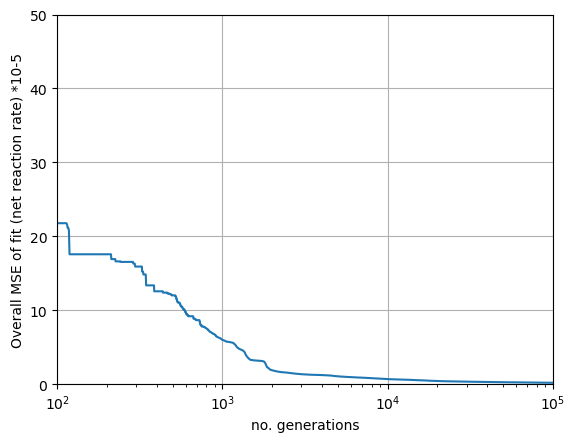

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.254190190943232
1.4807397054606952
0.7956954315805415
-4.327675843642841
0.5025676892774437
1.9638384353501612e-05
0.39478651822151345
-11.264538902382341
1.104769406744006
9.520515050291378
7.6356840470816865
7.491550708094753
0.937697881764417
0.02372008812023255
3.181389417409149
0.0011945770187519438
0.03929518161577418
-11.737865009901807
1.8524532089510028
1.5476216553685946
-10.272570937345806
1.048130309232813
3.5393752261069107
0.044416703222130136
3.6142884598925185
4.2397226186458825
1.5981845933155439
9.002826201273933
-9.316850971853475
2.6198502890683275
1.7159307101208032
3.360286020841282
-4.312311148718526
0.556363227366298
1.0198561344440078
-1.301029577483237


In [37]:
res.X

array([-1.12541902e+01,  1.48073971e+00,  7.95695432e-01, -4.32767584e+00,
        5.02567689e-01,  1.96383844e-05,  3.94786518e-01, -1.12645389e+01,
        1.10476941e+00,  9.52051505e+00,  7.63568405e+00,  7.49155071e+00,
        9.37697882e-01,  2.37200881e-02,  3.18138942e+00,  1.19457702e-03,
        3.92951816e-02, -1.17378650e+01,  1.85245321e+00,  1.54762166e+00,
       -1.02725709e+01,  1.04813031e+00,  3.53937523e+00,  4.44167032e-02,
        3.61428846e+00,  4.23972262e+00,  1.59818459e+00,  9.00282620e+00,
       -9.31685097e+00,  2.61985029e+00,  1.71593071e+00,  3.36028602e+00,
       -4.31231115e+00,  5.56363227e-01,  1.01985613e+00, -1.30102958e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
#Store to use in other notebook using the same current kernel
resX101sres=res.X
%store resX101sres

Stored 'resX101sres' (ndarray)


In [40]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.254190190943232
1.6: 1.4807397054606952
0.9: 0.7956954315805415
-4.3: -4.327675843642841
0.5: 0.5025676892774437
0.003: 1.9638384353501612e-05
0.4: 0.39478651822151345
-7.9: -11.264538902382341
0.7: 1.104769406744006
7.2: 9.520515050291378
5.7: 7.6356840470816865
5.7: 7.491550708094753
0.8: 0.937697881764417
0.03: 0.02372008812023255
3.1: 3.181389417409149
6.000000000000001e-09: 0.0011945770187519438
0.1: 0.03929518161577418
-12.0: -11.737865009901807
1.9: 1.8524532089510028
1.6: 1.5476216553685946
-11.6: -10.272570937345806
1.2: 1.048130309232813
4.0: 3.5393752261069107
0.01: 0.044416703222130136
4.2: 3.6142884598925185
5.4: 4.2397226186458825
2.2: 1.5981845933155439
11.8: 9.002826201273933
-12.0: -9.316850971853475
3.3: 2.6198502890683275
1.8: 1.7159307101208032
4.2: 3.360286020841282
-4.0: -4.312311148718526
0.5: 0.556363227366298
1.0: 1.0198561344440078
coeff fit: 0.9569185066746754
r: 0.9782221152042492
